In this notebook, we will do some plots to estimate redshift results for 3 methods below:
1. bliss redshift estimate directly from images
2. redshift estimate based on GT mag 
3. redshift estimate based on LSST predicted flux

each plot should have metrics vs galaxy fluxes

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import torch
from os import environ
from pathlib import Path
from einops import rearrange
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from pytorch_lightning.utilities import move_data_to_device

from bliss.catalog import FullCatalog, BaseTileCatalog, TileCatalog
from bliss.surveys.dc2 import DC2DataModule
from case_studies.redshift.evaluation.utils.load_lsst import get_lsst_full_cat
from case_studies.redshift.evaluation.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from case_studies.redshift.redshift_from_img.encoder.metrics import RedshiftMeanSquaredErrorBin

environ["BLISS_HOME"] = str(Path().resolve().parents[2])

output_dir = Path("./DC2output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "/home/qiaozhih/bliss/case_studies/redshift/redshift_from_img/DC2_redshift_training/DC2_redshift_only_bin_allmetrics/checkpoints/encoder_0.182845.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_plot")

In [4]:
# set up testing dataset
dataset = instantiate(notebook_cfg.train.data_source)
dataset.setup("test")


In [5]:
dataset.test_dataset

In [6]:
import os
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['MKL_NUM_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '16'

# example of test dataset

In [7]:
len(dataset.test_dataset)

25000

### 1. bliss redshift estimate directly from images

In [8]:
# Loop through the test set and update the metric
# load bliss trained model
bliss_encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder.eval();

RuntimeError: Error(s) in loading state_dict for RedshiftsEncoder:
	size mismatch for catalog_net.detection_net.4.conv.weight: copying a param with shape torch.Size([2, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([38, 256, 1, 1]).
	size mismatch for catalog_net.detection_net.4.conv.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([38]).

In [18]:
bliss_output_path = output_dir / "bliss_output_large_split.pkl"

if not bliss_output_path.exists():
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        batch["images"] = batch["images"].to(device)
        bliss_encoder.update_metrics(batch, batch_idx)
    bliss_out_dict = bliss_encoder.mode_metrics.compute()

    with open(bliss_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)

In [26]:
for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
    batch["images"] = batch["images"].to(device)
    bliss_encoder.update_metrics(batch, batch_idx)
bliss_out_dict_abs_bias = bliss_encoder.mode_metrics.compute()

100%|██████████| 3125/3125 [13:51<00:00,  3.76it/s]


In [ ]:
# mse
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
mse_values = [bliss_out_dict[f'redshifts/mse_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, mse_values)
plt.xlabel('Flux Range')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error per Flux Range')
plt.show()

# bias
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
bias_values = [bliss_out_dict[f'redshifts/bias_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, bias_values)
plt.xlabel('Flux Range')
plt.ylabel('Bias')
plt.title('Bias per Flux Range')
plt.show()

# NMAD
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
nmad_values = [bliss_out_dict[f'redshifts/nmad_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, nmad_values)
plt.xlabel('Flux Range')
plt.ylabel('NMAD')
plt.title('NMAD per Flux Range')
plt.show()

# outlierfraction
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
outlier_fraction_values = [bliss_out_dict[f'redshifts/outlier_fraction_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, outlier_fraction_values)
plt.xlabel('Flux Range')
plt.ylabel('Outlier Fraction')
plt.title('Outlier Fraction per Flux Range')
plt.show()

# outlier cata
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
outlier_fraction_cata_values = [bliss_out_dict[f'redshifts/outlier_fraction_cata_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, outlier_fraction_cata_values)
plt.xlabel('Flux Range')
plt.ylabel('Outlier Fraction Catastrophic')
plt.title('Outlier Fraction Catastrophic per Flux Range')
plt.show()

### 2. redshift estimate based on GT mag

In [9]:
from case_studies.redshift.network_rs import PhotoZFromMag
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn

In [10]:
num_bins = 1
group_size = 128
batch_size = 1
in_dim = 6
device = "cuda"
path = "/data/scratch/qiaozhih/training_runs/00120-run/tensorboard_logs/version_0/checkpoints/reg_val_loss=0.000367_epoch=29.ckpt"
network_options = {
    "hidden_dim": 256,
    "out_dim": num_bins,
    "n_epochs": 50001,
    "outdir": "/home/qiaozhih/bliss/case_studies/redshift/training_runs/",
    "snap": 1,  # how many epoches to save one model once
    "loss_fcn": torch.nn.MSELoss(),  # loss func
    # 'loss_fcn': torch.nn.CrossEntropyLoss(),                     # loss func
    "dropout_rate": 0.5,
    "learning_rate": 1e-3,
    "group_size": group_size,
    "num_gpu": 1,
    "gpu_device": [0],
}

In [11]:
reg = PhotoZFromMag.load_from_checkpoint(
    path,
    in_dim=in_dim,
    hidden_dim=network_options["hidden_dim"],
    out_dim=network_options["out_dim"],
    dropout_rate=network_options["dropout_rate"],
    learning_rate=network_options["learning_rate"],
    loss_fcn=network_options["loss_fcn"],
)
reg.to(device)
reg.eval()

PhotoZFromMag(
  (loss_fcn): MSELoss()
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [12]:
def est_redshifts_with_reg_change_to_cat(cat: TileCatalog, reg: PhotoZFromMag, tile_slen: int, min_flux_for_loss: int=50, reference_band: int=2) -> BaseTileCatalog | FullCatalog:
    """estimate redshift by inputting true mag using regressor, then convert them to Basetilecatalog

    Args:
        cat: catalog
        reg: regressor that accept ugrizy mag

    Returns:
        Catalog that containing pred redshifts
    """
    cat = cat.filter_by_flux(
        min_flux=min_flux_for_loss,
        band=reference_band,
    )
    mag = cat.magnitudes_njy
    new_order = [3, 0, 2, 1, 5, 4] # change giruyz to ugrizy
    mag = mag[..., new_order]
    is_galaxy = cat.galaxy_bools.to(device)
    N, H, W, M, _ = mag.shape
    mag = mag.reshape(-1, 6)
    is_galaxy = is_galaxy.reshape(-1, 1)
    pred_rs = torch.zeros_like(mag[..., 0])
    for i in range(len(mag)):
        if is_galaxy[i][0]: 
            x = mag[i].unsqueeze(0).to(device) # 1, 6
            pred_rs[i] = reg.net(x).squeeze(0)
    pred_rs = pred_rs.to('cpu')
    pred_rs = {"redshifts": pred_rs.reshape((N, H, W, M, 1))}

    cat["redshifts"] = pred_rs["redshifts"]
    return cat

GT data preparation

In [65]:
gt_output_path = output_dir / "gt_output_large_split.pkl"
if not gt_output_path.exists():
    metrics = instantiate(notebook_cfg.encoder.mode_metrics)
    matcher = instantiate(notebook_cfg.encoder.matcher)
    metrics.reset()
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        true_cat = TileCatalog(tile_slen=4, d=batch["tile_catalog"]).get_brightest_sources_per_tile() # TODO tile_slen
        est_cat = est_redshifts_with_reg_change_to_cat(true_cat, reg, tile_slen=4)# TODO
        matching = matcher.match_catalogs(true_cat, est_cat)
        metrics.update(true_cat, est_cat, matching)

    gt_out_dict = metrics.compute()

    with open(gt_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(gt_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(gt_output_path, "rb") as inputp:
        gt_out_dict = pickle.load(inputp)

  1%|          | 17/3125 [00:13<41:10,  1.26it/s] 


KeyboardInterrupt: 

In [66]:
gt_out_dict = metrics.compute()

total num of pts: tensor([1558.])
total num of pts: tensor([1097.,  214.,   93.,   44.,   27.,   83.])


In [67]:
gt_out_dict

{'redshifts/bias': 0.0015320874517783523,
 'redshifts/bias_bin_0': 0.035242751240730286,
 'redshifts/bias_bin_1': 0.03236996755003929,
 'redshifts/bias_bin_2': -0.0847649797797203,
 'redshifts/bias_bin_3': -0.13588908314704895,
 'redshifts/bias_bin_4': -0.3549913763999939,
 'redshifts/bias_bin_5': -0.42632851004600525,
 'redshifts/mse': 0.6808290481567383,
 'redshifts/mse_bin_0': 0.7461842894554138,
 'redshifts/mse_bin_1': 0.6050657033920288,
 'redshifts/mse_bin_2': 0.3564600348472595,
 'redshifts/mse_bin_3': 0.35045117139816284,
 'redshifts/mse_bin_4': 0.40822356939315796,
 'redshifts/mse_bin_5': 0.6396496891975403,
 'redshifts/nmad': 0.375105082988739,
 'redshifts/nmad_bin_0': 0.36841270327568054,
 'redshifts/nmad_bin_1': 0.41357719898223877,
 'redshifts/nmad_bin_2': 0.3797951340675354,
 'redshifts/nmad_bin_3': 0.3699125349521637,
 'redshifts/nmad_bin_4': 0.3016704320907593,
 'redshifts/nmad_bin_5': 0.6098409295082092,
 'redshifts/outlier_fraction': 0.7631579041481018,
 'redshifts/ou

In [1]:
metrics = ['mse', 'nmad', 'outlier_fraction_cata', 'outlier_fraction', 'bias']
fig, ax = plt.subplots(len(metrics), figsize=(10, 30))
for i, metric in enumerate(metrics):
    flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
    gt_mse_values = [gt_out_dict[f'redshifts/{metric}_bin_{i}'] for i in range(5)]
    bliss_mse_values = [bliss_out_dict[f'redshifts/{metric}_bin_{i}'] for i in range(5)]

    ax[i].plot(flux_ranges, bliss_mse_values, label="bliss")
    ax[i].plot(flux_ranges, gt_mse_values, label="gt_reg")
    if metric != 'bias':
        ax[i].set_yscale("log")
    ax[i].set_xlabel('Flux Range')
    ax[i].set_ylabel(metric)
    ax[i].set_title(f'{metric} per Flux Range')
    ax[i].legend(loc="upper right")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
gt_out_dict

### 3. redshift estimate based on LSST predicted flux

In [13]:
import GCRCatalogs
import pandas as pd
import torch

from bliss.catalog import FullCatalog, SourceType

# load lsst data
def get_lsst_catalog_tensors_dict(lsst_root_dir: str):
    GCRCatalogs.set_root_dir(lsst_root_dir)
    lsst_catalog_gcr = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    lsst_catalog_sub = lsst_catalog_gcr.get_quantities(
        [
            "id_truth",
            "objectId",
            "ra",
            "dec",
            "truth_type",
            "cModelFlux_u",
            "cModelFluxErr_u",
            "cModelFlux_g",
            "cModelFluxErr_g",
            "cModelFlux_r",
            "cModelFluxErr_r",
            "cModelFlux_i",
            "cModelFluxErr_i",
            "cModelFlux_z",
            "cModelFluxErr_z",
            "cModelFlux_y",
            "cModelFluxErr_y",
        ]
    )
    lsst_catalog_df = pd.DataFrame(lsst_catalog_sub)
    lsst_flux_lst = [
        lsst_catalog_df["cModelFlux_g"],
        lsst_catalog_df["cModelFlux_i"],
        lsst_catalog_df["cModelFlux_r"],
        lsst_catalog_df["cModelFlux_u"],
        lsst_catalog_df["cModelFlux_y"],
        lsst_catalog_df["cModelFlux_z"],
    ]
    lsst_flux_tensors_lst = [torch.tensor(flux.values).view(-1, 1) for flux in lsst_flux_lst]
    return {
        "truth_type": torch.tensor(lsst_catalog_df["truth_type"].values).view(-1, 1),
        "flux": torch.cat(lsst_flux_tensors_lst, dim=1),
        "ra": torch.tensor(lsst_catalog_df["ra"].values),
        "dec": torch.tensor(lsst_catalog_df["dec"].values),
    }
    
def get_lsst_catalog_tensors_dict(lsst_root_dir: str):
    GCRCatalogs.set_root_dir(lsst_root_dir)
    lsst_catalog_gcr = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    lsst_catalog_sub = lsst_catalog_gcr.get_quantities(
        [
            "id_truth",
            "objectId",
            "ra",
            "dec",
            "truth_type",
            "cModelFlux_u",
            "cModelFluxErr_u",
            "cModelFlux_g",
            "cModelFluxErr_g",
            "cModelFlux_r",
            "cModelFluxErr_r",
            "cModelFlux_i",
            "cModelFluxErr_i",
            "cModelFlux_z",
            "cModelFluxErr_z",
            "cModelFlux_y",
            "cModelFluxErr_y",
        ]
    )
    lsst_catalog_df = pd.DataFrame(lsst_catalog_sub)
    lsst_flux_lst = [
        lsst_catalog_df["cModelFlux_g"],
        lsst_catalog_df["cModelFlux_i"],
        lsst_catalog_df["cModelFlux_r"],
        lsst_catalog_df["cModelFlux_u"],
        lsst_catalog_df["cModelFlux_y"],
        lsst_catalog_df["cModelFlux_z"],
    ]
    lsst_flux_tensors_lst = [torch.tensor(flux.values).view(-1, 1) for flux in lsst_flux_lst]
    return {
        "truth_type": torch.tensor(lsst_catalog_df["truth_type"].values).view(-1, 1),
        "flux": torch.cat(lsst_flux_tensors_lst, dim=1),
        "ra": torch.tensor(lsst_catalog_df["ra"].values),
        "dec": torch.tensor(lsst_catalog_df["dec"].values),
    }


In [14]:
import torch

from bliss.catalog import FullCatalog, SourceType, TileCatalog
from bliss.surveys.dc2 import wcs_from_wcs_header_str

def concatenate_tile_dicts(tile_dict_list):
    output_tile_cat_dict = {}
    for k in tile_dict_list[0].keys():
        if k not in output_tile_cat_dict:
            output_tile_cat_dict[k] = []
        for tile_dict in tile_dict_list:
            output_tile_cat_dict[k].append(tile_dict[k])

    for k, v in output_tile_cat_dict.items():
        output_tile_cat_dict[k] = torch.cat(v, dim=0)

    return output_tile_cat_dict


class LSSTPredictor:
    def __init__(
        self, lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile, tiles_to_crop
    ) -> None:
        self.lsst_data = get_lsst_catalog_tensors_dict(lsst_root_dir)
        self.r_band_min_flux = r_band_min_flux
        self.tile_slen = tile_slen
        self.max_sources_per_tile = max_sources_per_tile
        self.tiles_to_crop = tiles_to_crop

        self.buffered_wcs_header_str = None
        self.buffered_lsst_plocs = None

    def _predict_one_image(self, wcs_header_str, image_lim, height_index, width_index):
        if wcs_header_str != self.buffered_wcs_header_str:
            lsst_ra = self.lsst_data["ra"]
            lsst_dec = self.lsst_data["dec"]
            cur_image_wcs = wcs_from_wcs_header_str(wcs_header_str)
            lsst_plocs = FullCatalog.plocs_from_ra_dec(lsst_ra, lsst_dec, cur_image_wcs)
            self.buffered_wcs_header_str = wcs_header_str
            self.buffered_lsst_plocs = lsst_plocs
        else:
            lsst_plocs = self.buffered_lsst_plocs
    
        lsst_source_type = self.lsst_data["truth_type"]
        lsst_flux = self.lsst_data["flux"]

        x0_mask = (lsst_plocs[:, 0] > height_index * image_lim) & (
            lsst_plocs[:, 0] < (height_index + 1) * image_lim
        )
        x1_mask = (lsst_plocs[:, 1] > width_index * image_lim) & (
            lsst_plocs[:, 1] < (width_index + 1) * image_lim
        )
        lsst_x_mask = x0_mask * x1_mask
        # filter r band
        filter_band = ["g", "i", "r", "u", "y", "z"]
        for i in range(len(filter_band)):
            lsst_flux_mask = (lsst_flux[:, i] > self.r_band_min_flux) & (lsst_flux[:, i] < torch.inf)
            lsst_x_mask = lsst_x_mask * lsst_flux_mask

        lsst_mask = lsst_x_mask
        lsst_plocs = lsst_plocs[lsst_mask, :] % image_lim
        lsst_source_type = torch.where(
            lsst_source_type[lsst_mask] == SourceType.STAR, SourceType.STAR, SourceType.GALAXY
        )
        lsst_flux = lsst_flux[lsst_mask, :]
        lsst_n_sources = torch.tensor([lsst_plocs.shape[0]])

        return FullCatalog(
            height=image_lim,
            width=image_lim,
            d={
                "plocs": lsst_plocs.unsqueeze(0),
                "n_sources": lsst_n_sources,
                "source_type": lsst_source_type.unsqueeze(0),
                "galaxy_fluxes": lsst_flux.unsqueeze(0),
                "star_fluxes": lsst_flux.unsqueeze(0).clone(),
            },
        ).to_tile_catalog(self.tile_slen, self.max_sources_per_tile, ignore_extra_sources=True)

    def predict(self, wcs_header_str_list, image_lim, height_index_list, width_index_list):
        assert len(wcs_header_str_list) == len(height_index_list), "unequal input list size"
        assert len(wcs_header_str_list) == len(width_index_list), "unequal input list size"
        tile_dict_list = []
        predict_input_data = zip(wcs_header_str_list, height_index_list, width_index_list)
        for wcs_header_str, height_index, width_index in predict_input_data:
            tile_dict_list.append(
                self._predict_one_image(wcs_header_str, image_lim, height_index, width_index).data
            )

        merged_tile_dict = concatenate_tile_dicts(tile_dict_list)
        return TileCatalog(self.tile_slen, merged_tile_dict)

In [15]:
lsst_output_path = output_dir / "lsst_output_large_split.pkl"
if not lsst_output_path.exists():
    metrics = instantiate(notebook_cfg.encoder.mode_metrics)
    matcher = instantiate(notebook_cfg.encoder.matcher)
    metrics.reset()
    # args
    lsst_root_dir = "/data/scratch/dc2_nfs/"
    image_lim = 80
    r_band_min_flux = 50
    tile_slen = 4
    max_sources_per_tile = 1
    tiles_to_crop = 1

    lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile, tiles_to_crop)
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        true_cat = TileCatalog(tile_slen=4, d=batch["tile_catalog"]).get_brightest_sources_per_tile()
        lsst_cat = lsst_predictor.predict(batch["wcs_header_str"], image_lim, batch["image_height_index"], batch["image_width_index"])
        est_cat = est_redshifts_with_reg_change_to_cat(lsst_cat, reg, tile_slen=4)
        est_cat = est_cat.to_full_catalog()
        true_cat = true_cat.to_full_catalog()
        matching = matcher.match_catalogs(true_cat, est_cat)
        metrics.update(true_cat, est_cat, matching)
        print(metrics.compute())
    lsst_out_dict = metrics.compute()

    with open(lsst_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(lsst_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(lsst_output_path, "rb") as inputp:
        lsst_out_dict = pickle.load(inputp)

In [113]:
metrics = instantiate(notebook_cfg.encoder.mode_metrics)
matcher = instantiate(notebook_cfg.encoder.matcher)
metrics.reset()
# args
lsst_root_dir = "/data/scratch/dc2_nfs/"
image_lim = 80
r_band_min_flux = 50
tile_slen = 4
max_sources_per_tile = 1
tiles_to_crop = 1

# lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile, tiles_to_crop)
for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
    true_cat = TileCatalog(tile_slen=4, d=batch["tile_catalog"]).get_brightest_sources_per_tile()
    lsst_cat = lsst_predictor.predict(batch["wcs_header_str"], image_lim, batch["image_height_index"], batch["image_width_index"])
    est_cat = est_redshifts_with_reg_change_to_cat(lsst_cat, reg, tile_slen=4)
    est_cat = est_cat.to_full_catalog()
    true_cat = true_cat.to_full_catalog()
    matching = matcher.match_catalogs(true_cat, est_cat)
    metrics.update(true_cat, est_cat, matching)
    print(metrics.compute())
lsst_out_dict = metrics.compute()


  0%|          | 1/1563 [00:08<3:32:11,  8.15s/it]

total num of pts: tensor([61.])
total num of pts: tensor([13., 24.,  8.,  3.,  2., 11.])
{'redshifts/bias_abs': 0.04317736253142357, 'redshifts/bias_abs_bin_0': 0.09870784729719162, 'redshifts/bias_abs_bin_1': 0.08257830888032913, 'redshifts/bias_abs_bin_2': 0.02365175075829029, 'redshifts/bias_abs_bin_3': 0.016156893223524094, 'redshifts/bias_abs_bin_4': 0.0061971996910870075, 'redshifts/bias_abs_bin_5': 0.018932612612843513, 'redshifts/bias': 0.006539211142808199, 'redshifts/bias_bin_0': 0.022179365158081055, 'redshifts/bias_bin_1': 0.029039448127150536, 'redshifts/bias_bin_2': -0.02365175075829029, 'redshifts/bias_bin_3': 0.016156893223524094, 'redshifts/bias_bin_4': -0.7796229720115662, 'redshifts/bias_bin_5': 0.005185812711715698, 'redshifts/mse': 0.22802583873271942, 'redshifts/mse_bin_0': 0.08865662664175034, 'redshifts/mse_bin_1': 0.477445513010025, 'redshifts/mse_bin_2': 0.04592141509056091, 'redshifts/mse_bin_3': 0.0018119961023330688, 'redshifts/mse_bin_4': 0.426493048667907

  0%|          | 2/1563 [00:13<2:44:51,  6.34s/it]

total num of pts: tensor([122.])
total num of pts: tensor([34., 39., 17.,  7.,  3., 22.])
{'redshifts/bias_abs': 0.06420139223337173, 'redshifts/bias_abs_bin_0': 0.09870784729719162, 'redshifts/bias_abs_bin_1': 0.07958200573921204, 'redshifts/bias_abs_bin_2': 0.0735602155327797, 'redshifts/bias_abs_bin_3': 0.024056268855929375, 'redshifts/bias_abs_bin_4': 0.44907236099243164, 'redshifts/bias_abs_bin_5': 0.018932612612843513, 'redshifts/bias': 0.006211717147380114, 'redshifts/bias_bin_0': 0.03612789884209633, 'redshifts/bias_bin_1': 0.029039448127150536, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': 0.016156893223524094, 'redshifts/bias_bin_4': -0.44907236099243164, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.28886207938194275, 'redshifts/mse_bin_0': 0.3589097559452057, 'redshifts/mse_bin_1': 0.5242950320243835, 'redshifts/mse_bin_2': 0.05619512498378754, 'redshifts/mse_bin_3': 0.005270031746476889, 'redshifts/mse_bin_4': 0.483923107385635

  0%|          | 3/1563 [00:17<2:21:50,  5.46s/it]

total num of pts: tensor([209.])
total num of pts: tensor([66., 60., 28., 13.,  6., 36.])
{'redshifts/bias_abs': 0.07391010969877243, 'redshifts/bias_abs_bin_0': 0.1548011302947998, 'redshifts/bias_abs_bin_1': 0.08134447038173676, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.024929791688919067, 'redshifts/bias_abs_bin_4': 0.030704017728567123, 'redshifts/bias_abs_bin_5': 0.02722463198006153, 'redshifts/bias': 0.006211717147380114, 'redshifts/bias_bin_0': 0.03612789884209633, 'redshifts/bias_bin_1': 0.02479412406682968, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': 0.016156893223524094, 'redshifts/bias_bin_4': -0.030704017728567123, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.3656168282032013, 'redshifts/mse_bin_0': 0.5096446871757507, 'redshifts/mse_bin_1': 0.3942866623401642, 'redshifts/mse_bin_2': 0.07087111473083496, 'redshifts/mse_bin_3': 0.40832722187042236, 'redshifts/mse_bin_4': 0.2451196163892746, 

  0%|          | 4/1563 [00:23<2:24:22,  5.56s/it]

total num of pts: tensor([281.])
total num of pts: tensor([95., 73., 36., 18., 10., 49.])
{'redshifts/bias_abs': 0.07738219201564789, 'redshifts/bias_abs_bin_0': 0.1470949500799179, 'redshifts/bias_abs_bin_1': 0.09775082021951675, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.02663399465382099, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02722463198006153, 'redshifts/bias': 0.006539211142808199, 'redshifts/bias_bin_0': 0.023168528452515602, 'redshifts/bias_bin_1': 0.03685573488473892, 'redshifts/bias_bin_2': 0.009422825649380684, 'redshifts/bias_bin_3': 0.011594765819609165, 'redshifts/bias_bin_4': -0.030704017728567123, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.37961864471435547, 'redshifts/mse_bin_0': 0.48930615186691284, 'redshifts/mse_bin_1': 0.46039801836013794, 'redshifts/mse_bin_2': 0.1344691962003708, 'redshifts/mse_bin_3': 0.4776960015296936, 'redshifts/mse_bin_4': 0.18611150979995728, 

  0%|          | 5/1563 [00:30<2:35:52,  6.00s/it]

total num of pts: tensor([340.])
total num of pts: tensor([115.,  89.,  44.,  21.,  12.,  59.])
{'redshifts/bias_abs': 0.07391010969877243, 'redshifts/bias_abs_bin_0': 0.14082016050815582, 'redshifts/bias_abs_bin_1': 0.09709466993808746, 'redshifts/bias_abs_bin_2': 0.06031863018870354, 'redshifts/bias_abs_bin_3': 0.032490313053131104, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.029838448390364647, 'redshifts/bias': 0.006288137286901474, 'redshifts/bias_bin_0': 0.024998193606734276, 'redshifts/bias_bin_1': 0.03685573488473892, 'redshifts/bias_bin_2': 0.00447638938203454, 'redshifts/bias_bin_3': -0.00020788604160770774, 'redshifts/bias_bin_4': -0.030704017728567123, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.3509448170661926, 'redshifts/mse_bin_0': 0.44255441427230835, 'redshifts/mse_bin_1': 0.46604254841804504, 'redshifts/mse_bin_2': 0.1130450963973999, 'redshifts/mse_bin_3': 0.4158199727535248, 'redshifts/mse_bin_4': 0.15599781

  0%|          | 6/1563 [00:35<2:31:41,  5.85s/it]

total num of pts: tensor([411.])
total num of pts: tensor([135., 110.,  54.,  30.,  14.,  68.])
{'redshifts/bias_abs': 0.07391010969877243, 'redshifts/bias_abs_bin_0': 0.12722203135490417, 'redshifts/bias_abs_bin_1': 0.09352179616689682, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.02663399465382099, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.025433365255594254, 'redshifts/bias': 0.006624399684369564, 'redshifts/bias_bin_0': 0.03418132662773132, 'redshifts/bias_bin_1': 0.04027383401989937, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.005023621954023838, 'redshifts/bias_bin_4': -0.0348176546394825, 'redshifts/bias_bin_5': -0.0007522428059019148, 'redshifts/mse': 0.32189592719078064, 'redshifts/mse_bin_0': 0.4215575158596039, 'redshifts/mse_bin_1': 0.4211038053035736, 'redshifts/mse_bin_2': 0.10301793366670609, 'redshifts/mse_bin_3': 0.33550548553466797, 'redshifts/mse_bin_4': 0.134511962532

  0%|          | 7/1563 [00:39<2:16:34,  5.27s/it]

total num of pts: tensor([484.])
total num of pts: tensor([171., 123.,  62.,  32.,  20.,  76.])
{'redshifts/bias_abs': 0.07873748242855072, 'redshifts/bias_abs_bin_0': 0.13187886774539948, 'redshifts/bias_abs_bin_1': 0.09775082021951675, 'redshifts/bias_abs_bin_2': 0.06834521144628525, 'redshifts/bias_abs_bin_3': 0.032490313053131104, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.025433365255594254, 'redshifts/bias': 0.006211717147380114, 'redshifts/bias_bin_0': 0.03418132662773132, 'redshifts/bias_bin_1': 0.03685573488473892, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.005023621954023838, 'redshifts/bias_bin_4': -0.021342091262340546, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.38086628913879395, 'redshifts/mse_bin_0': 0.48778894543647766, 'redshifts/mse_bin_1': 0.522273063659668, 'redshifts/mse_bin_2': 0.1410304605960846, 'redshifts/mse_bin_3': 0.3383091390132904, 'redshifts/mse_bin_4': 0.27725875377

  1%|          | 8/1563 [00:44<2:13:16,  5.14s/it]

total num of pts: tensor([540.])
total num of pts: tensor([197., 131.,  70.,  33.,  22.,  87.])
{'redshifts/bias_abs': 0.08071961253881454, 'redshifts/bias_abs_bin_0': 0.14082016050815582, 'redshifts/bias_abs_bin_1': 0.10230362415313721, 'redshifts/bias_abs_bin_2': 0.06834521144628525, 'redshifts/bias_abs_bin_3': 0.03269846364855766, 'redshifts/bias_abs_bin_4': 0.03766520693898201, 'redshifts/bias_abs_bin_5': 0.02722463198006153, 'redshifts/bias': 0.011437494307756424, 'redshifts/bias_bin_0': 0.04864666983485222, 'redshifts/bias_bin_1': 0.04027383401989937, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.021342091262340546, 'redshifts/bias_bin_5': -0.0007522428059019148, 'redshifts/mse': 0.3884154260158539, 'redshifts/mse_bin_0': 0.5079067945480347, 'redshifts/mse_bin_1': 0.5250134468078613, 'redshifts/mse_bin_2': 0.15938223898410797, 'redshifts/mse_bin_3': 0.36605527997016907, 'redshifts/mse_bin_4': 0.25227013230

  1%|          | 9/1563 [00:51<2:24:18,  5.57s/it]

total num of pts: tensor([621.])
total num of pts: tensor([216., 154.,  84.,  37.,  24., 106.])
{'redshifts/bias_abs': 0.07982296496629715, 'redshifts/bias_abs_bin_0': 0.14776936173439026, 'redshifts/bias_abs_bin_1': 0.11124774068593979, 'redshifts/bias_abs_bin_2': 0.06845114380121231, 'redshifts/bias_abs_bin_3': 0.03269846364855766, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.029028018936514854, 'redshifts/bias': 0.011983007192611694, 'redshifts/bias_bin_0': 0.03708640858530998, 'redshifts/bias_bin_1': 0.04473336040973663, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.005023621954023838, 'redshifts/bias_bin_4': 0.0061971996910870075, 'redshifts/bias_bin_5': -0.0005372464656829834, 'redshifts/mse': 0.37947872281074524, 'redshifts/mse_bin_0': 0.5071269869804382, 'redshifts/mse_bin_1': 0.510908305644989, 'redshifts/mse_bin_2': 0.18263784050941467, 'redshifts/mse_bin_3': 0.3736521303653717, 'redshifts/mse_bin_4': 0.2316520810

  1%|          | 10/1563 [00:57<2:27:10,  5.69s/it]

total num of pts: tensor([688.])
total num of pts: tensor([241., 166.,  89.,  44.,  24., 124.])
{'redshifts/bias_abs': 0.07789525389671326, 'redshifts/bias_abs_bin_0': 0.14179366827011108, 'redshifts/bias_abs_bin_1': 0.09889206290245056, 'redshifts/bias_abs_bin_2': 0.06845114380121231, 'redshifts/bias_abs_bin_3': 0.03269846364855766, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.029028018936514854, 'redshifts/bias': 0.011026826687157154, 'redshifts/bias_bin_0': 0.03418132662773132, 'redshifts/bias_bin_1': 0.04317736253142357, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': 0.0061971996910870075, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.36667400598526, 'redshifts/mse_bin_0': 0.4907244145870209, 'redshifts/mse_bin_1': 0.48225921392440796, 'redshifts/mse_bin_2': 0.1731470227241516, 'redshifts/mse_bin_3': 0.3198200464248657, 'redshifts/mse_bin_4': 0.231652081012

  1%|          | 11/1563 [01:01<2:20:38,  5.44s/it]

total num of pts: tensor([753.])
total num of pts: tensor([261., 183.,  96.,  48.,  28., 137.])
{'redshifts/bias_abs': 0.07688840478658676, 'redshifts/bias_abs_bin_0': 0.1470949500799179, 'redshifts/bias_abs_bin_1': 0.09775082021951675, 'redshifts/bias_abs_bin_2': 0.06814432889223099, 'redshifts/bias_abs_bin_3': 0.040069304406642914, 'redshifts/bias_abs_bin_4': 0.03766520693898201, 'redshifts/bias_abs_bin_5': 0.02816024236381054, 'redshifts/bias': 0.009422825649380684, 'redshifts/bias_bin_0': 0.03708640858530998, 'redshifts/bias_bin_1': 0.03148982673883438, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.005023621954023838, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': 0.0009926001075655222, 'redshifts/mse': 0.3535056412220001, 'redshifts/mse_bin_0': 0.4913834035396576, 'redshifts/mse_bin_1': 0.44794419407844543, 'redshifts/mse_bin_2': 0.17690426111221313, 'redshifts/mse_bin_3': 0.2973655164241791, 'redshifts/mse_bin_4': 0.206591695547

  1%|          | 12/1563 [01:07<2:20:07,  5.42s/it]

total num of pts: tensor([821.])
total num of pts: tensor([290., 197.,  99.,  51.,  34., 150.])
{'redshifts/bias_abs': 0.078252874314785, 'redshifts/bias_abs_bin_0': 0.14263629913330078, 'redshifts/bias_abs_bin_1': 0.09889206290245056, 'redshifts/bias_abs_bin_2': 0.06814432889223099, 'redshifts/bias_abs_bin_3': 0.05203434079885483, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02722463198006153, 'redshifts/bias': 0.010314642451703548, 'redshifts/bias_bin_0': 0.03708640858530998, 'redshifts/bias_bin_1': 0.03148982673883438, 'redshifts/bias_bin_2': 0.0017497100634500384, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0007522428059019148, 'redshifts/mse': 0.3486545979976654, 'redshifts/mse_bin_0': 0.48791661858558655, 'redshifts/mse_bin_1': 0.43549078702926636, 'redshifts/mse_bin_2': 0.1826608031988144, 'redshifts/mse_bin_3': 0.2832249104976654, 'redshifts/mse_bin_4': 0.219390511512

  1%|          | 13/1563 [01:11<2:11:48,  5.10s/it]

total num of pts: tensor([907.])
total num of pts: tensor([323., 225., 105.,  54.,  34., 166.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.13947953283786774, 'redshifts/bias_abs_bin_1': 0.09352179616689682, 'redshifts/bias_abs_bin_2': 0.06814432889223099, 'redshifts/bias_abs_bin_3': 0.040069304406642914, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02475377544760704, 'redshifts/bias': 0.009738924913108349, 'redshifts/bias_bin_0': 0.03456380218267441, 'redshifts/bias_bin_1': 0.03683556988835335, 'redshifts/bias_bin_2': 0.0017497100634500384, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.331159770488739, 'redshifts/mse_bin_0': 0.4635419249534607, 'redshifts/mse_bin_1': 0.4063703715801239, 'redshifts/mse_bin_2': 0.17356422543525696, 'redshifts/mse_bin_3': 0.2682231366634369, 'redshifts/mse_bin_4': 0.21939051151

  1%|          | 14/1563 [01:16<2:11:59,  5.11s/it]

total num of pts: tensor([982.])
total num of pts: tensor([351., 242., 115.,  56.,  35., 183.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.14033053815364838, 'redshifts/bias_abs_bin_1': 0.09204958379268646, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02475377544760704, 'redshifts/bias': 0.009738924913108349, 'redshifts/bias_bin_0': 0.038320399820804596, 'redshifts/bias_bin_1': 0.031063443049788475, 'redshifts/bias_bin_2': 0.008904588408768177, 'redshifts/bias_bin_3': -0.00020788604160770774, 'redshifts/bias_bin_4': 0.0061971996910870075, 'redshifts/bias_bin_5': -0.0017560801934450865, 'redshifts/mse': 0.3303118348121643, 'redshifts/mse_bin_0': 0.4723442792892456, 'redshifts/mse_bin_1': 0.3883324861526489, 'redshifts/mse_bin_2': 0.19177597761154175, 'redshifts/mse_bin_3': 0.25969648361206055, 'redshifts/mse_bin_4': 0.2131793

  1%|          | 15/1563 [01:21<2:11:10,  5.08s/it]

total num of pts: tensor([1052.])
total num of pts: tensor([376., 266., 123.,  57.,  37., 193.])
{'redshifts/bias_abs': 0.07737306505441666, 'redshifts/bias_abs_bin_0': 0.14033053815364838, 'redshifts/bias_abs_bin_1': 0.09667549282312393, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.05203434079885483, 'redshifts/bias_abs_bin_4': 0.03766520693898201, 'redshifts/bias_abs_bin_5': 0.024218037724494934, 'redshifts/bias': 0.009738924913108349, 'redshifts/bias_bin_0': 0.038320399820804596, 'redshifts/bias_bin_1': 0.031205225735902786, 'redshifts/bias_bin_2': 0.00447638938203454, 'redshifts/bias_bin_3': 0.00015504164912272245, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0017560801934450865, 'redshifts/mse': 0.33000868558883667, 'redshifts/mse_bin_0': 0.4765244722366333, 'redshifts/mse_bin_1': 0.3796798884868622, 'redshifts/mse_bin_2': 0.18374432623386383, 'redshifts/mse_bin_3': 0.2869730591773987, 'redshifts/mse_bin_4': 0.20183703

  1%|          | 16/1563 [01:27<2:11:56,  5.12s/it]

total num of pts: tensor([1139.])
total num of pts: tensor([408., 286., 132.,  63.,  40., 210.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14082016050815582, 'redshifts/bias_abs_bin_1': 0.09352179616689682, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.0085381381213665, 'redshifts/bias_bin_0': 0.038320399820804596, 'redshifts/bias_bin_1': 0.030686672776937485, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': 0.003392108017578721, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0020442595705389977, 'redshifts/mse': 0.3304283320903778, 'redshifts/mse_bin_0': 0.46664801239967346, 'redshifts/mse_bin_1': 0.3737817704677582, 'redshifts/mse_bin_2': 0.24952100217342377, 'redshifts/mse_bin_3': 0.2766276001930237, 'redshifts/mse_bin_4': 0.19854362

  1%|          | 17/1563 [01:32<2:13:25,  5.18s/it]

total num of pts: tensor([1220.])
total num of pts: tensor([434., 308., 142.,  69.,  41., 226.])
{'redshifts/bias_abs': 0.07439469546079636, 'redshifts/bias_abs_bin_0': 0.13947953283786774, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.06031863018870354, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.006624399684369564, 'redshifts/bias_bin_0': 0.03441818803548813, 'redshifts/bias_bin_1': 0.031063443049788475, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': 0.003392108017578721, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0017560801934450865, 'redshifts/mse': 0.31877371668815613, 'redshifts/mse_bin_0': 0.4592879116535187, 'redshifts/mse_bin_1': 0.3580649197101593, 'redshifts/mse_bin_2': 0.2322886884212494, 'redshifts/mse_bin_3': 0.25426915287971497, 'redshifts/mse_bin_4': 0.193826019

  1%|          | 18/1563 [01:37<2:10:19,  5.06s/it]

total num of pts: tensor([1295.])
total num of pts: tensor([465., 330., 149.,  72.,  42., 237.])
{'redshifts/bias_abs': 0.07555018365383148, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.06031863018870354, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02455303817987442, 'redshifts/bias': 0.00591768603771925, 'redshifts/bias_bin_0': 0.032566480338573456, 'redshifts/bias_bin_1': 0.031063443049788475, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': 0.0030214213766157627, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.002539128065109253, 'redshifts/mse': 0.3166153132915497, 'redshifts/mse_bin_0': 0.45790907740592957, 'redshifts/mse_bin_1': 0.3544771671295166, 'redshifts/mse_bin_2': 0.2258504331111908, 'redshifts/mse_bin_3': 0.24388641119003296, 'redshifts/mse_bin_4': 0.189219713

  1%|          | 19/1563 [01:41<2:04:48,  4.85s/it]

total num of pts: tensor([1388.])
total num of pts: tensor([485., 365., 158.,  77.,  46., 257.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14994098246097565, 'redshifts/bias_abs_bin_1': 0.09471412748098373, 'redshifts/bias_abs_bin_2': 0.06113863363862038, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005348697770386934, 'redshifts/bias_bin_0': 0.03441818803548813, 'redshifts/bias_bin_1': 0.029039448127150536, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': 0.0030214213766157627, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0026514846831560135, 'redshifts/mse': 0.3217673897743225, 'redshifts/mse_bin_0': 0.46042487025260925, 'redshifts/mse_bin_1': 0.3764238655567169, 'redshifts/mse_bin_2': 0.24575020372867584, 'redshifts/mse_bin_3': 0.22898302972316742, 'redshifts/mse_bin_4': 0.17427

  1%|▏         | 20/1563 [01:47<2:10:01,  5.06s/it]

total num of pts: tensor([1461.])
total num of pts: tensor([514., 382., 167.,  79.,  47., 272.])
{'redshifts/bias_abs': 0.07706210017204285, 'redshifts/bias_abs_bin_0': 0.15002496540546417, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.005940004251897335, 'redshifts/bias_bin_0': 0.03708640858530998, 'redshifts/bias_bin_1': 0.027409391477704048, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': 0.0030214213766157627, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0017560801934450865, 'redshifts/mse': 0.3201584815979004, 'redshifts/mse_bin_0': 0.4657282829284668, 'redshifts/mse_bin_1': 0.3674065172672272, 'redshifts/mse_bin_2': 0.24457494914531708, 'redshifts/mse_bin_3': 0.2231973111629486, 'redshifts/mse_bin_4': 0.17058724

  1%|▏         | 21/1563 [01:51<2:05:13,  4.87s/it]

total num of pts: tensor([1528.])
total num of pts: tensor([541., 402., 171.,  82.,  48., 284.])
{'redshifts/bias_abs': 0.07711009681224823, 'redshifts/bias_abs_bin_0': 0.15177014470100403, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.006950526498258114, 'redshifts/bias_bin_0': 0.038320399820804596, 'redshifts/bias_bin_1': 0.02539781853556633, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': 0.003392108017578721, 'redshifts/bias_bin_4': -0.009223381988704205, 'redshifts/bias_bin_5': -0.0016208098968490958, 'redshifts/mse': 0.31829169392585754, 'redshifts/mse_bin_0': 0.4593163728713989, 'redshifts/mse_bin_1': 0.3621443212032318, 'redshifts/mse_bin_2': 0.25590333342552185, 'redshifts/mse_bin_3': 0.22977326810359955, 'redshifts/mse_bin_4': 0.168925285

  1%|▏         | 22/1563 [01:55<1:57:36,  4.58s/it]

total num of pts: tensor([1622.])
total num of pts: tensor([574., 421., 185.,  84.,  52., 306.])
{'redshifts/bias_abs': 0.07688840478658676, 'redshifts/bias_abs_bin_0': 0.14994098246097565, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.06154340133070946, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.00543611915782094, 'redshifts/bias_bin_0': 0.03441818803548813, 'redshifts/bias_bin_1': 0.021906152367591858, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': 0.0030214213766157627, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.002539128065109253, 'redshifts/mse': 0.31808969378471375, 'redshifts/mse_bin_0': 0.4516077935695648, 'redshifts/mse_bin_1': 0.37300917506217957, 'redshifts/mse_bin_2': 0.26051902770996094, 'redshifts/mse_bin_3': 0.22554728388786316, 'redshifts/mse_bin_4': 0.208277136

  1%|▏         | 23/1563 [01:59<1:50:14,  4.30s/it]

total num of pts: tensor([1674.])
total num of pts: tensor([587., 436., 191.,  87.,  54., 319.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14994098246097565, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.06113863363862038, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.005940004251897335, 'redshifts/bias_bin_0': 0.03418132662773132, 'redshifts/bias_bin_1': 0.020600803196430206, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': 0.004182810895144939, 'redshifts/bias_bin_4': 0.0061971996910870075, 'redshifts/bias_bin_5': -0.0020442595705389977, 'redshifts/mse': 0.31831493973731995, 'redshifts/mse_bin_0': 0.44904011487960815, 'redshifts/mse_bin_1': 0.3755015730857849, 'redshifts/mse_bin_2': 0.2600730061531067, 'redshifts/mse_bin_3': 0.25403326749801636, 'redshifts/mse_bin_4': 0.20903919

  2%|▏         | 24/1563 [02:03<1:51:23,  4.34s/it]

total num of pts: tensor([1740.])
total num of pts: tensor([609., 456., 200.,  88.,  58., 329.])
{'redshifts/bias_abs': 0.07706210017204285, 'redshifts/bias_abs_bin_0': 0.1478569209575653, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.06113863363862038, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.022816698998212814, 'redshifts/bias': 0.005693050101399422, 'redshifts/bias_bin_0': 0.032566480338573456, 'redshifts/bias_bin_1': 0.019810620695352554, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': 0.003392108017578721, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.0020442595705389977, 'redshifts/mse': 0.3132372200489044, 'redshifts/mse_bin_0': 0.44253334403038025, 'redshifts/mse_bin_1': 0.3674536943435669, 'redshifts/mse_bin_2': 0.259603351354599, 'redshifts/mse_bin_3': 0.2516365647315979, 'redshifts/mse_bin_4': 0.1960097253

  2%|▏         | 25/1563 [02:08<1:56:02,  4.53s/it]

total num of pts: tensor([1810.])
total num of pts: tensor([630., 471., 210.,  89.,  62., 348.])
{'redshifts/bias_abs': 0.07737306505441666, 'redshifts/bias_abs_bin_0': 0.14675739407539368, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.06154340133070946, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.0059488373808562756, 'redshifts/bias_bin_0': 0.032566480338573456, 'redshifts/bias_bin_1': 0.020600803196430206, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': 0.003392108017578721, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.002539128065109253, 'redshifts/mse': 0.31463637948036194, 'redshifts/mse_bin_0': 0.43804794549942017, 'redshifts/mse_bin_1': 0.37799331545829773, 'redshifts/mse_bin_2': 0.2595365345478058, 'redshifts/mse_bin_3': 0.26351693272590637, 'redshifts/mse_bin_4': 0.238914

  2%|▏         | 26/1563 [02:14<2:07:26,  4.97s/it]

total num of pts: tensor([1891.])
total num of pts: tensor([665., 492., 217.,  92.,  65., 360.])
{'redshifts/bias_abs': 0.07764375954866409, 'redshifts/bias_abs_bin_0': 0.1472397893667221, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.06154340133070946, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.022816698998212814, 'redshifts/bias': 0.005940004251897335, 'redshifts/bias_bin_0': 0.03170373663306236, 'redshifts/bias_bin_1': 0.019993888214230537, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': 0.0010789637453854084, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.002539128065109253, 'redshifts/mse': 0.3166651129722595, 'redshifts/mse_bin_0': 0.44164466857910156, 'redshifts/mse_bin_1': 0.37165069580078125, 'redshifts/mse_bin_2': 0.251742959022522, 'redshifts/mse_bin_3': 0.31425824761390686, 'redshifts/mse_bin_4': 0.2441574186

  2%|▏         | 27/1563 [02:19<2:05:49,  4.91s/it]

total num of pts: tensor([1981.])
total num of pts: tensor([685., 521., 231.,  99.,  68., 377.])
{'redshifts/bias_abs': 0.07738219201564789, 'redshifts/bias_abs_bin_0': 0.1478569209575653, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.06113863363862038, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.03418132662773132, 'redshifts/bias_bin_1': 0.018306799232959747, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': 0.0010789637453854084, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0020902291871607304, 'redshifts/mse': 0.3147593140602112, 'redshifts/mse_bin_0': 0.44709882140159607, 'redshifts/mse_bin_1': 0.364911824464798, 'redshifts/mse_bin_2': 0.2456432431936264, 'redshifts/mse_bin_3': 0.3003024756908417, 'redshifts/mse_bin_4': 0.23347501456

  2%|▏         | 28/1563 [02:24<2:08:01,  5.00s/it]

total num of pts: tensor([2048.])
total num of pts: tensor([714., 533., 240., 101.,  68., 392.])
{'redshifts/bias_abs': 0.07741431891918182, 'redshifts/bias_abs_bin_0': 0.1472397893667221, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.06113863363862038, 'redshifts/bias_abs_bin_3': 0.051819972693920135, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.022816698998212814, 'redshifts/bias': 0.005602510645985603, 'redshifts/bias_bin_0': 0.03418132662773132, 'redshifts/bias_bin_1': 0.019810620695352554, 'redshifts/bias_bin_2': 0.0018601736519485712, 'redshifts/bias_bin_3': 0.000966125400736928, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.002539128065109253, 'redshifts/mse': 0.31422725319862366, 'redshifts/mse_bin_0': 0.4462983012199402, 'redshifts/mse_bin_1': 0.36355024576187134, 'redshifts/mse_bin_2': 0.24737165868282318, 'redshifts/mse_bin_3': 0.2982715964317322, 'redshifts/mse_bin_4': 0.233475014

  2%|▏         | 29/1563 [02:29<2:10:52,  5.12s/it]

total num of pts: tensor([2125.])
total num of pts: tensor([742., 553., 252., 106.,  69., 403.])
{'redshifts/bias_abs': 0.07922405004501343, 'redshifts/bias_abs_bin_0': 0.14776936173439026, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.06113863363862038, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005348697770386934, 'redshifts/bias_bin_0': 0.03170373663306236, 'redshifts/bias_bin_1': 0.020600803196430206, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': 0.00018420291598886251, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.002539128065109253, 'redshifts/mse': 0.3189795911312103, 'redshifts/mse_bin_0': 0.4445098340511322, 'redshifts/mse_bin_1': 0.3762473165988922, 'redshifts/mse_bin_2': 0.2376037985086441, 'redshifts/mse_bin_3': 0.2849756181240082, 'redshifts/mse_bin_4': 0.28062820434

  2%|▏         | 30/1563 [02:35<2:12:39,  5.19s/it]

total num of pts: tensor([2194.])
total num of pts: tensor([766., 576., 258., 108.,  71., 415.])
{'redshifts/bias_abs': 0.07922405004501343, 'redshifts/bias_abs_bin_0': 0.1478569209575653, 'redshifts/bias_abs_bin_1': 0.09352179616689682, 'redshifts/bias_abs_bin_2': 0.06154340133070946, 'redshifts/bias_abs_bin_3': 0.051819972693920135, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.00543611915782094, 'redshifts/bias_bin_0': 0.032566480338573456, 'redshifts/bias_bin_1': 0.021906152367591858, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': 0.00015504164912272245, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0020442595705389977, 'redshifts/mse': 0.318594753742218, 'redshifts/mse_bin_0': 0.4420788288116455, 'redshifts/mse_bin_1': 0.3812183141708374, 'redshifts/mse_bin_2': 0.23299767076969147, 'redshifts/mse_bin_3': 0.2805190086364746, 'redshifts/mse_bin_4': 0.272867053

  2%|▏         | 31/1563 [02:41<2:23:41,  5.63s/it]

total num of pts: tensor([2260.])
total num of pts: tensor([788., 590., 265., 112.,  76., 429.])
{'redshifts/bias_abs': 0.07873748242855072, 'redshifts/bias_abs_bin_0': 0.15022693574428558, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.06154340133070946, 'redshifts/bias_abs_bin_3': 0.051819972693920135, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004793108440935612, 'redshifts/bias_bin_0': 0.032566480338573456, 'redshifts/bias_bin_1': 0.020600803196430206, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': -0.00020788604160770774, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0020902291871607304, 'redshifts/mse': 0.3175453245639801, 'redshifts/mse_bin_0': 0.4497840106487274, 'redshifts/mse_bin_1': 0.3728780150413513, 'redshifts/mse_bin_2': 0.23427212238311768, 'redshifts/mse_bin_3': 0.27242180705070496, 'redshifts/mse_bin_4': 0.25631

  2%|▏         | 32/1563 [02:49<2:37:19,  6.17s/it]

total num of pts: tensor([2334.])
total num of pts: tensor([811., 612., 272., 114.,  82., 443.])
{'redshifts/bias_abs': 0.07873748242855072, 'redshifts/bias_abs_bin_0': 0.15357446670532227, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.005024822428822517, 'redshifts/bias_bin_0': 0.03418132662773132, 'redshifts/bias_bin_1': 0.019993888214230537, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': -0.00020788604160770774, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0016208098968490958, 'redshifts/mse': 0.31749778985977173, 'redshifts/mse_bin_0': 0.4571077525615692, 'redshifts/mse_bin_1': 0.3666640520095825, 'redshifts/mse_bin_2': 0.23671452701091766, 'redshifts/mse_bin_3': 0.26770663261413574, 'redshifts/mse_bin_4': 0.24038

  2%|▏         | 33/1563 [02:55<2:41:13,  6.32s/it]

total num of pts: tensor([2380.])
total num of pts: tensor([828., 625., 276., 116.,  84., 451.])
{'redshifts/bias_abs': 0.0791986957192421, 'redshifts/bias_abs_bin_0': 0.15022693574428558, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005185812711715698, 'redshifts/bias_bin_0': 0.03383445367217064, 'redshifts/bias_bin_1': 0.020600803196430206, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0016208098968490958, 'redshifts/mse': 0.31410858035087585, 'redshifts/mse_bin_0': 0.45231083035469055, 'redshifts/mse_bin_1': 0.36238428950309753, 'redshifts/mse_bin_2': 0.23369711637496948, 'redshifts/mse_bin_3': 0.26398947834968567, 'redshifts/mse_bin_4': 0.2366005

  2%|▏         | 34/1563 [03:01<2:35:00,  6.08s/it]

total num of pts: tensor([2459.])
total num of pts: tensor([852., 642., 285., 121.,  89., 470.])
{'redshifts/bias_abs': 0.07922405004501343, 'redshifts/bias_abs_bin_0': 0.152486652135849, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.05203434079885483, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.005185812711715698, 'redshifts/bias_bin_0': 0.03383445367217064, 'redshifts/bias_bin_1': 0.019993888214230537, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.0020902291871607304, 'redshifts/mse': 0.31702107191085815, 'redshifts/mse_bin_0': 0.45967912673950195, 'redshifts/mse_bin_1': 0.3584274351596832, 'redshifts/mse_bin_2': 0.23817366361618042, 'redshifts/mse_bin_3': 0.2955816686153412, 'redshifts/mse_bin_4': 0.2379718720

  2%|▏         | 35/1563 [03:07<2:36:28,  6.14s/it]

total num of pts: tensor([2532.])
total num of pts: tensor([882., 657., 290., 126.,  94., 483.])
{'redshifts/bias_abs': 0.07864269614219666, 'redshifts/bias_abs_bin_0': 0.1517694741487503, 'redshifts/bias_abs_bin_1': 0.08954451233148575, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.051819972693920135, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.0044107139110565186, 'redshifts/bias_bin_0': 0.03164943307638168, 'redshifts/bias_bin_1': 0.019484950229525566, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.0022090510465204716, 'redshifts/mse': 0.312163770198822, 'redshifts/mse_bin_0': 0.4516863226890564, 'redshifts/mse_bin_1': 0.35469523072242737, 'redshifts/mse_bin_2': 0.23486410081386566, 'redshifts/mse_bin_3': 0.2849336564540863, 'redshifts/mse_bin_4': 0.226626396

  2%|▏         | 36/1563 [03:12<2:29:24,  5.87s/it]

total num of pts: tensor([2592.])
total num of pts: tensor([909., 674., 292., 128.,  95., 494.])
{'redshifts/bias_abs': 0.07922405004501343, 'redshifts/bias_abs_bin_0': 0.15091228485107422, 'redshifts/bias_abs_bin_1': 0.08954451233148575, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.0049438769929111, 'redshifts/bias_bin_0': 0.03441818803548813, 'redshifts/bias_bin_1': 0.01829410530626774, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.0022222234401851892, 'redshifts/mse': 0.3099072277545929, 'redshifts/mse_bin_0': 0.4479149281978607, 'redshifts/mse_bin_1': 0.3506597876548767, 'redshifts/mse_bin_2': 0.23331119120121002, 'redshifts/mse_bin_3': 0.2806181311607361, 'redshifts/mse_bin_4': 0.2284959107637

  2%|▏         | 37/1563 [03:17<2:15:12,  5.32s/it]

total num of pts: tensor([2660.])
total num of pts: tensor([928., 695., 301., 131.,  96., 509.])
{'redshifts/bias_abs': 0.07917395234107971, 'redshifts/bias_abs_bin_0': 0.15002496540546417, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.005042299162596464, 'redshifts/bias_bin_0': 0.03612789884209633, 'redshifts/bias_bin_1': 0.019369110465049744, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.002539128065109253, 'redshifts/mse': 0.3059203326702118, 'redshifts/mse_bin_0': 0.44500732421875, 'redshifts/mse_bin_1': 0.34492847323417664, 'redshifts/mse_bin_2': 0.23022793233394623, 'redshifts/mse_bin_3': 0.27453184127807617, 'redshifts/mse_bin_4': 0.22612209618

  2%|▏         | 38/1563 [03:23<2:21:32,  5.57s/it]

total num of pts: tensor([2722.])
total num of pts: tensor([960., 706., 311., 131.,  99., 515.])
{'redshifts/bias_abs': 0.07967902719974518, 'redshifts/bias_abs_bin_0': 0.15015776455402374, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.06183763965964317, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.022816698998212814, 'redshifts/bias': 0.004793108440935612, 'redshifts/bias_bin_0': 0.0369919091463089, 'redshifts/bias_bin_1': 0.018274977803230286, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.0025685131549835205, 'redshifts/mse': 0.3067382872104645, 'redshifts/mse_bin_0': 0.44948118925094604, 'redshifts/mse_bin_1': 0.34183207154273987, 'redshifts/mse_bin_2': 0.22577667236328125, 'redshifts/mse_bin_3': 0.27453184127807617, 'redshifts/mse_bin_4': 0.22055134

  2%|▏         | 39/1563 [03:28<2:20:01,  5.51s/it]

total num of pts: tensor([2795.])
total num of pts: tensor([992., 720., 315., 131., 100., 537.])
{'redshifts/bias_abs': 0.07991217076778412, 'redshifts/bias_abs_bin_0': 0.152486652135849, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.06319378316402435, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.02283289097249508, 'redshifts/bias': 0.005044400691986084, 'redshifts/bias_bin_0': 0.03766477108001709, 'redshifts/bias_bin_1': 0.01552602183073759, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.002539128065109253, 'redshifts/mse': 0.30749401450157166, 'redshifts/mse_bin_0': 0.45301467180252075, 'redshifts/mse_bin_1': 0.33791378140449524, 'redshifts/mse_bin_2': 0.23606610298156738, 'redshifts/mse_bin_3': 0.27453184127807617, 'redshifts/mse_bin_4': 0.220850721001

  3%|▎         | 40/1563 [03:33<2:19:00,  5.48s/it]

total num of pts: tensor([2858.])
total num of pts: tensor([1012.,  742.,  322.,  137.,  100.,  545.])
{'redshifts/bias_abs': 0.08051394671201706, 'redshifts/bias_abs_bin_0': 0.15015776455402374, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.02283289097249508, 'redshifts/bias': 0.005348697770386934, 'redshifts/bias_bin_0': 0.03766477108001709, 'redshifts/bias_bin_1': 0.01566154696047306, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.003444722155109048, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0022222234401851892, 'redshifts/mse': 0.3076973259449005, 'redshifts/mse_bin_0': 0.44709551334381104, 'redshifts/mse_bin_1': 0.3407152593135834, 'redshifts/mse_bin_2': 0.2517346739768982, 'redshifts/mse_bin_3': 0.26716771721839905, 'redshifts/mse_bin_4': 0.220850

  3%|▎         | 41/1563 [03:38<2:14:00,  5.28s/it]

total num of pts: tensor([2928.])
total num of pts: tensor([1037.,  758.,  333.,  140.,  103.,  557.])
{'redshifts/bias_abs': 0.07967902719974518, 'redshifts/bias_abs_bin_0': 0.15091228485107422, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.0621049664914608, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.022638672962784767, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.03622821345925331, 'redshifts/bias_bin_1': 0.01566154696047306, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0020442595705389977, 'redshifts/mse': 0.3065791726112366, 'redshifts/mse_bin_0': 0.44711512327194214, 'redshifts/mse_bin_1': 0.3405463695526123, 'redshifts/mse_bin_2': 0.248429536819458, 'redshifts/mse_bin_3': 0.2615915834903717, 'redshifts/mse_bin_4': 0.214604

  3%|▎         | 42/1563 [03:42<2:03:26,  4.87s/it]

total num of pts: tensor([3006.])
total num of pts: tensor([1069.,  771.,  342.,  145.,  103.,  576.])
{'redshifts/bias_abs': 0.07924509793519974, 'redshifts/bias_abs_bin_0': 0.1517694741487503, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.02283289097249508, 'redshifts/bias': 0.005044400691986084, 'redshifts/bias_bin_0': 0.03456380218267441, 'redshifts/bias_bin_1': 0.01621018908917904, 'redshifts/bias_bin_2': 0.0018601736519485712, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.002127408515661955, 'redshifts/mse': 0.30363234877586365, 'redshifts/mse_bin_0': 0.442044734954834, 'redshifts/mse_bin_1': 0.33543846011161804, 'redshifts/mse_bin_2': 0.2533906102180481, 'redshifts/mse_bin_3': 0.261195570230484, 'redshifts/mse_bin_4': 0.214604198

  3%|▎         | 43/1563 [03:48<2:08:08,  5.06s/it]

total num of pts: tensor([3068.])
total num of pts: tensor([1094.,  787.,  346.,  148.,  105.,  588.])
{'redshifts/bias_abs': 0.07967902719974518, 'redshifts/bias_abs_bin_0': 0.1517694741487503, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.06183763965964317, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.02283289097249508, 'redshifts/bias': 0.005042299162596464, 'redshifts/bias_bin_0': 0.03612789884209633, 'redshifts/bias_bin_1': 0.01552602183073759, 'redshifts/bias_bin_2': 0.0018601736519485712, 'redshifts/bias_bin_3': -0.010383915156126022, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0020902291871607304, 'redshifts/mse': 0.3064942955970764, 'redshifts/mse_bin_0': 0.44550496339797974, 'redshifts/mse_bin_1': 0.3371843099594116, 'redshifts/mse_bin_2': 0.2625465989112854, 'redshifts/mse_bin_3': 0.25628119707107544, 'redshifts/mse_bin_4': 0.211453

  3%|▎         | 44/1563 [03:53<2:12:28,  5.23s/it]

total num of pts: tensor([3123.])
total num of pts: tensor([1116.,  805.,  352.,  149.,  106.,  595.])
{'redshifts/bias_abs': 0.07991217076778412, 'redshifts/bias_abs_bin_0': 0.15022693574428558, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.02283289097249508, 'redshifts/bias': 0.005265483632683754, 'redshifts/bias_bin_0': 0.03441818803548813, 'redshifts/bias_bin_1': 0.018306799232959747, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0020902291871607304, 'redshifts/mse': 0.3061484396457672, 'redshifts/mse_bin_0': 0.4457338750362396, 'redshifts/mse_bin_1': 0.3351692855358124, 'redshifts/mse_bin_2': 0.26140516996383667, 'redshifts/mse_bin_3': 0.25456729531288147, 'redshifts/mse_bin_4': 0.2099

  3%|▎         | 45/1563 [04:00<2:24:47,  5.72s/it]

total num of pts: tensor([3185.])
total num of pts: tensor([1137.,  817.,  355.,  153.,  108.,  615.])
{'redshifts/bias_abs': 0.079731285572052, 'redshifts/bias_abs_bin_0': 0.14994098246097565, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.06319378316402435, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.043965894728899, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.005185812711715698, 'redshifts/bias_bin_0': 0.03456380218267441, 'redshifts/bias_bin_1': 0.018274977803230286, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.010383915156126022, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.0020902291871607304, 'redshifts/mse': 0.3044208288192749, 'redshifts/mse_bin_0': 0.44395262002944946, 'redshifts/mse_bin_1': 0.3357855975627899, 'redshifts/mse_bin_2': 0.26174190640449524, 'redshifts/mse_bin_3': 0.24840064346790314, 'redshifts/mse_bin_4': 0.20607

  3%|▎         | 46/1563 [04:07<2:34:40,  6.12s/it]

total num of pts: tensor([3266.])
total num of pts: tensor([1170.,  837.,  361.,  155.,  110.,  633.])
{'redshifts/bias_abs': 0.07980138063430786, 'redshifts/bias_abs_bin_0': 0.15091228485107422, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.06319378316402435, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04461117461323738, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.0051039522513747215, 'redshifts/bias_bin_0': 0.0347428023815155, 'redshifts/bias_bin_1': 0.018274977803230286, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.002127408515661955, 'redshifts/mse': 0.3078196048736572, 'redshifts/mse_bin_0': 0.4514644145965576, 'redshifts/mse_bin_1': 0.33870628476142883, 'redshifts/mse_bin_2': 0.2648122310638428, 'redshifts/mse_bin_3': 0.24521224200725555, 'redshifts/mse_bin_4': 0.2024

  3%|▎         | 47/1563 [04:13<2:34:12,  6.10s/it]

total num of pts: tensor([3327.])
total num of pts: tensor([1193.,  853.,  368.,  159.,  113.,  641.])
{'redshifts/bias_abs': 0.079731285572052, 'redshifts/bias_abs_bin_0': 0.152486652135849, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.0621049664914608, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04461117461323738, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.005348697770386934, 'redshifts/bias_bin_0': 0.0347428023815155, 'redshifts/bias_bin_1': 0.019369110465049744, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.002127408515661955, 'redshifts/mse': 0.30764439702033997, 'redshifts/mse_bin_0': 0.4529893696308136, 'redshifts/mse_bin_1': 0.3380991220474243, 'redshifts/mse_bin_2': 0.26081544160842896, 'redshifts/mse_bin_3': 0.2405114769935608, 'redshifts/mse_bin_4': 0.19716097414

  3%|▎         | 48/1563 [04:20<2:40:32,  6.36s/it]

total num of pts: tensor([3399.])
total num of pts: tensor([1225.,  865.,  377.,  166.,  114.,  652.])
{'redshifts/bias_abs': 0.0791986957192421, 'redshifts/bias_abs_bin_0': 0.15091228485107422, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.043965894728899, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.005886640399694443, 'redshifts/bias_bin_0': 0.03612789884209633, 'redshifts/bias_bin_1': 0.01829410530626774, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.010383915156126022, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.002127408515661955, 'redshifts/mse': 0.3058440685272217, 'redshifts/mse_bin_0': 0.4502732753753662, 'redshifts/mse_bin_1': 0.3372161090373993, 'redshifts/mse_bin_2': 0.25741133093833923, 'redshifts/mse_bin_3': 0.2326352745294571, 'redshifts/mse_bin_4': 0.195489823

  3%|▎         | 49/1563 [04:30<3:09:32,  7.51s/it]

total num of pts: tensor([3471.])
total num of pts: tensor([1248.,  882.,  382.,  170.,  116.,  673.])
{'redshifts/bias_abs': 0.07873748242855072, 'redshifts/bias_abs_bin_0': 0.15002496540546417, 'redshifts/bias_abs_bin_1': 0.09204958379268646, 'redshifts/bias_abs_bin_2': 0.06154340133070946, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.043965894728899, 'redshifts/bias_abs_bin_5': 0.024218037724494934, 'redshifts/bias': 0.005886640399694443, 'redshifts/bias_bin_0': 0.03612789884209633, 'redshifts/bias_bin_1': 0.01829410530626774, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.010837200097739697, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0022090510465204716, 'redshifts/mse': 0.3037050664424896, 'redshifts/mse_bin_0': 0.446422278881073, 'redshifts/mse_bin_1': 0.33634209632873535, 'redshifts/mse_bin_2': 0.254562109708786, 'redshifts/mse_bin_3': 0.23573778569698334, 'redshifts/mse_bin_4': 0.1938871

  3%|▎         | 50/1563 [04:36<2:58:12,  7.07s/it]

total num of pts: tensor([3532.])
total num of pts: tensor([1270.,  896.,  387.,  174.,  116.,  689.])
{'redshifts/bias_abs': 0.07855727523565292, 'redshifts/bias_abs_bin_0': 0.14788591861724854, 'redshifts/bias_abs_bin_1': 0.09204958379268646, 'redshifts/bias_abs_bin_2': 0.06183763965964317, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.043965894728899, 'redshifts/bias_abs_bin_5': 0.02455303817987442, 'redshifts/bias': 0.005940004251897335, 'redshifts/bias_bin_0': 0.03550722450017929, 'redshifts/bias_bin_1': 0.018306799232959747, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0024759110528975725, 'redshifts/mse': 0.3031034469604492, 'redshifts/mse_bin_0': 0.4422358572483063, 'redshifts/mse_bin_1': 0.3406796157360077, 'redshifts/mse_bin_2': 0.2584291994571686, 'redshifts/mse_bin_3': 0.23146335780620575, 'redshifts/mse_bin_4': 0.193887

  3%|▎         | 51/1563 [04:42<2:45:29,  6.57s/it]

total num of pts: tensor([3609.])
total num of pts: tensor([1293.,  918.,  394.,  176.,  122.,  706.])
{'redshifts/bias_abs': 0.07789525389671326, 'redshifts/bias_abs_bin_0': 0.14788591861724854, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.06154340133070946, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.043965894728899, 'redshifts/bias_abs_bin_5': 0.024678170680999756, 'redshifts/bias': 0.005940004251897335, 'redshifts/bias_bin_0': 0.03550722450017929, 'redshifts/bias_bin_1': 0.019369110465049744, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.002539128065109253, 'redshifts/mse': 0.30002501606941223, 'redshifts/mse_bin_0': 0.43938779830932617, 'redshifts/mse_bin_1': 0.3371182680130005, 'redshifts/mse_bin_2': 0.25682684779167175, 'redshifts/mse_bin_3': 0.22885359823703766, 'redshifts/mse_bin_4': 0.185

  3%|▎         | 52/1563 [04:48<2:41:38,  6.42s/it]

total num of pts: tensor([3682.])
total num of pts: tensor([1316.,  934.,  406.,  180.,  126.,  720.])
{'redshifts/bias_abs': 0.07770714163780212, 'redshifts/bias_abs_bin_0': 0.1492539793252945, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02455303817987442, 'redshifts/bias': 0.0061744200065732, 'redshifts/bias_bin_0': 0.03641805052757263, 'redshifts/bias_bin_1': 0.019369110465049744, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0025685131549835205, 'redshifts/mse': 0.2983851730823517, 'redshifts/mse_bin_0': 0.4386539161205292, 'redshifts/mse_bin_1': 0.333710253238678, 'redshifts/mse_bin_2': 0.2576546370983124, 'redshifts/mse_bin_3': 0.2240956425666809, 'redshifts/mse_bin_4': 0.186859026

  3%|▎         | 53/1563 [04:54<2:39:18,  6.33s/it]

total num of pts: tensor([3750.])
total num of pts: tensor([1336.,  946.,  409.,  183.,  130.,  746.])
{'redshifts/bias_abs': 0.07764375954866409, 'redshifts/bias_abs_bin_0': 0.1492539793252945, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.06319378316402435, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02455303817987442, 'redshifts/bias': 0.006144429557025433, 'redshifts/bias_bin_0': 0.03622821345925331, 'redshifts/bias_bin_1': 0.019810620695352554, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0024938976857811213, 'redshifts/mse': 0.2986602187156677, 'redshifts/mse_bin_0': 0.4395182728767395, 'redshifts/mse_bin_1': 0.3319394588470459, 'redshifts/mse_bin_2': 0.2656122148036957, 'redshifts/mse_bin_3': 0.22096587717533112, 'redshifts/mse_bin_4': 0.181496

  3%|▎         | 54/1563 [04:59<2:26:19,  5.82s/it]

total num of pts: tensor([3828.])
total num of pts: tensor([1361.,  962.,  417.,  189.,  132.,  767.])
{'redshifts/bias_abs': 0.07737306505441666, 'redshifts/bias_abs_bin_0': 0.14788591861724854, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.043965894728899, 'redshifts/bias_abs_bin_5': 0.0244783665984869, 'redshifts/bias': 0.00605008564889431, 'redshifts/bias_bin_0': 0.0369919091463089, 'redshifts/bias_bin_1': 0.019369110465049744, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0022090510465204716, 'redshifts/mse': 0.297762930393219, 'redshifts/mse_bin_0': 0.4404550790786743, 'redshifts/mse_bin_1': 0.32752883434295654, 'redshifts/mse_bin_2': 0.2636550962924957, 'redshifts/mse_bin_3': 0.21447114646434784, 'redshifts/mse_bin_4': 0.2132896184

  4%|▎         | 55/1563 [05:05<2:27:36,  5.87s/it]

total num of pts: tensor([3894.])
total num of pts: tensor([1386.,  979.,  423.,  195.,  134.,  777.])
{'redshifts/bias_abs': 0.07714800536632538, 'redshifts/bias_abs_bin_0': 0.14675739407539368, 'redshifts/bias_abs_bin_1': 0.08957736194133759, 'redshifts/bias_abs_bin_2': 0.06319378316402435, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04461117461323738, 'redshifts/bias_abs_bin_5': 0.024347379803657532, 'redshifts/bias': 0.005609569139778614, 'redshifts/bias_bin_0': 0.0347428023815155, 'redshifts/bias_bin_1': 0.018274977803230286, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.009223381988704205, 'redshifts/bias_bin_5': -0.002127408515661955, 'redshifts/mse': 0.2960313558578491, 'redshifts/mse_bin_0': 0.4378249943256378, 'redshifts/mse_bin_1': 0.32471904158592224, 'redshifts/mse_bin_2': 0.2601877748966217, 'redshifts/mse_bin_3': 0.20849138498306274, 'redshifts/mse_bin_4': 0.2275

  4%|▎         | 56/1563 [05:09<2:19:16,  5.55s/it]

total num of pts: tensor([3961.])
total num of pts: tensor([1409.,  996.,  428.,  200.,  137.,  791.])
{'redshifts/bias_abs': 0.07706210017204285, 'redshifts/bias_abs_bin_0': 0.1470949500799179, 'redshifts/bias_abs_bin_1': 0.08924205601215363, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.04226633533835411, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.024218037724494934, 'redshifts/bias': 0.0057051097974181175, 'redshifts/bias_bin_0': 0.03550722450017929, 'redshifts/bias_bin_1': 0.01886516809463501, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.002127408515661955, 'redshifts/mse': 0.2953563928604126, 'redshifts/mse_bin_0': 0.4386173486709595, 'redshifts/mse_bin_1': 0.32449331879615784, 'redshifts/mse_bin_2': 0.258506178855896, 'redshifts/mse_bin_3': 0.2033383995294571, 'redshifts/mse_bin_4': 0.22303625

  4%|▎         | 57/1563 [05:18<2:43:02,  6.50s/it]

total num of pts: tensor([4024.])
total num of pts: tensor([1433., 1015.,  432.,  204.,  139.,  801.])
{'redshifts/bias_abs': 0.07699018716812134, 'redshifts/bias_abs_bin_0': 0.14675739407539368, 'redshifts/bias_abs_bin_1': 0.08954451233148575, 'redshifts/bias_abs_bin_2': 0.06392533332109451, 'redshifts/bias_abs_bin_3': 0.042750801891088486, 'redshifts/bias_abs_bin_4': 0.04532322287559509, 'redshifts/bias_abs_bin_5': 0.024065982550382614, 'redshifts/bias': 0.005602510645985603, 'redshifts/bias_bin_0': 0.03473338857293129, 'redshifts/bias_bin_1': 0.019484950229525566, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0022090510465204716, 'redshifts/mse': 0.29690808057785034, 'redshifts/mse_bin_0': 0.435586541891098, 'redshifts/mse_bin_1': 0.3328675329685211, 'redshifts/mse_bin_2': 0.26508450508117676, 'redshifts/mse_bin_3': 0.19974519312381744, 'redshifts/mse_bin_4': 0.2

  4%|▎         | 58/1563 [05:23<2:26:34,  5.84s/it]

total num of pts: tensor([4093.])
total num of pts: tensor([1458., 1029.,  436.,  210.,  142.,  818.])
{'redshifts/bias_abs': 0.07681381702423096, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.08954451233148575, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04532322287559509, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.005529866088181734, 'redshifts/bias_bin_0': 0.0347428023815155, 'redshifts/bias_bin_1': 0.019484950229525566, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.010383915156126022, 'redshifts/bias_bin_4': -0.009223381988704205, 'redshifts/bias_bin_5': -0.0023698240984231234, 'redshifts/mse': 0.2950168251991272, 'redshifts/mse_bin_0': 0.4323730170726776, 'redshifts/mse_bin_1': 0.33282792568206787, 'redshifts/mse_bin_2': 0.26358863711357117, 'redshifts/mse_bin_3': 0.20065507292747498, 'redshifts/mse_bin_4': 0.21597

  4%|▍         | 59/1563 [05:28<2:25:19,  5.80s/it]

total num of pts: tensor([4151.])
total num of pts: tensor([1477., 1042.,  445.,  213.,  145.,  829.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.1465388834476471, 'redshifts/bias_abs_bin_1': 0.08954451233148575, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04532322287559509, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.005693050101399422, 'redshifts/bias_bin_0': 0.0347428023815155, 'redshifts/bias_bin_1': 0.019484950229525566, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0023698240984231234, 'redshifts/mse': 0.2984160780906677, 'redshifts/mse_bin_0': 0.43980279564857483, 'redshifts/mse_bin_1': 0.33571457862854004, 'redshifts/mse_bin_2': 0.25864535570144653, 'redshifts/mse_bin_3': 0.19799816608428955, 'redshifts/mse_bin_4': 0.2414

  4%|▍         | 60/1563 [05:34<2:24:12,  5.76s/it]

total num of pts: tensor([4218.])
total num of pts: tensor([1503., 1057.,  451.,  215.,  150.,  842.])
{'redshifts/bias_abs': 0.07594108581542969, 'redshifts/bias_abs_bin_0': 0.14307178556919098, 'redshifts/bias_abs_bin_1': 0.08954451233148575, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.046038635075092316, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.03362585976719856, 'redshifts/bias_bin_1': 0.019369110465049744, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.008930751122534275, 'redshifts/bias_bin_5': -0.0024759110528975725, 'redshifts/mse': 0.2972075641155243, 'redshifts/mse_bin_0': 0.4354395568370819, 'redshifts/mse_bin_1': 0.338548868894577, 'redshifts/mse_bin_2': 0.25607073307037354, 'redshifts/mse_bin_3': 0.1963052749633789, 'redshifts/mse_bin_4': 0.235

  4%|▍         | 61/1563 [05:38<2:11:17,  5.24s/it]

total num of pts: tensor([4293.])
total num of pts: tensor([1531., 1077.,  460.,  224.,  153.,  848.])
{'redshifts/bias_abs': 0.07670407742261887, 'redshifts/bias_abs_bin_0': 0.14179366827011108, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.04703443497419357, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005609569139778614, 'redshifts/bias_bin_0': 0.03383445367217064, 'redshifts/bias_bin_1': 0.019993888214230537, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': -0.010837200097739697, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0024759110528975725, 'redshifts/mse': 0.2992652952671051, 'redshifts/mse_bin_0': 0.4338545799255371, 'redshifts/mse_bin_1': 0.3399253189563751, 'redshifts/mse_bin_2': 0.25676241517066956, 'redshifts/mse_bin_3': 0.22191321849822998, 'redshifts/mse_bin_4': 0.242

  4%|▍         | 62/1563 [05:41<1:58:38,  4.74s/it]

total num of pts: tensor([4359.])
total num of pts: tensor([1552., 1099.,  470.,  224.,  153.,  861.])
{'redshifts/bias_abs': 0.07681381702423096, 'redshifts/bias_abs_bin_0': 0.14233054220676422, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.06392533332109451, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.04703443497419357, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005348697770386934, 'redshifts/bias_bin_0': 0.03362585976719856, 'redshifts/bias_bin_1': 0.01829410530626774, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': -0.010837200097739697, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.0022090510465204716, 'redshifts/mse': 0.2997983694076538, 'redshifts/mse_bin_0': 0.43628060817718506, 'redshifts/mse_bin_1': 0.3369866609573364, 'redshifts/mse_bin_2': 0.2617035508155823, 'redshifts/mse_bin_3': 0.22191321849822998, 'redshifts/mse_bin_4': 0.242

  4%|▍         | 63/1563 [05:45<1:51:39,  4.47s/it]

total num of pts: tensor([4438.])
total num of pts: tensor([1582., 1122.,  474.,  227.,  157.,  876.])
{'redshifts/bias_abs': 0.07681381702423096, 'redshifts/bias_abs_bin_0': 0.14233054220676422, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.06392533332109451, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04703443497419357, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.00543611915782094, 'redshifts/bias_bin_0': 0.032566480338573456, 'redshifts/bias_bin_1': 0.017789335921406746, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': -0.010837200097739697, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.0020442595705389977, 'redshifts/mse': 0.30142974853515625, 'redshifts/mse_bin_0': 0.4348757863044739, 'redshifts/mse_bin_1': 0.34395238757133484, 'redshifts/mse_bin_2': 0.26010337471961975, 'redshifts/mse_bin_3': 0.22027172148227692, 'redshifts/mse_bin_4': 0.

  4%|▍         | 64/1563 [05:50<1:53:20,  4.54s/it]

total num of pts: tensor([4497.])
total num of pts: tensor([1602., 1138.,  479.,  230.,  158.,  890.])
{'redshifts/bias_abs': 0.0769524946808815, 'redshifts/bias_abs_bin_0': 0.14307178556919098, 'redshifts/bias_abs_bin_1': 0.09204958379268646, 'redshifts/bias_abs_bin_2': 0.06392533332109451, 'redshifts/bias_abs_bin_3': 0.04821769520640373, 'redshifts/bias_abs_bin_4': 0.04633340239524841, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.03362585976719856, 'redshifts/bias_bin_1': 0.01566154696047306, 'redshifts/bias_bin_2': 0.0023390210699290037, 'redshifts/bias_bin_3': -0.01121229026466608, 'redshifts/bias_bin_4': -0.008441029116511345, 'redshifts/bias_bin_5': -0.001985788345336914, 'redshifts/mse': 0.2989813983440399, 'redshifts/mse_bin_0': 0.4324144124984741, 'redshifts/mse_bin_1': 0.3403601348400116, 'redshifts/mse_bin_2': 0.2583862543106079, 'redshifts/mse_bin_3': 0.21760261058807373, 'redshifts/mse_bin_4': 0.2352821

  4%|▍         | 65/1563 [05:55<1:55:20,  4.62s/it]

total num of pts: tensor([4560.])
total num of pts: tensor([1620., 1159.,  483.,  236.,  160.,  902.])
{'redshifts/bias_abs': 0.0769524946808815, 'redshifts/bias_abs_bin_0': 0.14233054220676422, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.051819972693920135, 'redshifts/bias_abs_bin_4': 0.04633340239524841, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.0051039522513747215, 'redshifts/bias_bin_0': 0.032387785613536835, 'redshifts/bias_bin_1': 0.014982364140450954, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': -0.011602580547332764, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.0016716058598831296, 'redshifts/mse': 0.2976357042789459, 'redshifts/mse_bin_0': 0.4299544095993042, 'redshifts/mse_bin_1': 0.33803215622901917, 'redshifts/mse_bin_2': 0.25641611218452454, 'redshifts/mse_bin_3': 0.21336524188518524, 'redshifts/mse_bin_4': 0.

  4%|▍         | 66/1563 [06:02<2:16:00,  5.45s/it]

total num of pts: tensor([4622.])
total num of pts: tensor([1639., 1181.,  488.,  237.,  161.,  916.])
{'redshifts/bias_abs': 0.07679463177919388, 'redshifts/bias_abs_bin_0': 0.14116284251213074, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.05203434079885483, 'redshifts/bias_abs_bin_4': 0.04633340239524841, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.005044400691986084, 'redshifts/bias_bin_0': 0.032387785613536835, 'redshifts/bias_bin_1': 0.01552602183073759, 'redshifts/bias_bin_2': 0.0018601736519485712, 'redshifts/bias_bin_3': -0.011363470926880836, 'redshifts/bias_bin_4': -0.008257362060248852, 'redshifts/bias_bin_5': -0.0016716058598831296, 'redshifts/mse': 0.2988223135471344, 'redshifts/mse_bin_0': 0.43188661336898804, 'redshifts/mse_bin_1': 0.3363923728466034, 'redshifts/mse_bin_2': 0.26358193159103394, 'redshifts/mse_bin_3': 0.21252751350402832, 'redshifts/mse_bin_4': 0.23

  4%|▍         | 67/1563 [06:09<2:25:29,  5.84s/it]

total num of pts: tensor([4687.])
total num of pts: tensor([1670., 1194.,  491.,  240.,  164.,  928.])
{'redshifts/bias_abs': 0.07699018716812134, 'redshifts/bias_abs_bin_0': 0.1411517709493637, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04532322287559509, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.0053367335349321365, 'redshifts/bias_bin_0': 0.032387785613536835, 'redshifts/bias_bin_1': 0.01605827547609806, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': -0.011363470926880836, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0016208098968490958, 'redshifts/mse': 0.3017832338809967, 'redshifts/mse_bin_0': 0.43286144733428955, 'redshifts/mse_bin_1': 0.34659290313720703, 'redshifts/mse_bin_2': 0.26522713899612427, 'redshifts/mse_bin_3': 0.20992538332939148, 'redshifts/mse_bin_4': 0

  4%|▍         | 68/1563 [06:18<2:49:16,  6.79s/it]

total num of pts: tensor([4738.])
total num of pts: tensor([1688., 1209.,  496.,  243.,  168.,  934.])
{'redshifts/bias_abs': 0.07688840478658676, 'redshifts/bias_abs_bin_0': 0.14114497601985931, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.0449172742664814, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.005529866088181734, 'redshifts/bias_bin_0': 0.03180370852351189, 'redshifts/bias_bin_1': 0.017500000074505806, 'redshifts/bias_bin_2': 0.0023390210699290037, 'redshifts/bias_bin_3': -0.01121229026466608, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0017008185386657715, 'redshifts/mse': 0.3017493486404419, 'redshifts/mse_bin_0': 0.433662086725235, 'redshifts/mse_bin_1': 0.34471073746681213, 'redshifts/mse_bin_2': 0.2675381004810333, 'redshifts/mse_bin_3': 0.2075372040271759, 'redshifts/mse_bin_4': 0.2234153

  4%|▍         | 69/1563 [06:24<2:44:11,  6.59s/it]

total num of pts: tensor([4786.])
total num of pts: tensor([1704., 1223.,  499.,  244.,  171.,  945.])
{'redshifts/bias_abs': 0.07688840478658676, 'redshifts/bias_abs_bin_0': 0.14116284251213074, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.06498867273330688, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04461117461323738, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.005529866088181734, 'redshifts/bias_bin_0': 0.03170373663306236, 'redshifts/bias_bin_1': 0.018274977803230286, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.011363470926880836, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.0017560801934450865, 'redshifts/mse': 0.3023647367954254, 'redshifts/mse_bin_0': 0.4347679316997528, 'redshifts/mse_bin_1': 0.3463190495967865, 'redshifts/mse_bin_2': 0.26740336418151855, 'redshifts/mse_bin_3': 0.2070212960243225, 'redshifts/mse_bin_4': 0.219

  4%|▍         | 70/1563 [06:30<2:41:17,  6.48s/it]

total num of pts: tensor([4852.])
total num of pts: tensor([1729., 1242.,  505.,  245.,  174.,  957.])
{'redshifts/bias_abs': 0.07688840478658676, 'redshifts/bias_abs_bin_0': 0.14116284251213074, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.06392533332109451, 'redshifts/bias_abs_bin_3': 0.051819972693920135, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.0053303055465221405, 'redshifts/bias_bin_0': 0.03164943307638168, 'redshifts/bias_bin_1': 0.0160725899040699, 'redshifts/bias_bin_2': 0.002917314413934946, 'redshifts/bias_bin_3': -0.011363470926880836, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0017008185386657715, 'redshifts/mse': 0.3009888827800751, 'redshifts/mse_bin_0': 0.4342033565044403, 'redshifts/mse_bin_1': 0.34314683079719543, 'redshifts/mse_bin_2': 0.26442837715148926, 'redshifts/mse_bin_3': 0.20655570924282074, 'redshifts/mse_bin_4': 0.21

  5%|▍         | 71/1563 [06:36<2:32:16,  6.12s/it]

total num of pts: tensor([4908.])
total num of pts: tensor([1757., 1253.,  511.,  248.,  174.,  965.])
{'redshifts/bias_abs': 0.07688840478658676, 'redshifts/bias_abs_bin_0': 0.14233054220676422, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.03125825896859169, 'redshifts/bias_bin_1': 0.01605827547609806, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.01228130143135786, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0016208098968490958, 'redshifts/mse': 0.301196426153183, 'redshifts/mse_bin_0': 0.4366568922996521, 'redshifts/mse_bin_1': 0.3406273424625397, 'redshifts/mse_bin_2': 0.26231691241264343, 'redshifts/mse_bin_3': 0.20445580780506134, 'redshifts/mse_bin_4': 0.215770

  5%|▍         | 72/1563 [06:43<2:39:15,  6.41s/it]

total num of pts: tensor([4981.])
total num of pts: tensor([1786., 1271.,  516.,  252.,  176.,  980.])
{'redshifts/bias_abs': 0.07734352350234985, 'redshifts/bias_abs_bin_0': 0.1431611329317093, 'redshifts/bias_abs_bin_1': 0.09352179616689682, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.005348697770386934, 'redshifts/bias_bin_0': 0.03229905664920807, 'redshifts/bias_bin_1': 0.01552602183073759, 'redshifts/bias_bin_2': 0.0023390210699290037, 'redshifts/bias_bin_3': -0.012579048052430153, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0015917412238195539, 'redshifts/mse': 0.3010396659374237, 'redshifts/mse_bin_0': 0.4380316436290741, 'redshifts/mse_bin_1': 0.339099645614624, 'redshifts/mse_bin_2': 0.2619803249835968, 'redshifts/mse_bin_3': 0.20165568590164185, 'redshifts/mse_bin_4': 0.21361

  5%|▍         | 73/1563 [06:47<2:24:52,  5.83s/it]

total num of pts: tensor([5049.])
total num of pts: tensor([1819., 1286.,  520.,  252.,  179.,  993.])
{'redshifts/bias_abs': 0.07729598134756088, 'redshifts/bias_abs_bin_0': 0.14307178556919098, 'redshifts/bias_abs_bin_1': 0.09352179616689682, 'redshifts/bias_abs_bin_2': 0.0621049664914608, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.005602510645985603, 'redshifts/bias_bin_0': 0.032387785613536835, 'redshifts/bias_bin_1': 0.01566154696047306, 'redshifts/bias_bin_2': 0.0023390210699290037, 'redshifts/bias_bin_3': -0.012579048052430153, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0015323403058573604, 'redshifts/mse': 0.3008062541484833, 'redshifts/mse_bin_0': 0.43715348839759827, 'redshifts/mse_bin_1': 0.3381885886192322, 'redshifts/mse_bin_2': 0.2600272595882416, 'redshifts/mse_bin_3': 0.20165568590164185, 'redshifts/mse_bin_4': 0.223

  5%|▍         | 74/1563 [06:52<2:17:48,  5.55s/it]

total num of pts: tensor([5118.])
total num of pts: tensor([1840., 1300.,  532.,  259.,  182., 1005.])
{'redshifts/bias_abs': 0.07688840478658676, 'redshifts/bias_abs_bin_0': 0.1421603560447693, 'redshifts/bias_abs_bin_1': 0.09436318278312683, 'redshifts/bias_abs_bin_2': 0.0621049664914608, 'redshifts/bias_abs_bin_3': 0.04921090230345726, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.005561011843383312, 'redshifts/bias_bin_0': 0.032387785613536835, 'redshifts/bias_bin_1': 0.01605827547609806, 'redshifts/bias_bin_2': 0.0018601736519485712, 'redshifts/bias_bin_3': -0.011602580547332764, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0015247464179992676, 'redshifts/mse': 0.30087876319885254, 'redshifts/mse_bin_0': 0.43479952216148376, 'redshifts/mse_bin_1': 0.3414797782897949, 'redshifts/mse_bin_2': 0.2675326466560364, 'redshifts/mse_bin_3': 0.19655242562294006, 'redshifts/mse_bin_4': 0.2201

  5%|▍         | 75/1563 [06:58<2:22:51,  5.76s/it]

total num of pts: tensor([5186.])
total num of pts: tensor([1868., 1316.,  534.,  261.,  183., 1024.])
{'redshifts/bias_abs': 0.07699018716812134, 'redshifts/bias_abs_bin_0': 0.14347749948501587, 'redshifts/bias_abs_bin_1': 0.09435077011585236, 'redshifts/bias_abs_bin_2': 0.06319378316402435, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.024065982550382614, 'redshifts/bias': 0.005602510645985603, 'redshifts/bias_bin_0': 0.03289644792675972, 'redshifts/bias_bin_1': 0.01566154696047306, 'redshifts/bias_bin_2': 0.0017497100634500384, 'redshifts/bias_bin_3': -0.011602580547332764, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0015917412238195539, 'redshifts/mse': 0.3021721839904785, 'redshifts/mse_bin_0': 0.4379074275493622, 'redshifts/mse_bin_1': 0.3402497172355652, 'redshifts/mse_bin_2': 0.2667413055896759, 'redshifts/mse_bin_3': 0.20249904692173004, 'redshifts/mse_bin_4': 0.218

  5%|▍         | 76/1563 [07:03<2:15:43,  5.48s/it]

total num of pts: tensor([5248.])
total num of pts: tensor([1894., 1332.,  539.,  263.,  184., 1036.])
{'redshifts/bias_abs': 0.07681381702423096, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09379900246858597, 'redshifts/bias_abs_bin_2': 0.06319378316402435, 'redshifts/bias_abs_bin_3': 0.051819972693920135, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.024065982550382614, 'redshifts/bias': 0.00564735708758235, 'redshifts/bias_bin_0': 0.03364068642258644, 'redshifts/bias_bin_1': 0.0160725899040699, 'redshifts/bias_bin_2': 0.0017497100634500384, 'redshifts/bias_bin_3': -0.011363470926880836, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.001635187421925366, 'redshifts/mse': 0.3027055859565735, 'redshifts/mse_bin_0': 0.4408339560031891, 'redshifts/mse_bin_1': 0.33923545479774475, 'redshifts/mse_bin_2': 0.26465973258018494, 'redshifts/mse_bin_3': 0.2015862762928009, 'redshifts/mse_bin_4': 0.217798

  5%|▍         | 77/1563 [07:07<2:05:45,  5.08s/it]

total num of pts: tensor([5317.])
total num of pts: tensor([1925., 1340.,  548.,  271.,  185., 1048.])
{'redshifts/bias_abs': 0.07688840478658676, 'redshifts/bias_abs_bin_0': 0.14633145928382874, 'redshifts/bias_abs_bin_1': 0.09318409860134125, 'redshifts/bias_abs_bin_2': 0.06319378316402435, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.024218037724494934, 'redshifts/bias': 0.005609569139778614, 'redshifts/bias_bin_0': 0.03383445367217064, 'redshifts/bias_bin_1': 0.01566154696047306, 'redshifts/bias_bin_2': 0.0014048165176063776, 'redshifts/bias_bin_3': -0.011363470926880836, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0015917412238195539, 'redshifts/mse': 0.30184170603752136, 'redshifts/mse_bin_0': 0.43849554657936096, 'redshifts/mse_bin_1': 0.33818307518959045, 'redshifts/mse_bin_2': 0.2693992853164673, 'redshifts/mse_bin_3': 0.1970956027507782, 'redshifts/mse_bin_4': 0.2

  5%|▍         | 78/1563 [07:13<2:07:07,  5.14s/it]

total num of pts: tensor([5377.])
total num of pts: tensor([1949., 1357.,  551.,  274.,  186., 1060.])
{'redshifts/bias_abs': 0.07711009681224823, 'redshifts/bias_abs_bin_0': 0.14590410888195038, 'redshifts/bias_abs_bin_1': 0.09435077011585236, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.024347379803657532, 'redshifts/bias': 0.005693050101399422, 'redshifts/bias_bin_0': 0.0347428023815155, 'redshifts/bias_bin_1': 0.01605827547609806, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.01228130143135786, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.001545548439025879, 'redshifts/mse': 0.30303955078125, 'redshifts/mse_bin_0': 0.4384431838989258, 'redshifts/mse_bin_1': 0.34264177083969116, 'redshifts/mse_bin_2': 0.2700129449367523, 'redshifts/mse_bin_3': 0.19878451526165009, 'redshifts/mse_bin_4': 0.21600182

  5%|▌         | 79/1563 [07:26<3:09:27,  7.66s/it]

total num of pts: tensor([5448.])
total num of pts: tensor([1969., 1375.,  562.,  277.,  190., 1075.])
{'redshifts/bias_abs': 0.07699018716812134, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09435077011585236, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.024347379803657532, 'redshifts/bias': 0.0057051097974181175, 'redshifts/bias_bin_0': 0.03473338857293129, 'redshifts/bias_bin_1': 0.0160725899040699, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.011363470926880836, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.3058178722858429, 'redshifts/mse_bin_0': 0.43893033266067505, 'redshifts/mse_bin_1': 0.3453924059867859, 'redshifts/mse_bin_2': 0.2787680923938751, 'redshifts/mse_bin_3': 0.19697454571723938, 'redshifts/mse_bin_4': 0.25

  5%|▌         | 80/1563 [07:33<3:01:32,  7.34s/it]

total num of pts: tensor([5509.])
total num of pts: tensor([1991., 1388.,  566.,  279.,  190., 1095.])
{'redshifts/bias_abs': 0.07657601684331894, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.024065982550382614, 'redshifts/bias': 0.00564735708758235, 'redshifts/bias_bin_0': 0.0347428023815155, 'redshifts/bias_bin_1': 0.01566154696047306, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.011363470926880836, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.3066410720348358, 'redshifts/mse_bin_0': 0.4395461082458496, 'redshifts/mse_bin_1': 0.34288662672042847, 'redshifts/mse_bin_2': 0.2871904671192169, 'redshifts/mse_bin_3': 0.1956586241722107, 'redshifts/mse_bin_4': 0.25750789

  5%|▌         | 81/1563 [07:37<2:40:59,  6.52s/it]

total num of pts: tensor([5585.])
total num of pts: tensor([2012., 1403.,  576.,  281.,  196., 1117.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.1465388834476471, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.0635160356760025, 'redshifts/bias_abs_bin_3': 0.051819972693920135, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02414206601679325, 'redshifts/bias': 0.005602510645985603, 'redshifts/bias_bin_0': 0.03418132662773132, 'redshifts/bias_bin_1': 0.01552602183073759, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.01121229026466608, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0013793964171782136, 'redshifts/mse': 0.3052864968776703, 'redshifts/mse_bin_0': 0.4404226243495941, 'redshifts/mse_bin_1': 0.3408377468585968, 'redshifts/mse_bin_2': 0.2848023772239685, 'redshifts/mse_bin_3': 0.19623130559921265, 'redshifts/mse_bin_4': 0.2498352

  5%|▌         | 82/1563 [07:43<2:31:45,  6.15s/it]

total num of pts: tensor([5644.])
total num of pts: tensor([2037., 1415.,  584.,  287.,  196., 1125.])
{'redshifts/bias_abs': 0.07600503414869308, 'redshifts/bias_abs_bin_0': 0.1465388834476471, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.06338926404714584, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02400781214237213, 'redshifts/bias': 0.005602510645985603, 'redshifts/bias_bin_0': 0.0347428023815155, 'redshifts/bias_bin_1': 0.015654049813747406, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.011363470926880836, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.3054519593715668, 'redshifts/mse_bin_0': 0.4409903287887573, 'redshifts/mse_bin_1': 0.33894822001457214, 'redshifts/mse_bin_2': 0.28418171405792236, 'redshifts/mse_bin_3': 0.20387689769268036, 'redshifts/mse_bin_4': 0.249

  5%|▌         | 83/1563 [07:50<2:39:12,  6.45s/it]

total num of pts: tensor([5715.])
total num of pts: tensor([2060., 1434.,  591.,  291.,  197., 1142.])
{'redshifts/bias_abs': 0.07622567564249039, 'redshifts/bias_abs_bin_0': 0.14700838923454285, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.06240740418434143, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.005693050101399422, 'redshifts/bias_bin_0': 0.03550722450017929, 'redshifts/bias_bin_1': 0.015315216034650803, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.010837200097739697, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.30524536967277527, 'redshifts/mse_bin_0': 0.441495418548584, 'redshifts/mse_bin_1': 0.34017816185951233, 'redshifts/mse_bin_2': 0.28145357966423035, 'redshifts/mse_bin_3': 0.20241673290729523, 'redshifts/mse_bin_4': 0.2

  5%|▌         | 84/1563 [07:57<2:45:14,  6.70s/it]

total num of pts: tensor([5799.])
total num of pts: tensor([2086., 1452.,  605.,  292.,  199., 1165.])
{'redshifts/bias_abs': 0.07582245022058487, 'redshifts/bias_abs_bin_0': 0.14685580134391785, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.024065982550382614, 'redshifts/bias': 0.00549701601266861, 'redshifts/bias_bin_0': 0.0347428023815155, 'redshifts/bias_bin_1': 0.014870855025947094, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.01121229026466608, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.306960791349411, 'redshifts/mse_bin_0': 0.44110754132270813, 'redshifts/mse_bin_1': 0.34290024638175964, 'redshifts/mse_bin_2': 0.277316153049469, 'redshifts/mse_bin_3': 0.21675558388233185, 'redshifts/mse_bin_4': 0.24709

  5%|▌         | 85/1563 [08:01<2:28:08,  6.01s/it]

total num of pts: tensor([5880.])
total num of pts: tensor([2116., 1475.,  613.,  298.,  199., 1179.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.14685580134391785, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.04921090230345726, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.02414206601679325, 'redshifts/bias': 0.005446040071547031, 'redshifts/bias_bin_0': 0.03456380218267441, 'redshifts/bias_bin_1': 0.01456430833786726, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.010383915156126022, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.3077334761619568, 'redshifts/mse_bin_0': 0.44465896487236023, 'redshifts/mse_bin_1': 0.3409850299358368, 'redshifts/mse_bin_2': 0.27661368250846863, 'redshifts/mse_bin_3': 0.212882399559021, 'redshifts/mse_bin_4': 0.2470924

  6%|▌         | 86/1563 [08:06<2:14:41,  5.47s/it]

total num of pts: tensor([5944.])
total num of pts: tensor([2144., 1494.,  623.,  300.,  199., 1184.])
{'redshifts/bias_abs': 0.07601064443588257, 'redshifts/bias_abs_bin_0': 0.14671963453292847, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.0621049664914608, 'redshifts/bias_abs_bin_3': 0.04921090230345726, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.024065982550382614, 'redshifts/bias': 0.005511575844138861, 'redshifts/bias_bin_0': 0.03441818803548813, 'redshifts/bias_bin_1': 0.014471970498561859, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.009593989700078964, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.30743545293807983, 'redshifts/mse_bin_0': 0.4441216289997101, 'redshifts/mse_bin_1': 0.3409081995487213, 'redshifts/mse_bin_2': 0.27257201075553894, 'redshifts/mse_bin_3': 0.21149061620235443, 'redshifts/mse_bin_4': 0.24

  6%|▌         | 87/1563 [08:11<2:14:58,  5.49s/it]

total num of pts: tensor([6003.])
total num of pts: tensor([2171., 1506.,  629.,  303.,  200., 1194.])
{'redshifts/bias_abs': 0.07670407742261887, 'redshifts/bias_abs_bin_0': 0.14675739407539368, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.06240740418434143, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005511575844138861, 'redshifts/bias_bin_0': 0.03441818803548813, 'redshifts/bias_bin_1': 0.014471970498561859, 'redshifts/bias_bin_2': 0.0014048165176063776, 'redshifts/bias_bin_3': -0.009593989700078964, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.3091611862182617, 'redshifts/mse_bin_0': 0.4463008642196655, 'redshifts/mse_bin_1': 0.3425734341144562, 'redshifts/mse_bin_2': 0.2719166874885559, 'redshifts/mse_bin_3': 0.21083754301071167, 'redshifts/mse_bin_4': 0.24

  6%|▌         | 88/1563 [08:16<2:09:59,  5.29s/it]

total num of pts: tensor([6082.])
total num of pts: tensor([2202., 1525.,  636.,  305.,  203., 1211.])
{'redshifts/bias_abs': 0.07600503414869308, 'redshifts/bias_abs_bin_0': 0.1465388834476471, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.0621049664914608, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.00543611915782094, 'redshifts/bias_bin_0': 0.03383445367217064, 'redshifts/bias_bin_1': 0.01456430833786726, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.008894039317965508, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0013793964171782136, 'redshifts/mse': 0.3083754777908325, 'redshifts/mse_bin_0': 0.4433382749557495, 'redshifts/mse_bin_1': 0.3462730050086975, 'redshifts/mse_bin_2': 0.269003689289093, 'redshifts/mse_bin_3': 0.20955564081668854, 'redshifts/mse_bin_4': 0.2456174

  6%|▌         | 89/1563 [08:21<2:10:45,  5.32s/it]

total num of pts: tensor([6154.])
total num of pts: tensor([2225., 1543.,  646.,  309.,  205., 1226.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.1465388834476471, 'redshifts/bias_abs_bin_1': 0.09286471456289291, 'redshifts/bias_abs_bin_2': 0.0621049664914608, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.03289644792675972, 'redshifts/bias_bin_1': 0.014870855025947094, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.30987223982810974, 'redshifts/mse_bin_0': 0.44133394956588745, 'redshifts/mse_bin_1': 0.35656869411468506, 'redshifts/mse_bin_2': 0.2663498520851135, 'redshifts/mse_bin_3': 0.21394509077072144, 'redshifts/mse_bin_4': 0.2

  6%|▌         | 90/1563 [08:27<2:14:52,  5.49s/it]

total num of pts: tensor([6217.])
total num of pts: tensor([2245., 1556.,  653.,  314.,  209., 1240.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.1465388834476471, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.06240740418434143, 'redshifts/bias_abs_bin_3': 0.050627920776605606, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.02400781214237213, 'redshifts/bias': 0.0053303055465221405, 'redshifts/bias_bin_0': 0.03257489576935768, 'redshifts/bias_bin_1': 0.014379010535776615, 'redshifts/bias_bin_2': 0.0017497100634500384, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0013427960220724344, 'redshifts/mse': 0.3085518777370453, 'redshifts/mse_bin_0': 0.43940529227256775, 'redshifts/mse_bin_1': 0.355825811624527, 'redshifts/mse_bin_2': 0.26544442772865295, 'redshifts/mse_bin_3': 0.21107105910778046, 'redshifts/mse_bin_4': 0.238

  6%|▌         | 91/1563 [08:31<2:04:21,  5.07s/it]

total num of pts: tensor([6300.])
total num of pts: tensor([2274., 1574.,  666.,  321.,  210., 1255.])
{'redshifts/bias_abs': 0.0757506713271141, 'redshifts/bias_abs_bin_0': 0.14671963453292847, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.06122959032654762, 'redshifts/bias_abs_bin_3': 0.04836057871580124, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.03229905664920807, 'redshifts/bias_bin_1': 0.014379010535776615, 'redshifts/bias_bin_2': 0.0023390210699290037, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0013427960220724344, 'redshifts/mse': 0.3091145157814026, 'redshifts/mse_bin_0': 0.4441758990287781, 'redshifts/mse_bin_1': 0.3550224304199219, 'redshifts/mse_bin_2': 0.2608189582824707, 'redshifts/mse_bin_3': 0.20653952658176422, 'redshifts/mse_bin_4': 0.2376

  6%|▌         | 92/1563 [08:37<2:05:47,  5.13s/it]

total num of pts: tensor([6382.])
total num of pts: tensor([2307., 1591.,  676.,  327.,  213., 1268.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14675739407539368, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.06122959032654762, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023983925580978394, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.03180370852351189, 'redshifts/bias_bin_1': 0.013864584267139435, 'redshifts/bias_bin_2': 0.002728644758462906, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.3080768287181854, 'redshifts/mse_bin_0': 0.4415375292301178, 'redshifts/mse_bin_1': 0.3534001111984253, 'redshifts/mse_bin_2': 0.26345402002334595, 'redshifts/mse_bin_3': 0.20330600440502167, 'redshifts/mse_bin_4': 0.235

  6%|▌         | 93/1563 [08:42<2:04:05,  5.07s/it]

total num of pts: tensor([6435.])
total num of pts: tensor([2332., 1601.,  679.,  331.,  214., 1278.])
{'redshifts/bias_abs': 0.07562890648841858, 'redshifts/bias_abs_bin_0': 0.14633145928382874, 'redshifts/bias_abs_bin_1': 0.09286471456289291, 'redshifts/bias_abs_bin_2': 0.06122959032654762, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.0053303055465221405, 'redshifts/bias_bin_0': 0.03170406073331833, 'redshifts/bias_bin_1': 0.014135166071355343, 'redshifts/bias_bin_2': 0.0023390210699290037, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.30737799406051636, 'redshifts/mse_bin_0': 0.44150155782699585, 'redshifts/mse_bin_1': 0.3516400158405304, 'redshifts/mse_bin_2': 0.2624759078025818, 'redshifts/mse_bin_3': 0.2008918970823288, 'redshifts/mse_bin_4': 0.2

  6%|▌         | 94/1563 [08:47<2:06:20,  5.16s/it]

total num of pts: tensor([6506.])
total num of pts: tensor([2353., 1616.,  687.,  340.,  216., 1294.])
{'redshifts/bias_abs': 0.0755268931388855, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.06203432381153107, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.03170373663306236, 'redshifts/bias_bin_1': 0.014379010535776615, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.3064698874950409, 'redshifts/mse_bin_0': 0.44000837206840515, 'redshifts/mse_bin_1': 0.352726012468338, 'redshifts/mse_bin_2': 0.2621447443962097, 'redshifts/mse_bin_3': 0.19906926155090332, 'redshifts/mse_bin_4': 0.2318611

  6%|▌         | 95/1563 [08:52<2:04:28,  5.09s/it]

total num of pts: tensor([6581.])
total num of pts: tensor([2375., 1637.,  698.,  344.,  219., 1308.])
{'redshifts/bias_abs': 0.07537379860877991, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.06122959032654762, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.0053303055465221405, 'redshifts/bias_bin_0': 0.03170406073331833, 'redshifts/bias_bin_1': 0.014093687757849693, 'redshifts/bias_bin_2': 0.0017497100634500384, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.001303885830566287, 'redshifts/mse': 0.3058384656906128, 'redshifts/mse_bin_0': 0.43788543343544006, 'redshifts/mse_bin_1': 0.35391268134117126, 'redshifts/mse_bin_2': 0.25917869806289673, 'redshifts/mse_bin_3': 0.20761443674564362, 'redshifts/mse_bin_4': 0.22

  6%|▌         | 96/1563 [08:57<2:03:05,  5.03s/it]

total num of pts: tensor([6640.])
total num of pts: tensor([2395., 1651.,  706.,  346.,  223., 1319.])
{'redshifts/bias_abs': 0.07532190531492233, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.06113863363862038, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.005336731672286987, 'redshifts/bias_bin_0': 0.032387785613536835, 'redshifts/bias_bin_1': 0.013864584267139435, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.30477258563041687, 'redshifts/mse_bin_0': 0.4364643096923828, 'redshifts/mse_bin_1': 0.35410723090171814, 'redshifts/mse_bin_2': 0.2565188705921173, 'redshifts/mse_bin_3': 0.20642319321632385, 'redshifts/mse_bin_4': 0.2

  6%|▌         | 97/1563 [09:01<1:56:35,  4.77s/it]

total num of pts: tensor([6716.])
total num of pts: tensor([2429., 1663.,  711.,  349.,  227., 1337.])
{'redshifts/bias_abs': 0.07527799904346466, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.06113863363862038, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.005446040071547031, 'redshifts/bias_bin_0': 0.032566480338573456, 'redshifts/bias_bin_1': 0.01333862915635109, 'redshifts/bias_bin_2': 0.0018601736519485712, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.3057459592819214, 'redshifts/mse_bin_0': 0.4371020197868347, 'redshifts/mse_bin_1': 0.35547077655792236, 'redshifts/mse_bin_2': 0.2548958361148834, 'redshifts/mse_bin_3': 0.20465119183063507, 'redshifts/mse_bin_4': 0.249523

  6%|▋         | 98/1563 [09:05<1:53:27,  4.65s/it]

total num of pts: tensor([6780.])
total num of pts: tensor([2454., 1677.,  720.,  351.,  229., 1349.])
{'redshifts/bias_abs': 0.07511720806360245, 'redshifts/bias_abs_bin_0': 0.14263629913330078, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.06113863363862038, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.0053303055465221405, 'redshifts/bias_bin_0': 0.03172580897808075, 'redshifts/bias_bin_1': 0.01333862915635109, 'redshifts/bias_bin_2': 0.0014048165176063776, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.3059144914150238, 'redshifts/mse_bin_0': 0.43499621748924255, 'redshifts/mse_bin_1': 0.35432717204093933, 'redshifts/mse_bin_2': 0.2589344382286072, 'redshifts/mse_bin_3': 0.20348548889160156, 'redshifts/mse_bin_4': 0.24

  6%|▋         | 99/1563 [09:10<1:56:04,  4.76s/it]

total num of pts: tensor([6838.])
total num of pts: tensor([2475., 1689.,  729.,  352.,  231., 1362.])
{'redshifts/bias_abs': 0.07505328208208084, 'redshifts/bias_abs_bin_0': 0.14307178556919098, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.06031863018870354, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.005446040071547031, 'redshifts/bias_bin_0': 0.03229905664920807, 'redshifts/bias_bin_1': 0.01333862915635109, 'redshifts/bias_bin_2': 0.0017497100634500384, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.30671510100364685, 'redshifts/mse_bin_0': 0.4356009364128113, 'redshifts/mse_bin_1': 0.35721448063850403, 'redshifts/mse_bin_2': 0.2599453330039978, 'redshifts/mse_bin_3': 0.20297856628894806, 'redshifts/mse_bin_4': 0.2

  6%|▋         | 100/1563 [09:15<1:56:42,  4.79s/it]

total num of pts: tensor([6912.])
total num of pts: tensor([2498., 1711.,  736.,  356.,  235., 1376.])
{'redshifts/bias_abs': 0.07481461763381958, 'redshifts/bias_abs_bin_0': 0.14233054220676422, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023199990391731262, 'redshifts/bias': 0.005446040071547031, 'redshifts/bias_bin_0': 0.03180370852351189, 'redshifts/bias_bin_1': 0.013197129592299461, 'redshifts/bias_bin_2': 0.0017497100634500384, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.30631187558174133, 'redshifts/mse_bin_0': 0.4350880980491638, 'redshifts/mse_bin_1': 0.35868361592292786, 'redshifts/mse_bin_2': 0.258059561252594, 'redshifts/mse_bin_3': 0.20074594020843506, 'redshifts/mse_bin_4': 0.243

  6%|▋         | 101/1563 [09:19<1:52:38,  4.62s/it]

total num of pts: tensor([6982.])
total num of pts: tensor([2524., 1726.,  743.,  362.,  236., 1391.])
{'redshifts/bias_abs': 0.07473833858966827, 'redshifts/bias_abs_bin_0': 0.14233054220676422, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023155398666858673, 'redshifts/bias': 0.005301460158079863, 'redshifts/bias_bin_0': 0.03170406073331833, 'redshifts/bias_bin_1': 0.012906978838145733, 'redshifts/bias_bin_2': 0.0014048165176063776, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.305899977684021, 'redshifts/mse_bin_0': 0.4346604645252228, 'redshifts/mse_bin_1': 0.3568876087665558, 'redshifts/mse_bin_2': 0.25653091073036194, 'redshifts/mse_bin_3': 0.21195754408836365, 'redshifts/mse_bin_4': 0.242

  7%|▋         | 102/1563 [09:25<2:00:29,  4.95s/it]

total num of pts: tensor([7056.])
total num of pts: tensor([2551., 1745.,  753.,  367.,  239., 1401.])
{'redshifts/bias_abs': 0.07480993121862411, 'redshifts/bias_abs_bin_0': 0.14233054220676422, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.0053303055465221405, 'redshifts/bias_bin_0': 0.03172580897808075, 'redshifts/bias_bin_1': 0.012598775327205658, 'redshifts/bias_bin_2': 0.0018601736519485712, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.30514657497406006, 'redshifts/mse_bin_0': 0.43258771300315857, 'redshifts/mse_bin_1': 0.3551415503025055, 'redshifts/mse_bin_2': 0.25390955805778503, 'redshifts/mse_bin_3': 0.22218045592308044, 'redshifts/mse_bin_4': 0.2

  7%|▋         | 103/1563 [09:29<1:55:15,  4.74s/it]

total num of pts: tensor([7126.])
total num of pts: tensor([2579., 1765.,  760.,  370.,  242., 1410.])
{'redshifts/bias_abs': 0.07502631098031998, 'redshifts/bias_abs_bin_0': 0.1431611329317093, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.0053303055465221405, 'redshifts/bias_bin_0': 0.03172580897808075, 'redshifts/bias_bin_1': 0.012087547220289707, 'redshifts/bias_bin_2': 0.0022150620352476835, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.30662140250205994, 'redshifts/mse_bin_0': 0.43359729647636414, 'redshifts/mse_bin_1': 0.3559311330318451, 'redshifts/mse_bin_2': 0.25219303369522095, 'redshifts/mse_bin_3': 0.22056783735752106, 'redshifts/mse_bin_4': 0.

  7%|▋         | 104/1563 [09:33<1:47:40,  4.43s/it]

total num of pts: tensor([7196.])
total num of pts: tensor([2604., 1782.,  769.,  376.,  243., 1422.])
{'redshifts/bias_abs': 0.07499217242002487, 'redshifts/bias_abs_bin_0': 0.14233054220676422, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.022801244631409645, 'redshifts/bias': 0.005265483632683754, 'redshifts/bias_bin_0': 0.03164943307638168, 'redshifts/bias_bin_1': 0.013119771145284176, 'redshifts/bias_bin_2': 0.0017497100634500384, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.3055596947669983, 'redshifts/mse_bin_0': 0.43097227811813354, 'redshifts/mse_bin_1': 0.3550635576248169, 'redshifts/mse_bin_2': 0.2553725242614746, 'redshifts/mse_bin_3': 0.21800224483013153, 'redshifts/mse_bin_4': 0.2

  7%|▋         | 105/1563 [09:38<1:49:04,  4.49s/it]

total num of pts: tensor([7259.])
total num of pts: tensor([2621., 1799.,  773.,  381.,  244., 1441.])
{'redshifts/bias_abs': 0.07481461763381958, 'redshifts/bias_abs_bin_0': 0.1421603560447693, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02283289097249508, 'redshifts/bias': 0.005271166563034058, 'redshifts/bias_bin_0': 0.031421173363924026, 'redshifts/bias_bin_1': 0.01333862915635109, 'redshifts/bias_bin_2': 0.0014048165176063776, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.3044966757297516, 'redshifts/mse_bin_0': 0.42972350120544434, 'redshifts/mse_bin_1': 0.3553905785083771, 'redshifts/mse_bin_2': 0.2543001174926758, 'redshifts/mse_bin_3': 0.21555842459201813, 'redshifts/mse_bin_4': 0.256

  7%|▋         | 106/1563 [09:42<1:51:10,  4.58s/it]

total num of pts: tensor([7332.])
total num of pts: tensor([2641., 1813.,  782.,  385.,  248., 1463.])
{'redshifts/bias_abs': 0.07472950965166092, 'redshifts/bias_abs_bin_0': 0.14179366827011108, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02283289097249508, 'redshifts/bias': 0.0051039522513747215, 'redshifts/bias_bin_0': 0.03125825896859169, 'redshifts/bias_bin_1': 0.01333862915635109, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.3027568459510803, 'redshifts/mse_bin_0': 0.4283353388309479, 'redshifts/mse_bin_1': 0.35339048504829407, 'redshifts/mse_bin_2': 0.25513142347335815, 'redshifts/mse_bin_3': 0.21352997422218323, 'redshifts/mse_bin_4': 0.

  7%|▋         | 107/1563 [09:48<1:54:28,  4.72s/it]

total num of pts: tensor([7409.])
total num of pts: tensor([2664., 1832.,  790.,  392.,  250., 1481.])
{'redshifts/bias_abs': 0.07472950965166092, 'redshifts/bias_abs_bin_0': 0.14233054220676422, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023155398666858673, 'redshifts/bias': 0.0051039522513747215, 'redshifts/bias_bin_0': 0.031147446483373642, 'redshifts/bias_bin_1': 0.013311170041561127, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3038315773010254, 'redshifts/mse_bin_0': 0.4298224449157715, 'redshifts/mse_bin_1': 0.35429632663726807, 'redshifts/mse_bin_2': 0.25661101937294006, 'redshifts/mse_bin_3': 0.21090170741081238, 'redshifts/mse_bin_4': 0.

  7%|▋         | 108/1563 [09:51<1:46:41,  4.40s/it]

total num of pts: tensor([7477.])
total num of pts: tensor([2686., 1852.,  798.,  396.,  253., 1492.])
{'redshifts/bias_abs': 0.07449917495250702, 'redshifts/bias_abs_bin_0': 0.14157293736934662, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023155398666858673, 'redshifts/bias': 0.005313615780323744, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.013876155950129032, 'redshifts/bias_bin_2': 0.0013616662472486496, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.30260640382766724, 'redshifts/mse_bin_0': 0.42859745025634766, 'redshifts/mse_bin_1': 0.3516905903816223, 'redshifts/mse_bin_2': 0.25522735714912415, 'redshifts/mse_bin_3': 0.2136780321598053, 'redshifts/mse_bin_4': 0.

  7%|▋         | 109/1563 [09:56<1:46:07,  4.38s/it]

total num of pts: tensor([7555.])
total num of pts: tensor([2713., 1870.,  804.,  403.,  258., 1507.])
{'redshifts/bias_abs': 0.07442748546600342, 'redshifts/bias_abs_bin_0': 0.14100773632526398, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023155398666858673, 'redshifts/bias': 0.0051039522513747215, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.013784065842628479, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0007974568288773298, 'redshifts/mse': 0.30379191040992737, 'redshifts/mse_bin_0': 0.42824825644493103, 'redshifts/mse_bin_1': 0.3549434244632721, 'redshifts/mse_bin_2': 0.25433048605918884, 'redshifts/mse_bin_3': 0.21086657047271729, 'redshifts/mse_bin_4': 

  7%|▋         | 110/1563 [10:00<1:50:30,  4.56s/it]

total num of pts: tensor([7621.])
total num of pts: tensor([2743., 1887.,  807.,  408.,  260., 1516.])
{'redshifts/bias_abs': 0.074709452688694, 'redshifts/bias_abs_bin_0': 0.14179366827011108, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023199990391731262, 'redshifts/bias': 0.005265483632683754, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.014093687757849693, 'redshifts/bias_bin_2': 0.0013616662472486496, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.3048030138015747, 'redshifts/mse_bin_0': 0.43136128783226013, 'redshifts/mse_bin_1': 0.35497239232063293, 'redshifts/mse_bin_2': 0.2533930242061615, 'redshifts/mse_bin_3': 0.20864608883857727, 'redshifts/mse_bin_4': 0.27

  7%|▋         | 111/1563 [10:05<1:48:01,  4.46s/it]

total num of pts: tensor([7698.])
total num of pts: tensor([2767., 1905.,  810.,  417.,  260., 1539.])
{'redshifts/bias_abs': 0.074709452688694, 'redshifts/bias_abs_bin_0': 0.14263629913330078, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023199990391731262, 'redshifts/bias': 0.0051039522513747215, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.013753506354987621, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.30554336309432983, 'redshifts/mse_bin_0': 0.43121084570884705, 'redshifts/mse_bin_1': 0.3593205213546753, 'redshifts/mse_bin_2': 0.25248637795448303, 'redshifts/mse_bin_3': 0.2047445923089981, 'redshifts/mse_bin_4': 0.27

  7%|▋         | 112/1563 [10:09<1:46:02,  4.39s/it]

total num of pts: tensor([7770.])
total num of pts: tensor([2796., 1920.,  816.,  422.,  261., 1555.])
{'redshifts/bias_abs': 0.07466922700405121, 'redshifts/bias_abs_bin_0': 0.14179366827011108, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.005265483632683754, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.013784065842628479, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0009175874292850494, 'redshifts/mse': 0.3051227033138275, 'redshifts/mse_bin_0': 0.4305540919303894, 'redshifts/mse_bin_1': 0.35848864912986755, 'redshifts/mse_bin_2': 0.253126323223114, 'redshifts/mse_bin_3': 0.2025866061449051, 'redshifts/mse_bin_4': 0.27458

  7%|▋         | 113/1563 [10:13<1:42:33,  4.24s/it]

total num of pts: tensor([7837.])
total num of pts: tensor([2819., 1935.,  820.,  428.,  262., 1573.])
{'redshifts/bias_abs': 0.07453634589910507, 'redshifts/bias_abs_bin_0': 0.14179366827011108, 'redshifts/bias_abs_bin_1': 0.09318409860134125, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023155398666858673, 'redshifts/bias': 0.005265483632683754, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.013876155950129032, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0007974568288773298, 'redshifts/mse': 0.30469879508018494, 'redshifts/mse_bin_0': 0.4308009743690491, 'redshifts/mse_bin_1': 0.3573565185070038, 'redshifts/mse_bin_2': 0.2553066611289978, 'redshifts/mse_bin_3': 0.19998210668563843, 'redshifts/mse_bin_4': 0.2

  7%|▋         | 114/1563 [10:16<1:36:26,  3.99s/it]

total num of pts: tensor([7900.])
total num of pts: tensor([2839., 1956.,  825.,  433.,  262., 1585.])
{'redshifts/bias_abs': 0.07442748546600342, 'redshifts/bias_abs_bin_0': 0.14263629913330078, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.00549701601266861, 'redshifts/bias_bin_0': 0.031175432726740837, 'redshifts/bias_bin_1': 0.013864584267139435, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.3051615059375763, 'redshifts/mse_bin_0': 0.4331096410751343, 'redshifts/mse_bin_1': 0.3571320176124573, 'redshifts/mse_bin_2': 0.25424614548683167, 'redshifts/mse_bin_3': 0.1980590671300888, 'redshifts/mse_bin_4': 0.27353

  7%|▋         | 115/1563 [10:20<1:37:04,  4.02s/it]

total num of pts: tensor([7966.])
total num of pts: tensor([2872., 1974.,  829.,  434.,  262., 1595.])
{'redshifts/bias_abs': 0.07472950965166092, 'redshifts/bias_abs_bin_0': 0.14391006529331207, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023199990391731262, 'redshifts/bias': 0.005609569139778614, 'redshifts/bias_bin_0': 0.031421173363924026, 'redshifts/bias_bin_1': 0.014135166071355343, 'redshifts/bias_bin_2': 0.0013616662472486496, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.30571532249450684, 'redshifts/mse_bin_0': 0.4340479075908661, 'redshifts/mse_bin_1': 0.3572319447994232, 'redshifts/mse_bin_2': 0.2530902624130249, 'redshifts/mse_bin_3': 0.19774596393108368, 'redshifts/mse_bin_4': 0.2

  7%|▋         | 116/1563 [10:24<1:37:56,  4.06s/it]

total num of pts: tensor([8047.])
total num of pts: tensor([2905., 1992.,  835.,  440.,  267., 1608.])
{'redshifts/bias_abs': 0.07472950965166092, 'redshifts/bias_abs_bin_0': 0.14391006529331207, 'redshifts/bias_abs_bin_1': 0.09318409860134125, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.005511575844138861, 'redshifts/bias_bin_0': 0.031147446483373642, 'redshifts/bias_bin_1': 0.014135166071355343, 'redshifts/bias_bin_2': 0.0013616662472486496, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.30457237362861633, 'redshifts/mse_bin_0': 0.43219080567359924, 'redshifts/mse_bin_1': 0.35626721382141113, 'redshifts/mse_bin_2': 0.25133392214775085, 'redshifts/mse_bin_3': 0.1960143893957138, 'redshifts/mse_bin_4': 0.26

  7%|▋         | 117/1563 [10:28<1:35:11,  3.95s/it]

total num of pts: tensor([8114.])
total num of pts: tensor([2938., 2004.,  843.,  445.,  269., 1615.])
{'redshifts/bias_abs': 0.07490146905183792, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09379900246858597, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.022942334413528442, 'redshifts/bias': 0.00549701601266861, 'redshifts/bias_bin_0': 0.03015417791903019, 'redshifts/bias_bin_1': 0.01420730073004961, 'redshifts/bias_bin_2': 0.0013616662472486496, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.305074006319046, 'redshifts/mse_bin_0': 0.43312203884124756, 'redshifts/mse_bin_1': 0.3574684262275696, 'redshifts/mse_bin_2': 0.24957361817359924, 'redshifts/mse_bin_3': 0.1941959410905838, 'redshifts/mse_bin_4': 0.26670

  8%|▊         | 118/1563 [10:32<1:35:40,  3.97s/it]

total num of pts: tensor([8195.])
total num of pts: tensor([2961., 2029.,  849.,  449.,  269., 1638.])
{'redshifts/bias_abs': 0.07490146905183792, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09395525604486465, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.005446040071547031, 'redshifts/bias_bin_0': 0.03102152794599533, 'redshifts/bias_bin_1': 0.014093687757849693, 'redshifts/bias_bin_2': 0.0014048165176063776, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0007974568288773298, 'redshifts/mse': 0.3045959174633026, 'redshifts/mse_bin_0': 0.4330291152000427, 'redshifts/mse_bin_1': 0.3567062318325043, 'redshifts/mse_bin_2': 0.2480706125497818, 'redshifts/mse_bin_3': 0.19251948595046997, 'redshifts/mse_bin_4': 0.26670

  8%|▊         | 119/1563 [10:37<1:39:28,  4.13s/it]

total num of pts: tensor([8261.])
total num of pts: tensor([2986., 2038.,  854.,  455.,  274., 1654.])
{'redshifts/bias_abs': 0.07468488812446594, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09318409860134125, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.023155398666858673, 'redshifts/bias': 0.005546800326555967, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.014093687757849693, 'redshifts/bias_bin_2': 0.0014048165176063776, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0007974568288773298, 'redshifts/mse': 0.30473747849464417, 'redshifts/mse_bin_0': 0.43281182646751404, 'redshifts/mse_bin_1': 0.355915367603302, 'redshifts/mse_bin_2': 0.24669958651065826, 'redshifts/mse_bin_3': 0.2097509205341339, 'redshifts/mse_bin_4': 0.26

  8%|▊         | 120/1563 [10:44<1:58:36,  4.93s/it]

total num of pts: tensor([8338.])
total num of pts: tensor([3012., 2056.,  862.,  460.,  276., 1672.])
{'redshifts/bias_abs': 0.07466590404510498, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.022942334413528442, 'redshifts/bias': 0.005446040071547031, 'redshifts/bias_bin_0': 0.03015417791903019, 'redshifts/bias_bin_1': 0.013876155950129032, 'redshifts/bias_bin_2': 0.001697205938398838, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3055676519870758, 'redshifts/mse_bin_0': 0.434688001871109, 'redshifts/mse_bin_1': 0.35863977670669556, 'redshifts/mse_bin_2': 0.24455150961875916, 'redshifts/mse_bin_3': 0.20836901664733887, 'redshifts/mse_bin_4': 0.26

  8%|▊         | 121/1563 [10:49<2:02:18,  5.09s/it]

total num of pts: tensor([8396.])
total num of pts: tensor([3028., 2074.,  867.,  461.,  279., 1687.])
{'redshifts/bias_abs': 0.07458403706550598, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09286471456289291, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.044540900737047195, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023199990391731262, 'redshifts/bias': 0.0053303055465221405, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.013864584267139435, 'redshifts/bias_bin_2': 0.001386577496305108, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.30578434467315674, 'redshifts/mse_bin_0': 0.43538904190063477, 'redshifts/mse_bin_1': 0.35772544145584106, 'redshifts/mse_bin_2': 0.24357441067695618, 'redshifts/mse_bin_3': 0.21067841351032257, 'redshifts/mse_bin_4':

  8%|▊         | 122/1563 [10:53<1:54:55,  4.79s/it]

total num of pts: tensor([8475.])
total num of pts: tensor([3059., 2087.,  876.,  464.,  284., 1705.])
{'redshifts/bias_abs': 0.07458403706550598, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09286471456289291, 'redshifts/bias_abs_bin_2': 0.05679091438651085, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.005207769572734833, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.014135166071355343, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.3042678236961365, 'redshifts/mse_bin_0': 0.43380245566368103, 'redshifts/mse_bin_1': 0.3565935790538788, 'redshifts/mse_bin_2': 0.24120885133743286, 'redshifts/mse_bin_3': 0.20947854220867157, 'redshifts/mse_bin_4': 0.265

  8%|▊         | 123/1563 [10:57<1:48:57,  4.54s/it]

total num of pts: tensor([8553.])
total num of pts: tensor([3096., 2102.,  883.,  471.,  286., 1715.])
{'redshifts/bias_abs': 0.07465658336877823, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04423505440354347, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023199990391731262, 'redshifts/bias': 0.005044400691986084, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.014135166071355343, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.3030751943588257, 'redshifts/mse_bin_0': 0.43131372332572937, 'redshifts/mse_bin_1': 0.35632461309432983, 'redshifts/mse_bin_2': 0.2395666241645813, 'redshifts/mse_bin_3': 0.20644673705101013, 'redshifts/mse_bin_4': 0.26

  8%|▊         | 124/1563 [11:01<1:43:14,  4.30s/it]

total num of pts: tensor([8625.])
total num of pts: tensor([3125., 2115.,  891.,  473.,  292., 1729.])
{'redshifts/bias_abs': 0.07472950965166092, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.005024822428822517, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.014379010535776615, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.30368730425834656, 'redshifts/mse_bin_0': 0.4296182096004486, 'redshifts/mse_bin_1': 0.3579552471637726, 'redshifts/mse_bin_2': 0.24479815363883972, 'redshifts/mse_bin_3': 0.20559892058372498, 'redshifts/mse_bin_4': 0.2755

  8%|▊         | 125/1563 [11:04<1:36:51,  4.04s/it]

total num of pts: tensor([8685.])
total num of pts: tensor([3141., 2136.,  896.,  477.,  293., 1742.])
{'redshifts/bias_abs': 0.07466590404510498, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04423476383090019, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.004965005908161402, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.01420730073004961, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.3029327094554901, 'redshifts/mse_bin_0': 0.42890051007270813, 'redshifts/mse_bin_1': 0.35731732845306396, 'redshifts/mse_bin_2': 0.2441941648721695, 'redshifts/mse_bin_3': 0.2038835734128952, 'redshifts/mse_bin_4': 0.2745804

  8%|▊         | 126/1563 [11:08<1:38:21,  4.11s/it]

total num of pts: tensor([8753.])
total num of pts: tensor([3164., 2149.,  902.,  482.,  296., 1760.])
{'redshifts/bias_abs': 0.07458403706550598, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.04423505440354347, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.022816698998212814, 'redshifts/bias': 0.004965005908161402, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.014379010535776615, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.3021847903728485, 'redshifts/mse_bin_0': 0.4278680086135864, 'redshifts/mse_bin_1': 0.35612598061561584, 'redshifts/mse_bin_2': 0.2426304817199707, 'redshifts/mse_bin_3': 0.20460264384746552, 'redshifts/mse_bin_4': 0.28390

  8%|▊         | 127/1563 [11:13<1:40:50,  4.21s/it]

total num of pts: tensor([8829.])
total num of pts: tensor([3198., 2163.,  911.,  486.,  296., 1775.])
{'redshifts/bias_abs': 0.07468488812446594, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04423476383090019, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.022816698998212814, 'redshifts/bias': 0.005044400691986084, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.014573618769645691, 'redshifts/bias_bin_2': 0.0008387637790292501, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.30294156074523926, 'redshifts/mse_bin_0': 0.42912060022354126, 'redshifts/mse_bin_1': 0.35549870133399963, 'redshifts/mse_bin_2': 0.24805019795894623, 'redshifts/mse_bin_3': 0.202939972281456, 'redshifts/mse_bin_4': 0.2

  8%|▊         | 128/1563 [11:17<1:37:03,  4.06s/it]

total num of pts: tensor([8910.])
total num of pts: tensor([3228., 2182.,  921.,  489.,  297., 1793.])
{'redshifts/bias_abs': 0.07466590404510498, 'redshifts/bias_abs_bin_0': 0.14573726058006287, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04423476383090019, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.022749675437808037, 'redshifts/bias': 0.0051778643392026424, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.014471970498561859, 'redshifts/bias_bin_2': 0.0013148171128705144, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0007974568288773298, 'redshifts/mse': 0.30377575755119324, 'redshifts/mse_bin_0': 0.42853420972824097, 'redshifts/mse_bin_1': 0.35988083481788635, 'redshifts/mse_bin_2': 0.2459576576948166, 'redshifts/mse_bin_3': 0.20917367935180664, 'redshifts/mse_bin_4':

  8%|▊         | 129/1563 [11:22<1:46:45,  4.47s/it]

total num of pts: tensor([8980.])
total num of pts: tensor([3258., 2199.,  930.,  493.,  298., 1802.])
{'redshifts/bias_abs': 0.07473833858966827, 'redshifts/bias_abs_bin_0': 0.14590410888195038, 'redshifts/bias_abs_bin_1': 0.09318409860134125, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.022710761055350304, 'redshifts/bias': 0.0051778643392026424, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.01420730073004961, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0007974568288773298, 'redshifts/mse': 0.30482497811317444, 'redshifts/mse_bin_0': 0.42933499813079834, 'redshifts/mse_bin_1': 0.36246469616889954, 'redshifts/mse_bin_2': 0.2450409233570099, 'redshifts/mse_bin_3': 0.2111760377883911, 'redshifts/mse_bin_4': 0

  8%|▊         | 130/1563 [11:27<1:46:55,  4.48s/it]

total num of pts: tensor([9046.])
total num of pts: tensor([3279., 2219.,  936.,  495.,  302., 1815.])
{'redshifts/bias_abs': 0.074709452688694, 'redshifts/bias_abs_bin_0': 0.14633145928382874, 'redshifts/bias_abs_bin_1': 0.09333901852369308, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.022749675437808037, 'redshifts/bias': 0.005259246565401554, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.014379010535776615, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.30583059787750244, 'redshifts/mse_bin_0': 0.43096113204956055, 'redshifts/mse_bin_1': 0.3646809458732605, 'redshifts/mse_bin_2': 0.24503687024116516, 'redshifts/mse_bin_3': 0.21218959987163544, 'redshifts/mse_bin_4': 0.

  8%|▊         | 131/1563 [11:31<1:45:55,  4.44s/it]

total num of pts: tensor([9106.])
total num of pts: tensor([3301., 2232.,  945.,  498.,  303., 1827.])
{'redshifts/bias_abs': 0.07466590404510498, 'redshifts/bias_abs_bin_0': 0.14632192254066467, 'redshifts/bias_abs_bin_1': 0.09318409860134125, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04423505440354347, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.022710761055350304, 'redshifts/bias': 0.0051778643392026424, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01420730073004961, 'redshifts/bias_bin_2': 0.0012413515942171216, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0007522428059019148, 'redshifts/mse': 0.30641040205955505, 'redshifts/mse_bin_0': 0.43054628372192383, 'redshifts/mse_bin_1': 0.36666733026504517, 'redshifts/mse_bin_2': 0.24327293038368225, 'redshifts/mse_bin_3': 0.22251959145069122, 'redshifts/mse_bin_4':

  8%|▊         | 132/1563 [11:35<1:40:42,  4.22s/it]

total num of pts: tensor([9172.])
total num of pts: tensor([3328., 2248.,  955.,  501.,  307., 1833.])
{'redshifts/bias_abs': 0.07468488812446594, 'redshifts/bias_abs_bin_0': 0.14617660641670227, 'redshifts/bias_abs_bin_1': 0.09238064289093018, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.022749675437808037, 'redshifts/bias': 0.005042299162596464, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.014093687757849693, 'redshifts/bias_bin_2': 0.0008387637790292501, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0007522428059019148, 'redshifts/mse': 0.3069838285446167, 'redshifts/mse_bin_0': 0.43155667185783386, 'redshifts/mse_bin_1': 0.3652885854244232, 'redshifts/mse_bin_2': 0.24703851342201233, 'redshifts/mse_bin_3': 0.22141733765602112, 'redshifts/mse_bin_4': 0.

  9%|▊         | 133/1563 [11:39<1:43:00,  4.32s/it]

total num of pts: tensor([9241.])
total num of pts: tensor([3352., 2270.,  962.,  501.,  309., 1847.])
{'redshifts/bias_abs': 0.0748266875743866, 'redshifts/bias_abs_bin_0': 0.14639531075954437, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.022801244631409645, 'redshifts/bias': 0.005024822428822517, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.014093687757849693, 'redshifts/bias_bin_2': 0.0008387637790292501, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0007974568288773298, 'redshifts/mse': 0.30690211057662964, 'redshifts/mse_bin_0': 0.4327367842197418, 'redshifts/mse_bin_1': 0.3630179166793823, 'redshifts/mse_bin_2': 0.24811378121376038, 'redshifts/mse_bin_3': 0.22141733765602112, 'redshifts/mse_bin_4': 0.2

  9%|▊         | 134/1563 [11:44<1:45:16,  4.42s/it]

total num of pts: tensor([9305.])
total num of pts: tensor([3373., 2290.,  969.,  505.,  314., 1854.])
{'redshifts/bias_abs': 0.0748266875743866, 'redshifts/bias_abs_bin_0': 0.1465388834476471, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04423505440354347, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02276822365820408, 'redshifts/bias': 0.005042299162596464, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.014135166071355343, 'redshifts/bias_bin_2': 0.0008387637790292501, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.004879477433860302, 'redshifts/bias_bin_5': -0.0009175874292850494, 'redshifts/mse': 0.307303249835968, 'redshifts/mse_bin_0': 0.43383845686912537, 'redshifts/mse_bin_1': 0.36330172419548035, 'redshifts/mse_bin_2': 0.24816416203975677, 'redshifts/mse_bin_3': 0.22124122083187103, 'redshifts/mse_bin_4': 0.268

  9%|▊         | 135/1563 [11:51<2:02:11,  5.13s/it]

total num of pts: tensor([9371.])
total num of pts: tensor([3391., 2310.,  977.,  511.,  315., 1867.])
{'redshifts/bias_abs': 0.0748266875743866, 'redshifts/bias_abs_bin_0': 0.1465388834476471, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02276822365820408, 'redshifts/bias': 0.0048274993896484375, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.013864584267139435, 'redshifts/bias_bin_2': 0.000927675049751997, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.30758264660835266, 'redshifts/mse_bin_0': 0.4330843687057495, 'redshifts/mse_bin_1': 0.36384057998657227, 'redshifts/mse_bin_2': 0.2527981400489807, 'redshifts/mse_bin_3': 0.22215451300144196, 'redshifts/mse_bin_4': 0.26809

  9%|▊         | 136/1563 [11:57<2:08:07,  5.39s/it]

total num of pts: tensor([9443.])
total num of pts: tensor([3411., 2334.,  982.,  518.,  319., 1879.])
{'redshifts/bias_abs': 0.07496089488267899, 'redshifts/bias_abs_bin_0': 0.14633145928382874, 'redshifts/bias_abs_bin_1': 0.09333901852369308, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04423476383090019, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02276822365820408, 'redshifts/bias': 0.004761363845318556, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.013462833128869534, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.004193710628896952, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.3087492883205414, 'redshifts/mse_bin_0': 0.4329443871974945, 'redshifts/mse_bin_1': 0.3688995838165283, 'redshifts/mse_bin_2': 0.2547111511230469, 'redshifts/mse_bin_3': 0.21937313675880432, 'redshifts/mse_bin_4': 0.26

  9%|▉         | 137/1563 [12:02<2:05:24,  5.28s/it]

total num of pts: tensor([9529.])
total num of pts: tensor([3441., 2355.,  989.,  529.,  323., 1892.])
{'redshifts/bias_abs': 0.07505328208208084, 'redshifts/bias_abs_bin_0': 0.1465388834476471, 'redshifts/bias_abs_bin_1': 0.09352179616689682, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.0437295101583004, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02276822365820408, 'redshifts/bias': 0.004781007766723633, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.013311170041561127, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.30791234970092773, 'redshifts/mse_bin_0': 0.4331386387348175, 'redshifts/mse_bin_1': 0.36719465255737305, 'redshifts/mse_bin_2': 0.25364792346954346, 'redshifts/mse_bin_3': 0.21528300642967224, 'redshifts/mse_bin_4': 0.261

  9%|▉         | 138/1563 [12:05<1:52:31,  4.74s/it]

total num of pts: tensor([9592.])
total num of pts: tensor([3467., 2374.,  993.,  530.,  323., 1905.])
{'redshifts/bias_abs': 0.07508917152881622, 'redshifts/bias_abs_bin_0': 0.1470949500799179, 'redshifts/bias_abs_bin_1': 0.09304025024175644, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.0437295101583004, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.022755078971385956, 'redshifts/bias': 0.004793108440935612, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.013197129592299461, 'redshifts/bias_bin_2': 0.0009404945885762572, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.3090616762638092, 'redshifts/mse_bin_0': 0.4346822202205658, 'redshifts/mse_bin_1': 0.36962732672691345, 'redshifts/mse_bin_2': 0.25351959466934204, 'redshifts/mse_bin_3': 0.21488595008850098, 'redshifts/mse_bin_4': 0.261

  9%|▉         | 139/1563 [12:09<1:48:47,  4.58s/it]

total num of pts: tensor([9662.])
total num of pts: tensor([3495., 2392.,  998.,  537.,  324., 1916.])
{'redshifts/bias_abs': 0.07507333159446716, 'redshifts/bias_abs_bin_0': 0.1478569209575653, 'redshifts/bias_abs_bin_1': 0.09286471456289291, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04423476383090019, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.022710761055350304, 'redshifts/bias': 0.00470927357673645, 'redshifts/bias_bin_0': 0.0296764113008976, 'redshifts/bias_bin_1': 0.01288911048322916, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.004879477433860302, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.3090958893299103, 'redshifts/mse_bin_0': 0.43532595038414, 'redshifts/mse_bin_1': 0.36898767948150635, 'redshifts/mse_bin_2': 0.2528575658798218, 'redshifts/mse_bin_3': 0.21449020504951477, 'redshifts/mse_bin_4': 0.260932

  9%|▉         | 140/1563 [12:14<1:51:04,  4.68s/it]

total num of pts: tensor([9750.])
total num of pts: tensor([3520., 2409., 1006.,  548.,  329., 1938.])
{'redshifts/bias_abs': 0.07490146905183792, 'redshifts/bias_abs_bin_0': 0.1478569209575653, 'redshifts/bias_abs_bin_1': 0.09318409860134125, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04351983219385147, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.022645266726613045, 'redshifts/bias': 0.004781007766723633, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.013060872443020344, 'redshifts/bias_bin_2': 0.000927675049751997, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.3086182475090027, 'redshifts/mse_bin_0': 0.43511590361595154, 'redshifts/mse_bin_1': 0.37029677629470825, 'redshifts/mse_bin_2': 0.25165581703186035, 'redshifts/mse_bin_3': 0.21046367287635803, 'redshifts/mse_bin_4': 0.

  9%|▉         | 141/1563 [12:19<1:50:17,  4.65s/it]

total num of pts: tensor([9806.])
total num of pts: tensor([3538., 2422., 1013.,  549.,  331., 1953.])
{'redshifts/bias_abs': 0.07472950965166092, 'redshifts/bias_abs_bin_0': 0.14776936173439026, 'redshifts/bias_abs_bin_1': 0.09318409860134125, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.0437295101583004, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.022645266726613045, 'redshifts/bias': 0.004884215537458658, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.013119771145284176, 'redshifts/bias_bin_2': 0.000927675049751997, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.30848613381385803, 'redshifts/mse_bin_0': 0.4349163770675659, 'redshifts/mse_bin_1': 0.37190380692481995, 'redshifts/mse_bin_2': 0.24994467198848724, 'redshifts/mse_bin_3': 0.21015074849128723, 'redshifts/mse_bin_4': 0.2

  9%|▉         | 142/1563 [12:22<1:41:08,  4.27s/it]

total num of pts: tensor([9871.])
total num of pts: tensor([3554., 2448., 1022.,  550.,  334., 1963.])
{'redshifts/bias_abs': 0.07471206039190292, 'redshifts/bias_abs_bin_0': 0.14776936173439026, 'redshifts/bias_abs_bin_1': 0.09286471456289291, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.0437295101583004, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.022749675437808037, 'redshifts/bias': 0.004930317401885986, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.013311170041561127, 'redshifts/bias_bin_2': 0.0008387637790292501, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3086072504520416, 'redshifts/mse_bin_0': 0.43519651889801025, 'redshifts/mse_bin_1': 0.37151533365249634, 'redshifts/mse_bin_2': 0.24961750209331512, 'redshifts/mse_bin_3': 0.2111593633890152, 'redshifts/mse_bin_4': 0

  9%|▉         | 143/1563 [12:28<1:49:11,  4.61s/it]

total num of pts: tensor([9929.])
total num of pts: tensor([3576., 2460., 1026.,  552.,  336., 1979.])
{'redshifts/bias_abs': 0.07465658336877823, 'redshifts/bias_abs_bin_0': 0.1472397893667221, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04423476383090019, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02268901839852333, 'redshifts/bias': 0.004761363845318556, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.013119771145284176, 'redshifts/bias_bin_2': 0.000927675049751997, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.004879477433860302, 'redshifts/bias_bin_5': -0.0009175874292850494, 'redshifts/mse': 0.3078301250934601, 'redshifts/mse_bin_0': 0.4340515732765198, 'redshifts/mse_bin_1': 0.36995452642440796, 'redshifts/mse_bin_2': 0.2517104744911194, 'redshifts/mse_bin_3': 0.21107539534568787, 'redshifts/mse_bin_4': 0.2525

  9%|▉         | 144/1563 [12:32<1:44:58,  4.44s/it]

total num of pts: tensor([9981.])
total num of pts: tensor([3597., 2476., 1027.,  555.,  338., 1988.])
{'redshifts/bias_abs': 0.0745978131890297, 'redshifts/bias_abs_bin_0': 0.1472397893667221, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02262585610151291, 'redshifts/bias': 0.00470927357673645, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.013060872443020344, 'redshifts/bias_bin_2': 0.000927675049751997, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.30798229575157166, 'redshifts/mse_bin_0': 0.43519580364227295, 'redshifts/mse_bin_1': 0.36905601620674133, 'redshifts/mse_bin_2': 0.25149333477020264, 'redshifts/mse_bin_3': 0.2107919454574585, 'redshifts/mse_bin_4': 0.251

  9%|▉         | 145/1563 [12:35<1:38:38,  4.17s/it]

total num of pts: tensor([10034.])
total num of pts: tensor([3616., 2490., 1031.,  560.,  342., 1995.])
{'redshifts/bias_abs': 0.07466590404510498, 'redshifts/bias_abs_bin_0': 0.14685580134391785, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.022638672962784767, 'redshifts/bias': 0.004585772752761841, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.013060872443020344, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0009175874292850494, 'redshifts/mse': 0.30930888652801514, 'redshifts/mse_bin_0': 0.43487226963043213, 'redshifts/mse_bin_1': 0.3676755428314209, 'redshifts/mse_bin_2': 0.25063398480415344, 'redshifts/mse_bin_3': 0.2245931774377823, 'redshifts/mse_bin_4': 

  9%|▉         | 146/1563 [12:38<1:30:38,  3.84s/it]

total num of pts: tensor([10104.])
total num of pts: tensor([3648., 2508., 1035.,  564.,  342., 2007.])
{'redshifts/bias_abs': 0.07471206039190292, 'redshifts/bias_abs_bin_0': 0.14700838923454285, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02262585610151291, 'redshifts/bias': 0.00468229316174984, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.013462833128869534, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.308973103761673, 'redshifts/mse_bin_0': 0.4347517192363739, 'redshifts/mse_bin_1': 0.3667554259300232, 'redshifts/mse_bin_2': 0.24989663064479828, 'redshifts/mse_bin_3': 0.22310657799243927, 'redshifts/mse_bin_4': 0.281

  9%|▉         | 147/1563 [12:42<1:27:20,  3.70s/it]

total num of pts: tensor([10154.])
total num of pts: tensor([3662., 2527., 1040.,  567.,  342., 2016.])
{'redshifts/bias_abs': 0.07471206039190292, 'redshifts/bias_abs_bin_0': 0.14671963453292847, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.04445720836520195, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02262585610151291, 'redshifts/bias': 0.00470927357673645, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.013864584267139435, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.30826982855796814, 'redshifts/mse_bin_0': 0.4336003363132477, 'redshifts/mse_bin_1': 0.3663085401058197, 'redshifts/mse_bin_2': 0.24922098219394684, 'redshifts/mse_bin_3': 0.2219662368297577, 'redshifts/mse_bin_4': 0.2818

  9%|▉         | 148/1563 [12:45<1:24:10,  3.57s/it]

total num of pts: tensor([10222.])
total num of pts: tensor([3691., 2543., 1042.,  572.,  345., 2029.])
{'redshifts/bias_abs': 0.07474711537361145, 'redshifts/bias_abs_bin_0': 0.14671963453292847, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02262585610151291, 'redshifts/bias': 0.00470927357673645, 'redshifts/bias_bin_0': 0.028852520510554314, 'redshifts/bias_bin_1': 0.013753506354987621, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.004485434852540493, 'redshifts/bias_bin_5': -0.0009175874292850494, 'redshifts/mse': 0.30943563580513, 'redshifts/mse_bin_0': 0.43411755561828613, 'redshifts/mse_bin_1': 0.36923158168792725, 'redshifts/mse_bin_2': 0.24874283373355865, 'redshifts/mse_bin_3': 0.22090871632099152, 'redshifts/mse_bin_4': 0.2

 10%|▉         | 149/1563 [12:48<1:20:51,  3.43s/it]

total num of pts: tensor([10282.])
total num of pts: tensor([3715., 2554., 1048.,  574.,  347., 2044.])
{'redshifts/bias_abs': 0.07474711537361145, 'redshifts/bias_abs_bin_0': 0.14685580134391785, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.022618303075432777, 'redshifts/bias': 0.004585772752761841, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.013311170041561127, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.004879477433860302, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.3100309669971466, 'redshifts/mse_bin_0': 0.43572530150413513, 'redshifts/mse_bin_1': 0.3688669800758362, 'redshifts/mse_bin_2': 0.2473408430814743, 'redshifts/mse_bin_3': 0.22015559673309326, 'redshifts/mse_bin_4': 0.28

 10%|▉         | 150/1563 [12:51<1:15:13,  3.19s/it]

total num of pts: tensor([10359.])
total num of pts: tensor([3749., 2573., 1051.,  579.,  350., 2057.])
{'redshifts/bias_abs': 0.07485798001289368, 'redshifts/bias_abs_bin_0': 0.14776936173439026, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.022638672962784767, 'redshifts/bias': 0.00468229316174984, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.01333862915635109, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.31196916103363037, 'redshifts/mse_bin_0': 0.4401358962059021, 'redshifts/mse_bin_1': 0.36797067523002625, 'redshifts/mse_bin_2': 0.2470075935125351, 'redshifts/mse_bin_3': 0.21832896769046783, 'redshifts/mse_bin_4': 0.

 10%|▉         | 151/1563 [12:53<1:10:46,  3.01s/it]

total num of pts: tensor([10441.])
total num of pts: tensor([3779., 2594., 1061.,  586.,  351., 2070.])
{'redshifts/bias_abs': 0.07485798001289368, 'redshifts/bias_abs_bin_0': 0.1478569209575653, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.022710761055350304, 'redshifts/bias': 0.004781007766723633, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.013753506354987621, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.004879477433860302, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3119080364704132, 'redshifts/mse_bin_0': 0.440557062625885, 'redshifts/mse_bin_1': 0.36686983704566956, 'redshifts/mse_bin_2': 0.2479642629623413, 'redshifts/mse_bin_3': 0.2181921899318695, 'redshifts/mse_bin_4': 0.2863

 10%|▉         | 152/1563 [12:56<1:06:30,  2.83s/it]

total num of pts: tensor([10500.])
total num of pts: tensor([3806., 2606., 1072.,  586.,  354., 2076.])
{'redshifts/bias_abs': 0.07499217242002487, 'redshifts/bias_abs_bin_0': 0.14808224141597748, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.022749675437808037, 'redshifts/bias': 0.00468229316174984, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.013311170041561127, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0009175874292850494, 'redshifts/mse': 0.3138388693332672, 'redshifts/mse_bin_0': 0.4409624934196472, 'redshifts/mse_bin_1': 0.3681529462337494, 'redshifts/mse_bin_2': 0.2575654983520508, 'redshifts/mse_bin_3': 0.2181921899318695, 'redshifts/mse_bin_4': 0.28

 10%|▉         | 153/1563 [12:58<1:01:41,  2.62s/it]

total num of pts: tensor([10548.])
total num of pts: tensor([3825., 2615., 1076.,  590.,  356., 2086.])
{'redshifts/bias_abs': 0.07499217242002487, 'redshifts/bias_abs_bin_0': 0.14808224141597748, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.04448375850915909, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.022755078971385956, 'redshifts/bias': 0.0046013593673706055, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.01333862915635109, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.313752681016922, 'redshifts/mse_bin_0': 0.4413461983203888, 'redshifts/mse_bin_1': 0.36808887124061584, 'redshifts/mse_bin_2': 0.256909042596817, 'redshifts/mse_bin_3': 0.21786925196647644, 'redshifts/mse_bin_4': 0.282

 10%|▉         | 154/1563 [13:00<57:53,  2.47s/it]  

total num of pts: tensor([10620.])
total num of pts: tensor([3855., 2639., 1081.,  593.,  356., 2096.])
{'redshifts/bias_abs': 0.07505328208208084, 'redshifts/bias_abs_bin_0': 0.1478569209575653, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02276822365820408, 'redshifts/bias': 0.004758944734930992, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.013753506354987621, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.3139987885951996, 'redshifts/mse_bin_0': 0.44234728813171387, 'redshifts/mse_bin_1': 0.36749210953712463, 'redshifts/mse_bin_2': 0.2561800181865692, 'redshifts/mse_bin_3': 0.21722839772701263, 'redshifts/mse_bin_4': 0.28

 10%|▉         | 155/1563 [13:02<54:23,  2.32s/it]

total num of pts: tensor([10681.])
total num of pts: tensor([3882., 2651., 1085.,  596.,  358., 2109.])
{'redshifts/bias_abs': 0.07508917152881622, 'redshifts/bias_abs_bin_0': 0.14791427552700043, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.04484326392412186, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.022755078971385956, 'redshifts/bias': 0.004794271197170019, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.013462833128869534, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.31500715017318726, 'redshifts/mse_bin_0': 0.4442198872566223, 'redshifts/mse_bin_1': 0.36965498328208923, 'redshifts/mse_bin_2': 0.2552933394908905, 'redshifts/mse_bin_3': 0.216361865401268, 'redshifts/mse_bin_4': 0.2

 10%|▉         | 156/1563 [13:04<52:26,  2.24s/it]

total num of pts: tensor([10740.])
total num of pts: tensor([3896., 2665., 1092.,  603.,  364., 2120.])
{'redshifts/bias_abs': 0.07481461763381958, 'redshifts/bias_abs_bin_0': 0.1478569209575653, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.044972777366638184, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02268901839852333, 'redshifts/bias': 0.004984106868505478, 'redshifts/bias_bin_0': 0.0296764113008976, 'redshifts/bias_bin_1': 0.013462833128869534, 'redshifts/bias_bin_2': 0.0005582523299381137, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0009175874292850494, 'redshifts/mse': 0.3142712116241455, 'redshifts/mse_bin_0': 0.4442175626754761, 'redshifts/mse_bin_1': 0.3692398965358734, 'redshifts/mse_bin_2': 0.2538822293281555, 'redshifts/mse_bin_3': 0.21390922367572784, 'redshifts/mse_bin_4': 0.276

 10%|█         | 157/1563 [13:15<1:51:56,  4.78s/it]

total num of pts: tensor([10798.])
total num of pts: tensor([3912., 2683., 1098.,  605.,  367., 2133.])
{'redshifts/bias_abs': 0.07473833858966827, 'redshifts/bias_abs_bin_0': 0.147090345621109, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.022645266726613045, 'redshifts/bias': 0.0049438769929111, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.013197129592299461, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.004879477433860302, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.31332927942276, 'redshifts/mse_bin_0': 0.4429478347301483, 'redshifts/mse_bin_1': 0.3685895502567291, 'redshifts/mse_bin_2': 0.25324589014053345, 'redshifts/mse_bin_3': 0.21336762607097626, 'redshifts/mse_bin_4': 0.27439

 10%|█         | 158/1563 [13:19<1:48:25,  4.63s/it]

total num of pts: tensor([10863.])
total num of pts: tensor([3930., 2696., 1108.,  611.,  368., 2150.])
{'redshifts/bias_abs': 0.07481461763381958, 'redshifts/bias_abs_bin_0': 0.1470949500799179, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.022710761055350304, 'redshifts/bias': 0.004733383189886808, 'redshifts/bias_bin_0': 0.0296764113008976, 'redshifts/bias_bin_1': 0.013060872443020344, 'redshifts/bias_bin_2': 0.0005582523299381137, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.004879477433860302, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.31292852759361267, 'redshifts/mse_bin_0': 0.4430018961429596, 'redshifts/mse_bin_1': 0.3684110939502716, 'redshifts/mse_bin_2': 0.25368863344192505, 'redshifts/mse_bin_3': 0.2118859440088272, 'redshifts/mse_bin_4': 0.2

 10%|█         | 159/1563 [13:25<1:56:15,  4.97s/it]

total num of pts: tensor([10920.])
total num of pts: tensor([3952., 2711., 1114.,  612.,  370., 2161.])
{'redshifts/bias_abs': 0.0748266875743866, 'redshifts/bias_abs_bin_0': 0.147090345621109, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.022755078971385956, 'redshifts/bias': 0.004758944734930992, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.013311170041561127, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.31292444467544556, 'redshifts/mse_bin_0': 0.44285306334495544, 'redshifts/mse_bin_1': 0.3674928545951843, 'redshifts/mse_bin_2': 0.25478023290634155, 'redshifts/mse_bin_3': 0.21153992414474487, 'redshifts/mse_bin_4': 0.

 10%|█         | 160/1563 [13:29<1:52:51,  4.83s/it]

total num of pts: tensor([10974.])
total num of pts: tensor([3975., 2728., 1118.,  615.,  372., 2166.])
{'redshifts/bias_abs': 0.07488371431827545, 'redshifts/bias_abs_bin_0': 0.14671963453292847, 'redshifts/bias_abs_bin_1': 0.09238064289093018, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.044972777366638184, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.022749675437808037, 'redshifts/bias': 0.004781007766723633, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.013119771145284176, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.004932268522679806, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3134923279285431, 'redshifts/mse_bin_0': 0.4426646828651428, 'redshifts/mse_bin_1': 0.368566632270813, 'redshifts/mse_bin_2': 0.2578597366809845, 'redshifts/mse_bin_3': 0.21051524579524994, 'redshifts/mse_bin_4': 0.27

 10%|█         | 161/1563 [13:34<1:50:01,  4.71s/it]

total num of pts: tensor([11041.])
total num of pts: tensor([3998., 2739., 1129.,  620.,  374., 2181.])
{'redshifts/bias_abs': 0.07466922700405121, 'redshifts/bias_abs_bin_0': 0.14632192254066467, 'redshifts/bias_abs_bin_1': 0.09238064289093018, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.022749675437808037, 'redshifts/bias': 0.004887765273451805, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.013192939572036266, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.31326791644096375, 'redshifts/mse_bin_0': 0.4436414837837219, 'redshifts/mse_bin_1': 0.3675512373447418, 'redshifts/mse_bin_2': 0.2575165629386902, 'redshifts/mse_bin_3': 0.20940546691417694, 'redshifts/mse_bin_4': 0.

 10%|█         | 162/1563 [13:39<1:54:38,  4.91s/it]

total num of pts: tensor([11097.])
total num of pts: tensor([4017., 2755., 1131.,  621.,  375., 2198.])
{'redshifts/bias_abs': 0.07458403706550598, 'redshifts/bias_abs_bin_0': 0.14627860486507416, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.022710761055350304, 'redshifts/bias': 0.004930317401885986, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.013119771145284176, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.3139674961566925, 'redshifts/mse_bin_0': 0.4450934827327728, 'redshifts/mse_bin_1': 0.3673568367958069, 'redshifts/mse_bin_2': 0.2570995092391968, 'redshifts/mse_bin_3': 0.20907002687454224, 'redshifts/mse_bin_4': 0.

 10%|█         | 163/1563 [13:44<1:55:26,  4.95s/it]

total num of pts: tensor([11167.])
total num of pts: tensor([4048., 2769., 1138.,  626.,  376., 2210.])
{'redshifts/bias_abs': 0.074709452688694, 'redshifts/bias_abs_bin_0': 0.14627860486507416, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.022710761055350304, 'redshifts/bias': 0.004927769768983126, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.013197129592299461, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.004932268522679806, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.3143855333328247, 'redshifts/mse_bin_0': 0.44515183568000793, 'redshifts/mse_bin_1': 0.36750689148902893, 'redshifts/mse_bin_2': 0.2565661072731018, 'redshifts/mse_bin_3': 0.20761500298976898, 'redshifts/mse_bin_4': 0.

 10%|█         | 164/1563 [13:51<2:11:46,  5.65s/it]

total num of pts: tensor([11217.])
total num of pts: tensor([4062., 2785., 1140.,  631.,  379., 2220.])
{'redshifts/bias_abs': 0.07471206039190292, 'redshifts/bias_abs_bin_0': 0.14627860486507416, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.022749675437808037, 'redshifts/bias': 0.004927769768983126, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.013119771145284176, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.004879477433860302, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3148212134838104, 'redshifts/mse_bin_0': 0.44516849517822266, 'redshifts/mse_bin_1': 0.3679855763912201, 'redshifts/mse_bin_2': 0.2573558986186981, 'redshifts/mse_bin_3': 0.2148284912109375, 'redshifts/mse_bin_4': 0.2

 11%|█         | 165/1563 [13:56<2:02:34,  5.26s/it]

total num of pts: tensor([11275.])
total num of pts: tensor([4078., 2797., 1146.,  635.,  380., 2239.])
{'redshifts/bias_abs': 0.07468488812446594, 'redshifts/bias_abs_bin_0': 0.14617660641670227, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.022801244631409645, 'redshifts/bias': 0.004781007766723633, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.013060872443020344, 'redshifts/bias_bin_2': 0.0005582523299381137, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.3145955801010132, 'redshifts/mse_bin_0': 0.44523951411247253, 'redshifts/mse_bin_1': 0.36758142709732056, 'redshifts/mse_bin_2': 0.25983160734176636, 'redshifts/mse_bin_3': 0.21354101598262787, 'redshifts/mse_bin_4':

 11%|█         | 166/1563 [13:59<1:50:51,  4.76s/it]

total num of pts: tensor([11328.])
total num of pts: tensor([4096., 2809., 1159.,  636.,  381., 2247.])
{'redshifts/bias_abs': 0.07466590404510498, 'redshifts/bias_abs_bin_0': 0.14627860486507416, 'redshifts/bias_abs_bin_1': 0.09238064289093018, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02276822365820408, 'redshifts/bias': 0.004781007766723633, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.013119771145284176, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.004894005600363016, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.3144165575504303, 'redshifts/mse_bin_0': 0.44407427310943604, 'redshifts/mse_bin_1': 0.36685189604759216, 'redshifts/mse_bin_2': 0.26381567120552063, 'redshifts/mse_bin_3': 0.21320582926273346, 'redshifts/mse_bin_4': 0.27

 11%|█         | 167/1563 [14:05<2:00:47,  5.19s/it]

total num of pts: tensor([11386.])
total num of pts: tensor([4117., 2820., 1165.,  641.,  386., 2257.])
{'redshifts/bias_abs': 0.074480339884758, 'redshifts/bias_abs_bin_0': 0.14632192254066467, 'redshifts/bias_abs_bin_1': 0.09238064289093018, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.022816698998212814, 'redshifts/bias': 0.004793108440935612, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.013060872443020344, 'redshifts/bias_bin_2': 0.0008387637790292501, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.004932268522679806, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.3142383098602295, 'redshifts/mse_bin_0': 0.44349971413612366, 'redshifts/mse_bin_1': 0.3660812973976135, 'redshifts/mse_bin_2': 0.2635921239852905, 'redshifts/mse_bin_3': 0.211561918258667, 'redshifts/mse_bin_4': 0.2715

 11%|█         | 168/1563 [14:12<2:10:54,  5.63s/it]

total num of pts: tensor([11444.])
total num of pts: tensor([4135., 2831., 1170.,  644.,  389., 2275.])
{'redshifts/bias_abs': 0.07458403706550598, 'redshifts/bias_abs_bin_0': 0.14627860486507416, 'redshifts/bias_abs_bin_1': 0.0925459936261177, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04502061381936073, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.022942334413528442, 'redshifts/bias': 0.0048274993896484375, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.013060872443020344, 'redshifts/bias_bin_2': 0.0008387637790292501, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.31498897075653076, 'redshifts/mse_bin_0': 0.4432980418205261, 'redshifts/mse_bin_1': 0.367098331451416, 'redshifts/mse_bin_2': 0.2629522681236267, 'redshifts/mse_bin_3': 0.21852490305900574, 'redshifts/mse_bin_4': 0.2

 11%|█         | 169/1563 [14:16<2:02:13,  5.26s/it]

total num of pts: tensor([11506.])
total num of pts: tensor([4163., 2842., 1175.,  648.,  392., 2286.])
{'redshifts/bias_abs': 0.07453634589910507, 'redshifts/bias_abs_bin_0': 0.1457652896642685, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.022942334413528442, 'redshifts/bias': 0.004884215537458658, 'redshifts/bias_bin_0': 0.030956003814935684, 'redshifts/bias_bin_1': 0.013119771145284176, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.3143842816352844, 'redshifts/mse_bin_0': 0.4428093433380127, 'redshifts/mse_bin_1': 0.36611467599868774, 'redshifts/mse_bin_2': 0.26200342178344727, 'redshifts/mse_bin_3': 0.21780508756637573, 'redshifts/mse_bin_4': 0.

 11%|█         | 170/1563 [14:22<2:07:12,  5.48s/it]

total num of pts: tensor([11576.])
total num of pts: tensor([4186., 2855., 1185.,  653.,  397., 2300.])
{'redshifts/bias_abs': 0.0745978131890297, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.022816698998212814, 'redshifts/bias': 0.004794271197170019, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.013197129592299461, 'redshifts/bias_bin_2': 0.000927675049751997, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.3139420747756958, 'redshifts/mse_bin_0': 0.4414696991443634, 'redshifts/mse_bin_1': 0.36671769618988037, 'redshifts/mse_bin_2': 0.26118335127830505, 'redshifts/mse_bin_3': 0.21623533964157104, 'redshifts/mse_bin_4': 0.26

 11%|█         | 171/1563 [14:31<2:26:22,  6.31s/it]

total num of pts: tensor([11625.])
total num of pts: tensor([4204., 2865., 1187.,  654.,  399., 2316.])
{'redshifts/bias_abs': 0.074454665184021, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.022942334413528442, 'redshifts/bias': 0.004781007766723633, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.013192939572036266, 'redshifts/bias_bin_2': 0.000927675049751997, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.3133600652217865, 'redshifts/mse_bin_0': 0.44074317812919617, 'redshifts/mse_bin_1': 0.36666223406791687, 'redshifts/mse_bin_2': 0.2607520520687103, 'redshifts/mse_bin_3': 0.21591120958328247, 'redshifts/mse_bin_4': 0.26

 11%|█         | 172/1563 [14:35<2:12:22,  5.71s/it]

total num of pts: tensor([11686.])
total num of pts: tensor([4223., 2880., 1194.,  658.,  403., 2328.])
{'redshifts/bias_abs': 0.07447163760662079, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09235771000385284, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.0230486448854208, 'redshifts/bias': 0.00468229316174984, 'redshifts/bias_bin_0': 0.030691716820001602, 'redshifts/bias_bin_1': 0.012880224734544754, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.3131512999534607, 'redshifts/mse_bin_0': 0.4399994909763336, 'redshifts/mse_bin_1': 0.36841902136802673, 'redshifts/mse_bin_2': 0.2594582140445709, 'redshifts/mse_bin_3': 0.21471154689788818, 'redshifts/mse_bin_4': 0.266

 11%|█         | 173/1563 [14:40<2:06:00,  5.44s/it]

total num of pts: tensor([11740.])
total num of pts: tensor([4243., 2893., 1199.,  660.,  405., 2340.])
{'redshifts/bias_abs': 0.07443887740373611, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09238064289093018, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023093659430742264, 'redshifts/bias': 0.00468229316174984, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.01288911048322916, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.312990665435791, 'redshifts/mse_bin_0': 0.4397425651550293, 'redshifts/mse_bin_1': 0.3673478066921234, 'redshifts/mse_bin_2': 0.25861504673957825, 'redshifts/mse_bin_3': 0.21688960492610931, 'redshifts/mse_bin_4': 0.2731

 11%|█         | 174/1563 [14:45<2:03:18,  5.33s/it]

total num of pts: tensor([11803.])
total num of pts: tensor([4264., 2909., 1204.,  665.,  406., 2355.])
{'redshifts/bias_abs': 0.07443887740373611, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02283289097249508, 'redshifts/bias': 0.004758944734930992, 'redshifts/bias_bin_0': 0.030691716820001602, 'redshifts/bias_bin_1': 0.012880224734544754, 'redshifts/bias_bin_2': 0.0008387637790292501, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.31277287006378174, 'redshifts/mse_bin_0': 0.4404301941394806, 'redshifts/mse_bin_1': 0.3661176860332489, 'redshifts/mse_bin_2': 0.25959157943725586, 'redshifts/mse_bin_3': 0.21542809903621674, 'redshifts/mse_bin_4': 0.272

 11%|█         | 175/1563 [14:50<2:02:14,  5.28s/it]

total num of pts: tensor([11865.])
total num of pts: tensor([4281., 2932., 1212.,  669.,  407., 2364.])
{'redshifts/bias_abs': 0.0745978131890297, 'redshifts/bias_abs_bin_0': 0.1457652896642685, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.022816698998212814, 'redshifts/bias': 0.00468229316174984, 'redshifts/bias_bin_0': 0.030691716820001602, 'redshifts/bias_bin_1': 0.012880224734544754, 'redshifts/bias_bin_2': 0.0008344720117747784, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.3129797577857971, 'redshifts/mse_bin_0': 0.4413376450538635, 'redshifts/mse_bin_1': 0.36585626006126404, 'redshifts/mse_bin_2': 0.2583615779876709, 'redshifts/mse_bin_3': 0.2148309350013733, 'redshifts/mse_bin_4': 0.2759

 11%|█▏        | 176/1563 [14:55<2:02:30,  5.30s/it]

total num of pts: tensor([11929.])
total num of pts: tensor([4302., 2948., 1219.,  672.,  410., 2378.])
{'redshifts/bias_abs': 0.07465658336877823, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02283289097249508, 'redshifts/bias': 0.004509334452450275, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.01265308540314436, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013427960220724344, 'redshifts/mse': 0.3126120865345001, 'redshifts/mse_bin_0': 0.44110608100891113, 'redshifts/mse_bin_1': 0.3654491901397705, 'redshifts/mse_bin_2': 0.2573678195476532, 'redshifts/mse_bin_3': 0.21422576904296875, 'redshifts/mse_bin_4': 0.278

 11%|█▏        | 177/1563 [15:01<2:06:56,  5.50s/it]

total num of pts: tensor([12004.])
total num of pts: tensor([4324., 2964., 1226.,  675.,  412., 2403.])
{'redshifts/bias_abs': 0.07458403706550598, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023049697279930115, 'redshifts/bias': 0.004509334452450275, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.01265308540314436, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.31191083788871765, 'redshifts/mse_bin_0': 0.4404278099536896, 'redshifts/mse_bin_1': 0.3642842173576355, 'redshifts/mse_bin_2': 0.25630614161491394, 'redshifts/mse_bin_3': 0.21343094110488892, 'redshifts/mse_bin_4': 0.2

 11%|█▏        | 178/1563 [15:07<2:10:43,  5.66s/it]

total num of pts: tensor([12064.])
total num of pts: tensor([4346., 2979., 1231.,  677.,  417., 2414.])
{'redshifts/bias_abs': 0.07449917495250702, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023049697279930115, 'redshifts/bias': 0.0044107139110565186, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.012598775327205658, 'redshifts/bias_bin_2': 0.0006675684126093984, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.004932268522679806, 'redshifts/bias_bin_5': -0.0013640722027048469, 'redshifts/mse': 0.3114238977432251, 'redshifts/mse_bin_0': 0.4400845468044281, 'redshifts/mse_bin_1': 0.36341241002082825, 'redshifts/mse_bin_2': 0.25545817613601685, 'redshifts/mse_bin_3': 0.21281059086322784, 'redshifts/mse_bin_4': 

 11%|█▏        | 179/1563 [15:13<2:10:16,  5.65s/it]

total num of pts: tensor([12105.])
total num of pts: tensor([4356., 2995., 1234.,  679.,  418., 2423.])
{'redshifts/bias_abs': 0.074709452688694, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023126855492591858, 'redshifts/bias': 0.004475842695683241, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.012420914135873318, 'redshifts/bias_bin_2': 0.0005582523299381137, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013427960220724344, 'redshifts/mse': 0.3121661841869354, 'redshifts/mse_bin_0': 0.44040781259536743, 'redshifts/mse_bin_1': 0.3639385998249054, 'redshifts/mse_bin_2': 0.2548629641532898, 'redshifts/mse_bin_3': 0.2239157110452652, 'redshifts/mse_bin_4': 0.2730

 12%|█▏        | 180/1563 [15:20<2:16:32,  5.92s/it]

total num of pts: tensor([12154.])
total num of pts: tensor([4367., 3011., 1240.,  681.,  419., 2436.])
{'redshifts/bias_abs': 0.07465658336877823, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.023126855492591858, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.012078119441866875, 'redshifts/bias_bin_2': 0.0005582523299381137, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013778588036075234, 'redshifts/mse': 0.3128169775009155, 'redshifts/mse_bin_0': 0.44096776843070984, 'redshifts/mse_bin_1': 0.3657187521457672, 'redshifts/mse_bin_2': 0.25397875905036926, 'redshifts/mse_bin_3': 0.2232675850391388, 'redshifts/mse_bin_4': 

 12%|█▏        | 181/1563 [15:24<2:03:02,  5.34s/it]

total num of pts: tensor([12220.])
total num of pts: tensor([4394., 3025., 1249.,  681.,  422., 2449.])
{'redshifts/bias_abs': 0.07466590404510498, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09230463206768036, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023155398666858673, 'redshifts/bias': 0.00447638938203454, 'redshifts/bias_bin_0': 0.030956003814935684, 'redshifts/bias_bin_1': 0.012078119441866875, 'redshifts/bias_bin_2': 0.0005582523299381137, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013640722027048469, 'redshifts/mse': 0.31298092007637024, 'redshifts/mse_bin_0': 0.4416966140270233, 'redshifts/mse_bin_1': 0.3661636412143707, 'redshifts/mse_bin_2': 0.25275999307632446, 'redshifts/mse_bin_3': 0.2232675850391388, 'redshifts/mse_bin_4': 0.

 12%|█▏        | 182/1563 [15:27<1:51:48,  4.86s/it]

total num of pts: tensor([12274.])
total num of pts: tensor([4409., 3036., 1258.,  686.,  423., 2462.])
{'redshifts/bias_abs': 0.07449917495250702, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09227078408002853, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004476634785532951, 'redshifts/bias_bin_0': 0.03102152794599533, 'redshifts/bias_bin_1': 0.011772838421165943, 'redshifts/bias_bin_2': 0.000695660593919456, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013793964171782136, 'redshifts/mse': 0.3124046325683594, 'redshifts/mse_bin_0': 0.4408833384513855, 'redshifts/mse_bin_1': 0.36557719111442566, 'redshifts/mse_bin_2': 0.25433826446533203, 'redshifts/mse_bin_3': 0.22170430421829224, 'redshifts/mse_bin_4': 0.

 12%|█▏        | 183/1563 [15:31<1:43:21,  4.49s/it]

total num of pts: tensor([12332.])
total num of pts: tensor([4435., 3045., 1264.,  689.,  426., 2473.])
{'redshifts/bias_abs': 0.074480339884758, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023199990391731262, 'redshifts/bias': 0.00447638938203454, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.011772838421165943, 'redshifts/bias_bin_2': 0.0005582523299381137, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013905868399888277, 'redshifts/mse': 0.31238722801208496, 'redshifts/mse_bin_0': 0.4411378502845764, 'redshifts/mse_bin_1': 0.3648730516433716, 'redshifts/mse_bin_2': 0.25320112705230713, 'redshifts/mse_bin_3': 0.22088029980659485, 'redshifts/mse_bin_4': 0.2

 12%|█▏        | 184/1563 [15:35<1:39:24,  4.33s/it]

total num of pts: tensor([12397.])
total num of pts: tensor([4460., 3060., 1274.,  693.,  426., 2484.])
{'redshifts/bias_abs': 0.07449917495250702, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.057129621505737305, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004531383514404297, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.011862937361001968, 'redshifts/bias_bin_2': 0.0003772096533793956, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013905868399888277, 'redshifts/mse': 0.31152990460395813, 'redshifts/mse_bin_0': 0.44014135003089905, 'redshifts/mse_bin_1': 0.36387473344802856, 'redshifts/mse_bin_2': 0.25156357884407043, 'redshifts/mse_bin_3': 0.2196977436542511, 'redshifts/mse_bin_4'

 12%|█▏        | 185/1563 [15:40<1:42:20,  4.46s/it]

total num of pts: tensor([12450.])
total num of pts: tensor([4483., 3068., 1277.,  696.,  428., 2498.])
{'redshifts/bias_abs': 0.07449917495250702, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.057129621505737305, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.004475842695683241, 'redshifts/bias_bin_0': 0.030691716820001602, 'redshifts/bias_bin_1': 0.011862937361001968, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014216684503480792, 'redshifts/mse': 0.31196585297584534, 'redshifts/mse_bin_0': 0.4393100440502167, 'redshifts/mse_bin_1': 0.3646032512187958, 'redshifts/mse_bin_2': 0.25120478868484497, 'redshifts/mse_bin_3': 0.222582146525383, 'redshifts/mse_bin_4': 0

 12%|█▏        | 186/1563 [15:44<1:43:29,  4.51s/it]

total num of pts: tensor([12495.])
total num of pts: tensor([4499., 3079., 1281.,  697.,  429., 2510.])
{'redshifts/bias_abs': 0.07443887740373611, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.057129621505737305, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.011862937361001968, 'redshifts/bias_bin_2': 0.0005419719382189214, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.004932268522679806, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.31144046783447266, 'redshifts/mse_bin_0': 0.4384080469608307, 'redshifts/mse_bin_1': 0.3635878264904022, 'redshifts/mse_bin_2': 0.25318005681037903, 'redshifts/mse_bin_3': 0.22226931154727936, 'redshifts/mse_bin_4': 0.2

 12%|█▏        | 187/1563 [15:50<1:53:29,  4.95s/it]

total num of pts: tensor([12550.])
total num of pts: tensor([4519., 3092., 1288.,  699.,  430., 2522.])
{'redshifts/bias_abs': 0.07443887740373611, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.057129621505737305, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004318909253925085, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.011691421270370483, 'redshifts/bias_bin_2': -0.00019212561892345548, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.3117368817329407, 'redshifts/mse_bin_0': 0.43849095702171326, 'redshifts/mse_bin_1': 0.36421915888786316, 'redshifts/mse_bin_2': 0.2551761269569397, 'redshifts/mse_bin_3': 0.22169557213783264, 'redshifts/mse_bin_4'

 12%|█▏        | 188/1563 [15:57<2:03:17,  5.38s/it]

total num of pts: tensor([12598.])
total num of pts: tensor([4537., 3105., 1293.,  700.,  431., 2532.])
{'redshifts/bias_abs': 0.0744270533323288, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09204958379268646, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.012087547220289707, 'redshifts/bias_bin_2': -0.00019212561892345548, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014216684503480792, 'redshifts/mse': 0.311722993850708, 'redshifts/mse_bin_0': 0.43837571144104004, 'redshifts/mse_bin_1': 0.3633424639701843, 'redshifts/mse_bin_2': 0.2583214044570923, 'redshifts/mse_bin_3': 0.22138085961341858, 'redshifts/mse_bin_4': 0

 12%|█▏        | 189/1563 [16:02<2:02:53,  5.37s/it]

total num of pts: tensor([12658.])
total num of pts: tensor([4558., 3113., 1301.,  704.,  431., 2551.])
{'redshifts/bias_abs': 0.07449917495250702, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.03015417791903019, 'redshifts/bias_bin_1': 0.011862937361001968, 'redshifts/bias_bin_2': -0.0004787714860867709, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014216684503480792, 'redshifts/mse': 0.3117326498031616, 'redshifts/mse_bin_0': 0.4379880428314209, 'redshifts/mse_bin_1': 0.3628644645214081, 'redshifts/mse_bin_2': 0.26219308376312256, 'redshifts/mse_bin_3': 0.22243577241897583, 'redshifts/mse_bin_4': 

 12%|█▏        | 190/1563 [16:06<1:55:55,  5.07s/it]

total num of pts: tensor([12727.])
total num of pts: tensor([4590., 3129., 1310.,  705.,  433., 2560.])
{'redshifts/bias_abs': 0.07442748546600342, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.057129621505737305, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.004318541381508112, 'redshifts/bias_bin_0': 0.0296764113008976, 'redshifts/bias_bin_1': 0.012078119441866875, 'redshifts/bias_bin_2': -0.0012994504068046808, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.31100326776504517, 'redshifts/mse_bin_0': 0.4363284707069397, 'redshifts/mse_bin_1': 0.36227893829345703, 'redshifts/mse_bin_2': 0.2606068551540375, 'redshifts/mse_bin_3': 0.22212043404579163, 'redshifts/mse_bin_4': 

 12%|█▏        | 191/1563 [16:11<1:51:51,  4.89s/it]

total num of pts: tensor([12784.])
total num of pts: tensor([4604., 3145., 1319.,  709.,  435., 2572.])
{'redshifts/bias_abs': 0.074480339884758, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.0042977421544492245, 'redshifts/bias_bin_0': 0.029807034879922867, 'redshifts/bias_bin_1': 0.012087547220289707, 'redshifts/bias_bin_2': -0.0017093498026952147, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.004932268522679806, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.31049132347106934, 'redshifts/mse_bin_0': 0.43602800369262695, 'redshifts/mse_bin_1': 0.36126187443733215, 'redshifts/mse_bin_2': 0.2596290707588196, 'redshifts/mse_bin_3': 0.22089922428131104, 'redshifts/mse_bin_4':

 12%|█▏        | 192/1563 [16:15<1:45:33,  4.62s/it]

total num of pts: tensor([12837.])
total num of pts: tensor([4624., 3154., 1325.,  712.,  437., 2585.])
{'redshifts/bias_abs': 0.07447163760662079, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004276425112038851, 'redshifts/bias_bin_0': 0.029807034879922867, 'redshifts/bias_bin_1': 0.012087547220289707, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.31010112166404724, 'redshifts/mse_bin_0': 0.43519726395606995, 'redshifts/mse_bin_1': 0.3605988621711731, 'redshifts/mse_bin_2': 0.2592349350452423, 'redshifts/mse_bin_3': 0.22012931108474731, 'redshifts/mse_bin_4':

 12%|█▏        | 193/1563 [16:19<1:40:30,  4.40s/it]

total num of pts: tensor([12887.])
total num of pts: tensor([4643., 3160., 1330.,  718.,  440., 2596.])
{'redshifts/bias_abs': 0.074454665184021, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004270642064511776, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.012087547220289707, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0015163786010816693, 'redshifts/mse': 0.3101692795753479, 'redshifts/mse_bin_0': 0.43488073348999023, 'redshifts/mse_bin_1': 0.3606390058994293, 'redshifts/mse_bin_2': 0.2626175880432129, 'redshifts/mse_bin_3': 0.22021733224391937, 'redshifts/mse_bin_4': 0.27

 12%|█▏        | 194/1563 [16:24<1:45:08,  4.61s/it]

total num of pts: tensor([12948.])
total num of pts: tensor([4671., 3178., 1333.,  720.,  441., 2605.])
{'redshifts/bias_abs': 0.0745978131890297, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004270642064511776, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.011862937361001968, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.31106969714164734, 'redshifts/mse_bin_0': 0.4358414113521576, 'redshifts/mse_bin_1': 0.36255398392677307, 'redshifts/mse_bin_2': 0.2628462016582489, 'redshifts/mse_bin_3': 0.21961256861686707, 'redshifts/mse_bin_4': 

 12%|█▏        | 195/1563 [16:29<1:49:31,  4.80s/it]

total num of pts: tensor([13012.])
total num of pts: tensor([4692., 3189., 1339.,  724.,  447., 2621.])
{'redshifts/bias_abs': 0.07440409064292908, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.0042977421544492245, 'redshifts/bias_bin_0': 0.029589658603072166, 'redshifts/bias_bin_1': 0.011862937361001968, 'redshifts/bias_bin_2': -0.0007208040333352983, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.3109365701675415, 'redshifts/mse_bin_0': 0.4357302486896515, 'redshifts/mse_bin_1': 0.36200186610221863, 'redshifts/mse_bin_2': 0.261690616607666, 'redshifts/mse_bin_3': 0.21915771067142487, 'redshifts/mse_bin_4': 0.2

 13%|█▎        | 196/1563 [16:35<1:59:16,  5.24s/it]

total num of pts: tensor([13083.])
total num of pts: tensor([4719., 3203., 1346.,  726.,  448., 2641.])
{'redshifts/bias_abs': 0.0744270533323288, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09225116670131683, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004276425112038851, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.011691421270370483, 'redshifts/bias_bin_2': -0.0012994504068046808, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0015323403058573604, 'redshifts/mse': 0.3105519413948059, 'redshifts/mse_bin_0': 0.4351295232772827, 'redshifts/mse_bin_1': 0.3624876141548157, 'redshifts/mse_bin_2': 0.26094305515289307, 'redshifts/mse_bin_3': 0.21869540214538574, 'redshifts/mse_bin_4': 0.

 13%|█▎        | 197/1563 [16:41<2:03:58,  5.45s/it]

total num of pts: tensor([13154.])
total num of pts: tensor([4740., 3222., 1357.,  729.,  449., 2657.])
{'redshifts/bias_abs': 0.07436021417379379, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.004276101943105459, 'redshifts/bias_bin_0': 0.0296764113008976, 'redshifts/bias_bin_1': 0.011772838421165943, 'redshifts/bias_bin_2': -0.0012994504068046808, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0015323403058573604, 'redshifts/mse': 0.31028687953948975, 'redshifts/mse_bin_0': 0.4350496232509613, 'redshifts/mse_bin_1': 0.36270061135292053, 'redshifts/mse_bin_2': 0.2603228688240051, 'redshifts/mse_bin_3': 0.21780285239219666, 'redshifts/mse_bin_4': 0.

 13%|█▎        | 198/1563 [16:47<2:05:11,  5.50s/it]

total num of pts: tensor([13207.])
total num of pts: tensor([4763., 3235., 1363.,  731.,  449., 2666.])
{'redshifts/bias_abs': 0.07438219338655472, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09225356578826904, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.004276101943105459, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.011862937361001968, 'redshifts/bias_bin_2': -0.0007208040333352983, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0015323403058573604, 'redshifts/mse': 0.31067460775375366, 'redshifts/mse_bin_0': 0.43425312638282776, 'redshifts/mse_bin_1': 0.36270079016685486, 'redshifts/mse_bin_2': 0.2623933255672455, 'redshifts/mse_bin_3': 0.2252143770456314, 'redshifts/mse_bin_4': 0.

 13%|█▎        | 199/1563 [16:51<1:56:51,  5.14s/it]

total num of pts: tensor([13280.])
total num of pts: tensor([4783., 3257., 1374.,  738.,  450., 2678.])
{'redshifts/bias_abs': 0.07426083087921143, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.05685897916555405, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004209383390843868, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.011862937361001968, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.3101763129234314, 'redshifts/mse_bin_0': 0.43374764919281006, 'redshifts/mse_bin_1': 0.3625035583972931, 'redshifts/mse_bin_2': 0.2612278163433075, 'redshifts/mse_bin_3': 0.224487766623497, 'redshifts/mse_bin_4': 0

 13%|█▎        | 200/1563 [16:57<1:58:30,  5.22s/it]

total num of pts: tensor([13339.])
total num of pts: tensor([4802., 3270., 1380.,  741.,  452., 2694.])
{'redshifts/bias_abs': 0.07436729967594147, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.05685897916555405, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004193149507045746, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.012087547220289707, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.3096356987953186, 'redshifts/mse_bin_0': 0.4337717890739441, 'redshifts/mse_bin_1': 0.3617178201675415, 'redshifts/mse_bin_2': 0.26029688119888306, 'redshifts/mse_bin_3': 0.22358448803424835, 'redshifts/mse_bin_4': 0

 13%|█▎        | 201/1563 [17:03<2:03:31,  5.44s/it]

total num of pts: tensor([13406.])
total num of pts: tensor([4829., 3285., 1388.,  745.,  455., 2704.])
{'redshifts/bias_abs': 0.07426083087921143, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004193149507045746, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.012420914135873318, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.001398789812810719, 'redshifts/mse': 0.30965080857276917, 'redshifts/mse_bin_0': 0.4341898262500763, 'redshifts/mse_bin_1': 0.360478013753891, 'redshifts/mse_bin_2': 0.2588772475719452, 'redshifts/mse_bin_3': 0.22983193397521973, 'redshifts/mse_bin_4': 0.2

 13%|█▎        | 202/1563 [17:09<2:12:39,  5.85s/it]

total num of pts: tensor([13457.])
total num of pts: tensor([4845., 3302., 1389.,  748.,  456., 2717.])
{'redshifts/bias_abs': 0.07425589859485626, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05685897916555405, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.011772838421165943, 'redshifts/bias_bin_2': -0.0015287860296666622, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013778588036075234, 'redshifts/mse': 0.3096124827861786, 'redshifts/mse_bin_0': 0.43507224321365356, 'redshifts/mse_bin_1': 0.35970088839530945, 'redshifts/mse_bin_2': 0.2589819133281708, 'redshifts/mse_bin_3': 0.22892118990421295, 'redshifts/mse_bin_4': 0

 13%|█▎        | 203/1563 [17:16<2:17:27,  6.06s/it]

total num of pts: tensor([13501.])
total num of pts: tensor([4863., 3307., 1393.,  752.,  456., 2730.])
{'redshifts/bias_abs': 0.07436729967594147, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.012078119441866875, 'redshifts/bias_bin_2': -0.0015287860296666622, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013905868399888277, 'redshifts/mse': 0.30902722477912903, 'redshifts/mse_bin_0': 0.43418624997138977, 'redshifts/mse_bin_1': 0.3593522608280182, 'redshifts/mse_bin_2': 0.25838667154312134, 'redshifts/mse_bin_3': 0.2289438247680664, 'redshifts/mse_bin_4': 0

 13%|█▎        | 204/1563 [17:21<2:12:30,  5.85s/it]

total num of pts: tensor([13558.])
total num of pts: tensor([4884., 3323., 1402.,  753.,  458., 2738.])
{'redshifts/bias_abs': 0.07439469546079636, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09204958379268646, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.0015287860296666622, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013793964171782136, 'redshifts/mse': 0.3090115189552307, 'redshifts/mse_bin_0': 0.43437105417251587, 'redshifts/mse_bin_1': 0.35973426699638367, 'redshifts/mse_bin_2': 0.2568751275539398, 'redshifts/mse_bin_3': 0.22865432500839233, 'redshifts/mse_bin_4':

 13%|█▎        | 205/1563 [17:25<2:01:30,  5.37s/it]

total num of pts: tensor([13617.])
total num of pts: tensor([4900., 3338., 1407.,  759.,  462., 2751.])
{'redshifts/bias_abs': 0.07438993453979492, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09211381524801254, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004100842867046595, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.30879706144332886, 'redshifts/mse_bin_0': 0.43379679322242737, 'redshifts/mse_bin_1': 0.361166775226593, 'redshifts/mse_bin_2': 0.2561096251010895, 'redshifts/mse_bin_3': 0.22712348401546478, 'redshifts/mse_bin_4': 

 13%|█▎        | 206/1563 [17:29<1:52:12,  4.96s/it]

total num of pts: tensor([13676.])
total num of pts: tensor([4926., 3353., 1414.,  760.,  463., 2760.])
{'redshifts/bias_abs': 0.07440409064292908, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.05679091438651085, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004087230656296015, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.0017093498026952147, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.30859625339508057, 'redshifts/mse_bin_0': 0.43396562337875366, 'redshifts/mse_bin_1': 0.3603382110595703, 'redshifts/mse_bin_2': 0.25497403740882874, 'redshifts/mse_bin_3': 0.22685599327087402, 'redshifts/mse_bin_4': 

 13%|█▎        | 207/1563 [17:34<1:48:57,  4.82s/it]

total num of pts: tensor([13738.])
total num of pts: tensor([4949., 3363., 1422.,  765.,  465., 2774.])
{'redshifts/bias_abs': 0.07440260797739029, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05679091438651085, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.004086958710104227, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.011448400095105171, 'redshifts/bias_bin_2': -0.0015287860296666622, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.3083265423774719, 'redshifts/mse_bin_0': 0.43364575505256653, 'redshifts/mse_bin_1': 0.35957667231559753, 'redshifts/mse_bin_2': 0.25667598843574524, 'redshifts/mse_bin_3': 0.22690320014953613, 'redshifts/mse_bin_4': 0.2

 13%|█▎        | 208/1563 [17:39<1:48:49,  4.82s/it]

total num of pts: tensor([13803.])
total num of pts: tensor([4971., 3377., 1427.,  767.,  469., 2792.])
{'redshifts/bias_abs': 0.07438219338655472, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004060894250869751, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.011448400095105171, 'redshifts/bias_bin_2': -0.0012994504068046808, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.3078727424144745, 'redshifts/mse_bin_0': 0.43395695090293884, 'redshifts/mse_bin_1': 0.35841095447540283, 'redshifts/mse_bin_2': 0.25674399733543396, 'redshifts/mse_bin_3': 0.22631262242794037, 'redshifts/mse_bin_4': 0

 13%|█▎        | 209/1563 [17:44<1:51:08,  4.93s/it]

total num of pts: tensor([13860.])
total num of pts: tensor([4988., 3393., 1433.,  774.,  470., 2802.])
{'redshifts/bias_abs': 0.07425589859485626, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004087230656296015, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.011448400095105171, 'redshifts/bias_bin_2': -0.0012994504068046808, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.3077958822250366, 'redshifts/mse_bin_0': 0.43388262391090393, 'redshifts/mse_bin_1': 0.35878708958625793, 'redshifts/mse_bin_2': 0.25687065720558167, 'redshifts/mse_bin_3': 0.22446703910827637, 'redshifts/mse_bin_4': 

 13%|█▎        | 210/1563 [17:50<1:55:57,  5.14s/it]

total num of pts: tensor([13921.])
total num of pts: tensor([5016., 3407., 1434.,  775.,  474., 2815.])
{'redshifts/bias_abs': 0.07438219338655472, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004060894250869751, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.011645552702248096, 'redshifts/bias_bin_2': -0.0015287860296666622, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005414244718849659, 'redshifts/bias_bin_5': -0.0014930347679182887, 'redshifts/mse': 0.3082856237888336, 'redshifts/mse_bin_0': 0.43556737899780273, 'redshifts/mse_bin_1': 0.35792186856269836, 'redshifts/mse_bin_2': 0.2572341859340668, 'redshifts/mse_bin_3': 0.2242625504732132, 'redshifts/mse_bin_4': 0

 13%|█▎        | 211/1563 [17:55<2:00:28,  5.35s/it]

total num of pts: tensor([14001.])
total num of pts: tensor([5042., 3427., 1447.,  779.,  477., 2829.])
{'redshifts/bias_abs': 0.07436729967594147, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004086958710104227, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.011691421270370483, 'redshifts/bias_bin_2': -0.0015287860296666622, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0014216684503480792, 'redshifts/mse': 0.30949822068214417, 'redshifts/mse_bin_0': 0.43607792258262634, 'redshifts/mse_bin_1': 0.359943151473999, 'redshifts/mse_bin_2': 0.2605341672897339, 'redshifts/mse_bin_3': 0.22972682118415833, 'redshifts/mse_bin_4': 0

 14%|█▎        | 212/1563 [18:01<2:02:57,  5.46s/it]

total num of pts: tensor([14071.])
total num of pts: tensor([5071., 3444., 1457.,  783.,  479., 2837.])
{'redshifts/bias_abs': 0.0744270533323288, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004128248430788517, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.0015287860296666622, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.001398789812810719, 'redshifts/mse': 0.3094959259033203, 'redshifts/mse_bin_0': 0.4352573752403259, 'redshifts/mse_bin_1': 0.3596537113189697, 'redshifts/mse_bin_2': 0.26367437839508057, 'redshifts/mse_bin_3': 0.22885335981845856, 'redshifts/mse_bin_4': 0.2

 14%|█▎        | 213/1563 [18:06<1:59:50,  5.33s/it]

total num of pts: tensor([14117.])
total num of pts: tensor([5082., 3458., 1462.,  785.,  481., 2849.])
{'redshifts/bias_abs': 0.07440260797739029, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.08987556397914886, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004100842867046595, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.001398789812810719, 'redshifts/mse': 0.3092913031578064, 'redshifts/mse_bin_0': 0.43523240089416504, 'redshifts/mse_bin_1': 0.35838109254837036, 'redshifts/mse_bin_2': 0.2663045823574066, 'redshifts/mse_bin_3': 0.22853995859622955, 'redshifts/mse_bin_4': 0.

 14%|█▎        | 214/1563 [18:12<2:04:21,  5.53s/it]

total num of pts: tensor([14188.])
total num of pts: tensor([5108., 3475., 1469.,  788.,  482., 2866.])
{'redshifts/bias_abs': 0.074454665184021, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.057129621505737305, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004060894250869751, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.011415570974349976, 'redshifts/bias_bin_2': -0.0017093498026952147, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.001398789812810719, 'redshifts/mse': 0.3088959753513336, 'redshifts/mse_bin_0': 0.43503570556640625, 'redshifts/mse_bin_1': 0.35802263021469116, 'redshifts/mse_bin_2': 0.2653730511665344, 'redshifts/mse_bin_3': 0.22793377935886383, 'redshifts/mse_bin_4': 0.

 14%|█▍        | 215/1563 [18:21<2:29:19,  6.65s/it]

total num of pts: tensor([14250.])
total num of pts: tensor([5132., 3490., 1474.,  790.,  484., 2880.])
{'redshifts/bias_abs': 0.0743960365653038, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.08959982544183731, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.003954622428864241, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.011381042189896107, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0014998031547293067, 'redshifts/mse': 0.3083503842353821, 'redshifts/mse_bin_0': 0.4345461428165436, 'redshifts/mse_bin_1': 0.357321172952652, 'redshifts/mse_bin_2': 0.26470261812210083, 'redshifts/mse_bin_3': 0.22736921906471252, 'redshifts/mse_bin_4': 0.273

 14%|█▍        | 216/1563 [18:27<2:23:15,  6.38s/it]

total num of pts: tensor([14303.])
total num of pts: tensor([5156., 3499., 1479.,  796.,  485., 2888.])
{'redshifts/bias_abs': 0.07453634589910507, 'redshifts/bias_abs_bin_0': 0.14588676393032074, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.0039031223859637976, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0014216684503480792, 'redshifts/mse': 0.30933162569999695, 'redshifts/mse_bin_0': 0.4355914294719696, 'redshifts/mse_bin_1': 0.3598000407218933, 'redshifts/mse_bin_2': 0.2639717161655426, 'redshifts/mse_bin_3': 0.22827033698558807, 'redshifts/mse_bin_4':

 14%|█▍        | 217/1563 [18:34<2:28:35,  6.62s/it]

total num of pts: tensor([14359.])
total num of pts: tensor([5174., 3506., 1484.,  801.,  491., 2903.])
{'redshifts/bias_abs': 0.07447163760662079, 'redshifts/bias_abs_bin_0': 0.14617660641670227, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.0038802307099103928, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0017093498026952147, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013905868399888277, 'redshifts/mse': 0.3089964687824249, 'redshifts/mse_bin_0': 0.4352261424064636, 'redshifts/mse_bin_1': 0.3594740927219391, 'redshifts/mse_bin_2': 0.2650277018547058, 'redshifts/mse_bin_3': 0.22899289429187775, 'redshifts/mse_bin_4': 0.26

 14%|█▍        | 218/1563 [18:40<2:20:57,  6.29s/it]

total num of pts: tensor([14425.])
total num of pts: tensor([5199., 3522., 1491.,  806.,  494., 2913.])
{'redshifts/bias_abs': 0.074454665184021, 'redshifts/bias_abs_bin_0': 0.14627860486507416, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.003819367615506053, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0014216684503480792, 'redshifts/mse': 0.3090375065803528, 'redshifts/mse_bin_0': 0.4350155293941498, 'redshifts/mse_bin_1': 0.36086246371269226, 'redshifts/mse_bin_2': 0.2638508379459381, 'redshifts/mse_bin_3': 0.22804127633571625, 'redshifts/mse_bin_4': 0.26

 14%|█▍        | 219/1563 [18:45<2:10:55,  5.85s/it]

total num of pts: tensor([14477.])
total num of pts: tensor([5212., 3538., 1496.,  808.,  497., 2926.])
{'redshifts/bias_abs': 0.07440409064292908, 'redshifts/bias_abs_bin_0': 0.14588676393032074, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.003794772317633033, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013991594314575195, 'redshifts/mse': 0.30883467197418213, 'redshifts/mse_bin_0': 0.43459782004356384, 'redshifts/mse_bin_1': 0.3597118854522705, 'redshifts/mse_bin_2': 0.26463690400123596, 'redshifts/mse_bin_3': 0.23274141550064087, 'redshifts/mse_bin_4':

 14%|█▍        | 220/1563 [18:51<2:10:46,  5.84s/it]

total num of pts: tensor([14528.])
total num of pts: tensor([5232., 3548., 1503.,  811.,  499., 2935.])
{'redshifts/bias_abs': 0.07437103241682053, 'redshifts/bias_abs_bin_0': 0.14590410888195038, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.0037245284765958786, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0012994504068046808, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.001398789812810719, 'redshifts/mse': 0.3085879981517792, 'redshifts/mse_bin_0': 0.4345603287220001, 'redshifts/mse_bin_1': 0.3587535619735718, 'redshifts/mse_bin_2': 0.2634407579898834, 'redshifts/mse_bin_3': 0.2320890575647354, 'redshifts/mse_bin_4': 0.265

 14%|█▍        | 221/1563 [18:55<2:04:44,  5.58s/it]

total num of pts: tensor([14588.])
total num of pts: tensor([5256., 3564., 1510.,  815.,  500., 2943.])
{'redshifts/bias_abs': 0.07440260797739029, 'redshifts/bias_abs_bin_0': 0.14590410888195038, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.0037216036580502987, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.0051706586964428425, 'redshifts/bias_bin_5': -0.0013991594314575195, 'redshifts/mse': 0.30890756845474243, 'redshifts/mse_bin_0': 0.435533344745636, 'redshifts/mse_bin_1': 0.3585103750228882, 'redshifts/mse_bin_2': 0.26279354095458984, 'redshifts/mse_bin_3': 0.2325650304555893, 'redshifts/mse_bin_4'

 14%|█▍        | 222/1563 [19:00<1:59:43,  5.36s/it]

total num of pts: tensor([14644.])
total num of pts: tensor([5278., 3574., 1514.,  817.,  501., 2960.])
{'redshifts/bias_abs': 0.07438219338655472, 'redshifts/bias_abs_bin_0': 0.14590410888195038, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.0037223261315375566, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.0051706586964428425, 'redshifts/bias_bin_5': -0.001398789812810719, 'redshifts/mse': 0.3092004656791687, 'redshifts/mse_bin_0': 0.4367639720439911, 'redshifts/mse_bin_1': 0.3584471642971039, 'redshifts/mse_bin_2': 0.26217374205589294, 'redshifts/mse_bin_3': 0.23200708627700806, 'redshifts/mse_bin_4':

 14%|█▍        | 223/1563 [19:06<2:00:46,  5.41s/it]

total num of pts: tensor([14715.])
total num of pts: tensor([5308., 3595., 1520.,  820.,  504., 2968.])
{'redshifts/bias_abs': 0.07438219338655472, 'redshifts/bias_abs_bin_0': 0.14590410888195038, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.003779316321015358, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.0017093498026952147, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.0051706586964428425, 'redshifts/bias_bin_5': -0.001398789812810719, 'redshifts/mse': 0.30888131260871887, 'redshifts/mse_bin_0': 0.4364830553531647, 'redshifts/mse_bin_1': 0.35735535621643066, 'redshifts/mse_bin_2': 0.26223596930503845, 'redshifts/mse_bin_3': 0.23122528195381165, 'redshifts/mse_bin_4'

 14%|█▍        | 224/1563 [19:12<2:07:19,  5.71s/it]

total num of pts: tensor([14771.])
total num of pts: tensor([5329., 3611., 1526.,  822.,  507., 2976.])
{'redshifts/bias_abs': 0.0744270533323288, 'redshifts/bias_abs_bin_0': 0.1459546834230423, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05685897916555405, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.003768597263842821, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013991594314575195, 'redshifts/mse': 0.30916398763656616, 'redshifts/mse_bin_0': 0.43643757700920105, 'redshifts/mse_bin_1': 0.35880523920059204, 'redshifts/mse_bin_2': 0.26209017634391785, 'redshifts/mse_bin_3': 0.2308960109949112, 'redshifts/mse_bin_4': 0.

 14%|█▍        | 225/1563 [19:18<2:09:40,  5.81s/it]

total num of pts: tensor([14838.])
total num of pts: tensor([5355., 3629., 1532.,  825.,  508., 2989.])
{'redshifts/bias_abs': 0.07440260797739029, 'redshifts/bias_abs_bin_0': 0.1459546834230423, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.003794772317633033, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0012994504068046808, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013793964171782136, 'redshifts/mse': 0.3091029226779938, 'redshifts/mse_bin_0': 0.4363587200641632, 'redshifts/mse_bin_1': 0.35933682322502136, 'redshifts/mse_bin_2': 0.2612846791744232, 'redshifts/mse_bin_3': 0.23018598556518555, 'redshifts/mse_bin_4': 0.

 14%|█▍        | 226/1563 [19:23<1:58:56,  5.34s/it]

total num of pts: tensor([14899.])
total num of pts: tensor([5379., 3649., 1537.,  826.,  509., 2999.])
{'redshifts/bias_abs': 0.07438219338655472, 'redshifts/bias_abs_bin_0': 0.1457652896642685, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.003794772317633033, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.0009661135263741016, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013793964171782136, 'redshifts/mse': 0.3084297478199005, 'redshifts/mse_bin_0': 0.43531256914138794, 'redshifts/mse_bin_1': 0.3578614294528961, 'redshifts/mse_bin_2': 0.26177892088890076, 'redshifts/mse_bin_3': 0.22990849614143372, 'redshifts/mse_bin_4': 0

 15%|█▍        | 227/1563 [19:28<1:58:25,  5.32s/it]

total num of pts: tensor([14956.])
total num of pts: tensor([5399., 3661., 1544.,  828.,  511., 3013.])
{'redshifts/bias_abs': 0.07439469546079636, 'redshifts/bias_abs_bin_0': 0.14588676393032074, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.0038210712373256683, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0012994504068046808, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.001303885830566287, 'redshifts/mse': 0.30935993790626526, 'redshifts/mse_bin_0': 0.4359516501426697, 'redshifts/mse_bin_1': 0.3590051531791687, 'redshifts/mse_bin_2': 0.26414573192596436, 'redshifts/mse_bin_3': 0.22937116026878357, 'redshifts/mse_bin_4': 0.

 15%|█▍        | 228/1563 [19:35<2:08:08,  5.76s/it]

total num of pts: tensor([15010.])
total num of pts: tensor([5420., 3671., 1557.,  828.,  513., 3021.])
{'redshifts/bias_abs': 0.07443887740373611, 'redshifts/bias_abs_bin_0': 0.1459546834230423, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.003819367615506053, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0015287860296666622, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.3090633451938629, 'redshifts/mse_bin_0': 0.43578439950942993, 'redshifts/mse_bin_1': 0.3582024574279785, 'redshifts/mse_bin_2': 0.2636336088180542, 'redshifts/mse_bin_3': 0.22937116026878357, 'redshifts/mse_bin_4': 0.2

 15%|█▍        | 229/1563 [19:41<2:09:41,  5.83s/it]

total num of pts: tensor([15062.])
total num of pts: tensor([5438., 3684., 1565.,  830.,  515., 3030.])
{'redshifts/bias_abs': 0.07438219338655472, 'redshifts/bias_abs_bin_0': 0.14573726058006287, 'redshifts/bias_abs_bin_1': 0.08957736194133759, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.0037496243603527546, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.001303885830566287, 'redshifts/mse': 0.3084767758846283, 'redshifts/mse_bin_0': 0.4352796673774719, 'redshifts/mse_bin_1': 0.35722583532333374, 'redshifts/mse_bin_2': 0.26253196597099304, 'redshifts/mse_bin_3': 0.22896113991737366, 'redshifts/mse_bin_4': 0.

 15%|█▍        | 230/1563 [19:50<2:29:53,  6.75s/it]

total num of pts: tensor([15119.])
total num of pts: tensor([5464., 3693., 1572.,  831.,  518., 3041.])
{'redshifts/bias_abs': 0.07442748546600342, 'redshifts/bias_abs_bin_0': 0.14573726058006287, 'redshifts/bias_abs_bin_1': 0.08959982544183731, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.0037245284765958786, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0016532719600945711, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013427960220724344, 'redshifts/mse': 0.30832985043525696, 'redshifts/mse_bin_0': 0.4351962208747864, 'redshifts/mse_bin_1': 0.35718369483947754, 'redshifts/mse_bin_2': 0.26205694675445557, 'redshifts/mse_bin_3': 0.22875802218914032, 'redshifts/mse_bin_4':

 15%|█▍        | 231/1563 [19:55<2:19:39,  6.29s/it]

total num of pts: tensor([15175.])
total num of pts: tensor([5487., 3704., 1576.,  835.,  519., 3054.])
{'redshifts/bias_abs': 0.07447163760662079, 'redshifts/bias_abs_bin_0': 0.1459546834230423, 'redshifts/bias_abs_bin_1': 0.08959982544183731, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.0037496243603527546, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013025092193856835, 'redshifts/mse': 0.3090301752090454, 'redshifts/mse_bin_0': 0.43725669384002686, 'redshifts/mse_bin_1': 0.35758888721466064, 'redshifts/mse_bin_2': 0.26172077655792236, 'redshifts/mse_bin_3': 0.2277648150920868, 'redshifts/mse_bin_4': 0.

 15%|█▍        | 232/1563 [19:59<2:06:33,  5.70s/it]

total num of pts: tensor([15225.])
total num of pts: tensor([5504., 3719., 1584.,  838.,  520., 3060.])
{'redshifts/bias_abs': 0.07442748546600342, 'redshifts/bias_abs_bin_0': 0.14573726058006287, 'redshifts/bias_abs_bin_1': 0.08940573036670685, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.003794772317633033, 'redshifts/bias_bin_0': 0.028852520510554314, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.0017093498026952147, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.30835673213005066, 'redshifts/mse_bin_0': 0.436654657125473, 'redshifts/mse_bin_1': 0.35636383295059204, 'redshifts/mse_bin_2': 0.2605094611644745, 'redshifts/mse_bin_3': 0.22699950635433197, 'redshifts/mse_bin_4': 0

 15%|█▍        | 233/1563 [20:03<1:54:41,  5.17s/it]

total num of pts: tensor([15269.])
total num of pts: tensor([5519., 3730., 1587.,  842.,  521., 3070.])
{'redshifts/bias_abs': 0.07443887740373611, 'redshifts/bias_abs_bin_0': 0.14573726058006287, 'redshifts/bias_abs_bin_1': 0.08924205601215363, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.0037233708426356316, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013640722027048469, 'redshifts/mse': 0.3081032335758209, 'redshifts/mse_bin_0': 0.4363478124141693, 'redshifts/mse_bin_1': 0.35562705993652344, 'redshifts/mse_bin_2': 0.26109445095062256, 'redshifts/mse_bin_3': 0.22769248485565186, 'redshifts/mse_bin_4': 

 15%|█▍        | 234/1563 [20:08<1:50:51,  5.00s/it]

total num of pts: tensor([15323.])
total num of pts: tensor([5535., 3741., 1591.,  848.,  523., 3085.])
{'redshifts/bias_abs': 0.07438219338655472, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.08917947858572006, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.0037216036580502987, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.0017093498026952147, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.005143028683960438, 'redshifts/bias_bin_5': -0.0013025092193856835, 'redshifts/mse': 0.30756229162216187, 'redshifts/mse_bin_0': 0.43609103560447693, 'redshifts/mse_bin_1': 0.3550506830215454, 'redshifts/mse_bin_2': 0.26068609952926636, 'redshifts/mse_bin_3': 0.2266695201396942, 'redshifts/mse_bin_4': 

 15%|█▌        | 235/1563 [20:19<2:34:11,  6.97s/it]

total num of pts: tensor([15380.])
total num of pts: tensor([5560., 3753., 1598.,  850.,  525., 3094.])
{'redshifts/bias_abs': 0.07439469546079636, 'redshifts/bias_abs_bin_0': 0.14588676393032074, 'redshifts/bias_abs_bin_1': 0.08912499994039536, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.0036795013584196568, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.0017093498026952147, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.001303885830566287, 'redshifts/mse': 0.30820176005363464, 'redshifts/mse_bin_0': 0.4378943145275116, 'redshifts/mse_bin_1': 0.3554200828075409, 'redshifts/mse_bin_2': 0.25972458720207214, 'redshifts/mse_bin_3': 0.226541206240654, 'redshifts/mse_bin_4': 0.25

 15%|█▌        | 236/1563 [20:25<2:29:22,  6.75s/it]

total num of pts: tensor([15421.])
total num of pts: tensor([5581., 3761., 1603.,  853.,  526., 3097.])
{'redshifts/bias_abs': 0.07440915703773499, 'redshifts/bias_abs_bin_0': 0.1457652896642685, 'redshifts/bias_abs_bin_1': 0.0888902023434639, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.003702050307765603, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.009474060498178005, 'redshifts/bias_bin_2': -0.0017093498026952147, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013025092193856835, 'redshifts/mse': 0.30805903673171997, 'redshifts/mse_bin_0': 0.43753406405448914, 'redshifts/mse_bin_1': 0.35475954413414, 'redshifts/mse_bin_2': 0.2589542865753174, 'redshifts/mse_bin_3': 0.22797709703445435, 'redshifts/mse_bin_4': 0.25

 15%|█▌        | 237/1563 [20:31<2:19:06,  6.29s/it]

total num of pts: tensor([15489.])
total num of pts: tensor([5602., 3777., 1607.,  860.,  527., 3116.])
{'redshifts/bias_abs': 0.07440409064292908, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.08912499994039536, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.0036795013584196568, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.005145504605025053, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.30791449546813965, 'redshifts/mse_bin_0': 0.4370066523551941, 'redshifts/mse_bin_1': 0.3551492989063263, 'redshifts/mse_bin_2': 0.2583279311656952, 'redshifts/mse_bin_3': 0.22665534913539886, 'redshifts/mse_bin_4': 0.

 15%|█▌        | 238/1563 [20:38<2:28:09,  6.71s/it]

total num of pts: tensor([15542.])
total num of pts: tensor([5620., 3791., 1609.,  862.,  529., 3131.])
{'redshifts/bias_abs': 0.07440260797739029, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.08917947858572006, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.0036720482166856527, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.008823276497423649, 'redshifts/bias_bin_4': -0.0051706586964428425, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30764082074165344, 'redshifts/mse_bin_0': 0.4367445111274719, 'redshifts/mse_bin_1': 0.3545575439929962, 'redshifts/mse_bin_2': 0.25832095742225647, 'redshifts/mse_bin_3': 0.22815074026584625, 'redshifts/mse_bin_4':

 15%|█▌        | 239/1563 [20:45<2:26:16,  6.63s/it]

total num of pts: tensor([15586.])
total num of pts: tensor([5644., 3799., 1609.,  862.,  531., 3141.])
{'redshifts/bias_abs': 0.0744270533323288, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.08917947858572006, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.003684191033244133, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.008823276497423649, 'redshifts/bias_bin_4': -0.005414244718849659, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.3083864748477936, 'redshifts/mse_bin_0': 0.437653511762619, 'redshifts/mse_bin_1': 0.3548316955566406, 'redshifts/mse_bin_2': 0.25832095742225647, 'redshifts/mse_bin_3': 0.22815074026584625, 'redshifts/mse_bin_4': 0.2540

 15%|█▌        | 240/1563 [20:54<2:43:26,  7.41s/it]

total num of pts: tensor([15636.])
total num of pts: tensor([5661., 3812., 1615.,  865.,  532., 3151.])
{'redshifts/bias_abs': 0.0744270533323288, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.0888902023434639, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.0036795013584196568, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.008894039317965508, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.3083360195159912, 'redshifts/mse_bin_0': 0.4374964237213135, 'redshifts/mse_bin_1': 0.35559800267219543, 'redshifts/mse_bin_2': 0.25757327675819397, 'redshifts/mse_bin_3': 0.22743533551692963, 'redshifts/mse_bin_4': 0.2535

 15%|█▌        | 241/1563 [21:05<3:04:37,  8.38s/it]

total num of pts: tensor([15690.])
total num of pts: tensor([5681., 3823., 1620.,  869.,  533., 3164.])
{'redshifts/bias_abs': 0.07440409064292908, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.08849310129880905, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.003684191033244133, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.008894039317965508, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.30834776163101196, 'redshifts/mse_bin_0': 0.4386734366416931, 'redshifts/mse_bin_1': 0.3547172546386719, 'redshifts/mse_bin_2': 0.2571462094783783, 'redshifts/mse_bin_3': 0.22641786932945251, 'redshifts/mse_bin_4': 0.2531397

 15%|█▌        | 242/1563 [21:10<2:45:29,  7.52s/it]

total num of pts: tensor([15745.])
total num of pts: tensor([5706., 3835., 1625.,  870.,  536., 3173.])
{'redshifts/bias_abs': 0.07439469546079636, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.0883055180311203, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.0037094056606292725, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.008894039317965508, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.3082318603992462, 'redshifts/mse_bin_0': 0.4385720491409302, 'redshifts/mse_bin_1': 0.35468393564224243, 'redshifts/mse_bin_2': 0.2566680312156677, 'redshifts/mse_bin_3': 0.22616000473499298, 'redshifts/mse_bin_4': 0.251

 16%|█▌        | 243/1563 [21:18<2:47:41,  7.62s/it]

total num of pts: tensor([15801.])
total num of pts: tensor([5734., 3846., 1632.,  871.,  536., 3182.])
{'redshifts/bias_abs': 0.0743960365653038, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.08826303482055664, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.0037216036580502987, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.008894039317965508, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30882498621940613, 'redshifts/mse_bin_0': 0.4388478398323059, 'redshifts/mse_bin_1': 0.3568699061870575, 'redshifts/mse_bin_2': 0.25579509139060974, 'redshifts/mse_bin_3': 0.2259359508752823, 'redshifts/mse_bin_4': 0.2

 16%|█▌        | 244/1563 [21:25<2:43:40,  7.45s/it]

total num of pts: tensor([15885.])
total num of pts: tensor([5766., 3869., 1640.,  876.,  539., 3195.])
{'redshifts/bias_abs': 0.07440409064292908, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.08814864605665207, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.003794772317633033, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.008823276497423649, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.30816495418548584, 'redshifts/mse_bin_0': 0.4384108781814575, 'redshifts/mse_bin_1': 0.3555188477039337, 'redshifts/mse_bin_2': 0.254937082529068, 'redshifts/mse_bin_3': 0.22482310235500336, 'redshifts/mse_bin_4': 0.250417

 16%|█▌        | 245/1563 [21:29<2:23:16,  6.52s/it]

total num of pts: tensor([15928.])
total num of pts: tensor([5787., 3880., 1642.,  880.,  539., 3200.])
{'redshifts/bias_abs': 0.07442748546600342, 'redshifts/bias_abs_bin_0': 0.1457652896642685, 'redshifts/bias_abs_bin_1': 0.08813736587762833, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.003794772317633033, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.3081432580947876, 'redshifts/mse_bin_0': 0.43848446011543274, 'redshifts/mse_bin_1': 0.35475844144821167, 'redshifts/mse_bin_2': 0.25464197993278503, 'redshifts/mse_bin_3': 0.2238766998052597, 'redshifts/mse_bin_4': 0.2504

 16%|█▌        | 246/1563 [21:34<2:13:04,  6.06s/it]

total num of pts: tensor([15977.])
total num of pts: tensor([5810., 3892., 1645.,  883.,  542., 3205.])
{'redshifts/bias_abs': 0.074480339884758, 'redshifts/bias_abs_bin_0': 0.1457652896642685, 'redshifts/bias_abs_bin_1': 0.08813736587762833, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.003802020801231265, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.30809298157691956, 'redshifts/mse_bin_0': 0.43827083706855774, 'redshifts/mse_bin_1': 0.3544597923755646, 'redshifts/mse_bin_2': 0.25430962443351746, 'redshifts/mse_bin_3': 0.2255226969718933, 'redshifts/mse_bin_4': 0.2490478

 16%|█▌        | 247/1563 [21:40<2:09:24,  5.90s/it]

total num of pts: tensor([16040.])
total num of pts: tensor([5834., 3908., 1655.,  887.,  544., 3212.])
{'redshifts/bias_abs': 0.07453634589910507, 'redshifts/bias_abs_bin_0': 0.1455247700214386, 'redshifts/bias_abs_bin_1': 0.08813736587762833, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.003893163986504078, 'redshifts/bias_bin_0': 0.029589658603072166, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.30777353048324585, 'redshifts/mse_bin_0': 0.4381699860095978, 'redshifts/mse_bin_1': 0.35337674617767334, 'redshifts/mse_bin_2': 0.2541699707508087, 'redshifts/mse_bin_3': 0.22460491955280304, 'redshifts/mse_bin_4': 0.

 16%|█▌        | 248/1563 [21:45<2:05:11,  5.71s/it]

total num of pts: tensor([16089.])
total num of pts: tensor([5856., 3922., 1655.,  889.,  545., 3222.])
{'redshifts/bias_abs': 0.0745978131890297, 'redshifts/bias_abs_bin_0': 0.1457652896642685, 'redshifts/bias_abs_bin_1': 0.08813736587762833, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.003888458013534546, 'redshifts/bias_bin_0': 0.0296764113008976, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30805832147598267, 'redshifts/mse_bin_0': 0.4384516775608063, 'redshifts/mse_bin_1': 0.3542214035987854, 'redshifts/mse_bin_2': 0.2541699707508087, 'redshifts/mse_bin_3': 0.22410506010055542, 'redshifts/mse_bin_4': 0.24

 16%|█▌        | 249/1563 [21:50<2:01:33,  5.55s/it]

total num of pts: tensor([16143.])
total num of pts: tensor([5878., 3935., 1661.,  891.,  547., 3231.])
{'redshifts/bias_abs': 0.07465658336877823, 'redshifts/bias_abs_bin_0': 0.14590410888195038, 'redshifts/bias_abs_bin_1': 0.0880778431892395, 'redshifts/bias_abs_bin_2': 0.05685897916555405, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.00391644099727273, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.30817800760269165, 'redshifts/mse_bin_0': 0.438824862241745, 'redshifts/mse_bin_1': 0.35348716378211975, 'redshifts/mse_bin_2': 0.2554526925086975, 'redshifts/mse_bin_3': 0.22361309826374054, 'redshifts/mse_bin_4': 0.24

 16%|█▌        | 250/1563 [21:57<2:06:48,  5.79s/it]

total num of pts: tensor([16209.])
total num of pts: tensor([5898., 3953., 1668.,  893.,  549., 3248.])
{'redshifts/bias_abs': 0.07466590404510498, 'redshifts/bias_abs_bin_0': 0.1455247700214386, 'redshifts/bias_abs_bin_1': 0.08818467706441879, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.0038981123361736536, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30767011642456055, 'redshifts/mse_bin_0': 0.4378018379211426, 'redshifts/mse_bin_1': 0.35390058159828186, 'redshifts/mse_bin_2': 0.2549101412296295, 'redshifts/mse_bin_3': 0.22312133014202118, 'redshifts/mse_bin_4': 

 16%|█▌        | 251/1563 [22:02<2:05:58,  5.76s/it]

total num of pts: tensor([16272.])
total num of pts: tensor([5923., 3968., 1670.,  898.,  552., 3261.])
{'redshifts/bias_abs': 0.0745978131890297, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.08813736587762833, 'redshifts/bias_abs_bin_2': 0.05685897916555405, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.003954622428864241, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.3072760999202728, 'redshifts/mse_bin_0': 0.4371791481971741, 'redshifts/mse_bin_1': 0.3530176281929016, 'redshifts/mse_bin_2': 0.255310982465744, 'redshifts/mse_bin_3': 0.22488078474998474, 'redshifts/mse_bin_4': 0.24

 16%|█▌        | 252/1563 [22:08<2:02:57,  5.63s/it]

total num of pts: tensor([16316.])
total num of pts: tensor([5941., 3979., 1675.,  900.,  552., 3269.])
{'redshifts/bias_abs': 0.0745978131890297, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.08818467706441879, 'redshifts/bias_abs_bin_2': 0.05685897916555405, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.003922145813703537, 'redshifts/bias_bin_0': 0.03015417791903019, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30736109614372253, 'redshifts/mse_bin_0': 0.4371497631072998, 'redshifts/mse_bin_1': 0.35356244444847107, 'redshifts/mse_bin_2': 0.2552317678928375, 'redshifts/mse_bin_3': 0.22438760101795197, 'redshifts/mse_bin_4': 0.24

 16%|█▌        | 253/1563 [22:17<2:25:24,  6.66s/it]

total num of pts: tensor([16387.])
total num of pts: tensor([5969., 3998., 1680.,  903.,  553., 3284.])
{'redshifts/bias_abs': 0.07466922700405121, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.08826303482055664, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.003957957029342651, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30729225277900696, 'redshifts/mse_bin_0': 0.4360835552215576, 'redshifts/mse_bin_1': 0.35485589504241943, 'redshifts/mse_bin_2': 0.25531458854675293, 'redshifts/mse_bin_3': 0.22469240427017212, 'redshifts/mse_bin_4':

 16%|█▋        | 254/1563 [22:23<2:19:46,  6.41s/it]

total num of pts: tensor([16456.])
total num of pts: tensor([5993., 4016., 1687.,  907.,  555., 3298.])
{'redshifts/bias_abs': 0.0745978131890297, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.08814864605665207, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.0039031223859637976, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.30701491236686707, 'redshifts/mse_bin_0': 0.43633055686950684, 'redshifts/mse_bin_1': 0.3541101813316345, 'redshifts/mse_bin_2': 0.25482890009880066, 'redshifts/mse_bin_3': 0.2239527702331543, 'redshifts/mse_bin_4': 0.

 16%|█▋        | 255/1563 [22:28<2:13:59,  6.15s/it]

total num of pts: tensor([16524.])
total num of pts: tensor([6019., 4038., 1693.,  908.,  559., 3307.])
{'redshifts/bias_abs': 0.07471206039190292, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.08828442543745041, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.003922145813703537, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.3074949085712433, 'redshifts/mse_bin_0': 0.43649566173553467, 'redshifts/mse_bin_1': 0.35573822259902954, 'redshifts/mse_bin_2': 0.2549802362918854, 'redshifts/mse_bin_3': 0.22386117279529572, 'redshifts/mse_bin_4': 0

 16%|█▋        | 256/1563 [22:34<2:12:17,  6.07s/it]

total num of pts: tensor([16595.])
total num of pts: tensor([6048., 4056., 1697.,  908.,  562., 3324.])
{'redshifts/bias_abs': 0.07468488812446594, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.0883055180311203, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.0039655715227127075, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30790236592292786, 'redshifts/mse_bin_0': 0.43692153692245483, 'redshifts/mse_bin_1': 0.35738781094551086, 'redshifts/mse_bin_2': 0.25447362661361694, 'redshifts/mse_bin_3': 0.22386117279529572, 'redshifts/mse_bin_4': 0.

 16%|█▋        | 257/1563 [22:39<2:05:09,  5.75s/it]

total num of pts: tensor([16644.])
total num of pts: tensor([6065., 4069., 1706.,  909.,  563., 3332.])
{'redshifts/bias_abs': 0.07472950965166092, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.08849310129880905, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.00391644099727273, 'redshifts/bias_bin_0': 0.03042096272110939, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30805039405822754, 'redshifts/mse_bin_0': 0.4369641840457916, 'redshifts/mse_bin_1': 0.35819143056869507, 'redshifts/mse_bin_2': 0.25419676303863525, 'redshifts/mse_bin_3': 0.2236170768737793, 'redshifts/mse_bin_4': 0.240

 17%|█▋        | 258/1563 [22:45<2:07:17,  5.85s/it]

total num of pts: tensor([16710.])
total num of pts: tensor([6091., 4084., 1712.,  915.,  565., 3343.])
{'redshifts/bias_abs': 0.07469461858272552, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.08818467706441879, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.0039466917514801025, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.30777138471603394, 'redshifts/mse_bin_0': 0.43633103370666504, 'redshifts/mse_bin_1': 0.3576430380344391, 'redshifts/mse_bin_2': 0.25532570481300354, 'redshifts/mse_bin_3': 0.2222847044467926, 'redshifts/mse_bin_4': 

 17%|█▋        | 259/1563 [22:52<2:15:34,  6.24s/it]

total num of pts: tensor([16767.])
total num of pts: tensor([6112., 4099., 1718.,  917.,  567., 3354.])
{'redshifts/bias_abs': 0.074709452688694, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.08828442543745041, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.003954622428864241, 'redshifts/bias_bin_0': 0.03042096272110939, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30746132135391235, 'redshifts/mse_bin_0': 0.4361397325992584, 'redshifts/mse_bin_1': 0.35710668563842773, 'redshifts/mse_bin_2': 0.2546241283416748, 'redshifts/mse_bin_3': 0.22230957448482513, 'redshifts/mse_bin_4': 0.2389

 17%|█▋        | 260/1563 [23:00<2:24:24,  6.65s/it]

total num of pts: tensor([16844.])
total num of pts: tensor([6138., 4122., 1730.,  919.,  570., 3365.])
{'redshifts/bias_abs': 0.07484965026378632, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.08846013993024826, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.003954622428864241, 'redshifts/bias_bin_0': 0.030026938766241074, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.30808690190315247, 'redshifts/mse_bin_0': 0.43743035197257996, 'redshifts/mse_bin_1': 0.3577537536621094, 'redshifts/mse_bin_2': 0.2551208734512329, 'redshifts/mse_bin_3': 0.2218390703201294, 'redshifts/mse_bin_4': 

 17%|█▋        | 261/1563 [23:08<2:32:57,  7.05s/it]

total num of pts: tensor([16895.])
total num of pts: tensor([6153., 4134., 1737.,  920.,  575., 3376.])
{'redshifts/bias_abs': 0.07481461763381958, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.08867381513118744, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.003957957029342651, 'redshifts/bias_bin_0': 0.030026938766241074, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.3079550266265869, 'redshifts/mse_bin_0': 0.436932772397995, 'redshifts/mse_bin_1': 0.3590618371963501, 'redshifts/mse_bin_2': 0.25414320826530457, 'redshifts/mse_bin_3': 0.22159799933433533, 'redshifts/mse_bin_4': 0.235

 17%|█▋        | 262/1563 [23:15<2:36:20,  7.21s/it]

total num of pts: tensor([16962.])
total num of pts: tensor([6177., 4148., 1741.,  924.,  576., 3396.])
{'redshifts/bias_abs': 0.07480993121862411, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.08912499994039536, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.03950180485844612, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.00391644099727273, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.30770453810691833, 'redshifts/mse_bin_0': 0.4360489249229431, 'redshifts/mse_bin_1': 0.36037564277648926, 'redshifts/mse_bin_2': 0.25376397371292114, 'redshifts/mse_bin_3': 0.22094164788722992, 'redshifts/mse_bin_4': 0

 17%|█▋        | 263/1563 [23:22<2:34:49,  7.15s/it]

total num of pts: tensor([17035.])
total num of pts: tensor([6203., 4165., 1751.,  925.,  577., 3414.])
{'redshifts/bias_abs': 0.07481461763381958, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.08914192020893097, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.003966276068240404, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.30738574266433716, 'redshifts/mse_bin_0': 0.4353274405002594, 'redshifts/mse_bin_1': 0.3595052659511566, 'redshifts/mse_bin_2': 0.2541531026363373, 'redshifts/mse_bin_3': 0.22070300579071045, 'redshifts/mse_bin_4': 0.

 17%|█▋        | 264/1563 [23:34<3:03:52,  8.49s/it]

total num of pts: tensor([17103.])
total num of pts: tensor([6230., 4185., 1759.,  929.,  577., 3423.])
{'redshifts/bias_abs': 0.07490146905183792, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.08917947858572006, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.03956664353609085, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.0039466917514801025, 'redshifts/bias_bin_0': 0.030026938766241074, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.0010925233364105225, 'redshifts/mse': 0.3070503771305084, 'redshifts/mse_bin_0': 0.43515101075172424, 'redshifts/mse_bin_1': 0.35870543122291565, 'redshifts/mse_bin_2': 0.2530979514122009, 'redshifts/mse_bin_3': 0.21995067596435547, 'redshifts/mse_bin_4

 17%|█▋        | 265/1563 [23:40<2:45:45,  7.66s/it]

total num of pts: tensor([17163.])
total num of pts: tensor([6258., 4197., 1763.,  932.,  580., 3433.])
{'redshifts/bias_abs': 0.07499217242002487, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.08924205601215363, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.03950180485844612, 'redshifts/bias_abs_bin_5': 0.023685313761234283, 'redshifts/bias': 0.003910630941390991, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.30719316005706787, 'redshifts/mse_bin_0': 0.4354480504989624, 'redshifts/mse_bin_1': 0.3581590950489044, 'redshifts/mse_bin_2': 0.2528251111507416, 'redshifts/mse_bin_3': 0.21962252259254456, 'redshifts/mse_bin_4': 0.2

 17%|█▋        | 266/1563 [23:45<2:26:56,  6.80s/it]

total num of pts: tensor([17221.])
total num of pts: tensor([6279., 4209., 1770.,  940.,  580., 3443.])
{'redshifts/bias_abs': 0.07490146905183792, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.08919405937194824, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.03950180485844612, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.003922145813703537, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0010925233364105225, 'redshifts/mse': 0.3073273003101349, 'redshifts/mse_bin_0': 0.43530985713005066, 'redshifts/mse_bin_1': 0.3592105209827423, 'redshifts/mse_bin_2': 0.2527945041656494, 'redshifts/mse_bin_3': 0.21912476420402527, 'redshifts/mse_bin_4': 0.

 17%|█▋        | 267/1563 [23:51<2:22:06,  6.58s/it]

total num of pts: tensor([17295.])
total num of pts: tensor([6306., 4233., 1775.,  943.,  580., 3458.])
{'redshifts/bias_abs': 0.07488454133272171, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.08912499994039536, 'redshifts/bias_abs_bin_2': 0.057129621505737305, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.03950180485844612, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.003893163986504078, 'redshifts/bias_bin_0': 0.03042096272110939, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.30759531259536743, 'redshifts/mse_bin_0': 0.4351019561290741, 'redshifts/mse_bin_1': 0.36101028323173523, 'redshifts/mse_bin_2': 0.252373605966568, 'redshifts/mse_bin_3': 0.21845924854278564, 'redshifts/mse_bin_4': 0.239

 17%|█▋        | 268/1563 [23:55<2:08:08,  5.94s/it]

total num of pts: tensor([17361.])
total num of pts: tensor([6331., 4244., 1782.,  945.,  583., 3476.])
{'redshifts/bias_abs': 0.07488454133272171, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.0888902023434639, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.003893163986504078, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.008334442973136902, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.30767497420310974, 'redshifts/mse_bin_0': 0.4352138340473175, 'redshifts/mse_bin_1': 0.3620813488960266, 'redshifts/mse_bin_2': 0.25151678919792175, 'redshifts/mse_bin_3': 0.21804927289485931, 'redshifts/mse_bin_4': 0.

 17%|█▋        | 269/1563 [24:00<1:58:38,  5.50s/it]

total num of pts: tensor([17423.])
total num of pts: tensor([6356., 4259., 1787.,  951.,  585., 3485.])
{'redshifts/bias_abs': 0.07481461763381958, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.08856625109910965, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.0039031223859637976, 'redshifts/bias_bin_0': 0.030562477186322212, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.008334442973136902, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.306979238986969, 'redshifts/mse_bin_0': 0.4342721700668335, 'redshifts/mse_bin_1': 0.3611971139907837, 'redshifts/mse_bin_2': 0.2508833110332489, 'redshifts/mse_bin_3': 0.21675333380699158, 'redshifts/mse_bin_4': 0.2

 17%|█▋        | 270/1563 [24:04<1:51:26,  5.17s/it]

total num of pts: tensor([17486.])
total num of pts: tensor([6386., 4277., 1791.,  952.,  585., 3495.])
{'redshifts/bias_abs': 0.07480288296937943, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.08856625109910965, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.003871108638122678, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.009466680698096752, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.008334442973136902, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.30708497762680054, 'redshifts/mse_bin_0': 0.4337679147720337, 'redshifts/mse_bin_1': 0.36064717173576355, 'redshifts/mse_bin_2': 0.2504316568374634, 'redshifts/mse_bin_3': 0.2165401428937912, 'redshifts/mse_bin_4': 0.

 17%|█▋        | 271/1563 [24:09<1:47:29,  4.99s/it]

total num of pts: tensor([17550.])
total num of pts: tensor([6413., 4292., 1799.,  955.,  586., 3505.])
{'redshifts/bias_abs': 0.07484965026378632, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.08849086612462997, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.0038738190196454525, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.009474060498178005, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.30708232522010803, 'redshifts/mse_bin_0': 0.43265777826309204, 'redshifts/mse_bin_1': 0.3604000508785248, 'redshifts/mse_bin_2': 0.2548768222332001, 'redshifts/mse_bin_3': 0.21587713062763214, 'redshifts/mse_bin_4': 

 17%|█▋        | 272/1563 [24:16<2:01:58,  5.67s/it]

total num of pts: tensor([17610.])
total num of pts: tensor([6434., 4307., 1804.,  957.,  590., 3518.])
{'redshifts/bias_abs': 0.07488454133272171, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.0888902023434639, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.003888458013534546, 'redshifts/bias_bin_0': 0.030562477186322212, 'redshifts/bias_bin_1': 0.009466680698096752, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.30644842982292175, 'redshifts/mse_bin_0': 0.43203890323638916, 'redshifts/mse_bin_1': 0.3594568073749542, 'redshifts/mse_bin_2': 0.2543450891971588, 'redshifts/mse_bin_3': 0.21542692184448242, 'redshifts/mse_bin_4': 

 17%|█▋        | 273/1563 [24:20<1:52:08,  5.22s/it]

total num of pts: tensor([17677.])
total num of pts: tensor([6458., 4326., 1811.,  961.,  592., 3529.])
{'redshifts/bias_abs': 0.07496089488267899, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.08914192020893097, 'redshifts/bias_abs_bin_2': 0.05693875253200531, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023913385346531868, 'redshifts/bias': 0.0038908421993255615, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.008334442973136902, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.306518018245697, 'redshifts/mse_bin_0': 0.43160995841026306, 'redshifts/mse_bin_1': 0.3607308864593506, 'redshifts/mse_bin_2': 0.2538045644760132, 'redshifts/mse_bin_3': 0.21514929831027985, 'redshifts/mse_bin_4': 0.

 18%|█▊        | 274/1563 [24:25<1:48:25,  5.05s/it]

total num of pts: tensor([17726.])
total num of pts: tensor([6480., 4334., 1818.,  963.,  594., 3537.])
{'redshifts/bias_abs': 0.07491001486778259, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.08917947858572006, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.003888458013534546, 'redshifts/bias_bin_0': 0.030026938766241074, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.3063659965991974, 'redshifts/mse_bin_0': 0.43171122670173645, 'redshifts/mse_bin_1': 0.36044618487358093, 'redshifts/mse_bin_2': 0.2529233992099762, 'redshifts/mse_bin_3': 0.2150343358516693, 'redshifts/mse_bin_4': 0.

 18%|█▊        | 275/1563 [24:30<1:47:33,  5.01s/it]

total num of pts: tensor([17785.])
total num of pts: tensor([6505., 4350., 1822.,  966.,  595., 3547.])
{'redshifts/bias_abs': 0.07502631098031998, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.08917947858572006, 'redshifts/bias_abs_bin_2': 0.05692415311932564, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.003888458013534546, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.008823276497423649, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.3067532777786255, 'redshifts/mse_bin_0': 0.4328630566596985, 'redshifts/mse_bin_1': 0.3604159951210022, 'redshifts/mse_bin_2': 0.252826452255249, 'redshifts/mse_bin_3': 0.214493989944458, 'redshifts/mse_bin_4': 0.23

 18%|█▊        | 276/1563 [24:34<1:45:08,  4.90s/it]

total num of pts: tensor([17839.])
total num of pts: tensor([6523., 4365., 1826.,  969.,  598., 3558.])
{'redshifts/bias_abs': 0.07511720806360245, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.08932076394557953, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.003871108638122678, 'redshifts/bias_bin_0': 0.03042096272110939, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.008823276497423649, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.3075961470603943, 'redshifts/mse_bin_0': 0.4334951937198639, 'redshifts/mse_bin_1': 0.3614550232887268, 'redshifts/mse_bin_2': 0.2558462619781494, 'redshifts/mse_bin_3': 0.2157386988401413, 'redshifts/mse_bin_4': 0.235

 18%|█▊        | 277/1563 [24:38<1:40:13,  4.68s/it]

total num of pts: tensor([17909.])
total num of pts: tensor([6548., 4391., 1838.,  973.,  599., 3560.])
{'redshifts/bias_abs': 0.07525109499692917, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.08932076394557953, 'redshifts/bias_abs_bin_2': 0.057129621505737305, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.003820230718702078, 'redshifts/bias_bin_0': 0.030562477186322212, 'redshifts/bias_bin_1': 0.009474060498178005, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.008334442973136902, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.30878785252571106, 'redshifts/mse_bin_0': 0.4342995584011078, 'redshifts/mse_bin_1': 0.36169129610061646, 'redshifts/mse_bin_2': 0.2593801021575928, 'redshifts/mse_bin_3': 0.21489591896533966, 'redshifts/mse_bin_4': 0.24

 18%|█▊        | 278/1563 [24:44<1:49:12,  5.10s/it]

total num of pts: tensor([17974.])
total num of pts: tensor([6572., 4406., 1841.,  976.,  601., 3578.])
{'redshifts/bias_abs': 0.07523135095834732, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.08932076394557953, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.039738819003105164, 'redshifts/bias_abs_bin_5': 0.023685313761234283, 'redshifts/bias': 0.003794772317633033, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.009466680698096752, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.008334442973136902, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.3089452087879181, 'redshifts/mse_bin_0': 0.43418964743614197, 'redshifts/mse_bin_1': 0.3620726764202118, 'redshifts/mse_bin_2': 0.25900182127952576, 'redshifts/mse_bin_3': 0.21427910029888153, 'redshifts/mse_bin_4': 0.

 18%|█▊        | 279/1563 [24:51<1:56:17,  5.43s/it]

total num of pts: tensor([18041.])
total num of pts: tensor([6597., 4423., 1846.,  982.,  606., 3587.])
{'redshifts/bias_abs': 0.07532190531492233, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.08932306617498398, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.0037966659292578697, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.009329437278211117, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.3092263638973236, 'redshifts/mse_bin_0': 0.4345267117023468, 'redshifts/mse_bin_1': 0.3614887595176697, 'redshifts/mse_bin_2': 0.25888705253601074, 'redshifts/mse_bin_3': 0.21299749612808228, 'redshifts/mse_bin_4': 

 18%|█▊        | 280/1563 [24:56<1:54:47,  5.37s/it]

total num of pts: tensor([18106.])
total num of pts: tensor([6621., 4439., 1854.,  985.,  606., 3601.])
{'redshifts/bias_abs': 0.07536805421113968, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.08932306617498398, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.0038259136490523815, 'redshifts/bias_bin_0': 0.030956003814935684, 'redshifts/bias_bin_1': 0.00927495863288641, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.3094851076602936, 'redshifts/mse_bin_0': 0.43400442600250244, 'redshifts/mse_bin_1': 0.36337214708328247, 'redshifts/mse_bin_2': 0.25885701179504395, 'redshifts/mse_bin_3': 0.21241149306297302, 'redshifts/mse_bin_4': 0.2

 18%|█▊        | 281/1563 [25:02<1:58:32,  5.55s/it]

total num of pts: tensor([18166.])
total num of pts: tensor([6648., 4445., 1860.,  991.,  607., 3615.])
{'redshifts/bias_abs': 0.07537379860877991, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.08924205601215363, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.003819367615506053, 'redshifts/bias_bin_0': 0.030850563198328018, 'redshifts/bias_bin_1': 0.00927495863288641, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012639437336474657, 'redshifts/mse': 0.3095613121986389, 'redshifts/mse_bin_0': 0.4344812333583832, 'redshifts/mse_bin_1': 0.36303648352622986, 'redshifts/mse_bin_2': 0.2587504982948303, 'redshifts/mse_bin_3': 0.21393223106861115, 'redshifts/mse_bin_4': 

 18%|█▊        | 282/1563 [25:07<1:55:15,  5.40s/it]

total num of pts: tensor([18235.])
total num of pts: tensor([6679., 4457., 1865.,  996.,  610., 3628.])
{'redshifts/bias_abs': 0.07542740553617477, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.08932306617498398, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.0038981123361736536, 'redshifts/bias_bin_0': 0.031080545857548714, 'redshifts/bias_bin_1': 0.00927495863288641, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.00829822476953268, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30916672945022583, 'redshifts/mse_bin_0': 0.43354958295822144, 'redshifts/mse_bin_1': 0.3631643056869507, 'redshifts/mse_bin_2': 0.25860321521759033, 'redshifts/mse_bin_3': 0.21294665336608887, 'redshifts/mse_bin_4': 0.2

 18%|█▊        | 283/1563 [25:12<1:52:58,  5.30s/it]

total num of pts: tensor([18295.])
total num of pts: tensor([6701., 4479., 1870., 1000.,  610., 3635.])
{'redshifts/bias_abs': 0.0755055770277977, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.08932076394557953, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.0039031223859637976, 'redshifts/bias_bin_0': 0.031130431219935417, 'redshifts/bias_bin_1': 0.009152697399258614, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.007581871934235096, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.3096298277378082, 'redshifts/mse_bin_0': 0.43329936265945435, 'redshifts/mse_bin_1': 0.3655302822589874, 'redshifts/mse_bin_2': 0.25796329975128174, 'redshifts/mse_bin_3': 0.21247489750385284, 'redshifts/mse_bin_4': 

 18%|█▊        | 284/1563 [25:16<1:42:09,  4.79s/it]

total num of pts: tensor([18368.])
total num of pts: tensor([6738., 4494., 1877., 1003.,  613., 3643.])
{'redshifts/bias_abs': 0.07557042688131332, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.08932306617498398, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.003994405269622803, 'redshifts/bias_bin_0': 0.031147446483373642, 'redshifts/bias_bin_1': 0.00918559543788433, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.30978715419769287, 'redshifts/mse_bin_0': 0.4328518807888031, 'redshifts/mse_bin_1': 0.3663351535797119, 'redshifts/mse_bin_2': 0.2580444812774658, 'redshifts/mse_bin_3': 0.21244388818740845, 'redshifts/mse_bin_4': 0.2451

 18%|█▊        | 285/1563 [25:20<1:37:52,  4.59s/it]

total num of pts: tensor([18441.])
total num of pts: tensor([6769., 4507., 1880., 1009.,  615., 3661.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14391006529331207, 'redshifts/bias_abs_bin_1': 0.08954373002052307, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.03170373663306236, 'redshifts/bias_bin_1': 0.009152697399258614, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.3097626268863678, 'redshifts/mse_bin_0': 0.4320756793022156, 'redshifts/mse_bin_1': 0.3661622703075409, 'redshifts/mse_bin_2': 0.2611437737941742, 'redshifts/mse_bin_3': 0.21344907581806183, 'redshifts/mse_bin_4': 0.24

 18%|█▊        | 286/1563 [25:27<1:54:47,  5.39s/it]

total num of pts: tensor([18510.])
total num of pts: tensor([6798., 4527., 1888., 1011.,  616., 3670.])
{'redshifts/bias_abs': 0.07582245022058487, 'redshifts/bias_abs_bin_0': 0.14378492534160614, 'redshifts/bias_abs_bin_1': 0.08957736194133759, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.003994792699813843, 'redshifts/bias_bin_0': 0.03172580897808075, 'redshifts/bias_bin_1': 0.008933869190514088, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.31005042791366577, 'redshifts/mse_bin_0': 0.43258967995643616, 'redshifts/mse_bin_1': 0.3657646179199219, 'redshifts/mse_bin_2': 0.26264718174934387, 'redshifts/mse_bin_3': 0.21303613483905792, 'redshifts/mse_bin_4':

 18%|█▊        | 287/1563 [25:32<1:54:33,  5.39s/it]

total num of pts: tensor([18569.])
total num of pts: tensor([6819., 4542., 1895., 1014.,  617., 3682.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.14391006529331207, 'redshifts/bias_abs_bin_1': 0.08954451233148575, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.004054218530654907, 'redshifts/bias_bin_0': 0.03180370852351189, 'redshifts/bias_bin_1': 0.008975479751825333, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012639437336474657, 'redshifts/mse': 0.3099536895751953, 'redshifts/mse_bin_0': 0.43262922763824463, 'redshifts/mse_bin_1': 0.3653612434864044, 'redshifts/mse_bin_2': 0.2621991038322449, 'redshifts/mse_bin_3': 0.21439333260059357, 'redshifts/mse_bin_4': 

 18%|█▊        | 288/1563 [25:38<1:56:28,  5.48s/it]

total num of pts: tensor([18642.])
total num of pts: tensor([6844., 4561., 1904., 1019.,  618., 3696.])
{'redshifts/bias_abs': 0.07594108581542969, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.08959982544183731, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.003994405269622803, 'redshifts/bias_bin_0': 0.03164943307638168, 'redshifts/bias_bin_1': 0.009022741578519344, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.3102864623069763, 'redshifts/mse_bin_0': 0.43344971537590027, 'redshifts/mse_bin_1': 0.36594629287719727, 'redshifts/mse_bin_2': 0.26131200790405273, 'redshifts/mse_bin_3': 0.2134377360343933, 'redshifts/mse_bin_4': 0

 18%|█▊        | 289/1563 [25:43<1:52:05,  5.28s/it]

total num of pts: tensor([18697.])
total num of pts: tensor([6858., 4577., 1907., 1023.,  622., 3710.])
{'redshifts/bias_abs': 0.07594108581542969, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.003994792699813843, 'redshifts/bias_bin_0': 0.03170406073331833, 'redshifts/bias_bin_1': 0.008933869190514088, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012639437336474657, 'redshifts/mse': 0.31081128120422363, 'redshifts/mse_bin_0': 0.43483516573905945, 'redshifts/mse_bin_1': 0.36558040976524353, 'redshifts/mse_bin_2': 0.264376699924469, 'redshifts/mse_bin_3': 0.2129647582769394, 'redshifts/mse_bin_4': 0.

 19%|█▊        | 290/1563 [25:49<1:57:04,  5.52s/it]

total num of pts: tensor([18751.])
total num of pts: tensor([6880., 4586., 1916., 1027.,  622., 3720.])
{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004056193865835667, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.008853794075548649, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.3107142746448517, 'redshifts/mse_bin_0': 0.4345494210720062, 'redshifts/mse_bin_1': 0.36630529165267944, 'redshifts/mse_bin_2': 0.2633727490901947, 'redshifts/mse_bin_3': 0.21219269931316376, 'redshifts/mse_bin_4': 0.2

 19%|█▊        | 291/1563 [25:56<2:05:01,  5.90s/it]

total num of pts: tensor([18811.])
total num of pts: tensor([6905., 4600., 1920., 1027.,  624., 3735.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.03215901553630829, 'redshifts/bias_bin_1': 0.008975479751825333, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.31045809388160706, 'redshifts/mse_bin_0': 0.4341006875038147, 'redshifts/mse_bin_1': 0.36648449301719666, 'redshifts/mse_bin_2': 0.2628491520881653, 'redshifts/mse_bin_3': 0.21219269931316376, 'redshifts/mse_bin_4': 0

 19%|█▊        | 292/1563 [26:00<1:57:18,  5.54s/it]

total num of pts: tensor([18871.])
total num of pts: tensor([6935., 4609., 1925., 1032.,  625., 3745.])
{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.08987556397914886, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.008933869190514088, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.31034591794013977, 'redshifts/mse_bin_0': 0.4338010549545288, 'redshifts/mse_bin_1': 0.36595892906188965, 'redshifts/mse_bin_2': 0.2622341811656952, 'redshifts/mse_bin_3': 0.2152847945690155, 'redshifts/mse_bin_4': 0.24

 19%|█▊        | 293/1563 [26:05<1:52:33,  5.32s/it]

total num of pts: tensor([18929.])
total num of pts: tensor([6961., 4621., 1927., 1037.,  628., 3755.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004056193865835667, 'redshifts/bias_bin_0': 0.03180370852351189, 'redshifts/bias_bin_1': 0.008798843249678612, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.3100671172142029, 'redshifts/mse_bin_0': 0.4330437183380127, 'redshifts/mse_bin_1': 0.3662492632865906, 'redshifts/mse_bin_2': 0.26196572184562683, 'redshifts/mse_bin_3': 0.21459157764911652, 'redshifts/mse_bin_4': 0.240

 19%|█▉        | 294/1563 [26:09<1:45:35,  4.99s/it]

total num of pts: tensor([19000.])
total num of pts: tensor([6990., 4634., 1934., 1039.,  632., 3771.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05721795931458473, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.008975479751825333, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.30980655550956726, 'redshifts/mse_bin_0': 0.43248724937438965, 'redshifts/mse_bin_1': 0.3665117025375366, 'redshifts/mse_bin_2': 0.26210200786590576, 'redshifts/mse_bin_3': 0.21418915688991547, 'redshifts/mse_bin_4': 0.2

 19%|█▉        | 295/1563 [26:15<1:47:43,  5.10s/it]

total num of pts: tensor([19067.])
total num of pts: tensor([7014., 4655., 1938., 1043.,  635., 3782.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05711929872632027, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.03215901553630829, 'redshifts/bias_bin_1': 0.009000292047858238, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.3094629943370819, 'redshifts/mse_bin_0': 0.43223708868026733, 'redshifts/mse_bin_1': 0.36602726578712463, 'redshifts/mse_bin_2': 0.2615692615509033, 'redshifts/mse_bin_3': 0.2133849561214447, 'redshifts/mse_bin_4': 0

 19%|█▉        | 296/1563 [26:20<1:51:28,  5.28s/it]

total num of pts: tensor([19136.])
total num of pts: tensor([7039., 4671., 1951., 1044.,  637., 3794.])
{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004056193865835667, 'redshifts/bias_bin_0': 0.03215901553630829, 'redshifts/bias_bin_1': 0.009000292047858238, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.3095344007015228, 'redshifts/mse_bin_0': 0.4328263998031616, 'redshifts/mse_bin_1': 0.36582115292549133, 'redshifts/mse_bin_2': 0.26118752360343933, 'redshifts/mse_bin_3': 0.21318215131759644, 'redshifts/mse_bin_4': 0.2

 19%|█▉        | 297/1563 [26:26<1:53:01,  5.36s/it]

total num of pts: tensor([19216.])
total num of pts: tensor([7068., 4691., 1957., 1051.,  639., 3810.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.040538057684898376, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.003994792699813843, 'redshifts/bias_bin_0': 0.03180370852351189, 'redshifts/bias_bin_1': 0.008933869190514088, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.3100891411304474, 'redshifts/mse_bin_0': 0.4331221878528595, 'redshifts/mse_bin_1': 0.36611267924308777, 'redshifts/mse_bin_2': 0.2604839503765106, 'redshifts/mse_bin_3': 0.21752555668354034, 'redshifts/mse_bin_4': 0.2

 19%|█▉        | 298/1563 [26:30<1:41:35,  4.82s/it]

total num of pts: tensor([19276.])
total num of pts: tensor([7092., 4707., 1960., 1055.,  639., 3823.])
{'redshifts/bias_abs': 0.07612184435129166, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.040538057684898376, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004050176125019789, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.009000292047858238, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0013012588024139404, 'redshifts/mse': 0.3107368052005768, 'redshifts/mse_bin_0': 0.43423333764076233, 'redshifts/mse_bin_1': 0.3669220805168152, 'redshifts/mse_bin_2': 0.2601173520088196, 'redshifts/mse_bin_3': 0.21685881912708282, 'redshifts/mse_bin_4': 0.

 19%|█▉        | 299/1563 [26:35<1:44:32,  4.96s/it]

total num of pts: tensor([19343.])
total num of pts: tensor([7125., 4722., 1965., 1058.,  640., 3833.])
{'redshifts/bias_abs': 0.07622567564249039, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.040538057684898376, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004040731117129326, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.008853794075548649, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012845878954976797, 'redshifts/mse': 0.3109118938446045, 'redshifts/mse_bin_0': 0.4337262809276581, 'redshifts/mse_bin_1': 0.36791354417800903, 'redshifts/mse_bin_2': 0.2609291076660156, 'redshifts/mse_bin_3': 0.2163664698600769, 'redshifts/mse_bin_4': 0.2

 19%|█▉        | 300/1563 [26:39<1:42:06,  4.85s/it]

total num of pts: tensor([19406.])
total num of pts: tensor([7148., 4743., 1971., 1060.,  640., 3844.])
{'redshifts/bias_abs': 0.07626644521951675, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.040538057684898376, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.003954622428864241, 'redshifts/bias_bin_0': 0.03180370852351189, 'redshifts/bias_bin_1': 0.008853794075548649, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.001303885830566287, 'redshifts/mse': 0.3108389675617218, 'redshifts/mse_bin_0': 0.4338970482349396, 'redshifts/mse_bin_1': 0.36738666892051697, 'redshifts/mse_bin_2': 0.26036548614501953, 'redshifts/mse_bin_3': 0.2170017659664154, 'redshifts/mse_bin_4': 0.2448

 19%|█▉        | 301/1563 [26:46<1:51:54,  5.32s/it]

total num of pts: tensor([19488.])
total num of pts: tensor([7182., 4759., 1978., 1065.,  644., 3860.])
{'redshifts/bias_abs': 0.07622567564249039, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004060894250869751, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.009022741578519344, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012845878954976797, 'redshifts/mse': 0.3105243146419525, 'redshifts/mse_bin_0': 0.4332582950592041, 'redshifts/mse_bin_1': 0.3678763210773468, 'redshifts/mse_bin_2': 0.2595464587211609, 'redshifts/mse_bin_3': 0.2160637527704239, 'redshifts/mse_bin_4': 0.244084

 19%|█▉        | 302/1563 [26:53<2:00:07,  5.72s/it]

total num of pts: tensor([19550.])
total num of pts: tensor([7205., 4773., 1986., 1071.,  646., 3869.])
{'redshifts/bias_abs': 0.07624728232622147, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.009022741578519344, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.31043457984924316, 'redshifts/mse_bin_0': 0.43271133303642273, 'redshifts/mse_bin_1': 0.3686724007129669, 'redshifts/mse_bin_2': 0.2588573396205902, 'redshifts/mse_bin_3': 0.21651943027973175, 'redshifts/mse_bin_4': 0

 19%|█▉        | 303/1563 [26:56<1:48:27,  5.16s/it]

total num of pts: tensor([19633.])
total num of pts: tensor([7232., 4793., 1994., 1075.,  649., 3890.])
{'redshifts/bias_abs': 0.07632797956466675, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004056193865835667, 'redshifts/bias_bin_0': 0.03170373663306236, 'redshifts/bias_bin_1': 0.00912108551710844, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.31044474244117737, 'redshifts/mse_bin_0': 0.4334399104118347, 'redshifts/mse_bin_1': 0.3678130805492401, 'redshifts/mse_bin_2': 0.25990474224090576, 'redshifts/mse_bin_3': 0.21595768630504608, 'redshifts/mse_bin_4': 0.242

 19%|█▉        | 304/1563 [27:02<1:54:18,  5.45s/it]

total num of pts: tensor([19708.])
total num of pts: tensor([7260., 4817., 2002., 1077.,  651., 3901.])
{'redshifts/bias_abs': 0.07638644427061081, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004056193865835667, 'redshifts/bias_bin_0': 0.03164943307638168, 'redshifts/bias_bin_1': 0.009022741578519344, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.31076979637145996, 'redshifts/mse_bin_0': 0.4334462285041809, 'redshifts/mse_bin_1': 0.368397980928421, 'redshifts/mse_bin_2': 0.2612030804157257, 'redshifts/mse_bin_3': 0.21609711647033691, 'redshifts/mse_bin_4': 0.24160

 20%|█▉        | 305/1563 [27:09<2:01:20,  5.79s/it]

total num of pts: tensor([19778.])
total num of pts: tensor([7293., 4825., 2015., 1082.,  653., 3910.])
{'redshifts/bias_abs': 0.07630721479654312, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004086958710104227, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.009022741578519344, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.3104487955570221, 'redshifts/mse_bin_0': 0.43303731083869934, 'redshifts/mse_bin_1': 0.36782345175743103, 'redshifts/mse_bin_2': 0.2610601484775543, 'redshifts/mse_bin_3': 0.21513120830059052, 'redshifts/mse_bin_4': 0

 20%|█▉        | 306/1563 [27:15<2:00:48,  5.77s/it]

total num of pts: tensor([19848.])
total num of pts: tensor([7318., 4839., 2023., 1085.,  655., 3928.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004056193865835667, 'redshifts/bias_bin_0': 0.03215901553630829, 'redshifts/bias_bin_1': 0.008975479751825333, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.31074583530426025, 'redshifts/mse_bin_0': 0.4348185956478119, 'redshifts/mse_bin_1': 0.3671301007270813, 'redshifts/mse_bin_2': 0.2607748508453369, 'redshifts/mse_bin_3': 0.21475549042224884, 'redshifts/mse_bin_4': 0.24060

 20%|█▉        | 307/1563 [27:21<2:03:20,  5.89s/it]

total num of pts: tensor([19912.])
total num of pts: tensor([7339., 4856., 2026., 1088.,  656., 3947.])
{'redshifts/bias_abs': 0.07626644521951675, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.004060894250869751, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.009000292047858238, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012639437336474657, 'redshifts/mse': 0.3103044629096985, 'redshifts/mse_bin_0': 0.43446964025497437, 'redshifts/mse_bin_1': 0.3666110336780548, 'redshifts/mse_bin_2': 0.26059845089912415, 'redshifts/mse_bin_3': 0.21425527334213257, 'redshifts/mse_bin_4': 0.24

 20%|█▉        | 308/1563 [27:27<2:01:22,  5.80s/it]

total num of pts: tensor([19985.])
total num of pts: tensor([7367., 4873., 2033., 1092.,  660., 3960.])
{'redshifts/bias_abs': 0.07617460191249847, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.004060894250869751, 'redshifts/bias_bin_0': 0.03225463256239891, 'redshifts/bias_bin_1': 0.009022741578519344, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.0074362014420330524, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.3101786971092224, 'redshifts/mse_bin_0': 0.435166597366333, 'redshifts/mse_bin_1': 0.3656015992164612, 'redshifts/mse_bin_2': 0.25998052954673767, 'redshifts/mse_bin_3': 0.2138567417860031, 'redshifts/mse_bin_4': 0.239

 20%|█▉        | 309/1563 [27:31<1:52:52,  5.40s/it]

total num of pts: tensor([20049.])
total num of pts: tensor([7393., 4892., 2037., 1095.,  662., 3970.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.14541053771972656, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.040538057684898376, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.004086958710104227, 'redshifts/bias_bin_0': 0.032268814742565155, 'redshifts/bias_bin_1': 0.009000292047858238, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0012845878954976797, 'redshifts/mse': 0.3107282519340515, 'redshifts/mse_bin_0': 0.4358769655227661, 'redshifts/mse_bin_1': 0.36644870042800903, 'redshifts/mse_bin_2': 0.2608976364135742, 'redshifts/mse_bin_3': 0.21352173388004303, 'redshifts/mse_bin_4': 0.2

 20%|█▉        | 310/1563 [27:37<1:56:06,  5.56s/it]

total num of pts: tensor([20127.])
total num of pts: tensor([7421., 4911., 2045., 1097.,  665., 3988.])
{'redshifts/bias_abs': 0.07616522163152695, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004086958710104227, 'redshifts/bias_bin_0': 0.03225463256239891, 'redshifts/bias_bin_1': 0.009152697399258614, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.31124556064605713, 'redshifts/mse_bin_0': 0.43656864762306213, 'redshifts/mse_bin_1': 0.36616700887680054, 'redshifts/mse_bin_2': 0.2651309669017792, 'redshifts/mse_bin_3': 0.21331270039081573, 'redshifts/mse_bin_4': 0.2

 20%|█▉        | 311/1563 [27:43<2:00:58,  5.80s/it]

total num of pts: tensor([20213.])
total num of pts: tensor([7459., 4926., 2048., 1101.,  668., 4011.])
{'redshifts/bias_abs': 0.07613266259431839, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05780387669801712, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004087718669325113, 'redshifts/bias_bin_0': 0.032247524708509445, 'redshifts/bias_bin_1': 0.009219486266374588, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.0012845878954976797, 'redshifts/mse': 0.310783714056015, 'redshifts/mse_bin_0': 0.4360257685184479, 'redshifts/mse_bin_1': 0.3658374547958374, 'redshifts/mse_bin_2': 0.2649243474006653, 'redshifts/mse_bin_3': 0.21289896965026855, 'redshifts/mse_bin_4': 0.23

 20%|█▉        | 312/1563 [27:48<1:52:33,  5.40s/it]

total num of pts: tensor([20278.])
total num of pts: tensor([7483., 4942., 2056., 1108.,  669., 4020.])
{'redshifts/bias_abs': 0.07624728232622147, 'redshifts/bias_abs_bin_0': 0.14573726058006287, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004117883741855621, 'redshifts/bias_bin_0': 0.03233056515455246, 'redshifts/bias_bin_1': 0.009329437278211117, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.006907111965119839, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.31077152490615845, 'redshifts/mse_bin_0': 0.43578609824180603, 'redshifts/mse_bin_1': 0.36614304780960083, 'redshifts/mse_bin_2': 0.26467639207839966, 'redshifts/mse_bin_3': 0.21341460943222046, 'redshifts/mse_bin_4': 0.237

 20%|██        | 313/1563 [28:00<2:37:37,  7.57s/it]

total num of pts: tensor([20337.])
total num of pts: tensor([7503., 4954., 2061., 1112.,  670., 4037.])
{'redshifts/bias_abs': 0.07630721479654312, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004135464783757925, 'redshifts/bias_bin_0': 0.032387785613536835, 'redshifts/bias_bin_1': 0.009329437278211117, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.31062549352645874, 'redshifts/mse_bin_0': 0.4359075427055359, 'redshifts/mse_bin_1': 0.365617573261261, 'redshifts/mse_bin_2': 0.2658485472202301, 'redshifts/mse_bin_3': 0.21279332041740417, 'redshifts/mse_bin_4': 0.23672

 20%|██        | 314/1563 [28:05<2:17:14,  6.59s/it]

total num of pts: tensor([20397.])
total num of pts: tensor([7525., 4969., 2065., 1117.,  674., 4047.])
{'redshifts/bias_abs': 0.07616522163152695, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05780387669801712, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004111929330974817, 'redshifts/bias_bin_0': 0.0323825366795063, 'redshifts/bias_bin_1': 0.009386750869452953, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.0067375837825238705, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.0012845878954976797, 'redshifts/mse': 0.3101642429828644, 'redshifts/mse_bin_0': 0.43558356165885925, 'redshifts/mse_bin_1': 0.3649041950702667, 'redshifts/mse_bin_2': 0.26533961296081543, 'redshifts/mse_bin_3': 0.21187545359134674, 'redshifts/mse_bin_4': 0.2

 20%|██        | 315/1563 [28:09<2:03:15,  5.93s/it]

total num of pts: tensor([20450.])
total num of pts: tensor([7546., 4982., 2072., 1121.,  677., 4052.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.03997175022959709, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004086958710104227, 'redshifts/bias_bin_0': 0.032268814742565155, 'redshifts/bias_bin_1': 0.00927495863288641, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.0013025092193856835, 'redshifts/mse': 0.31064876914024353, 'redshifts/mse_bin_0': 0.435782790184021, 'redshifts/mse_bin_1': 0.3662572503089905, 'redshifts/mse_bin_2': 0.2645617127418518, 'redshifts/mse_bin_3': 0.21113137900829315, 'redshifts/mse_bin_4': 0.23

 20%|██        | 316/1563 [28:15<2:02:06,  5.88s/it]

total num of pts: tensor([20515.])
total num of pts: tensor([7567., 4997., 2078., 1124.,  679., 4070.])
{'redshifts/bias_abs': 0.07599033415317535, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.032247524708509445, 'redshifts/bias_bin_1': 0.00927495863288641, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.001303885830566287, 'redshifts/mse': 0.31038710474967957, 'redshifts/mse_bin_0': 0.4354713261127472, 'redshifts/mse_bin_1': 0.3666802942752838, 'redshifts/mse_bin_2': 0.26381513476371765, 'redshifts/mse_bin_3': 0.21057797968387604, 'redshifts/mse_bin_4': 0.

 20%|██        | 317/1563 [28:20<1:55:07,  5.54s/it]

total num of pts: tensor([20590.])
total num of pts: tensor([7588., 5016., 2093., 1129.,  682., 4082.])
{'redshifts/bias_abs': 0.07601064443588257, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05780387669801712, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04002777114510536, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004060894250869751, 'redshifts/bias_bin_0': 0.032268814742565155, 'redshifts/bias_bin_1': 0.009329437278211117, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.001303885830566287, 'redshifts/mse': 0.3104713559150696, 'redshifts/mse_bin_0': 0.43601712584495544, 'redshifts/mse_bin_1': 0.3659569025039673, 'redshifts/mse_bin_2': 0.26458483934402466, 'redshifts/mse_bin_3': 0.21186454594135284, 'redshifts/mse_bin_4': 0.232

 20%|██        | 318/1563 [28:26<1:57:54,  5.68s/it]

total num of pts: tensor([20662.])
total num of pts: tensor([7615., 5030., 2102., 1132.,  685., 4098.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.14541053771972656, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004080861806869507, 'redshifts/bias_bin_0': 0.03242800384759903, 'redshifts/bias_bin_1': 0.009386750869452953, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0013640722027048469, 'redshifts/mse': 0.31054648756980896, 'redshifts/mse_bin_0': 0.43637028336524963, 'redshifts/mse_bin_1': 0.36553093791007996, 'redshifts/mse_bin_2': 0.26353901624679565, 'redshifts/mse_bin_3': 0.21463273465633392, 'redshifts/mse_bin_4':

 20%|██        | 319/1563 [28:32<2:01:43,  5.87s/it]

total num of pts: tensor([20729.])
total num of pts: tensor([7641., 5046., 2108., 1138.,  687., 4109.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.00409969687461853, 'redshifts/bias_bin_0': 0.03247029334306717, 'redshifts/bias_bin_1': 0.009386750869452953, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0013025092193856835, 'redshifts/mse': 0.3099774420261383, 'redshifts/mse_bin_0': 0.4355154037475586, 'redshifts/mse_bin_1': 0.3649069368839264, 'redshifts/mse_bin_2': 0.26320385932922363, 'redshifts/mse_bin_3': 0.213524729013443, 'redshifts/mse_bin_4': 0.231

 20%|██        | 320/1563 [28:36<1:51:41,  5.39s/it]

total num of pts: tensor([20803.])
total num of pts: tensor([7664., 5064., 2115., 1148.,  688., 4124.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04009990394115448, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004111464135348797, 'redshifts/bias_bin_0': 0.03257489576935768, 'redshifts/bias_bin_1': 0.009409860707819462, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.001303885830566287, 'redshifts/mse': 0.3098839819431305, 'redshifts/mse_bin_0': 0.4348738193511963, 'redshifts/mse_bin_1': 0.36582842469215393, 'redshifts/mse_bin_2': 0.2642562687397003, 'redshifts/mse_bin_3': 0.2121034562587738, 'redshifts/mse_bin_4': 0.2316

 21%|██        | 321/1563 [28:41<1:45:59,  5.12s/it]

total num of pts: tensor([20876.])
total num of pts: tensor([7692., 5085., 2123., 1150.,  692., 4134.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04040662944316864, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004100842867046595, 'redshifts/bias_bin_0': 0.032610610127449036, 'redshifts/bias_bin_1': 0.009409860707819462, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0013640722027048469, 'redshifts/mse': 0.30961525440216064, 'redshifts/mse_bin_0': 0.43428245186805725, 'redshifts/mse_bin_1': 0.3652801811695099, 'redshifts/mse_bin_2': 0.2640960216522217, 'redshifts/mse_bin_3': 0.21177883446216583, 'redshifts/mse_bin_4': 0.2

 21%|██        | 322/1563 [28:45<1:41:53,  4.93s/it]

total num of pts: tensor([20932.])
total num of pts: tensor([7719., 5098., 2125., 1152.,  693., 4145.])
{'redshifts/bias_abs': 0.07601064443588257, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.040538057684898376, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004117883741855621, 'redshifts/bias_bin_0': 0.03257489576935768, 'redshifts/bias_bin_1': 0.009474060498178005, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0013025092193856835, 'redshifts/mse': 0.3094758689403534, 'redshifts/mse_bin_0': 0.43413156270980835, 'redshifts/mse_bin_1': 0.36507484316825867, 'redshifts/mse_bin_2': 0.2638486921787262, 'redshifts/mse_bin_3': 0.2114158719778061, 'redshifts/mse_bin_4': 0.2

 21%|██        | 323/1563 [28:50<1:41:47,  4.93s/it]

total num of pts: tensor([20981.])
total num of pts: tensor([7738., 5115., 2130., 1152.,  693., 4153.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.040538057684898376, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004135986790060997, 'redshifts/bias_bin_0': 0.032610610127449036, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0013025092193856835, 'redshifts/mse': 0.30964311957359314, 'redshifts/mse_bin_0': 0.4340190589427948, 'redshifts/mse_bin_1': 0.36443060636520386, 'redshifts/mse_bin_2': 0.2671385109424591, 'redshifts/mse_bin_3': 0.2114158719778061, 'redshifts/mse_bin_4': 0.

 21%|██        | 324/1563 [28:57<1:54:25,  5.54s/it]

total num of pts: tensor([21059.])
total num of pts: tensor([7761., 5136., 2136., 1157.,  695., 4174.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.05751139298081398, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.040538057684898376, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004135986790060997, 'redshifts/bias_bin_0': 0.03280651569366455, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.001303885830566287, 'redshifts/mse': 0.30946028232574463, 'redshifts/mse_bin_0': 0.43423646688461304, 'redshifts/mse_bin_1': 0.36405622959136963, 'redshifts/mse_bin_2': 0.2669605314731598, 'redshifts/mse_bin_3': 0.21053333580493927, 'redshifts/mse_bin_4': 0

 21%|██        | 325/1563 [29:01<1:43:44,  5.03s/it]

total num of pts: tensor([21124.])
total num of pts: tensor([7781., 5153., 2143., 1160.,  698., 4189.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004165236372500658, 'redshifts/bias_bin_0': 0.03280651569366455, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.0013025092193856835, 'redshifts/mse': 0.30904316902160645, 'redshifts/mse_bin_0': 0.4336875379085541, 'redshifts/mse_bin_1': 0.3635334074497223, 'redshifts/mse_bin_2': 0.2663518190383911, 'redshifts/mse_bin_3': 0.21183063089847565, 'redshifts/mse_bin_4': 0.2

 21%|██        | 326/1563 [29:07<1:48:31,  5.26s/it]

total num of pts: tensor([21173.])
total num of pts: tensor([7800., 5160., 2148., 1162.,  700., 4203.])
{'redshifts/bias_abs': 0.07600503414869308, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.057665884494781494, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004166455008089542, 'redshifts/bias_bin_0': 0.03264763578772545, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.004029902163892984, 'redshifts/bias_bin_3': -0.006676502991467714, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0013025092193856835, 'redshifts/mse': 0.3093903064727783, 'redshifts/mse_bin_0': 0.43463951349258423, 'redshifts/mse_bin_1': 0.36332905292510986, 'redshifts/mse_bin_2': 0.2669661343097687, 'redshifts/mse_bin_3': 0.2115066647529602, 'redshifts/mse_bin_4': 0.

 21%|██        | 327/1563 [29:12<1:49:00,  5.29s/it]

total num of pts: tensor([21236.])
total num of pts: tensor([7827., 5182., 2150., 1163.,  701., 4213.])
{'redshifts/bias_abs': 0.07599033415317535, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.057614441961050034, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.03268854692578316, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0012845878954976797, 'redshifts/mse': 0.30946511030197144, 'redshifts/mse_bin_0': 0.4339488744735718, 'redshifts/mse_bin_1': 0.3645981252193451, 'redshifts/mse_bin_2': 0.2667188048362732, 'redshifts/mse_bin_3': 0.21145357191562653, 'redshifts/mse_bin_4': 0.

 21%|██        | 328/1563 [29:17<1:48:33,  5.27s/it]

total num of pts: tensor([21315.])
total num of pts: tensor([7856., 5202., 2160., 1168.,  704., 4225.])
{'redshifts/bias_abs': 0.07598108798265457, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004201077856123447, 'redshifts/bias_bin_0': 0.03264763578772545, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.3095114231109619, 'redshifts/mse_bin_0': 0.43428781628608704, 'redshifts/mse_bin_1': 0.36423078179359436, 'redshifts/mse_bin_2': 0.2655704915523529, 'redshifts/mse_bin_3': 0.21072065830230713, 'redshifts/mse_bin_4': 0.2387

 21%|██        | 329/1563 [29:21<1:39:53,  4.86s/it]

total num of pts: tensor([21371.])
total num of pts: tensor([7878., 5217., 2160., 1172.,  706., 4238.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004201077856123447, 'redshifts/bias_bin_0': 0.03257489576935768, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0012639437336474657, 'redshifts/mse': 0.3096274733543396, 'redshifts/mse_bin_0': 0.4344996213912964, 'redshifts/mse_bin_1': 0.36471638083457947, 'redshifts/mse_bin_2': 0.2655704915523529, 'redshifts/mse_bin_3': 0.21006903052330017, 'redshifts/mse_bin_4': 0.23

 21%|██        | 330/1563 [29:26<1:42:12,  4.97s/it]

total num of pts: tensor([21439.])
total num of pts: tensor([7902., 5232., 2168., 1178.,  710., 4249.])
{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004256457556039095, 'redshifts/bias_bin_0': 0.03257489576935768, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.3090965151786804, 'redshifts/mse_bin_0': 0.4342283606529236, 'redshifts/mse_bin_1': 0.3637097179889679, 'redshifts/mse_bin_2': 0.26471081376075745, 'redshifts/mse_bin_3': 0.2091892510652542, 'redshifts/mse_bin_4': 0.2373

 21%|██        | 331/1563 [29:31<1:40:18,  4.89s/it]

total num of pts: tensor([21518.])
total num of pts: tensor([7940., 5245., 2180., 1182.,  712., 4259.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05739159137010574, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004270642064511776, 'redshifts/bias_bin_0': 0.032610610127449036, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.30930569767951965, 'redshifts/mse_bin_0': 0.43484893441200256, 'redshifts/mse_bin_1': 0.3634786009788513, 'redshifts/mse_bin_2': 0.264814168214798, 'redshifts/mse_bin_3': 0.2087392657995224, 'redshifts/mse_bin_4': 0.

 21%|██        | 332/1563 [29:36<1:38:54,  4.82s/it]

total num of pts: tensor([21573.])
total num of pts: tensor([7958., 5255., 2187., 1187.,  715., 4271.])
{'redshifts/bias_abs': 0.07598108798265457, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004256457556039095, 'redshifts/bias_bin_0': 0.032566480338573456, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.3096432685852051, 'redshifts/mse_bin_0': 0.43492069840431213, 'redshifts/mse_bin_1': 0.3631872832775116, 'redshifts/mse_bin_2': 0.2651003897190094, 'redshifts/mse_bin_3': 0.21175462007522583, 'redshifts/mse_bin_4': 0.

 21%|██▏       | 333/1563 [29:40<1:36:46,  4.72s/it]

total num of pts: tensor([21639.])
total num of pts: tensor([7978., 5270., 2198., 1192.,  718., 4283.])
{'redshifts/bias_abs': 0.07594108581542969, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05778813362121582, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.00424843467772007, 'redshifts/bias_bin_0': 0.03247029334306717, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.00120342499576509, 'redshifts/mse': 0.3097926676273346, 'redshifts/mse_bin_0': 0.4349951148033142, 'redshifts/mse_bin_1': 0.3626977801322937, 'redshifts/mse_bin_2': 0.2644743323326111, 'redshifts/mse_bin_3': 0.21105735003948212, 'redshifts/mse_bin_4': 0.24261

 21%|██▏       | 334/1563 [29:45<1:36:43,  4.72s/it]

total num of pts: tensor([21703.])
total num of pts: tensor([7996., 5291., 2204., 1197.,  720., 4295.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.08973637223243713, 'redshifts/bias_abs_bin_2': 0.05780387669801712, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.03242800384759903, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.31009238958358765, 'redshifts/mse_bin_0': 0.4349926710128784, 'redshifts/mse_bin_1': 0.3633076548576355, 'redshifts/mse_bin_2': 0.26421913504600525, 'redshifts/mse_bin_3': 0.2104063779115677, 'redshifts/mse_bin_4': 0.25

 21%|██▏       | 335/1563 [29:50<1:40:15,  4.90s/it]

total num of pts: tensor([21766.])
total num of pts: tensor([8012., 5311., 2212., 1202.,  722., 4307.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.00424843467772007, 'redshifts/bias_bin_0': 0.03247029334306717, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.3102816939353943, 'redshifts/mse_bin_0': 0.43507620692253113, 'redshifts/mse_bin_1': 0.36371904611587524, 'redshifts/mse_bin_2': 0.2644411027431488, 'redshifts/mse_bin_3': 0.21061164140701294, 'redshifts/mse_bin_4': 0.

 21%|██▏       | 336/1563 [29:57<1:49:59,  5.38s/it]

total num of pts: tensor([21833.])
total num of pts: tensor([8032., 5327., 2220., 1206.,  727., 4321.])
{'redshifts/bias_abs': 0.07582245022058487, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.0042070746421813965, 'redshifts/bias_bin_0': 0.0323825366795063, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.31006598472595215, 'redshifts/mse_bin_0': 0.43465888500213623, 'redshifts/mse_bin_1': 0.3637348413467407, 'redshifts/mse_bin_2': 0.2638818025588989, 'redshifts/mse_bin_3': 0.20991748571395874, 'redshifts/mse_bin_4': 0.

 22%|██▏       | 337/1563 [30:06<2:12:28,  6.48s/it]

total num of pts: tensor([21887.])
total num of pts: tensor([8053., 5343., 2226., 1211.,  729., 4325.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.0042070746421813965, 'redshifts/bias_bin_0': 0.03242800384759903, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.3105393350124359, 'redshifts/mse_bin_0': 0.4355475902557373, 'redshifts/mse_bin_1': 0.3637577295303345, 'redshifts/mse_bin_2': 0.26512736082077026, 'redshifts/mse_bin_3': 0.2091565728187561, 'redshifts/mse_bin_4': 0.25

 22%|██▏       | 338/1563 [30:11<2:04:28,  6.10s/it]

total num of pts: tensor([21967.])
total num of pts: tensor([8083., 5364., 2234., 1213.,  730., 4343.])
{'redshifts/bias_abs': 0.07589719444513321, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004269473720341921, 'redshifts/bias_bin_0': 0.03257489576935768, 'redshifts/bias_bin_1': 0.010632446967065334, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.3108897805213928, 'redshifts/mse_bin_0': 0.435818076133728, 'redshifts/mse_bin_1': 0.3644423186779022, 'redshifts/mse_bin_2': 0.26597660779953003, 'redshifts/mse_bin_3': 0.21031993627548218, 'redshifts/mse_bin_4': 0.

 22%|██▏       | 339/1563 [30:16<1:57:55,  5.78s/it]

total num of pts: tensor([22027.])
total num of pts: tensor([8102., 5381., 2239., 1216.,  734., 4355.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05809900537133217, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.03257489576935768, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.001070469617843628, 'redshifts/mse': 0.3109462559223175, 'redshifts/mse_bin_0': 0.4360458254814148, 'redshifts/mse_bin_1': 0.36479565501213074, 'redshifts/mse_bin_2': 0.26594817638397217, 'redshifts/mse_bin_3': 0.20980286598205566, 'redshifts/mse_bin_4': 0.

 22%|██▏       | 340/1563 [30:22<1:58:10,  5.80s/it]

total num of pts: tensor([22113.])
total num of pts: tensor([8133., 5407., 2247., 1220.,  737., 4369.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05809900537133217, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004320843145251274, 'redshifts/bias_bin_0': 0.03280651569366455, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0010925233364105225, 'redshifts/mse': 0.31113550066947937, 'redshifts/mse_bin_0': 0.43732595443725586, 'redshifts/mse_bin_1': 0.36406946182250977, 'redshifts/mse_bin_2': 0.2652396857738495, 'redshifts/mse_bin_3': 0.20958182215690613, 'redshifts/mse_bin_4': 0.2

 22%|██▏       | 341/1563 [30:27<1:54:11,  5.61s/it]

total num of pts: tensor([22177.])
total num of pts: tensor([8163., 5416., 2254., 1224.,  738., 4382.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05801570788025856, 'redshifts/bias_abs_bin_3': 0.045525696128606796, 'redshifts/bias_abs_bin_4': 0.04054559767246246, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004318541381508112, 'redshifts/bias_bin_0': 0.03280651569366455, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0010925233364105225, 'redshifts/mse': 0.3114612400531769, 'redshifts/mse_bin_0': 0.43804433941841125, 'redshifts/mse_bin_1': 0.36464232206344604, 'redshifts/mse_bin_2': 0.26490518450737, 'redshifts/mse_bin_3': 0.20909282565116882, 'redshifts/mse_bin_4': 0.2

 22%|██▏       | 342/1563 [30:32<1:49:22,  5.38s/it]

total num of pts: tensor([22242.])
total num of pts: tensor([8190., 5434., 2260., 1228.,  739., 4391.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.05809900537133217, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.0042977421544492245, 'redshifts/bias_bin_0': 0.03268854692578316, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.3115743100643158, 'redshifts/mse_bin_0': 0.4372548758983612, 'redshifts/mse_bin_1': 0.3645327687263489, 'redshifts/mse_bin_2': 0.268708735704422, 'redshifts/mse_bin_3': 0.20841257274150848, 'redshifts/mse_bin_4': 0.252

 22%|██▏       | 343/1563 [30:36<1:39:03,  4.87s/it]

total num of pts: tensor([22314.])
total num of pts: tensor([8216., 5449., 2269., 1230.,  743., 4407.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05816011130809784, 'redshifts/bias_abs_bin_3': 0.04516527056694031, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.004276425112038851, 'redshifts/bias_bin_0': 0.032610610127449036, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.31152766942977905, 'redshifts/mse_bin_0': 0.43727579712867737, 'redshifts/mse_bin_1': 0.3647506535053253, 'redshifts/mse_bin_2': 0.26864874362945557, 'redshifts/mse_bin_3': 0.20807714760303497, 'redshifts/mse_bin_4': 0

 22%|██▏       | 344/1563 [30:39<1:31:48,  4.52s/it]

total num of pts: tensor([22377.])
total num of pts: tensor([8237., 5465., 2273., 1234.,  744., 4424.])
{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04513324797153473, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.004256457556039095, 'redshifts/bias_bin_0': 0.03257489576935768, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.31136295199394226, 'redshifts/mse_bin_0': 0.4370260238647461, 'redshifts/mse_bin_1': 0.3643382787704468, 'redshifts/mse_bin_2': 0.2693900763988495, 'redshifts/mse_bin_3': 0.20867961645126343, 'redshifts/mse_bin_4': 0.250

 22%|██▏       | 345/1563 [30:44<1:31:20,  4.50s/it]

total num of pts: tensor([22451.])
total num of pts: tensor([8261., 5483., 2280., 1241.,  746., 4440.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.0042060911655426025, 'redshifts/bias_bin_0': 0.032566480338573456, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0012056529521942139, 'redshifts/mse': 0.31109848618507385, 'redshifts/mse_bin_0': 0.43689286708831787, 'redshifts/mse_bin_1': 0.3638707101345062, 'redshifts/mse_bin_2': 0.26862266659736633, 'redshifts/mse_bin_3': 0.21017982065677643, 'redshifts/mse_bin_4': 0.2

 22%|██▏       | 346/1563 [30:49<1:34:32,  4.66s/it]

total num of pts: tensor([22532.])
total num of pts: tensor([8291., 5501., 2292., 1244.,  747., 4457.])
{'redshifts/bias_abs': 0.07594108581542969, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004209011793136597, 'redshifts/bias_bin_0': 0.03247029334306717, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.31077152490615845, 'redshifts/mse_bin_0': 0.4366166591644287, 'redshifts/mse_bin_1': 0.3633383810520172, 'redshifts/mse_bin_2': 0.26858949661254883, 'redshifts/mse_bin_3': 0.20974713563919067, 'redshifts/mse_bin_4': 0.

 22%|██▏       | 347/1563 [30:55<1:43:56,  5.13s/it]

total num of pts: tensor([22602.])
total num of pts: tensor([8314., 5524., 2299., 1245.,  749., 4471.])
{'redshifts/bias_abs': 0.07594108581542969, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004201077856123447, 'redshifts/bias_bin_0': 0.03233056515455246, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.3107457458972931, 'redshifts/mse_bin_0': 0.43639805912971497, 'redshifts/mse_bin_1': 0.3640921115875244, 'redshifts/mse_bin_2': 0.2678678333759308, 'redshifts/mse_bin_3': 0.2095787227153778, 'redshifts/mse_bin_4': 0.2

 22%|██▏       | 348/1563 [31:00<1:41:36,  5.02s/it]

total num of pts: tensor([22662.])
total num of pts: tensor([8333., 5539., 2304., 1248.,  749., 4489.])
{'redshifts/bias_abs': 0.07589719444513321, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.05816011130809784, 'redshifts/bias_abs_bin_3': 0.04531585052609444, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.0042070746421813965, 'redshifts/bias_bin_0': 0.03233056515455246, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.31057772040367126, 'redshifts/mse_bin_0': 0.4360732138156891, 'redshifts/mse_bin_1': 0.36380627751350403, 'redshifts/mse_bin_2': 0.2673685848712921, 'redshifts/mse_bin_3': 0.20923851430416107, 'redshifts/mse_bin_4': 0

 22%|██▏       | 349/1563 [31:05<1:42:03,  5.04s/it]

total num of pts: tensor([22735.])
total num of pts: tensor([8362., 5557., 2312., 1254.,  753., 4497.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.0042060911655426025, 'redshifts/bias_bin_0': 0.03233056515455246, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0012456371914595366, 'redshifts/mse': 0.3113214075565338, 'redshifts/mse_bin_0': 0.4375910460948944, 'redshifts/mse_bin_1': 0.36376598477363586, 'redshifts/mse_bin_2': 0.26879003643989563, 'redshifts/mse_bin_3': 0.20990078151226044, 'redshifts/mse_bin_4': 0

 22%|██▏       | 350/1563 [31:12<1:52:47,  5.58s/it]

total num of pts: tensor([22803.])
total num of pts: tensor([8389., 5573., 2319., 1257.,  754., 4511.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.05816011130809784, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.00418081134557724, 'redshifts/bias_bin_0': 0.03225463256239891, 'redshifts/bias_bin_1': 0.010632446967065334, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0012845878954976797, 'redshifts/mse': 0.3108687400817871, 'redshifts/mse_bin_0': 0.43693840503692627, 'redshifts/mse_bin_1': 0.3630789816379547, 'redshifts/mse_bin_2': 0.2681383788585663, 'redshifts/mse_bin_3': 0.2110375463962555, 'redshifts/mse_bin_4': 0.24790

 22%|██▏       | 351/1563 [31:17<1:52:54,  5.59s/it]

total num of pts: tensor([22874.])
total num of pts: tensor([8417., 5590., 2325., 1261.,  756., 4525.])
{'redshifts/bias_abs': 0.07598108798265457, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05816011130809784, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.004231893457472324, 'redshifts/bias_bin_0': 0.0323825366795063, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.31071221828460693, 'redshifts/mse_bin_0': 0.43665167689323425, 'redshifts/mse_bin_1': 0.3628169596195221, 'redshifts/mse_bin_2': 0.26802706718444824, 'redshifts/mse_bin_3': 0.21232743561267853, 'redshifts/mse_bin_4': 0.2

 23%|██▎       | 352/1563 [31:22<1:46:14,  5.26s/it]

total num of pts: tensor([22943.])
total num of pts: tensor([8444., 5605., 2332., 1263.,  757., 4542.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004209383390843868, 'redshifts/bias_bin_0': 0.03225463256239891, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.31064531207084656, 'redshifts/mse_bin_0': 0.4366350471973419, 'redshifts/mse_bin_1': 0.3623039126396179, 'redshifts/mse_bin_2': 0.26724258065223694, 'redshifts/mse_bin_3': 0.21207280457019806, 'redshifts/mse_bin_4': 0.24

 23%|██▎       | 353/1563 [31:26<1:41:35,  5.04s/it]

total num of pts: tensor([23015.])
total num of pts: tensor([8471., 5625., 2341., 1266.,  759., 4553.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05812655761837959, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.004193149507045746, 'redshifts/bias_bin_0': 0.03215901553630829, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.31084397435188293, 'redshifts/mse_bin_0': 0.43703991174697876, 'redshifts/mse_bin_1': 0.36233755946159363, 'redshifts/mse_bin_2': 0.2673998177051544, 'redshifts/mse_bin_3': 0.21158885955810547, 'redshifts/mse_bin_4': 0.2

 23%|██▎       | 354/1563 [31:31<1:41:20,  5.03s/it]

total num of pts: tensor([23073.])
total num of pts: tensor([8491., 5634., 2348., 1272.,  761., 4567.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.03189108148217201, 'redshifts/bias_bin_1': 0.010632446967065334, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.001264343154616654, 'redshifts/mse': 0.3109409511089325, 'redshifts/mse_bin_0': 0.4369651675224304, 'redshifts/mse_bin_1': 0.36264708638191223, 'redshifts/mse_bin_2': 0.2695399820804596, 'redshifts/mse_bin_3': 0.21073831617832184, 'redshifts/mse_bin_4': 0.2

 23%|██▎       | 355/1563 [31:36<1:40:53,  5.01s/it]

total num of pts: tensor([23143.])
total num of pts: tensor([8521., 5650., 2356., 1274.,  765., 4577.])
{'redshifts/bias_abs': 0.07600503414869308, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004154780879616737, 'redshifts/bias_bin_0': 0.03215901553630829, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.003073889994993806, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.3108293414115906, 'redshifts/mse_bin_0': 0.43673327565193176, 'redshifts/mse_bin_1': 0.36213842034339905, 'redshifts/mse_bin_2': 0.270297646522522, 'redshifts/mse_bin_3': 0.21063385903835297, 'redshifts/mse_bin_4': 0.24

 23%|██▎       | 356/1563 [31:41<1:35:57,  4.77s/it]

total num of pts: tensor([23197.])
total num of pts: tensor([8541., 5663., 2362., 1276.,  767., 4588.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.03189108148217201, 'redshifts/bias_bin_1': 0.010632446967065334, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.006670001894235611, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0012359170941635966, 'redshifts/mse': 0.3113263249397278, 'redshifts/mse_bin_0': 0.4374428391456604, 'redshifts/mse_bin_1': 0.36227381229400635, 'redshifts/mse_bin_2': 0.2702198922634125, 'redshifts/mse_bin_3': 0.21055935323238373, 'redshifts/mse_bin_4': 0.2

 23%|██▎       | 357/1563 [31:45<1:31:11,  4.54s/it]

total num of pts: tensor([23256.])
total num of pts: tensor([8561., 5681., 2371., 1277.,  767., 4599.])
{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004193149507045746, 'redshifts/bias_bin_0': 0.03189108148217201, 'redshifts/bias_bin_1': 0.010628738440573215, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0010990500450134277, 'redshifts/mse': 0.3112761974334717, 'redshifts/mse_bin_0': 0.43752744793891907, 'redshifts/mse_bin_1': 0.361710786819458, 'redshifts/mse_bin_2': 0.27090319991111755, 'redshifts/mse_bin_3': 0.2103954255580902, 'redshifts/mse_bin_4': 0.24

 23%|██▎       | 358/1563 [31:49<1:31:58,  4.58s/it]

total num of pts: tensor([23335.])
total num of pts: tensor([8586., 5701., 2381., 1282.,  771., 4614.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.045793768018484116, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004171609878540039, 'redshifts/bias_bin_0': 0.03180370852351189, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0011725191725417972, 'redshifts/mse': 0.31122681498527527, 'redshifts/mse_bin_0': 0.43737396597862244, 'redshifts/mse_bin_1': 0.3609936535358429, 'redshifts/mse_bin_2': 0.27077600359916687, 'redshifts/mse_bin_3': 0.2096388190984726, 'redshifts/mse_bin_4': 0

 23%|██▎       | 359/1563 [31:54<1:33:51,  4.68s/it]

total num of pts: tensor([23390.])
total num of pts: tensor([8603., 5717., 2385., 1289.,  772., 4624.])
{'redshifts/bias_abs': 0.07598846405744553, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.03215901553630829, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0010925233364105225, 'redshifts/mse': 0.3114392161369324, 'redshifts/mse_bin_0': 0.4387708604335785, 'redshifts/mse_bin_1': 0.360053151845932, 'redshifts/mse_bin_2': 0.27086442708969116, 'redshifts/mse_bin_3': 0.20884549617767334, 'redshifts/mse_bin_4': 0.243

 23%|██▎       | 360/1563 [31:58<1:30:34,  4.52s/it]

total num of pts: tensor([23447.])
total num of pts: tensor([8618., 5738., 2395., 1291.,  773., 4632.])
{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.00418081134557724, 'redshifts/bias_bin_0': 0.03210180252790451, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0010925233364105225, 'redshifts/mse': 0.3113217353820801, 'redshifts/mse_bin_0': 0.43848857283592224, 'redshifts/mse_bin_1': 0.35946521162986755, 'redshifts/mse_bin_2': 0.2723836600780487, 'redshifts/mse_bin_3': 0.20853349566459656, 'redshifts/mse_bin_4': 0

 23%|██▎       | 361/1563 [32:03<1:29:17,  4.46s/it]

total num of pts: tensor([23513.])
total num of pts: tensor([8648., 5758., 2398., 1295.,  773., 4641.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.045793768018484116, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004201077856123447, 'redshifts/bias_bin_0': 0.03215901553630829, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.001070469617843628, 'redshifts/mse': 0.3116351068019867, 'redshifts/mse_bin_0': 0.43982645869255066, 'redshifts/mse_bin_1': 0.3587617576122284, 'redshifts/mse_bin_2': 0.2720465362071991, 'redshifts/mse_bin_3': 0.2079026848077774, 'redshifts/mse_bin_4': 0.242

 23%|██▎       | 362/1563 [32:08<1:33:45,  4.68s/it]

total num of pts: tensor([23578.])
total num of pts: tensor([8670., 5774., 2405., 1296.,  774., 4659.])
{'redshifts/bias_abs': 0.07598846405744553, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02326059527695179, 'redshifts/bias': 0.004168228711932898, 'redshifts/bias_bin_0': 0.03198041394352913, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0010925233364105225, 'redshifts/mse': 0.31132179498672485, 'redshifts/mse_bin_0': 0.4398058354854584, 'redshifts/mse_bin_1': 0.3582289218902588, 'redshifts/mse_bin_2': 0.2713789939880371, 'redshifts/mse_bin_3': 0.20774231851100922, 'redshifts/mse_bin_4': 0.24

 23%|██▎       | 363/1563 [32:14<1:43:02,  5.15s/it]

total num of pts: tensor([23650.])
total num of pts: tensor([8689., 5791., 2416., 1301.,  777., 4676.])
{'redshifts/bias_abs': 0.07599033415317535, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02321484684944153, 'redshifts/bias': 0.004154780879616737, 'redshifts/bias_bin_0': 0.03172580897808075, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0010737776756286621, 'redshifts/mse': 0.31088101863861084, 'redshifts/mse_bin_0': 0.43965038657188416, 'redshifts/mse_bin_1': 0.35779473185539246, 'redshifts/mse_bin_2': 0.27055928111076355, 'redshifts/mse_bin_3': 0.20702284574508667, 'redshifts/mse_bin_4': 0

 23%|██▎       | 364/1563 [32:20<1:48:31,  5.43s/it]

total num of pts: tensor([23719.])
total num of pts: tensor([8708., 5808., 2425., 1306.,  781., 4691.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05864787846803665, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02326059527695179, 'redshifts/bias': 0.004135464783757925, 'redshifts/bias_bin_0': 0.03170373663306236, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0010626951698213816, 'redshifts/mse': 0.3105701506137848, 'redshifts/mse_bin_0': 0.43946969509124756, 'redshifts/mse_bin_1': 0.35712942481040955, 'redshifts/mse_bin_2': 0.27129292488098145, 'redshifts/mse_bin_3': 0.2062525600194931, 'redshifts/mse_bin_4': 0.2

 23%|██▎       | 365/1563 [32:26<1:48:51,  5.45s/it]

total num of pts: tensor([23778.])
total num of pts: tensor([8734., 5818., 2428., 1307.,  782., 4709.])
{'redshifts/bias_abs': 0.07594108581542969, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023220153525471687, 'redshifts/bias': 0.004137605428695679, 'redshifts/bias_bin_0': 0.03170406073331833, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.003073889994993806, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3103075921535492, 'redshifts/mse_bin_0': 0.439292311668396, 'redshifts/mse_bin_1': 0.35677868127822876, 'redshifts/mse_bin_2': 0.27096402645111084, 'redshifts/mse_bin_3': 0.2061360627412796, 'redshifts/mse_bin_4': 0.240

 23%|██▎       | 366/1563 [32:31<1:48:32,  5.44s/it]

total num of pts: tensor([23852.])
total num of pts: tensor([8762., 5833., 2435., 1313.,  782., 4727.])
{'redshifts/bias_abs': 0.07587627321481705, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09019730240106583, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02326059527695179, 'redshifts/bias': 0.004135986790060997, 'redshifts/bias_bin_0': 0.03164943307638168, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3102201223373413, 'redshifts/mse_bin_0': 0.4396492838859558, 'redshifts/mse_bin_1': 0.3563683331012726, 'redshifts/mse_bin_2': 0.2705255448818207, 'redshifts/mse_bin_3': 0.2052152305841446, 'redshifts/mse_bin_4': 0.24089

 23%|██▎       | 367/1563 [32:36<1:44:52,  5.26s/it]

total num of pts: tensor([23901.])
total num of pts: tensor([8776., 5849., 2442., 1316.,  783., 4735.])
{'redshifts/bias_abs': 0.07585947215557098, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09019730240106583, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04554741829633713, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004128248430788517, 'redshifts/bias_bin_0': 0.03136618807911873, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.31046026945114136, 'redshifts/mse_bin_0': 0.43961989879608154, 'redshifts/mse_bin_1': 0.3562643229961395, 'redshifts/mse_bin_2': 0.27378448843955994, 'redshifts/mse_bin_3': 0.20476603507995605, 'redshifts/mse_bin_4': 0

 24%|██▎       | 368/1563 [32:41<1:44:18,  5.24s/it]

total num of pts: tensor([23957.])
total num of pts: tensor([8793., 5870., 2445., 1321.,  785., 4743.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004117883741855621, 'redshifts/bias_bin_0': 0.03164943307638168, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3103635907173157, 'redshifts/mse_bin_0': 0.43934452533721924, 'redshifts/mse_bin_1': 0.3563063442707062, 'redshifts/mse_bin_2': 0.27358564734458923, 'redshifts/mse_bin_3': 0.2053173929452896, 'redshifts/mse_bin_4': 0.2

 24%|██▎       | 369/1563 [32:46<1:43:05,  5.18s/it]

total num of pts: tensor([24037.])
total num of pts: tensor([8822., 5885., 2452., 1327.,  790., 4761.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09047881513834, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.03143269568681717, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0010387494694441557, 'redshifts/mse': 0.31095942854881287, 'redshifts/mse_bin_0': 0.43965303897857666, 'redshifts/mse_bin_1': 0.35858893394470215, 'redshifts/mse_bin_2': 0.2731323540210724, 'redshifts/mse_bin_3': 0.20695637166500092, 'redshifts/mse_bin_4': 0.23

 24%|██▎       | 370/1563 [32:50<1:37:28,  4.90s/it]

total num of pts: tensor([24085.])
total num of pts: tensor([8840., 5898., 2456., 1332.,  790., 4769.])
{'redshifts/bias_abs': 0.07587627321481705, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04554741829633713, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004135986790060997, 'redshifts/bias_bin_0': 0.03125825896859169, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.311278760433197, 'redshifts/mse_bin_0': 0.4395431876182556, 'redshifts/mse_bin_1': 0.3593897819519043, 'redshifts/mse_bin_2': 0.2735445499420166, 'redshifts/mse_bin_3': 0.20926624536514282, 'redshifts/mse_bin_4': 0.2392

 24%|██▎       | 371/1563 [32:56<1:39:51,  5.03s/it]

total num of pts: tensor([24135.])
total num of pts: tensor([8860., 5912., 2464., 1333.,  790., 4776.])
{'redshifts/bias_abs': 0.07589719444513321, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04559105634689331, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004135986790060997, 'redshifts/bias_bin_0': 0.031421173363924026, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0010446540545672178, 'redshifts/mse': 0.3115790784358978, 'redshifts/mse_bin_0': 0.43938174843788147, 'redshifts/mse_bin_1': 0.3595550060272217, 'redshifts/mse_bin_2': 0.27368396520614624, 'redshifts/mse_bin_3': 0.21427536010742188, 'redshifts/mse_bin_4': 0.

 24%|██▍       | 372/1563 [33:00<1:35:44,  4.82s/it]

total num of pts: tensor([24210.])
total num of pts: tensor([8885., 5937., 2477., 1336.,  792., 4783.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004128248430788517, 'redshifts/bias_bin_0': 0.03125825896859169, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.31152141094207764, 'redshifts/mse_bin_0': 0.43868160247802734, 'redshifts/mse_bin_1': 0.3605792224407196, 'redshifts/mse_bin_2': 0.27271386981010437, 'redshifts/mse_bin_3': 0.21394839882850647, 'redshifts/mse_bin_4': 0

 24%|██▍       | 373/1563 [33:04<1:31:55,  4.63s/it]

total num of pts: tensor([24270.])
total num of pts: tensor([8906., 5957., 2480., 1337.,  793., 4797.])
{'redshifts/bias_abs': 0.07589719444513321, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05816011130809784, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023220153525471687, 'redshifts/bias': 0.004117883741855621, 'redshifts/bias_bin_0': 0.031147446483373642, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010387494694441557, 'redshifts/mse': 0.3116622567176819, 'redshifts/mse_bin_0': 0.43851572275161743, 'redshifts/mse_bin_1': 0.36160001158714294, 'redshifts/mse_bin_2': 0.2725255489349365, 'redshifts/mse_bin_3': 0.2142290621995926, 'redshifts/mse_bin_4': 0.238

 24%|██▍       | 374/1563 [33:10<1:38:11,  4.96s/it]

total num of pts: tensor([24318.])
total num of pts: tensor([8925., 5973., 2486., 1337.,  795., 4802.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004117883741855621, 'redshifts/bias_bin_0': 0.031080545857548714, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010228455066680908, 'redshifts/mse': 0.31167566776275635, 'redshifts/mse_bin_0': 0.43860960006713867, 'redshifts/mse_bin_1': 0.36134418845176697, 'redshifts/mse_bin_2': 0.2723582088947296, 'redshifts/mse_bin_3': 0.2142290621995926, 'redshifts/mse_bin_4': 0.238

 24%|██▍       | 375/1563 [33:16<1:44:10,  5.26s/it]

total num of pts: tensor([24376.])
total num of pts: tensor([8948., 5992., 2490., 1339.,  797., 4810.])
{'redshifts/bias_abs': 0.07598108798265457, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.045793768018484116, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004128248430788517, 'redshifts/bias_bin_0': 0.031080545857548714, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.0009203851222991943, 'redshifts/mse': 0.3120288550853729, 'redshifts/mse_bin_0': 0.4386289119720459, 'redshifts/mse_bin_1': 0.36150985956192017, 'redshifts/mse_bin_2': 0.2728249728679657, 'redshifts/mse_bin_3': 0.21588969230651855, 'redshifts/mse_bin_4': 0

 24%|██▍       | 376/1563 [33:23<1:52:29,  5.69s/it]

total num of pts: tensor([24434.])
total num of pts: tensor([8975., 6004., 2496., 1341.,  800., 4818.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.045793768018484116, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004126113373786211, 'redshifts/bias_bin_0': 0.03107357956469059, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0009203851222991943, 'redshifts/mse': 0.31212514638900757, 'redshifts/mse_bin_0': 0.43865740299224854, 'redshifts/mse_bin_1': 0.3614402413368225, 'redshifts/mse_bin_2': 0.27321118116378784, 'redshifts/mse_bin_3': 0.21559257805347443, 'redshifts/mse_bin_4': 0.2

 24%|██▍       | 377/1563 [33:29<1:56:05,  5.87s/it]

total num of pts: tensor([24494.])
total num of pts: tensor([8995., 6022., 2504., 1344.,  802., 4827.])
{'redshifts/bias_abs': 0.07600503414869308, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.03096650168299675, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0009203851222991943, 'redshifts/mse': 0.3123273551464081, 'redshifts/mse_bin_0': 0.4381309449672699, 'redshifts/mse_bin_1': 0.3634919822216034, 'redshifts/mse_bin_2': 0.27235308289527893, 'redshifts/mse_bin_3': 0.21516452729701996, 'redshifts/mse_bin_4': 0.

 24%|██▍       | 378/1563 [33:33<1:44:02,  5.27s/it]

total num of pts: tensor([24545.])
total num of pts: tensor([9017., 6033., 2507., 1351.,  803., 4834.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.045793768018484116, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.0041221678256988525, 'redshifts/bias_bin_0': 0.03096650168299675, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.312458336353302, 'redshifts/mse_bin_0': 0.43851372599601746, 'redshifts/mse_bin_1': 0.3637976050376892, 'redshifts/mse_bin_2': 0.27205294370651245, 'redshifts/mse_bin_3': 0.2141336053609848, 'redshifts/mse_bin_4': 0.

 24%|██▍       | 379/1563 [33:37<1:36:49,  4.91s/it]

total num of pts: tensor([24601.])
total num of pts: tensor([9033., 6046., 2511., 1355.,  803., 4853.])
{'redshifts/bias_abs': 0.07600503414869308, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023201074451208115, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.030922599136829376, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010078203631564975, 'redshifts/mse': 0.3121756613254547, 'redshifts/mse_bin_0': 0.43818730115890503, 'redshifts/mse_bin_1': 0.36357295513153076, 'redshifts/mse_bin_2': 0.27254748344421387, 'redshifts/mse_bin_3': 0.21396587789058685, 'redshifts/mse_bin_4': 0

 24%|██▍       | 380/1563 [33:42<1:39:58,  5.07s/it]

total num of pts: tensor([24661.])
total num of pts: tensor([9061., 6060., 2515., 1357.,  806., 4862.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.0041221678256988525, 'redshifts/bias_bin_0': 0.030915867537260056, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010228455066680908, 'redshifts/mse': 0.31280845403671265, 'redshifts/mse_bin_0': 0.43823593854904175, 'redshifts/mse_bin_1': 0.36501145362854004, 'redshifts/mse_bin_2': 0.27218741178512573, 'redshifts/mse_bin_3': 0.21366597712039948, 'redshifts/mse_bin_4

 24%|██▍       | 381/1563 [33:46<1:32:22,  4.69s/it]

total num of pts: tensor([24726.])
total num of pts: tensor([9090., 6071., 2524., 1363.,  807., 4871.])
{'redshifts/bias_abs': 0.07610651105642319, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05816011130809784, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02326059527695179, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.030915867537260056, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.3129865825176239, 'redshifts/mse_bin_0': 0.4386720061302185, 'redshifts/mse_bin_1': 0.3647024929523468, 'redshifts/mse_bin_2': 0.2734717130661011, 'redshifts/mse_bin_3': 0.2127872258424759, 'redshifts/mse_bin_4': 0.241

 24%|██▍       | 382/1563 [33:52<1:38:20,  5.00s/it]

total num of pts: tensor([24782.])
total num of pts: tensor([9109., 6083., 2530., 1371.,  808., 4881.])
{'redshifts/bias_abs': 0.07610651105642319, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09180448949337006, 'redshifts/bias_abs_bin_2': 0.05809900537133217, 'redshifts/bias_abs_bin_3': 0.045793768018484116, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004111464135348797, 'redshifts/bias_bin_0': 0.030850563198328018, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.003073889994993806, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0009203851222991943, 'redshifts/mse': 0.3129928410053253, 'redshifts/mse_bin_0': 0.4385955333709717, 'redshifts/mse_bin_1': 0.3655532896518707, 'redshifts/mse_bin_2': 0.27283015847206116, 'redshifts/mse_bin_3': 0.2117433100938797, 'redshifts/mse_bin_4': 0.24

 25%|██▍       | 383/1563 [33:57<1:37:06,  4.94s/it]

total num of pts: tensor([24839.])
total num of pts: tensor([9131., 6094., 2537., 1372.,  809., 4896.])
{'redshifts/bias_abs': 0.07612184435129166, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.0915614441037178, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004090091213583946, 'redshifts/bias_bin_0': 0.030850563198328018, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010228455066680908, 'redshifts/mse': 0.3126859962940216, 'redshifts/mse_bin_0': 0.4383133351802826, 'redshifts/mse_bin_1': 0.3653405010700226, 'redshifts/mse_bin_2': 0.2721686065196991, 'redshifts/mse_bin_3': 0.2115953117609024, 'redshifts/mse_bin_4': 0.2412

 25%|██▍       | 384/1563 [34:03<1:43:08,  5.25s/it]

total num of pts: tensor([24900.])
total num of pts: tensor([9153., 6107., 2548., 1380.,  809., 4903.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.05809900537133217, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.00409969687461853, 'redshifts/bias_bin_0': 0.030922599136829376, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010387494694441557, 'redshifts/mse': 0.3130244314670563, 'redshifts/mse_bin_0': 0.43921566009521484, 'redshifts/mse_bin_1': 0.36567455530166626, 'redshifts/mse_bin_2': 0.27118927240371704, 'redshifts/mse_bin_3': 0.21200890839099884, 'redshifts/mse_bin_4': 0

 25%|██▍       | 385/1563 [34:07<1:39:11,  5.05s/it]

total num of pts: tensor([24967.])
total num of pts: tensor([9181., 6128., 2555., 1383.,  813., 4907.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.004117883741855621, 'redshifts/bias_bin_0': 0.030915867537260056, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.003073889994993806, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010269880294799805, 'redshifts/mse': 0.31283441185951233, 'redshifts/mse_bin_0': 0.43898266553878784, 'redshifts/mse_bin_1': 0.3651587665081024, 'redshifts/mse_bin_2': 0.2705717980861664, 'redshifts/mse_bin_3': 0.2115924209356308, 'redshifts/mse_bin_4': 

 25%|██▍       | 386/1563 [34:12<1:37:29,  4.97s/it]

total num of pts: tensor([25025.])
total num of pts: tensor([9200., 6139., 2559., 1389.,  815., 4923.])
{'redshifts/bias_abs': 0.07608582079410553, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004100842867046595, 'redshifts/bias_bin_0': 0.030691716820001602, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.3124462068080902, 'redshifts/mse_bin_0': 0.43838393688201904, 'redshifts/mse_bin_1': 0.36490142345428467, 'redshifts/mse_bin_2': 0.2708536684513092, 'redshifts/mse_bin_3': 0.21160396933555603, 'redshifts/mse_bin_4'

 25%|██▍       | 387/1563 [34:16<1:34:58,  4.85s/it]

total num of pts: tensor([25082.])
total num of pts: tensor([9220., 6155., 2564., 1393.,  819., 4931.])
{'redshifts/bias_abs': 0.07608582079410553, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.058072131127119064, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004111464135348797, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010387494694441557, 'redshifts/mse': 0.31299927830696106, 'redshifts/mse_bin_0': 0.4388536512851715, 'redshifts/mse_bin_1': 0.3654754161834717, 'redshifts/mse_bin_2': 0.2703336775302887, 'redshifts/mse_bin_3': 0.21308135986328125, 'redshifts/mse_bin_4': 

 25%|██▍       | 388/1563 [34:20<1:28:45,  4.53s/it]

total num of pts: tensor([25141.])
total num of pts: tensor([9242., 6173., 2570., 1398.,  821., 4937.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05809900537133217, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02321484684944153, 'redshifts/bias': 0.004111929330974817, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010269880294799805, 'redshifts/mse': 0.31284505128860474, 'redshifts/mse_bin_0': 0.43817657232284546, 'redshifts/mse_bin_1': 0.3653968870639801, 'redshifts/mse_bin_2': 0.27128905057907104, 'redshifts/mse_bin_3': 0.2124091386795044, 'redshifts/mse_bin_4': 

 25%|██▍       | 389/1563 [34:25<1:31:37,  4.68s/it]

total num of pts: tensor([25206.])
total num of pts: tensor([9263., 6191., 2579., 1403.,  824., 4946.])
{'redshifts/bias_abs': 0.07613729685544968, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.058121372014284134, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023201074451208115, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.31272003054618835, 'redshifts/mse_bin_0': 0.43789443373680115, 'redshifts/mse_bin_1': 0.3657766878604889, 'redshifts/mse_bin_2': 0.27095288038253784, 'redshifts/mse_bin_3': 0.2116856426000595, 'redshifts/mse_bin_4': 0.

 25%|██▍       | 390/1563 [34:33<1:46:56,  5.47s/it]

total num of pts: tensor([25267.])
total num of pts: tensor([9290., 6205., 2586., 1405.,  825., 4956.])
{'redshifts/bias_abs': 0.07616522163152695, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05816011130809784, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004128248430788517, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010440100450068712, 'redshifts/mse': 0.31261739134788513, 'redshifts/mse_bin_0': 0.43765348196029663, 'redshifts/mse_bin_1': 0.3652772903442383, 'redshifts/mse_bin_2': 0.2706863284111023, 'redshifts/mse_bin_3': 0.21140936017036438, 'redshifts/mse_bin_4': 0.2

 25%|██▌       | 391/1563 [34:46<2:32:48,  7.82s/it]

total num of pts: tensor([25346.])
total num of pts: tensor([9309., 6224., 2593., 1412.,  830., 4978.])
{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05816011130809784, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023212501779198647, 'redshifts/bias': 0.004128248430788517, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010269880294799805, 'redshifts/mse': 0.31230053305625916, 'redshifts/mse_bin_0': 0.43802890181541443, 'redshifts/mse_bin_1': 0.3649061322212219, 'redshifts/mse_bin_2': 0.26998665928840637, 'redshifts/mse_bin_3': 0.21039623022079468, 'redshifts/mse_bin_4':

 25%|██▌       | 392/1563 [34:50<2:09:42,  6.65s/it]

total num of pts: tensor([25405.])
total num of pts: tensor([9328., 6242., 2598., 1416.,  831., 4990.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05816011130809784, 'redshifts/bias_abs_bin_3': 0.045793768018484116, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023220153525471687, 'redshifts/bias': 0.004135464783757925, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.0010269880294799805, 'redshifts/mse': 0.31234368681907654, 'redshifts/mse_bin_0': 0.4384216070175171, 'redshifts/mse_bin_1': 0.3647404909133911, 'redshifts/mse_bin_2': 0.27012068033218384, 'redshifts/mse_bin_3': 0.20981833338737488, 'redshifts/mse_bin_4': 0.

 25%|██▌       | 393/1563 [34:57<2:13:32,  6.85s/it]

total num of pts: tensor([25467.])
total num of pts: tensor([9348., 6258., 2603., 1422.,  833., 5003.])
{'redshifts/bias_abs': 0.07608582079410553, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.0915614441037178, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.004126113373786211, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010387494694441557, 'redshifts/mse': 0.3120599389076233, 'redshifts/mse_bin_0': 0.4379741847515106, 'redshifts/mse_bin_1': 0.3648363947868347, 'redshifts/mse_bin_2': 0.2698249816894531, 'redshifts/mse_bin_3': 0.2089756429195404, 'redshifts/mse_bin_4': 0.2441

 25%|██▌       | 394/1563 [35:02<2:01:04,  6.21s/it]

total num of pts: tensor([25543.])
total num of pts: tensor([9379., 6276., 2613., 1422.,  833., 5020.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.0041221678256988525, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010269880294799805, 'redshifts/mse': 0.3122277557849884, 'redshifts/mse_bin_0': 0.43801259994506836, 'redshifts/mse_bin_1': 0.36476248502731323, 'redshifts/mse_bin_2': 0.27173131704330444, 'redshifts/mse_bin_3': 0.2089756429195404, 'redshifts/mse_bin_4': 0

 25%|██▌       | 395/1563 [35:07<1:52:20,  5.77s/it]

total num of pts: tensor([25605.])
total num of pts: tensor([9402., 6299., 2617., 1424.,  834., 5029.])
{'redshifts/bias_abs': 0.07610651105642319, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.00409969687461853, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.009791618213057518, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010269880294799805, 'redshifts/mse': 0.31225115060806274, 'redshifts/mse_bin_0': 0.43795591592788696, 'redshifts/mse_bin_1': 0.36448556184768677, 'redshifts/mse_bin_2': 0.27267295122146606, 'redshifts/mse_bin_3': 0.2087557315826416, 'redshifts/mse_bin_4': 0.

 25%|██▌       | 396/1563 [35:11<1:43:03,  5.30s/it]

total num of pts: tensor([25672.])
total num of pts: tensor([9425., 6312., 2622., 1428.,  837., 5048.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004095409531146288, 'redshifts/bias_bin_0': 0.030100848525762558, 'redshifts/bias_bin_1': 0.00956218596547842, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010228455066680908, 'redshifts/mse': 0.3120768666267395, 'redshifts/mse_bin_0': 0.4380062520503998, 'redshifts/mse_bin_1': 0.36414119601249695, 'redshifts/mse_bin_2': 0.2722955048084259, 'redshifts/mse_bin_3': 0.20871344208717346, 'redshifts/mse_bin_4': 0.24

 25%|██▌       | 397/1563 [35:17<1:45:33,  5.43s/it]

total num of pts: tensor([25733.])
total num of pts: tensor([9447., 6331., 2628., 1431.,  837., 5059.])
{'redshifts/bias_abs': 0.07613266259431839, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05864787846803665, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004128248430788517, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.31181588768959045, 'redshifts/mse_bin_0': 0.4379254877567291, 'redshifts/mse_bin_1': 0.3634171783924103, 'redshifts/mse_bin_2': 0.27206021547317505, 'redshifts/mse_bin_3': 0.20827904343605042, 'redshifts/mse_bin_4': 0.243

 25%|██▌       | 398/1563 [35:21<1:41:21,  5.22s/it]

total num of pts: tensor([25800.])
total num of pts: tensor([9465., 6348., 2637., 1434.,  841., 5075.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05864787846803665, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.03042096272110939, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.311829149723053, 'redshifts/mse_bin_0': 0.4385213553905487, 'redshifts/mse_bin_1': 0.362784743309021, 'redshifts/mse_bin_2': 0.2712240219116211, 'redshifts/mse_bin_3': 0.21109753847122192, 'redshifts/mse_bin_4': 0.24228

 26%|██▌       | 399/1563 [35:25<1:34:09,  4.85s/it]

total num of pts: tensor([25858.])
total num of pts: tensor([9495., 6359., 2640., 1441.,  841., 5082.])
{'redshifts/bias_abs': 0.07617460191249847, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05864787846803665, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.31187450885772705, 'redshifts/mse_bin_0': 0.43846920132637024, 'redshifts/mse_bin_1': 0.362962007522583, 'redshifts/mse_bin_2': 0.27129486203193665, 'redshifts/mse_bin_3': 0.21037854254245758, 'redshifts/mse_bin_4': 0.

 26%|██▌       | 400/1563 [35:31<1:37:11,  5.01s/it]

total num of pts: tensor([25927.])
total num of pts: tensor([9516., 6378., 2646., 1446.,  842., 5099.])
{'redshifts/bias_abs': 0.07613729685544968, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.04569360613822937, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.000878161983564496, 'redshifts/mse': 0.3116147816181183, 'redshifts/mse_bin_0': 0.43857452273368835, 'redshifts/mse_bin_1': 0.3623825013637543, 'redshifts/mse_bin_2': 0.27075761556625366, 'redshifts/mse_bin_3': 0.20969146490097046, 'redshifts/mse_bin_4': 0.242

 26%|██▌       | 401/1563 [35:34<1:29:26,  4.62s/it]

total num of pts: tensor([25990.])
total num of pts: tensor([9544., 6390., 2650., 1451.,  844., 5111.])
{'redshifts/bias_abs': 0.07608582079410553, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.004168228711932898, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009203851222991943, 'redshifts/mse': 0.31133314967155457, 'redshifts/mse_bin_0': 0.4384565055370331, 'redshifts/mse_bin_1': 0.3618400990962982, 'redshifts/mse_bin_2': 0.27037301659584045, 'redshifts/mse_bin_3': 0.20900395512580872, 'redshifts/mse_bin_4': 0.2

 26%|██▌       | 402/1563 [35:40<1:32:25,  4.78s/it]

total num of pts: tensor([26046.])
total num of pts: tensor([9565., 6403., 2656., 1454.,  844., 5124.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.04571566730737686, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023220153525471687, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.030691716820001602, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.311106413602829, 'redshifts/mse_bin_0': 0.4382125437259674, 'redshifts/mse_bin_1': 0.3616921305656433, 'redshifts/mse_bin_2': 0.2699722945690155, 'redshifts/mse_bin_3': 0.20876970887184143, 'redshifts/mse_bin_4': 0.24

 26%|██▌       | 403/1563 [35:44<1:32:30,  4.78s/it]

total num of pts: tensor([26103.])
total num of pts: tensor([9591., 6416., 2663., 1455.,  846., 5132.])
{'redshifts/bias_abs': 0.07616522163152695, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.045793768018484116, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02326059527695179, 'redshifts/bias': 0.00418081134557724, 'redshifts/bias_bin_0': 0.030850563198328018, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.3112042546272278, 'redshifts/mse_bin_0': 0.4386698603630066, 'redshifts/mse_bin_1': 0.36158159375190735, 'redshifts/mse_bin_2': 0.26938527822494507, 'redshifts/mse_bin_3': 0.20863498747348785, 'redshifts/mse_bin_4': 0.2

 26%|██▌       | 404/1563 [35:48<1:28:13,  4.57s/it]

total num of pts: tensor([26160.])
total num of pts: tensor([9614., 6430., 2672., 1455.,  848., 5141.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05864787846803665, 'redshifts/bias_abs_bin_3': 0.045793768018484116, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023220153525471687, 'redshifts/bias': 0.004209383390843868, 'redshifts/bias_bin_0': 0.030915867537260056, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009175874292850494, 'redshifts/mse': 0.3121572732925415, 'redshifts/mse_bin_0': 0.4399687349796295, 'redshifts/mse_bin_1': 0.3630630075931549, 'redshifts/mse_bin_2': 0.2704780697822571, 'redshifts/mse_bin_3': 0.20863498747348785, 'redshifts/mse_bin_4': 0.2

 26%|██▌       | 405/1563 [35:53<1:30:37,  4.70s/it]

total num of pts: tensor([26222.])
total num of pts: tensor([9641., 6441., 2683., 1459.,  849., 5149.])
{'redshifts/bias_abs': 0.07624728232622147, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.045898765325546265, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02326059527695179, 'redshifts/bias': 0.004209383390843868, 'redshifts/bias_bin_0': 0.030691716820001602, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.31251248717308044, 'redshifts/mse_bin_0': 0.44040432572364807, 'redshifts/mse_bin_1': 0.36342599987983704, 'redshifts/mse_bin_2': 0.2698999345302582, 'redshifts/mse_bin_3': 0.21133564412593842, 'redshifts/mse_bin_4': 

 26%|██▌       | 406/1563 [35:57<1:24:58,  4.41s/it]

total num of pts: tensor([26285.])
total num of pts: tensor([9667., 6456., 2690., 1460.,  852., 5160.])
{'redshifts/bias_abs': 0.07631302624940872, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.045898765325546265, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02326059527695179, 'redshifts/bias': 0.004209383390843868, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010078203631564975, 'redshifts/mse': 0.312685489654541, 'redshifts/mse_bin_0': 0.4408084750175476, 'redshifts/mse_bin_1': 0.3636453449726105, 'redshifts/mse_bin_2': 0.26992112398147583, 'redshifts/mse_bin_3': 0.21119576692581177, 'redshifts/mse_bin_4': 0

 26%|██▌       | 407/1563 [36:03<1:35:31,  4.96s/it]

total num of pts: tensor([26353.])
total num of pts: tensor([9687., 6478., 2696., 1464.,  857., 5171.])
{'redshifts/bias_abs': 0.07630721479654312, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023263951763510704, 'redshifts/bias': 0.004171609878540039, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.31256017088890076, 'redshifts/mse_bin_0': 0.4402850270271301, 'redshifts/mse_bin_1': 0.3642752170562744, 'redshifts/mse_bin_2': 0.2699194550514221, 'redshifts/mse_bin_3': 0.21076750755310059, 'redshifts/mse_bin_4': 0.2

 26%|██▌       | 408/1563 [36:08<1:33:56,  4.88s/it]

total num of pts: tensor([26422.])
total num of pts: tensor([9716., 6494., 2701., 1468.,  857., 5186.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02326059527695179, 'redshifts/bias': 0.00418081134557724, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0010078203631564975, 'redshifts/mse': 0.3126653730869293, 'redshifts/mse_bin_0': 0.4404014050960541, 'redshifts/mse_bin_1': 0.36448732018470764, 'redshifts/mse_bin_2': 0.2694319486618042, 'redshifts/mse_bin_3': 0.21027980744838715, 'redshifts/mse_bin_4': 0.23

 26%|██▌       | 409/1563 [36:12<1:30:18,  4.70s/it]

total num of pts: tensor([26486.])
total num of pts: tensor([9736., 6507., 2708., 1473.,  861., 5201.])
{'redshifts/bias_abs': 0.07634434849023819, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004171609878540039, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009967933874577284, 'redshifts/mse': 0.3126203119754791, 'redshifts/mse_bin_0': 0.4401344060897827, 'redshifts/mse_bin_1': 0.3648952841758728, 'redshifts/mse_bin_2': 0.26967984437942505, 'redshifts/mse_bin_3': 0.20960453152656555, 'redshifts/mse_bin_4': 0.23

 26%|██▌       | 410/1563 [36:18<1:35:39,  4.98s/it]

total num of pts: tensor([26544.])
total num of pts: tensor([9767., 6518., 2711., 1476.,  862., 5210.])
{'redshifts/bias_abs': 0.07638644427061081, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02330654114484787, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.030915504321455956, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0010078203631564975, 'redshifts/mse': 0.31279879808425903, 'redshifts/mse_bin_0': 0.44015711545944214, 'redshifts/mse_bin_1': 0.3645009696483612, 'redshifts/mse_bin_2': 0.2699442505836487, 'redshifts/mse_bin_3': 0.20923329889774323, 'redshifts/mse_bin_4': 0.

 26%|██▋       | 411/1563 [36:23<1:37:57,  5.10s/it]

total num of pts: tensor([26603.])
total num of pts: tensor([9796., 6530., 2713., 1481.,  862., 5221.])
{'redshifts/bias_abs': 0.07640169560909271, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05864787846803665, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009203851222991943, 'redshifts/mse': 0.31288430094718933, 'redshifts/mse_bin_0': 0.4398559331893921, 'redshifts/mse_bin_1': 0.3639690577983856, 'redshifts/mse_bin_2': 0.26974743604660034, 'redshifts/mse_bin_3': 0.20868583023548126, 'redshifts/mse_bin_4': 0

 26%|██▋       | 412/1563 [36:28<1:37:26,  5.08s/it]

total num of pts: tensor([26668.])
total num of pts: tensor([9814., 6547., 2718., 1485.,  865., 5239.])
{'redshifts/bias_abs': 0.07645747065544128, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004171609878540039, 'redshifts/bias_bin_0': 0.030922599136829376, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0009175874292850494, 'redshifts/mse': 0.31337252259254456, 'redshifts/mse_bin_0': 0.43977707624435425, 'redshifts/mse_bin_1': 0.3649042844772339, 'redshifts/mse_bin_2': 0.2728251516819, 'redshifts/mse_bin_3': 0.21079987287521362, 'redshifts/mse_bin_4': 0.236

 26%|██▋       | 413/1563 [36:33<1:37:07,  5.07s/it]

total num of pts: tensor([26716.])
total num of pts: tensor([9835., 6556., 2721., 1487.,  865., 5252.])
{'redshifts/bias_abs': 0.07635871320962906, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004166455008089542, 'redshifts/bias_bin_0': 0.030915504321455956, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.000878161983564496, 'redshifts/mse': 0.31324970722198486, 'redshifts/mse_bin_0': 0.43964293599128723, 'redshifts/mse_bin_1': 0.3649507164955139, 'redshifts/mse_bin_2': 0.27253127098083496, 'redshifts/mse_bin_3': 0.21061988174915314, 'redshifts/mse_bin_4': 0

 26%|██▋       | 414/1563 [36:40<1:47:36,  5.62s/it]

total num of pts: tensor([26778.])
total num of pts: tensor([9854., 6572., 2727., 1491.,  867., 5267.])
{'redshifts/bias_abs': 0.07630721479654312, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004154780879616737, 'redshifts/bias_bin_0': 0.030850563198328018, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0008215209236368537, 'redshifts/mse': 0.3128633499145508, 'redshifts/mse_bin_0': 0.4393428862094879, 'redshifts/mse_bin_1': 0.36453911662101746, 'redshifts/mse_bin_2': 0.2720072269439697, 'redshifts/mse_bin_3': 0.21018317341804504, 'redshifts/mse_bin_4': 0.2

 27%|██▋       | 415/1563 [36:45<1:44:07,  5.44s/it]

total num of pts: tensor([26822.])
total num of pts: tensor([9866., 6583., 2735., 1493.,  869., 5276.])
{'redshifts/bias_abs': 0.07624728232622147, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.030850563198328018, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0008330424316227436, 'redshifts/mse': 0.31302961707115173, 'redshifts/mse_bin_0': 0.43927431106567383, 'redshifts/mse_bin_1': 0.3654608130455017, 'redshifts/mse_bin_2': 0.27244284749031067, 'redshifts/mse_bin_3': 0.20991556346416473, 'redshifts/mse_bin_4': 0.

 27%|██▋       | 416/1563 [36:50<1:39:30,  5.20s/it]

total num of pts: tensor([26891.])
total num of pts: tensor([9890., 6596., 2741., 1498.,  873., 5293.])
{'redshifts/bias_abs': 0.07616522163152695, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.030915867537260056, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0007954239845275879, 'redshifts/mse': 0.3129507601261139, 'redshifts/mse_bin_0': 0.43898874521255493, 'redshifts/mse_bin_1': 0.36528459191322327, 'redshifts/mse_bin_2': 0.27462145686149597, 'redshifts/mse_bin_3': 0.2093408852815628, 'redshifts/mse_bin_4': 

 27%|██▋       | 417/1563 [36:55<1:38:50,  5.17s/it]

total num of pts: tensor([26964.])
total num of pts: tensor([9919., 6613., 2746., 1500.,  875., 5311.])
{'redshifts/bias_abs': 0.07624728232622147, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004166455008089542, 'redshifts/bias_bin_0': 0.030915867537260056, 'redshifts/bias_bin_1': 0.009866350330412388, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0008215209236368537, 'redshifts/mse': 0.31273573637008667, 'redshifts/mse_bin_0': 0.43892428278923035, 'redshifts/mse_bin_1': 0.3645640015602112, 'redshifts/mse_bin_2': 0.2744903266429901, 'redshifts/mse_bin_3': 0.20911966264247894, 'redshifts/mse_bin_4': 

 27%|██▋       | 418/1563 [37:01<1:41:24,  5.31s/it]

total num of pts: tensor([27020.])
total num of pts: tensor([9938., 6624., 2753., 1505.,  878., 5322.])
{'redshifts/bias_abs': 0.07624728232622147, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.004165236372500658, 'redshifts/bias_bin_0': 0.030915867537260056, 'redshifts/bias_bin_1': 0.009842272847890854, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.3127813935279846, 'redshifts/mse_bin_0': 0.4385108947753906, 'redshifts/mse_bin_1': 0.36456626653671265, 'redshifts/mse_bin_2': 0.2764723300933838, 'redshifts/mse_bin_3': 0.21013739705085754, 'redshifts/mse_bin_4': 0.23

 27%|██▋       | 419/1563 [37:05<1:36:17,  5.05s/it]

total num of pts: tensor([27088.])
total num of pts: tensor([9960., 6638., 2759., 1513.,  880., 5338.])
{'redshifts/bias_abs': 0.07622567564249039, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.004166455008089542, 'redshifts/bias_bin_0': 0.030915867537260056, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0007655706140212715, 'redshifts/mse': 0.3126166760921478, 'redshifts/mse_bin_0': 0.43799564242362976, 'redshifts/mse_bin_1': 0.3651989698410034, 'redshifts/mse_bin_2': 0.2760078012943268, 'redshifts/mse_bin_3': 0.2092987447977066, 'redshifts/mse_bin_4': 0.235

 27%|██▋       | 420/1563 [37:12<1:44:04,  5.46s/it]

total num of pts: tensor([27142.])
total num of pts: tensor([9981., 6647., 2765., 1516.,  884., 5349.])
{'redshifts/bias_abs': 0.07613729685544968, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004166455008089542, 'redshifts/bias_bin_0': 0.030915504321455956, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.0007443130016326904, 'redshifts/mse': 0.31239110231399536, 'redshifts/mse_bin_0': 0.4379863739013672, 'redshifts/mse_bin_1': 0.3649080991744995, 'redshifts/mse_bin_2': 0.2754287123680115, 'redshifts/mse_bin_3': 0.20889613032341003, 'redshifts/mse_bin_4': 0

 27%|██▋       | 421/1563 [37:16<1:39:47,  5.24s/it]

total num of pts: tensor([27213.])
total num of pts: tensor([10007.,  6663.,  2770.,  1520.,   887.,  5366.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004168677143752575, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0007655706140212715, 'redshifts/mse': 0.31233635544776917, 'redshifts/mse_bin_0': 0.4375052750110626, 'redshifts/mse_bin_1': 0.36503344774246216, 'redshifts/mse_bin_2': 0.2760082185268402, 'redshifts/mse_bin_3': 0.20893263816833496, 'redshifts/mse_bin_4

 27%|██▋       | 422/1563 [37:23<1:49:58,  5.78s/it]

total num of pts: tensor([27272.])
total num of pts: tensor([10031.,  6673.,  2781.,  1523.,   890.,  5374.])
{'redshifts/bias_abs': 0.07610651105642319, 'redshifts/bias_abs_bin_0': 0.14374753832817078, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004168228711932898, 'redshifts/bias_bin_0': 0.030850563198328018, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.3126554787158966, 'redshifts/mse_bin_0': 0.4373197555541992, 'redshifts/mse_bin_1': 0.3656960725784302, 'redshifts/mse_bin_2': 0.2761974334716797, 'redshifts/mse_bin_3': 0.21291126310825348, 'redshifts/mse_bin_

 27%|██▋       | 423/1563 [37:27<1:39:03,  5.21s/it]

total num of pts: tensor([27322.])
total num of pts: tensor([10050.,  6687.,  2787.,  1526.,   890.,  5382.])
{'redshifts/bias_abs': 0.07608582079410553, 'redshifts/bias_abs_bin_0': 0.14374753832817078, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0007623332785442472, 'redshifts/mse': 0.3127836585044861, 'redshifts/mse_bin_0': 0.43739378452301025, 'redshifts/mse_bin_1': 0.3650885820388794, 'redshifts/mse_bin_2': 0.27562108635902405, 'redshifts/mse_bin_3': 0.21488799154758453, 'redshifts/mse_bin_

 27%|██▋       | 424/1563 [37:32<1:35:33,  5.03s/it]

total num of pts: tensor([27394.])
total num of pts: tensor([10084.,  6703.,  2795.,  1528.,   893.,  5391.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.14370137453079224, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.004171609878540039, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0007655706140212715, 'redshifts/mse': 0.3130246102809906, 'redshifts/mse_bin_0': 0.43752357363700867, 'redshifts/mse_bin_1': 0.3658064007759094, 'redshifts/mse_bin_2': 0.27555209398269653, 'redshifts/mse_bin_3': 0.21461546421051025, 'redshifts/mse_bin_

 27%|██▋       | 425/1563 [37:36<1:30:42,  4.78s/it]

total num of pts: tensor([27454.])
total num of pts: tensor([10110.,  6716.,  2800.,  1532.,   894.,  5402.])
{'redshifts/bias_abs': 0.07626644521951675, 'redshifts/bias_abs_bin_0': 0.14378492534160614, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004165236372500658, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0007974568288773298, 'redshifts/mse': 0.313681423664093, 'redshifts/mse_bin_0': 0.43786048889160156, 'redshifts/mse_bin_1': 0.367260217666626, 'redshifts/mse_bin_2': 0.27511951327323914, 'redshifts/mse_bin_3': 0.2140856683254242, 'redshifts/mse_bin_4

 27%|██▋       | 426/1563 [37:40<1:26:22,  4.56s/it]

total num of pts: tensor([27521.])
total num of pts: tensor([10134.,  6732.,  2807.,  1538.,   896.,  5414.])
{'redshifts/bias_abs': 0.07627314329147339, 'redshifts/bias_abs_bin_0': 0.14384694397449493, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004137605428695679, 'redshifts/bias_bin_0': 0.030850563198328018, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0008330424316227436, 'redshifts/mse': 0.3139958381652832, 'redshifts/mse_bin_0': 0.43852555751800537, 'redshifts/mse_bin_1': 0.36792948842048645, 'redshifts/mse_bin_2': 0.2747397720813751, 'redshifts/mse_bin_3': 0.21377325057983398, 'redshifts/mse_

 27%|██▋       | 427/1563 [37:44<1:22:46,  4.37s/it]

total num of pts: tensor([27588.])
total num of pts: tensor([10151.,  6752.,  2816.,  1543.,   899.,  5427.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.14378492534160614, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.0410253070294857, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004128248430788517, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0008215209236368537, 'redshifts/mse': 0.31386491656303406, 'redshifts/mse_bin_0': 0.4379595220088959, 'redshifts/mse_bin_1': 0.36753034591674805, 'redshifts/mse_bin_2': 0.2739426791667938, 'redshifts/mse_bin_3': 0.21571630239486694, 'redshifts/mse_bin_

 27%|██▋       | 428/1563 [37:49<1:25:15,  4.51s/it]

total num of pts: tensor([27657.])
total num of pts: tensor([10173.,  6771.,  2828.,  1545.,   900.,  5440.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.14374753832817078, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004117883741855621, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0008330424316227436, 'redshifts/mse': 0.3138117492198944, 'redshifts/mse_bin_0': 0.4379254877567291, 'redshifts/mse_bin_1': 0.36712682247161865, 'redshifts/mse_bin_2': 0.2729825973510742, 'redshifts/mse_bin_3': 0.21543742716312408, 'redshifts/mse_bin

 27%|██▋       | 429/1563 [37:54<1:26:30,  4.58s/it]

total num of pts: tensor([27718.])
total num of pts: tensor([10197.,  6790.,  2831.,  1545.,   904.,  5451.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.14378492534160614, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.0041221678256988525, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0008330424316227436, 'redshifts/mse': 0.313771516084671, 'redshifts/mse_bin_0': 0.4380469024181366, 'redshifts/mse_bin_1': 0.3668663501739502, 'redshifts/mse_bin_2': 0.2727295458316803, 'redshifts/mse_bin_3': 0.21543742716312408, 'redshifts/mse_bin_

 28%|██▊       | 430/1563 [37:58<1:27:33,  4.64s/it]

total num of pts: tensor([27789.])
total num of pts: tensor([10224.,  6803.,  2837.,  1552.,   906.,  5467.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.14336861670017242, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004126113373786211, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0008330424316227436, 'redshifts/mse': 0.3135885000228882, 'redshifts/mse_bin_0': 0.43754881620407104, 'redshifts/mse_bin_1': 0.36751607060432434, 'redshifts/mse_bin_2': 0.2722800672054291, 'redshifts/mse_bin_3': 0.21475932002067566, 'redshifts/mse_bin_

 28%|██▊       | 431/1563 [38:03<1:28:05,  4.67s/it]

total num of pts: tensor([27846.])
total num of pts: tensor([10239.,  6815.,  2844.,  1558.,   907.,  5483.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.14346063137054443, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.0410253070294857, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0008215209236368537, 'redshifts/mse': 0.31331154704093933, 'redshifts/mse_bin_0': 0.4372435212135315, 'redshifts/mse_bin_1': 0.36710429191589355, 'redshifts/mse_bin_2': 0.27190759778022766, 'redshifts/mse_bin_3': 0.2157423198223114, 'redshifts/mse_bin

 28%|██▊       | 432/1563 [38:08<1:28:49,  4.71s/it]

total num of pts: tensor([27907.])
total num of pts: tensor([10257.,  6835.,  2847.,  1560.,   907.,  5501.])
{'redshifts/bias_abs': 0.07616522163152695, 'redshifts/bias_abs_bin_0': 0.14336861670017242, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.0410253070294857, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0008330424316227436, 'redshifts/mse': 0.3135737478733063, 'redshifts/mse_bin_0': 0.4374643862247467, 'redshifts/mse_bin_1': 0.3671330213546753, 'redshifts/mse_bin_2': 0.27198049426078796, 'redshifts/mse_bin_3': 0.21547198295593262, 'redshifts/mse_bin_4': 

 28%|██▊       | 433/1563 [38:14<1:35:45,  5.08s/it]

total num of pts: tensor([27982.])
total num of pts: tensor([10271.,  6850.,  2857.,  1567.,   914.,  5523.])
{'redshifts/bias_abs': 0.07606316357851028, 'redshifts/bias_abs_bin_0': 0.14334693551063538, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.0041221678256988525, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0007974568288773298, 'redshifts/mse': 0.3134262263774872, 'redshifts/mse_bin_0': 0.43737226724624634, 'redshifts/mse_bin_1': 0.3673137128353119, 'redshifts/mse_bin_2': 0.27310091257095337, 'redshifts/mse_bin_3': 0.21455039083957672, 'redshifts/mse_bin_4'

 28%|██▊       | 434/1563 [38:19<1:33:16,  4.96s/it]

total num of pts: tensor([28041.])
total num of pts: tensor([10290.,  6866.,  2862.,  1570.,   917.,  5536.])
{'redshifts/bias_abs': 0.07606316357851028, 'redshifts/bias_abs_bin_0': 0.14336861670017242, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.023407816886901855, 'redshifts/bias': 0.0041221678256988525, 'redshifts/bias_bin_0': 0.030691716820001602, 'redshifts/bias_bin_1': 0.009842272847890854, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0007859626784920692, 'redshifts/mse': 0.3131248950958252, 'redshifts/mse_bin_0': 0.4371173083782196, 'redshifts/mse_bin_1': 0.3666754961013794, 'redshifts/mse_bin_2': 0.2726723551750183, 'redshifts/mse_bin_3': 0.21517300605773926, 'redshifts/mse_bin_4

 28%|██▊       | 435/1563 [38:24<1:35:29,  5.08s/it]

total num of pts: tensor([28100.])
total num of pts: tensor([10311.,  6886.,  2865.,  1573.,   918.,  5547.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.14336861670017242, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.009842272847890854, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0007655706140212715, 'redshifts/mse': 0.3130708932876587, 'redshifts/mse_bin_0': 0.43700480461120605, 'redshifts/mse_bin_1': 0.36659520864486694, 'redshifts/mse_bin_2': 0.27280953526496887, 'redshifts/mse_bin_3': 0.21502333879470825, 'redshifts/mse_bi

 28%|██▊       | 436/1563 [38:29<1:33:43,  4.99s/it]

total num of pts: tensor([28162.])
total num of pts: tensor([10330.,  6901.,  2874.,  1579.,   920.,  5558.])
{'redshifts/bias_abs': 0.07603517919778824, 'redshifts/bias_abs_bin_0': 0.14347749948501587, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.030562477186322212, 'redshifts/bias_bin_1': 0.009791618213057518, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0007655706140212715, 'redshifts/mse': 0.3127635419368744, 'redshifts/mse_bin_0': 0.43671321868896484, 'redshifts/mse_bin_1': 0.36600080132484436, 'redshifts/mse_bin_2': 0.27245721220970154, 'redshifts/mse_bin_3': 0.21529622375965118, 'redshifts/mse_bi

 28%|██▊       | 437/1563 [38:34<1:33:37,  4.99s/it]

total num of pts: tensor([28216.])
total num of pts: tensor([10343.,  6916.,  2881.,  1583.,   925.,  5568.])
{'redshifts/bias_abs': 0.07603517919778824, 'redshifts/bias_abs_bin_0': 0.14378492534160614, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004111929330974817, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.009572970680892467, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0007623332785442472, 'redshifts/mse': 0.3126245141029358, 'redshifts/mse_bin_0': 0.43684935569763184, 'redshifts/mse_bin_1': 0.3656783401966095, 'redshifts/mse_bin_2': 0.27187496423721313, 'redshifts/mse_bin_3': 0.2151508778333664, 'redshifts/mse_bi

 28%|██▊       | 438/1563 [38:38<1:30:30,  4.83s/it]

total num of pts: tensor([28269.])
total num of pts: tensor([10361.,  6925.,  2888.,  1588.,   928.,  5579.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.14378492534160614, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.004095409531146288, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.009791618213057518, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0007655706140212715, 'redshifts/mse': 0.3126610815525055, 'redshifts/mse_bin_0': 0.43689262866973877, 'redshifts/mse_bin_1': 0.3663420081138611, 'redshifts/mse_bin_2': 0.27133461833000183, 'redshifts/mse_bin_3': 0.2149539291858673, 'redshifts/mse_bi

 28%|██▊       | 439/1563 [38:44<1:37:46,  5.22s/it]

total num of pts: tensor([28330.])
total num of pts: tensor([10377.,  6938.,  2896.,  1590.,   931.,  5598.])
{'redshifts/bias_abs': 0.07601064443588257, 'redshifts/bias_abs_bin_0': 0.14391006529331207, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.004100842867046595, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.009842272847890854, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0007443130016326904, 'redshifts/mse': 0.31268835067749023, 'redshifts/mse_bin_0': 0.4376211166381836, 'redshifts/mse_bin_1': 0.3660964071750641, 'redshifts/mse_bin_2': 0.2707270681858063, 'redshifts/mse_bin_3': 0.21468974649906158, 'redshifts/mse_bin_4'

 28%|██▊       | 440/1563 [38:49<1:33:38,  5.00s/it]

total num of pts: tensor([28389.])
total num of pts: tensor([10394.,  6954.,  2903.,  1596.,   933.,  5609.])
{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.00409969687461853, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.009791618213057518, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0007421503541991115, 'redshifts/mse': 0.3127623200416565, 'redshifts/mse_bin_0': 0.43776214122772217, 'redshifts/mse_bin_1': 0.366080641746521, 'redshifts/mse_bin_2': 0.2705184519290924, 'redshifts/mse_bin_3': 0.21672673523426056, 'redshifts/mse_bin_4'

 28%|██▊       | 441/1563 [38:54<1:32:41,  4.96s/it]

total num of pts: tensor([28449.])
total num of pts: tensor([10408.,  6967.,  2906.,  1597.,   940.,  5631.])
{'redshifts/bias_abs': 0.07599033415317535, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004086958710104227, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.009474060498178005, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0007284898892976344, 'redshifts/mse': 0.31245797872543335, 'redshifts/mse_bin_0': 0.4377216100692749, 'redshifts/mse_bin_1': 0.3655990660190582, 'redshifts/mse_bin_2': 0.2702963650226593, 'redshifts/mse_bin_3': 0.21664462983608246, 'redshifts/mse_bin_

 28%|██▊       | 442/1563 [38:58<1:26:55,  4.65s/it]

total num of pts: tensor([28510.])
total num of pts: tensor([10434.,  6980.,  2910.,  1602.,   942.,  5642.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004080861806869507, 'redshifts/bias_bin_0': 0.030204283073544502, 'redshifts/bias_bin_1': 0.009445532225072384, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0007277843542397022, 'redshifts/mse': 0.31251078844070435, 'redshifts/mse_bin_0': 0.4378803074359894, 'redshifts/mse_bin_1': 0.3657452464103699, 'redshifts/mse_bin_2': 0.2700546681880951, 'redshifts/mse_bin_3': 0.21674765646457672, 'redshifts/mse_bin

 28%|██▊       | 443/1563 [39:02<1:24:22,  4.52s/it]

total num of pts: tensor([28567.])
total num of pts: tensor([10448.,  6995.,  2916.,  1607.,   946.,  5655.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.023407816886901855, 'redshifts/bias': 0.004071675706654787, 'redshifts/bias_bin_0': 0.030100848525762558, 'redshifts/bias_bin_1': 0.009445532225072384, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0007206868613138795, 'redshifts/mse': 0.3127206563949585, 'redshifts/mse_bin_0': 0.43747392296791077, 'redshifts/mse_bin_1': 0.36730557680130005, 'redshifts/mse_bin_2': 0.270213782787323, 'redshifts/mse_bin_3': 0.21640644967556, 'redshifts/mse_bin_4':

 28%|██▊       | 444/1563 [39:05<1:18:13,  4.19s/it]

total num of pts: tensor([28641.])
total num of pts: tensor([10470.,  7015.,  2921.,  1612.,   949.,  5674.])
{'redshifts/bias_abs': 0.07598108798265457, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004071675706654787, 'redshifts/bias_bin_0': 0.030026938766241074, 'redshifts/bias_bin_1': 0.009386750869452953, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0007118284702301025, 'redshifts/mse': 0.3124707043170929, 'redshifts/mse_bin_0': 0.4371444880962372, 'redshifts/mse_bin_1': 0.36704105138778687, 'redshifts/mse_bin_2': 0.2709638178348541, 'redshifts/mse_bin_3': 0.21584336459636688, 'redshifts/mse_bin

 28%|██▊       | 445/1563 [39:11<1:24:58,  4.56s/it]

total num of pts: tensor([28698.])
total num of pts: tensor([10487.,  7029.,  2927.,  1614.,   955.,  5686.])
{'redshifts/bias_abs': 0.07587627321481705, 'redshifts/bias_abs_bin_0': 0.14378492534160614, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023407816886901855, 'redshifts/bias': 0.004117883741855621, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.00951050128787756, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0006992905400693417, 'redshifts/mse': 0.31208378076553345, 'redshifts/mse_bin_0': 0.4367092549800873, 'redshifts/mse_bin_1': 0.3667892813682556, 'redshifts/mse_bin_2': 0.270531564950943, 'redshifts/mse_bin_3': 0.21557781100273132, 'redshifts/mse_bin_4': 0

 29%|██▊       | 446/1563 [39:15<1:24:19,  4.53s/it]

total num of pts: tensor([28746.])
total num of pts: tensor([10504.,  7039.,  2932.,  1618.,   957.,  5696.])
{'redshifts/bias_abs': 0.07585947215557098, 'redshifts/bias_abs_bin_0': 0.14378492534160614, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004126113373786211, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.00951050128787756, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.3122798800468445, 'redshifts/mse_bin_0': 0.4372016489505768, 'redshifts/mse_bin_1': 0.3670409321784973, 'redshifts/mse_bin_2': 0.2702024281024933, 'redshifts/mse_bin_3': 0.2163299024105072, 'redshifts/mse_bin_4'

 29%|██▊       | 447/1563 [39:18<1:17:30,  4.17s/it]

total num of pts: tensor([28800.])
total num of pts: tensor([10526.,  7051.,  2935.,  1620.,   959.,  5709.])
{'redshifts/bias_abs': 0.07594108581542969, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004135464783757925, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.00956218596547842, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0006992905400693417, 'redshifts/mse': 0.31288838386535645, 'redshifts/mse_bin_0': 0.4381009638309479, 'redshifts/mse_bin_1': 0.3674796223640442, 'redshifts/mse_bin_2': 0.2699715197086334, 'redshifts/mse_bin_3': 0.2203485518693924, 'redshifts/mse_bin_4'

 29%|██▊       | 448/1563 [39:23<1:18:32,  4.23s/it]

total num of pts: tensor([28859.])
total num of pts: tensor([10548.,  7069.,  2937.,  1624.,   960.,  5721.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14374753832817078, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.009791618213057518, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0006682225503027439, 'redshifts/mse': 0.3129044473171234, 'redshifts/mse_bin_0': 0.43799373507499695, 'redshifts/mse_bin_1': 0.36766287684440613, 'redshifts/mse_bin_2': 0.26979005336761475, 'redshifts/mse_bin_3': 0.21982523798942566, 'redshifts/mse_

 29%|██▊       | 449/1563 [39:30<1:36:20,  5.19s/it]

total num of pts: tensor([28920.])
total num of pts: tensor([10570.,  7084.,  2944.,  1626.,   962.,  5734.])
{'redshifts/bias_abs': 0.07581827789545059, 'redshifts/bias_abs_bin_0': 0.14347749948501587, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004166455008089542, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.009572970680892467, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.3128129839897156, 'redshifts/mse_bin_0': 0.4384125769138336, 'redshifts/mse_bin_1': 0.36704370379447937, 'redshifts/mse_bin_2': 0.26933974027633667, 'redshifts/mse_bin_3': 0.21991102397441864, 'redshifts/mse_bin_4

 29%|██▉       | 450/1563 [39:36<1:41:16,  5.46s/it]

total num of pts: tensor([28985.])
total num of pts: tensor([10588.,  7104.,  2947.,  1634.,   964.,  5748.])
{'redshifts/bias_abs': 0.07589719444513321, 'redshifts/bias_abs_bin_0': 0.14370137453079224, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.0234345905482769, 'redshifts/bias': 0.004168677143752575, 'redshifts/bias_bin_0': 0.03042096272110939, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.3127909004688263, 'redshifts/mse_bin_0': 0.438436895608902, 'redshifts/mse_bin_1': 0.36676347255706787, 'redshifts/mse_bin_2': 0.2690940797328949, 'redshifts/mse_bin_3': 0.2221875935792923, 'redshifts/mse_bin_4': 

 29%|██▉       | 451/1563 [39:41<1:39:20,  5.36s/it]

total num of pts: tensor([29046.])
total num of pts: tensor([10600.,  7126.,  2951.,  1637.,   966.,  5766.])
{'redshifts/bias_abs': 0.07589719444513321, 'redshifts/bias_abs_bin_0': 0.14347749948501587, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004201077856123447, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0006787179736420512, 'redshifts/mse': 0.312738835811615, 'redshifts/mse_bin_0': 0.43845081329345703, 'redshifts/mse_bin_1': 0.36713656783103943, 'redshifts/mse_bin_2': 0.26897934079170227, 'redshifts/mse_bin_3': 0.22190150618553162, 'redshifts/mse_bi

 29%|██▉       | 452/1563 [39:46<1:35:49,  5.17s/it]

total num of pts: tensor([29089.])
total num of pts: tensor([10612.,  7133.,  2957.,  1642.,   968.,  5777.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14347749948501587, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.0410253070294857, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004209383390843868, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006649708957411349, 'redshifts/mse': 0.31264767050743103, 'redshifts/mse_bin_0': 0.4382881820201874, 'redshifts/mse_bin_1': 0.36697787046432495, 'redshifts/mse_bin_2': 0.2693530023097992, 'redshifts/mse_bin_3': 0.22307875752449036, 'redshifts/mse_bin_4'

 29%|██▉       | 453/1563 [39:53<1:43:14,  5.58s/it]

total num of pts: tensor([29155.])
total num of pts: tensor([10635.,  7152.,  2962.,  1648.,   969.,  5789.])
{'redshifts/bias_abs': 0.07592260837554932, 'redshifts/bias_abs_bin_0': 0.14347749948501587, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.0410253070294857, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.0042070746421813965, 'redshifts/bias_bin_0': 0.03042096272110939, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.31259146332740784, 'redshifts/mse_bin_0': 0.4385279715061188, 'redshifts/mse_bin_1': 0.3668277859687805, 'redshifts/mse_bin_2': 0.2689855098724365, 'redshifts/mse_bin_3': 0.22232012450695038, 'redshifts/mse_bin_4

 29%|██▉       | 454/1563 [39:58<1:39:25,  5.38s/it]

total num of pts: tensor([29225.])
total num of pts: tensor([10666.,  7169.,  2967.,  1650.,   972.,  5801.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.1439315229654312, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.0410253070294857, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004209011793136597, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006682225503027439, 'redshifts/mse': 0.31272563338279724, 'redshifts/mse_bin_0': 0.43881431221961975, 'redshifts/mse_bin_1': 0.3671223521232605, 'redshifts/mse_bin_2': 0.2686915695667267, 'redshifts/mse_bin_3': 0.2220563143491745, 'redshifts/mse_bin_4

 29%|██▉       | 455/1563 [40:03<1:38:46,  5.35s/it]

total num of pts: tensor([29293.])
total num of pts: tensor([10689.,  7187.,  2976.,  1653.,   977.,  5811.])
{'redshifts/bias_abs': 0.07599033415317535, 'redshifts/bias_abs_bin_0': 0.14400236308574677, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.0042060911655426025, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.009980503469705582, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006682225503027439, 'redshifts/mse': 0.3126402795314789, 'redshifts/mse_bin_0': 0.4386216402053833, 'redshifts/mse_bin_1': 0.36722859740257263, 'redshifts/mse_bin_2': 0.26823681592941284, 'redshifts/mse_bin_3': 0.22172001004219055, 'redshifts/mse_bin

 29%|██▉       | 456/1563 [40:08<1:40:10,  5.43s/it]

total num of pts: tensor([29350.])
total num of pts: tensor([10709.,  7203.,  2984.,  1655.,   978.,  5821.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14413806796073914, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.058877065777778625, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.00418081134557724, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.009980503469705582, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.3128572106361389, 'redshifts/mse_bin_0': 0.4390124976634979, 'redshifts/mse_bin_1': 0.36718952655792236, 'redshifts/mse_bin_2': 0.2685525715351105, 'redshifts/mse_bin_3': 0.22146545350551605, 'redshifts/mse_bin_

 29%|██▉       | 457/1563 [40:14<1:43:14,  5.60s/it]

total num of pts: tensor([29405.])
total num of pts: tensor([10728.,  7219.,  2990.,  1655.,   979.,  5834.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05886675417423248, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.0042060911655426025, 'redshifts/bias_bin_0': 0.030562477186322212, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006682225503027439, 'redshifts/mse': 0.3128068447113037, 'redshifts/mse_bin_0': 0.439087450504303, 'redshifts/mse_bin_1': 0.36705121397972107, 'redshifts/mse_bin_2': 0.2684735357761383, 'redshifts/mse_bin_3': 0.22146545350551605, 'redshifts/mse_bin

 29%|██▉       | 458/1563 [40:20<1:44:14,  5.66s/it]

total num of pts: tensor([29451.])
total num of pts: tensor([10736.,  7235.,  2997.,  1658.,   981.,  5844.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004215889144688845, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.31318891048431396, 'redshifts/mse_bin_0': 0.43939635157585144, 'redshifts/mse_bin_1': 0.36771276593208313, 'redshifts/mse_bin_2': 0.2704331874847412, 'redshifts/mse_bin_3': 0.22118614614009857, 'redshifts/mse_bin_4

 29%|██▉       | 459/1563 [40:25<1:39:13,  5.39s/it]

total num of pts: tensor([29494.])
total num of pts: tensor([10751.,  7249.,  2999.,  1661.,   983.,  5851.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.0042070746421813965, 'redshifts/bias_bin_0': 0.030562477186322212, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006787179736420512, 'redshifts/mse': 0.3132534921169281, 'redshifts/mse_bin_0': 0.439161092042923, 'redshifts/mse_bin_1': 0.3683345913887024, 'redshifts/mse_bin_2': 0.2707657217979431, 'redshifts/mse_bin_3': 0.22081811726093292, 'redshifts/mse_bin_

 29%|██▉       | 460/1563 [40:29<1:31:40,  4.99s/it]

total num of pts: tensor([29566.])
total num of pts: tensor([10769.,  7265.,  3008.,  1667.,   988.,  5869.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004171609878540039, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006787179736420512, 'redshifts/mse': 0.31316912174224854, 'redshifts/mse_bin_0': 0.4390362501144409, 'redshifts/mse_bin_1': 0.36878079175949097, 'redshifts/mse_bin_2': 0.2705065906047821, 'redshifts/mse_bin_3': 0.22153489291667938, 'redshifts/mse_bi

 29%|██▉       | 461/1563 [40:34<1:29:24,  4.87s/it]

total num of pts: tensor([29626.])
total num of pts: tensor([10793.,  7278.,  3015.,  1670.,   990.,  5880.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004154780879616737, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0007096827030181885, 'redshifts/mse': 0.3128832280635834, 'redshifts/mse_bin_0': 0.4386948347091675, 'redshifts/mse_bin_1': 0.3682839274406433, 'redshifts/mse_bin_2': 0.27049127221107483, 'redshifts/mse_bin_3': 0.22114190459251404, 'redshifts/mse_bin_4

 30%|██▉       | 462/1563 [40:38<1:25:42,  4.67s/it]

total num of pts: tensor([29692.])
total num of pts: tensor([10823.,  7294.,  3026.,  1673.,   990.,  5886.])
{'redshifts/bias_abs': 0.07600503414869308, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.030204283073544502, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.3130677342414856, 'redshifts/mse_bin_0': 0.4386575222015381, 'redshifts/mse_bin_1': 0.36857977509498596, 'redshifts/mse_bin_2': 0.27106478810310364, 'redshifts/mse_bin_3': 0.2211049497127533, 'redshifts/mse_bin_

 30%|██▉       | 463/1563 [40:42<1:19:52,  4.36s/it]

total num of pts: tensor([29769.])
total num of pts: tensor([10844.,  7317.,  3036.,  1675.,   993.,  5904.])
{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004182810895144939, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006787179736420512, 'redshifts/mse': 0.3130916357040405, 'redshifts/mse_bin_0': 0.4388640820980072, 'redshifts/mse_bin_1': 0.3688815236091614, 'redshifts/mse_bin_2': 0.27060121297836304, 'redshifts/mse_bin_3': 0.2208547443151474, 'redshifts/mse_bin_4':

 30%|██▉       | 464/1563 [40:47<1:25:36,  4.67s/it]

total num of pts: tensor([29831.])
total num of pts: tensor([10868.,  7331.,  3044.,  1677.,   998.,  5913.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004166455008089542, 'redshifts/bias_bin_0': 0.030204283073544502, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.31269192695617676, 'redshifts/mse_bin_0': 0.43845292925834656, 'redshifts/mse_bin_1': 0.3683006763458252, 'redshifts/mse_bin_2': 0.26996058225631714, 'redshifts/mse_bin_3': 0.2206156849861145, 'redshifts/mse_bin_

 30%|██▉       | 465/1563 [40:52<1:26:56,  4.75s/it]

total num of pts: tensor([29891.])
total num of pts: tensor([10892.,  7342.,  3051.,  1679.,  1002.,  5925.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.030204283073544502, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006992905400693417, 'redshifts/mse': 0.3130846619606018, 'redshifts/mse_bin_0': 0.4388057589530945, 'redshifts/mse_bin_1': 0.3683411180973053, 'redshifts/mse_bin_2': 0.272810161113739, 'redshifts/mse_bin_3': 0.220444917678833, 'redshifts/mse_bin_4'

 30%|██▉       | 466/1563 [40:58<1:35:26,  5.22s/it]

total num of pts: tensor([29959.])
total num of pts: tensor([10913.,  7361.,  3061.,  1682.,  1002.,  5940.])
{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004166455008089542, 'redshifts/bias_bin_0': 0.030204283073544502, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.3127717673778534, 'redshifts/mse_bin_0': 0.43861284852027893, 'redshifts/mse_bin_1': 0.3678940534591675, 'redshifts/mse_bin_2': 0.2721017599105835, 'redshifts/mse_bin_3': 0.22018744051456451, 'redshifts/mse_bi

 30%|██▉       | 467/1563 [41:03<1:31:41,  5.02s/it]

total num of pts: tensor([30027.])
total num of pts: tensor([10938.,  7378.,  3068.,  1686.,  1003.,  5954.])
{'redshifts/bias_abs': 0.07600503414869308, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004137605428695679, 'redshifts/bias_bin_0': 0.030100848525762558, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.31293681263923645, 'redshifts/mse_bin_0': 0.43856462836265564, 'redshifts/mse_bin_1': 0.36879071593284607, 'redshifts/mse_bin_2': 0.2723682224750519, 'redshifts/mse_bin_3': 0.2197631299495697, 'redshifts/mse_b

 30%|██▉       | 468/1563 [41:08<1:34:05,  5.16s/it]

total num of pts: tensor([30083.])
total num of pts: tensor([10955.,  7392.,  3077.,  1690.,  1003.,  5966.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14413806796073914, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004135464783757925, 'redshifts/bias_bin_0': 0.030100848525762558, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006992905400693417, 'redshifts/mse': 0.3127771317958832, 'redshifts/mse_bin_0': 0.4381180703639984, 'redshifts/mse_bin_1': 0.36831167340278625, 'redshifts/mse_bin_2': 0.2741880416870117, 'redshifts/mse_bin_3': 0.21933357417583466, 'redshifts/mse_bi

 30%|███       | 469/1563 [41:23<2:27:10,  8.07s/it]

total num of pts: tensor([30145.])
total num of pts: tensor([10976.,  7412.,  3084.,  1695.,  1005.,  5973.])
{'redshifts/bias_abs': 0.07592260837554932, 'redshifts/bias_abs_bin_0': 0.14400236308574677, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004135464783757925, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006992905400693417, 'redshifts/mse': 0.312494158744812, 'redshifts/mse_bin_0': 0.43767035007476807, 'redshifts/mse_bin_1': 0.36791831254959106, 'redshifts/mse_bin_2': 0.2738005518913269, 'redshifts/mse_bin_3': 0.21940936148166656, 'redshifts/mse_bin_

 30%|███       | 470/1563 [41:27<2:06:40,  6.95s/it]

total num of pts: tensor([30207.])
total num of pts: tensor([11000.,  7426.,  3087.,  1698.,  1009.,  5987.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004135464783757925, 'redshifts/bias_bin_0': 0.030100848525762558, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.31265804171562195, 'redshifts/mse_bin_0': 0.4382660984992981, 'redshifts/mse_bin_1': 0.3680284023284912, 'redshifts/mse_bin_2': 0.273567259311676, 'redshifts/mse_bin_3': 0.21902364492416382, 'redshifts/mse_bin_

 30%|███       | 471/1563 [41:32<1:56:00,  6.37s/it]

total num of pts: tensor([30271.])
total num of pts: tensor([11030.,  7438.,  3096.,  1700.,  1013.,  5994.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004168228711932898, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.31297075748443604, 'redshifts/mse_bin_0': 0.43863990902900696, 'redshifts/mse_bin_1': 0.36794885993003845, 'redshifts/mse_bin_2': 0.27429836988449097, 'redshifts/mse_bin_3': 0.21933618187904358, 'redshifts/mse_bi

 30%|███       | 472/1563 [41:37<1:44:47,  5.76s/it]

total num of pts: tensor([30329.])
total num of pts: tensor([11053.,  7451.,  3102.,  1705.,  1015.,  6003.])
{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.14407546818256378, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004135986790060997, 'redshifts/bias_bin_0': 0.03015417791903019, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006787179736420512, 'redshifts/mse': 0.31321462988853455, 'redshifts/mse_bin_0': 0.43854305148124695, 'redshifts/mse_bin_1': 0.36804842948913574, 'redshifts/mse_bin_2': 0.2739524841308594, 'redshifts/mse_bin_3': 0.22063115239143372, 'redshifts/mse_bin_

 30%|███       | 473/1563 [41:42<1:42:06,  5.62s/it]

total num of pts: tensor([30391.])
total num of pts: tensor([11078.,  7471.,  3107.,  1708.,  1015.,  6012.])
{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004171078559011221, 'redshifts/bias_bin_0': 0.030279358848929405, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006787179736420512, 'redshifts/mse': 0.31332671642303467, 'redshifts/mse_bin_0': 0.43896448612213135, 'redshifts/mse_bin_1': 0.3677334487438202, 'redshifts/mse_bin_2': 0.27354058623313904, 'redshifts/mse_bin_3': 0.22133159637451172, 'redshifts/mse_bi

 30%|███       | 474/1563 [41:47<1:38:04,  5.40s/it]

total num of pts: tensor([30445.])
total num of pts: tensor([11097.,  7490.,  3111.,  1710.,  1017.,  6020.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.3132697641849518, 'redshifts/mse_bin_0': 0.43881309032440186, 'redshifts/mse_bin_1': 0.36779049038887024, 'redshifts/mse_bin_2': 0.27354294061660767, 'redshifts/mse_bin_3': 0.22107316553592682, 'redshifts/mse_b

 30%|███       | 475/1563 [41:51<1:29:03,  4.91s/it]

total num of pts: tensor([30513.])
total num of pts: tensor([11122.,  7500.,  3121.,  1713.,  1019.,  6038.])
{'redshifts/bias_abs': 0.07603517919778824, 'redshifts/bias_abs_bin_0': 0.14407546818256378, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.030289925634860992, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006787179736420512, 'redshifts/mse': 0.31327515840530396, 'redshifts/mse_bin_0': 0.4387371242046356, 'redshifts/mse_bin_1': 0.3677474856376648, 'redshifts/mse_bin_2': 0.2746759355068207, 'redshifts/mse_bin_3': 0.22073397040367126, 'redshifts/mse_bin_4

 30%|███       | 476/1563 [41:55<1:26:32,  4.78s/it]

total num of pts: tensor([30569.])
total num of pts: tensor([11143.,  7517.,  3128.,  1714.,  1020.,  6047.])
{'redshifts/bias_abs': 0.07613266259431839, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004168228711932898, 'redshifts/bias_bin_0': 0.03042096272110939, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.3138215243816376, 'redshifts/mse_bin_0': 0.43939608335494995, 'redshifts/mse_bin_1': 0.3681977689266205, 'redshifts/mse_bin_2': 0.27659517526626587, 'redshifts/mse_bin_3': 0.22060519456863403, 'redshifts/mse_bin_4

 31%|███       | 477/1563 [42:01<1:29:50,  4.96s/it]

total num of pts: tensor([30622.])
total num of pts: tensor([11168.,  7530.,  3135.,  1715.,  1023.,  6051.])
{'redshifts/bias_abs': 0.07608582079410553, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.030562477186322212, 'redshifts/bias_bin_1': 0.009980503469705582, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007183867506682873, 'redshifts/bias_bin_5': -0.0006992905400693417, 'redshifts/mse': 0.3139355778694153, 'redshifts/mse_bin_0': 0.43944668769836426, 'redshifts/mse_bin_1': 0.36792537569999695, 'redshifts/mse_bin_2': 0.277798593044281, 'redshifts/mse_bin_3': 0.22048082947731018, 'redshifts/mse_bin_4'

 31%|███       | 478/1563 [42:05<1:27:19,  4.83s/it]

total num of pts: tensor([30678.])
total num of pts: tensor([11196.,  7542.,  3141.,  1716.,  1023.,  6060.])
{'redshifts/bias_abs': 0.07608582079410553, 'redshifts/bias_abs_bin_0': 0.14400236308574677, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.030545800924301147, 'redshifts/bias_bin_1': 0.010118684731423855, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007183867506682873, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.313871830701828, 'redshifts/mse_bin_0': 0.4388698935508728, 'redshifts/mse_bin_1': 0.36814165115356445, 'redshifts/mse_bin_2': 0.2784181237220764, 'redshifts/mse_bin_3': 0.22037625312805176, 'redshifts/mse_bin_4':

 31%|███       | 479/1563 [42:09<1:22:27,  4.56s/it]

total num of pts: tensor([30734.])
total num of pts: tensor([11214.,  7552.,  3148.,  1720.,  1024.,  6076.])
{'redshifts/bias_abs': 0.07610651105642319, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.04059246927499771, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0007094646571204066, 'redshifts/mse': 0.31372636556625366, 'redshifts/mse_bin_0': 0.43876761198043823, 'redshifts/mse_bin_1': 0.3678778409957886, 'redshifts/mse_bin_2': 0.27846789360046387, 'redshifts/mse_bin_3': 0.22128863632678986, 'redshifts/mse_bin

 31%|███       | 480/1563 [42:13<1:18:32,  4.35s/it]

total num of pts: tensor([30790.])
total num of pts: tensor([11239.,  7566.,  3152.,  1721.,  1025.,  6087.])
{'redshifts/bias_abs': 0.07610651105642319, 'redshifts/bias_abs_bin_0': 0.14407546818256378, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004171078559011221, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0007094646571204066, 'redshifts/mse': 0.3140586316585541, 'redshifts/mse_bin_0': 0.43877363204956055, 'redshifts/mse_bin_1': 0.368695467710495, 'redshifts/mse_bin_2': 0.2781354784965515, 'redshifts/mse_bin_3': 0.22130832076072693, 'redshifts/mse_bin_4':

 31%|███       | 481/1563 [42:18<1:22:27,  4.57s/it]

total num of pts: tensor([30849.])
total num of pts: tensor([11260.,  7584.,  3158.,  1724.,  1026.,  6097.])
{'redshifts/bias_abs': 0.07613266259431839, 'redshifts/bias_abs_bin_0': 0.14399534463882446, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004182810895144939, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.010118684731423855, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006992905400693417, 'redshifts/mse': 0.3139312267303467, 'redshifts/mse_bin_0': 0.43855801224708557, 'redshifts/mse_bin_1': 0.36826348304748535, 'redshifts/mse_bin_2': 0.27877187728881836, 'redshifts/mse_bin_3': 0.22112715244293213, 'redshifts/mse_bin

 31%|███       | 482/1563 [42:22<1:20:30,  4.47s/it]

total num of pts: tensor([30914.])
total num of pts: tensor([11281.,  7601.,  3163.,  1730.,  1027.,  6112.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.14400236308574677, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.030611226335167885, 'redshifts/bias_bin_1': 0.009980503469705582, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007183867506682873, 'redshifts/bias_bin_5': -0.0006992905400693417, 'redshifts/mse': 0.3136321008205414, 'redshifts/mse_bin_0': 0.43842917680740356, 'redshifts/mse_bin_1': 0.36778295040130615, 'redshifts/mse_bin_2': 0.278472900390625, 'redshifts/mse_bin_3': 0.22045281529426575, 'redshifts/mse_bin_

 31%|███       | 483/1563 [42:27<1:20:14,  4.46s/it]

total num of pts: tensor([30959.])
total num of pts: tensor([11301.,  7612.,  3168.,  1733.,  1027.,  6118.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.14400236308574677, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004154780879616737, 'redshifts/bias_bin_0': 0.0303190890699625, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007183867506682873, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.3135296106338501, 'redshifts/mse_bin_0': 0.43810006976127625, 'redshifts/mse_bin_1': 0.3674260377883911, 'redshifts/mse_bin_2': 0.2791610062122345, 'redshifts/mse_bin_3': 0.22009976208209991, 'redshifts/mse_bin_4'

 31%|███       | 484/1563 [42:32<1:22:29,  4.59s/it]

total num of pts: tensor([31002.])
total num of pts: tensor([11317.,  7620.,  3172.,  1739.,  1029.,  6125.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.0406198687851429, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004135986790060997, 'redshifts/bias_bin_0': 0.03052917681634426, 'redshifts/bias_bin_1': 0.009980503469705582, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007183867506682873, 'redshifts/bias_bin_5': -0.0007094646571204066, 'redshifts/mse': 0.31363439559936523, 'redshifts/mse_bin_0': 0.4389239549636841, 'redshifts/mse_bin_1': 0.36706072092056274, 'redshifts/mse_bin_2': 0.27885738015174866, 'redshifts/mse_bin_3': 0.21934911608695984, 'redshifts/mse_bin_4

 31%|███       | 485/1563 [42:36<1:23:03,  4.62s/it]

total num of pts: tensor([31071.])
total num of pts: tensor([11342.,  7635.,  3179.,  1741.,  1031.,  6143.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.06028720736503601, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.04085639864206314, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004165236372500658, 'redshifts/bias_bin_0': 0.030701054260134697, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.31386324763298035, 'redshifts/mse_bin_0': 0.4391290247440338, 'redshifts/mse_bin_1': 0.36696451902389526, 'redshifts/mse_bin_2': 0.2798514664173126, 'redshifts/mse_bin_3': 0.21922148764133453, 'redshifts/mse_bin_

 31%|███       | 486/1563 [42:41<1:24:20,  4.70s/it]

total num of pts: tensor([31132.])
total num of pts: tensor([11364.,  7648.,  3187.,  1742.,  1033.,  6158.])
{'redshifts/bias_abs': 0.07622567564249039, 'redshifts/bias_abs_bin_0': 0.14407546818256378, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.06028720736503601, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.31389132142066956, 'redshifts/mse_bin_0': 0.4390711784362793, 'redshifts/mse_bin_1': 0.3675462305545807, 'redshifts/mse_bin_2': 0.2792722284793854, 'redshifts/mse_bin_3': 0.2196727991104126, 'redshifts/mse_bin_4'

 31%|███       | 487/1563 [42:46<1:23:06,  4.63s/it]

total num of pts: tensor([31190.])
total num of pts: tensor([11385.,  7662.,  3192.,  1747.,  1035.,  6169.])
{'redshifts/bias_abs': 0.07626606523990631, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.06028720736503601, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004165236372500658, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.31366071105003357, 'redshifts/mse_bin_0': 0.4387429356575012, 'redshifts/mse_bin_1': 0.36751776933670044, 'redshifts/mse_bin_2': 0.27894482016563416, 'redshifts/mse_bin_3': 0.21910910308361053, 'redshifts/mse_bin_

 31%|███       | 488/1563 [42:50<1:21:37,  4.56s/it]

total num of pts: tensor([31259.])
total num of pts: tensor([11410.,  7680.,  3196.,  1750.,  1036.,  6187.])
{'redshifts/bias_abs': 0.07630721479654312, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.06031863018870354, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004171078559011221, 'redshifts/bias_bin_0': 0.03063786029815674, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.31338322162628174, 'redshifts/mse_bin_0': 0.4382978081703186, 'redshifts/mse_bin_1': 0.36721470952033997, 'redshifts/mse_bin_2': 0.27870696783065796, 'redshifts/mse_bin_3': 0.21969348192214966, 'redshifts/mse_bin_4

 31%|███▏      | 489/1563 [42:54<1:20:47,  4.51s/it]

total num of pts: tensor([31314.])
total num of pts: tensor([11430.,  7690.,  3204.,  1754.,  1040.,  6196.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14413806796073914, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.06041673198342323, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004168677143752575, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.010118684731423855, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0006906827911734581, 'redshifts/mse': 0.3133114278316498, 'redshifts/mse_bin_0': 0.4383946359157562, 'redshifts/mse_bin_1': 0.36686891317367554, 'redshifts/mse_bin_2': 0.27911412715911865, 'redshifts/mse_bin_3': 0.21930323541164398, 'redshifts/mse_bin

 31%|███▏      | 490/1563 [42:58<1:17:18,  4.32s/it]

total num of pts: tensor([31364.])
total num of pts: tensor([11451.,  7700.,  3209.,  1756.,  1044.,  6204.])
{'redshifts/bias_abs': 0.07631302624940872, 'redshifts/bias_abs_bin_0': 0.14407546818256378, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.06041673198342323, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.030701054260134697, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0006787179736420512, 'redshifts/mse': 0.3131711781024933, 'redshifts/mse_bin_0': 0.4383349120616913, 'redshifts/mse_bin_1': 0.3665953576564789, 'redshifts/mse_bin_2': 0.27888575196266174, 'redshifts/mse_bin_3': 0.21918173134326935, 'redshifts/mse_bin_

 31%|███▏      | 491/1563 [43:04<1:22:18,  4.61s/it]

total num of pts: tensor([31435.])
total num of pts: tensor([11476.,  7718.,  3213.,  1760.,  1047.,  6221.])
{'redshifts/bias_abs': 0.07635871320962906, 'redshifts/bias_abs_bin_0': 0.14407546818256378, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.06041673198342323, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.030701054260134697, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.31289002299308777, 'redshifts/mse_bin_0': 0.4380473792552948, 'redshifts/mse_bin_1': 0.3663148880004883, 'redshifts/mse_bin_2': 0.27856552600860596, 'redshifts/mse_bin_3': 0.2191084325313568, 'redshifts/mse_bin_

 31%|███▏      | 492/1563 [43:09<1:25:10,  4.77s/it]

total num of pts: tensor([31490.])
total num of pts: tensor([11494.,  7732.,  3219.,  1762.,  1049.,  6234.])
{'redshifts/bias_abs': 0.07638644427061081, 'redshifts/bias_abs_bin_0': 0.1441236287355423, 'redshifts/bias_abs_bin_1': 0.0917046070098877, 'redshifts/bias_abs_bin_2': 0.06041673198342323, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.00418081134557724, 'redshifts/bias_bin_0': 0.030832860618829727, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006682225503027439, 'redshifts/mse': 0.3127290904521942, 'redshifts/mse_bin_0': 0.43805328011512756, 'redshifts/mse_bin_1': 0.3659623861312866, 'redshifts/mse_bin_2': 0.27853715419769287, 'redshifts/mse_bin_3': 0.21886223554611206, 'redshifts/mse_bin_4': 

 32%|███▏      | 493/1563 [43:14<1:27:52,  4.93s/it]

total num of pts: tensor([31545.])
total num of pts: tensor([11516.,  7748.,  3224.,  1764.,  1050.,  6243.])
{'redshifts/bias_abs': 0.07648701220750809, 'redshifts/bias_abs_bin_0': 0.14415313303470612, 'redshifts/bias_abs_bin_1': 0.0917046070098877, 'redshifts/bias_abs_bin_2': 0.060397181659936905, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004182810895144939, 'redshifts/bias_bin_0': 0.030872173607349396, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006715357303619385, 'redshifts/mse': 0.312751829624176, 'redshifts/mse_bin_0': 0.4381454288959503, 'redshifts/mse_bin_1': 0.36581653356552124, 'redshifts/mse_bin_2': 0.2783271074295044, 'redshifts/mse_bin_3': 0.21924589574337006, 'redshifts/mse_bin_4'

 32%|███▏      | 494/1563 [43:20<1:33:38,  5.26s/it]

total num of pts: tensor([31603.])
total num of pts: tensor([11541.,  7758.,  3230.,  1768.,  1051.,  6255.])
{'redshifts/bias_abs': 0.07642081379890442, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.06028720736503601, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04090725630521774, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004182810895144939, 'redshifts/bias_bin_0': 0.030691716820001602, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0006579325417988002, 'redshifts/mse': 0.31270477175712585, 'redshifts/mse_bin_0': 0.43835172057151794, 'redshifts/mse_bin_1': 0.36561354994773865, 'redshifts/mse_bin_2': 0.2778485417366028, 'redshifts/mse_bin_3': 0.21933047473430634, 'redshifts/mse_bin_

 32%|███▏      | 495/1563 [43:24<1:25:36,  4.81s/it]

total num of pts: tensor([31664.])
total num of pts: tensor([11562.,  7775.,  3236.,  1771.,  1053.,  6267.])
{'redshifts/bias_abs': 0.07641751319169998, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.060062289237976074, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.0303190890699625, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0006456648115999997, 'redshifts/mse': 0.31259164214134216, 'redshifts/mse_bin_0': 0.437983900308609, 'redshifts/mse_bin_1': 0.3655797243118286, 'redshifts/mse_bin_2': 0.27756407856941223, 'redshifts/mse_bin_3': 0.21946023404598236, 'redshifts/mse_bin_4

 32%|███▏      | 496/1563 [43:28<1:23:46,  4.71s/it]

total num of pts: tensor([31719.])
total num of pts: tensor([11582.,  7786.,  3245.,  1775.,  1054.,  6277.])
{'redshifts/bias_abs': 0.07640169560909271, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.060062289237976074, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004135464783757925, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.003073889994993806, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0006529901875182986, 'redshifts/mse': 0.3123658299446106, 'redshifts/mse_bin_0': 0.4377439022064209, 'redshifts/mse_bin_1': 0.36512231826782227, 'redshifts/mse_bin_2': 0.27760234475135803, 'redshifts/mse_bin_3': 0.21899662911891937, 'redshifts/mse_bin_

 32%|███▏      | 497/1563 [43:32<1:18:58,  4.45s/it]

total num of pts: tensor([31775.])
total num of pts: tensor([11603.,  7801.,  3250.,  1778.,  1056.,  6287.])
{'redshifts/bias_abs': 0.07635212689638138, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004154780879616737, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.0031656830105930567, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0006158947944641113, 'redshifts/mse': 0.312106728553772, 'redshifts/mse_bin_0': 0.43744957447052, 'redshifts/mse_bin_1': 0.364814430475235, 'redshifts/mse_bin_2': 0.2771911323070526, 'redshifts/mse_bin_3': 0.21862904727458954, 'redshifts/mse_bin_4': 0.2

 32%|███▏      | 498/1563 [43:36<1:14:55,  4.22s/it]

total num of pts: tensor([31836.])
total num of pts: tensor([11624.,  7815.,  3256.,  1783.,  1057.,  6301.])
{'redshifts/bias_abs': 0.07626644521951675, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.04090941697359085, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004135986790060997, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0006052255630493164, 'redshifts/mse': 0.3119998276233673, 'redshifts/mse_bin_0': 0.43734684586524963, 'redshifts/mse_bin_1': 0.36498597264289856, 'redshifts/mse_bin_2': 0.27672287821769714, 'redshifts/mse_bin_3': 0.21858635544776917, 'redshifts/mse_bin_4

 32%|███▏      | 499/1563 [43:40<1:12:40,  4.10s/it]

total num of pts: tensor([31894.])
total num of pts: tensor([11648.,  7825.,  3261.,  1789.,  1061.,  6310.])
{'redshifts/bias_abs': 0.07634434849023819, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04096825793385506, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004137605428695679, 'redshifts/bias_bin_0': 0.03028196096420288, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.0006156802410259843, 'redshifts/mse': 0.3121623396873474, 'redshifts/mse_bin_0': 0.4371384084224701, 'redshifts/mse_bin_1': 0.3658332824707031, 'redshifts/mse_bin_2': 0.27648377418518066, 'redshifts/mse_bin_3': 0.21951498091220856, 'redshifts/mse_bin_4

 32%|███▏      | 500/1563 [43:44<1:15:55,  4.29s/it]

total num of pts: tensor([31955.])
total num of pts: tensor([11673.,  7833.,  3267.,  1791.,  1068.,  6323.])
{'redshifts/bias_abs': 0.07634434849023819, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.041027192026376724, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004128248430788517, 'redshifts/bias_bin_0': 0.030204283073544502, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0005983690498396754, 'redshifts/mse': 0.3121788203716278, 'redshifts/mse_bin_0': 0.4373554289340973, 'redshifts/mse_bin_1': 0.3656444549560547, 'redshifts/mse_bin_2': 0.276008665561676, 'redshifts/mse_bin_3': 0.2192743718624115, 'redshifts/mse_bin_4':

 32%|███▏      | 501/1563 [43:48<1:13:52,  4.17s/it]

total num of pts: tensor([32029.])
total num of pts: tensor([11699.,  7852.,  3275.,  1795.,  1069.,  6339.])
{'redshifts/bias_abs': 0.07631302624940872, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.041027192026376724, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.030100848525762558, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0005983690498396754, 'redshifts/mse': 0.31229326128959656, 'redshifts/mse_bin_0': 0.43708568811416626, 'redshifts/mse_bin_1': 0.36658355593681335, 'redshifts/mse_bin_2': 0.27552399039268494, 'redshifts/mse_bin_3': 0.2206846922636032, 'redshifts/mse_b

 32%|███▏      | 502/1563 [43:53<1:16:15,  4.31s/it]

total num of pts: tensor([32103.])
total num of pts: tensor([11728.,  7870.,  3278.,  1797.,  1076.,  6354.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004100842867046595, 'redshifts/bias_bin_0': 0.029934532940387726, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.0006158947944641113, 'redshifts/mse': 0.31267768144607544, 'redshifts/mse_bin_0': 0.43772104382514954, 'redshifts/mse_bin_1': 0.3663124144077301, 'redshifts/mse_bin_2': 0.27714696526527405, 'redshifts/mse_bin_3': 0.22055713832378387, 'redshifts/mse_bin_4'

 32%|███▏      | 503/1563 [43:57<1:15:18,  4.26s/it]

total num of pts: tensor([32156.])
total num of pts: tensor([11745.,  7880.,  3286.,  1800.,  1078.,  6367.])
{'redshifts/bias_abs': 0.07631302624940872, 'redshifts/bias_abs_bin_0': 0.14462120831012726, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004089513327926397, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0006158947944641113, 'redshifts/mse': 0.3125821053981781, 'redshifts/mse_bin_0': 0.4375845193862915, 'redshifts/mse_bin_1': 0.36613234877586365, 'redshifts/mse_bin_2': 0.27650186419487, 'redshifts/mse_bin_3': 0.221104696393013, 'redshifts/mse_bin_4':

 32%|███▏      | 504/1563 [44:01<1:11:45,  4.07s/it]

total num of pts: tensor([32213.])
total num of pts: tensor([11762.,  7893.,  3292.,  1805.,  1079.,  6382.])
{'redshifts/bias_abs': 0.07627314329147339, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004087230656296015, 'redshifts/bias_bin_0': 0.030004778876900673, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0006158947944641113, 'redshifts/mse': 0.3122958242893219, 'redshifts/mse_bin_0': 0.43754342198371887, 'redshifts/mse_bin_1': 0.3656594753265381, 'redshifts/mse_bin_2': 0.2760569453239441, 'redshifts/mse_bin_3': 0.2206590175628662, 'redshifts/mse_bin_4'

 32%|███▏      | 505/1563 [44:04<1:10:07,  3.98s/it]

total num of pts: tensor([32269.])
total num of pts: tensor([11784.,  7908.,  3297.,  1806.,  1080.,  6394.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004090624395757914, 'redshifts/bias_bin_0': 0.030026938766241074, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0006362742860801518, 'redshifts/mse': 0.3122390806674957, 'redshifts/mse_bin_0': 0.436957985162735, 'redshifts/mse_bin_1': 0.36577272415161133, 'redshifts/mse_bin_2': 0.27569982409477234, 'redshifts/mse_bin_3': 0.22053827345371246, 'redshifts/mse_bin_

 32%|███▏      | 506/1563 [44:07<1:04:09,  3.64s/it]

total num of pts: tensor([32322.])
total num of pts: tensor([11801.,  7924.,  3299.,  1808.,  1081.,  6409.])
{'redshifts/bias_abs': 0.07627314329147339, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004087718669325113, 'redshifts/bias_bin_0': 0.030026938766241074, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0006362742860801518, 'redshifts/mse': 0.31206241250038147, 'redshifts/mse_bin_0': 0.43701356649398804, 'redshifts/mse_bin_1': 0.36523106694221497, 'redshifts/mse_bin_2': 0.2755894660949707, 'redshifts/mse_bin_3': 0.22029782831668854, 'redshifts/mse_bi

 32%|███▏      | 507/1563 [44:10<1:01:39,  3.50s/it]

total num of pts: tensor([32372.])
total num of pts: tensor([11817.,  7938.,  3305.,  1814.,  1083.,  6415.])
{'redshifts/bias_abs': 0.07627314329147339, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004087718669325113, 'redshifts/bias_bin_0': 0.030026938766241074, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0006158947944641113, 'redshifts/mse': 0.3119146525859833, 'redshifts/mse_bin_0': 0.43691486120224, 'redshifts/mse_bin_1': 0.3648659884929657, 'redshifts/mse_bin_2': 0.275247186422348, 'redshifts/mse_bin_3': 0.2207709401845932, 'redshifts/mse_bin_4': 0

 33%|███▎      | 508/1563 [44:13<58:46,  3.34s/it]  

total num of pts: tensor([32419.])
total num of pts: tensor([11837.,  7944.,  3313.,  1817.,  1084.,  6424.])
{'redshifts/bias_abs': 0.07626606523990631, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004111464135348797, 'redshifts/bias_bin_0': 0.030026938766241074, 'redshifts/bias_bin_1': 0.010118684731423855, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0006052255630493164, 'redshifts/mse': 0.31219425797462463, 'redshifts/mse_bin_0': 0.4369393289089203, 'redshifts/mse_bin_1': 0.3651019036769867, 'redshifts/mse_bin_2': 0.2777283787727356, 'redshifts/mse_bin_3': 0.22045201063156128, 'redshifts/mse_bin

 33%|███▎      | 509/1563 [44:17<57:25,  3.27s/it]

total num of pts: tensor([32476.])
total num of pts: tensor([11854.,  7958.,  3320.,  1821.,  1087.,  6436.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004090624395757914, 'redshifts/bias_bin_0': 0.029934532940387726, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0005694329738616943, 'redshifts/mse': 0.31204521656036377, 'redshifts/mse_bin_0': 0.43650493025779724, 'redshifts/mse_bin_1': 0.3650205135345459, 'redshifts/mse_bin_2': 0.27895909547805786, 'redshifts/mse_bin_3': 0.21997375786304474, 'redshifts/mse_bi

 33%|███▎      | 510/1563 [44:19<52:18,  2.98s/it]

total num of pts: tensor([32546.])
total num of pts: tensor([11876.,  7974.,  3322.,  1828.,  1088.,  6458.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.0915614441037178, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004089513327926397, 'redshifts/bias_bin_0': 0.029838796705007553, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0005206465721130371, 'redshifts/mse': 0.31233689188957214, 'redshifts/mse_bin_0': 0.4368825852870941, 'redshifts/mse_bin_1': 0.36567044258117676, 'redshifts/mse_bin_2': 0.2787967324256897, 'redshifts/mse_bin_3': 0.21915356814861298, 'redshifts/mse_bin_4':

 33%|███▎      | 511/1563 [44:21<49:06,  2.80s/it]

total num of pts: tensor([32621.])
total num of pts: tensor([11898.,  7986.,  3333.,  1835.,  1094.,  6475.])
{'redshifts/bias_abs': 0.07612184435129166, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004087718669325113, 'redshifts/bias_bin_0': 0.029807034879922867, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.000506325566675514, 'redshifts/mse': 0.3124440610408783, 'redshifts/mse_bin_0': 0.4367844760417938, 'redshifts/mse_bin_1': 0.3665337562561035, 'redshifts/mse_bin_2': 0.27979016304016113, 'redshifts/mse_bin_3': 0.21839027106761932, 'redshifts/mse_bin_4':

 33%|███▎      | 512/1563 [44:24<47:43,  2.72s/it]

total num of pts: tensor([32683.])
total num of pts: tensor([11920.,  8004.,  3337.,  1839.,  1099.,  6484.])
{'redshifts/bias_abs': 0.07609185576438904, 'redshifts/bias_abs_bin_0': 0.14426742494106293, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004087718669325113, 'redshifts/bias_bin_0': 0.029807034879922867, 'redshifts/bias_bin_1': 0.009842272847890854, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.000506325566675514, 'redshifts/mse': 0.3123748302459717, 'redshifts/mse_bin_0': 0.436296284198761, 'redshifts/mse_bin_1': 0.3672751784324646, 'redshifts/mse_bin_2': 0.2794821262359619, 'redshifts/mse_bin_3': 0.21820707619190216, 'redshifts/mse_bin_4':

 33%|███▎      | 513/1563 [44:26<47:00,  2.69s/it]

total num of pts: tensor([32733.])
total num of pts: tensor([11934.,  8019.,  3342.,  1841.,  1101.,  6496.])
{'redshifts/bias_abs': 0.07603517919778824, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.0917046070098877, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004071675706654787, 'redshifts/bias_bin_0': 0.029810458421707153, 'redshifts/bias_bin_1': 0.009842272847890854, 'redshifts/bias_bin_2': -0.004086791537702084, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0005206465721130371, 'redshifts/mse': 0.3122396469116211, 'redshifts/mse_bin_0': 0.4360957443714142, 'redshifts/mse_bin_1': 0.36742281913757324, 'redshifts/mse_bin_2': 0.27909478545188904, 'redshifts/mse_bin_3': 0.21830716729164124, 'redshifts/mse_bin_4

 33%|███▎      | 514/1563 [44:29<45:54,  2.63s/it]

total num of pts: tensor([32781.])
total num of pts: tensor([11949.,  8032.,  3348.,  1843.,  1104.,  6505.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.0917046070098877, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004089513327926397, 'redshifts/bias_bin_0': 0.029824024066329002, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.004029902163892984, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.000506325566675514, 'redshifts/mse': 0.31221097707748413, 'redshifts/mse_bin_0': 0.4360426068305969, 'redshifts/mse_bin_1': 0.36745622754096985, 'redshifts/mse_bin_2': 0.27886858582496643, 'redshifts/mse_bin_3': 0.21903784573078156, 'redshifts/mse_bin_4':

 33%|███▎      | 515/1563 [44:31<43:42,  2.50s/it]

total num of pts: tensor([32829.])
total num of pts: tensor([11969.,  8045.,  3350.,  1845.,  1106.,  6514.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.00409969687461853, 'redshifts/bias_bin_0': 0.029810458421707153, 'redshifts/bias_bin_1': 0.009946140460669994, 'redshifts/bias_bin_2': -0.004029902163892984, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0005206465721130371, 'redshifts/mse': 0.31206974387168884, 'redshifts/mse_bin_0': 0.4358287751674652, 'redshifts/mse_bin_1': 0.3672899007797241, 'redshifts/mse_bin_2': 0.27871173620224, 'redshifts/mse_bin_3': 0.21900330483913422, 'redshifts/mse_bin_4': 0

 33%|███▎      | 516/1563 [44:35<49:13,  2.82s/it]

total num of pts: tensor([32887.])
total num of pts: tensor([11987.,  8064.,  3357.,  1847.,  1108.,  6524.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004111464135348797, 'redshifts/bias_bin_0': 0.029824024066329002, 'redshifts/bias_bin_1': 0.009980503469705582, 'redshifts/bias_bin_2': -0.004029902163892984, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0005225210916250944, 'redshifts/mse': 0.3119641840457916, 'redshifts/mse_bin_0': 0.43597298860549927, 'redshifts/mse_bin_1': 0.36675551533699036, 'redshifts/mse_bin_2': 0.2784592807292938, 'redshifts/mse_bin_3': 0.21878404915332794, 'redshifts/mse_bin_4

 33%|███▎      | 517/1563 [44:46<1:35:55,  5.50s/it]

total num of pts: tensor([32951.])
total num of pts: tensor([12007.,  8085.,  3362.,  1852.,  1110.,  6535.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.1443038433790207, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004125501494854689, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.004086791537702084, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0005225210916250944, 'redshifts/mse': 0.3123559355735779, 'redshifts/mse_bin_0': 0.436517596244812, 'redshifts/mse_bin_1': 0.36723217368125916, 'redshifts/mse_bin_2': 0.2797321379184723, 'redshifts/mse_bin_3': 0.21823154389858246, 'redshifts/mse_bin_4'

 33%|███▎      | 518/1563 [44:54<1:47:42,  6.18s/it]

total num of pts: tensor([33006.])
total num of pts: tensor([12028.,  8095.,  3369.,  1854.,  1112.,  6548.])
{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.041027192026376724, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004126113373786211, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.004086791537702084, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0005512110656127334, 'redshifts/mse': 0.31284859776496887, 'redshifts/mse_bin_0': 0.43786686658859253, 'redshifts/mse_bin_1': 0.3671484589576721, 'redshifts/mse_bin_2': 0.2799336612224579, 'redshifts/mse_bin_3': 0.21840232610702515, 'redshifts/mse_bin_

 33%|███▎      | 519/1563 [45:00<1:45:56,  6.09s/it]

total num of pts: tensor([33060.])
total num of pts: tensor([12046.,  8108.,  3374.,  1854.,  1113.,  6565.])
{'redshifts/bias_abs': 0.07598846405744553, 'redshifts/bias_abs_bin_0': 0.1443038433790207, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.041027192026376724, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.0041221678256988525, 'redshifts/bias_bin_0': 0.02985680289566517, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.004088081885129213, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0005206465721130371, 'redshifts/mse': 0.3127577304840088, 'redshifts/mse_bin_0': 0.43780410289764404, 'redshifts/mse_bin_1': 0.366803914308548, 'redshifts/mse_bin_2': 0.28092315793037415, 'redshifts/mse_bin_3': 0.21840232610702515, 'redshifts/mse_bin_4'

 33%|███▎      | 520/1563 [45:06<1:45:36,  6.08s/it]

total num of pts: tensor([33120.])
total num of pts: tensor([12069.,  8121.,  3379.,  1859.,  1114.,  6578.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.0410253070294857, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004122514743357897, 'redshifts/bias_bin_0': 0.02985680289566517, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.0041073900647461414, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0005206465721130371, 'redshifts/mse': 0.3127764165401459, 'redshifts/mse_bin_0': 0.4379201829433441, 'redshifts/mse_bin_1': 0.36643511056900024, 'redshifts/mse_bin_2': 0.2805407643318176, 'redshifts/mse_bin_3': 0.2181379795074463, 'redshifts/mse_bin_4': 0

 33%|███▎      | 521/1563 [45:11<1:39:03,  5.70s/it]

total num of pts: tensor([33160.])
total num of pts: tensor([12081.,  8133.,  3384.,  1861.,  1114.,  6587.])
{'redshifts/bias_abs': 0.07599033415317535, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.0410253070294857, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.0041221678256988525, 'redshifts/bias_bin_0': 0.029838796705007553, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.004088081885129213, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0005206465721130371, 'redshifts/mse': 0.31281840801239014, 'redshifts/mse_bin_0': 0.4380335211753845, 'redshifts/mse_bin_1': 0.36675044894218445, 'redshifts/mse_bin_2': 0.2801991403102875, 'redshifts/mse_bin_3': 0.2179056853055954, 'redshifts/mse_bin_4':

 33%|███▎      | 522/1563 [45:16<1:33:18,  5.38s/it]

total num of pts: tensor([33222.])
total num of pts: tensor([12103.,  8142.,  3389.,  1866.,  1115.,  6607.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.041027192026376724, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.0041073900647461414, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0005000461242161691, 'redshifts/mse': 0.31256577372550964, 'redshifts/mse_bin_0': 0.4378628134727478, 'redshifts/mse_bin_1': 0.3666289448738098, 'redshifts/mse_bin_2': 0.27979233860969543, 'redshifts/mse_bin_3': 0.21737898886203766, 'redshifts/mse_bi

 33%|███▎      | 523/1563 [45:21<1:34:35,  5.46s/it]

total num of pts: tensor([33275.])
total num of pts: tensor([12131.,  8150.,  3392.,  1869.,  1118.,  6615.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.1443038433790207, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.041027192026376724, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004111464135348797, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.010118684731423855, 'redshifts/bias_bin_2': -0.0041073900647461414, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005000461242161691, 'redshifts/mse': 0.3125026524066925, 'redshifts/mse_bin_0': 0.43737509846687317, 'redshifts/mse_bin_1': 0.36716222763061523, 'redshifts/mse_bin_2': 0.2796117067337036, 'redshifts/mse_bin_3': 0.21703317761421204, 'redshifts/mse_bin

 34%|███▎      | 524/1563 [45:27<1:36:45,  5.59s/it]

total num of pts: tensor([33327.])
total num of pts: tensor([12152.,  8158.,  3397.,  1872.,  1121.,  6627.])
{'redshifts/bias_abs': 0.07589719444513321, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004090091213583946, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.009980503469705582, 'redshifts/bias_bin_2': -0.0041073900647461414, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005010862369090319, 'redshifts/mse': 0.3123171329498291, 'redshifts/mse_bin_0': 0.4372063875198364, 'redshifts/mse_bin_1': 0.3670605421066284, 'redshifts/mse_bin_2': 0.27925804257392883, 'redshifts/mse_bin_3': 0.21672742068767548, 'redshifts/mse_bin_

 34%|███▎      | 525/1563 [45:35<1:48:54,  6.30s/it]

total num of pts: tensor([33388.])
total num of pts: tensor([12167.,  8171.,  3402.,  1876.,  1126.,  6646.])
{'redshifts/bias_abs': 0.07582593709230423, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.041027192026376724, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.004063165280967951, 'redshifts/bias_bin_0': 0.029824024066329002, 'redshifts/bias_bin_1': 0.009980503469705582, 'redshifts/bias_bin_2': -0.004212297033518553, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005206465721130371, 'redshifts/mse': 0.31240323185920715, 'redshifts/mse_bin_0': 0.43801814317703247, 'redshifts/mse_bin_1': 0.36666691303253174, 'redshifts/mse_bin_2': 0.2790262997150421, 'redshifts/mse_bin_3': 0.21629352867603302, 'redshifts/mse_bin

 34%|███▎      | 526/1563 [45:44<2:00:54,  7.00s/it]

total num of pts: tensor([33434.])
total num of pts: tensor([12190.,  8178.,  3405.,  1880.,  1128.,  6653.])
{'redshifts/bias_abs': 0.07585947215557098, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004040731117129326, 'redshifts/bias_bin_0': 0.029746893793344498, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.004088081885129213, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007862296886742115, 'redshifts/bias_bin_5': -0.000506325566675514, 'redshifts/mse': 0.31235700845718384, 'redshifts/mse_bin_0': 0.437984824180603, 'redshifts/mse_bin_1': 0.3663870096206665, 'redshifts/mse_bin_2': 0.27882617712020874, 'redshifts/mse_bin_3': 0.2159062922000885, 'redshifts/mse_bin_4': 

 34%|███▎      | 527/1563 [45:49<1:54:07,  6.61s/it]

total num of pts: tensor([33469.])
total num of pts: tensor([12199.,  8183.,  3408.,  1884.,  1129.,  6666.])
{'redshifts/bias_abs': 0.07582245022058487, 'redshifts/bias_abs_bin_0': 0.1443038433790207, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004054218530654907, 'redshifts/bias_bin_0': 0.02979782596230507, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.004086791537702084, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005225210916250944, 'redshifts/mse': 0.31241393089294434, 'redshifts/mse_bin_0': 0.4384724497795105, 'redshifts/mse_bin_1': 0.36628711223602295, 'redshifts/mse_bin_2': 0.2791283428668976, 'redshifts/mse_bin_3': 0.21546338498592377, 'redshifts/mse_bin_4': 

 34%|███▍      | 528/1563 [45:58<2:03:15,  7.15s/it]

total num of pts: tensor([33519.])
total num of pts: tensor([12221.,  8191.,  3412.,  1887.,  1132.,  6676.])
{'redshifts/bias_abs': 0.07587627321481705, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.041027192026376724, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004040731117129326, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.00400532316416502, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005512110656127334, 'redshifts/mse': 0.3122599124908447, 'redshifts/mse_bin_0': 0.4383349120616913, 'redshifts/mse_bin_1': 0.36599040031433105, 'redshifts/mse_bin_2': 0.27886053919792175, 'redshifts/mse_bin_3': 0.21558935940265656, 'redshifts/mse_bin_4':

 34%|███▍      | 529/1563 [46:05<2:04:10,  7.21s/it]

{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004040731117129326, 'redshifts/bias_bin_0': 0.02966480143368244, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.004029902163892984, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005512110656127334, 'redshifts/mse': 0.3121124505996704, 'redshifts/mse_bin_0': 0.43808671832084656, 'redshifts/mse_bin_1': 0.36575090885162354, 'redshifts/mse_bin_2': 0.2791294753551483, 'redshifts/mse_bin_3': 0.21537324786186218, 'redshifts/mse_bin_4': 0.22310633957386017, 'redshifts/mse_bin_5': 0.07490427792072296, 'redshifts/nmad': 0.112493596971035, 'redsh

 34%|███▍      | 530/1563 [46:12<2:01:41,  7.07s/it]

total num of pts: tensor([33617.])
total num of pts: tensor([12260.,  8221.,  3420.,  1892.,  1136.,  6688.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004056853242218494, 'redshifts/bias_bin_0': 0.029589658603072166, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.004029902163892984, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005512110656127334, 'redshifts/mse': 0.3122847080230713, 'redshifts/mse_bin_0': 0.43779388070106506, 'redshifts/mse_bin_1': 0.3658476173877716, 'redshifts/mse_bin_2': 0.2790006101131439, 'redshifts/mse_bin_3': 0.21716779470443726, 'redshifts/mse_bin

 34%|███▍      | 531/1563 [46:20<2:06:02,  7.33s/it]

total num of pts: tensor([33688.])
total num of pts: tensor([12280.,  8243.,  3425.,  1897.,  1137.,  6706.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.0040602367371320724, 'redshifts/bias_bin_0': 0.02957100048661232, 'redshifts/bias_bin_1': 0.009980503469705582, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005206465721130371, 'redshifts/mse': 0.312154620885849, 'redshifts/mse_bin_0': 0.43826690316200256, 'redshifts/mse_bin_1': 0.36518967151641846, 'redshifts/mse_bin_2': 0.27860933542251587, 'redshifts/mse_bin_3': 0.21678240597248077, 'redshifts/mse_bin_

 34%|███▍      | 532/1563 [46:28<2:11:07,  7.63s/it]

total num of pts: tensor([33744.])
total num of pts: tensor([12299.,  8258.,  3429.,  1901.,  1139.,  6718.])
{'redshifts/bias_abs': 0.07599033415317535, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004054218530654907, 'redshifts/bias_bin_0': 0.029546571895480156, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.000506325566675514, 'redshifts/mse': 0.3122842311859131, 'redshifts/mse_bin_0': 0.4381115138530731, 'redshifts/mse_bin_1': 0.36534181237220764, 'redshifts/mse_bin_2': 0.27948665618896484, 'redshifts/mse_bin_3': 0.2186490148305893, 'redshifts/mse_bin_4'

 34%|███▍      | 533/1563 [46:34<2:04:17,  7.24s/it]

total num of pts: tensor([33815.])
total num of pts: tensor([12332.,  8276.,  3434.,  1903.,  1141.,  6729.])
{'redshifts/bias_abs': 0.07598846405744553, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004060894250869751, 'redshifts/bias_bin_0': 0.029589658603072166, 'redshifts/bias_bin_1': 0.009866350330412388, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.007862296886742115, 'redshifts/bias_bin_5': -0.000506325566675514, 'redshifts/mse': 0.3120974898338318, 'redshifts/mse_bin_0': 0.43805721402168274, 'redshifts/mse_bin_1': 0.36474642157554626, 'redshifts/mse_bin_2': 0.2790992558002472, 'redshifts/mse_bin_3': 0.21845567226409912, 'redshifts/mse_bin_

 34%|███▍      | 534/1563 [46:40<1:55:35,  6.74s/it]

total num of pts: tensor([33871.])
total num of pts: tensor([12348.,  8287.,  3441.,  1907.,  1144.,  6744.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.041027192026376724, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.029546571895480156, 'redshifts/bias_bin_1': 0.009842272847890854, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005010862369090319, 'redshifts/mse': 0.3122459352016449, 'redshifts/mse_bin_0': 0.43792158365249634, 'redshifts/mse_bin_1': 0.36543506383895874, 'redshifts/mse_bin_2': 0.28042885661125183, 'redshifts/mse_bin_3': 0.2180335372686386, 'redshifts/mse_bin_

 34%|███▍      | 535/1563 [46:48<1:59:43,  6.99s/it]

total num of pts: tensor([33926.])
total num of pts: tensor([12366.,  8309.,  3446.,  1910.,  1145.,  6750.])
{'redshifts/bias_abs': 0.07598108798265457, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004080861806869507, 'redshifts/bias_bin_0': 0.029546571895480156, 'redshifts/bias_bin_1': 0.009866350330412388, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0004972534370608628, 'redshifts/mse': 0.31216904520988464, 'redshifts/mse_bin_0': 0.43778109550476074, 'redshifts/mse_bin_1': 0.3653700649738312, 'redshifts/mse_bin_2': 0.28009089827537537, 'redshifts/mse_bin_3': 0.21793566644191742, 'redshifts/mse_bin

 34%|███▍      | 536/1563 [46:55<2:01:22,  7.09s/it]

total num of pts: tensor([33990.])
total num of pts: tensor([12389.,  8330.,  3451.,  1914.,  1147.,  6759.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004056853242218494, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.009866350330412388, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0005010862369090319, 'redshifts/mse': 0.31213346123695374, 'redshifts/mse_bin_0': 0.43765950202941895, 'redshifts/mse_bin_1': 0.3650735318660736, 'redshifts/mse_bin_2': 0.2797243893146515, 'redshifts/mse_bin_3': 0.21755529940128326, 'redshifts/mse_bin_4':

 34%|███▍      | 537/1563 [46:59<1:48:28,  6.34s/it]

total num of pts: tensor([34039.])
total num of pts: tensor([12409.,  8340.,  3454.,  1917.,  1150.,  6769.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004040731117129326, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.009842272847890854, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005206465721130371, 'redshifts/mse': 0.31224972009658813, 'redshifts/mse_bin_0': 0.43738245964050293, 'redshifts/mse_bin_1': 0.36501333117485046, 'redshifts/mse_bin_2': 0.28047943115234375, 'redshifts/mse_bin_3': 0.21722334623336792, 'redshifts/mse_bin

 34%|███▍      | 538/1563 [47:07<1:53:46,  6.66s/it]

total num of pts: tensor([34092.])
total num of pts: tensor([12434.,  8353.,  3459.,  1918.,  1151.,  6777.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004050176125019789, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.00974117312580347, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0005010862369090319, 'redshifts/mse': 0.31224679946899414, 'redshifts/mse_bin_0': 0.4370931386947632, 'redshifts/mse_bin_1': 0.36515456438064575, 'redshifts/mse_bin_2': 0.28082603216171265, 'redshifts/mse_bin_3': 0.21711018681526184, 'redshifts/mse_bin_4

 34%|███▍      | 539/1563 [47:13<1:49:46,  6.43s/it]

total num of pts: tensor([34143.])
total num of pts: tensor([12449.,  8360.,  3469.,  1923.,  1153.,  6789.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004015359561890364, 'redshifts/bias_bin_0': 0.029546571895480156, 'redshifts/bias_bin_1': 0.009718556888401508, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.000506325566675514, 'redshifts/mse': 0.31223705410957336, 'redshifts/mse_bin_0': 0.4374332129955292, 'redshifts/mse_bin_1': 0.3649372458457947, 'redshifts/mse_bin_2': 0.28081709146499634, 'redshifts/mse_bin_3': 0.21693825721740723, 'redshifts/mse_bin_4':

 35%|███▍      | 540/1563 [47:19<1:47:00,  6.28s/it]

total num of pts: tensor([34206.])
total num of pts: tensor([12475.,  8374.,  3474.,  1928.,  1155.,  6800.])
{'redshifts/bias_abs': 0.07598846405744553, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004040731117129326, 'redshifts/bias_bin_0': 0.029546571895480156, 'redshifts/bias_bin_1': 0.009572970680892467, 'redshifts/bias_bin_2': -0.00400532316416502, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0005010862369090319, 'redshifts/mse': 0.31226667761802673, 'redshifts/mse_bin_0': 0.4370318055152893, 'redshifts/mse_bin_1': 0.3659895062446594, 'redshifts/mse_bin_2': 0.2804284393787384, 'redshifts/mse_bin_3': 0.21645161509513855, 'redshifts/mse_bin_4'

 35%|███▍      | 541/1563 [47:26<1:53:50,  6.68s/it]

total num of pts: tensor([34260.])
total num of pts: tensor([12499.,  8384.,  3483.,  1931.,  1156.,  6807.])
{'redshifts/bias_abs': 0.07598846405744553, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004034087993204594, 'redshifts/bias_bin_0': 0.029499588534235954, 'redshifts/bias_bin_1': 0.00956218596547842, 'redshifts/bias_bin_2': -0.00400532316416502, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0005000461242161691, 'redshifts/mse': 0.31231093406677246, 'redshifts/mse_bin_0': 0.43689456582069397, 'redshifts/mse_bin_1': 0.36595648527145386, 'redshifts/mse_bin_2': 0.281379759311676, 'redshifts/mse_bin_3': 0.21630461513996124, 'redshifts/mse_bin_4'

 35%|███▍      | 542/1563 [47:32<1:49:08,  6.41s/it]

total num of pts: tensor([34323.])
total num of pts: tensor([12529.,  8392.,  3488.,  1934.,  1160.,  6820.])
{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004009520169347525, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.00974117312580347, 'redshifts/bias_bin_2': -0.004086791537702084, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0005000461242161691, 'redshifts/mse': 0.3121982216835022, 'redshifts/mse_bin_0': 0.4369049370288849, 'redshifts/mse_bin_1': 0.3656814694404602, 'redshifts/mse_bin_2': 0.28141048550605774, 'redshifts/mse_bin_3': 0.21600766479969025, 'redshifts/mse_bin_4': 

 35%|███▍      | 543/1563 [47:38<1:45:31,  6.21s/it]

total num of pts: tensor([34375.])
total num of pts: tensor([12546.,  8403.,  3493.,  1937.,  1161.,  6835.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004056193865835667, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.009791618213057518, 'redshifts/bias_bin_2': -0.004029902163892984, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007526949979364872, 'redshifts/bias_bin_5': -0.0004891139687970281, 'redshifts/mse': 0.31205618381500244, 'redshifts/mse_bin_0': 0.4369898736476898, 'redshifts/mse_bin_1': 0.3653959035873413, 'redshifts/mse_bin_2': 0.2810567617416382, 'redshifts/mse_bin_3': 0.2157546728849411, 'redshifts/mse_bin_4':

 35%|███▍      | 544/1563 [47:45<1:50:27,  6.50s/it]

total num of pts: tensor([34440.])
total num of pts: tensor([12573.,  8416.,  3498.,  1941.,  1162.,  6850.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004056853242218494, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.009718556888401508, 'redshifts/bias_bin_2': -0.004029902163892984, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0004910528659820557, 'redshifts/mse': 0.3121989071369171, 'redshifts/mse_bin_0': 0.4373930096626282, 'redshifts/mse_bin_1': 0.36580905318260193, 'redshifts/mse_bin_2': 0.2806564271450043, 'redshifts/mse_bin_3': 0.21531882882118225, 'redshifts/mse_bin_

 35%|███▍      | 545/1563 [47:49<1:39:39,  5.87s/it]

total num of pts: tensor([34501.])
total num of pts: tensor([12600.,  8426.,  3503.,  1944.,  1163.,  6865.])
{'redshifts/bias_abs': 0.07583078742027283, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004040731117129326, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.00974117312580347, 'redshifts/bias_bin_2': -0.004086791537702084, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0004891139687970281, 'redshifts/mse': 0.312050998210907, 'redshifts/mse_bin_0': 0.4371036887168884, 'redshifts/mse_bin_1': 0.36567413806915283, 'redshifts/mse_bin_2': 0.28026753664016724, 'redshifts/mse_bin_3': 0.21514792740345, 'redshifts/mse_bin_4': 0

 35%|███▍      | 546/1563 [47:55<1:38:14,  5.80s/it]

total num of pts: tensor([34555.])
total num of pts: tensor([12622.,  8435.,  3512.,  1948.,  1167.,  6871.])
{'redshifts/bias_abs': 0.0758892372250557, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.004054218530654907, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.00974117312580347, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0004891139687970281, 'redshifts/mse': 0.31222984194755554, 'redshifts/mse_bin_0': 0.43712908029556274, 'redshifts/mse_bin_1': 0.36627793312072754, 'redshifts/mse_bin_2': 0.2798387408256531, 'redshifts/mse_bin_3': 0.21496014297008514, 'redshifts/mse_bin_4

 35%|███▍      | 547/1563 [48:08<2:13:21,  7.88s/it]

total num of pts: tensor([34622.])
total num of pts: tensor([12644.,  8450.,  3517.,  1951.,  1171.,  6889.])
{'redshifts/bias_abs': 0.07581742107868195, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.004050176125019789, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.009718556888401508, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0004972534370608628, 'redshifts/mse': 0.3121170401573181, 'redshifts/mse_bin_0': 0.4371354579925537, 'redshifts/mse_bin_1': 0.3664625287055969, 'redshifts/mse_bin_2': 0.2794483006000519, 'redshifts/mse_bin_3': 0.21463529765605927, 'redshifts/mse_bin_4'

 35%|███▌      | 548/1563 [48:14<2:02:38,  7.25s/it]

total num of pts: tensor([34699.])
total num of pts: tensor([12673.,  8471.,  3520.,  1953.,  1173.,  6909.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004063165280967951, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.00988719705492258, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0005000461242161691, 'redshifts/mse': 0.3120039701461792, 'redshifts/mse_bin_0': 0.4371229410171509, 'redshifts/mse_bin_1': 0.36618703603744507, 'redshifts/mse_bin_2': 0.279587984085083, 'redshifts/mse_bin_3': 0.21462729573249817, 'redshifts/mse_bin_4'

 35%|███▌      | 549/1563 [48:18<1:48:00,  6.39s/it]

total num of pts: tensor([34766.])
total num of pts: tensor([12697.,  8488.,  3525.,  1959.,  1177.,  6920.])
{'redshifts/bias_abs': 0.07581742107868195, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004086958710104227, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.000506325566675514, 'redshifts/mse': 0.3120260536670685, 'redshifts/mse_bin_0': 0.4369373023509979, 'redshifts/mse_bin_1': 0.3665468394756317, 'redshifts/mse_bin_2': 0.27961280941963196, 'redshifts/mse_bin_3': 0.21516796946525574, 'redshifts/mse_bin_4': 0

 35%|███▌      | 550/1563 [48:25<1:50:14,  6.53s/it]

total num of pts: tensor([34834.])
total num of pts: tensor([12727.,  8505.,  3532.,  1963.,  1177.,  6930.])
{'redshifts/bias_abs': 0.07583078742027283, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.00409969687461853, 'redshifts/bias_bin_0': 0.029589658603072166, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0005225210916250944, 'redshifts/mse': 0.3122616112232208, 'redshifts/mse_bin_0': 0.43736496567726135, 'redshifts/mse_bin_1': 0.36650514602661133, 'redshifts/mse_bin_2': 0.2804279327392578, 'redshifts/mse_bin_3': 0.21478872001171112, 'redshifts/mse_bin_4

 35%|███▌      | 551/1563 [48:30<1:44:55,  6.22s/it]

total num of pts: tensor([34905.])
total num of pts: tensor([12759.,  8517.,  3537.,  1964.,  1178.,  6950.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004095409531146288, 'redshifts/bias_bin_0': 0.02957100048661232, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005512110656127334, 'redshifts/mse': 0.31281137466430664, 'redshifts/mse_bin_0': 0.43884915113449097, 'redshifts/mse_bin_1': 0.3666253089904785, 'redshifts/mse_bin_2': 0.28014495968818665, 'redshifts/mse_bin_3': 0.2146916687488556, 'redshifts/mse_bin_4

 35%|███▌      | 552/1563 [48:35<1:36:58,  5.75s/it]

total num of pts: tensor([34968.])
total num of pts: tensor([12786.,  8531.,  3542.,  1966.,  1180.,  6963.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.004086958710104227, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.010118684731423855, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007862296886742115, 'redshifts/bias_bin_5': -0.0005372464656829834, 'redshifts/mse': 0.31275999546051025, 'redshifts/mse_bin_0': 0.4385782480239868, 'redshifts/mse_bin_1': 0.36695241928100586, 'redshifts/mse_bin_2': 0.2801158130168915, 'redshifts/mse_bin_3': 0.21448183059692383, 'redshifts/mse_bin_4

 35%|███▌      | 553/1563 [48:41<1:36:45,  5.75s/it]

total num of pts: tensor([35020.])
total num of pts: tensor([12801.,  8544.,  3550.,  1971.,  1181.,  6973.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.004056853242218494, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.009921017102897167, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.007862296886742115, 'redshifts/bias_bin_5': -0.0005372464656829834, 'redshifts/mse': 0.3128112852573395, 'redshifts/mse_bin_0': 0.43853965401649475, 'redshifts/mse_bin_1': 0.3667078912258148, 'redshifts/mse_bin_2': 0.2820395231246948, 'redshifts/mse_bin_3': 0.21400237083435059, 'redshifts/mse_bin_4

 35%|███▌      | 554/1563 [48:47<1:39:22,  5.91s/it]

total num of pts: tensor([35082.])
total num of pts: tensor([12831.,  8560.,  3552.,  1974.,  1184.,  6981.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004064472857862711, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.010118684731423855, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007848708890378475, 'redshifts/bias_bin_5': -0.0005372464656829834, 'redshifts/mse': 0.3131687045097351, 'redshifts/mse_bin_0': 0.43869930505752563, 'redshifts/mse_bin_1': 0.36709001660346985, 'redshifts/mse_bin_2': 0.28188613057136536, 'redshifts/mse_bin_3': 0.21569280326366425, 'redshifts/mse_bin

 36%|███▌      | 555/1563 [48:52<1:36:02,  5.72s/it]

total num of pts: tensor([35151.])
total num of pts: tensor([12866.,  8569.,  3558.,  1977.,  1185.,  6996.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004089513327926397, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0005000461242161691, 'redshifts/mse': 0.31340891122817993, 'redshifts/mse_bin_0': 0.43868452310562134, 'redshifts/mse_bin_1': 0.36718860268592834, 'redshifts/mse_bin_2': 0.2842918932437897, 'redshifts/mse_bin_3': 0.21559563279151917, 'redshifts/mse_bin

 36%|███▌      | 556/1563 [48:58<1:38:33,  5.87s/it]

total num of pts: tensor([35223.])
total num of pts: tensor([12888.,  8588.,  3565.,  1980.,  1187.,  7015.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0005000461242161691, 'redshifts/mse': 0.31325915455818176, 'redshifts/mse_bin_0': 0.43858602643013, 'redshifts/mse_bin_1': 0.3673217296600342, 'redshifts/mse_bin_2': 0.2837952971458435, 'redshifts/mse_bin_3': 0.2153179943561554, 'redshifts/mse_bin_4': 0.22

 36%|███▌      | 557/1563 [49:07<1:53:40,  6.78s/it]

total num of pts: tensor([35308.])
total num of pts: tensor([12916.,  8606.,  3575.,  1984.,  1195.,  7032.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0005010862369090319, 'redshifts/mse': 0.3132553696632385, 'redshifts/mse_bin_0': 0.43896183371543884, 'redshifts/mse_bin_1': 0.3671483099460602, 'redshifts/mse_bin_2': 0.28330543637275696, 'redshifts/mse_bin_3': 0.21489833295345306, 'redshifts/mse_bin

 36%|███▌      | 558/1563 [49:14<1:53:35,  6.78s/it]

total num of pts: tensor([35360.])
total num of pts: tensor([12940.,  8620.,  3578.,  1985.,  1195.,  7042.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0005010862369090319, 'redshifts/mse': 0.3132123053073883, 'redshifts/mse_bin_0': 0.4391264319419861, 'redshifts/mse_bin_1': 0.3667413294315338, 'redshifts/mse_bin_2': 0.283159464597702, 'redshifts/mse_bin_3': 0.21479485929012299, 'redshifts/mse_bin_4':

 36%|███▌      | 559/1563 [49:21<1:54:36,  6.85s/it]

{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.023347405716776848, 'redshifts/bias': 0.004064472857862711, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.00400532316416502, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0004972534370608628, 'redshifts/mse': 0.3130868673324585, 'redshifts/mse_bin_0': 0.4388211965560913, 'redshifts/mse_bin_1': 0.36717039346694946, 'redshifts/mse_bin_2': 0.2830355167388916, 'redshifts/mse_bin_3': 0.21469981968402863, 'redshifts/mse_bin_4': 0.22347083687782288, 'redshifts/mse_bin_5': 0.07435840368270874, 'redshifts/nmad': 0.11252879351377487, 'reds

 36%|███▌      | 560/1563 [49:31<2:09:26,  7.74s/it]

total num of pts: tensor([35504.])
total num of pts: tensor([12988.,  8645.,  3597.,  1995.,  1201.,  7078.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02334142103791237, 'redshifts/bias': 0.004056193865835667, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0004972534370608628, 'redshifts/mse': 0.31306883692741394, 'redshifts/mse_bin_0': 0.43910086154937744, 'redshifts/mse_bin_1': 0.3671247363090515, 'redshifts/mse_bin_2': 0.2829649746417999, 'redshifts/mse_bin_3': 0.21430599689483643, 'redshifts/mse_bin_4

 36%|███▌      | 561/1563 [49:37<1:58:10,  7.08s/it]

total num of pts: tensor([35566.])
total num of pts: tensor([13003.,  8662.,  3602.,  1999.,  1206.,  7094.])
{'redshifts/bias_abs': 0.07582593709230423, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04113702103495598, 'redshifts/bias_abs_bin_5': 0.02334142103791237, 'redshifts/bias': 0.004065189976245165, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007716151420027018, 'redshifts/bias_bin_5': -0.0004764179466292262, 'redshifts/mse': 0.3130301535129547, 'redshifts/mse_bin_0': 0.43902871012687683, 'redshifts/mse_bin_1': 0.36733871698379517, 'redshifts/mse_bin_2': 0.2825827896595001, 'redshifts/mse_bin_3': 0.21388328075408936, 'redshifts/mse_bin_

 36%|███▌      | 562/1563 [49:43<1:54:40,  6.87s/it]

total num of pts: tensor([35638.])
total num of pts: tensor([13036.,  8674.,  3609.,  2002.,  1209.,  7108.])
{'redshifts/bias_abs': 0.07583078742027283, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04120448976755142, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.004080861806869507, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.007716151420027018, 'redshifts/bias_bin_5': -0.00047616619849577546, 'redshifts/mse': 0.3131786584854126, 'redshifts/mse_bin_0': 0.43987053632736206, 'redshifts/mse_bin_1': 0.3670462369918823, 'redshifts/mse_bin_2': 0.2820424735546112, 'redshifts/mse_bin_3': 0.21372073888778687, 'redshifts/mse_bin_4'

 36%|███▌      | 563/1563 [49:49<1:49:37,  6.58s/it]

total num of pts: tensor([35698.])
total num of pts: tensor([13053.,  8690.,  3617.,  2006.,  1212.,  7120.])
{'redshifts/bias_abs': 0.07580768316984177, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004080861806869507, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.00784666370600462, 'redshifts/bias_bin_5': -0.0004673898220062256, 'redshifts/mse': 0.3128379285335541, 'redshifts/mse_bin_0': 0.4395560324192047, 'redshifts/mse_bin_1': 0.36651644110679626, 'redshifts/mse_bin_2': 0.2818637192249298, 'redshifts/mse_bin_3': 0.21343295276165009, 'redshifts/mse_bin_4':

 36%|███▌      | 564/1563 [49:58<2:00:39,  7.25s/it]

total num of pts: tensor([35763.])
total num of pts: tensor([13082.,  8702.,  3625.,  2010.,  1214.,  7130.])
{'redshifts/bias_abs': 0.07582593709230423, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04131285473704338, 'redshifts/bias_abs_bin_5': 0.023347405716776848, 'redshifts/bias': 0.004087718669325113, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007716151420027018, 'redshifts/bias_bin_5': -0.00047616619849577546, 'redshifts/mse': 0.3130680024623871, 'redshifts/mse_bin_0': 0.4399518668651581, 'redshifts/mse_bin_1': 0.3668849468231201, 'redshifts/mse_bin_2': 0.28156381845474243, 'redshifts/mse_bin_3': 0.2130187600851059, 'redshifts/mse_bin_4

 36%|███▌      | 565/1563 [50:05<2:02:36,  7.37s/it]

total num of pts: tensor([35823.])
total num of pts: tensor([13118.,  8711.,  3629.,  2010.,  1215.,  7140.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023376263678073883, 'redshifts/bias': 0.004095409531146288, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0004596412181854248, 'redshifts/mse': 0.3129868507385254, 'redshifts/mse_bin_0': 0.4394758641719818, 'redshifts/mse_bin_1': 0.36678311228752136, 'redshifts/mse_bin_2': 0.28188732266426086, 'redshifts/mse_bin_3': 0.2130187600851059, 'redshifts/mse_bin_

 36%|███▌      | 566/1563 [50:11<1:55:54,  6.98s/it]

total num of pts: tensor([35882.])
total num of pts: tensor([13140.,  8721.,  3637.,  2014.,  1216.,  7154.])
{'redshifts/bias_abs': 0.07589719444513321, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004087230656296015, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.00400532316416502, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.00047616619849577546, 'redshifts/mse': 0.31317126750946045, 'redshifts/mse_bin_0': 0.43951454758644104, 'redshifts/mse_bin_1': 0.36642542481422424, 'redshifts/mse_bin_2': 0.28228533267974854, 'redshifts/mse_bin_3': 0.21531559526920319, 'redshifts/mse_

 36%|███▋      | 567/1563 [50:20<2:03:03,  7.41s/it]

total num of pts: tensor([35959.])
total num of pts: tensor([13172.,  8741.,  3645.,  2018.,  1216.,  7167.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004087230656296015, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007661393377929926, 'redshifts/bias_bin_5': -0.0004596412181854248, 'redshifts/mse': 0.31338807940483093, 'redshifts/mse_bin_0': 0.43913590908050537, 'redshifts/mse_bin_1': 0.3670661449432373, 'redshifts/mse_bin_2': 0.2840615212917328, 'redshifts/mse_bin_3': 0.21504682302474976, 'redshifts/mse_bin_

 36%|███▋      | 568/1563 [50:27<2:00:51,  7.29s/it]

total num of pts: tensor([36011.])
total num of pts: tensor([13192.,  8753.,  3651.,  2020.,  1217.,  7178.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023347405716776848, 'redshifts/bias': 0.004064472857862711, 'redshifts/bias_bin_0': 0.029075583443045616, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.00047616619849577546, 'redshifts/mse': 0.3131924867630005, 'redshifts/mse_bin_0': 0.4389718472957611, 'redshifts/mse_bin_1': 0.36681288480758667, 'redshifts/mse_bin_2': 0.2836522161960602, 'redshifts/mse_bin_3': 0.21488648653030396, 'redshifts/mse_bin

 36%|███▋      | 569/1563 [50:34<1:59:53,  7.24s/it]

total num of pts: tensor([36071.])
total num of pts: tensor([13217.,  8768.,  3661.,  2021.,  1218.,  7186.])
{'redshifts/bias_abs': 0.07585220783948898, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.02334142103791237, 'redshifts/bias': 0.004089513327926397, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.00047616619849577546, 'redshifts/mse': 0.31283771991729736, 'redshifts/mse_bin_0': 0.4384985566139221, 'redshifts/mse_bin_1': 0.3662678301334381, 'redshifts/mse_bin_2': 0.28302285075187683, 'redshifts/mse_bin_3': 0.21478211879730225, 'redshifts/mse_bin

 36%|███▋      | 570/1563 [50:41<1:57:03,  7.07s/it]

total num of pts: tensor([36132.])
total num of pts: tensor([13234.,  8787.,  3670.,  2025.,  1220.,  7196.])
{'redshifts/bias_abs': 0.07581369578838348, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004100842867046595, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.00400532316416502, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.0004534423351287842, 'redshifts/mse': 0.31284570693969727, 'redshifts/mse_bin_0': 0.4386192858219147, 'redshifts/mse_bin_1': 0.36608847975730896, 'redshifts/mse_bin_2': 0.2836400270462036, 'redshifts/mse_bin_3': 0.21436713635921478, 'redshifts/mse_bin

 37%|███▋      | 571/1563 [50:49<2:02:55,  7.43s/it]

total num of pts: tensor([36187.])
total num of pts: tensor([13254.,  8801.,  3676.,  2030.,  1221.,  7205.])
{'redshifts/bias_abs': 0.07578330487012863, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.041365642100572586, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004113080911338329, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.00042794615728780627, 'redshifts/mse': 0.31274157762527466, 'redshifts/mse_bin_0': 0.43862369656562805, 'redshifts/mse_bin_1': 0.3658585250377655, 'redshifts/mse_bin_2': 0.28356266021728516, 'redshifts/mse_bin_3': 0.21386510133743286, 'redshifts/mse_

 37%|███▋      | 572/1563 [50:58<2:11:52,  7.98s/it]

total num of pts: tensor([36258.])
total num of pts: tensor([13283.,  8816.,  3682.,  2035.,  1222.,  7220.])
{'redshifts/bias_abs': 0.07580774277448654, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.041365642100572586, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004125501494854689, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.007537759840488434, 'redshifts/bias_bin_5': -0.00041321158641949296, 'redshifts/mse': 0.31269294023513794, 'redshifts/mse_bin_0': 0.43843981623649597, 'redshifts/mse_bin_1': 0.3662864565849304, 'redshifts/mse_bin_2': 0.2832108438014984, 'redshifts/mse_bin_3': 0.21343298256397247, 'redshifts/mse_b

 37%|███▋      | 573/1563 [51:05<2:06:07,  7.64s/it]

total num of pts: tensor([36323.])
total num of pts: tensor([13309.,  8826.,  3691.,  2037.,  1225.,  7235.])
{'redshifts/bias_abs': 0.07577847689390182, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004135986790060997, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.004029902163892984, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.00041111971950158477, 'redshifts/mse': 0.3126975893974304, 'redshifts/mse_bin_0': 0.4385387897491455, 'redshifts/mse_bin_1': 0.3666975498199463, 'redshifts/mse_bin_2': 0.28261542320251465, 'redshifts/mse_bin_3': 0.21323414146900177, 'redshifts/mse_bin

 37%|███▋      | 574/1563 [51:12<2:05:02,  7.59s/it]

total num of pts: tensor([36381.])
total num of pts: tensor([13339.,  8837.,  3694.,  2040.,  1228.,  7243.])
{'redshifts/bias_abs': 0.07580768316984177, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.041365642100572586, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004166455008089542, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010628738440573215, 'redshifts/bias_bin_2': -0.004088081885129213, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.00039525399915874004, 'redshifts/mse': 0.3132989704608917, 'redshifts/mse_bin_0': 0.43975189328193665, 'redshifts/mse_bin_1': 0.3674086034297943, 'redshifts/mse_bin_2': 0.2823896110057831, 'redshifts/mse_bin_3': 0.21292629837989807, 'redshifts/mse_bin

 37%|███▋      | 575/1563 [51:20<2:04:36,  7.57s/it]

total num of pts: tensor([36455.])
total num of pts: tensor([13359.,  8854.,  3701.,  2047.,  1230.,  7264.])
{'redshifts/bias_abs': 0.07581054419279099, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02334142103791237, 'redshifts/bias': 0.004165236372500658, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010589889250695705, 'redshifts/bias_bin_2': -0.0041073900647461414, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.00041321158641949296, 'redshifts/mse': 0.3132057189941406, 'redshifts/mse_bin_0': 0.4399431645870209, 'redshifts/mse_bin_1': 0.3669278621673584, 'redshifts/mse_bin_2': 0.2834678590297699, 'redshifts/mse_bin_3': 0.21227772533893585, 'redshifts/mse_bin

 37%|███▋      | 576/1563 [51:26<1:58:15,  7.19s/it]

total num of pts: tensor([36510.])
total num of pts: tensor([13378.,  8872.,  3705.,  2049.,  1230.,  7276.])
{'redshifts/bias_abs': 0.07580774277448654, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023347405716776848, 'redshifts/bias': 0.004164054989814758, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.0041073900647461414, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.00039525399915874004, 'redshifts/mse': 0.3131955862045288, 'redshifts/mse_bin_0': 0.4399464428424835, 'redshifts/mse_bin_1': 0.367017924785614, 'redshifts/mse_bin_2': 0.28340640664100647, 'redshifts/mse_bin_3': 0.21207056939601898, 'redshifts/mse_bin_

 37%|███▋      | 577/1563 [51:33<1:55:29,  7.03s/it]

total num of pts: tensor([36562.])
total num of pts: tensor([13396.,  8888.,  3707.,  2052.,  1234.,  7285.])
{'redshifts/bias_abs': 0.07581827789545059, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.004168228711932898, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.004088081885129213, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.007356623653322458, 'redshifts/bias_bin_5': -0.00039525399915874004, 'redshifts/mse': 0.3132389187812805, 'redshifts/mse_bin_0': 0.439801424741745, 'redshifts/mse_bin_1': 0.36660271883010864, 'redshifts/mse_bin_2': 0.28368136286735535, 'redshifts/mse_bin_3': 0.2150663584470749, 'redshifts/mse_bin

 37%|███▋      | 578/1563 [51:40<1:56:23,  7.09s/it]

total num of pts: tensor([36634.])
total num of pts: tensor([13420.,  8905.,  3713.,  2057.,  1237.,  7302.])
{'redshifts/bias_abs': 0.07581369578838348, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023376263678073883, 'redshifts/bias': 0.004168228711932898, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.004086791537702084, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.00041321158641949296, 'redshifts/mse': 0.3132486939430237, 'redshifts/mse_bin_0': 0.43982693552970886, 'redshifts/mse_bin_1': 0.36700302362442017, 'redshifts/mse_bin_2': 0.2837488055229187, 'redshifts/mse_bin_3': 0.2145509123802185, 'redshifts/mse_bin

 37%|███▋      | 579/1563 [51:46<1:50:14,  6.72s/it]

total num of pts: tensor([36687.])
total num of pts: tensor([13439.,  8920.,  3719.,  2058.,  1237.,  7314.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.00418081134557724, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.007353750988841057, 'redshifts/bias_bin_5': -0.00039107576594688, 'redshifts/mse': 0.31333401799201965, 'redshifts/mse_bin_0': 0.4400468170642853, 'redshifts/mse_bin_1': 0.36731088161468506, 'redshifts/mse_bin_2': 0.28329789638519287, 'redshifts/mse_bin_3': 0.2144469916820526, 'redshifts/mse_bin_4'

 37%|███▋      | 580/1563 [51:51<1:40:13,  6.12s/it]

total num of pts: tensor([36751.])
total num of pts: tensor([13463.,  8932.,  3731.,  2061.,  1239.,  7325.])
{'redshifts/bias_abs': 0.07581054419279099, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.0041963690891861916, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.000369340181350708, 'redshifts/mse': 0.3135046064853668, 'redshifts/mse_bin_0': 0.44027000665664673, 'redshifts/mse_bin_1': 0.36767348647117615, 'redshifts/mse_bin_2': 0.28368011116981506, 'redshifts/mse_bin_3': 0.2142443060874939, 'redshifts/mse_bi

 37%|███▋      | 581/1563 [51:59<1:50:20,  6.74s/it]

total num of pts: tensor([36823.])
total num of pts: tensor([13490.,  8954.,  3735.,  2066.,  1241.,  7337.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004169044084846973, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.0003578159085009247, 'redshifts/mse': 0.3133772313594818, 'redshifts/mse_bin_0': 0.43995073437690735, 'redshifts/mse_bin_1': 0.36771276593208313, 'redshifts/mse_bin_2': 0.2838065028190613, 'redshifts/mse_bin_3': 0.21379655599594116, 'redshifts/mse_bi

 37%|███▋      | 582/1563 [52:04<1:40:24,  6.14s/it]

total num of pts: tensor([36884.])
total num of pts: tensor([13511.,  8970.,  3744.,  2068.,  1243.,  7348.])
{'redshifts/bias_abs': 0.07577252388000488, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.041365642100572586, 'redshifts/bias_abs_bin_5': 0.02334142103791237, 'redshifts/bias': 0.004165236372500658, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.003944259602576494, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0003904172917827964, 'redshifts/mse': 0.31326955556869507, 'redshifts/mse_bin_0': 0.4398607909679413, 'redshifts/mse_bin_1': 0.36782172322273254, 'redshifts/mse_bin_2': 0.2831798195838928, 'redshifts/mse_bin_3': 0.21359969675540924, 'redshifts/mse_b

 37%|███▋      | 583/1563 [52:10<1:41:04,  6.19s/it]

total num of pts: tensor([36945.])
total num of pts: tensor([13531.,  8984.,  3751.,  2075.,  1245.,  7359.])
{'redshifts/bias_abs': 0.07575347274541855, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.041365642100572586, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004154780879616737, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.003925652708858252, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0003904172917827964, 'redshifts/mse': 0.31328096985816956, 'redshifts/mse_bin_0': 0.43978792428970337, 'redshifts/mse_bin_1': 0.368395060300827, 'redshifts/mse_bin_2': 0.28274571895599365, 'redshifts/mse_bin_3': 0.21298973262310028, 'redshifts/mse_b

 37%|███▋      | 584/1563 [52:15<1:36:31,  5.92s/it]

total num of pts: tensor([37029.])
total num of pts: tensor([13561.,  9004.,  3758.,  2079.,  1249.,  7378.])
{'redshifts/bias_abs': 0.07571227848529816, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004171609878540039, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.0037054959684610367, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0003904172917827964, 'redshifts/mse': 0.31310465931892395, 'redshifts/mse_bin_0': 0.4396136403083801, 'redshifts/mse_bin_1': 0.368507444858551, 'redshifts/mse_bin_2': 0.2822551727294922, 'redshifts/mse_bin_3': 0.212593212723732, 'redshifts/mse_bin_4': 

 37%|███▋      | 585/1563 [52:21<1:34:05,  5.77s/it]

total num of pts: tensor([37094.])
total num of pts: tensor([13591.,  9017.,  3764.,  2082.,  1252.,  7388.])
{'redshifts/bias_abs': 0.07572967559099197, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041365642100572586, 'redshifts/bias_abs_bin_5': 0.023347405716776848, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.007317216135561466, 'redshifts/bias_bin_5': -0.000377354008378461, 'redshifts/mse': 0.3129428029060364, 'redshifts/mse_bin_0': 0.43950000405311584, 'redshifts/mse_bin_1': 0.3681236803531647, 'redshifts/mse_bin_2': 0.28197383880615234, 'redshifts/mse_bin_3': 0.2124428153038025, 'redshifts/mse_bin_

 37%|███▋      | 586/1563 [52:28<1:41:43,  6.25s/it]

total num of pts: tensor([37155.])
total num of pts: tensor([13620.,  9031.,  3769.,  2085.,  1253.,  7397.])
{'redshifts/bias_abs': 0.07579158991575241, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023347405716776848, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.0003904172917827964, 'redshifts/mse': 0.3131556212902069, 'redshifts/mse_bin_0': 0.43941253423690796, 'redshifts/mse_bin_1': 0.36880987882614136, 'redshifts/mse_bin_2': 0.2825952172279358, 'redshifts/mse_bin_3': 0.2121557742357254, 'redshifts/mse_bin_

 38%|███▊      | 587/1563 [52:34<1:38:16,  6.04s/it]

total num of pts: tensor([37225.])
total num of pts: tensor([13648.,  9054.,  3774.,  2088.,  1253.,  7408.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02334142103791237, 'redshifts/bias': 0.004175752401351929, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.00039107576594688, 'redshifts/mse': 0.3132164478302002, 'redshifts/mse_bin_0': 0.43974488973617554, 'redshifts/mse_bin_1': 0.3685953617095947, 'redshifts/mse_bin_2': 0.28242021799087524, 'redshifts/mse_bin_3': 0.21186207234859467, 'redshifts/mse_bin_4

 38%|███▊      | 588/1563 [52:39<1:33:44,  5.77s/it]

total num of pts: tensor([37289.])
total num of pts: tensor([13669.,  9068.,  3782.,  2091.,  1256.,  7423.])
{'redshifts/bias_abs': 0.07579158991575241, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.0042060911655426025, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.00041321158641949296, 'redshifts/mse': 0.3130500018596649, 'redshifts/mse_bin_0': 0.43950581550598145, 'redshifts/mse_bin_1': 0.3686802089214325, 'redshifts/mse_bin_2': 0.28188684582710266, 'redshifts/mse_bin_3': 0.21157081425189972, 'redshifts/mse_

 38%|███▊      | 589/1563 [52:45<1:36:43,  5.96s/it]

total num of pts: tensor([37353.])
total num of pts: tensor([13692.,  9083.,  3786.,  2099.,  1256.,  7437.])
{'redshifts/bias_abs': 0.07581369578838348, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04136308655142784, 'redshifts/bias_abs_bin_5': 0.023376263678073883, 'redshifts/bias': 0.004201077856123447, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.00041111971950158477, 'redshifts/mse': 0.31325021386146545, 'redshifts/mse_bin_0': 0.4397219121456146, 'redshifts/mse_bin_1': 0.3691639006137848, 'redshifts/mse_bin_2': 0.28218963742256165, 'redshifts/mse_bin_3': 0.21154938638210297, 'redshifts/mse_bin

 38%|███▊      | 590/1563 [52:50<1:33:35,  5.77s/it]

total num of pts: tensor([37417.])
total num of pts: tensor([13710.,  9103.,  3795.,  2103.,  1257.,  7449.])
{'redshifts/bias_abs': 0.07580774277448654, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041365642100572586, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004209011793136597, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.007287745829671621, 'redshifts/bias_bin_5': -0.00039525399915874004, 'redshifts/mse': 0.31322863698005676, 'redshifts/mse_bin_0': 0.4398781955242157, 'redshifts/mse_bin_1': 0.3686661422252655, 'redshifts/mse_bin_2': 0.28235146403312683, 'redshifts/mse_bin_3': 0.21245898306369781, 'redshifts/mse_bi

 38%|███▊      | 591/1563 [52:55<1:26:19,  5.33s/it]

total num of pts: tensor([37480.])
total num of pts: tensor([13730.,  9122.,  3799.,  2109.,  1259.,  7461.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023347405716776848, 'redshifts/bias': 0.004209383390843868, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.007183867506682873, 'redshifts/bias_bin_5': -0.00039107576594688, 'redshifts/mse': 0.3131638169288635, 'redshifts/mse_bin_0': 0.43985608220100403, 'redshifts/mse_bin_1': 0.36871033906936646, 'redshifts/mse_bin_2': 0.28206151723861694, 'redshifts/mse_bin_3': 0.21196281909942627, 'redshifts/mse_bin_

 38%|███▊      | 592/1563 [53:02<1:34:09,  5.82s/it]

total num of pts: tensor([37534.])
total num of pts: tensor([13746.,  9137.,  3803.,  2112.,  1260.,  7476.])
{'redshifts/bias_abs': 0.07578330487012863, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041365642100572586, 'redshifts/bias_abs_bin_5': 0.023347405716776848, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.007183867506682873, 'redshifts/bias_bin_5': -0.0004110356967430562, 'redshifts/mse': 0.3132264018058777, 'redshifts/mse_bin_0': 0.44055911898612976, 'redshifts/mse_bin_1': 0.36833468079566956, 'redshifts/mse_bin_2': 0.2817687392234802, 'redshifts/mse_bin_3': 0.21167846024036407, 'redshifts/mse_b

 38%|███▊      | 593/1563 [53:07<1:30:54,  5.62s/it]

total num of pts: tensor([37612.])
total num of pts: tensor([13773.,  9154.,  3812.,  2117.,  1262.,  7494.])
{'redshifts/bias_abs': 0.07581369578838348, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004209383390843868, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.007043882273137569, 'redshifts/bias_bin_5': -0.00041321158641949296, 'redshifts/mse': 0.3130999505519867, 'redshifts/mse_bin_0': 0.4406719207763672, 'redshifts/mse_bin_1': 0.3678237497806549, 'redshifts/mse_bin_2': 0.2813459038734436, 'redshifts/mse_bin_3': 0.21134939789772034, 'redshifts/mse_bi

 38%|███▊      | 594/1563 [53:13<1:30:52,  5.63s/it]

total num of pts: tensor([37682.])
total num of pts: tensor([13803.,  9170.,  3816.,  2122.,  1267.,  7504.])
{'redshifts/bias_abs': 0.07582245022058487, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004215889144688845, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0004534423351287842, 'redshifts/mse': 0.312784880399704, 'redshifts/mse_bin_0': 0.44020235538482666, 'redshifts/mse_bin_1': 0.36734429001808167, 'redshifts/mse_bin_2': 0.281276136636734, 'redshifts/mse_bin_3': 0.21114811301231384, 'redshifts/mse_bi

 38%|███▊      | 595/1563 [53:19<1:33:08,  5.77s/it]

total num of pts: tensor([37744.])
total num of pts: tensor([13823.,  9181.,  3822.,  2127.,  1268.,  7523.])
{'redshifts/bias_abs': 0.07581054419279099, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023376263678073883, 'redshifts/bias': 0.004232398699969053, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010589889250695705, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.00042794615728780627, 'redshifts/mse': 0.3127477765083313, 'redshifts/mse_bin_0': 0.44011256098747253, 'redshifts/mse_bin_1': 0.36781391501426697, 'redshifts/mse_bin_2': 0.2813417315483093, 'redshifts/mse_bin_3': 0.21065732836723328, 'redshifts/mse_bin

 38%|███▊      | 596/1563 [53:23<1:27:13,  5.41s/it]

total num of pts: tensor([37819.])
total num of pts: tensor([13852.,  9195.,  3827.,  2136.,  1271.,  7538.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023381708189845085, 'redshifts/bias': 0.004209011793136597, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010589889250695705, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.00041321158641949296, 'redshifts/mse': 0.3127424120903015, 'redshifts/mse_bin_0': 0.43994101881980896, 'redshifts/mse_bin_1': 0.36745840311050415, 'redshifts/mse_bin_2': 0.2817899286746979, 'redshifts/mse_bin_3': 0.21338404715061188, 'redshifts/mse_b

 38%|███▊      | 597/1563 [53:29<1:31:09,  5.66s/it]

total num of pts: tensor([37884.])
total num of pts: tensor([13878.,  9212.,  3831.,  2142.,  1274.,  7547.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023376263678073883, 'redshifts/bias': 0.004209011793136597, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.00041321158641949296, 'redshifts/mse': 0.31273865699768066, 'redshifts/mse_bin_0': 0.44012269377708435, 'redshifts/mse_bin_1': 0.3673036992549896, 'redshifts/mse_bin_2': 0.28180021047592163, 'redshifts/mse_bin_3': 0.21284550428390503, 'redshifts/mse_b

 38%|███▊      | 598/1563 [53:35<1:28:57,  5.53s/it]

total num of pts: tensor([37937.])
total num of pts: tensor([13904.,  9221.,  3835.,  2144.,  1274.,  7559.])
{'redshifts/bias_abs': 0.07579158991575241, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023376263678073883, 'redshifts/bias': 0.004231893457472324, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010628738440573215, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.00042794615728780627, 'redshifts/mse': 0.3127146065235138, 'redshifts/mse_bin_0': 0.4400438070297241, 'redshifts/mse_bin_1': 0.36736324429512024, 'redshifts/mse_bin_2': 0.28152862191200256, 'redshifts/mse_bin_3': 0.21327710151672363, 'redshifts/mse_b

 38%|███▊      | 599/1563 [53:39<1:22:03,  5.11s/it]

total num of pts: tensor([38014.])
total num of pts: tensor([13939.,  9236.,  3841.,  2145.,  1278.,  7575.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.010589889250695705, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.0050255958922207355, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.0004673898220062256, 'redshifts/mse': 0.3127603232860565, 'redshifts/mse_bin_0': 0.44015634059906006, 'redshifts/mse_bin_1': 0.3676159977912903, 'redshifts/mse_bin_2': 0.28122788667678833, 'redshifts/mse_bin_3': 0.21319399774074554, 'redshifts/mse_

 38%|███▊      | 600/1563 [53:43<1:18:35,  4.90s/it]

total num of pts: tensor([38091.])
total num of pts: tensor([13962.,  9261.,  3843.,  2150.,  1280.,  7595.])
{'redshifts/bias_abs': 0.07578330487012863, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023336216807365417, 'redshifts/bias': 0.004273614846169949, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.00041111971950158477, 'redshifts/mse': 0.31279125809669495, 'redshifts/mse_bin_0': 0.44033488631248474, 'redshifts/mse_bin_1': 0.36720922589302063, 'redshifts/mse_bin_2': 0.28108787536621094, 'redshifts/mse_bin_3': 0.21270312368869781, 'redshifts/mse

 38%|███▊      | 601/1563 [53:48<1:19:30,  4.96s/it]

total num of pts: tensor([38137.])
total num of pts: tensor([13982.,  9276.,  3845.,  2151.,  1282.,  7601.])
{'redshifts/bias_abs': 0.07580768316984177, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02331853285431862, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.010628738440573215, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.0004110356967430562, 'redshifts/mse': 0.31289851665496826, 'redshifts/mse_bin_0': 0.4404248297214508, 'redshifts/mse_bin_1': 0.3674508035182953, 'redshifts/mse_bin_2': 0.2809435725212097, 'redshifts/mse_bin_3': 0.21270444989204407, 'redshifts/mse_bin_

 39%|███▊      | 602/1563 [53:53<1:18:32,  4.90s/it]

total num of pts: tensor([38196.])
total num of pts: tensor([13998.,  9299.,  3847.,  2154.,  1283.,  7615.])
{'redshifts/bias_abs': 0.07581054419279099, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02334142103791237, 'redshifts/bias': 0.004270642064511776, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.010632446967065334, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.006989162415266037, 'redshifts/bias_bin_5': -0.00039107576594688, 'redshifts/mse': 0.3127966523170471, 'redshifts/mse_bin_0': 0.44042953848838806, 'redshifts/mse_bin_1': 0.3671358823776245, 'redshifts/mse_bin_2': 0.2810411751270294, 'redshifts/mse_bin_3': 0.21246150135993958, 'redshifts/mse_bin_4'

 39%|███▊      | 603/1563 [54:00<1:29:17,  5.58s/it]

total num of pts: tensor([38267.])
total num of pts: tensor([14018.,  9315.,  3859.,  2159.,  1287.,  7629.])
{'redshifts/bias_abs': 0.07575347274541855, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004269473720341921, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005023621954023838, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.000377354008378461, 'redshifts/mse': 0.3127303719520569, 'redshifts/mse_bin_0': 0.4404993951320648, 'redshifts/mse_bin_1': 0.3670547902584076, 'redshifts/mse_bin_2': 0.2808506488800049, 'redshifts/mse_bin_3': 0.21248747408390045, 'redshifts/mse_bin_4'

 39%|███▊      | 604/1563 [54:06<1:31:20,  5.71s/it]

total num of pts: tensor([38341.])
total num of pts: tensor([14043.,  9331.,  3864.,  2165.,  1291.,  7647.])
{'redshifts/bias_abs': 0.0756986141204834, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09061809629201889, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023347405716776848, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010665003210306168, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005023621954023838, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.00039525399915874004, 'redshifts/mse': 0.3125544786453247, 'redshifts/mse_bin_0': 0.44025683403015137, 'redshifts/mse_bin_1': 0.36707553267478943, 'redshifts/mse_bin_2': 0.28059858083724976, 'redshifts/mse_bin_3': 0.21197450160980225, 'redshifts/mse_bi

 39%|███▊      | 605/1563 [54:15<1:46:33,  6.67s/it]

total num of pts: tensor([38415.])
total num of pts: tensor([14076.,  9348.,  3870.,  2171.,  1292.,  7658.])
{'redshifts/bias_abs': 0.0757506713271141, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09061809629201889, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004253976047039032, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.0050255958922207355, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.00039525399915874004, 'redshifts/mse': 0.31277382373809814, 'redshifts/mse_bin_0': 0.4403059780597687, 'redshifts/mse_bin_1': 0.36741822957992554, 'redshifts/mse_bin_2': 0.28031161427497864, 'redshifts/mse_bin_3': 0.2114953249692917, 'redshifts/mse_

 39%|███▉      | 606/1563 [54:21<1:42:48,  6.45s/it]

total num of pts: tensor([38484.])
total num of pts: tensor([14098.,  9369.,  3878.,  2173.,  1296.,  7670.])
{'redshifts/bias_abs': 0.07571227848529816, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004256457556039095, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010632446967065334, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.005023621954023838, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.0003904172917827964, 'redshifts/mse': 0.31273818016052246, 'redshifts/mse_bin_0': 0.4404757022857666, 'redshifts/mse_bin_1': 0.36742067337036133, 'redshifts/mse_bin_2': 0.2797704041004181, 'redshifts/mse_bin_3': 0.21130706369876862, 'redshifts/mse_b

 39%|███▉      | 607/1563 [54:27<1:39:52,  6.27s/it]

total num of pts: tensor([38546.])
total num of pts: tensor([14121.,  9382.,  3883.,  2178.,  1299.,  7683.])
{'redshifts/bias_abs': 0.07566047459840775, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023407816886901855, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.010632446967065334, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.000377354008378461, 'redshifts/mse': 0.3126234710216522, 'redshifts/mse_bin_0': 0.44049525260925293, 'redshifts/mse_bin_1': 0.3673037588596344, 'redshifts/mse_bin_2': 0.2794246971607208, 'redshifts/mse_bin_3': 0.21105918288230896, 'redshifts/mse_bin_4

 39%|███▉      | 608/1563 [54:34<1:42:39,  6.45s/it]

total num of pts: tensor([38612.])
total num of pts: tensor([14148.,  9400.,  3886.,  2180.,  1300.,  7698.])
{'redshifts/bias_abs': 0.07566047459840775, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004256457556039095, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010632446967065334, 'redshifts/bias_bin_2': -0.0037054959684610367, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.000377354008378461, 'redshifts/mse': 0.3126387894153595, 'redshifts/mse_bin_0': 0.44077590107917786, 'redshifts/mse_bin_1': 0.3671163022518158, 'redshifts/mse_bin_2': 0.279217928647995, 'redshifts/mse_bin_3': 0.21086564660072327, 'redshifts/mse_bin

 39%|███▉      | 609/1563 [54:40<1:41:02,  6.36s/it]

total num of pts: tensor([38675.])
total num of pts: tensor([14164.,  9415.,  3890.,  2186.,  1307.,  7713.])
{'redshifts/bias_abs': 0.07564620673656464, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023375442251563072, 'redshifts/bias': 0.004269473720341921, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010670020245015621, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.000377354008378461, 'redshifts/mse': 0.31268343329429626, 'redshifts/mse_bin_0': 0.44073688983917236, 'redshifts/mse_bin_1': 0.36698275804519653, 'redshifts/mse_bin_2': 0.27895310521125793, 'redshifts/mse_bin_3': 0.21194639801979065, 'redshifts/mse_

 39%|███▉      | 610/1563 [54:47<1:43:32,  6.52s/it]

total num of pts: tensor([38744.])
total num of pts: tensor([14193.,  9436.,  3895.,  2189.,  1308.,  7723.])
{'redshifts/bias_abs': 0.07564802467823029, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09052722901105881, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.004281789064407349, 'redshifts/bias_bin_0': 0.029499588534235954, 'redshifts/bias_bin_1': 0.010670020245015621, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.0003561186895240098, 'redshifts/mse': 0.3128207325935364, 'redshifts/mse_bin_0': 0.4405992925167084, 'redshifts/mse_bin_1': 0.36638668179512024, 'redshifts/mse_bin_2': 0.2818523645401001, 'redshifts/mse_bin_3': 0.2116764485836029, 'redshifts/mse_bin

 39%|███▉      | 611/1563 [54:52<1:37:29,  6.14s/it]

total num of pts: tensor([38799.])
total num of pts: tensor([14216.,  9445.,  3901.,  2195.,  1308.,  7734.])
{'redshifts/bias_abs': 0.07563052326440811, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023367255926132202, 'redshifts/bias': 0.0043115755543112755, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.010792608372867107, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.00035268068313598633, 'redshifts/mse': 0.31275540590286255, 'redshifts/mse_bin_0': 0.44036078453063965, 'redshifts/mse_bin_1': 0.3668382465839386, 'redshifts/mse_bin_2': 0.28142330050468445, 'redshifts/mse_bin_3': 0.21120524406433105, 'redshifts/m

 39%|███▉      | 612/1563 [54:57<1:29:25,  5.64s/it]

total num of pts: tensor([38877.])
total num of pts: tensor([14243.,  9460.,  3908.,  2201.,  1310.,  7755.])
{'redshifts/bias_abs': 0.07563052326440811, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09052722901105881, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023376263678073883, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.00031890618265606463, 'redshifts/mse': 0.31290099024772644, 'redshifts/mse_bin_0': 0.4408681094646454, 'redshifts/mse_bin_1': 0.3669743239879608, 'redshifts/mse_bin_2': 0.28127068281173706, 'redshifts/mse_bin_3': 0.21167674660682678, 'redshifts/mse

 39%|███▉      | 613/1563 [55:01<1:25:18,  5.39s/it]

total num of pts: tensor([38937.])
total num of pts: tensor([14266.,  9469.,  3917.,  2206.,  1310.,  7769.])
{'redshifts/bias_abs': 0.07558491826057434, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023407816886901855, 'redshifts/bias': 0.004276425112038851, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0003209456044714898, 'redshifts/mse': 0.3126298189163208, 'redshifts/mse_bin_0': 0.4405718445777893, 'redshifts/mse_bin_1': 0.36678314208984375, 'redshifts/mse_bin_2': 0.2806595265865326, 'redshifts/mse_bin_3': 0.2114037424325943, 'redshifts/mse_bin_

 39%|███▉      | 614/1563 [55:07<1:27:16,  5.52s/it]

total num of pts: tensor([39002.])
total num of pts: tensor([14295.,  9484.,  3925.,  2209.,  1311.,  7778.])
{'redshifts/bias_abs': 0.0756223276257515, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023412613198161125, 'redshifts/bias': 0.004303706344217062, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0035825869999825954, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': -0.0003209456044714898, 'redshifts/mse': 0.31297725439071655, 'redshifts/mse_bin_0': 0.44068002700805664, 'redshifts/mse_bin_1': 0.36740773916244507, 'redshifts/mse_bin_2': 0.28152966499328613, 'redshifts/mse_bin_3': 0.21214275062084198, 'redshifts/mse_b

 39%|███▉      | 615/1563 [55:13<1:26:57,  5.50s/it]

total num of pts: tensor([39079.])
total num of pts: tensor([14321.,  9502.,  3936.,  2215.,  1313.,  7792.])
{'redshifts/bias_abs': 0.075645312666893, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09019730240106583, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02345028519630432, 'redshifts/bias': 0.004269473720341921, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.0037104920484125614, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0003209456044714898, 'redshifts/mse': 0.31282517313957214, 'redshifts/mse_bin_0': 0.44047069549560547, 'redshifts/mse_bin_1': 0.3671594560146332, 'redshifts/mse_bin_2': 0.2811277210712433, 'redshifts/mse_bin_3': 0.21297410130500793, 'redshifts/mse_bin_4

 39%|███▉      | 617/1563 [55:26<1:39:04,  6.28s/it]

total num of pts: tensor([39211.])
total num of pts: tensor([14376.,  9531.,  3954.,  2219.,  1314.,  7817.])
{'redshifts/bias_abs': 0.0756986141204834, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09047881513834, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004232741892337799, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010792608372867107, 'redshifts/bias_bin_2': -0.00386336469091475, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.000314563512802124, 'redshifts/mse': 0.3129085600376129, 'redshifts/mse_bin_0': 0.44001221656799316, 'redshifts/mse_bin_1': 0.36802029609680176, 'redshifts/mse_bin_2': 0.28047624230384827, 'redshifts/mse_bin_3': 0.21260184049606323, 'redshifts/mse_bin_4'

 40%|███▉      | 618/1563 [55:36<1:56:42,  7.41s/it]

total num of pts: tensor([39310.])
total num of pts: tensor([14402.,  9556.,  3966.,  2228.,  1318.,  7840.])
{'redshifts/bias_abs': 0.07572967559099197, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004256457556039095, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.0037104920484125614, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': -0.000314563512802124, 'redshifts/mse': 0.3133528530597687, 'redshifts/mse_bin_0': 0.44109830260276794, 'redshifts/mse_bin_1': 0.3678993880748749, 'redshifts/mse_bin_2': 0.2802819311618805, 'redshifts/mse_bin_3': 0.21629799902439117, 'redshifts/mse_bin_4'

 40%|███▉      | 619/1563 [55:45<2:01:44,  7.74s/it]

total num of pts: tensor([39379.])
total num of pts: tensor([14417.,  9573.,  3976.,  2235.,  1326.,  7852.])
{'redshifts/bias_abs': 0.07571227848529816, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0037054959684610367, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0003209456044714898, 'redshifts/mse': 0.31318992376327515, 'redshifts/mse_bin_0': 0.44087329506874084, 'redshifts/mse_bin_1': 0.3680541515350342, 'redshifts/mse_bin_2': 0.2802034020423889, 'redshifts/mse_bin_3': 0.21567368507385254, 'redshifts/mse_bin

 40%|███▉      | 620/1563 [55:52<1:58:31,  7.54s/it]

total num of pts: tensor([39440.])
total num of pts: tensor([14440.,  9587.,  3982.,  2238.,  1328.,  7865.])
{'redshifts/bias_abs': 0.07567549496889114, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004232398699969053, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.003663914278149605, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0003209456044714898, 'redshifts/mse': 0.3131220042705536, 'redshifts/mse_bin_0': 0.44088807702064514, 'redshifts/mse_bin_1': 0.3679817020893097, 'redshifts/mse_bin_2': 0.2801511287689209, 'redshifts/mse_bin_3': 0.21541514992713928, 'redshifts/mse_bin_4

 40%|███▉      | 621/1563 [56:00<1:59:32,  7.61s/it]

total num of pts: tensor([39510.])
total num of pts: tensor([14475.,  9603.,  3987.,  2243.,  1330.,  7872.])
{'redshifts/bias_abs': 0.07566921412944794, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004201077856123447, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.00035414978628978133, 'redshifts/mse': 0.3130936920642853, 'redshifts/mse_bin_0': 0.44090646505355835, 'redshifts/mse_bin_1': 0.3677428662776947, 'redshifts/mse_bin_2': 0.27986690402030945, 'redshifts/mse_bin_3': 0.2149597406387329, 'redshifts/mse_bin

 40%|███▉      | 622/1563 [56:14<2:30:20,  9.59s/it]

{'redshifts/bias_abs': 0.0757506713271141, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.0042060911655426025, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0003209456044714898, 'redshifts/mse': 0.31313273310661316, 'redshifts/mse_bin_0': 0.4409724175930023, 'redshifts/mse_bin_1': 0.36767563223838806, 'redshifts/mse_bin_2': 0.28045207262039185, 'redshifts/mse_bin_3': 0.2148640900850296, 'redshifts/mse_bin_4': 0.21488241851329803, 'redshifts/mse_bin_5': 0.07318833470344543, 'redshifts/nmad': 0.11219709366559982, 'r

 40%|███▉      | 623/1563 [56:21<2:16:50,  8.73s/it]

total num of pts: tensor([39644.])
total num of pts: tensor([14526.,  9631.,  3998.,  2246.,  1334.,  7909.])
{'redshifts/bias_abs': 0.07578330487012863, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09047881513834, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.0041963690891861916, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.00035268068313598633, 'redshifts/mse': 0.3131192922592163, 'redshifts/mse_bin_0': 0.4409726858139038, 'redshifts/mse_bin_1': 0.3675984740257263, 'redshifts/mse_bin_2': 0.2802239656448364, 'redshifts/mse_bin_3': 0.21475666761398315, 'redshifts/mse_bin_4':

 40%|███▉      | 624/1563 [56:26<2:00:52,  7.72s/it]

total num of pts: tensor([39713.])
total num of pts: tensor([14551.,  9645.,  4006.,  2251.,  1336.,  7924.])
{'redshifts/bias_abs': 0.07581054419279099, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004209011793136597, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.003690107259899378, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.00035268068313598633, 'redshifts/mse': 0.3132253885269165, 'redshifts/mse_bin_0': 0.44086623191833496, 'redshifts/mse_bin_1': 0.3678661286830902, 'redshifts/mse_bin_2': 0.2810664176940918, 'redshifts/mse_bin_3': 0.2155495285987854, 'redshifts/mse_bin_

 40%|███▉      | 625/1563 [56:31<1:49:17,  6.99s/it]

total num of pts: tensor([39789.])
total num of pts: tensor([14569.,  9661.,  4017.,  2257.,  1339.,  7946.])
{'redshifts/bias_abs': 0.07580774277448654, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09052722901105881, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023437703028321266, 'redshifts/bias': 0.004209011793136597, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': -0.00031890618265606463, 'redshifts/mse': 0.31318917870521545, 'redshifts/mse_bin_0': 0.4407738745212555, 'redshifts/mse_bin_1': 0.36772090196609497, 'redshifts/mse_bin_2': 0.28234052658081055, 'redshifts/mse_bin_3': 0.2153894007205963, 'redshifts/mse_b

 40%|████      | 626/1563 [56:48<2:31:54,  9.73s/it]

{'redshifts/bias_abs': 0.07581827789545059, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023437703028321266, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': -0.000308837799821049, 'redshifts/mse': 0.31317776441574097, 'redshifts/mse_bin_0': 0.4407074749469757, 'redshifts/mse_bin_1': 0.36740538477897644, 'redshifts/mse_bin_2': 0.282330185174942, 'redshifts/mse_bin_3': 0.21686027944087982, 'redshifts/mse_bin_4': 0.21380934119224548, 'redshifts/mse_bin_5': 0.07294250279664993, 'redshifts/nmad': 0.11233010143041611, 'r

 40%|████      | 627/1563 [56:56<2:25:17,  9.31s/it]

{'redshifts/bias_abs': 0.07582245022058487, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023439079523086548, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010670020245015621, 'redshifts/bias_bin_2': -0.003274857532233, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.00029888490098528564, 'redshifts/mse': 0.3133426308631897, 'redshifts/mse_bin_0': 0.4412791132926941, 'redshifts/mse_bin_1': 0.36744341254234314, 'redshifts/mse_bin_2': 0.28212061524391174, 'redshifts/mse_bin_3': 0.21702933311462402, 'redshifts/mse_bin_4': 0.21354219317436218, 'redshifts/mse_bin_5': 0.07293757051229477, 'redshifts/nmad': 0.11233010143041611, '

 40%|████      | 628/1563 [57:02<2:09:51,  8.33s/it]

total num of pts: tensor([40010.])
total num of pts: tensor([14641.,  9728.,  4040.,  2269.,  1348.,  7984.])
{'redshifts/bias_abs': 0.07581827789545059, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09052722901105881, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02345028519630432, 'redshifts/bias': 0.004269473720341921, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': -0.0002982959558721632, 'redshifts/mse': 0.31328731775283813, 'redshifts/mse_bin_0': 0.44100144505500793, 'redshifts/mse_bin_1': 0.36748799681663513, 'redshifts/mse_bin_2': 0.2828235328197479, 'redshifts/mse_bin_3': 0.21665126085281372, 'redshifts/mse_bi

 40%|████      | 629/1563 [57:08<2:00:00,  7.71s/it]

total num of pts: tensor([40075.])
total num of pts: tensor([14664.,  9749.,  4048.,  2269.,  1352.,  7993.])
{'redshifts/bias_abs': 0.07581742107868195, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004276425112038851, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.0002982959558721632, 'redshifts/mse': 0.3134605884552002, 'redshifts/mse_bin_0': 0.4410989284515381, 'redshifts/mse_bin_1': 0.36735013127326965, 'redshifts/mse_bin_2': 0.283915638923645, 'redshifts/mse_bin_3': 0.21665126085281372, 'redshifts/mse_bin_

 40%|████      | 630/1563 [57:13<1:47:49,  6.93s/it]

total num of pts: tensor([40133.])
total num of pts: tensor([14684.,  9767.,  4051.,  2274.,  1354.,  8003.])
{'redshifts/bias_abs': 0.07581827789545059, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004276101943105459, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': -0.0002899765968322754, 'redshifts/mse': 0.31339436769485474, 'redshifts/mse_bin_0': 0.44090938568115234, 'redshifts/mse_bin_1': 0.36760184168815613, 'redshifts/mse_bin_2': 0.283772349357605, 'redshifts/mse_bin_3': 0.21619397401809692, 'redshifts/mse_bin_

 40%|████      | 631/1563 [57:18<1:36:48,  6.23s/it]

total num of pts: tensor([40201.])
total num of pts: tensor([14712.,  9779.,  4056.,  2281.,  1356.,  8017.])
{'redshifts/bias_abs': 0.07581827789545059, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.004269473720341921, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': -0.0002908269234467298, 'redshifts/mse': 0.31328460574150085, 'redshifts/mse_bin_0': 0.44061100482940674, 'redshifts/mse_bin_1': 0.36765342950820923, 'redshifts/mse_bin_2': 0.28344178199768066, 'redshifts/mse_bin_3': 0.21580570936203003, 'redshifts/mse_b

 40%|████      | 633/1563 [57:29<1:29:31,  5.78s/it]

total num of pts: tensor([40326.])
total num of pts: tensor([14757.,  9809.,  4070.,  2287.,  1362.,  8041.])
{'redshifts/bias_abs': 0.07581369578838348, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004232741892337799, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.0035443080123513937, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': -0.00031890618265606463, 'redshifts/mse': 0.3131536841392517, 'redshifts/mse_bin_0': 0.44099119305610657, 'redshifts/mse_bin_1': 0.36714956164360046, 'redshifts/mse_bin_2': 0.2828822135925293, 'redshifts/mse_bin_3': 0.2153598815202713, 'redshifts/mse_bin

 41%|████      | 634/1563 [57:34<1:27:07,  5.63s/it]

total num of pts: tensor([40388.])
total num of pts: tensor([14779.,  9822.,  4078.,  2291.,  1362.,  8056.])
{'redshifts/bias_abs': 0.07582593709230423, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09052722901105881, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004252952057868242, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': -0.00029888490098528564, 'redshifts/mse': 0.31289488077163696, 'redshifts/mse_bin_0': 0.44072091579437256, 'redshifts/mse_bin_1': 0.3668156564235687, 'redshifts/mse_bin_2': 0.2823864817619324, 'redshifts/mse_bin_3': 0.21502679586410522, 'redshifts/mse_bin_

 41%|████      | 635/1563 [57:41<1:30:57,  5.88s/it]

{'redshifts/bias_abs': 0.07583078742027283, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02345028519630432, 'redshifts/bias': 0.004232741892337799, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': -0.000308837799821049, 'redshifts/mse': 0.31277626752853394, 'redshifts/mse_bin_0': 0.4405963122844696, 'redshifts/mse_bin_1': 0.36676928400993347, 'redshifts/mse_bin_2': 0.2822543978691101, 'redshifts/mse_bin_3': 0.21484032273292542, 'redshifts/mse_bin_4': 0.21088580787181854, 'redshifts/mse_bin_5': 0.07313789427280426, 'redshifts/nmad': 0.11236447840929031, 'r

 41%|████      | 636/1563 [57:45<1:26:28,  5.60s/it]

total num of pts: tensor([40514.])
total num of pts: tensor([14818.,  9859.,  4084.,  2299.,  1363.,  8091.])
{'redshifts/bias_abs': 0.07581827789545059, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023439079523086548, 'redshifts/bias': 0.004215889144688845, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0035564019344747066, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.0002982959558721632, 'redshifts/mse': 0.3129213750362396, 'redshifts/mse_bin_0': 0.44077879190444946, 'redshifts/mse_bin_1': 0.36704927682876587, 'redshifts/mse_bin_2': 0.28312960267066956, 'redshifts/mse_bin_3': 0.21448467671871185, 'redshifts/mse_bin

 41%|████      | 637/1563 [57:50<1:21:12,  5.26s/it]

total num of pts: tensor([40572.])
total num of pts: tensor([14838.,  9874.,  4089.,  2302.,  1366.,  8103.])
{'redshifts/bias_abs': 0.07581369578838348, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023437703028321266, 'redshifts/bias': 0.004253976047039032, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0033883010037243366, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.0002810308360494673, 'redshifts/mse': 0.3130688965320587, 'redshifts/mse_bin_0': 0.44044968485832214, 'redshifts/mse_bin_1': 0.36841633915901184, 'redshifts/mse_bin_2': 0.283033549785614, 'redshifts/mse_bin_3': 0.2142280489206314, 'redshifts/mse_bin_4'

 41%|████      | 638/1563 [57:56<1:25:44,  5.56s/it]

total num of pts: tensor([40639.])
total num of pts: tensor([14856.,  9894.,  4095.,  2305.,  1367.,  8122.])
{'redshifts/bias_abs': 0.07581827789545059, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004263460636138916, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.003181696869432926, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.0002810308360494673, 'redshifts/mse': 0.31305330991744995, 'redshifts/mse_bin_0': 0.44049739837646484, 'redshifts/mse_bin_1': 0.3686625063419342, 'redshifts/mse_bin_2': 0.28288450837135315, 'redshifts/mse_bin_3': 0.21399110555648804, 'redshifts/mse_bin

 41%|████      | 639/1563 [58:01<1:22:43,  5.37s/it]

{'redshifts/bias_abs': 0.07577847689390182, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02345028519630432, 'redshifts/bias': 0.004270642064511776, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.003073889994993806, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.0002810308360494673, 'redshifts/mse': 0.31282827258110046, 'redshifts/mse_bin_0': 0.44053128361701965, 'redshifts/mse_bin_1': 0.368099570274353, 'redshifts/mse_bin_2': 0.2820950150489807, 'redshifts/mse_bin_3': 0.2136359065771103, 'redshifts/mse_bin_4': 0.210337296128273, 'redshifts/mse_bin_5': 0.07279358804225922, 'redshifts/nmad': 0.11218271404504776, 'redshif

 41%|████      | 640/1563 [58:08<1:31:13,  5.93s/it]

total num of pts: tensor([40778.])
total num of pts: tensor([14899.,  9935.,  4117.,  2314.,  1370.,  8143.])
{'redshifts/bias_abs': 0.07575347274541855, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09061809629201889, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041365642100572586, 'redshifts/bias_abs_bin_5': 0.023439079523086548, 'redshifts/bias': 0.004303706344217062, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.00026920437812805176, 'redshifts/mse': 0.31291431188583374, 'redshifts/mse_bin_0': 0.44066962599754333, 'redshifts/mse_bin_1': 0.3682388961315155, 'redshifts/mse_bin_2': 0.28231725096702576, 'redshifts/mse_bin_3': 0.21341663599014282, 'redshifts/ms

 41%|████      | 641/1563 [58:15<1:33:57,  6.11s/it]

total num of pts: tensor([40849.])
total num of pts: tensor([14927.,  9953.,  4123.,  2321.,  1371.,  8154.])
{'redshifts/bias_abs': 0.0757695883512497, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09061809629201889, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02345028519630432, 'redshifts/bias': 0.004314229357987642, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.0002571344084572047, 'redshifts/mse': 0.3131363093852997, 'redshifts/mse_bin_0': 0.440766841173172, 'redshifts/mse_bin_1': 0.3682064712047577, 'redshifts/mse_bin_2': 0.2844699025154114, 'redshifts/mse_bin_3': 0.21295484900474548, 'redshifts/mse_bin_4':

 41%|████      | 642/1563 [58:20<1:27:46,  5.72s/it]

total num of pts: tensor([40911.])
total num of pts: tensor([14947.,  9970.,  4130.,  2327.,  1374.,  8163.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02345028519630432, 'redshifts/bias': 0.004303706344217062, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.0002571344084572047, 'redshifts/mse': 0.3132498264312744, 'redshifts/mse_bin_0': 0.4407888948917389, 'redshifts/mse_bin_1': 0.36827215552330017, 'redshifts/mse_bin_2': 0.2852787971496582, 'redshifts/mse_bin_3': 0.21345128118991852, 'redshifts/mse_bin_4

 41%|████      | 643/1563 [58:26<1:30:35,  5.91s/it]

total num of pts: tensor([40967.])
total num of pts: tensor([14969.,  9986.,  4135.,  2331.,  1378.,  8168.])
{'redshifts/bias_abs': 0.07578330487012863, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023437703028321266, 'redshifts/bias': 0.004277696833014488, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.00026920437812805176, 'redshifts/mse': 0.3131384253501892, 'redshifts/mse_bin_0': 0.44042474031448364, 'redshifts/mse_bin_1': 0.3682153820991516, 'redshifts/mse_bin_2': 0.28574320673942566, 'redshifts/mse_bin_3': 0.21309322118759155, 'redshifts/mse_bin

 41%|████      | 644/1563 [58:32<1:29:22,  5.84s/it]

total num of pts: tensor([41042.])
total num of pts: tensor([14997., 10008.,  4142.,  2335.,  1379.,  8181.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02345028519630432, 'redshifts/bias': 0.004263460636138916, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': -0.00020319223403930664, 'redshifts/mse': 0.3129119873046875, 'redshifts/mse_bin_0': 0.44007357954978943, 'redshifts/mse_bin_1': 0.36758506298065186, 'redshifts/mse_bin_2': 0.28546425700187683, 'redshifts/mse_bin_3': 0.21274453401565552, 'redshifts/mse_b

 41%|████▏     | 645/1563 [58:37<1:24:32,  5.53s/it]

total num of pts: tensor([41117.])
total num of pts: tensor([15026., 10023.,  4150.,  2343.,  1380.,  8195.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004273614846169949, 'redshifts/bias_bin_0': 0.029130849987268448, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': -0.00019537874322850257, 'redshifts/mse': 0.3129451274871826, 'redshifts/mse_bin_0': 0.44023334980010986, 'redshifts/mse_bin_1': 0.3674062490463257, 'redshifts/mse_bin_2': 0.28510186076164246, 'redshifts/mse_bin_3': 0.21368275582790375, 'redshifts/mse_b

 41%|████▏     | 646/1563 [58:44<1:31:35,  5.99s/it]

{'redshifts/bias_abs': 0.07580774277448654, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09061809629201889, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004277696833014488, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': -0.00020211173978168517, 'redshifts/mse': 0.31317228078842163, 'redshifts/mse_bin_0': 0.4404546320438385, 'redshifts/mse_bin_1': 0.3675703704357147, 'redshifts/mse_bin_2': 0.2853480577468872, 'redshifts/mse_bin_3': 0.21351584792137146, 'redshifts/mse_bin_4': 0.20857790112495422, 'redshifts/mse_bin_5': 0.07339676469564438, 'redshifts/nmad': 0.11230773478746414,

 41%|████▏     | 647/1563 [58:49<1:27:29,  5.73s/it]

{'redshifts/bias_abs': 0.07580774277448654, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.00020211173978168517, 'redshifts/mse': 0.3131408393383026, 'redshifts/mse_bin_0': 0.4403820335865021, 'redshifts/mse_bin_1': 0.36735400557518005, 'redshifts/mse_bin_2': 0.28591156005859375, 'redshifts/mse_bin_3': 0.2133903205394745, 'redshifts/mse_bin_4': 0.20850050449371338, 'redshifts/mse_bin_5': 0.07339304685592651, 'redshifts/nmad': 0.11232385039329529, 're

 41%|████▏     | 648/1563 [58:56<1:33:24,  6.13s/it]

total num of pts: tensor([41308.])
total num of pts: tensor([15095., 10069.,  4169.,  2352.,  1384.,  8239.])
{'redshifts/bias_abs': 0.07580768316984177, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09061809629201889, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.02909020334482193, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.0001936172047862783, 'redshifts/mse': 0.3131673038005829, 'redshifts/mse_bin_0': 0.44082462787628174, 'redshifts/mse_bin_1': 0.3672622740268707, 'redshifts/mse_bin_2': 0.2854808568954468, 'redshifts/mse_bin_3': 0.21320953965187073, 'redshifts/mse_bin_4

 42%|████▏     | 649/1563 [59:01<1:30:37,  5.95s/it]

{'redshifts/bias_abs': 0.07577252388000488, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004277696833014488, 'redshifts/bias_bin_0': 0.02909020334482193, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.00023858444183133543, 'redshifts/mse': 0.31307560205459595, 'redshifts/mse_bin_0': 0.44051608443260193, 'redshifts/mse_bin_1': 0.36761608719825745, 'redshifts/mse_bin_2': 0.28573212027549744, 'redshifts/mse_bin_3': 0.2127211093902588, 'redshifts/mse_bin_4': 0.20740260183811188, 'redshifts/mse_bin_5': 0.07322177290916443, 'redshifts/nmad': 0.11226390302181244, '

 42%|████▏     | 650/1563 [59:07<1:28:29,  5.82s/it]

total num of pts: tensor([41438.])
total num of pts: tensor([15142., 10093.,  4184.,  2361.,  1392.,  8266.])
{'redshifts/bias_abs': 0.07575347274541855, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.0042977421544492245, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.00023858444183133543, 'redshifts/mse': 0.3129492998123169, 'redshifts/mse_bin_0': 0.44043299555778503, 'redshifts/mse_bin_1': 0.3675778806209564, 'redshifts/mse_bin_2': 0.28542307019233704, 'redshifts/mse_bin_3': 0.21258991956710815, 'redshifts/mse_

 42%|████▏     | 651/1563 [59:13<1:27:52,  5.78s/it]

total num of pts: tensor([41509.])
total num of pts: tensor([15165., 10107.,  4194.,  2363.,  1392.,  8288.])
{'redshifts/bias_abs': 0.07575347274541855, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.02909020334482193, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.00017639994621276855, 'redshifts/mse': 0.3130910098552704, 'redshifts/mse_bin_0': 0.4404850900173187, 'redshifts/mse_bin_1': 0.36777400970458984, 'redshifts/mse_bin_2': 0.2862788736820221, 'redshifts/mse_bin_3': 0.2126569002866745, 'redshifts/mse_bin_

 42%|████▏     | 652/1563 [59:21<1:41:24,  6.68s/it]

total num of pts: tensor([41587.])
total num of pts: tensor([15185., 10131.,  4207.,  2369.,  1393.,  8302.])
{'redshifts/bias_abs': 0.07575347274541855, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004320843145251274, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00017639994621276855, 'redshifts/mse': 0.31297311186790466, 'redshifts/mse_bin_0': 0.44052982330322266, 'redshifts/mse_bin_1': 0.3674546182155609, 'redshifts/mse_bin_2': 0.2863788306713104, 'redshifts/mse_bin_3': 0.21218031644821167, 'redshifts/mse_bin

 42%|████▏     | 653/1563 [59:27<1:34:31,  6.23s/it]

total num of pts: tensor([41648.])
total num of pts: tensor([15208., 10140.,  4219.,  2372.,  1395.,  8314.])
{'redshifts/bias_abs': 0.0757695883512497, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004318541381508112, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00013270974159240723, 'redshifts/mse': 0.3129453957080841, 'redshifts/mse_bin_0': 0.4404984712600708, 'redshifts/mse_bin_1': 0.36776819825172424, 'redshifts/mse_bin_2': 0.28572481870651245, 'redshifts/mse_bin_3': 0.21227693557739258, 'redshifts/mse_bin_4

 42%|████▏     | 654/1563 [59:33<1:33:21,  6.16s/it]

total num of pts: tensor([41719.])
total num of pts: tensor([15238., 10151.,  4228.,  2379.,  1397.,  8326.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.0043115755543112755, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00013748496712651104, 'redshifts/mse': 0.3128824532032013, 'redshifts/mse_bin_0': 0.44060462713241577, 'redshifts/mse_bin_1': 0.36764469742774963, 'redshifts/mse_bin_2': 0.28547486662864685, 'redshifts/mse_bin_3': 0.21170401573181152, 'redshifts/mse_bi

 42%|████▏     | 655/1563 [59:37<1:27:29,  5.78s/it]

{'redshifts/bias_abs': 0.07581054419279099, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02347421832382679, 'redshifts/bias': 0.004281789064407349, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00013748496712651104, 'redshifts/mse': 0.31328293681144714, 'redshifts/mse_bin_0': 0.44074952602386475, 'redshifts/mse_bin_1': 0.3686710596084595, 'redshifts/mse_bin_2': 0.2859051525592804, 'redshifts/mse_bin_3': 0.21117942035198212, 'redshifts/mse_bin_4': 0.20634733140468597, 'redshifts/mse_bin_5': 0.07342253625392914, 'redshifts/nmad': 0.11233555525541306, '

 42%|████▏     | 656/1563 [59:45<1:34:52,  6.28s/it]

total num of pts: tensor([41851.])
total num of pts: tensor([15286., 10184.,  4240.,  2395.,  1405.,  8341.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004281789064407349, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': -0.00013270974159240723, 'redshifts/mse': 0.3132534325122833, 'redshifts/mse_bin_0': 0.44070330262184143, 'redshifts/mse_bin_1': 0.3683600127696991, 'redshifts/mse_bin_2': 0.2867765426635742, 'redshifts/mse_bin_3': 0.21065418422222137, 'redshifts/mse_bi

 42%|████▏     | 657/1563 [59:51<1:33:39,  6.20s/it]

total num of pts: tensor([41920.])
total num of pts: tensor([15314., 10196.,  4246.,  2400.,  1405.,  8359.])
{'redshifts/bias_abs': 0.07578330487012863, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004281789064407349, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': -0.00013270974159240723, 'redshifts/mse': 0.3130871057510376, 'redshifts/mse_bin_0': 0.4406542181968689, 'redshifts/mse_bin_1': 0.3681607246398926, 'redshifts/mse_bin_2': 0.28649529814720154, 'redshifts/mse_bin_3': 0.21022950112819672, 'redshifts/mse_bin

 42%|████▏     | 658/1563 [1:00:02<1:54:59,  7.62s/it]

{'redshifts/bias_abs': 0.07577847689390182, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.00432074349373579, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00013270974159240723, 'redshifts/mse': 0.3128645122051239, 'redshifts/mse_bin_0': 0.44039276242256165, 'redshifts/mse_bin_1': 0.36799541115760803, 'redshifts/mse_bin_2': 0.2854663133621216, 'redshifts/mse_bin_3': 0.20985254645347595, 'redshifts/mse_bin_4': 0.20851895213127136, 'redshifts/mse_bin_5': 0.07311837375164032, 'redshifts/nmad': 0.11227738112211227, 'r

 42%|████▏     | 659/1563 [1:00:11<2:00:40,  8.01s/it]

total num of pts: tensor([42057.])
total num of pts: tensor([15360., 10230.,  4268.,  2408.,  1408.,  8383.])
{'redshifts/bias_abs': 0.07577847689390182, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004323016852140427, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0030104087200015783, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00010455158917466179, 'redshifts/mse': 0.31288576126098633, 'redshifts/mse_bin_0': 0.44056904315948486, 'redshifts/mse_bin_1': 0.3676804006099701, 'redshifts/mse_bin_2': 0.2852981388568878, 'redshifts/mse_bin_3': 0.20959171652793884, 'redshifts/mse_bin_

 42%|████▏     | 660/1563 [1:00:18<1:58:49,  7.90s/it]

total num of pts: tensor([42138.])
total num of pts: tensor([15393., 10243.,  4276.,  2413.,  1411.,  8402.])
{'redshifts/bias_abs': 0.07580768316984177, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.023469580337405205, 'redshifts/bias': 0.004337481688708067, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': -9.252585732610896e-05, 'redshifts/mse': 0.3131725490093231, 'redshifts/mse_bin_0': 0.4415406286716461, 'redshifts/mse_bin_1': 0.36741769313812256, 'redshifts/mse_bin_2': 0.2849101126194, 'redshifts/mse_bin_3': 0.21116027235984802, 'redshifts/mse_bin_4

 42%|████▏     | 661/1563 [1:00:23<1:43:45,  6.90s/it]

total num of pts: tensor([42232.])
total num of pts: tensor([15425., 10266.,  4287.,  2418.,  1416.,  8420.])
{'redshifts/bias_abs': 0.07577847689390182, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004330319352447987, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01079730223864317, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': -0.00017639994621276855, 'redshifts/mse': 0.3130912482738495, 'redshifts/mse_bin_0': 0.4417089819908142, 'redshifts/mse_bin_1': 0.3671994209289551, 'redshifts/mse_bin_2': 0.28455257415771484, 'redshifts/mse_bin_3': 0.21072880923748016, 'redshifts/mse_bin

 42%|████▏     | 662/1563 [1:00:29<1:41:14,  6.74s/it]

total num of pts: tensor([42296.])
total num of pts: tensor([15447., 10285.,  4294.,  2418.,  1420.,  8432.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14509372413158417, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02345731481909752, 'redshifts/bias': 0.004351495299488306, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.0029070000164210796, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.00018949672812595963, 'redshifts/mse': 0.3130653202533722, 'redshifts/mse_bin_0': 0.44176551699638367, 'redshifts/mse_bin_1': 0.36683765053749084, 'redshifts/mse_bin_2': 0.2846376895904541, 'redshifts/mse_bin_3': 0.21072880923748016, 'redshifts/mse_bi

 42%|████▏     | 663/1563 [1:00:36<1:40:07,  6.67s/it]

total num of pts: tensor([42358.])
total num of pts: tensor([15465., 10304.,  4303.,  2422.,  1421.,  8443.])
{'redshifts/bias_abs': 0.07581054419279099, 'redshifts/bias_abs_bin_0': 0.14513668417930603, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004350179340690374, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': -0.00017639994621276855, 'redshifts/mse': 0.31325289607048035, 'redshifts/mse_bin_0': 0.4422365427017212, 'redshifts/mse_bin_1': 0.36718374490737915, 'redshifts/mse_bin_2': 0.28421148657798767, 'redshifts/mse_bin_3': 0.21038872003555298, 'redshifts/mse_b

 42%|████▏     | 664/1563 [1:00:43<1:40:07,  6.68s/it]

total num of pts: tensor([42431.])
total num of pts: tensor([15478., 10325.,  4311.,  2429.,  1424.,  8464.])
{'redshifts/bias_abs': 0.07581369578838348, 'redshifts/bias_abs_bin_0': 0.14509372413158417, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004362338688224554, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.00013270974159240723, 'redshifts/mse': 0.3133004605770111, 'redshifts/mse_bin_0': 0.4421120584011078, 'redshifts/mse_bin_1': 0.3674449324607849, 'redshifts/mse_bin_2': 0.28429925441741943, 'redshifts/mse_bin_3': 0.21274182200431824, 'redshifts/mse_bin

 43%|████▎     | 665/1563 [1:00:51<1:47:13,  7.16s/it]

total num of pts: tensor([42506.])
total num of pts: tensor([15501., 10345.,  4317.,  2434.,  1428.,  8481.])
{'redshifts/bias_abs': 0.07577847689390182, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004351495299488306, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': -0.00013748496712651104, 'redshifts/mse': 0.3132114112377167, 'redshifts/mse_bin_0': 0.44232016801834106, 'redshifts/mse_bin_1': 0.36713042855262756, 'redshifts/mse_bin_2': 0.28409111499786377, 'redshifts/mse_bin_3': 0.2123980075120926, 'redshifts/mse_bin_

 43%|████▎     | 666/1563 [1:00:58<1:47:12,  7.17s/it]

total num of pts: tensor([42569.])
total num of pts: tensor([15526., 10361.,  4323.,  2438.,  1428.,  8493.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.04149700328707695, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': -0.00017639994621276855, 'redshifts/mse': 0.3131120502948761, 'redshifts/mse_bin_0': 0.441893994808197, 'redshifts/mse_bin_1': 0.3674473464488983, 'redshifts/mse_bin_2': 0.28410613536834717, 'redshifts/mse_bin_3': 0.2120525985956192, 'redshifts/mse_bin_4'

 43%|████▎     | 667/1563 [1:01:03<1:36:07,  6.44s/it]

total num of pts: tensor([42627.])
total num of pts: tensor([15544., 10374.,  4325.,  2439.,  1430.,  8515.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004362338688224554, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': -0.00018949672812595963, 'redshifts/mse': 0.31303566694259644, 'redshifts/mse_bin_0': 0.4419335126876831, 'redshifts/mse_bin_1': 0.36754536628723145, 'redshifts/mse_bin_2': 0.2839975357055664, 'redshifts/mse_bin_3': 0.21196570992469788, 'redshifts/mse_bi

 43%|████▎     | 668/1563 [1:01:08<1:30:11,  6.05s/it]

{'redshifts/bias_abs': 0.075815349817276, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004351495299488306, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00013270974159240723, 'redshifts/mse': 0.3131605386734009, 'redshifts/mse_bin_0': 0.44215112924575806, 'redshifts/mse_bin_1': 0.3681342601776123, 'redshifts/mse_bin_2': 0.2833709716796875, 'redshifts/mse_bin_3': 0.21178394556045532, 'redshifts/mse_bin_4': 0.20892730355262756, 'redshifts/mse_bin_5': 0.07243366539478302, 'redshifts/nmad': 0.11238724738359451, 'r

 43%|████▎     | 669/1563 [1:01:13<1:24:53,  5.70s/it]

total num of pts: tensor([42752.])
total num of pts: tensor([15583., 10401.,  4347.,  2445.,  1435.,  8541.])
{'redshifts/bias_abs': 0.07585220783948898, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004362338688224554, 'redshifts/bias_bin_0': 0.02948729507625103, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00013748496712651104, 'redshifts/mse': 0.3132161498069763, 'redshifts/mse_bin_0': 0.4422059953212738, 'redshifts/mse_bin_1': 0.36861976981163025, 'redshifts/mse_bin_2': 0.28310906887054443, 'redshifts/mse_bin_3': 0.21170547604560852, 'redshifts/mse_bin

 43%|████▎     | 670/1563 [1:01:18<1:22:57,  5.57s/it]

total num of pts: tensor([42825.])
total num of pts: tensor([15602., 10416.,  4358.,  2449.,  1442.,  8558.])
{'redshifts/bias_abs': 0.07585600763559341, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.00018949672812595963, 'redshifts/mse': 0.3131774365901947, 'redshifts/mse_bin_0': 0.441997230052948, 'redshifts/mse_bin_1': 0.3688924014568329, 'redshifts/mse_bin_2': 0.2833738625049591, 'redshifts/mse_bin_3': 0.21178372204303741, 'redshifts/mse_bin_

 43%|████▎     | 671/1563 [1:01:28<1:41:03,  6.80s/it]

{'redshifts/bias_abs': 0.07583078742027283, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004333972930908203, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': -0.00018949672812595963, 'redshifts/mse': 0.31298670172691345, 'redshifts/mse_bin_0': 0.4416463077068329, 'redshifts/mse_bin_1': 0.3684844374656677, 'redshifts/mse_bin_2': 0.2840745449066162, 'redshifts/mse_bin_3': 0.21153202652931213, 'redshifts/mse_bin_4': 0.20906075835227966, 'redshifts/mse_bin_5': 0.07210971415042877, 'redshifts/nmad': 0.11244914680719376, 'r

 43%|████▎     | 672/1563 [1:01:37<1:52:15,  7.56s/it]

{'redshifts/bias_abs': 0.07581369578838348, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004343187436461449, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -0.00013748496712651104, 'redshifts/mse': 0.31278374791145325, 'redshifts/mse_bin_0': 0.44128260016441345, 'redshifts/mse_bin_1': 0.3683646619319916, 'redshifts/mse_bin_2': 0.2840047776699066, 'redshifts/mse_bin_3': 0.21125604212284088, 'redshifts/mse_bin_4': 0.2086304873228073, 'redshifts/mse_bin_5': 0.0720069482922554, 'redshifts/nmad': 0.11236099898815155, 'red

 43%|████▎     | 673/1563 [1:01:45<1:53:27,  7.65s/it]

{'redshifts/bias_abs': 0.075815349817276, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004337481688708067, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.00013270974159240723, 'redshifts/mse': 0.31288963556289673, 'redshifts/mse_bin_0': 0.441378116607666, 'redshifts/mse_bin_1': 0.36820128560066223, 'redshifts/mse_bin_2': 0.28465208411216736, 'redshifts/mse_bin_3': 0.21098272502422333, 'redshifts/mse_bin_4': 0.21086175739765167, 'redshifts/mse_bin_5': 0.07193838059902191, 'redshifts/nmad': 0.11236646771430969, 'r

 43%|████▎     | 674/1563 [1:01:52<1:50:57,  7.49s/it]

total num of pts: tensor([43099.])
total num of pts: tensor([15690., 10489.,  4387.,  2468.,  1454.,  8611.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004333972930908203, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.0028808258939534426, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.00013748496712651104, 'redshifts/mse': 0.3126247823238373, 'redshifts/mse_bin_0': 0.44122806191444397, 'redshifts/mse_bin_1': 0.3679663836956024, 'redshifts/mse_bin_2': 0.28412020206451416, 'redshifts/mse_bin_3': 0.21065707504749298, 'redshifts/mse_

 43%|████▎     | 675/1563 [1:01:57<1:40:50,  6.81s/it]

total num of pts: tensor([43172.])
total num of pts: tensor([15724., 10504.,  4396.,  2471.,  1456.,  8621.])
{'redshifts/bias_abs': 0.07581054419279099, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.00013270974159240723, 'redshifts/mse': 0.3127061128616333, 'redshifts/mse_bin_0': 0.44159677624702454, 'redshifts/mse_bin_1': 0.3676791489124298, 'redshifts/mse_bin_2': 0.2839910089969635, 'redshifts/mse_bin_3': 0.21040625870227814, 'redshifts/mse_bi

 43%|████▎     | 676/1563 [1:02:05<1:44:45,  7.09s/it]

{'redshifts/bias_abs': 0.07578330487012863, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04597576707601547, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004333972930908203, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002869196003302932, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.00017639994621276855, 'redshifts/mse': 0.31255313754081726, 'redshifts/mse_bin_0': 0.4416184425354004, 'redshifts/mse_bin_1': 0.3677781820297241, 'redshifts/mse_bin_2': 0.28359082341194153, 'redshifts/mse_bin_3': 0.21001334488391876, 'redshifts/mse_bin_4': 0.2098781317472458, 'redshifts/mse_bin_5': 0.07173248380422592, 'redshifts/nmad': 0.11229699850082397, '

 43%|████▎     | 677/1563 [1:02:15<1:56:01,  7.86s/it]

total num of pts: tensor([43330.])
total num of pts: tensor([15759., 10548.,  4411.,  2482.,  1466.,  8664.])
{'redshifts/bias_abs': 0.07578330487012863, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.04594707116484642, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004333972930908203, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': -0.00017639994621276855, 'redshifts/mse': 0.31239110231399536, 'redshifts/mse_bin_0': 0.4413226842880249, 'redshifts/mse_bin_1': 0.36737892031669617, 'redshifts/mse_bin_2': 0.28472667932510376, 'redshifts/mse_bin_3': 0.20952899754047394, 'redshifts/mse_b

 43%|████▎     | 678/1563 [1:02:25<2:07:07,  8.62s/it]

total num of pts: tensor([43406.])
total num of pts: tensor([15783., 10567.,  4421.,  2486.,  1469.,  8680.])
{'redshifts/bias_abs': 0.07572242617607117, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.04594707116484642, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004343187436461449, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': -0.00013748496712651104, 'redshifts/mse': 0.3123011887073517, 'redshifts/mse_bin_0': 0.4412177503108978, 'redshifts/mse_bin_1': 0.366918683052063, 'redshifts/mse_bin_2': 0.2860201895236969, 'redshifts/mse_bin_3': 0.2092045098543167, 'redshifts/mse_bin_4': 0

 43%|████▎     | 679/1563 [1:02:31<1:55:06,  7.81s/it]

total num of pts: tensor([43487.])
total num of pts: tensor([15803., 10589.,  4431.,  2489.,  1473.,  8702.])
{'redshifts/bias_abs': 0.0756986141204834, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.04594707116484642, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02363508753478527, 'redshifts/bias': 0.004334535915404558, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -0.00010296103573637083, 'redshifts/mse': 0.31243234872817993, 'redshifts/mse_bin_0': 0.44127801060676575, 'redshifts/mse_bin_1': 0.3671844005584717, 'redshifts/mse_bin_2': 0.28675198554992676, 'redshifts/mse_bin_3': 0.2089584618806839, 'redshifts/mse_bin_

 44%|████▎     | 680/1563 [1:02:37<1:45:54,  7.20s/it]

total num of pts: tensor([43560.])
total num of pts: tensor([15824., 10605.,  4438.,  2492.,  1480.,  8721.])
{'redshifts/bias_abs': 0.07572967559099197, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04594707116484642, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004334535915404558, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -0.00013270974159240723, 'redshifts/mse': 0.312514066696167, 'redshifts/mse_bin_0': 0.4417152404785156, 'redshifts/mse_bin_1': 0.36721476912498474, 'redshifts/mse_bin_2': 0.2870495617389679, 'redshifts/mse_bin_3': 0.2088281810283661, 'redshifts/mse_bin_4':

 44%|████▎     | 681/1563 [1:02:42<1:39:20,  6.76s/it]

total num of pts: tensor([43623.])
total num of pts: tensor([15842., 10620.,  4442.,  2499.,  1482.,  8738.])
{'redshifts/bias_abs': 0.0756986141204834, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004334535915404558, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002787340199574828, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -9.233893797500059e-05, 'redshifts/mse': 0.31239864230155945, 'redshifts/mse_bin_0': 0.44169285893440247, 'redshifts/mse_bin_1': 0.3671894371509552, 'redshifts/mse_bin_2': 0.28688666224479675, 'redshifts/mse_bin_3': 0.20832911133766174, 'redshifts/mse_bi

 44%|████▎     | 682/1563 [1:02:49<1:37:06,  6.61s/it]

total num of pts: tensor([43706.])
total num of pts: tensor([15866., 10640.,  4449.,  2505.,  1482.,  8764.])
{'redshifts/bias_abs': 0.07575250416994095, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023587072268128395, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.31252527236938477, 'redshifts/mse_bin_0': 0.44167429208755493, 'redshifts/mse_bin_1': 0.36834314465522766, 'redshifts/mse_bin_2': 0.28657177090644836, 'redshifts/mse_bin_3': 0.20788757503032684, 'redshifts/mse_b

 44%|████▎     | 683/1563 [1:02:56<1:42:10,  6.97s/it]

total num of pts: tensor([43772.])
total num of pts: tensor([15887., 10662.,  4456.,  2509.,  1484.,  8774.])
{'redshifts/bias_abs': 0.07575250416994095, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002685701474547386, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.3123560845851898, 'redshifts/mse_bin_0': 0.4414306879043579, 'redshifts/mse_bin_1': 0.36805152893066406, 'redshifts/mse_bin_2': 0.2867366373538971, 'redshifts/mse_bin_3': 0.20757192373275757, 'redshifts/mse_bi

 44%|████▍     | 684/1563 [1:03:02<1:34:47,  6.47s/it]

total num of pts: tensor([43832.])
total num of pts: tensor([15904., 10676.,  4464.,  2509.,  1487.,  8792.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023615658283233643, 'redshifts/bias': 0.004359842743724585, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.31250911951065063, 'redshifts/mse_bin_0': 0.4415523111820221, 'redshifts/mse_bin_1': 0.3686026632785797, 'redshifts/mse_bin_2': 0.28723812103271484, 'redshifts/mse_bin_3': 0.20757192373275757, 'redshifts/mse_b

 44%|████▍     | 685/1563 [1:03:09<1:39:59,  6.83s/it]

total num of pts: tensor([43896.])
total num of pts: tensor([15924., 10688.,  4470.,  2513.,  1490.,  8811.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04603748023509979, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023671649396419525, 'redshifts/bias': 0.004359842743724585, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': -2.226332617283333e-05, 'redshifts/mse': 0.31245264410972595, 'redshifts/mse_bin_0': 0.4414128363132477, 'redshifts/mse_bin_1': 0.36874404549598694, 'redshifts/mse_bin_2': 0.28729838132858276, 'redshifts/mse_bin_3': 0.20828299224376678, 'redshifts/mse_bi

 44%|████▍     | 686/1563 [1:03:16<1:36:31,  6.60s/it]

total num of pts: tensor([43962.])
total num of pts: tensor([15946., 10705.,  4474.,  2515.,  1492.,  8830.])
{'redshifts/bias_abs': 0.07580768316984177, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04603748023509979, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004377124831080437, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 1.2033675034217595e-07, 'redshifts/mse': 0.3126223087310791, 'redshifts/mse_bin_0': 0.4419667422771454, 'redshifts/mse_bin_1': 0.36900827288627625, 'redshifts/mse_bin_2': 0.28708574175834656, 'redshifts/mse_bin_3': 0.20813459157943726, 'redshifts/mse_bi

 44%|████▍     | 687/1563 [1:03:22<1:34:21,  6.46s/it]

{'redshifts/bias_abs': 0.07577252388000488, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02367972768843174, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.005950242775725e-06, 'redshifts/mse': 0.31249698996543884, 'redshifts/mse_bin_0': 0.4419446885585785, 'redshifts/mse_bin_1': 0.3687146306037903, 'redshifts/mse_bin_2': 0.2873786389827728, 'redshifts/mse_bin_3': 0.20773807168006897, 'redshifts/mse_bin_4': 0.20758642256259918, 'redshifts/mse_bin_5': 0.07102382183074951, 'redshifts/nmad': 0.11226926743984222, 'red

 44%|████▍     | 688/1563 [1:03:27<1:28:04,  6.04s/it]

total num of pts: tensor([44090.])
total num of pts: tensor([15975., 10740.,  4485.,  2526.,  1497.,  8867.])
{'redshifts/bias_abs': 0.07572967559099197, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.046016477048397064, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023685313761234283, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.312337726354599, 'redshifts/mse_bin_0': 0.44195544719696045, 'redshifts/mse_bin_1': 0.3686872720718384, 'redshifts/mse_bin_2': 0.28714942932128906, 'redshifts/mse_bin_3': 0.20771288871765137, 'redshifts/mse_bin

 44%|████▍     | 689/1563 [1:03:33<1:30:16,  6.20s/it]

total num of pts: tensor([44163.])
total num of pts: tensor([15997., 10759.,  4493.,  2533.,  1497.,  8884.])
{'redshifts/bias_abs': 0.07572967559099197, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04603748023509979, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.31224218010902405, 'redshifts/mse_bin_0': 0.44201573729515076, 'redshifts/mse_bin_1': 0.3684763014316559, 'redshifts/mse_bin_2': 0.2869405746459961, 'redshifts/mse_bin_3': 0.20779448747634888, 'redshifts/mse_bin

 44%|████▍     | 690/1563 [1:03:44<1:49:07,  7.50s/it]

total num of pts: tensor([44221.])
total num of pts: tensor([16017., 10775.,  4499.,  2534.,  1498.,  8898.])
{'redshifts/bias_abs': 0.0757506713271141, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04603748023509979, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 1.554123628011439e-05, 'redshifts/mse': 0.31255385279655457, 'redshifts/mse_bin_0': 0.4421479105949402, 'redshifts/mse_bin_1': 0.36944103240966797, 'redshifts/mse_bin_2': 0.2866824269294739, 'redshifts/mse_bin_3': 0.20771841704845428, 'redshifts/mse_bin_4

 44%|████▍     | 691/1563 [1:03:50<1:41:02,  6.95s/it]

total num of pts: tensor([44299.])
total num of pts: tensor([16054., 10797.,  4502.,  2540.,  1499.,  8907.])
{'redshifts/bias_abs': 0.07577252388000488, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046060726046562195, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023709308356046677, 'redshifts/bias': 0.004391572438180447, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.3123983144760132, 'redshifts/mse_bin_0': 0.44178566336631775, 'redshifts/mse_bin_1': 0.36892127990722656, 'redshifts/mse_bin_2': 0.2873144745826721, 'redshifts/mse_bin_3': 0.20749090611934662, 'redshifts/mse_bi

 44%|████▍     | 692/1563 [1:03:56<1:40:55,  6.95s/it]

{'redshifts/bias_abs': 0.0757695883512497, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004402024205774069, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 3.905069752363488e-05, 'redshifts/mse': 0.31218400597572327, 'redshifts/mse_bin_0': 0.4416002631187439, 'redshifts/mse_bin_1': 0.36870861053466797, 'redshifts/mse_bin_2': 0.28712889552116394, 'redshifts/mse_bin_3': 0.20734530687332153, 'redshifts/mse_bin_4': 0.20751802623271942, 'redshifts/mse_bin_5': 0.0708816647529602, 'redshifts/nmad': 0.11225944757461548, 're

 44%|████▍     | 693/1563 [1:04:01<1:31:03,  6.28s/it]

total num of pts: tensor([44442.])
total num of pts: tensor([16107., 10824.,  4518.,  2545.,  1503.,  8945.])
{'redshifts/bias_abs': 0.07579158991575241, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09146305918693542, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004393754061311483, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.3118906319141388, 'redshifts/mse_bin_0': 0.441064715385437, 'redshifts/mse_bin_1': 0.36845704913139343, 'redshifts/mse_bin_2': 0.28668349981307983, 'redshifts/mse_bin_3': 0.2071254700422287, 'redshifts/mse_bin_4'

 44%|████▍     | 694/1563 [1:04:07<1:29:13,  6.16s/it]

{'redshifts/bias_abs': 0.07579158991575241, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.3122241497039795, 'redshifts/mse_bin_0': 0.4410350024700165, 'redshifts/mse_bin_1': 0.36922991275787354, 'redshifts/mse_bin_2': 0.28632017970085144, 'redshifts/mse_bin_3': 0.20973332226276398, 'redshifts/mse_bin_4': 0.210045725107193, 'redshifts/mse_bin_5': 0.07082998752593994, 'redshifts/nmad': 0.11229567229747772, 'red

 44%|████▍     | 695/1563 [1:04:13<1:28:18,  6.10s/it]

{'redshifts/bias_abs': 0.0757695883512497, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.0043938555754721165, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.31195512413978577, 'redshifts/mse_bin_0': 0.4407356083393097, 'redshifts/mse_bin_1': 0.368902325630188, 'redshifts/mse_bin_2': 0.2862861752510071, 'redshifts/mse_bin_3': 0.20949459075927734, 'redshifts/mse_bin_4': 0.20949454605579376, 'redshifts/mse_bin_5': 0.07078641653060913, 'redshifts/nmad': 0.11226122826337814, 're

 45%|████▍     | 696/1563 [1:04:22<1:41:05,  7.00s/it]

total num of pts: tensor([44677.])
total num of pts: tensor([16177., 10890.,  4535.,  2559.,  1517.,  8999.])
{'redshifts/bias_abs': 0.0757506713271141, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004391572438180447, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002685701474547386, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.3122350871562958, 'redshifts/mse_bin_0': 0.44095057249069214, 'redshifts/mse_bin_1': 0.3698643147945404, 'redshifts/mse_bin_2': 0.2859596014022827, 'redshifts/mse_bin_3': 0.2091926634311676, 'redshifts/mse_bin_4':

 45%|████▍     | 697/1563 [1:04:33<1:58:45,  8.23s/it]

total num of pts: tensor([44753.])
total num of pts: tensor([16193., 10912.,  4545.,  2564.,  1519.,  9020.])
{'redshifts/bias_abs': 0.07566047459840775, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.02371799759566784, 'redshifts/bias': 0.004402024205774069, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 4.273739250493236e-05, 'redshifts/mse': 0.31193807721138, 'redshifts/mse_bin_0': 0.4409150779247284, 'redshifts/mse_bin_1': 0.36935585737228394, 'redshifts/mse_bin_2': 0.2854827046394348, 'redshifts/mse_bin_3': 0.20881566405296326, 'redshifts/mse_bin_4': 0.2

 45%|████▍     | 698/1563 [1:04:39<1:47:54,  7.48s/it]

total num of pts: tensor([44827.])
total num of pts: tensor([16211., 10931.,  4554.,  2567.,  1521.,  9043.])
{'redshifts/bias_abs': 0.07566921412944794, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004393754061311483, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.0028002567123621702, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 4.273739250493236e-05, 'redshifts/mse': 0.3119792938232422, 'redshifts/mse_bin_0': 0.44092682003974915, 'redshifts/mse_bin_1': 0.36950600147247314, 'redshifts/mse_bin_2': 0.28550881147384644, 'redshifts/mse_bin_3': 0.20877589285373688, 'redshifts/mse_bin_4':

 45%|████▍     | 699/1563 [1:04:46<1:45:02,  7.29s/it]

total num of pts: tensor([44900.])
total num of pts: tensor([16235., 10947.,  4559.,  2574.,  1523.,  9062.])
{'redshifts/bias_abs': 0.07564802467823029, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023709308356046677, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.0028002567123621702, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 3.905069752363488e-05, 'redshifts/mse': 0.31182020902633667, 'redshifts/mse_bin_0': 0.4406867027282715, 'redshifts/mse_bin_1': 0.3696548342704773, 'redshifts/mse_bin_2': 0.2854253053665161, 'redshifts/mse_bin_3': 0.20826919376850128, 'redshifts/mse_bin_4'

 45%|████▍     | 700/1563 [1:04:51<1:33:47,  6.52s/it]

total num of pts: tensor([44973.])
total num of pts: tensor([16258., 10963.,  4562.,  2580.,  1525.,  9085.])
{'redshifts/bias_abs': 0.07563052326440811, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.02371799759566784, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3115737736225128, 'redshifts/mse_bin_0': 0.44040921330451965, 'redshifts/mse_bin_1': 0.3695700466632843, 'redshifts/mse_bin_2': 0.2853216230869293, 'redshifts/mse_bin_3': 0.2078348845243454, 'redshifts/mse_bin_4'

 45%|████▍     | 701/1563 [1:04:56<1:28:40,  6.17s/it]

total num of pts: tensor([45040.])
total num of pts: tensor([16278., 10977.,  4576.,  2581.,  1527.,  9101.])
{'redshifts/bias_abs': 0.07563052326440811, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0028002567123621702, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.31147709488868713, 'redshifts/mse_bin_0': 0.44033944606781006, 'redshifts/mse_bin_1': 0.36941778659820557, 'redshifts/mse_bin_2': 0.2845301628112793, 'redshifts/mse_bin_3': 0.2077544778585434, 'redshifts/mse_bin_

 45%|████▍     | 702/1563 [1:05:02<1:28:11,  6.15s/it]

total num of pts: tensor([45117.])
total num of pts: tensor([16299., 10999.,  4582.,  2584.,  1529.,  9124.])
{'redshifts/bias_abs': 0.0756223276257515, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004363330081105232, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0028002567123621702, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.3115726709365845, 'redshifts/mse_bin_0': 0.44055354595184326, 'redshifts/mse_bin_1': 0.36972576379776, 'redshifts/mse_bin_2': 0.2842044532299042, 'redshifts/mse_bin_3': 0.20751871168613434, 'redshifts/mse_bin_4

 45%|████▍     | 703/1563 [1:05:07<1:21:52,  5.71s/it]

total num of pts: tensor([45179.])
total num of pts: tensor([16323., 11011.,  4587.,  2589.,  1530.,  9139.])
{'redshifts/bias_abs': 0.07561390101909637, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004362338688224554, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3112732470035553, 'redshifts/mse_bin_0': 0.44015106558799744, 'redshifts/mse_bin_1': 0.369439035654068, 'redshifts/mse_bin_2': 0.28391778469085693, 'redshifts/mse_bin_3': 0.2071606069803238, 'redshifts/mse_bin_4': 

 45%|████▌     | 704/1563 [1:05:21<1:57:25,  8.20s/it]

total num of pts: tensor([45252.])
total num of pts: tensor([16351., 11025.,  4596.,  2593.,  1531.,  9156.])
{'redshifts/bias_abs': 0.07559908926486969, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004350179340690374, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 3.905069752363488e-05, 'redshifts/mse': 0.3111151456832886, 'redshifts/mse_bin_0': 0.44010087847709656, 'redshifts/mse_bin_1': 0.36918067932128906, 'redshifts/mse_bin_2': 0.28367990255355835, 'redshifts/mse_bin_3': 0.20684245228767395, 'redshifts/mse_b

 45%|████▌     | 705/1563 [1:05:25<1:39:02,  6.93s/it]

total num of pts: tensor([45330.])
total num of pts: tensor([16367., 11044.,  4605.,  2600.,  1532.,  9182.])
{'redshifts/bias_abs': 0.07551401108503342, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004350179340690374, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.3110155463218689, 'redshifts/mse_bin_0': 0.44005051255226135, 'redshifts/mse_bin_1': 0.369401752948761, 'redshifts/mse_bin_2': 0.2831345796585083, 'redshifts/mse_bin_3': 0.20778736472129822, 'redshifts/mse_bin_4

 45%|████▌     | 706/1563 [1:05:31<1:37:57,  6.86s/it]

total num of pts: tensor([45399.])
total num of pts: tensor([16387., 11062.,  4611.,  2602.,  1538.,  9199.])
{'redshifts/bias_abs': 0.07553458213806152, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.002685701474547386, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3109663426876068, 'redshifts/mse_bin_0': 0.440123587846756, 'redshifts/mse_bin_1': 0.3694244921207428, 'redshifts/mse_bin_2': 0.2828775942325592, 'redshifts/mse_bin_3': 0.20807142555713654, 'redshifts/mse_bin_4

 45%|████▌     | 707/1563 [1:05:40<1:46:56,  7.50s/it]

total num of pts: tensor([45467.])
total num of pts: tensor([16413., 11077.,  4619.,  2605.,  1540.,  9213.])
{'redshifts/bias_abs': 0.07555745542049408, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004351495299488306, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.011330720037221909, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 1.554123628011439e-05, 'redshifts/mse': 0.3109014928340912, 'redshifts/mse_bin_0': 0.4400502145290375, 'redshifts/mse_bin_1': 0.36922723054885864, 'redshifts/mse_bin_2': 0.2827799320220947, 'redshifts/mse_bin_3': 0.2086285948753357, 'redshifts/mse_bin_4

 45%|████▌     | 708/1563 [1:05:48<1:48:31,  7.62s/it]

total num of pts: tensor([45532.])
total num of pts: tensor([16437., 11091.,  4625.,  2608.,  1541.,  9230.])
{'redshifts/bias_abs': 0.07553458213806152, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004334535915404558, 'redshifts/bias_bin_0': 0.029075583443045616, 'redshifts/bias_bin_1': 0.011330720037221909, 'redshifts/bias_bin_2': -0.002685701474547386, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 1.554123628011439e-05, 'redshifts/mse': 0.3108021020889282, 'redshifts/mse_bin_0': 0.4396887719631195, 'redshifts/mse_bin_1': 0.3687799870967865, 'redshifts/mse_bin_2': 0.28258267045021057, 'redshifts/mse_bin_3': 0.2087365835905075, 'redshifts/mse_bin_

 45%|████▌     | 709/1563 [1:05:58<1:59:43,  8.41s/it]

total num of pts: tensor([45594.])
total num of pts: tensor([16452., 11108.,  4636.,  2612.,  1544.,  9242.])
{'redshifts/bias_abs': 0.0755200907588005, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.011330720037221909, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 1.5026287655928172e-05, 'redshifts/mse': 0.3108628988265991, 'redshifts/mse_bin_0': 0.43959733843803406, 'redshifts/mse_bin_1': 0.368952214717865, 'redshifts/mse_bin_2': 0.2836818993091583, 'redshifts/mse_bin_3': 0.20846419036388397, 'redshifts/mse_bin_4'

 45%|████▌     | 710/1563 [1:06:08<2:03:18,  8.67s/it]

total num of pts: tensor([45671.])
total num of pts: tensor([16479., 11128.,  4642.,  2615.,  1545.,  9262.])
{'redshifts/bias_abs': 0.07551401108503342, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004320843145251274, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.011286502704024315, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 1.4086805094848387e-05, 'redshifts/mse': 0.31052765250205994, 'redshifts/mse_bin_0': 0.43920478224754333, 'redshifts/mse_bin_1': 0.36854884028434753, 'redshifts/mse_bin_2': 0.28334173560142517, 'redshifts/mse_bin_3': 0.20825573801994324, 'redshifts/mse_bi

 45%|████▌     | 711/1563 [1:06:14<1:51:46,  7.87s/it]

total num of pts: tensor([45729.])
total num of pts: tensor([16498., 11141.,  4646.,  2618.,  1547.,  9279.])
{'redshifts/bias_abs': 0.07550743222236633, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004320843145251274, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.011219519190490246, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 1.554123628011439e-05, 'redshifts/mse': 0.31042200326919556, 'redshifts/mse_bin_0': 0.4392227232456207, 'redshifts/mse_bin_1': 0.36842191219329834, 'redshifts/mse_bin_2': 0.2831229269504547, 'redshifts/mse_bin_3': 0.20826226472854614, 'redshifts/mse_bin_

 46%|████▌     | 712/1563 [1:06:26<2:08:23,  9.05s/it]

total num of pts: tensor([45808.])
total num of pts: tensor([16523., 11161.,  4657.,  2622.,  1548.,  9297.])
{'redshifts/bias_abs': 0.07554980367422104, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004323016852140427, 'redshifts/bias_bin_0': 0.028977226465940475, 'redshifts/bias_bin_1': 0.011330720037221909, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.3105252981185913, 'redshifts/mse_bin_0': 0.43906375765800476, 'redshifts/mse_bin_1': 0.3687621057033539, 'redshifts/mse_bin_2': 0.2834996283054352, 'redshifts/mse_bin_3': 0.20796334743499756, 'redshifts/mse_bin

 46%|████▌     | 713/1563 [1:06:34<2:04:40,  8.80s/it]

total num of pts: tensor([45874.])
total num of pts: tensor([16543., 11173.,  4666.,  2626.,  1551.,  9315.])
{'redshifts/bias_abs': 0.07553264498710632, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.028977226465940475, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.31031137704849243, 'redshifts/mse_bin_0': 0.43880000710487366, 'redshifts/mse_bin_1': 0.36842668056488037, 'redshifts/mse_bin_2': 0.28364452719688416, 'redshifts/mse_bin_3': 0.20766644179821014, 'redshifts/mse_

 46%|████▌     | 714/1563 [1:06:39<1:49:18,  7.72s/it]

total num of pts: tensor([45943.])
total num of pts: tensor([16571., 11187.,  4674.,  2631.,  1552.,  9328.])
{'redshifts/bias_abs': 0.07551401108503342, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004323016852140427, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.011219519190490246, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.3101237416267395, 'redshifts/mse_bin_0': 0.4387059509754181, 'redshifts/mse_bin_1': 0.3680962324142456, 'redshifts/mse_bin_2': 0.2831849455833435, 'redshifts/mse_bin_3': 0.20739790797233582, 'redshifts/mse_bin_4'

 46%|████▌     | 715/1563 [1:06:45<1:43:30,  7.32s/it]

total num of pts: tensor([46013.])
total num of pts: tensor([16597., 11201.,  4677.,  2635.,  1555.,  9348.])
{'redshifts/bias_abs': 0.0755055770277977, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004322580061852932, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.3101921081542969, 'redshifts/mse_bin_0': 0.43874379992485046, 'redshifts/mse_bin_1': 0.36858218908309937, 'redshifts/mse_bin_2': 0.2830597162246704, 'redshifts/mse_bin_3': 0.20709054172039032, 'redshifts/mse_bi

 46%|████▌     | 716/1563 [1:06:52<1:39:05,  7.02s/it]

total num of pts: tensor([46137.])
total num of pts: tensor([16633., 11236.,  4690.,  2642.,  1560.,  9376.])


 46%|████▌     | 717/1563 [1:06:58<1:37:40,  6.93s/it]

{'redshifts/bias_abs': 0.0755055770277977, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046076010912656784, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023709308356046677, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.011219519190490246, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.30997735261917114, 'redshifts/mse_bin_0': 0.438669890165329, 'redshifts/mse_bin_1': 0.36830613017082214, 'redshifts/mse_bin_2': 0.2824782431125641, 'redshifts/mse_bin_3': 0.20754437148571014, 'redshifts/mse_bin_4': 0.21624301373958588, 'redshifts/mse_bin_5': 0.06999440491199493, 'redshifts/nmad': 0.11179724335670471, '

 46%|████▌     | 718/1563 [1:07:05<1:37:43,  6.94s/it]

total num of pts: tensor([46197.])
total num of pts: tensor([16656., 11249.,  4695.,  2648.,  1565.,  9384.])
{'redshifts/bias_abs': 0.07553264498710632, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023709308356046677, 'redshifts/bias': 0.004337481688708067, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3099592626094818, 'redshifts/mse_bin_0': 0.4384726583957672, 'redshifts/mse_bin_1': 0.36847254633903503, 'redshifts/mse_bin_2': 0.28294146060943604, 'redshifts/mse_bin_3': 0.20731793344020844, 'redshifts/mse_b

 46%|████▌     | 719/1563 [1:07:15<1:48:05,  7.68s/it]

total num of pts: tensor([46274.])
total num of pts: tensor([16667., 11274.,  4705.,  2653.,  1571.,  9404.])
{'redshifts/bias_abs': 0.07550743222236633, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.029075583443045616, 'redshifts/bias_bin_1': 0.011286502704024315, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3098364472389221, 'redshifts/mse_bin_0': 0.438337504863739, 'redshifts/mse_bin_1': 0.36870643496513367, 'redshifts/mse_bin_2': 0.28269127011299133, 'redshifts/mse_bin_3': 0.2070297747850418, 'redshifts/mse_bin_4

 46%|████▌     | 720/1563 [1:07:22<1:46:59,  7.62s/it]

total num of pts: tensor([46341.])
total num of pts: tensor([16695., 11290.,  4707.,  2656.,  1575.,  9418.])
{'redshifts/bias_abs': 0.07554980367422104, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04607704281806946, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004322580061852932, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 3.905069752363488e-05, 'redshifts/mse': 0.3098732531070709, 'redshifts/mse_bin_0': 0.43836626410484314, 'redshifts/mse_bin_1': 0.3685402572154999, 'redshifts/mse_bin_2': 0.2836914360523224, 'redshifts/mse_bin_3': 0.2068328857421875, 'redshifts/mse_bin_4':

 46%|████▌     | 721/1563 [1:07:30<1:47:46,  7.68s/it]

total num of pts: tensor([46415.])
total num of pts: tensor([16717., 11307.,  4714.,  2664.,  1579.,  9434.])
{'redshifts/bias_abs': 0.07553264498710632, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.00432074349373579, 'redshifts/bias_bin_0': 0.028899753466248512, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.30967119336128235, 'redshifts/mse_bin_0': 0.43798699975013733, 'redshifts/mse_bin_1': 0.368489146232605, 'redshifts/mse_bin_2': 0.28342458605766296, 'redshifts/mse_bin_3': 0.20751351118087769, 'redshifts/mse_bi

 46%|████▌     | 722/1563 [1:07:37<1:44:06,  7.43s/it]

total num of pts: tensor([46487.])
total num of pts: tensor([16740., 11325.,  4723.,  2669.,  1583.,  9447.])
{'redshifts/bias_abs': 0.0755268931388855, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.00432074349373579, 'redshifts/bias_bin_0': 0.028852520510554314, 'redshifts/bias_bin_1': 0.011286502704024315, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3098517656326294, 'redshifts/mse_bin_0': 0.43820661306381226, 'redshifts/mse_bin_1': 0.36821746826171875, 'redshifts/mse_bin_2': 0.2849774658679962, 'redshifts/mse_bin_3': 0.2084084004163742, 'redshifts/mse_bin_

 46%|████▋     | 723/1563 [1:07:44<1:41:28,  7.25s/it]

total num of pts: tensor([46559.])
total num of pts: tensor([16766., 11341.,  4735.,  2671.,  1585.,  9461.])
{'redshifts/bias_abs': 0.07553264498710632, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023743191733956337, 'redshifts/bias': 0.004320843145251274, 'redshifts/bias_bin_0': 0.02876373939216137, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.30982398986816406, 'redshifts/mse_bin_0': 0.43838924169540405, 'redshifts/mse_bin_1': 0.3679285943508148, 'redshifts/mse_bin_2': 0.28492581844329834, 'redshifts/mse_bin_3': 0.20846757292747498, 'redshifts/mse_bin

 46%|████▋     | 724/1563 [1:07:51<1:41:02,  7.23s/it]

total num of pts: tensor([46626.])
total num of pts: tensor([16788., 11353.,  4744.,  2675.,  1587.,  9479.])
{'redshifts/bias_abs': 0.07550743222236633, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.02876032330095768, 'redshifts/bias_bin_1': 0.011286502704024315, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 5.501848499989137e-05, 'redshifts/mse': 0.30971068143844604, 'redshifts/mse_bin_0': 0.43812087178230286, 'redshifts/mse_bin_1': 0.36791887879371643, 'redshifts/mse_bin_2': 0.2844545543193817, 'redshifts/mse_bin_3': 0.21020261943340302, 'redshifts/mse_bin

 46%|████▋     | 725/1563 [1:07:55<1:28:46,  6.36s/it]

total num of pts: tensor([46692.])
total num of pts: tensor([16811., 11366.,  4747.,  2678.,  1590.,  9500.])
{'redshifts/bias_abs': 0.07551401108503342, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.028815526515245438, 'redshifts/bias_bin_1': 0.011286502704024315, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.3094683587551117, 'redshifts/mse_bin_0': 0.4378435015678406, 'redshifts/mse_bin_1': 0.36779528856277466, 'redshifts/mse_bin_2': 0.28428950905799866, 'redshifts/mse_bin_3': 0.20996811985969543, 'redshifts/mse_bin

 46%|████▋     | 726/1563 [1:07:59<1:18:32,  5.63s/it]

total num of pts: tensor([46748.])
total num of pts: tensor([16831., 11377.,  4753.,  2681.,  1590.,  9516.])
{'redshifts/bias_abs': 0.07550743222236633, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004323016852140427, 'redshifts/bias_bin_0': 0.02876032330095768, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.30940109491348267, 'redshifts/mse_bin_0': 0.4377482533454895, 'redshifts/mse_bin_1': 0.368013858795166, 'redshifts/mse_bin_2': 0.28394991159439087, 'redshifts/mse_bin_3': 0.20973846316337585, 'redshifts/mse_bin_4':

 47%|████▋     | 727/1563 [1:08:03<1:10:40,  5.07s/it]

total num of pts: tensor([46814.])
total num of pts: tensor([16853., 11388.,  4763.,  2684.,  1593.,  9533.])
{'redshifts/bias_abs': 0.07545687258243561, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.0042977421544492245, 'redshifts/bias_bin_0': 0.028576871380209923, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 3.905069752363488e-05, 'redshifts/mse': 0.3091563880443573, 'redshifts/mse_bin_0': 0.43728959560394287, 'redshifts/mse_bin_1': 0.36789336800575256, 'redshifts/mse_bin_2': 0.2842194139957428, 'redshifts/mse_bin_3': 0.20950867235660553, 'redshifts/mse_bin_

 47%|████▋     | 728/1563 [1:08:10<1:18:17,  5.63s/it]

total num of pts: tensor([46876.])
total num of pts: tensor([16873., 11404.,  4769.,  2687.,  1596.,  9547.])
{'redshifts/bias_abs': 0.07543665170669556, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.046089764684438705, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023743191733956337, 'redshifts/bias': 0.004314229357987642, 'redshifts/bias_bin_0': 0.028576871380209923, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.3090622127056122, 'redshifts/mse_bin_0': 0.4370426535606384, 'redshifts/mse_bin_1': 0.3677758574485779, 'redshifts/mse_bin_2': 0.2844042181968689, 'redshifts/mse_bin_3': 0.20927628874778748, 'redshifts/mse_bi

 47%|████▋     | 729/1563 [1:08:16<1:19:32,  5.72s/it]

total num of pts: tensor([46923.])
total num of pts: tensor([16888., 11416.,  4776.,  2690.,  1597.,  9556.])
{'redshifts/bias_abs': 0.07544726133346558, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004303706344217062, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.308953195810318, 'redshifts/mse_bin_0': 0.4369719326496124, 'redshifts/mse_bin_1': 0.3676161468029022, 'redshifts/mse_bin_2': 0.2840301990509033, 'redshifts/mse_bin_3': 0.20924106240272522, 'redshifts/mse_bin_4

 47%|████▋     | 730/1563 [1:08:23<1:26:51,  6.26s/it]

total num of pts: tensor([46982.])
total num of pts: tensor([16909., 11432.,  4780.,  2694.,  1598.,  9569.])
{'redshifts/bias_abs': 0.07544633746147156, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04613225534558296, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004293031524866819, 'redshifts/bias_bin_0': 0.02853464148938656, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.30878525972366333, 'redshifts/mse_bin_0': 0.43686988949775696, 'redshifts/mse_bin_1': 0.3672811985015869, 'redshifts/mse_bin_2': 0.283822238445282, 'redshifts/mse_bin_3': 0.20907293260097504, 'redshifts/mse_bin_

 47%|████▋     | 731/1563 [1:08:31<1:33:03,  6.71s/it]

total num of pts: tensor([47032.])
total num of pts: tensor([16928., 11441.,  4785.,  2697.,  1598.,  9583.])
{'redshifts/bias_abs': 0.0754600316286087, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004303706344217062, 'redshifts/bias_bin_0': 0.028539584949612617, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3086805045604706, 'redshifts/mse_bin_0': 0.43672049045562744, 'redshifts/mse_bin_1': 0.3670702278614044, 'redshifts/mse_bin_2': 0.2836831212043762, 'redshifts/mse_bin_3': 0.20971174538135529, 'redshifts/mse_bin_4

 47%|████▋     | 732/1563 [1:08:37<1:27:58,  6.35s/it]

total num of pts: tensor([47096.])
total num of pts: tensor([16950., 11456.,  4793.,  2700.,  1600.,  9597.])
{'redshifts/bias_abs': 0.07542458176612854, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004314229357987642, 'redshifts/bias_bin_0': 0.02847914956510067, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 4.273739250493236e-05, 'redshifts/mse': 0.3084549307823181, 'redshifts/mse_bin_0': 0.4364355504512787, 'redshifts/mse_bin_1': 0.36667144298553467, 'redshifts/mse_bin_2': 0.2838655710220337, 'redshifts/mse_bin_3': 0.20948576927185059, 'redshifts/mse_bin_4': 0.

 47%|████▋     | 733/1563 [1:08:42<1:24:15,  6.09s/it]

{'redshifts/bias_abs': 0.07542970031499863, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004330319352447987, 'redshifts/bias_bin_0': 0.028539584949612617, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 5.655017594108358e-05, 'redshifts/mse': 0.30847424268722534, 'redshifts/mse_bin_0': 0.43651458621025085, 'redshifts/mse_bin_1': 0.36683738231658936, 'redshifts/mse_bin_2': 0.2835317850112915, 'redshifts/mse_bin_3': 0.20925989747047424, 'redshifts/mse_bin_4': 0.21189410984516144, 'redshifts/mse_bin_5': 0.06906069815158844, 'redshifts/nmad': 0.11166926473379135, 'red

 47%|████▋     | 734/1563 [1:08:52<1:40:36,  7.28s/it]

total num of pts: tensor([47222.])
total num of pts: tensor([16995., 11488.,  4801.,  2706.,  1604.,  9628.])
{'redshifts/bias_abs': 0.07542740553617477, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004334535915404558, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.655017594108358e-05, 'redshifts/mse': 0.30852940678596497, 'redshifts/mse_bin_0': 0.4366929829120636, 'redshifts/mse_bin_1': 0.3671083152294159, 'redshifts/mse_bin_2': 0.28341981768608093, 'redshifts/mse_bin_3': 0.20917196571826935, 'redshifts/mse_bin_4'

 47%|████▋     | 735/1563 [1:08:59<1:36:55,  7.02s/it]

total num of pts: tensor([47290.])
total num of pts: tensor([17013., 11507.,  4808.,  2711.,  1604.,  9647.])
{'redshifts/bias_abs': 0.07540768384933472, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004322580061852932, 'redshifts/bias_bin_0': 0.028541402891278267, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.538789264392108e-05, 'redshifts/mse': 0.3084011375904083, 'redshifts/mse_bin_0': 0.4366481900215149, 'redshifts/mse_bin_1': 0.36692726612091064, 'redshifts/mse_bin_2': 0.2833773195743561, 'redshifts/mse_bin_3': 0.20899666845798492, 'redshifts/mse_bin_4

 47%|████▋     | 736/1563 [1:09:09<1:49:11,  7.92s/it]

total num of pts: tensor([47361.])
total num of pts: tensor([17036., 11523.,  4811.,  2716.,  1606.,  9669.])
{'redshifts/bias_abs': 0.0753995031118393, 'redshifts/bias_abs_bin_0': 0.14462120831012726, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004277696833014488, 'redshifts/bias_bin_0': 0.028486449271440506, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.3083132207393646, 'redshifts/mse_bin_0': 0.43677133321762085, 'redshifts/mse_bin_1': 0.3667547404766083, 'redshifts/mse_bin_2': 0.2832288146018982, 'redshifts/mse_bin_3': 0.20863200724124908, 'redshifts/mse_bin_4

 47%|████▋     | 737/1563 [1:09:17<1:49:21,  7.94s/it]

total num of pts: tensor([47431.])
total num of pts: tensor([17063., 11539.,  4818.,  2719.,  1609.,  9683.])
{'redshifts/bias_abs': 0.07541840523481369, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004273614846169949, 'redshifts/bias_bin_0': 0.028469080105423927, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.30846941471099854, 'redshifts/mse_bin_0': 0.43692439794540405, 'redshifts/mse_bin_1': 0.36640605330467224, 'redshifts/mse_bin_2': 0.28317776322364807, 'redshifts/mse_bin_3': 0.20846474170684814, 'redshifts/mse_bin_4

 47%|████▋     | 738/1563 [1:09:23<1:42:15,  7.44s/it]

total num of pts: tensor([47504.])
total num of pts: tensor([17085., 11561.,  4826.,  2724.,  1610.,  9698.])
{'redshifts/bias_abs': 0.07539141923189163, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.00424924585968256, 'redshifts/bias_bin_0': 0.02831745706498623, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3082776963710785, 'redshifts/mse_bin_0': 0.43661755323410034, 'redshifts/mse_bin_1': 0.36591094732284546, 'redshifts/mse_bin_2': 0.28293663263320923, 'redshifts/mse_bin_3': 0.2101193517446518, 'redshifts/mse_bin_

 47%|████▋     | 739/1563 [1:09:27<1:30:26,  6.59s/it]

total num of pts: tensor([47566.])
total num of pts: tensor([17101., 11578.,  4834.,  2729.,  1616.,  9708.])
{'redshifts/bias_abs': 0.07537379860877991, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.00424924585968256, 'redshifts/bias_bin_0': 0.02831745706498623, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3081989586353302, 'redshifts/mse_bin_0': 0.4366680681705475, 'redshifts/mse_bin_1': 0.36587995290756226, 'redshifts/mse_bin_2': 0.28257253766059875, 'redshifts/mse_bin_3': 0.20973993837833405, 'redshifts/mse_bin_4

 47%|████▋     | 740/1563 [1:09:32<1:22:57,  6.05s/it]

total num of pts: tensor([47645.])
total num of pts: tensor([17127., 11597.,  4840.,  2730.,  1618.,  9733.])
{'redshifts/bias_abs': 0.07533714920282364, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.00424843467772007, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.3082890808582306, 'redshifts/mse_bin_0': 0.43670278787612915, 'redshifts/mse_bin_1': 0.36583754420280457, 'redshifts/mse_bin_2': 0.2838279902935028, 'redshifts/mse_bin_3': 0.20966383814811707, 'redshifts/mse_bin_4': 0

 47%|████▋     | 741/1563 [1:09:36<1:14:59,  5.47s/it]

total num of pts: tensor([47712.])
total num of pts: tensor([17152., 11613.,  4845.,  2738.,  1623.,  9741.])
{'redshifts/bias_abs': 0.07539141923189163, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004232398699969053, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.9114862880087458e-05, 'redshifts/mse': 0.30843794345855713, 'redshifts/mse_bin_0': 0.43718650937080383, 'redshifts/mse_bin_1': 0.3656087815761566, 'redshifts/mse_bin_2': 0.2835693061351776, 'redshifts/mse_bin_3': 0.21075566112995148, 'redshifts/mse_bin_4': 

 47%|████▋     | 742/1563 [1:09:40<1:07:53,  4.96s/it]

total num of pts: tensor([47777.])
total num of pts: tensor([17173., 11624.,  4854.,  2742.,  1627.,  9757.])
{'redshifts/bias_abs': 0.07538063079118729, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004230919759720564, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.5026287655928172e-05, 'redshifts/mse': 0.3081713020801544, 'redshifts/mse_bin_0': 0.4369618594646454, 'redshifts/mse_bin_1': 0.365324467420578, 'redshifts/mse_bin_2': 0.28307604789733887, 'redshifts/mse_bin_3': 0.21073418855667114, 'redshifts/mse_bin_4

 48%|████▊     | 743/1563 [1:09:45<1:05:39,  4.80s/it]

total num of pts: tensor([47854.])
total num of pts: tensor([17205., 11643.,  4859.,  2747.,  1630.,  9770.])
{'redshifts/bias_abs': 0.07533714920282364, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004215889144688845, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 5.726977633457864e-06, 'redshifts/mse': 0.30806678533554077, 'redshifts/mse_bin_0': 0.4365581274032593, 'redshifts/mse_bin_1': 0.36568206548690796, 'redshifts/mse_bin_2': 0.2828180491924286, 'redshifts/mse_bin_3': 0.21048001945018768, 'redshifts/mse_bin_4':

 48%|████▊     | 744/1563 [1:09:52<1:14:21,  5.45s/it]

total num of pts: tensor([47904.])
total num of pts: tensor([17221., 11650.,  4864.,  2753.,  1631.,  9785.])
{'redshifts/bias_abs': 0.0752960741519928, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004215889144688845, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 5.005950242775725e-06, 'redshifts/mse': 0.30823975801467896, 'redshifts/mse_bin_0': 0.4371110796928406, 'redshifts/mse_bin_1': 0.3660196363925934, 'redshifts/mse_bin_2': 0.28255441784858704, 'redshifts/mse_bin_3': 0.21015208959579468, 'redshifts/mse_bin_4

 48%|████▊     | 745/1563 [1:09:59<1:20:31,  5.91s/it]

total num of pts: tensor([47961.])
total num of pts: tensor([17246., 11665.,  4868.,  2755.,  1633.,  9794.])
{'redshifts/bias_abs': 0.07534721493721008, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004232398699969053, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 2.473592758178711e-06, 'redshifts/mse': 0.30842992663383484, 'redshifts/mse_bin_0': 0.437441349029541, 'redshifts/mse_bin_1': 0.3661648631095886, 'redshifts/mse_bin_2': 0.28287240862846375, 'redshifts/mse_bin_3': 0.210004985332489, 'redshifts/mse_bin_4': 

 48%|████▊     | 746/1563 [1:10:06<1:26:46,  6.37s/it]

total num of pts: tensor([48020.])
total num of pts: tensor([17268., 11679.,  4876.,  2759.,  1633.,  9805.])
{'redshifts/bias_abs': 0.07536805421113968, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004231893457472324, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.2033675034217595e-07, 'redshifts/mse': 0.30828073620796204, 'redshifts/mse_bin_0': 0.43718045949935913, 'redshifts/mse_bin_1': 0.3659367561340332, 'redshifts/mse_bin_2': 0.283080518245697, 'redshifts/mse_bin_3': 0.20970478653907776, 'redshifts/mse_bin

 48%|████▊     | 747/1563 [1:10:13<1:30:43,  6.67s/it]

total num of pts: tensor([48088.])
total num of pts: tensor([17296., 11699.,  4883.,  2765.,  1635.,  9810.])
{'redshifts/bias_abs': 0.07534721493721008, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004231893457472324, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -2.405151235507219e-06, 'redshifts/mse': 0.308317631483078, 'redshifts/mse_bin_0': 0.4368720054626465, 'redshifts/mse_bin_1': 0.36639928817749023, 'redshifts/mse_bin_2': 0.28319743275642395, 'redshifts/mse_bin_3': 0.20929162204265594, 'redshifts/mse_b

 48%|████▊     | 748/1563 [1:10:19<1:24:42,  6.24s/it]

total num of pts: tensor([48157.])
total num of pts: tensor([17323., 11716.,  4890.,  2769.,  1636.,  9823.])
{'redshifts/bias_abs': 0.07537964731454849, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.2033675034217595e-07, 'redshifts/mse': 0.3083789646625519, 'redshifts/mse_bin_0': 0.4371972680091858, 'redshifts/mse_bin_1': 0.36636748909950256, 'redshifts/mse_bin_2': 0.2828578054904938, 'redshifts/mse_bin_3': 0.20902374386787415, 'redshifts/mse_b

 48%|████▊     | 749/1563 [1:10:26<1:30:05,  6.64s/it]

total num of pts: tensor([48216.])
total num of pts: tensor([17346., 11731.,  4896.,  2769.,  1638.,  9836.])
{'redshifts/bias_abs': 0.07537379860877991, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004256457556039095, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 2.473592758178711e-06, 'redshifts/mse': 0.30826377868652344, 'redshifts/mse_bin_0': 0.43688350915908813, 'redshifts/mse_bin_1': 0.36656272411346436, 'redshifts/mse_bin_2': 0.2825206220149994, 'redshifts/mse_bin_3': 0.20902374386787415, 'redshifts/mse_bi

 48%|████▊     | 750/1563 [1:10:31<1:24:04,  6.20s/it]

total num of pts: tensor([48266.])
total num of pts: tensor([17369., 11738.,  4901.,  2770.,  1641.,  9847.])
{'redshifts/bias_abs': 0.07539919018745422, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004252952057868242, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 5.726977633457864e-06, 'redshifts/mse': 0.30818474292755127, 'redshifts/mse_bin_0': 0.43660229444503784, 'redshifts/mse_bin_1': 0.3665078580379486, 'redshifts/mse_bin_2': 0.28310590982437134, 'redshifts/mse_bin_3': 0.20894916355609894, 'redshifts/mse_bin

 48%|████▊     | 751/1563 [1:10:36<1:19:17,  5.86s/it]

total num of pts: tensor([48343.])
total num of pts: tensor([17393., 11757.,  4911.,  2774.,  1645.,  9863.])
{'redshifts/bias_abs': 0.07543665170669556, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.4086805094848387e-05, 'redshifts/mse': 0.30858638882637024, 'redshifts/mse_bin_0': 0.43658092617988586, 'redshifts/mse_bin_1': 0.3666820228099823, 'redshifts/mse_bin_2': 0.2859039306640625, 'redshifts/mse_bin_3': 0.21067318320274353, 'redshifts/mse_bin_

 48%|████▊     | 752/1563 [1:10:42<1:19:36,  5.89s/it]

total num of pts: tensor([48406.])
total num of pts: tensor([17413., 11768.,  4924.,  2777.,  1648.,  9876.])
{'redshifts/bias_abs': 0.07542234659194946, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 5.726977633457864e-06, 'redshifts/mse': 0.3084486722946167, 'redshifts/mse_bin_0': 0.43635714054107666, 'redshifts/mse_bin_1': 0.3668316900730133, 'redshifts/mse_bin_2': 0.2852121889591217, 'redshifts/mse_bin_3': 0.2105044275522232, 'redshifts/mse_bin_4'

 48%|████▊     | 753/1563 [1:10:48<1:18:48,  5.84s/it]

total num of pts: tensor([48474.])
total num of pts: tensor([17442., 11782.,  4927.,  2786.,  1651.,  9886.])
{'redshifts/bias_abs': 0.07542970031499863, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 5.005950242775725e-06, 'redshifts/mse': 0.30846986174583435, 'redshifts/mse_bin_0': 0.43605178594589233, 'redshifts/mse_bin_1': 0.3675604462623596, 'redshifts/mse_bin_2': 0.28506678342819214, 'redshifts/mse_bin_3': 0.20989271998405457, 'redshifts/mse_b

 48%|████▊     | 754/1563 [1:10:55<1:23:53,  6.22s/it]

total num of pts: tensor([48534.])
total num of pts: tensor([17461., 11795.,  4934.,  2789.,  1652.,  9903.])
{'redshifts/bias_abs': 0.07542740553617477, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.00424924585968256, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 1.4086805094848387e-05, 'redshifts/mse': 0.3083668351173401, 'redshifts/mse_bin_0': 0.43566423654556274, 'redshifts/mse_bin_1': 0.367646187543869, 'redshifts/mse_bin_2': 0.2854061424732208, 'redshifts/mse_bin_3': 0.2096707671880722, 'redshifts/mse_bin_4': 

 48%|████▊     | 755/1563 [1:11:01<1:23:01,  6.17s/it]

total num of pts: tensor([48589.])
total num of pts: tensor([17478., 11813.,  4940.,  2791.,  1653.,  9914.])
{'redshifts/bias_abs': 0.07542970031499863, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.00424843467772007, 'redshifts/bias_bin_0': 0.028032446280121803, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 5.726977633457864e-06, 'redshifts/mse': 0.3081868290901184, 'redshifts/mse_bin_0': 0.43536892533302307, 'redshifts/mse_bin_1': 0.36733415722846985, 'redshifts/mse_bin_2': 0.28566139936447144, 'redshifts/mse_bin_3': 0.20952759683132172, 'redshifts/mse_bi

 48%|████▊     | 756/1563 [1:11:07<1:21:49,  6.08s/it]

total num of pts: tensor([48639.])
total num of pts: tensor([17496., 11830.,  4945.,  2793.,  1654.,  9921.])
{'redshifts/bias_abs': 0.07543665170669556, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004252952057868242, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.554123628011439e-05, 'redshifts/mse': 0.3081815242767334, 'redshifts/mse_bin_0': 0.4356123208999634, 'redshifts/mse_bin_1': 0.36702385544776917, 'redshifts/mse_bin_2': 0.2854645848274231, 'redshifts/mse_bin_3': 0.2093793898820877, 'redshifts/mse_bin_4': 0

 48%|████▊     | 757/1563 [1:11:12<1:16:09,  5.67s/it]

total num of pts: tensor([48690.])
total num of pts: tensor([17517., 11843.,  4949.,  2796.,  1655.,  9930.])
{'redshifts/bias_abs': 0.07542234659194946, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004252952057868242, 'redshifts/bias_bin_0': 0.028058385476469994, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 5.726977633457864e-06, 'redshifts/mse': 0.3080882728099823, 'redshifts/mse_bin_0': 0.4353691041469574, 'redshifts/mse_bin_1': 0.36687707901000977, 'redshifts/mse_bin_2': 0.2853684723377228, 'redshifts/mse_bin_3': 0.2100684493780136, 'redshifts/mse_bin_4': 0.2

 48%|████▊     | 758/1563 [1:11:16<1:10:31,  5.26s/it]

total num of pts: tensor([48745.])
total num of pts: tensor([17535., 11860.,  4951.,  2803.,  1655.,  9941.])
{'redshifts/bias_abs': 0.0754220113158226, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004253976047039032, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 5.005950242775725e-06, 'redshifts/mse': 0.3080065846443176, 'redshifts/mse_bin_0': 0.43513399362564087, 'redshifts/mse_bin_1': 0.36660632491111755, 'redshifts/mse_bin_2': 0.28528109192848206, 'redshifts/mse_bin_3': 0.2115730196237564, 'redshifts/mse_bin_4'

 49%|████▊     | 759/1563 [1:11:22<1:12:02,  5.38s/it]

total num of pts: tensor([48796.])
total num of pts: tensor([17554., 11872.,  4956.,  2805.,  1657.,  9952.])
{'redshifts/bias_abs': 0.07541840523481369, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004251795820891857, 'redshifts/bias_bin_0': 0.02815573289990425, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.2033675034217595e-07, 'redshifts/mse': 0.3080560564994812, 'redshifts/mse_bin_0': 0.43521764874458313, 'redshifts/mse_bin_1': 0.36638617515563965, 'redshifts/mse_bin_2': 0.285993367433548, 'redshifts/mse_bin_3': 0.21142370998859406, 'redshifts/mse_bin

 49%|████▊     | 760/1563 [1:11:27<1:10:46,  5.29s/it]

total num of pts: tensor([48858.])
total num of pts: tensor([17575., 11890.,  4960.,  2808.,  1660.,  9965.])
{'redshifts/bias_abs': 0.07541840523481369, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004245568998157978, 'redshifts/bias_bin_0': 0.028058385476469994, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 5.005950242775725e-06, 'redshifts/mse': 0.30796530842781067, 'redshifts/mse_bin_0': 0.43515515327453613, 'redshifts/mse_bin_1': 0.36632785201072693, 'redshifts/mse_bin_2': 0.28577324748039246, 'redshifts/mse_bin_3': 0.21129725873470306, 'redshifts/ms

 49%|████▊     | 761/1563 [1:11:31<1:05:34,  4.91s/it]

total num of pts: tensor([48915.])
total num of pts: tensor([17595., 11908.,  4966.,  2812.,  1662.,  9972.])
{'redshifts/bias_abs': 0.07541840523481369, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004231061786413193, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.726977633457864e-06, 'redshifts/mse': 0.3080165684223175, 'redshifts/mse_bin_0': 0.43525636196136475, 'redshifts/mse_bin_1': 0.36636051535606384, 'redshifts/mse_bin_2': 0.2859373390674591, 'redshifts/mse_bin_3': 0.21099944412708282, 'redshifts/mse_bi

 49%|████▉     | 762/1563 [1:11:35<1:01:29,  4.61s/it]

total num of pts: tensor([48961.])
total num of pts: tensor([17611., 11921.,  4970.,  2814.,  1664.,  9981.])
{'redshifts/bias_abs': 0.07541840523481369, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.00424924585968256, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.30813178420066833, 'redshifts/mse_bin_0': 0.4354386031627655, 'redshifts/mse_bin_1': 0.36668214201927185, 'redshifts/mse_bin_2': 0.2858901023864746, 'redshifts/mse_bin_3': 0.21087750792503357, 'redshifts/mse_bin

 49%|████▉     | 763/1563 [1:11:39<1:00:10,  4.51s/it]

total num of pts: tensor([49023.])
total num of pts: tensor([17632., 11936.,  4978.,  2818.,  1666.,  9993.])
{'redshifts/bias_abs': 0.0754220113158226, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004231061786413193, 'redshifts/bias_bin_0': 0.0279783234000206, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.554123628011439e-05, 'redshifts/mse': 0.3083016276359558, 'redshifts/mse_bin_0': 0.43571826815605164, 'redshifts/mse_bin_1': 0.36699217557907104, 'redshifts/mse_bin_2': 0.2857409119606018, 'redshifts/mse_bin_3': 0.21128599345684052, 'redshifts/mse_bin_4':

 49%|████▉     | 764/1563 [1:11:44<1:02:26,  4.69s/it]

total num of pts: tensor([49081.])
total num of pts: tensor([17661., 11945.,  4982.,  2821.,  1667., 10005.])
{'redshifts/bias_abs': 0.07544633746147156, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04636476933956146, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004231893457472324, 'redshifts/bias_bin_0': 0.027985187247395515, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.308393269777298, 'redshifts/mse_bin_0': 0.4357774555683136, 'redshifts/mse_bin_1': 0.36699986457824707, 'redshifts/mse_bin_2': 0.2855287790298462, 'redshifts/mse_bin_3': 0.21144819259643555, 'redshifts/mse_bin_4

 49%|████▉     | 765/1563 [1:11:49<1:02:00,  4.66s/it]

total num of pts: tensor([49153.])
total num of pts: tensor([17691., 11961.,  4990.,  2822.,  1669., 10020.])
{'redshifts/bias_abs': 0.07543665170669556, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04636476933956146, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.00424843467772007, 'redshifts/bias_bin_0': 0.0279783234000206, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.3082703649997711, 'redshifts/mse_bin_0': 0.4356033205986023, 'redshifts/mse_bin_1': 0.3667010962963104, 'redshifts/mse_bin_2': 0.28561192750930786, 'redshifts/mse_bin_3': 0.21166859567165375, 'redshifts/mse_bin_4':

 49%|████▉     | 766/1563 [1:11:55<1:07:27,  5.08s/it]

total num of pts: tensor([49211.])
total num of pts: tensor([17702., 11978.,  4997.,  2829.,  1670., 10035.])
{'redshifts/bias_abs': 0.07542740553617477, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04636476933956146, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.004245568998157978, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.30819496512413025, 'redshifts/mse_bin_0': 0.4357960522174835, 'redshifts/mse_bin_1': 0.3666003942489624, 'redshifts/mse_bin_2': 0.2852790057659149, 'redshifts/mse_bin_3': 0.21134397387504578, 'redshifts/mse_bin

 49%|████▉     | 768/1563 [1:12:10<1:20:21,  6.07s/it]

total num of pts: tensor([49347.])
total num of pts: tensor([17757., 12004.,  5018.,  2838.,  1673., 10057.])
{'redshifts/bias_abs': 0.07544633746147156, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004231893457472324, 'redshifts/bias_bin_0': 0.02796565741300583, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.5026287655928172e-05, 'redshifts/mse': 0.307982474565506, 'redshifts/mse_bin_0': 0.43558189272880554, 'redshifts/mse_bin_1': 0.366199791431427, 'redshifts/mse_bin_2': 0.2849029004573822, 'redshifts/mse_bin_3': 0.21070776879787445, 'redshifts/mse_bin_4': 0

 49%|████▉     | 769/1563 [1:12:16<1:20:51,  6.11s/it]

{'redshifts/bias_abs': 0.0754600316286087, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004231893457472324, 'redshifts/bias_bin_0': 0.02796565741300583, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.4086805094848387e-05, 'redshifts/mse': 0.3079821467399597, 'redshifts/mse_bin_0': 0.43552687764167786, 'redshifts/mse_bin_1': 0.36615076661109924, 'redshifts/mse_bin_2': 0.28467172384262085, 'redshifts/mse_bin_3': 0.2106235921382904, 'redshifts/mse_bin_4': 0.20558412373065948, 'redshifts/mse_bin_5': 0.0696699470281601, 'redshifts/nmad': 0.1116652637720108, 'red

 49%|████▉     | 770/1563 [1:12:21<1:15:12,  5.69s/it]

total num of pts: tensor([49464.])
total num of pts: tensor([17792., 12033.,  5028.,  2848.,  1677., 10086.])
{'redshifts/bias_abs': 0.07544726133346558, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004231893457472324, 'redshifts/bias_bin_0': 0.02785765565931797, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.30790287256240845, 'redshifts/mse_bin_0': 0.4352811276912689, 'redshifts/mse_bin_1': 0.3664552867412567, 'redshifts/mse_bin_2': 0.28446388244628906, 'redshifts/mse_bin_3': 0.21028906106948853, 'redshifts/mse_bin_4':

 49%|████▉     | 771/1563 [1:12:25<1:10:37,  5.35s/it]

total num of pts: tensor([49528.])
total num of pts: tensor([17819., 12043.,  5031.,  2853.,  1683., 10099.])
{'redshifts/bias_abs': 0.0754600316286087, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004230919759720564, 'redshifts/bias_bin_0': 0.02785627730190754, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.9114862880087458e-05, 'redshifts/mse': 0.30807235836982727, 'redshifts/mse_bin_0': 0.435352087020874, 'redshifts/mse_bin_1': 0.3668048679828644, 'redshifts/mse_bin_2': 0.28433629870414734, 'redshifts/mse_bin_3': 0.20993582904338837, 'redshifts/mse_bin

 49%|████▉     | 772/1563 [1:12:29<1:04:40,  4.91s/it]

total num of pts: tensor([49597.])
total num of pts: tensor([17848., 12055.,  5035.,  2858.,  1687., 10114.])
{'redshifts/bias_abs': 0.0755055770277977, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004231893457472324, 'redshifts/bias_bin_0': 0.027960099279880524, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.4086805094848387e-05, 'redshifts/mse': 0.30814865231513977, 'redshifts/mse_bin_0': 0.43541496992111206, 'redshifts/mse_bin_1': 0.36674413084983826, 'redshifts/mse_bin_2': 0.2848535478115082, 'redshifts/mse_bin_3': 0.2096235603094101, 'redshifts/mse_bin

 49%|████▉     | 773/1563 [1:12:33<1:01:37,  4.68s/it]

total num of pts: tensor([49651.])
total num of pts: tensor([17868., 12070.,  5037.,  2863.,  1690., 10123.])
{'redshifts/bias_abs': 0.07551401108503342, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.00424924585968256, 'redshifts/bias_bin_0': 0.0279783234000206, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 1.554123628011439e-05, 'redshifts/mse': 0.30812764167785645, 'redshifts/mse_bin_0': 0.43542706966400146, 'redshifts/mse_bin_1': 0.3666439950466156, 'redshifts/mse_bin_2': 0.2847578227519989, 'redshifts/mse_bin_3': 0.20929445326328278, 'redshifts/mse_bin_

 50%|████▉     | 774/1563 [1:12:38<1:01:34,  4.68s/it]

total num of pts: tensor([49723.])
total num of pts: tensor([17896., 12086.,  5046.,  2865.,  1692., 10138.])
{'redshifts/bias_abs': 0.07550743222236633, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09151016175746918, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004232398699969053, 'redshifts/bias_bin_0': 0.02790851891040802, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 1.4086805094848387e-05, 'redshifts/mse': 0.30819272994995117, 'redshifts/mse_bin_0': 0.4353499412536621, 'redshifts/mse_bin_1': 0.3663557469844818, 'redshifts/mse_bin_2': 0.2858981490135193, 'redshifts/mse_bin_3': 0.20915359258651733, 'redshifts/mse_bin

 50%|████▉     | 775/1563 [1:12:42<58:16,  4.44s/it]  

total num of pts: tensor([49786.])
total num of pts: tensor([17920., 12107.,  5053.,  2869.,  1692., 10145.])
{'redshifts/bias_abs': 0.07551465928554535, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004230919759720564, 'redshifts/bias_bin_0': 0.02785765565931797, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 5.726977633457864e-06, 'redshifts/mse': 0.3085417151451111, 'redshifts/mse_bin_0': 0.4353487491607666, 'redshifts/mse_bin_1': 0.36654478311538696, 'redshifts/mse_bin_2': 0.2877635657787323, 'redshifts/mse_bin_3': 0.21055202186107635, 'redshifts/mse_bin_4':

 50%|████▉     | 776/1563 [1:12:48<1:06:02,  5.04s/it]

{'redshifts/bias_abs': 0.0754941776394844, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004230919759720564, 'redshifts/bias_bin_0': 0.02790851891040802, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 2.473592758178711e-06, 'redshifts/mse': 0.3085399866104126, 'redshifts/mse_bin_0': 0.4352836310863495, 'redshifts/mse_bin_1': 0.36649203300476074, 'redshifts/mse_bin_2': 0.28830987215042114, 'redshifts/mse_bin_3': 0.21048960089683533, 'redshifts/mse_bin_4': 0.21075759828090668, 'redshifts/mse_bin_5': 0.06957359611988068, 'redshifts/nmad': 0.11173994839191437, 'reds

 50%|████▉     | 777/1563 [1:12:53<1:06:05,  5.04s/it]

total num of pts: tensor([49897.])
total num of pts: tensor([17963., 12130.,  5070.,  2871.,  1695., 10168.])
{'redshifts/bias_abs': 0.07549702376127243, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.04156690090894699, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.00424924585968256, 'redshifts/bias_bin_0': 0.02796565741300583, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 2.473592758178711e-06, 'redshifts/mse': 0.30865490436553955, 'redshifts/mse_bin_0': 0.4352550506591797, 'redshifts/mse_bin_1': 0.36636224389076233, 'redshifts/mse_bin_2': 0.2892533540725708, 'redshifts/mse_bin_3': 0.21178168058395386, 'redshifts/mse_bin_

 50%|████▉     | 778/1563 [1:12:58<1:04:34,  4.94s/it]

total num of pts: tensor([49954.])
total num of pts: tensor([17987., 12147.,  5071.,  2874.,  1697., 10178.])
{'redshifts/bias_abs': 0.07551465928554535, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.04166170954704285, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004252952057868242, 'redshifts/bias_bin_0': 0.027985187247395515, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -2.405151235507219e-06, 'redshifts/mse': 0.3084855377674103, 'redshifts/mse_bin_0': 0.43504759669303894, 'redshifts/mse_bin_1': 0.36601996421813965, 'redshifts/mse_bin_2': 0.28919729590415955, 'redshifts/mse_bin_3': 0.21159930527210236, 'redshifts/mse_b

 50%|████▉     | 779/1563 [1:13:02<1:01:08,  4.68s/it]

total num of pts: tensor([50013.])
total num of pts: tensor([18010., 12161.,  5076.,  2875.,  1701., 10190.])
{'redshifts/bias_abs': 0.07553264498710632, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004270642064511776, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 2.473592758178711e-06, 'redshifts/mse': 0.3084542453289032, 'redshifts/mse_bin_0': 0.434879332780838, 'redshifts/mse_bin_1': 0.3660285174846649, 'redshifts/mse_bin_2': 0.2896118462085724, 'redshifts/mse_bin_3': 0.21152617037296295, 'redshifts/mse_bin_4

 50%|████▉     | 780/1563 [1:13:07<1:03:07,  4.84s/it]

total num of pts: tensor([50078.])
total num of pts: tensor([18038., 12176.,  5081.,  2877.,  1705., 10201.])
{'redshifts/bias_abs': 0.0755268931388855, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004277696833014488, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 2.473592758178711e-06, 'redshifts/mse': 0.30854570865631104, 'redshifts/mse_bin_0': 0.43478986620903015, 'redshifts/mse_bin_1': 0.36576080322265625, 'redshifts/mse_bin_2': 0.2897728681564331, 'redshifts/mse_bin_3': 0.21137961745262146, 'redshifts/mse_bin

 50%|████▉     | 781/1563 [1:13:11<1:00:29,  4.64s/it]

total num of pts: tensor([50156.])
total num of pts: tensor([18063., 12194.,  5090.,  2882.,  1707., 10220.])
{'redshifts/bias_abs': 0.0755200907588005, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004277696833014488, 'redshifts/bias_bin_0': 0.028032446280121803, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -2.226332617283333e-05, 'redshifts/mse': 0.30849984288215637, 'redshifts/mse_bin_0': 0.4347952902317047, 'redshifts/mse_bin_1': 0.3657035231590271, 'redshifts/mse_bin_2': 0.2895198464393616, 'redshifts/mse_bin_3': 0.2110511064529419, 'redshifts/mse_bi

 50%|█████     | 782/1563 [1:13:23<1:25:54,  6.60s/it]

total num of pts: tensor([50217.])
total num of pts: tensor([18091., 12208.,  5096.,  2886.,  1707., 10229.])
{'redshifts/bias_abs': 0.07553458213806152, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004276101943105459, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -1.290440559387207e-05, 'redshifts/mse': 0.3085073232650757, 'redshifts/mse_bin_0': 0.4344359338283539, 'redshifts/mse_bin_1': 0.3658890426158905, 'redshifts/mse_bin_2': 0.2902686297893524, 'redshifts/mse_bin_3': 0.21091359853744507, 'redshifts/mse_bin_4'

 50%|█████     | 783/1563 [1:13:27<1:18:31,  6.04s/it]

total num of pts: tensor([50263.])
total num of pts: tensor([18110., 12219.,  5096.,  2887.,  1708., 10243.])
{'redshifts/bias_abs': 0.07554446905851364, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004276425112038851, 'redshifts/bias_bin_0': 0.027985187247395515, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -2.405151235507219e-06, 'redshifts/mse': 0.3084234297275543, 'redshifts/mse_bin_0': 0.43416833877563477, 'redshifts/mse_bin_1': 0.36604273319244385, 'redshifts/mse_bin_2': 0.2902686297893524, 'redshifts/mse_bin_3': 0.2109648734331131, 'redshifts/mse_b

 50%|█████     | 784/1563 [1:13:33<1:16:44,  5.91s/it]

total num of pts: tensor([50337.])
total num of pts: tensor([18131., 12240.,  5105.,  2889.,  1711., 10261.])
{'redshifts/bias_abs': 0.07551401108503342, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004273614846169949, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.30844154953956604, 'redshifts/mse_bin_0': 0.43429869413375854, 'redshifts/mse_bin_1': 0.36627548933029175, 'redshifts/mse_bin_2': 0.28982409834861755, 'redshifts/mse_bin_3': 0.2108290195465088, 'redshifts/m

 50%|█████     | 785/1563 [1:13:38<1:12:19,  5.58s/it]

total num of pts: tensor([50387.])
total num of pts: tensor([18153., 12253.,  5109.,  2893.,  1712., 10267.])
{'redshifts/bias_abs': 0.07551465928554535, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004273614846169949, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011219519190490246, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.3085547089576721, 'redshifts/mse_bin_0': 0.4341985583305359, 'redshifts/mse_bin_1': 0.3668481409549713, 'redshifts/mse_bin_2': 0.2896907925605774, 'redshifts/mse_bin_3': 0.2109195739030838, 'redshifts/mse_bin

 50%|█████     | 786/1563 [1:13:42<1:08:36,  5.30s/it]

{'redshifts/bias_abs': 0.07553264498710632, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023895373567938805, 'redshifts/bias': 0.004256457556039095, 'redshifts/bias_bin_0': 0.0279783234000206, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.3085678815841675, 'redshifts/mse_bin_0': 0.4339282214641571, 'redshifts/mse_bin_1': 0.36739593744277954, 'redshifts/mse_bin_2': 0.2895016372203827, 'redshifts/mse_bin_3': 0.21065549552440643, 'redshifts/mse_bin_4': 0.20974034070968628, 'redshifts/mse_bin_5': 0.07020784914493561, 'redshifts/nmad': 0.11177781224250793, 

 50%|█████     | 787/1563 [1:13:47<1:04:56,  5.02s/it]

total num of pts: tensor([50514.])
total num of pts: tensor([18200., 12284.,  5121.,  2902.,  1718., 10289.])
{'redshifts/bias_abs': 0.07554446905851364, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023895373567938805, 'redshifts/bias': 0.004251795820891857, 'redshifts/bias_bin_0': 0.02796565741300583, 'redshifts/bias_bin_1': 0.011219519190490246, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.30860018730163574, 'redshifts/mse_bin_0': 0.4342213273048401, 'redshifts/mse_bin_1': 0.3673015534877777, 'redshifts/mse_bin_2': 0.2891404330730438, 'redshifts/mse_bin_3': 0.21031129360198975, 'redshifts/mse_bi

 50%|█████     | 788/1563 [1:13:51<1:01:38,  4.77s/it]

total num of pts: tensor([50565.])
total num of pts: tensor([18225., 12294.,  5125.,  2903.,  1718., 10300.])
{'redshifts/bias_abs': 0.07555018365383148, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09113053977489471, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.02392353117465973, 'redshifts/bias': 0.004269473720341921, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.3085156977176666, 'redshifts/mse_bin_0': 0.43419507145881653, 'redshifts/mse_bin_1': 0.36701974272727966, 'redshifts/mse_bin_2': 0.2889472544193268, 'redshifts/mse_bin_3': 0.2104519158601761, 'redshifts/mse_bin_4

 50%|█████     | 789/1563 [1:13:55<1:00:49,  4.72s/it]

total num of pts: tensor([50630.])
total num of pts: tensor([18252., 12310.,  5131.,  2904.,  1720., 10313.])
{'redshifts/bias_abs': 0.07555097341537476, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09113053977489471, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041737593710422516, 'redshifts/bias_abs_bin_5': 0.023924294859170914, 'redshifts/bias': 0.004277696833014488, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.3086826205253601, 'redshifts/mse_bin_0': 0.4346911907196045, 'redshifts/mse_bin_1': 0.36713528633117676, 'redshifts/mse_bin_2': 0.28863897919654846, 'redshifts/mse_bin_3': 0.210379496216774, 'redshifts/mse_bin_4

 51%|█████     | 790/1563 [1:14:00<1:01:17,  4.76s/it]

total num of pts: tensor([50691.])
total num of pts: tensor([18276., 12324.,  5138.,  2907.,  1723., 10323.])
{'redshifts/bias_abs': 0.07554980367422104, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023924294859170914, 'redshifts/bias': 0.004281789064407349, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.011340675875544548, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.30852365493774414, 'redshifts/mse_bin_0': 0.43464839458465576, 'redshifts/mse_bin_1': 0.36675113439559937, 'redshifts/mse_bin_2': 0.28829851746559143, 'redshifts/mse_bin_3': 0.2102411538362503, 'redshifts/mse_bi

 51%|█████     | 791/1563 [1:14:05<1:00:10,  4.68s/it]

total num of pts: tensor([50744.])
total num of pts: tensor([18297., 12338.,  5145.,  2912.,  1723., 10329.])
{'redshifts/bias_abs': 0.07554446905851364, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023924294859170914, 'redshifts/bias': 0.0043115755543112755, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.011415570974349976, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.30852940678596497, 'redshifts/mse_bin_0': 0.4346018135547638, 'redshifts/mse_bin_1': 0.3669128119945526, 'redshifts/mse_bin_2': 0.2881329655647278, 'redshifts/mse_bin_3': 0.20989902317523956, 'redshifts/mse_bin_

 51%|█████     | 792/1563 [1:14:09<57:35,  4.48s/it]  

total num of pts: tensor([50800.])
total num of pts: tensor([18316., 12352.,  5149.,  2916.,  1727., 10340.])
{'redshifts/bias_abs': 0.07554980367422104, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.02392353117465973, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.02815573289990425, 'redshifts/bias_bin_1': 0.011415570974349976, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.3085055947303772, 'redshifts/mse_bin_0': 0.43448951840400696, 'redshifts/mse_bin_1': 0.367046982049942, 'redshifts/mse_bin_2': 0.2884404957294464, 'redshifts/mse_bin_3': 0.20968963205814362, 'redshifts/mse_bin_4

 51%|█████     | 793/1563 [1:14:14<1:01:42,  4.81s/it]

total num of pts: tensor([50862.])
total num of pts: tensor([18337., 12373.,  5152.,  2916.,  1729., 10355.])
{'redshifts/bias_abs': 0.07554775476455688, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004276101943105459, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.011340675875544548, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.3083269000053406, 'redshifts/mse_bin_0': 0.4344504177570343, 'redshifts/mse_bin_1': 0.36655300855636597, 'redshifts/mse_bin_2': 0.2882741391658783, 'redshifts/mse_bin_3': 0.20968963205814362, 'redshifts/mse_bin_4

 51%|█████     | 794/1563 [1:14:19<1:00:06,  4.69s/it]

total num of pts: tensor([50925.])
total num of pts: tensor([18363., 12389.,  5157.,  2919.,  1732., 10365.])
{'redshifts/bias_abs': 0.07555191963911057, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041829049587249756, 'redshifts/bias_abs_bin_5': 0.023895373567938805, 'redshifts/bias': 0.004276101943105459, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.3082186281681061, 'redshifts/mse_bin_0': 0.4344172179698944, 'redshifts/mse_bin_1': 0.36630675196647644, 'redshifts/mse_bin_2': 0.288008451461792, 'redshifts/mse_bin_3': 0.20948053896427155, 'redshifts/mse_bin

 51%|█████     | 795/1563 [1:14:23<56:59,  4.45s/it]  

total num of pts: tensor([50974.])
total num of pts: tensor([18380., 12398.,  5160.,  2921.,  1737., 10378.])
{'redshifts/bias_abs': 0.07554775476455688, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004263460636138916, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.30812868475914, 'redshifts/mse_bin_0': 0.43443065881729126, 'redshifts/mse_bin_1': 0.36613011360168457, 'redshifts/mse_bin_2': 0.2878971993923187, 'redshifts/mse_bin_3': 0.20934301614761353, 'redshifts/mse_bin_

 51%|█████     | 796/1563 [1:14:27<54:55,  4.30s/it]

total num of pts: tensor([51038.])
total num of pts: tensor([18401., 12414.,  5168.,  2925.,  1737., 10393.])
{'redshifts/bias_abs': 0.07555191963911057, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.041887182742357254, 'redshifts/bias_abs_bin_5': 0.023895373567938805, 'redshifts/bias': 0.004252952057868242, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.3079422414302826, 'redshifts/mse_bin_0': 0.4342395067214966, 'redshifts/mse_bin_1': 0.3658581078052521, 'redshifts/mse_bin_2': 0.2877845764160156, 'redshifts/mse_bin_3': 0.2090814709663391, 'redshifts/mse_bin_4':

 51%|█████     | 797/1563 [1:14:31<56:05,  4.39s/it]

{'redshifts/bias_abs': 0.07554775476455688, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004251795820891857, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011286502704024315, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.30818989872932434, 'redshifts/mse_bin_0': 0.4345755875110626, 'redshifts/mse_bin_1': 0.3664013147354126, 'redshifts/mse_bin_2': 0.2877894937992096, 'redshifts/mse_bin_3': 0.2089448869228363, 'redshifts/mse_bin_4': 0.2080644965171814, 'redshifts/mse_bin_5': 0.06962569057941437, 'redshifts/nmad': 0.11179929971694946, 're

 51%|█████     | 798/1563 [1:14:36<57:13,  4.49s/it]

total num of pts: tensor([51163.])
total num of pts: tensor([18446., 12448.,  5184.,  2931.,  1739., 10415.])
{'redshifts/bias_abs': 0.07555191963911057, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004253976047039032, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011381042189896107, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.30839160084724426, 'redshifts/mse_bin_0': 0.43485671281814575, 'redshifts/mse_bin_1': 0.3665992319583893, 'redshifts/mse_bin_2': 0.2879987955093384, 'redshifts/mse_bin_3': 0.20867957174777985, 'redshifts/mse_bin

 51%|█████     | 799/1563 [1:14:41<58:42,  4.61s/it]

total num of pts: tensor([51217.])
total num of pts: tensor([18472., 12455.,  5193.,  2933.,  1740., 10424.])
{'redshifts/bias_abs': 0.07558491826057434, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.04194991663098335, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004251795820891857, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011381042189896107, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.30857187509536743, 'redshifts/mse_bin_0': 0.4348881244659424, 'redshifts/mse_bin_1': 0.3669640123844147, 'redshifts/mse_bin_2': 0.28871405124664307, 'redshifts/mse_bin_3': 0.20861680805683136, 'redshifts/mse_b

 51%|█████     | 800/1563 [1:14:46<1:00:23,  4.75s/it]

{'redshifts/bias_abs': 0.07558293640613556, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011415570974349976, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.3088134527206421, 'redshifts/mse_bin_0': 0.434782475233078, 'redshifts/mse_bin_1': 0.36738717555999756, 'redshifts/mse_bin_2': 0.2892650067806244, 'redshifts/mse_bin_3': 0.20847749710083008, 'redshifts/mse_bin_4': 0.21131578087806702, 'redshifts/mse_bin_5': 0.06972019374370575, 'redshifts/nmad': 0.11184677481651306, 'redsh

 51%|█████     | 801/1563 [1:14:51<1:02:08,  4.89s/it]

total num of pts: tensor([51307.])
total num of pts: tensor([18509., 12482.,  5199.,  2937.,  1743., 10437.])
{'redshifts/bias_abs': 0.07558491826057434, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004251795820891857, 'redshifts/bias_bin_0': 0.027985187247395515, 'redshifts/bias_bin_1': 0.011420093476772308, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': -2.226332617283333e-05, 'redshifts/mse': 0.30876100063323975, 'redshifts/mse_bin_0': 0.434639036655426, 'redshifts/mse_bin_1': 0.3674105107784271, 'redshifts/mse_bin_2': 0.28915467858314514, 'redshifts/mse_bin_3': 0.20836423337459564, 'redshifts/mse_bin_4':

 51%|█████▏    | 802/1563 [1:14:55<57:03,  4.50s/it]  

total num of pts: tensor([51356.])
total num of pts: tensor([18527., 12493.,  5204.,  2940.,  1744., 10448.])
{'redshifts/bias_abs': 0.07557042688131332, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004245568998157978, 'redshifts/bias_bin_0': 0.027960099279880524, 'redshifts/bias_bin_1': 0.011434633284807205, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': -1.290440559387207e-05, 'redshifts/mse': 0.3085865080356598, 'redshifts/mse_bin_0': 0.4343985915184021, 'redshifts/mse_bin_1': 0.36729300022125244, 'redshifts/mse_bin_2': 0.2889150083065033, 'redshifts/mse_bin_3': 0.20815449953079224, 'redshifts/mse_bin_4

 51%|█████▏    | 803/1563 [1:15:00<58:00,  4.58s/it]

{'redshifts/bias_abs': 0.07555745542049408, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.00424924585968256, 'redshifts/bias_bin_0': 0.02785765565931797, 'redshifts/bias_bin_1': 0.011456106789410114, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -2.405151235507219e-06, 'redshifts/mse': 0.3086232841014862, 'redshifts/mse_bin_0': 0.4346698820590973, 'redshifts/mse_bin_1': 0.36745524406433105, 'redshifts/mse_bin_2': 0.28848797082901, 'redshifts/mse_bin_3': 0.2079964578151703, 'redshifts/mse_bin_4': 0.21085026860237122, 'redshifts/mse_bin_5': 0.06954739987850189, 'redshifts/nmad': 0.11183368414640427, 'red

 51%|█████▏    | 804/1563 [1:15:03<54:24,  4.30s/it]

total num of pts: tensor([51487.])
total num of pts: tensor([18575., 12523.,  5220.,  2950.,  1748., 10471.])
{'redshifts/bias_abs': 0.07557042688131332, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004232398699969053, 'redshifts/bias_bin_0': 0.02785627730190754, 'redshifts/bias_bin_1': 0.011456106789410114, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': -1.290440559387207e-05, 'redshifts/mse': 0.30866894125938416, 'redshifts/mse_bin_0': 0.43483301997184753, 'redshifts/mse_bin_1': 0.3672603368759155, 'redshifts/mse_bin_2': 0.2884999215602875, 'redshifts/mse_bin_3': 0.2076094150543213, 'redshifts/mse_b

 52%|█████▏    | 805/1563 [1:15:06<49:26,  3.91s/it]

total num of pts: tensor([51553.])
total num of pts: tensor([18601., 12536.,  5226.,  2955.,  1750., 10485.])
{'redshifts/bias_abs': 0.07555097341537476, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004251072183251381, 'redshifts/bias_bin_0': 0.02785765565931797, 'redshifts/bias_bin_1': 0.011456106789410114, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.2033675034217595e-07, 'redshifts/mse': 0.3087290823459625, 'redshifts/mse_bin_0': 0.4349384605884552, 'redshifts/mse_bin_1': 0.36765244603157043, 'redshifts/mse_bin_2': 0.28823983669281006, 'redshifts/mse_bin_3': 0.20726269483566284, 'redshifts/mse_b

 52%|█████▏    | 806/1563 [1:15:08<43:20,  3.43s/it]

total num of pts: tensor([51614.])
total num of pts: tensor([18618., 12553.,  5237.,  2957.,  1753., 10496.])
{'redshifts/bias_abs': 0.07555097341537476, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.09113053977489471, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004269473720341921, 'redshifts/bias_bin_0': 0.0279783234000206, 'redshifts/bias_bin_1': 0.011506020091474056, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 2.473592758178711e-06, 'redshifts/mse': 0.30881762504577637, 'redshifts/mse_bin_0': 0.4350125789642334, 'redshifts/mse_bin_1': 0.3681284785270691, 'redshifts/mse_bin_2': 0.28796905279159546, 'redshifts/mse_bin_3': 0.20712479948997498, 'redshifts/mse_bin_4'

 52%|█████▏    | 807/1563 [1:15:11<39:28,  3.13s/it]

total num of pts: tensor([51671.])
total num of pts: tensor([18638., 12567.,  5243.,  2959.,  1756., 10508.])
{'redshifts/bias_abs': 0.07558293640613556, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004276425112038851, 'redshifts/bias_bin_0': 0.028032446280121803, 'redshifts/bias_bin_1': 0.011487627401947975, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 1.2033675034217595e-07, 'redshifts/mse': 0.30910423398017883, 'redshifts/mse_bin_0': 0.43551257252693176, 'redshifts/mse_bin_1': 0.36825031042099, 'redshifts/mse_bin_2': 0.28788331151008606, 'redshifts/mse_bin_3': 0.20709602534770966, 'redshifts/mse_b

 52%|█████▏    | 808/1563 [1:15:13<37:00,  2.94s/it]

total num of pts: tensor([51741.])
total num of pts: tensor([18660., 12587.,  5255.,  2963.,  1757., 10519.])
{'redshifts/bias_abs': 0.07560035586357117, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.00424924585968256, 'redshifts/bias_bin_0': 0.0279783234000206, 'redshifts/bias_bin_1': 0.011448400095105171, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.3090815842151642, 'redshifts/mse_bin_0': 0.4354582130908966, 'redshifts/mse_bin_1': 0.36797600984573364, 'redshifts/mse_bin_2': 0.2886752784252167, 'redshifts/mse_bin_3': 0.20683375000953674, 'redshifts/mse_bin_4'

 52%|█████▏    | 809/1563 [1:15:16<35:04,  2.79s/it]

total num of pts: tensor([51789.])
total num of pts: tensor([18678., 12598.,  5260.,  2968.,  1761., 10524.])
{'redshifts/bias_abs': 0.07558684796094894, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.00424924585968256, 'redshifts/bias_bin_0': 0.028011253103613853, 'redshifts/bias_bin_1': 0.011415570974349976, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.30897611379623413, 'redshifts/mse_bin_0': 0.43538522720336914, 'redshifts/mse_bin_1': 0.3677400052547455, 'redshifts/mse_bin_2': 0.2884227931499481, 'redshifts/mse_bin_3': 0.20649628341197968, 'redshifts/mse_bi

 52%|█████▏    | 810/1563 [1:15:18<34:13,  2.73s/it]

total num of pts: tensor([51842.])
total num of pts: tensor([18694., 12609.,  5269.,  2974.,  1762., 10534.])
{'redshifts/bias_abs': 0.07559908926486969, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004231061786413193, 'redshifts/bias_bin_0': 0.027985187247395515, 'redshifts/bias_bin_1': 0.011420093476772308, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3090752959251404, 'redshifts/mse_bin_0': 0.43532902002334595, 'redshifts/mse_bin_1': 0.36829236149787903, 'redshifts/mse_bin_2': 0.28844398260116577, 'redshifts/mse_bin_3': 0.20669062435626984, 'redshifts/mse_bi

 52%|█████▏    | 811/1563 [1:15:21<34:32,  2.76s/it]

total num of pts: tensor([51894.])
total num of pts: tensor([18718., 12614.,  5273.,  2976.,  1763., 10550.])
{'redshifts/bias_abs': 0.07559318840503693, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004230919759720564, 'redshifts/bias_bin_0': 0.0279783234000206, 'redshifts/bias_bin_1': 0.011420093476772308, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3091440498828888, 'redshifts/mse_bin_0': 0.4354003667831421, 'redshifts/mse_bin_1': 0.36873796582221985, 'redshifts/mse_bin_2': 0.28823304176330566, 'redshifts/mse_bin_3': 0.2065555602312088, 'redshifts/mse_bin_4':

 52%|█████▏    | 812/1563 [1:15:24<33:56,  2.71s/it]

total num of pts: tensor([51956.])
total num of pts: tensor([18747., 12624.,  5279.,  2979.,  1764., 10563.])
{'redshifts/bias_abs': 0.07557759433984756, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004231061786413193, 'redshifts/bias_bin_0': 0.027960099279880524, 'redshifts/bias_bin_1': 0.011420093476772308, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.30905798077583313, 'redshifts/mse_bin_0': 0.4351555109024048, 'redshifts/mse_bin_1': 0.3684552311897278, 'redshifts/mse_bin_2': 0.2889672517776489, 'redshifts/mse_bin_3': 0.20634782314300537, 'redshifts/mse_bin_

 52%|█████▏    | 813/1563 [1:15:27<36:22,  2.91s/it]

total num of pts: tensor([52012.])
total num of pts: tensor([18764., 12634.,  5282.,  2986.,  1768., 10578.])
{'redshifts/bias_abs': 0.07557042688131332, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004232741892337799, 'redshifts/bias_bin_0': 0.02796565741300583, 'redshifts/bias_bin_1': 0.011434633284807205, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.3090159296989441, 'redshifts/mse_bin_0': 0.43510353565216064, 'redshifts/mse_bin_1': 0.3684053421020508, 'redshifts/mse_bin_2': 0.28882384300231934, 'redshifts/mse_bin_3': 0.20594948530197144, 'redshifts/mse_bin_

 52%|█████▏    | 814/1563 [1:15:33<47:41,  3.82s/it]

{'redshifts/bias_abs': 0.07558491826057434, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.00424843467772007, 'redshifts/bias_bin_0': 0.0279783234000206, 'redshifts/bias_bin_1': 0.011448400095105171, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.309163361787796, 'redshifts/mse_bin_0': 0.43538543581962585, 'redshifts/mse_bin_1': 0.36860668659210205, 'redshifts/mse_bin_2': 0.2887287735939026, 'redshifts/mse_bin_3': 0.20573225617408752, 'redshifts/mse_bin_4': 0.21251195669174194, 'redshifts/mse_bin_5': 0.06966114789247513, 'redshifts/nmad': 0.11184830218553543, 're

 52%|█████▏    | 815/1563 [1:15:43<1:11:32,  5.74s/it]

{'redshifts/bias_abs': 0.07560035586357117, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004245568998157978, 'redshifts/bias_bin_0': 0.027985187247395515, 'redshifts/bias_bin_1': 0.011434633284807205, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3091370463371277, 'redshifts/mse_bin_0': 0.4354018568992615, 'redshifts/mse_bin_1': 0.36863067746162415, 'redshifts/mse_bin_2': 0.28862130641937256, 'redshifts/mse_bin_3': 0.2056524008512497, 'redshifts/mse_bin_4': 0.2123919427394867, 'redshifts/mse_bin_5': 0.06959442049264908, 'redshifts/nmad': 0.11187295615673065, 'r

 52%|█████▏    | 816/1563 [1:15:51<1:17:44,  6.24s/it]

{'redshifts/bias_abs': 0.07559318840503693, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.00424843467772007, 'redshifts/bias_bin_0': 0.02796565741300583, 'redshifts/bias_bin_1': 0.011434633284807205, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.3091251850128174, 'redshifts/mse_bin_0': 0.4354899227619171, 'redshifts/mse_bin_1': 0.36868005990982056, 'redshifts/mse_bin_2': 0.288480669260025, 'redshifts/mse_bin_3': 0.20525045692920685, 'redshifts/mse_bin_4': 0.2121565043926239, 'redshifts/mse_bin_5': 0.0695204958319664, 'redshifts/nmad': 0.11185476183891296, 'reds

 52%|█████▏    | 817/1563 [1:16:04<1:41:56,  8.20s/it]

total num of pts: tensor([52229.])
total num of pts: tensor([18852., 12685.,  5299.,  3002.,  1775., 10616.])
{'redshifts/bias_abs': 0.07559908926486969, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004252952057868242, 'redshifts/bias_bin_0': 0.0279783234000206, 'redshifts/bias_bin_1': 0.011456106789410114, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.3094598948955536, 'redshifts/mse_bin_0': 0.43658512830734253, 'redshifts/mse_bin_1': 0.36860135197639465, 'redshifts/mse_bin_2': 0.2881230115890503, 'redshifts/mse_bin_3': 0.20508240163326263, 'redshifts/mse_bin_

 52%|█████▏    | 818/1563 [1:16:14<1:48:41,  8.75s/it]

{'redshifts/bias_abs': 0.07559908926486969, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004263460636138916, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011506020091474056, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.30941951274871826, 'redshifts/mse_bin_0': 0.4365155100822449, 'redshifts/mse_bin_1': 0.36848244071006775, 'redshifts/mse_bin_2': 0.2886050045490265, 'redshifts/mse_bin_3': 0.2046368271112442, 'redshifts/mse_bin_4': 0.21125540137290955, 'redshifts/mse_bin_5': 0.06947927922010422, 'redshifts/nmad': 0.11187057942152023, 'reds

 52%|█████▏    | 819/1563 [1:16:18<1:31:17,  7.36s/it]

total num of pts: tensor([52345.])
total num of pts: tensor([18904., 12707.,  5305.,  3011.,  1781., 10637.])
{'redshifts/bias_abs': 0.07560259848833084, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004251795820891857, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011487627401947975, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.30923372507095337, 'redshifts/mse_bin_0': 0.43628600239753723, 'redshifts/mse_bin_1': 0.36820459365844727, 'redshifts/mse_bin_2': 0.2884896397590637, 'redshifts/mse_bin_3': 0.204521045088768, 'redshifts/mse_bin_4

 52%|█████▏    | 820/1563 [1:16:24<1:27:09,  7.04s/it]

total num of pts: tensor([52399.])
total num of pts: tensor([18930., 12716.,  5308.,  3016.,  1784., 10645.])
{'redshifts/bias_abs': 0.07561676949262619, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004263460636138916, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.011506020091474056, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.3092223107814789, 'redshifts/mse_bin_0': 0.43620607256889343, 'redshifts/mse_bin_1': 0.36819425225257874, 'redshifts/mse_bin_2': 0.28833258152008057, 'redshifts/mse_bin_3': 0.20513372123241425, 'redshifts/mse_bin_

 53%|█████▎    | 821/1563 [1:16:29<1:21:11,  6.57s/it]

total num of pts: tensor([52454.])
total num of pts: tensor([18952., 12733.,  5313.,  3021.,  1784., 10651.])
{'redshifts/bias_abs': 0.07561676949262619, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.0419776476919651, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004276101943105459, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.011605432257056236, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.3092173933982849, 'redshifts/mse_bin_0': 0.4360710084438324, 'redshifts/mse_bin_1': 0.3683176040649414, 'redshifts/mse_bin_2': 0.28836849331855774, 'redshifts/mse_bin_3': 0.20480512082576752, 'redshifts/mse_bin_4

 53%|█████▎    | 822/1563 [1:16:35<1:17:26,  6.27s/it]

total num of pts: tensor([52515.])
total num of pts: tensor([18971., 12750.,  5320.,  3027.,  1787., 10660.])
{'redshifts/bias_abs': 0.07563052326440811, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.0462360680103302, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004281789064407349, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.011605432257056236, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.30921703577041626, 'redshifts/mse_bin_0': 0.4358972907066345, 'redshifts/mse_bin_1': 0.36812493205070496, 'redshifts/mse_bin_2': 0.28912410140037537, 'redshifts/mse_bin_3': 0.2052978277206421, 'redshifts/mse_bi

 53%|█████▎    | 823/1563 [1:16:39<1:10:24,  5.71s/it]

total num of pts: tensor([52577.])
total num of pts: tensor([18992., 12765.,  5323.,  3031.,  1788., 10678.])
{'redshifts/bias_abs': 0.07564620673656464, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09146305918693542, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004291702061891556, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.011537807062268257, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3093757629394531, 'redshifts/mse_bin_0': 0.4363820254802704, 'redshifts/mse_bin_1': 0.36811918020248413, 'redshifts/mse_bin_2': 0.2889712452888489, 'redshifts/mse_bin_3': 0.20595049858093262, 'redshifts/mse_bin_4':

 53%|█████▎    | 824/1563 [1:16:45<1:10:17,  5.71s/it]

total num of pts: tensor([52631.])
total num of pts: tensor([19015., 12780.,  5327.,  3032.,  1788., 10689.])
{'redshifts/bias_abs': 0.07566047459840775, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09146305918693542, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04625925421714783, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004293031524866819, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.011521879583597183, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.3093932271003723, 'redshifts/mse_bin_0': 0.43663910031318665, 'redshifts/mse_bin_1': 0.36787837743759155, 'redshifts/mse_bin_2': 0.28878745436668396, 'redshifts/mse_bin_3': 0.2058863788843155, 'redshifts/mse_bi

 53%|█████▎    | 825/1563 [1:16:52<1:15:07,  6.11s/it]

total num of pts: tensor([52704.])
total num of pts: tensor([19044., 12800.,  5338.,  3035.,  1788., 10699.])
{'redshifts/bias_abs': 0.07571227848529816, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004303706344217062, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.011622367426753044, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3100718557834625, 'redshifts/mse_bin_0': 0.4375787079334259, 'redshifts/mse_bin_1': 0.3687325417995453, 'redshifts/mse_bin_2': 0.28854483366012573, 'redshifts/mse_bin_3': 0.20571622252464294, 'redshifts/mse_bin

 53%|█████▎    | 826/1563 [1:16:59<1:16:32,  6.23s/it]

total num of pts: tensor([52753.])
total num of pts: tensor([19064., 12813.,  5341.,  3035.,  1788., 10712.])
{'redshifts/bias_abs': 0.07572242617607117, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.046271465718746185, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.004297513980418444, 'redshifts/bias_bin_0': 0.028058385476469994, 'redshifts/bias_bin_1': 0.011645552702248096, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.30999988317489624, 'redshifts/mse_bin_0': 0.43746209144592285, 'redshifts/mse_bin_1': 0.36851897835731506, 'redshifts/mse_bin_2': 0.28839510679244995, 'redshifts/mse_bin_3': 0.20571622252464294, 'redshifts/mse

 53%|█████▎    | 827/1563 [1:17:05<1:14:58,  6.11s/it]

total num of pts: tensor([52805.])
total num of pts: tensor([19087., 12829.,  5344.,  3037.,  1789., 10719.])
{'redshifts/bias_abs': 0.0756986141204834, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.0042977421544492245, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.31004446744918823, 'redshifts/mse_bin_0': 0.4376264810562134, 'redshifts/mse_bin_1': 0.368425190448761, 'redshifts/mse_bin_2': 0.2882539629936218, 'redshifts/mse_bin_3': 0.2057001292705536, 'redshifts/mse_bin_4'

 53%|█████▎    | 828/1563 [1:17:09<1:09:29,  5.67s/it]

total num of pts: tensor([52854.])
total num of pts: tensor([19102., 12845.,  5351.,  3038.,  1790., 10728.])
{'redshifts/bias_abs': 0.0757506713271141, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004291702061891556, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.011645552702248096, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3100815713405609, 'redshifts/mse_bin_0': 0.4375486671924591, 'redshifts/mse_bin_1': 0.36877307295799255, 'redshifts/mse_bin_2': 0.28803521394729614, 'redshifts/mse_bin_3': 0.20564118027687073, 'redshifts/mse_bin_4

 53%|█████▎    | 829/1563 [1:17:16<1:14:05,  6.06s/it]

total num of pts: tensor([52932.])
total num of pts: tensor([19132., 12866.,  5358.,  3041.,  1794., 10741.])
{'redshifts/bias_abs': 0.0757695883512497, 'redshifts/bias_abs_bin_0': 0.14501963555812836, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004291702061891556, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011645552702248096, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.31044071912765503, 'redshifts/mse_bin_0': 0.43796995282173157, 'redshifts/mse_bin_1': 0.36916202306747437, 'redshifts/mse_bin_2': 0.28787150979042053, 'redshifts/mse_bin_3': 0.2055870145559311, 'redshifts/mse_b

 53%|█████▎    | 830/1563 [1:17:22<1:14:29,  6.10s/it]

total num of pts: tensor([52983.])
total num of pts: tensor([19154., 12877.,  5361.,  3044.,  1796., 10751.])
{'redshifts/bias_abs': 0.0757506713271141, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.004291702061891556, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.011645552702248096, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.31031227111816406, 'redshifts/mse_bin_0': 0.4377138316631317, 'redshifts/mse_bin_1': 0.3689219355583191, 'redshifts/mse_bin_2': 0.28772109746932983, 'redshifts/mse_bin_3': 0.20541636645793915, 'redshifts/mse_bin

 53%|█████▎    | 831/1563 [1:17:28<1:10:55,  5.81s/it]

total num of pts: tensor([53044.])
total num of pts: tensor([19179., 12892.,  5366.,  3047.,  1799., 10761.])
{'redshifts/bias_abs': 0.0757506713271141, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004293031524866819, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.011622367426753044, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3102416396141052, 'redshifts/mse_bin_0': 0.4373924136161804, 'redshifts/mse_bin_1': 0.36862912774086, 'redshifts/mse_bin_2': 0.2874986231327057, 'redshifts/mse_bin_3': 0.20530734956264496, 'redshifts/mse_bin_4':

 53%|█████▎    | 832/1563 [1:17:33<1:09:57,  5.74s/it]

{'redshifts/bias_abs': 0.0757695883512497, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04628913849592209, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004293031524866819, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.011537807062268257, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.310325562953949, 'redshifts/mse_bin_0': 0.43733352422714233, 'redshifts/mse_bin_1': 0.368478387594223, 'redshifts/mse_bin_2': 0.28776097297668457, 'redshifts/mse_bin_3': 0.205148383975029, 'redshifts/mse_bin_4': 0.21581600606441498, 'redshifts/mse_bin_5': 0.0710463598370552, 'redshifts/nmad': 0.11210697144269943, 'redshif

 53%|█████▎    | 833/1563 [1:17:38<1:06:45,  5.49s/it]

{'redshifts/bias_abs': 0.07577624171972275, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.046340830624103546, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.0043115755543112755, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.011644559912383556, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.3103611171245575, 'redshifts/mse_bin_0': 0.4371996223926544, 'redshifts/mse_bin_1': 0.3682614266872406, 'redshifts/mse_bin_2': 0.287885844707489, 'redshifts/mse_bin_3': 0.20501942932605743, 'redshifts/mse_bin_4': 0.21569694578647614, 'redshifts/mse_bin_5': 0.07173987478017807, 'redshifts/nmad': 0.11208543926477432, 'r

 53%|█████▎    | 834/1563 [1:17:45<1:11:57,  5.92s/it]

total num of pts: tensor([53199.])
total num of pts: tensor([19234., 12934.,  5384.,  3056.,  1803., 10788.])
{'redshifts/bias_abs': 0.07572967559099197, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.046356361359357834, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004314229357987642, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.3104701340198517, 'redshifts/mse_bin_0': 0.43723064661026, 'redshifts/mse_bin_1': 0.3679015636444092, 'redshifts/mse_bin_2': 0.2874818742275238, 'redshifts/mse_bin_3': 0.2089550495147705, 'redshifts/mse_bin_

 53%|█████▎    | 835/1563 [1:17:51<1:11:49,  5.92s/it]

total num of pts: tensor([53243.])
total num of pts: tensor([19251., 12943.,  5387.,  3059.,  1805., 10798.])
{'redshifts/bias_abs': 0.07572697848081589, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04636476933956146, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004303706344217062, 'redshifts/bias_bin_0': 0.02815573289990425, 'redshifts/bias_bin_1': 0.011645552702248096, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.3104645907878876, 'redshifts/mse_bin_0': 0.43714267015457153, 'redshifts/mse_bin_1': 0.3678186535835266, 'redshifts/mse_bin_2': 0.2873251438140869, 'redshifts/mse_bin_3': 0.20992563664913177, 'redshifts/mse_bin_

 53%|█████▎    | 836/1563 [1:17:57<1:13:03,  6.03s/it]

{'redshifts/bias_abs': 0.07577847689390182, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09113053977489471, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04641568288207054, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004297513980418444, 'redshifts/bias_bin_0': 0.02815573289990425, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.3106788396835327, 'redshifts/mse_bin_0': 0.4371625483036041, 'redshifts/mse_bin_1': 0.36790895462036133, 'redshifts/mse_bin_2': 0.2889859974384308, 'redshifts/mse_bin_3': 0.210001140832901, 'redshifts/mse_bin_4': 0.21535876393318176, 'redshifts/mse_bin_5': 0.07181127369403839, 'redshifts/nmad': 0.1121184229850769, 'r

 54%|█████▎    | 837/1563 [1:18:03<1:13:51,  6.10s/it]

total num of pts: tensor([53366.])
total num of pts: tensor([19301., 12966.,  5405.,  3062.,  1807., 10825.])
{'redshifts/bias_abs': 0.07579629868268967, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04641568288207054, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.02815573289990425, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.3106652796268463, 'redshifts/mse_bin_0': 0.4371147155761719, 'redshifts/mse_bin_1': 0.3677554726600647, 'redshifts/mse_bin_2': 0.28966161608695984, 'redshifts/mse_bin_3': 0.2099386304616928, 'redshifts/mse_bin_4

 54%|█████▎    | 838/1563 [1:18:11<1:18:26,  6.49s/it]

{'redshifts/bias_abs': 0.07580576092004776, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04641638696193695, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004293031524866819, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.3106696605682373, 'redshifts/mse_bin_0': 0.4371703565120697, 'redshifts/mse_bin_1': 0.36790186166763306, 'redshifts/mse_bin_2': 0.28951966762542725, 'redshifts/mse_bin_3': 0.20975010097026825, 'redshifts/mse_bin_4': 0.21590061485767365, 'redshifts/mse_bin_5': 0.0716526135802269, 'redshifts/nmad': 0.11220281571149826,

 54%|█████▎    | 839/1563 [1:18:16<1:12:09,  5.98s/it]

total num of pts: tensor([53487.])
total num of pts: tensor([19341., 12985.,  5418.,  3073.,  1810., 10860.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09106077253818512, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.011673503555357456, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.3105778396129608, 'redshifts/mse_bin_0': 0.4372306764125824, 'redshifts/mse_bin_1': 0.36771202087402344, 'redshifts/mse_bin_2': 0.2895265519618988, 'redshifts/mse_bin_3': 0.2095288634300232, 'redshifts/mse_bin_4

 54%|█████▎    | 840/1563 [1:18:21<1:09:04,  5.73s/it]

total num of pts: tensor([53554.])
total num of pts: tensor([19364., 13000.,  5429.,  3075.,  1811., 10875.])
{'redshifts/bias_abs': 0.07579158991575241, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004281789064407349, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.011644559912383556, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.3104304373264313, 'redshifts/mse_bin_0': 0.4370289146900177, 'redshifts/mse_bin_1': 0.36754631996154785, 'redshifts/mse_bin_2': 0.2894990146160126, 'redshifts/mse_bin_3': 0.20939838886260986, 'redshifts/mse_b

 54%|█████▍    | 841/1563 [1:18:27<1:12:21,  6.01s/it]

total num of pts: tensor([53596.])
total num of pts: tensor([19381., 13008.,  5433.,  3078.,  1813., 10883.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004291702061891556, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.011644559912383556, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -7.62641429901123e-05, 'redshifts/mse': 0.31036731600761414, 'redshifts/mse_bin_0': 0.4369506239891052, 'redshifts/mse_bin_1': 0.36745622754096985, 'redshifts/mse_bin_2': 0.28942373394966125, 'redshifts/mse_bin_3': 0.2095707654953003, 'redshifts/mse_bin_4'

 54%|█████▍    | 842/1563 [1:18:35<1:16:33,  6.37s/it]

{'redshifts/bias_abs': 0.07580768316984177, 'redshifts/bias_abs_bin_0': 0.14501963555812836, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004309420939534903, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.011605432257056236, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.3105580508708954, 'redshifts/mse_bin_0': 0.43730857968330383, 'redshifts/mse_bin_1': 0.36733877658843994, 'redshifts/mse_bin_2': 0.28961703181266785, 'redshifts/mse_bin_3': 0.21048232913017273, 'redshifts/mse_bin_4': 0.21543334424495697, 'redshifts/mse_bin_5': 0.07142821699380875, 'redshifts/nmad': 0.11217723041772842

 54%|█████▍    | 843/1563 [1:18:42<1:20:36,  6.72s/it]

total num of pts: tensor([53703.])
total num of pts: tensor([19431., 13030.,  5449.,  3085.,  1814., 10894.])
{'redshifts/bias_abs': 0.075815349817276, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.04648275300860405, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004309420939534903, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.011622367426753044, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -9.233893797500059e-05, 'redshifts/mse': 0.3107759654521942, 'redshifts/mse_bin_0': 0.4377436935901642, 'redshifts/mse_bin_1': 0.3676581084728241, 'redshifts/mse_bin_2': 0.28919878602027893, 'redshifts/mse_bin_3': 0.2103031724691391, 'redshifts/mse_bin_4': 

 54%|█████▍    | 844/1563 [1:18:46<1:11:29,  5.97s/it]

total num of pts: tensor([53765.])
total num of pts: tensor([19454., 13038.,  5460.,  3089.,  1815., 10909.])
{'redshifts/bias_abs': 0.07581369578838348, 'redshifts/bias_abs_bin_0': 0.14517082273960114, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.046445511281490326, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.0043115755543112755, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.011644559912383556, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.3107437789440155, 'redshifts/mse_bin_0': 0.43787825107574463, 'redshifts/mse_bin_1': 0.3675251603126526, 'redshifts/mse_bin_2': 0.289252907037735, 'redshifts/mse_bin_3': 0.21006803214550018, 'redshifts/mse_bin

 54%|█████▍    | 845/1563 [1:18:51<1:07:29,  5.64s/it]

total num of pts: tensor([53810.])
total num of pts: tensor([19474., 13044.,  5466.,  3092.,  1817., 10917.])
{'redshifts/bias_abs': 0.07580768316984177, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.046428415924310684, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004314229357987642, 'redshifts/bias_bin_0': 0.02831745706498623, 'redshifts/bias_bin_1': 0.011537807062268257, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -7.62641429901123e-05, 'redshifts/mse': 0.3106435239315033, 'redshifts/mse_bin_0': 0.4377078115940094, 'redshifts/mse_bin_1': 0.36739781498908997, 'redshifts/mse_bin_2': 0.2893402576446533, 'redshifts/mse_bin_3': 0.2098659723997116, 'redshifts/mse_bin_4

 54%|█████▍    | 846/1563 [1:18:57<1:08:19,  5.72s/it]

total num of pts: tensor([53875.])
total num of pts: tensor([19494., 13061.,  5473.,  3100.,  1817., 10930.])
{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14515411853790283, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.046440333127975464, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004297513980418444, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.011521879583597183, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.3106800615787506, 'redshifts/mse_bin_0': 0.4374794065952301, 'redshifts/mse_bin_1': 0.36732912063598633, 'redshifts/mse_bin_2': 0.28912556171417236, 'redshifts/mse_bin_3': 0.21301224827766418, 'redshifts/mse

 54%|█████▍    | 847/1563 [1:19:02<1:04:36,  5.41s/it]

total num of pts: tensor([53935.])
total num of pts: tensor([19525., 13073.,  5475.,  3105.,  1817., 10940.])
{'redshifts/bias_abs': 0.07582245022058487, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.04656772315502167, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004291702061891556, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.011521879583597183, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.31068238615989685, 'redshifts/mse_bin_0': 0.43728458881378174, 'redshifts/mse_bin_1': 0.3675132095813751, 'redshifts/mse_bin_2': 0.2891608774662018, 'redshifts/mse_bin_3': 0.21303842961788177, 'redshifts/mse_bin_4

 54%|█████▍    | 848/1563 [1:19:08<1:06:00,  5.54s/it]

total num of pts: tensor([53997.])
total num of pts: tensor([19552., 13088.,  5479.,  3109.,  1819., 10950.])
{'redshifts/bias_abs': 0.07586196810007095, 'redshifts/bias_abs_bin_0': 0.14532585442066193, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04663298279047012, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.011487627401947975, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3107526898384094, 'redshifts/mse_bin_0': 0.43734437227249146, 'redshifts/mse_bin_1': 0.3671967387199402, 'redshifts/mse_bin_2': 0.2899470925331116, 'redshifts/mse_bin_3': 0.21333841979503632, 'redshifts/mse_bi

 54%|█████▍    | 849/1563 [1:19:13<1:03:44,  5.36s/it]

{'redshifts/bias_abs': 0.07588476687669754, 'redshifts/bias_abs_bin_0': 0.14535316824913025, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004272982012480497, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.011486740782856941, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.3109051585197449, 'redshifts/mse_bin_0': 0.43734976649284363, 'redshifts/mse_bin_1': 0.3674769997596741, 'redshifts/mse_bin_2': 0.2905660569667816, 'redshifts/mse_bin_3': 0.2130112498998642, 'redshifts/mse_bin_4': 0.21478335559368134, 'redshifts/mse_bin_5': 0.0716492235660553, 'redshifts/nmad': 0.11237862706184387, 'r

 54%|█████▍    | 850/1563 [1:19:20<1:10:11,  5.91s/it]

total num of pts: tensor([54146.])
total num of pts: tensor([19602., 13119.,  5494.,  3117.,  1822., 10992.])
{'redshifts/bias_abs': 0.07587627321481705, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004277696833014488, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.011521879583597183, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.3109549582004547, 'redshifts/mse_bin_0': 0.4375748932361603, 'redshifts/mse_bin_1': 0.3676546514034271, 'redshifts/mse_bin_2': 0.29022955894470215, 'redshifts/mse_bin_3': 0.2131262868642807, 'redshifts/mse_bi

 54%|█████▍    | 851/1563 [1:19:25<1:07:04,  5.65s/it]

total num of pts: tensor([54204.])
total num of pts: tensor([19628., 13129.,  5501.,  3122.,  1824., 11000.])
{'redshifts/bias_abs': 0.07592260837554932, 'redshifts/bias_abs_bin_0': 0.1454494148492813, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.028407348319888115, 'redshifts/bias_bin_1': 0.011486740782856941, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.3111015558242798, 'redshifts/mse_bin_0': 0.43771812319755554, 'redshifts/mse_bin_1': 0.36774519085884094, 'redshifts/mse_bin_2': 0.29076048731803894, 'redshifts/mse_bin_3': 0.2128869891166687, 'redshifts/mse_bi

 55%|█████▍    | 852/1563 [1:19:30<1:04:48,  5.47s/it]

{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004272982012480497, 'redshifts/bias_bin_0': 0.02847914956510067, 'redshifts/bias_bin_1': 0.011448400095105171, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.3110608160495758, 'redshifts/mse_bin_0': 0.43772828578948975, 'redshifts/mse_bin_1': 0.3675704002380371, 'redshifts/mse_bin_2': 0.2911522388458252, 'redshifts/mse_bin_3': 0.2125905603170395, 'redshifts/mse_bin_4': 0.2146148532629013, 'redshifts/mse_bin_5': 0.07157602906227112, 'redshifts/nmad': 0.11241943389177322, 're

 55%|█████▍    | 853/1563 [1:19:36<1:05:55,  5.57s/it]

{'redshifts/bias_abs': 0.07594193518161774, 'redshifts/bias_abs_bin_0': 0.14551156759262085, 'redshifts/bias_abs_bin_1': 0.09146305918693542, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004272982012480497, 'redshifts/bias_bin_0': 0.02853464148938656, 'redshifts/bias_bin_1': 0.011420093476772308, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.3110470771789551, 'redshifts/mse_bin_0': 0.43780091404914856, 'redshifts/mse_bin_1': 0.36760446429252625, 'redshifts/mse_bin_2': 0.2909044027328491, 'redshifts/mse_bin_3': 0.21251532435417175, 'redshifts/mse_bin_4': 0.21427378058433533, 'redshifts/mse_bin_5': 0.07151380181312561, 'redshifts/nmad': 0.11245077103376389

 55%|█████▍    | 854/1563 [1:19:44<1:14:21,  6.29s/it]

total num of pts: tensor([54370.])
total num of pts: tensor([19686., 13170.,  5519.,  3131.,  1831., 11033.])
{'redshifts/bias_abs': 0.07593366503715515, 'redshifts/bias_abs_bin_0': 0.14541053771972656, 'redshifts/bias_abs_bin_1': 0.09146305918693542, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.02847914956510067, 'redshifts/bias_bin_1': 0.011381042189896107, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.31094878911972046, 'redshifts/mse_bin_0': 0.43762654066085815, 'redshifts/mse_bin_1': 0.3674972355365753, 'redshifts/mse_bin_2': 0.2908790409564972, 'redshifts/mse_bin_3': 0.212425097823143, 'redshifts/mse_bin

 55%|█████▍    | 855/1563 [1:19:52<1:20:23,  6.81s/it]

total num of pts: tensor([54424.])
total num of pts: tensor([19713., 13178.,  5524.,  3134.,  1831., 11044.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.14535316824913025, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.028486449271440506, 'redshifts/bias_bin_1': 0.011340675875544548, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3110182583332062, 'redshifts/mse_bin_0': 0.4377107322216034, 'redshifts/mse_bin_1': 0.3674828112125397, 'redshifts/mse_bin_2': 0.29094523191452026, 'redshifts/mse_bin_3': 0.2124495953321457, 'redshifts/mse_bi

 55%|█████▍    | 856/1563 [1:19:57<1:15:11,  6.38s/it]

{'redshifts/bias_abs': 0.07596947997808456, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.02853464148938656, 'redshifts/bias_bin_1': 0.011340675875544548, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.3110233545303345, 'redshifts/mse_bin_0': 0.43780943751335144, 'redshifts/mse_bin_1': 0.3671724498271942, 'redshifts/mse_bin_2': 0.2914234697818756, 'redshifts/mse_bin_3': 0.2124495953321457, 'redshifts/mse_bin_4': 0.2141587883234024, 'redshifts/mse_bin_5': 0.07153249531984329, 'redshifts/nmad': 0.11246980726718903, 'r

 55%|█████▍    | 857/1563 [1:20:12<1:44:38,  8.89s/it]

{'redshifts/bias_abs': 0.07598616927862167, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004252952057868242, 'redshifts/bias_bin_0': 0.02853464148938656, 'redshifts/bias_bin_1': 0.011340675875544548, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.3111608028411865, 'redshifts/mse_bin_0': 0.4380033016204834, 'redshifts/mse_bin_1': 0.36703842878341675, 'redshifts/mse_bin_2': 0.2913389801979065, 'redshifts/mse_bin_3': 0.21231575310230255, 'redshifts/mse_bin_4': 0.2139882594347, 'redshifts/mse_bin_5': 0.0721813216805458, 'redshifts/nmad': 0.1125151738524437, 'reds

 55%|█████▍    | 858/1563 [1:20:21<1:44:14,  8.87s/it]

{'redshifts/bias_abs': 0.07598846405744553, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09151016175746918, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004270642064511776, 'redshifts/bias_bin_0': 0.02853464148938656, 'redshifts/bias_bin_1': 0.011420093476772308, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.3110562860965729, 'redshifts/mse_bin_0': 0.4379425346851349, 'redshifts/mse_bin_1': 0.36690402030944824, 'redshifts/mse_bin_2': 0.2912486493587494, 'redshifts/mse_bin_3': 0.21198207139968872, 'redshifts/mse_bin_4': 0.2138569951057434, 'redshifts/mse_bin_5': 0.07210453599691391, 'redshifts/nmad': 0.11254303902387619, 're

 55%|█████▍    | 859/1563 [1:20:37<2:09:51, 11.07s/it]

total num of pts: tensor([54640.])
total num of pts: tensor([19791., 13227.,  5545.,  3145.,  1842., 11090.])
{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.14535316824913025, 'redshifts/bias_abs_bin_1': 0.09152205288410187, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004263460636138916, 'redshifts/bias_bin_0': 0.028539584949612617, 'redshifts/bias_bin_1': 0.011434633284807205, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': -9.233893797500059e-05, 'redshifts/mse': 0.31097373366355896, 'redshifts/mse_bin_0': 0.4379156231880188, 'redshifts/mse_bin_1': 0.3668819069862366, 'redshifts/mse_bin_2': 0.2909948527812958, 'redshifts/mse_bin_3': 0.2117624133825302, 'redshifts/mse_bin_

 55%|█████▌    | 860/1563 [1:20:49<2:13:52, 11.43s/it]

total num of pts: tensor([54700.])
total num of pts: tensor([19812., 13240.,  5550.,  3149.,  1844., 11105.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14541053771972656, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004260141868144274, 'redshifts/bias_bin_0': 0.02847914956510067, 'redshifts/bias_bin_1': 0.011434633284807205, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.31102487444877625, 'redshifts/mse_bin_0': 0.43785855174064636, 'redshifts/mse_bin_1': 0.36662545800209045, 'redshifts/mse_bin_2': 0.2908632159233093, 'redshifts/mse_bin_3': 0.2137538641691208, 'redshifts/mse_bin_4

 55%|█████▌    | 861/1563 [1:20:56<1:58:37, 10.14s/it]

total num of pts: tensor([54765.])
total num of pts: tensor([19843., 13253.,  5559.,  3152.,  1848., 11110.])
{'redshifts/bias_abs': 0.07598616927862167, 'redshifts/bias_abs_bin_0': 0.14535316824913025, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.004270642064511776, 'redshifts/bias_bin_0': 0.028539584949612617, 'redshifts/bias_bin_1': 0.011415570974349976, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.31091147661209106, 'redshifts/mse_bin_0': 0.43761107325553894, 'redshifts/mse_bin_1': 0.36645302176475525, 'redshifts/mse_bin_2': 0.2908611297607422, 'redshifts/mse_bin_3': 0.2135671228170395, 'redshifts/mse_b

 55%|█████▌    | 862/1563 [1:21:03<1:45:08,  9.00s/it]

{'redshifts/bias_abs': 0.07598108798265457, 'redshifts/bias_abs_bin_0': 0.1452959030866623, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.004269473720341921, 'redshifts/bias_bin_0': 0.028539584949612617, 'redshifts/bias_bin_1': 0.011381042189896107, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.310775488615036, 'redshifts/mse_bin_0': 0.437276691198349, 'redshifts/mse_bin_1': 0.3664121925830841, 'redshifts/mse_bin_2': 0.290716290473938, 'redshifts/mse_bin_3': 0.21355989575386047, 'redshifts/mse_bin_4': 0.21356794238090515, 'redshifts/mse_bin_5': 0.07221288979053497, 'redshifts/nmad': 0.11253965646028519, 'redsh

 55%|█████▌    | 863/1563 [1:21:08<1:34:10,  8.07s/it]

total num of pts: tensor([54883.])
total num of pts: tensor([19894., 13274.,  5572.,  3157.,  1852., 11134.])
{'redshifts/bias_abs': 0.07600420713424683, 'redshifts/bias_abs_bin_0': 0.14535316824913025, 'redshifts/bias_abs_bin_1': 0.09151016175746918, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023895373567938805, 'redshifts/bias': 0.004263460636138916, 'redshifts/bias_bin_0': 0.028539584949612617, 'redshifts/bias_bin_1': 0.011381042189896107, 'redshifts/bias_bin_2': -0.002685701474547386, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.31086480617523193, 'redshifts/mse_bin_0': 0.43732255697250366, 'redshifts/mse_bin_1': 0.3664350211620331, 'redshifts/mse_bin_2': 0.29032567143440247, 'redshifts/mse_bin_3': 0.21502342820167542, 'redshifts/mse_

 55%|█████▌    | 864/1563 [1:21:14<1:26:38,  7.44s/it]

total num of pts: tensor([54947.])
total num of pts: tensor([19922., 13291.,  5575.,  3159.,  1854., 11146.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.1452959030866623, 'redshifts/bias_abs_bin_1': 0.09151016175746918, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023913385346531868, 'redshifts/bias': 0.004281789064407349, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.011415570974349976, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.3108344078063965, 'redshifts/mse_bin_0': 0.4371066093444824, 'redshifts/mse_bin_1': 0.3663868010044098, 'redshifts/mse_bin_2': 0.2902758717536926, 'redshifts/mse_bin_3': 0.21489104628562927, 'redshifts/mse_bin_4'

 55%|█████▌    | 865/1563 [1:21:22<1:27:49,  7.55s/it]

{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.1453431099653244, 'redshifts/bias_abs_bin_1': 0.0915614441037178, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023913385346531868, 'redshifts/bias': 0.004277696833014488, 'redshifts/bias_bin_0': 0.028558094054460526, 'redshifts/bias_bin_1': 0.011415570974349976, 'redshifts/bias_bin_2': -0.002675100462511182, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.31098654866218567, 'redshifts/mse_bin_0': 0.4373953938484192, 'redshifts/mse_bin_1': 0.3665740191936493, 'redshifts/mse_bin_2': 0.28997400403022766, 'redshifts/mse_bin_3': 0.21620498597621918, 'redshifts/mse_bin_4': 0.21323300898075104, 'redshifts/mse_bin_5': 0.07251842319965363, 'redshifts/nmad': 0.11256265640258789, 

 55%|█████▌    | 866/1563 [1:21:35<1:46:14,  9.15s/it]

{'redshifts/bias_abs': 0.07598616927862167, 'redshifts/bias_abs_bin_0': 0.1453431099653244, 'redshifts/bias_abs_bin_1': 0.0915614441037178, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004284476395696402, 'redshifts/bias_bin_0': 0.02858639322221279, 'redshifts/bias_bin_1': 0.011381042189896107, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.31085118651390076, 'redshifts/mse_bin_0': 0.43740394711494446, 'redshifts/mse_bin_1': 0.3663339614868164, 'redshifts/mse_bin_2': 0.28960907459259033, 'redshifts/mse_bin_3': 0.21583232283592224, 'redshifts/mse_bin_4': 0.2130081206560135, 'redshifts/mse_bin_5': 0.07245529443025589, 'redshifts/nmad': 0.11256154626607895, 'r

 55%|█████▌    | 867/1563 [1:21:44<1:46:17,  9.16s/it]

total num of pts: tensor([55147.])
total num of pts: tensor([19989., 13336.,  5596.,  3177.,  1860., 11189.])
{'redshifts/bias_abs': 0.07599033415317535, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09169650822877884, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004303706344217062, 'redshifts/bias_bin_0': 0.028701702132821083, 'redshifts/bias_bin_1': 0.011381042189896107, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.31098678708076477, 'redshifts/mse_bin_0': 0.4376492500305176, 'redshifts/mse_bin_1': 0.3661249279975891, 'redshifts/mse_bin_2': 0.29004740715026855, 'redshifts/mse_bin_3': 0.2174655795097351, 'redshifts/mse_b

 56%|█████▌    | 868/1563 [1:22:00<2:07:18, 10.99s/it]

{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.1453431099653244, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004309116862714291, 'redshifts/bias_bin_0': 0.02876032330095768, 'redshifts/bias_bin_1': 0.011330720037221909, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -4.082471423316747e-05, 'redshifts/mse': 0.3110213279724121, 'redshifts/mse_bin_0': 0.4375719130039215, 'redshifts/mse_bin_1': 0.36616429686546326, 'redshifts/mse_bin_2': 0.29009994864463806, 'redshifts/mse_bin_3': 0.21741388738155365, 'redshifts/mse_bin_4': 0.21384106576442719, 'redshifts/mse_bin_5': 0.07240147888660431, 'redshifts/nmad': 0.11260851472616196, 'r

 56%|█████▌    | 869/1563 [1:22:22<2:48:16, 14.55s/it]

total num of pts: tensor([55264.])
total num of pts: tensor([20032., 13368.,  5608.,  3180.,  1861., 11215.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.1454494148492813, 'redshifts/bias_abs_bin_1': 0.09169650822877884, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004297513980418444, 'redshifts/bias_bin_0': 0.028815526515245438, 'redshifts/bias_bin_1': 0.011291665956377983, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.31148427724838257, 'redshifts/mse_bin_0': 0.4378497302532196, 'redshifts/mse_bin_1': 0.36782070994377136, 'redshifts/mse_bin_2': 0.28994086384773254, 'redshifts/mse_bin_3': 0.2172907292842865, 'redshifts/mse_bin

 56%|█████▌    | 870/1563 [1:22:43<3:09:19, 16.39s/it]

total num of pts: tensor([55330.])
total num of pts: tensor([20051., 13390.,  5615.,  3184.,  1864., 11226.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14551156759262085, 'redshifts/bias_abs_bin_1': 0.09172537922859192, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004291702061891556, 'redshifts/bias_bin_0': 0.028815526515245438, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.3116390109062195, 'redshifts/mse_bin_0': 0.43791258335113525, 'redshifts/mse_bin_1': 0.36759018898010254, 'redshifts/mse_bin_2': 0.29100143909454346, 'redshifts/mse_bin_3': 0.21706216037273407, 'redshifts/mse_b

 56%|█████▌    | 871/1563 [1:22:51<2:39:35, 13.84s/it]

total num of pts: tensor([55390.])
total num of pts: tensor([20078., 13409.,  5618.,  3185.,  1865., 11235.])
{'redshifts/bias_abs': 0.07605617493391037, 'redshifts/bias_abs_bin_0': 0.1454494148492813, 'redshifts/bias_abs_bin_1': 0.09172862768173218, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.0043115755543112755, 'redshifts/bias_bin_0': 0.028852520510554314, 'redshifts/bias_bin_1': 0.011330720037221909, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.31150656938552856, 'redshifts/mse_bin_0': 0.4376141130924225, 'redshifts/mse_bin_1': 0.36745697259902954, 'redshifts/mse_bin_2': 0.29085737466812134, 'redshifts/mse_bin_3': 0.21699467301368713, 'redshifts/mse

 56%|█████▌    | 872/1563 [1:22:59<2:17:41, 11.96s/it]

{'redshifts/bias_abs': 0.07608651369810104, 'redshifts/bias_abs_bin_0': 0.1455247700214386, 'redshifts/bias_abs_bin_1': 0.09172862768173218, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004319616127759218, 'redshifts/bias_bin_0': 0.028863511979579926, 'redshifts/bias_bin_1': 0.011340675875544548, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.311475545167923, 'redshifts/mse_bin_0': 0.4375647306442261, 'redshifts/mse_bin_1': 0.36716288328170776, 'redshifts/mse_bin_2': 0.2911489009857178, 'redshifts/mse_bin_3': 0.21686306595802307, 'redshifts/mse_bin_4': 0.21667693555355072, 'redshifts/mse_bin_5': 0.07215505838394165, 'redshifts/nmad': 0.1127716526389122, 're

 56%|█████▌    | 873/1563 [1:23:10<2:15:57, 11.82s/it]

total num of pts: tensor([55521.])
total num of pts: tensor([20136., 13442.,  5632.,  3194.,  1866., 11251.])
{'redshifts/bias_abs': 0.07607142627239227, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09172537922859192, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004334075376391411, 'redshifts/bias_bin_0': 0.028977226465940475, 'redshifts/bias_bin_1': 0.011420093476772308, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -6.449222564697266e-05, 'redshifts/mse': 0.3114650547504425, 'redshifts/mse_bin_0': 0.4373854100704193, 'redshifts/mse_bin_1': 0.36738887429237366, 'redshifts/mse_bin_2': 0.29075658321380615, 'redshifts/mse_bin_3': 0.21691328287124634, 'redshifts/mse_bin

 56%|█████▌    | 874/1563 [1:23:15<1:51:14,  9.69s/it]

{'redshifts/bias_abs': 0.07609185576438904, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09172862768173218, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004337481688708067, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011448400095105171, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -7.481218926841393e-05, 'redshifts/mse': 0.31146860122680664, 'redshifts/mse_bin_0': 0.4372705817222595, 'redshifts/mse_bin_1': 0.36740368604660034, 'redshifts/mse_bin_2': 0.29158270359039307, 'redshifts/mse_bin_3': 0.21679767966270447, 'redshifts/mse_bin_4': 0.2164577841758728, 'redshifts/mse_bin_5': 0.07214955985546112, 'redshifts/nmad': 0.1127476841211319, 'red

 56%|█████▌    | 875/1563 [1:23:20<1:34:00,  8.20s/it]

total num of pts: tensor([55625.])
total num of pts: tensor([20175., 13466.,  5645.,  3199.,  1868., 11272.])
{'redshifts/bias_abs': 0.07606316357851028, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09169650822877884, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011434633284807205, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -5.507469177246094e-05, 'redshifts/mse': 0.3114994466304779, 'redshifts/mse_bin_0': 0.4370883107185364, 'redshifts/mse_bin_1': 0.36769574880599976, 'redshifts/mse_bin_2': 0.29181697964668274, 'redshifts/mse_bin_3': 0.21666914224624634, 'redshifts/mse_bi

 56%|█████▌    | 876/1563 [1:23:24<1:21:12,  7.09s/it]

total num of pts: tensor([55694.])
total num of pts: tensor([20203., 13481.,  5651.,  3203.,  1871., 11285.])
{'redshifts/bias_abs': 0.07606694102287292, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004362151026725769, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011486740782856941, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -3.2660729630151764e-05, 'redshifts/mse': 0.3115360140800476, 'redshifts/mse_bin_0': 0.43716251850128174, 'redshifts/mse_bin_1': 0.36767077445983887, 'redshifts/mse_bin_2': 0.29213881492614746, 'redshifts/mse_bin_3': 0.21661320328712463, 'redshifts/mse_

 56%|█████▌    | 877/1563 [1:23:28<1:11:10,  6.23s/it]

total num of pts: tensor([55751.])
total num of pts: tensor([20225., 13496.,  5658.,  3205.,  1872., 11295.])
{'redshifts/bias_abs': 0.07612184435129166, 'redshifts/bias_abs_bin_0': 0.14551156759262085, 'redshifts/bias_abs_bin_1': 0.09172246605157852, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004362435545772314, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011456106789410114, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.31173378229141235, 'redshifts/mse_bin_0': 0.4374390244483948, 'redshifts/mse_bin_1': 0.36764854192733765, 'redshifts/mse_bin_2': 0.2918044924736023, 'redshifts/mse_bin_3': 0.21859215199947357, 'redshifts/mse_bi

 56%|█████▌    | 878/1563 [1:23:34<1:09:08,  6.06s/it]

total num of pts: tensor([55805.])
total num of pts: tensor([20244., 13514.,  5666.,  3206.,  1873., 11302.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.14541053771972656, 'redshifts/bias_abs_bin_1': 0.09177171438932419, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004377124831080437, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.011456106789410114, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.3118942677974701, 'redshifts/mse_bin_0': 0.43738141655921936, 'redshifts/mse_bin_1': 0.3680155873298645, 'redshifts/mse_bin_2': 0.29193276166915894, 'redshifts/mse_bin_3': 0.2196149230003357, 'redshifts/mse_bin_4'

 56%|█████▌    | 879/1563 [1:23:40<1:10:15,  6.16s/it]

{'redshifts/bias_abs': 0.07616356015205383, 'redshifts/bias_abs_bin_0': 0.14535316824913025, 'redshifts/bias_abs_bin_1': 0.09180497378110886, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004362338688224554, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011456106789410114, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.311938613653183, 'redshifts/mse_bin_0': 0.4376528859138489, 'redshifts/mse_bin_1': 0.3678879737854004, 'redshifts/mse_bin_2': 0.2920379340648651, 'redshifts/mse_bin_3': 0.21937839686870575, 'redshifts/mse_bin_4': 0.21566717326641083, 'redshifts/mse_bin_5': 0.07205646485090256, 'redshifts/nmad': 0.11284542083740234, 're

 56%|█████▋    | 880/1563 [1:23:45<1:05:24,  5.75s/it]

{'redshifts/bias_abs': 0.07616356015205383, 'redshifts/bias_abs_bin_0': 0.14541053771972656, 'redshifts/bias_abs_bin_1': 0.09180448949337006, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004362853243947029, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011486740782856941, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': -3.0819977837381884e-05, 'redshifts/mse': 0.31201738119125366, 'redshifts/mse_bin_0': 0.4376097619533539, 'redshifts/mse_bin_1': 0.36803585290908813, 'redshifts/mse_bin_2': 0.29212427139282227, 'redshifts/mse_bin_3': 0.21997445821762085, 'redshifts/mse_bin_4': 0.21601712703704834, 'redshifts/mse_bin_5': 0.07201504707336426, 'redshifts/nmad': 0.11284466087818146

 56%|█████▋    | 881/1563 [1:23:52<1:09:55,  6.15s/it]

{'redshifts/bias_abs': 0.07616356015205383, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09180448949337006, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011487627401947975, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -2.3752450942993164e-05, 'redshifts/mse': 0.3120175004005432, 'redshifts/mse_bin_0': 0.4375270903110504, 'redshifts/mse_bin_1': 0.36816075444221497, 'redshifts/mse_bin_2': 0.29207852482795715, 'redshifts/mse_bin_3': 0.21990759670734406, 'redshifts/mse_bin_4': 0.21578757464885712, 'redshifts/mse_bin_5': 0.0719841942191124, 'redshifts/nmad': 0.11283645778894424

 56%|█████▋    | 882/1563 [1:23:57<1:06:46,  5.88s/it]

total num of pts: tensor([56004.])
total num of pts: tensor([20324., 13558.,  5684.,  3219.,  1883., 11336.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.1454494148492813, 'redshifts/bias_abs_bin_1': 0.09193190187215805, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011487627401947975, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': -2.226332617283333e-05, 'redshifts/mse': 0.31209203600883484, 'redshifts/mse_bin_0': 0.4375225901603699, 'redshifts/mse_bin_1': 0.36857423186302185, 'redshifts/mse_bin_2': 0.2920546233654022, 'redshifts/mse_bin_3': 0.21983946859836578, 'redshifts/mse_b

 56%|█████▋    | 883/1563 [1:24:02<1:00:43,  5.36s/it]

total num of pts: tensor([56056.])
total num of pts: tensor([20348., 13565.,  5689.,  3222.,  1885., 11347.])
{'redshifts/bias_abs': 0.076176218688488, 'redshifts/bias_abs_bin_0': 0.14551156759262085, 'redshifts/bias_abs_bin_1': 0.09196965396404266, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011486740782856941, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 1.2033675034217595e-07, 'redshifts/mse': 0.312075674533844, 'redshifts/mse_bin_0': 0.4374017119407654, 'redshifts/mse_bin_1': 0.36862027645111084, 'redshifts/mse_bin_2': 0.2923349142074585, 'redshifts/mse_bin_3': 0.21963530778884888, 'redshifts/mse_bin_4'

 57%|█████▋    | 884/1563 [1:24:07<59:37,  5.27s/it]  

total num of pts: tensor([56105.])
total num of pts: tensor([20366., 13577.,  5694.,  3226.,  1886., 11356.])
{'redshifts/bias_abs': 0.076176218688488, 'redshifts/bias_abs_bin_0': 0.14554016292095184, 'redshifts/bias_abs_bin_1': 0.09200947731733322, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.0043913801200687885, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011448400095105171, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 1.2033675034217595e-07, 'redshifts/mse': 0.3120723366737366, 'redshifts/mse_bin_0': 0.43752583861351013, 'redshifts/mse_bin_1': 0.3686237931251526, 'redshifts/mse_bin_2': 0.29211413860321045, 'redshifts/mse_bin_3': 0.21936671435832977, 'redshifts/mse_bi

 57%|█████▋    | 885/1563 [1:24:13<1:04:46,  5.73s/it]

total num of pts: tensor([56156.])
total num of pts: tensor([20386., 13589.,  5700.,  3227.,  1887., 11367.])
{'redshifts/bias_abs': 0.07620248943567276, 'redshifts/bias_abs_bin_0': 0.14554016292095184, 'redshifts/bias_abs_bin_1': 0.09196965396404266, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.011434633284807205, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 5.726977633457864e-06, 'redshifts/mse': 0.3121033012866974, 'redshifts/mse_bin_0': 0.4375648498535156, 'redshifts/mse_bin_1': 0.3687489628791809, 'redshifts/mse_bin_2': 0.291951984167099, 'redshifts/mse_bin_3': 0.21937543153762817, 'redshifts/mse_bin_

 57%|█████▋    | 886/1563 [1:24:19<1:02:56,  5.58s/it]

total num of pts: tensor([56202.])
total num of pts: tensor([20401., 13602.,  5703.,  3232.,  1889., 11375.])
{'redshifts/bias_abs': 0.076176218688488, 'redshifts/bias_abs_bin_0': 0.14561264216899872, 'redshifts/bias_abs_bin_1': 0.0918894037604332, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004396793898195028, 'redshifts/bias_bin_0': 0.028977226465940475, 'redshifts/bias_bin_1': 0.011487627401947975, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.5026287655928172e-05, 'redshifts/mse': 0.312116414308548, 'redshifts/mse_bin_0': 0.43761876225471497, 'redshifts/mse_bin_1': 0.3689342737197876, 'redshifts/mse_bin_2': 0.29180166125297546, 'redshifts/mse_bin_3': 0.21905137598514557, 'redshifts/mse_bin_4'

 57%|█████▋    | 887/1563 [1:24:27<1:10:38,  6.27s/it]

{'redshifts/bias_abs': 0.07622277736663818, 'redshifts/bias_abs_bin_0': 0.14554846286773682, 'redshifts/bias_abs_bin_1': 0.09193190187215805, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.0043938555754721165, 'redshifts/bias_bin_0': 0.028977226465940475, 'redshifts/bias_bin_1': 0.011486740782856941, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.4086805094848387e-05, 'redshifts/mse': 0.3122766613960266, 'redshifts/mse_bin_0': 0.43740159273147583, 'redshifts/mse_bin_1': 0.3690487742424011, 'redshifts/mse_bin_2': 0.2917991876602173, 'redshifts/mse_bin_3': 0.21893715858459473, 'redshifts/mse_bin_4': 0.21689829230308533, 'redshifts/mse_bin_5': 0.07266264408826828, 'redshifts/nmad': 0.11294617503881454,

 57%|█████▋    | 888/1563 [1:24:32<1:06:55,  5.95s/it]

total num of pts: tensor([56321.])
total num of pts: tensor([20445., 13627.,  5716.,  3236.,  1898., 11399.])
{'redshifts/bias_abs': 0.07622567564249039, 'redshifts/bias_abs_bin_0': 0.14554846286773682, 'redshifts/bias_abs_bin_1': 0.09196965396404266, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004391572438180447, 'redshifts/bias_bin_0': 0.028899753466248512, 'redshifts/bias_bin_1': 0.011448400095105171, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 1.5026287655928172e-05, 'redshifts/mse': 0.3120824992656708, 'redshifts/mse_bin_0': 0.4371735155582428, 'redshifts/mse_bin_1': 0.3687657415866852, 'redshifts/mse_bin_2': 0.29161930084228516, 'redshifts/mse_bin_3': 0.2188263088464737, 'redshifts/mse_bin_

 57%|█████▋    | 889/1563 [1:24:38<1:07:28,  6.01s/it]

{'redshifts/bias_abs': 0.07624876499176025, 'redshifts/bias_abs_bin_0': 0.14554016292095184, 'redshifts/bias_abs_bin_1': 0.09180497378110886, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.028852520510554314, 'redshifts/bias_bin_1': 0.011381042189896107, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 1.5026287655928172e-05, 'redshifts/mse': 0.31225720047950745, 'redshifts/mse_bin_0': 0.43751898407936096, 'redshifts/mse_bin_1': 0.36848732829093933, 'redshifts/mse_bin_2': 0.29264625906944275, 'redshifts/mse_bin_3': 0.21869568526744843, 'redshifts/mse_bin_4': 0.21691367030143738, 'redshifts/mse_bin_5': 0.07259983569383621, 'redshifts/nmad': 0.11297035217285156

 57%|█████▋    | 890/1563 [1:24:43<1:04:06,  5.71s/it]

total num of pts: tensor([56442.])
total num of pts: tensor([20491., 13656.,  5722.,  3241.,  1906., 11426.])
{'redshifts/bias_abs': 0.07624280452728271, 'redshifts/bias_abs_bin_0': 0.1455247700214386, 'redshifts/bias_abs_bin_1': 0.09180497378110886, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004362435545772314, 'redshifts/bias_bin_0': 0.028835125267505646, 'redshifts/bias_bin_1': 0.011286502704024315, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 5.005950242775725e-06, 'redshifts/mse': 0.3123941719532013, 'redshifts/mse_bin_0': 0.43776363134384155, 'redshifts/mse_bin_1': 0.36891821026802063, 'redshifts/mse_bin_2': 0.2925633192062378, 'redshifts/mse_bin_3': 0.2185610979795456, 'redshifts/mse_bin_

 57%|█████▋    | 891/1563 [1:24:55<1:24:51,  7.58s/it]

total num of pts: tensor([56487.])
total num of pts: tensor([20507., 13670.,  5726.,  3242.,  1907., 11435.])
{'redshifts/bias_abs': 0.07626644521951675, 'redshifts/bias_abs_bin_0': 0.1455247700214386, 'redshifts/bias_abs_bin_1': 0.09180497378110886, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004362151026725769, 'redshifts/bias_bin_0': 0.028863511979579926, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 5.726977633457864e-06, 'redshifts/mse': 0.31259748339653015, 'redshifts/mse_bin_0': 0.4380406439304352, 'redshifts/mse_bin_1': 0.36882418394088745, 'redshifts/mse_bin_2': 0.2931263744831085, 'redshifts/mse_bin_3': 0.21849432587623596, 'redshifts/mse_b

 57%|█████▋    | 892/1563 [1:25:05<1:32:50,  8.30s/it]

total num of pts: tensor([56525.])
total num of pts: tensor([20528., 13674.,  5729.,  3243.,  1907., 11444.])
{'redshifts/bias_abs': 0.07629765570163727, 'redshifts/bias_abs_bin_0': 0.14561264216899872, 'redshifts/bias_abs_bin_1': 0.09180497378110886, 'redshifts/bias_abs_bin_2': 0.05996856093406677, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004362435545772314, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 1.5026287655928172e-05, 'redshifts/mse': 0.3126108944416046, 'redshifts/mse_bin_0': 0.4381285309791565, 'redshifts/mse_bin_1': 0.36879271268844604, 'redshifts/mse_bin_2': 0.2930693030357361, 'redshifts/mse_bin_3': 0.21842700242996216, 'redshifts/mse_bin_

 57%|█████▋    | 893/1563 [1:25:20<1:56:57, 10.47s/it]

{'redshifts/bias_abs': 0.07629750669002533, 'redshifts/bias_abs_bin_0': 0.1457112580537796, 'redshifts/bias_abs_bin_1': 0.09178518503904343, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.0043456098064780235, 'redshifts/bias_bin_0': 0.028899753466248512, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 1.4086805094848387e-05, 'redshifts/mse': 0.3124886155128479, 'redshifts/mse_bin_0': 0.4380905032157898, 'redshifts/mse_bin_1': 0.36854660511016846, 'redshifts/mse_bin_2': 0.29293686151504517, 'redshifts/mse_bin_3': 0.21840450167655945, 'redshifts/mse_bin_4': 0.2163286656141281, 'redshifts/mse_bin_5': 0.07272398471832275, 'redshifts/nmad': 0.11308727413415909, 'r

 57%|█████▋    | 894/1563 [1:25:39<2:22:26, 12.78s/it]

total num of pts: tensor([56633.])
total num of pts: tensor([20573., 13694.,  5738.,  3247.,  1911., 11470.])
{'redshifts/bias_abs': 0.07629765570163727, 'redshifts/bias_abs_bin_0': 0.14574041962623596, 'redshifts/bias_abs_bin_1': 0.09178518503904343, 'redshifts/bias_abs_bin_2': 0.05996856093406677, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004362338688224554, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': 1.4086805094848387e-05, 'redshifts/mse': 0.31262174248695374, 'redshifts/mse_bin_0': 0.4383142590522766, 'redshifts/mse_bin_1': 0.3684215247631073, 'redshifts/mse_bin_2': 0.2937423884868622, 'redshifts/mse_bin_3': 0.21827077865600586, 'redshifts/mse_

 57%|█████▋    | 895/1563 [1:25:51<2:21:56, 12.75s/it]

total num of pts: tensor([56679.])
total num of pts: tensor([20591., 13698.,  5741.,  3249.,  1913., 11487.])
{'redshifts/bias_abs': 0.07629750669002533, 'redshifts/bias_abs_bin_0': 0.1457652896642685, 'redshifts/bias_abs_bin_1': 0.09177171438932419, 'redshifts/bias_abs_bin_2': 0.06020788848400116, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004365354776382446, 'redshifts/bias_bin_0': 0.028993980959057808, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.3126356303691864, 'redshifts/mse_bin_0': 0.4384605884552002, 'redshifts/mse_bin_1': 0.36840516328811646, 'redshifts/mse_bin_2': 0.29395049810409546, 'redshifts/mse_bin_3': 0.218282550573349, 'redshifts/mse_bin_4'

 57%|█████▋    | 896/1563 [1:25:56<1:56:53, 10.51s/it]

total num of pts: tensor([56732.])
total num of pts: tensor([20610., 13717.,  5747.,  3251.,  1914., 11493.])
{'redshifts/bias_abs': 0.0763169378042221, 'redshifts/bias_abs_bin_0': 0.1458388715982437, 'redshifts/bias_abs_bin_1': 0.09180527180433273, 'redshifts/bias_abs_bin_2': 0.06027703732252121, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.00438218517228961, 'redshifts/bias_bin_0': 0.029075583443045616, 'redshifts/bias_bin_1': 0.011203695088624954, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.3128212094306946, 'redshifts/mse_bin_0': 0.43867409229278564, 'redshifts/mse_bin_1': 0.3687753975391388, 'redshifts/mse_bin_2': 0.2940182089805603, 'redshifts/mse_bin_3': 0.21815133094787598, 'redshifts/mse_bin_4':

 57%|█████▋    | 897/1563 [1:26:04<1:47:48,  9.71s/it]

{'redshifts/bias_abs': 0.0763019397854805, 'redshifts/bias_abs_bin_0': 0.14577534794807434, 'redshifts/bias_abs_bin_1': 0.09180527180433273, 'redshifts/bias_abs_bin_2': 0.06027703732252121, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004391572438180447, 'redshifts/bias_bin_0': 0.029075583443045616, 'redshifts/bias_bin_1': 0.011203695088624954, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.31283220648765564, 'redshifts/mse_bin_0': 0.43878474831581116, 'redshifts/mse_bin_1': 0.36890268325805664, 'redshifts/mse_bin_2': 0.29383742809295654, 'redshifts/mse_bin_3': 0.21796399354934692, 'redshifts/mse_bin_4': 0.21560338139533997, 'redshifts/mse_bin_5': 0.07260572910308838, 'redshifts/nmad': 0.11307712644338608, 

 57%|█████▋    | 898/1563 [1:26:11<1:36:34,  8.71s/it]

total num of pts: tensor([56833.])
total num of pts: tensor([20647., 13737.,  5754.,  3259.,  1919., 11517.])
{'redshifts/bias_abs': 0.0763019397854805, 'redshifts/bias_abs_bin_0': 0.1458388715982437, 'redshifts/bias_abs_bin_1': 0.09193190187215805, 'redshifts/bias_abs_bin_2': 0.06020788848400116, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004393754061311483, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3128368556499481, 'redshifts/mse_bin_0': 0.4388892948627472, 'redshifts/mse_bin_1': 0.3690103590488434, 'redshifts/mse_bin_2': 0.2936873137950897, 'redshifts/mse_bin_3': 0.21772515773773193, 'redshifts/mse_bin_4': 

 58%|█████▊    | 899/1563 [1:26:16<1:25:52,  7.76s/it]

{'redshifts/bias_abs': 0.0763169378042221, 'redshifts/bias_abs_bin_0': 0.14591693878173828, 'redshifts/bias_abs_bin_1': 0.09180527180433273, 'redshifts/bias_abs_bin_2': 0.060062289237976074, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.028989611193537712, 'redshifts/bias_bin_1': 0.011152169667184353, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.3128388226032257, 'redshifts/mse_bin_0': 0.43890246748924255, 'redshifts/mse_bin_1': 0.3687753975391388, 'redshifts/mse_bin_2': 0.29358527064323425, 'redshifts/mse_bin_3': 0.2189778983592987, 'redshifts/mse_bin_4': 0.21519963443279266, 'redshifts/mse_bin_5': 0.07254236936569214, 'redshifts/nmad': 0.1131141185760498, 're

 58%|█████▊    | 900/1563 [1:26:25<1:30:19,  8.17s/it]

{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14590410888195038, 'redshifts/bias_abs_bin_1': 0.09200947731733322, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004351495299488306, 'redshifts/bias_bin_0': 0.028977226465940475, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': 1.9114862880087458e-05, 'redshifts/mse': 0.31290578842163086, 'redshifts/mse_bin_0': 0.4389781653881073, 'redshifts/mse_bin_1': 0.36887112259864807, 'redshifts/mse_bin_2': 0.29323962330818176, 'redshifts/mse_bin_3': 0.21884441375732422, 'redshifts/mse_bin_4': 0.21509398519992828, 'redshifts/mse_bin_5': 0.07265153527259827, 'redshifts/nmad': 0.11313654482364655,

 58%|█████▊    | 901/1563 [1:26:31<1:20:28,  7.29s/it]

total num of pts: tensor([56996.])
total num of pts: tensor([20713., 13780.,  5770.,  3267.,  1923., 11543.])
{'redshifts/bias_abs': 0.07638644427061081, 'redshifts/bias_abs_bin_0': 0.14596180617809296, 'redshifts/bias_abs_bin_1': 0.09204958379268646, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.31304365396499634, 'redshifts/mse_bin_0': 0.4392835795879364, 'redshifts/mse_bin_1': 0.3687617778778076, 'redshifts/mse_bin_2': 0.29397502541542053, 'redshifts/mse_bin_3': 0.21866923570632935, 'redshifts/mse_bi

 58%|█████▊    | 902/1563 [1:26:37<1:15:41,  6.87s/it]

total num of pts: tensor([57055.])
total num of pts: tensor([20737., 13792.,  5772.,  3272.,  1925., 11557.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14595437049865723, 'redshifts/bias_abs_bin_1': 0.09204570949077606, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004362338688224554, 'redshifts/bias_bin_0': 0.029004806652665138, 'redshifts/bias_bin_1': 0.011133014224469662, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.3132132589817047, 'redshifts/mse_bin_0': 0.4396711587905884, 'redshifts/mse_bin_1': 0.3690784275531769, 'redshifts/mse_bin_2': 0.2938755750656128, 'redshifts/mse_bin_3': 0.21840421855449677, 'redshifts/mse_bin_4

 58%|█████▊    | 903/1563 [1:26:48<1:31:27,  8.31s/it]

{'redshifts/bias_abs': 0.07638241350650787, 'redshifts/bias_abs_bin_0': 0.14596201479434967, 'redshifts/bias_abs_bin_1': 0.09193190187215805, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.0043456098064780235, 'redshifts/bias_bin_0': 0.029004806652665138, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.31328505277633667, 'redshifts/mse_bin_0': 0.4397844076156616, 'redshifts/mse_bin_1': 0.36901330947875977, 'redshifts/mse_bin_2': 0.2944401800632477, 'redshifts/mse_bin_3': 0.21822164952754974, 'redshifts/mse_bin_4': 0.21480219066143036, 'redshifts/mse_bin_5': 0.0725223571062088, 'redshifts/nmad': 0.1131429597735405, 're

 58%|█████▊    | 904/1563 [1:26:56<1:30:52,  8.27s/it]

{'redshifts/bias_abs': 0.07634434849023819, 'redshifts/bias_abs_bin_0': 0.1459953337907791, 'redshifts/bias_abs_bin_1': 0.09193190187215805, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023761305958032608, 'redshifts/bias': 0.004350179340690374, 'redshifts/bias_bin_0': 0.02909020334482193, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006412249058485031, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.31323790550231934, 'redshifts/mse_bin_0': 0.43994930386543274, 'redshifts/mse_bin_1': 0.36886200308799744, 'redshifts/mse_bin_2': 0.2941003739833832, 'redshifts/mse_bin_3': 0.21802766621112823, 'redshifts/mse_bin_4': 0.21480219066143036, 'redshifts/mse_bin_5': 0.07244322448968887, 'redshifts/nmad': 0.11312517523765564,

 58%|█████▊    | 905/1563 [1:27:08<1:42:08,  9.31s/it]

{'redshifts/bias_abs': 0.0763169378042221, 'redshifts/bias_abs_bin_0': 0.1459953337907791, 'redshifts/bias_abs_bin_1': 0.09180527180433273, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004359842743724585, 'redshifts/bias_bin_0': 0.02909020334482193, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.31334060430526733, 'redshifts/mse_bin_0': 0.4401627480983734, 'redshifts/mse_bin_1': 0.3690319359302521, 'redshifts/mse_bin_2': 0.29396742582321167, 'redshifts/mse_bin_3': 0.21809625625610352, 'redshifts/mse_bin_4': 0.2154158055782318, 'redshifts/mse_bin_5': 0.07237173616886139, 'redshifts/nmad': 0.11313004046678543, 'r

 58%|█████▊    | 906/1563 [1:27:23<1:59:21, 10.90s/it]

{'redshifts/bias_abs': 0.07632797956466675, 'redshifts/bias_abs_bin_0': 0.14600995182991028, 'redshifts/bias_abs_bin_1': 0.09193190187215805, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3133772015571594, 'redshifts/mse_bin_0': 0.44028595089912415, 'redshifts/mse_bin_1': 0.3688824772834778, 'redshifts/mse_bin_2': 0.29388245940208435, 'redshifts/mse_bin_3': 0.21882084012031555, 'redshifts/mse_bin_4': 0.21519801020622253, 'redshifts/mse_bin_5': 0.07230806350708008, 'redshifts/nmad': 0.1131322905421257, '

 58%|█████▊    | 907/1563 [1:27:34<2:01:04, 11.07s/it]

total num of pts: tensor([57339.])
total num of pts: tensor([20844., 13864.,  5796.,  3287.,  1932., 11616.])
{'redshifts/bias_abs': 0.07634434849023819, 'redshifts/bias_abs_bin_0': 0.14607885479927063, 'redshifts/bias_abs_bin_1': 0.09180448949337006, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004350179340690374, 'redshifts/bias_bin_0': 0.02909020334482193, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006412249058485031, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3132699131965637, 'redshifts/mse_bin_0': 0.4403112530708313, 'redshifts/mse_bin_1': 0.36849117279052734, 'redshifts/mse_bin_2': 0.2938114404678345, 'redshifts/mse_bin_3': 0.2186010479927063, 'redshifts/mse_bin

 58%|█████▊    | 908/1563 [1:27:40<1:43:19,  9.46s/it]

total num of pts: tensor([57396.])
total num of pts: tensor([20865., 13879.,  5799.,  3290.,  1934., 11629.])
{'redshifts/bias_abs': 0.07635084539651871, 'redshifts/bias_abs_bin_0': 0.146129310131073, 'redshifts/bias_abs_bin_1': 0.09180448949337006, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023761305958032608, 'redshifts/bias': 0.004362853243947029, 'redshifts/bias_bin_0': 0.029130849987268448, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006547600030899048, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': 4.273739250493236e-05, 'redshifts/mse': 0.31317922472953796, 'redshifts/mse_bin_0': 0.440322607755661, 'redshifts/mse_bin_1': 0.3682962954044342, 'redshifts/mse_bin_2': 0.2936648726463318, 'redshifts/mse_bin_3': 0.2184593379497528, 'redshifts/mse_bin_4'

 58%|█████▊    | 909/1563 [1:27:45<1:29:46,  8.24s/it]

total num of pts: tensor([57440.])
total num of pts: tensor([20887., 13889.,  5804.,  3291.,  1935., 11634.])
{'redshifts/bias_abs': 0.07635212689638138, 'redshifts/bias_abs_bin_0': 0.14626654982566833, 'redshifts/bias_abs_bin_1': 0.09180497378110886, 'redshifts/bias_abs_bin_2': 0.05996856093406677, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004363330081105232, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.006412249058485031, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.31332385540008545, 'redshifts/mse_bin_0': 0.4405977129936218, 'redshifts/mse_bin_1': 0.3683193027973175, 'redshifts/mse_bin_2': 0.29386401176452637, 'redshifts/mse_bin_3': 0.21839605271816254, 'redshifts/mse_b

 58%|█████▊    | 910/1563 [1:27:52<1:23:23,  7.66s/it]

{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14611220359802246, 'redshifts/bias_abs_bin_1': 0.0918894037604332, 'redshifts/bias_abs_bin_2': 0.060062289237976074, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023761305958032608, 'redshifts/bias': 0.004363330081105232, 'redshifts/bias_bin_0': 0.029136130586266518, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.31317609548568726, 'redshifts/mse_bin_0': 0.4403704106807709, 'redshifts/mse_bin_1': 0.36826401948928833, 'redshifts/mse_bin_2': 0.29372021555900574, 'redshifts/mse_bin_3': 0.21798528730869293, 'redshifts/mse_bin_4': 0.21467489004135132, 'redshifts/mse_bin_5': 0.07212071865797043, 'redshifts/nmad': 0.11314286291599274, 

 58%|█████▊    | 911/1563 [1:27:57<1:16:46,  7.07s/it]

total num of pts: tensor([57547.])
total num of pts: tensor([20924., 13912.,  5819.,  3301.,  1937., 11654.])
{'redshifts/bias_abs': 0.07635084539651871, 'redshifts/bias_abs_bin_0': 0.14605243504047394, 'redshifts/bias_abs_bin_1': 0.09193190187215805, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004362435545772314, 'redshifts/bias_bin_0': 0.029130849987268448, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.3130037188529968, 'redshifts/mse_bin_0': 0.44020408391952515, 'redshifts/mse_bin_1': 0.3679826855659485, 'redshifts/mse_bin_2': 0.2935035228729248, 'redshifts/mse_bin_3': 0.21783939003944397, 'redshifts/mse_bin_

 58%|█████▊    | 912/1563 [1:28:02<1:09:39,  6.42s/it]

total num of pts: tensor([57601.])
total num of pts: tensor([20947., 13927.,  5821.,  3303.,  1939., 11664.])
{'redshifts/bias_abs': 0.07635871320962906, 'redshifts/bias_abs_bin_0': 0.14596180617809296, 'redshifts/bias_abs_bin_1': 0.09200947731733322, 'redshifts/bias_abs_bin_2': 0.05996856093406677, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004380507860332727, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.31292179226875305, 'redshifts/mse_bin_0': 0.44005388021469116, 'redshifts/mse_bin_1': 0.36789068579673767, 'redshifts/mse_bin_2': 0.293473482131958, 'redshifts/mse_bin_3': 0.21780367195606232, 'redshifts/mse_bin

 58%|█████▊    | 913/1563 [1:28:07<1:03:15,  5.84s/it]

total num of pts: tensor([57653.])
total num of pts: tensor([20969., 13937.,  5829.,  3306.,  1940., 11672.])
{'redshifts/bias_abs': 0.07641120254993439, 'redshifts/bias_abs_bin_0': 0.14600995182991028, 'redshifts/bias_abs_bin_1': 0.09204958379268646, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.00438218517228961, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.3131260573863983, 'redshifts/mse_bin_0': 0.4401305615901947, 'redshifts/mse_bin_1': 0.36804401874542236, 'redshifts/mse_bin_2': 0.2939240336418152, 'redshifts/mse_bin_3': 0.21938790380954742, 'redshifts/mse_bin_4':

 58%|█████▊    | 914/1563 [1:28:11<59:25,  5.49s/it]  

total num of pts: tensor([57699.])
total num of pts: tensor([20980., 13947.,  5834.,  3308.,  1943., 11687.])
{'redshifts/bias_abs': 0.07639125734567642, 'redshifts/bias_abs_bin_0': 0.14600995182991028, 'redshifts/bias_abs_bin_1': 0.09204570949077606, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004396793898195028, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.006547600030899048, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.31319260597229004, 'redshifts/mse_bin_0': 0.44013088941574097, 'redshifts/mse_bin_1': 0.3681383728981018, 'redshifts/mse_bin_2': 0.2936985194683075, 'redshifts/mse_bin_3': 0.2192939817905426, 'redshifts/mse_bi

 59%|█████▊    | 915/1563 [1:28:17<59:55,  5.55s/it]

total num of pts: tensor([57754.])
total num of pts: tensor([21002., 13961.,  5838.,  3311.,  1947., 11695.])
{'redshifts/bias_abs': 0.07642081379890442, 'redshifts/bias_abs_bin_0': 0.14607885479927063, 'redshifts/bias_abs_bin_1': 0.09204570949077606, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004404515027999878, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.011133014224469662, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.31335878372192383, 'redshifts/mse_bin_0': 0.44063833355903625, 'redshifts/mse_bin_1': 0.36803388595581055, 'redshifts/mse_bin_2': 0.2939257025718689, 'redshifts/mse_bin_3': 0.21909816563129425, 'redshifts/mse_b

 59%|█████▊    | 916/1563 [1:28:25<1:07:49,  6.29s/it]

{'redshifts/bias_abs': 0.07641751319169998, 'redshifts/bias_abs_bin_0': 0.14611220359802246, 'redshifts/bias_abs_bin_1': 0.09200947731733322, 'redshifts/bias_abs_bin_2': 0.060062289237976074, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004400321748107672, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.011133014224469662, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.006599981337785721, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.3133028447628021, 'redshifts/mse_bin_0': 0.4405820071697235, 'redshifts/mse_bin_1': 0.3679434061050415, 'redshifts/mse_bin_2': 0.29414311051368713, 'redshifts/mse_bin_3': 0.21892648935317993, 'redshifts/mse_bin_4': 0.21509507298469543, 'redshifts/mse_bin_5': 0.07212704420089722, 'redshifts/nmad': 0.11321856081485748, 

 59%|█████▊    | 917/1563 [1:28:31<1:06:30,  6.18s/it]

total num of pts: tensor([57881.])
total num of pts: tensor([21050., 13989.,  5847.,  3319.,  1955., 11721.])
{'redshifts/bias_abs': 0.07642081379890442, 'redshifts/bias_abs_bin_0': 0.14611220359802246, 'redshifts/bias_abs_bin_1': 0.09200947731733322, 'redshifts/bias_abs_bin_2': 0.05996856093406677, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004393754061311483, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.00548197515308857, 'redshifts/bias_bin_5': 3.9814916817704216e-05, 'redshifts/mse': 0.3134037256240845, 'redshifts/mse_bin_0': 0.44079285860061646, 'redshifts/mse_bin_1': 0.36773595213890076, 'redshifts/mse_bin_2': 0.2941551208496094, 'redshifts/mse_bin_3': 0.2200033962726593, 'redshifts/mse_bin

 59%|█████▊    | 918/1563 [1:28:37<1:05:41,  6.11s/it]

{'redshifts/bias_abs': 0.07641120254993439, 'redshifts/bias_abs_bin_0': 0.14611338078975677, 'redshifts/bias_abs_bin_1': 0.09196965396404266, 'redshifts/bias_abs_bin_2': 0.05996856093406677, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.0043913801200687885, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.006576503627002239, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.3135862648487091, 'redshifts/mse_bin_0': 0.44102948904037476, 'redshifts/mse_bin_1': 0.36786532402038574, 'redshifts/mse_bin_2': 0.29433926939964294, 'redshifts/mse_bin_3': 0.2200033962726593, 'redshifts/mse_bin_4': 0.21571040153503418, 'redshifts/mse_bin_5': 0.07236165553331375, 'redshifts/nmad': 0.11321081966161728, '

 59%|█████▉    | 919/1563 [1:28:42<1:02:57,  5.87s/it]

total num of pts: tensor([58025.])
total num of pts: tensor([21115., 14018.,  5863.,  3322.,  1960., 11747.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14605243504047394, 'redshifts/bias_abs_bin_1': 0.09180497378110886, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.0043913801200687885, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.006547600030899048, 'redshifts/bias_bin_4': -0.00548197515308857, 'redshifts/bias_bin_5': 1.554123628011439e-05, 'redshifts/mse': 0.31336453557014465, 'redshifts/mse_bin_0': 0.4405646026134491, 'redshifts/mse_bin_1': 0.3676242530345917, 'redshifts/mse_bin_2': 0.294085294008255, 'redshifts/mse_bin_3': 0.2198595404624939, 'redshifts/mse_bin_4': 

 59%|█████▉    | 920/1563 [1:28:48<1:02:15,  5.81s/it]

total num of pts: tensor([58089.])
total num of pts: tensor([21140., 14028.,  5873.,  3327.,  1963., 11758.])
{'redshifts/bias_abs': 0.07635212689638138, 'redshifts/bias_abs_bin_0': 0.14610248804092407, 'redshifts/bias_abs_bin_1': 0.09180448949337006, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.0043938555754721165, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.011152169667184353, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.00548197515308857, 'redshifts/bias_bin_5': 1.8636010281625204e-05, 'redshifts/mse': 0.31345078349113464, 'redshifts/mse_bin_0': 0.4408900737762451, 'redshifts/mse_bin_1': 0.3675256669521332, 'redshifts/mse_bin_2': 0.2943398952484131, 'redshifts/mse_bin_3': 0.2195362150669098, 'redshifts/mse_bin

 59%|█████▉    | 922/1563 [1:28:59<1:00:26,  5.66s/it]

total num of pts: tensor([58212.])
total num of pts: tensor([21189., 14060.,  5886.,  3334.,  1966., 11777.])
{'redshifts/bias_abs': 0.07640169560909271, 'redshifts/bias_abs_bin_0': 0.14611220359802246, 'redshifts/bias_abs_bin_1': 0.09178518503904343, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004411892034113407, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.011232350021600723, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 1.9114862880087458e-05, 'redshifts/mse': 0.31345266103744507, 'redshifts/mse_bin_0': 0.4406323730945587, 'redshifts/mse_bin_1': 0.3676268756389618, 'redshifts/mse_bin_2': 0.29393115639686584, 'redshifts/mse_bin_3': 0.21919408440589905, 'redshifts/mse_bi

 59%|█████▉    | 923/1563 [1:29:03<57:00,  5.34s/it]  

{'redshifts/bias_abs': 0.07639125734567642, 'redshifts/bias_abs_bin_0': 0.14610248804092407, 'redshifts/bias_abs_bin_1': 0.09178518503904343, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04199017584323883, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004411892034113407, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.31331920623779297, 'redshifts/mse_bin_0': 0.44039785861968994, 'redshifts/mse_bin_1': 0.367448091506958, 'redshifts/mse_bin_2': 0.29379013180732727, 'redshifts/mse_bin_3': 0.2190951108932495, 'redshifts/mse_bin_4': 0.21484829485416412, 'redshifts/mse_bin_5': 0.07288394123315811, 'redshifts/nmad': 0.11321485787630081, 'r

 59%|█████▉    | 924/1563 [1:29:09<58:56,  5.53s/it]

total num of pts: tensor([58335.])
total num of pts: tensor([21230., 14096.,  5897.,  3342.,  1971., 11799.])
{'redshifts/bias_abs': 0.07635212689638138, 'redshifts/bias_abs_bin_0': 0.14606530964374542, 'redshifts/bias_abs_bin_1': 0.09177171438932419, 'redshifts/bias_abs_bin_2': 0.05996118485927582, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004426748026162386, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.011207802221179008, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.3132089674472809, 'redshifts/mse_bin_0': 0.4403378665447235, 'redshifts/mse_bin_1': 0.3673493266105652, 'redshifts/mse_bin_2': 0.2935739755630493, 'redshifts/mse_bin_3': 0.2188747674226761, 'redshifts/mse_bin_4

 59%|█████▉    | 925/1563 [1:29:14<57:49,  5.44s/it]

total num of pts: tensor([58393.])
total num of pts: tensor([21247., 14109.,  5902.,  3346.,  1974., 11815.])
{'redshifts/bias_abs': 0.07634434849023819, 'redshifts/bias_abs_bin_0': 0.1459953337907791, 'redshifts/bias_abs_bin_1': 0.09176301956176758, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.011203695088624954, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 2.6422396331327036e-05, 'redshifts/mse': 0.31300586462020874, 'redshifts/mse_bin_0': 0.4401819407939911, 'redshifts/mse_bin_1': 0.3670675456523895, 'redshifts/mse_bin_2': 0.29334557056427, 'redshifts/mse_bin_3': 0.2186165153980255, 'redshifts/mse_bin_

 59%|█████▉    | 926/1563 [1:29:20<57:45,  5.44s/it]

total num of pts: tensor([58445.])
total num of pts: tensor([21271., 14120.,  5911.,  3346.,  1976., 11821.])
{'redshifts/bias_abs': 0.07635871320962906, 'redshifts/bias_abs_bin_0': 0.14605243504047394, 'redshifts/bias_abs_bin_1': 0.09176301956176758, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004411892034113407, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.011152169667184353, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 3.905069752363488e-05, 'redshifts/mse': 0.3130775988101959, 'redshifts/mse_bin_0': 0.44019263982772827, 'redshifts/mse_bin_1': 0.36699149012565613, 'redshifts/mse_bin_2': 0.2940065264701843, 'redshifts/mse_bin_3': 0.2186165153980255, 'redshifts/mse_bin_

 59%|█████▉    | 927/1563 [1:29:25<55:41,  5.25s/it]

{'redshifts/bias_abs': 0.07635084539651871, 'redshifts/bias_abs_bin_0': 0.14605243504047394, 'redshifts/bias_abs_bin_1': 0.09177171438932419, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004402024205774069, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 4.273739250493236e-05, 'redshifts/mse': 0.3130130469799042, 'redshifts/mse_bin_0': 0.4401420056819916, 'redshifts/mse_bin_1': 0.366987943649292, 'redshifts/mse_bin_2': 0.2936851382255554, 'redshifts/mse_bin_3': 0.21884553134441376, 'redshifts/mse_bin_4': 0.21435828506946564, 'redshifts/mse_bin_5': 0.07264112681150436, 'redshifts/nmad': 0.1131836548447609, 'red

 59%|█████▉    | 928/1563 [1:29:30<54:21,  5.14s/it]

total num of pts: tensor([58561.])
total num of pts: tensor([21313., 14146.,  5930.,  3352.,  1980., 11840.])
{'redshifts/bias_abs': 0.07639125734567642, 'redshifts/bias_abs_bin_0': 0.14611220359802246, 'redshifts/bias_abs_bin_1': 0.09176301956176758, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004400321748107672, 'redshifts/bias_bin_0': 0.029136130586266518, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 4.273739250493236e-05, 'redshifts/mse': 0.31307873129844666, 'redshifts/mse_bin_0': 0.43992242217063904, 'redshifts/mse_bin_1': 0.3672417402267456, 'redshifts/mse_bin_2': 0.2934949994087219, 'redshifts/mse_bin_3': 0.21872563660144806, 'redshifts/mse_bin_

 59%|█████▉    | 929/1563 [1:29:34<53:01,  5.02s/it]

total num of pts: tensor([58631.])
total num of pts: tensor([21341., 14166.,  5936.,  3356.,  1982., 11850.])
{'redshifts/bias_abs': 0.07642372697591782, 'redshifts/bias_abs_bin_0': 0.14611220359802246, 'redshifts/bias_abs_bin_1': 0.09180448949337006, 'redshifts/bias_abs_bin_2': 0.05990159511566162, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004391572438180447, 'redshifts/bias_bin_0': 0.029130849987268448, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 3.905069752363488e-05, 'redshifts/mse': 0.31299975514411926, 'redshifts/mse_bin_0': 0.4397071301937103, 'redshifts/mse_bin_1': 0.36708399653434753, 'redshifts/mse_bin_2': 0.2932164669036865, 'redshifts/mse_bin_3': 0.21863698959350586, 'redshifts/mse_bin

 60%|█████▉    | 930/1563 [1:29:40<54:15,  5.14s/it]

total num of pts: tensor([58689.])
total num of pts: tensor([21362., 14181.,  5944.,  3356.,  1984., 11862.])
{'redshifts/bias_abs': 0.07642081379890442, 'redshifts/bias_abs_bin_0': 0.14611338078975677, 'redshifts/bias_abs_bin_1': 0.09178518503904343, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.31299686431884766, 'redshifts/mse_bin_0': 0.4396749436855316, 'redshifts/mse_bin_1': 0.3672044277191162, 'redshifts/mse_bin_2': 0.29316291213035583, 'redshifts/mse_bin_3': 0.21863698959350586, 'redshifts/mse_

 60%|█████▉    | 931/1563 [1:29:46<56:04,  5.32s/it]

{'redshifts/bias_abs': 0.07641751319169998, 'redshifts/bias_abs_bin_0': 0.14611338078975677, 'redshifts/bias_abs_bin_1': 0.09172862768173218, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 2.625584602355957e-05, 'redshifts/mse': 0.3129573166370392, 'redshifts/mse_bin_0': 0.43952468037605286, 'redshifts/mse_bin_1': 0.366976797580719, 'redshifts/mse_bin_2': 0.29302388429641724, 'redshifts/mse_bin_3': 0.21875616908073425, 'redshifts/mse_bin_4': 0.21534377336502075, 'redshifts/mse_bin_5': 0.07338912039995193, 'redshifts/nmad': 0.11321301758289337, 're

 60%|█████▉    | 932/1563 [1:29:53<1:01:55,  5.89s/it]

total num of pts: tensor([58819.])
total num of pts: tensor([21406., 14207.,  5959.,  3362.,  1988., 11897.])
{'redshifts/bias_abs': 0.07638981193304062, 'redshifts/bias_abs_bin_0': 0.14611338078975677, 'redshifts/bias_abs_bin_1': 0.09172537922859192, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 3.287196159362793e-05, 'redshifts/mse': 0.31296515464782715, 'redshifts/mse_bin_0': 0.43980473279953003, 'redshifts/mse_bin_1': 0.36679089069366455, 'redshifts/mse_bin_2': 0.2928767800331116, 'redshifts/mse_bin_3': 0.2186923772096634, 'redshifts/mse_bi

 60%|█████▉    | 933/1563 [1:30:03<1:16:50,  7.32s/it]

total num of pts: tensor([58883.])
total num of pts: tensor([21434., 14223.,  5966.,  3364.,  1990., 11906.])
{'redshifts/bias_abs': 0.07635871320962906, 'redshifts/bias_abs_bin_0': 0.14605243504047394, 'redshifts/bias_abs_bin_1': 0.09172537922859192, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.0043938555754721165, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.00548197515308857, 'redshifts/bias_bin_5': 3.7926431105006486e-05, 'redshifts/mse': 0.3128560781478882, 'redshifts/mse_bin_0': 0.4395197033882141, 'redshifts/mse_bin_1': 0.3667227029800415, 'redshifts/mse_bin_2': 0.2926367223262787, 'redshifts/mse_bin_3': 0.2186306118965149, 'redshifts/mse_bin_4'

 60%|█████▉    | 934/1563 [1:30:09<1:11:49,  6.85s/it]

total num of pts: tensor([58954.])
total num of pts: tensor([21458., 14237.,  5975.,  3370.,  1996., 11918.])
{'redshifts/bias_abs': 0.07630445063114166, 'redshifts/bias_abs_bin_0': 0.14600995182991028, 'redshifts/bias_abs_bin_1': 0.0917046070098877, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 3.905069752363488e-05, 'redshifts/mse': 0.3128318786621094, 'redshifts/mse_bin_0': 0.43952590227127075, 'redshifts/mse_bin_1': 0.36645081639289856, 'redshifts/mse_bin_2': 0.2922704815864563, 'redshifts/mse_bin_3': 0.21824732422828674, 'redshifts/mse_bin_4'

 60%|█████▉    | 935/1563 [1:30:14<1:06:05,  6.31s/it]

total num of pts: tensor([59012.])
total num of pts: tensor([21482., 14252.,  5981.,  3370.,  1997., 11930.])
{'redshifts/bias_abs': 0.07629765570163727, 'redshifts/bias_abs_bin_0': 0.14596201479434967, 'redshifts/bias_abs_bin_1': 0.09154060482978821, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.004400321748107672, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 4.273739250493236e-05, 'redshifts/mse': 0.3129042685031891, 'redshifts/mse_bin_0': 0.4394281208515167, 'redshifts/mse_bin_1': 0.36642712354660034, 'redshifts/mse_bin_2': 0.2927054762840271, 'redshifts/mse_bin_3': 0.21824732422828674, 'redshifts/mse_bin_4

 60%|█████▉    | 936/1563 [1:30:19<1:02:17,  5.96s/it]

total num of pts: tensor([59084.])
total num of pts: tensor([21504., 14273.,  5990.,  3374.,  1999., 11944.])
{'redshifts/bias_abs': 0.0763169378042221, 'redshifts/bias_abs_bin_0': 0.14600995182991028, 'redshifts/bias_abs_bin_1': 0.09162174165248871, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004400321748107672, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.006412249058485031, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.3128867745399475, 'redshifts/mse_bin_0': 0.4394935071468353, 'redshifts/mse_bin_1': 0.3664162755012512, 'redshifts/mse_bin_2': 0.2925622761249542, 'redshifts/mse_bin_3': 0.21811553835868835, 'redshifts/mse_bin_4'

 60%|█████▉    | 937/1563 [1:30:24<59:09,  5.67s/it]  

{'redshifts/bias_abs': 0.07632797956466675, 'redshifts/bias_abs_bin_0': 0.14606530964374542, 'redshifts/bias_abs_bin_1': 0.0915614441037178, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004402024205774069, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.006412249058485031, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 5.501848499989137e-05, 'redshifts/mse': 0.3130694329738617, 'redshifts/mse_bin_0': 0.4396499991416931, 'redshifts/mse_bin_1': 0.3667575418949127, 'redshifts/mse_bin_2': 0.29255908727645874, 'redshifts/mse_bin_3': 0.21788737177848816, 'redshifts/mse_bin_4': 0.21911172568798065, 'redshifts/mse_bin_5': 0.07375556975603104, 'redshifts/nmad': 0.11314433813095093, 're

 60%|██████    | 938/1563 [1:30:35<1:14:17,  7.13s/it]

total num of pts: tensor([59207.])
total num of pts: tensor([21552., 14303.,  6003.,  3380.,  2003., 11966.])
{'redshifts/bias_abs': 0.07630721479654312, 'redshifts/bias_abs_bin_0': 0.14600995182991028, 'redshifts/bias_abs_bin_1': 0.09154060482978821, 'redshifts/bias_abs_bin_2': 0.059872232377529144, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.0044107139110565186, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.00548197515308857, 'redshifts/bias_bin_5': 5.830815644003451e-05, 'redshifts/mse': 0.3130158483982086, 'redshifts/mse_bin_0': 0.4394320547580719, 'redshifts/mse_bin_1': 0.366799920797348, 'redshifts/mse_bin_2': 0.2930173873901367, 'redshifts/mse_bin_3': 0.2177586853504181, 'redshifts/mse_bin_4': 

 60%|██████    | 939/1563 [1:30:39<1:05:19,  6.28s/it]

total num of pts: tensor([59298.])
total num of pts: tensor([21577., 14334.,  6013.,  3385.,  2007., 11982.])
{'redshifts/bias_abs': 0.07627314329147339, 'redshifts/bias_abs_bin_0': 0.14596180617809296, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010792608372867107, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.00548197515308857, 'redshifts/bias_bin_5': 5.655017594108358e-05, 'redshifts/mse': 0.31284254789352417, 'redshifts/mse_bin_0': 0.43931326270103455, 'redshifts/mse_bin_1': 0.3665218651294708, 'redshifts/mse_bin_2': 0.2928236424922943, 'redshifts/mse_bin_3': 0.21755540370941162, 'redshifts/mse_bin_4'

 60%|██████    | 940/1563 [1:30:45<1:04:57,  6.26s/it]

{'redshifts/bias_abs': 0.07626606523990631, 'redshifts/bias_abs_bin_0': 0.1459546834230423, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.0043913801200687885, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.01079467497766018, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.00548197515308857, 'redshifts/bias_bin_5': 5.538789264392108e-05, 'redshifts/mse': 0.3128248453140259, 'redshifts/mse_bin_0': 0.4393687844276428, 'redshifts/mse_bin_1': 0.3665533661842346, 'redshifts/mse_bin_2': 0.2926294207572937, 'redshifts/mse_bin_3': 0.21732063591480255, 'redshifts/mse_bin_4': 0.21826624870300293, 'redshifts/mse_bin_5': 0.0736088752746582, 'redshifts/nmad': 0.11305014044046402, 'redshi

 60%|██████    | 941/1563 [1:30:51<1:03:43,  6.15s/it]

total num of pts: tensor([59420.])
total num of pts: tensor([21619., 14368.,  6027.,  3390.,  2011., 12005.])
{'redshifts/bias_abs': 0.07624242454767227, 'redshifts/bias_abs_bin_0': 0.1459546834230423, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.0043913801200687885, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.01079730223864317, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.005414244718849659, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.3126961886882782, 'redshifts/mse_bin_0': 0.4391895830631256, 'redshifts/mse_bin_1': 0.3664896786212921, 'redshifts/mse_bin_2': 0.2922607660293579, 'redshifts/mse_bin_3': 0.21736358106136322, 'redshifts/mse_bin_4':

 60%|██████    | 942/1563 [1:30:57<1:00:43,  5.87s/it]

total num of pts: tensor([59499.])
total num of pts: tensor([21652., 14386.,  6035.,  3395.,  2013., 12018.])
{'redshifts/bias_abs': 0.07626606523990631, 'redshifts/bias_abs_bin_0': 0.1458388715982437, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.00548197515308857, 'redshifts/bias_bin_5': 4.356826684670523e-05, 'redshifts/mse': 0.31279245018959045, 'redshifts/mse_bin_0': 0.4390200972557068, 'redshifts/mse_bin_1': 0.3672311007976532, 'redshifts/mse_bin_2': 0.29193389415740967, 'redshifts/mse_bin_3': 0.21705417335033417, 'redshifts/mse_bin_4':

 60%|██████    | 943/1563 [1:31:02<59:12,  5.73s/it]  

total num of pts: tensor([59556.])
total num of pts: tensor([21674., 14397.,  6041.,  3398.,  2015., 12031.])
{'redshifts/bias_abs': 0.07628194242715836, 'redshifts/bias_abs_bin_0': 0.1458316147327423, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004377124831080437, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.01081590261310339, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 4.273739250493236e-05, 'redshifts/mse': 0.31268101930618286, 'redshifts/mse_bin_0': 0.43896687030792236, 'redshifts/mse_bin_1': 0.3670460283756256, 'redshifts/mse_bin_2': 0.2916657030582428, 'redshifts/mse_bin_3': 0.21693414449691772, 'redshifts/mse_bin_4'

 60%|██████    | 944/1563 [1:31:07<58:38,  5.68s/it]

{'redshifts/bias_abs': 0.07624242454767227, 'redshifts/bias_abs_bin_0': 0.14577534794807434, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010832765139639378, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.31256791949272156, 'redshifts/mse_bin_0': 0.43889907002449036, 'redshifts/mse_bin_1': 0.36665183305740356, 'redshifts/mse_bin_2': 0.2919963002204895, 'redshifts/mse_bin_3': 0.2166709005832672, 'redshifts/mse_bin_4': 0.21982039511203766, 'redshifts/mse_bin_5': 0.07344004511833191, 'redshifts/nmad': 0.11298307031393051, 

 60%|██████    | 945/1563 [1:31:12<55:24,  5.38s/it]

{'redshifts/bias_abs': 0.07618693262338638, 'redshifts/bias_abs_bin_0': 0.14563043415546417, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.00438218517228961, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.01081590261310339, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 5.538789264392108e-05, 'redshifts/mse': 0.3123008608818054, 'redshifts/mse_bin_0': 0.43861493468284607, 'redshifts/mse_bin_1': 0.36618852615356445, 'redshifts/mse_bin_2': 0.29181402921676636, 'redshifts/mse_bin_3': 0.2166709005832672, 'redshifts/mse_bin_4': 0.21960338950157166, 'redshifts/mse_bin_5': 0.07334617525339127, 'redshifts/nmad': 0.1129353791475296, 'reds

 61%|██████    | 946/1563 [1:31:17<52:29,  5.10s/it]

{'redshifts/bias_abs': 0.07619885355234146, 'redshifts/bias_abs_bin_0': 0.14554846286773682, 'redshifts/bias_abs_bin_1': 0.09130492806434631, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.029136130586266518, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 4.356826684670523e-05, 'redshifts/mse': 0.31238293647766113, 'redshifts/mse_bin_0': 0.4386155903339386, 'redshifts/mse_bin_1': 0.36636167764663696, 'redshifts/mse_bin_2': 0.29200413823127747, 'redshifts/mse_bin_3': 0.2165454626083374, 'redshifts/mse_bin_4': 0.21960338950157166, 'redshifts/mse_bin_5': 0.07330888509750366, 'redshifts/nmad': 0.11295565217733383, 're

 61%|██████    | 947/1563 [1:31:22<52:17,  5.09s/it]

total num of pts: tensor([59823.])
total num of pts: tensor([21773., 14461.,  6070.,  3407.,  2026., 12086.])
{'redshifts/bias_abs': 0.07620248943567276, 'redshifts/bias_abs_bin_0': 0.14563043415546417, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 5.501848499989137e-05, 'redshifts/mse': 0.3124557435512543, 'redshifts/mse_bin_0': 0.438582181930542, 'redshifts/mse_bin_1': 0.36634618043899536, 'redshifts/mse_bin_2': 0.2924393117427826, 'redshifts/mse_bin_3': 0.21642223000526428, 'redshifts/mse_bin_4':

 61%|██████    | 948/1563 [1:31:26<49:26,  4.82s/it]

{'redshifts/bias_abs': 0.07622277736663818, 'redshifts/bias_abs_bin_0': 0.14563043415546417, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004400321748107672, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 5.655017594108358e-05, 'redshifts/mse': 0.3124455511569977, 'redshifts/mse_bin_0': 0.4386475682258606, 'redshifts/mse_bin_1': 0.3662949502468109, 'redshifts/mse_bin_2': 0.29222771525382996, 'redshifts/mse_bin_3': 0.216360941529274, 'redshifts/mse_bin_4': 0.2198629081249237, 'redshifts/mse_bin_5': 0.07338723540306091, 'redshifts/nmad': 0.11298511922359467, 'redshif

 61%|██████    | 949/1563 [1:31:33<56:14,  5.50s/it]

total num of pts: tensor([59952.])
total num of pts: tensor([21827., 14490.,  6085.,  3410.,  2030., 12110.])
{'redshifts/bias_abs': 0.07624242454767227, 'redshifts/bias_abs_bin_0': 0.14554846286773682, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004426985047757626, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010832765139639378, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 5.501848499989137e-05, 'redshifts/mse': 0.31236526370048523, 'redshifts/mse_bin_0': 0.438518762588501, 'redshifts/mse_bin_1': 0.3660954535007477, 'redshifts/mse_bin_2': 0.2921716868877411, 'redshifts/mse_bin_3': 0.21626624464988708, 'redshifts/mse_bin_4'

 61%|██████    | 950/1563 [1:31:40<1:00:02,  5.88s/it]

total num of pts: tensor([60007.])
total num of pts: tensor([21847., 14508.,  6090.,  3410.,  2031., 12121.])
{'redshifts/bias_abs': 0.07623326778411865, 'redshifts/bias_abs_bin_0': 0.1455247700214386, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.0044107139110565186, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 5.501848499989137e-05, 'redshifts/mse': 0.31225427985191345, 'redshifts/mse_bin_0': 0.4383946657180786, 'redshifts/mse_bin_1': 0.3659304082393646, 'redshifts/mse_bin_2': 0.29194483160972595, 'redshifts/mse_bin_3': 0.21626624464988708, 'redshifts/mse_bin_4'

 61%|██████    | 951/1563 [1:31:47<1:04:56,  6.37s/it]

total num of pts: tensor([60068.])
total num of pts: tensor([21874., 14522.,  6094.,  3412.,  2031., 12135.])
{'redshifts/bias_abs': 0.07622277736663818, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004411892034113407, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 4.356826684670523e-05, 'redshifts/mse': 0.3122899830341339, 'redshifts/mse_bin_0': 0.4384414255619049, 'redshifts/mse_bin_1': 0.36573725938796997, 'redshifts/mse_bin_2': 0.29198190569877625, 'redshifts/mse_bin_3': 0.21735268831253052, 'redshifts/mse_bin_

 61%|██████    | 952/1563 [1:31:53<1:04:06,  6.30s/it]

{'redshifts/bias_abs': 0.07619885355234146, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004424875136464834, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.005824168212711811, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.31240880489349365, 'redshifts/mse_bin_0': 0.4388616681098938, 'redshifts/mse_bin_1': 0.365843802690506, 'redshifts/mse_bin_2': 0.2916995584964752, 'redshifts/mse_bin_3': 0.2171284556388855, 'redshifts/mse_bin_4': 0.21949496865272522, 'redshifts/mse_bin_5': 0.07333405315876007, 'redshifts/nmad': 0.1129070594906807, 'redshi

 61%|██████    | 953/1563 [1:32:01<1:08:10,  6.71s/it]

total num of pts: tensor([60182.])
total num of pts: tensor([21919., 14540.,  6112.,  3419.,  2039., 12153.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.1454494148492813, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.0044107139110565186, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.31244081258773804, 'redshifts/mse_bin_0': 0.43878090381622314, 'redshifts/mse_bin_1': 0.3658062517642975, 'redshifts/mse_bin_2': 0.29243385791778564, 'redshifts/mse_bin_3': 0.2169397473335266, 'redshifts/mse_bin_

 61%|██████    | 954/1563 [1:32:06<1:04:09,  6.32s/it]

total num of pts: tensor([60245.])
total num of pts: tensor([21939., 14552.,  6122.,  3422.,  2043., 12167.])
{'redshifts/bias_abs': 0.07622277736663818, 'redshifts/bias_abs_bin_0': 0.14551156759262085, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004400321748107672, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.006397418212145567, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 5.501848499989137e-05, 'redshifts/mse': 0.3123541474342346, 'redshifts/mse_bin_0': 0.43884992599487305, 'redshifts/mse_bin_1': 0.36571943759918213, 'redshifts/mse_bin_2': 0.2920723855495453, 'redshifts/mse_bin_3': 0.21679867804050446, 'redshifts/mse_bin

 61%|██████    | 955/1563 [1:32:12<1:00:55,  6.01s/it]

{'redshifts/bias_abs': 0.07622277736663818, 'redshifts/bias_abs_bin_0': 0.14551156759262085, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004396793898195028, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006350133568048477, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.31253713369369507, 'redshifts/mse_bin_0': 0.43897745013237, 'redshifts/mse_bin_1': 0.3660375773906708, 'redshifts/mse_bin_2': 0.2927377223968506, 'redshifts/mse_bin_3': 0.21672160923480988, 'redshifts/mse_bin_4': 0.21878401935100555, 'redshifts/mse_bin_5': 0.07335546612739563, 'redshifts/nmad': 0.1129332035779953, 'red

 61%|██████    | 956/1563 [1:32:16<56:26,  5.58s/it]  

total num of pts: tensor([60356.])
total num of pts: tensor([21975., 14577.,  6133.,  3432.,  2048., 12191.])
{'redshifts/bias_abs': 0.07626606523990631, 'redshifts/bias_abs_bin_0': 0.14550967514514923, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.004424875136464834, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 4.273739250493236e-05, 'redshifts/mse': 0.3126361072063446, 'redshifts/mse_bin_0': 0.43924275040626526, 'redshifts/mse_bin_1': 0.36616411805152893, 'redshifts/mse_bin_2': 0.29244688153266907, 'redshifts/mse_bin_3': 0.2163494974374771, 'redshifts/mse_bin_4

 61%|██████    | 957/1563 [1:32:23<58:29,  5.79s/it]

total num of pts: tensor([60428.])
total num of pts: tensor([22000., 14592.,  6146.,  3435.,  2051., 12204.])
{'redshifts/bias_abs': 0.07624280452728271, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.02389511466026306, 'redshifts/bias': 0.004430592060089111, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 4.356826684670523e-05, 'redshifts/mse': 0.3124462068080902, 'redshifts/mse_bin_0': 0.43907850980758667, 'redshifts/mse_bin_1': 0.3659120500087738, 'redshifts/mse_bin_2': 0.2920586168766022, 'redshifts/mse_bin_3': 0.21618622541427612, 'redshifts/mse_bin_4

 61%|██████▏   | 958/1563 [1:32:27<54:51,  5.44s/it]

{'redshifts/bias_abs': 0.07626644521951675, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.02389511466026306, 'redshifts/bias': 0.0044523924589157104, 'redshifts/bias_bin_0': 0.02941272407770157, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.3126641809940338, 'redshifts/mse_bin_0': 0.43949657678604126, 'redshifts/mse_bin_1': 0.36624324321746826, 'redshifts/mse_bin_2': 0.2918652892112732, 'redshifts/mse_bin_3': 0.21618622541427612, 'redshifts/mse_bin_4': 0.21873775124549866, 'redshifts/mse_bin_5': 0.07327622175216675, 'redshifts/nmad': 0.11301660537719727, 're

 61%|██████▏   | 959/1563 [1:32:32<54:08,  5.38s/it]

total num of pts: tensor([60532.])
total num of pts: tensor([22040., 14621.,  6154.,  3436.,  2052., 12229.])
{'redshifts/bias_abs': 0.07629750669002533, 'redshifts/bias_abs_bin_0': 0.14550967514514923, 'redshifts/bias_abs_bin_1': 0.09151016175746918, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023903774097561836, 'redshifts/bias': 0.004453195258975029, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 5.538789264392108e-05, 'redshifts/mse': 0.31277719140052795, 'redshifts/mse_bin_0': 0.43977299332618713, 'redshifts/mse_bin_1': 0.3660757839679718, 'redshifts/mse_bin_2': 0.2924354374408722, 'redshifts/mse_bin_3': 0.21628069877624512, 'redshifts/mse_bin_

 61%|██████▏   | 960/1563 [1:32:37<52:35,  5.23s/it]

total num of pts: tensor([60599.])
total num of pts: tensor([22054., 14637.,  6165.,  3441.,  2054., 12248.])
{'redshifts/bias_abs': 0.07626644521951675, 'redshifts/bias_abs_bin_0': 0.14550967514514923, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02389511466026306, 'redshifts/bias': 0.004468139261007309, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.006178225856274366, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 5.501848499989137e-05, 'redshifts/mse': 0.31263357400894165, 'redshifts/mse_bin_0': 0.4397306442260742, 'redshifts/mse_bin_1': 0.36588695645332336, 'redshifts/mse_bin_2': 0.29246535897254944, 'redshifts/mse_bin_3': 0.216007798910141, 'redshifts/mse_bin_4'

 61%|██████▏   | 961/1563 [1:32:45<1:00:23,  6.02s/it]

total num of pts: tensor([60648.])
total num of pts: tensor([22075., 14647.,  6172.,  3446.,  2054., 12254.])
{'redshifts/bias_abs': 0.07629750669002533, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.004475229419767857, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.006174889393150806, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 5.655017594108358e-05, 'redshifts/mse': 0.3127247095108032, 'redshifts/mse_bin_0': 0.4397948086261749, 'redshifts/mse_bin_1': 0.36580008268356323, 'redshifts/mse_bin_2': 0.29295361042022705, 'redshifts/mse_bin_3': 0.2164754718542099, 'redshifts/mse_bin_4':

 62%|██████▏   | 962/1563 [1:32:51<58:28,  5.84s/it]  

total num of pts: tensor([60696.])
total num of pts: tensor([22089., 14663.,  6173.,  3446.,  2058., 12267.])
{'redshifts/bias_abs': 0.07629088312387466, 'redshifts/bias_abs_bin_0': 0.14551156759262085, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004475229419767857, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.006174889393150806, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 5.830815644003451e-05, 'redshifts/mse': 0.3127562403678894, 'redshifts/mse_bin_0': 0.4399530589580536, 'redshifts/mse_bin_1': 0.36581575870513916, 'redshifts/mse_bin_2': 0.2929061949253082, 'redshifts/mse_bin_3': 0.2164754718542099, 'redshifts/mse_bin_4'

 62%|██████▏   | 963/1563 [1:32:56<55:48,  5.58s/it]

total num of pts: tensor([60767.])
total num of pts: tensor([22114., 14678.,  6177.,  3454.,  2064., 12280.])
{'redshifts/bias_abs': 0.07629088312387466, 'redshifts/bias_abs_bin_0': 0.1454494148492813, 'redshifts/bias_abs_bin_1': 0.09146305918693542, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004474413115531206, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 5.830815644003451e-05, 'redshifts/mse': 0.3129778802394867, 'redshifts/mse_bin_0': 0.4398784041404724, 'redshifts/mse_bin_1': 0.36604657769203186, 'redshifts/mse_bin_2': 0.2935153841972351, 'redshifts/mse_bin_3': 0.21645568311214447, 'redshifts/mse_bin_4':

 62%|██████▏   | 964/1563 [1:33:01<54:13,  5.43s/it]

{'redshifts/bias_abs': 0.07628194242715836, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004475229419767857, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.01081590261310339, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.006243003997951746, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 7.76397719164379e-05, 'redshifts/mse': 0.3129824995994568, 'redshifts/mse_bin_0': 0.4401741623878479, 'redshifts/mse_bin_1': 0.3658606708049774, 'redshifts/mse_bin_2': 0.2932366132736206, 'redshifts/mse_bin_3': 0.21672870218753815, 'redshifts/mse_bin_4': 0.2223707139492035, 'redshifts/mse_bin_5': 0.07307291775941849, 'redshifts/nmad': 0.11303959786891937, 'redshift

 62%|██████▏   | 965/1563 [1:33:07<55:49,  5.60s/it]

total num of pts: tensor([60891.])
total num of pts: tensor([22151., 14716.,  6190.,  3462.,  2067., 12305.])
{'redshifts/bias_abs': 0.07627314329147339, 'redshifts/bias_abs_bin_0': 0.1454991102218628, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.0044848076067864895, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 6.532659608637914e-05, 'redshifts/mse': 0.3130495548248291, 'redshifts/mse_bin_0': 0.4401223063468933, 'redshifts/mse_bin_1': 0.3659721910953522, 'redshifts/mse_bin_2': 0.29381272196769714, 'redshifts/mse_bin_3': 0.21662349998950958, 'redshifts/mse_bin_4': 

 62%|██████▏   | 966/1563 [1:33:14<59:52,  6.02s/it]

{'redshifts/bias_abs': 0.07622277736663818, 'redshifts/bias_abs_bin_0': 0.14550967514514923, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.02389511466026306, 'redshifts/bias': 0.00447638938203454, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.006241673603653908, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 6.532659608637914e-05, 'redshifts/mse': 0.31298497319221497, 'redshifts/mse_bin_0': 0.4402850568294525, 'redshifts/mse_bin_1': 0.36561766266822815, 'redshifts/mse_bin_2': 0.29353174567222595, 'redshifts/mse_bin_3': 0.2173161506652832, 'redshifts/mse_bin_4': 0.2221367061138153, 'redshifts/mse_bin_5': 0.07296261191368103, 'redshifts/nmad': 0.11295861005783081, 'redshi

 62%|██████▏   | 967/1563 [1:33:18<54:53,  5.53s/it]

total num of pts: tensor([61021.])
total num of pts: tensor([22192., 14750.,  6204.,  3475.,  2075., 12325.])
{'redshifts/bias_abs': 0.07622277736663818, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.042044371366500854, 'redshifts/bias_abs_bin_5': 0.023903774097561836, 'redshifts/bias': 0.004476634785532951, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.006174889393150806, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 6.532659608637914e-05, 'redshifts/mse': 0.3129290044307709, 'redshifts/mse_bin_0': 0.44027259945869446, 'redshifts/mse_bin_1': 0.36548683047294617, 'redshifts/mse_bin_2': 0.29330697655677795, 'redshifts/mse_bin_3': 0.21692678332328796, 'redshifts/mse_bin_

 62%|██████▏   | 968/1563 [1:33:23<53:12,  5.37s/it]

total num of pts: tensor([61078.])
total num of pts: tensor([22209., 14764.,  6210.,  3478.,  2077., 12340.])
{'redshifts/bias_abs': 0.07618112117052078, 'redshifts/bias_abs_bin_0': 0.14551156759262085, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.02389511466026306, 'redshifts/bias': 0.00447638938203454, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006174889393150806, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 6.113558629294857e-05, 'redshifts/mse': 0.3127646744251251, 'redshifts/mse_bin_0': 0.440238356590271, 'redshifts/mse_bin_1': 0.36517632007598877, 'redshifts/mse_bin_2': 0.2930554151535034, 'redshifts/mse_bin_3': 0.2167406529188156, 'redshifts/mse_bin_4':

 62%|██████▏   | 969/1563 [1:33:29<54:57,  5.55s/it]

total num of pts: tensor([61131.])
total num of pts: tensor([22232., 14777.,  6213.,  3482.,  2079., 12348.])
{'redshifts/bias_abs': 0.07617460191249847, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023903774097561836, 'redshifts/bias': 0.004476634785532951, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 6.211790605448186e-05, 'redshifts/mse': 0.3129276633262634, 'redshifts/mse_bin_0': 0.44030439853668213, 'redshifts/mse_bin_1': 0.36537036299705505, 'redshifts/mse_bin_2': 0.29296791553497314, 'redshifts/mse_bin_3': 0.21649670600891113, 'redshifts/mse_b

 62%|██████▏   | 970/1563 [1:33:35<54:42,  5.54s/it]

total num of pts: tensor([61199.])
total num of pts: tensor([22250., 14796.,  6218.,  3485.,  2082., 12368.])
{'redshifts/bias_abs': 0.07615916430950165, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09119974076747894, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023903774097561836, 'redshifts/bias': 0.004476634785532951, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 7.76397719164379e-05, 'redshifts/mse': 0.31278300285339355, 'redshifts/mse_bin_0': 0.44027313590049744, 'redshifts/mse_bin_1': 0.3650968372821808, 'redshifts/mse_bin_2': 0.29301249980926514, 'redshifts/mse_bin_3': 0.2164040505886078, 'redshifts/mse_bi

 62%|██████▏   | 971/1563 [1:33:43<1:04:37,  6.55s/it]

{'redshifts/bias_abs': 0.07616522163152695, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.02392353117465973, 'redshifts/bias': 0.0044891368597745895, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 7.76397719164379e-05, 'redshifts/mse': 0.3127540647983551, 'redshifts/mse_bin_0': 0.44011273980140686, 'redshifts/mse_bin_1': 0.36488500237464905, 'redshifts/mse_bin_2': 0.2936895787715912, 'redshifts/mse_bin_3': 0.21610002219676971, 'redshifts/mse_bin_4': 0.22167181968688965, 'redshifts/mse_bin_5': 0.07336827367544174, 'redshifts/nmad': 0.11287540942430496, '

 62%|██████▏   | 972/1563 [1:33:51<1:08:12,  6.93s/it]

{'redshifts/bias_abs': 0.07617460191249847, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09134913235902786, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02392353117465973, 'redshifts/bias': 0.0044937413185834885, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 7.918477058410645e-05, 'redshifts/mse': 0.31277474761009216, 'redshifts/mse_bin_0': 0.43993574380874634, 'redshifts/mse_bin_1': 0.3649439215660095, 'redshifts/mse_bin_2': 0.2935637831687927, 'redshifts/mse_bin_3': 0.2159377634525299, 'redshifts/mse_bin_4': 0.22179099917411804, 'redshifts/mse_bin_5': 0.07397084683179855, 'redshifts/nmad': 0.11288716644048691, 'r

 62%|██████▏   | 973/1563 [1:33:57<1:04:21,  6.55s/it]

total num of pts: tensor([61402.])
total num of pts: tensor([22326., 14842.,  6237.,  3497.,  2089., 12411.])
{'redshifts/bias_abs': 0.07618693262338638, 'redshifts/bias_abs_bin_0': 0.14550967514514923, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02392353117465973, 'redshifts/bias': 0.004476607311517, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 8.039054227992892e-05, 'redshifts/mse': 0.31274160742759705, 'redshifts/mse_bin_0': 0.44013240933418274, 'redshifts/mse_bin_1': 0.364727646112442, 'redshifts/mse_bin_2': 0.2932436764240265, 'redshifts/mse_bin_3': 0.21572250127792358, 'redshifts/mse_bin_4':

 62%|██████▏   | 974/1563 [1:34:02<58:44,  5.98s/it]  

total num of pts: tensor([61467.])
total num of pts: tensor([22355., 14856.,  6242.,  3499.,  2091., 12424.])
{'redshifts/bias_abs': 0.07619885355234146, 'redshifts/bias_abs_bin_0': 0.14550967514514923, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.023903774097561836, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.02941272407770157, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.312720388174057, 'redshifts/mse_bin_0': 0.4401961863040924, 'redshifts/mse_bin_1': 0.3647039830684662, 'redshifts/mse_bin_2': 0.2930108606815338, 'redshifts/mse_bin_3': 0.21560043096542358, 'redshifts/mse_bin_4':

 62%|██████▏   | 975/1563 [1:34:06<55:16,  5.64s/it]

{'redshifts/bias_abs': 0.07616356015205383, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023903774097561836, 'redshifts/bias': 0.004496110137552023, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.31277579069137573, 'redshifts/mse_bin_0': 0.44013524055480957, 'redshifts/mse_bin_1': 0.3650631308555603, 'redshifts/mse_bin_2': 0.29324644804000854, 'redshifts/mse_bin_3': 0.215642511844635, 'redshifts/mse_bin_4': 0.22106653451919556, 'redshifts/mse_bin_5': 0.07377772033214569, 'redshifts/nmad': 0.11284638196229935, 'red

 62%|██████▏   | 976/1563 [1:34:11<52:40,  5.38s/it]

{'redshifts/bias_abs': 0.07615724205970764, 'redshifts/bias_abs_bin_0': 0.1454494148492813, 'redshifts/bias_abs_bin_1': 0.09136033803224564, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023903774097561836, 'redshifts/bias': 0.0045113894157111645, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.3127627670764923, 'redshifts/mse_bin_0': 0.43993908166885376, 'redshifts/mse_bin_1': 0.3651706874370575, 'redshifts/mse_bin_2': 0.2935875654220581, 'redshifts/mse_bin_3': 0.21544955670833588, 'redshifts/mse_bin_4': 0.22096134722232819, 'redshifts/mse_bin_5': 0.07374079525470734, 'redshifts/nmad': 0.11277192085981369, 're

 63%|██████▎   | 977/1563 [1:34:16<51:24,  5.26s/it]

total num of pts: tensor([61640.])
total num of pts: tensor([22416., 14904.,  6260.,  3512.,  2094., 12454.])
{'redshifts/bias_abs': 0.07610651105642319, 'redshifts/bias_abs_bin_0': 0.1453431099653244, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.042047545313835144, 'redshifts/bias_abs_bin_5': 0.023895373567938805, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.3126358687877655, 'redshifts/mse_bin_0': 0.4396696388721466, 'redshifts/mse_bin_1': 0.3651498258113861, 'redshifts/mse_bin_2': 0.2934015691280365, 'redshifts/mse_bin_3': 0.21532699465751648, 'redshifts/mse_bin_4

 63%|██████▎   | 978/1563 [1:34:22<52:46,  5.41s/it]

{'redshifts/bias_abs': 0.07612184435129166, 'redshifts/bias_abs_bin_0': 0.14541737735271454, 'redshifts/bias_abs_bin_1': 0.09146305918693542, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.004516751039773226, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.31248363852500916, 'redshifts/mse_bin_0': 0.43954965472221375, 'redshifts/mse_bin_1': 0.3650294244289398, 'redshifts/mse_bin_2': 0.29292887449264526, 'redshifts/mse_bin_3': 0.21526573598384857, 'redshifts/mse_bin_4': 0.22077226638793945, 'redshifts/mse_bin_5': 0.07361004501581192, 'redshifts/nmad': 0.11272657662630081, 'red

 63%|██████▎   | 979/1563 [1:34:28<54:04,  5.56s/it]

total num of pts: tensor([61752.])
total num of pts: tensor([22457., 14923.,  6281.,  3516.,  2097., 12478.])
{'redshifts/bias_abs': 0.07612531632184982, 'redshifts/bias_abs_bin_0': 0.14549875259399414, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01079730223864317, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.3125903904438019, 'redshifts/mse_bin_0': 0.4393985867500305, 'redshifts/mse_bin_1': 0.3653605580329895, 'redshifts/mse_bin_2': 0.29344049096107483, 'redshifts/mse_bin_3': 0.21521666646003723, 'redshifts/mse_bin_

 63%|██████▎   | 980/1563 [1:34:32<49:53,  5.13s/it]

total num of pts: tensor([61827.])
total num of pts: tensor([22482., 14943.,  6287.,  3522.,  2101., 12492.])
{'redshifts/bias_abs': 0.07612184435129166, 'redshifts/bias_abs_bin_0': 0.1452959030866623, 'redshifts/bias_abs_bin_1': 0.09150174260139465, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 0.00012642316869460046, 'redshifts/mse': 0.3127177953720093, 'redshifts/mse_bin_0': 0.43923816084861755, 'redshifts/mse_bin_1': 0.3653107285499573, 'redshifts/mse_bin_2': 0.2950664758682251, 'redshifts/mse_bin_3': 0.21488404273986816, 'redshifts/mse_bin_4

 63%|██████▎   | 981/1563 [1:34:38<52:01,  5.36s/it]

{'redshifts/bias_abs': 0.0761222168803215, 'redshifts/bias_abs_bin_0': 0.1452551931142807, 'redshifts/bias_abs_bin_1': 0.09146475791931152, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.01081590261310339, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.3128325939178467, 'redshifts/mse_bin_0': 0.43945932388305664, 'redshifts/mse_bin_1': 0.36505311727523804, 'redshifts/mse_bin_2': 0.2950981557369232, 'redshifts/mse_bin_3': 0.21658723056316376, 'redshifts/mse_bin_4': 0.2215314507484436, 'redshifts/mse_bin_5': 0.0738455131649971, 'redshifts/nmad': 0.1127287819981575, 'redshi

 63%|██████▎   | 982/1563 [1:34:43<51:35,  5.33s/it]

total num of pts: tensor([61955.])
total num of pts: tensor([22533., 14970.,  6297.,  3531.,  2102., 12522.])
{'redshifts/bias_abs': 0.07608582079410553, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.09141308069229126, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004522162023931742, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01079730223864317, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 0.00012919306755065918, 'redshifts/mse': 0.312762588262558, 'redshifts/mse_bin_0': 0.4393843114376068, 'redshifts/mse_bin_1': 0.36490505933761597, 'redshifts/mse_bin_2': 0.29491233825683594, 'redshifts/mse_bin_3': 0.2164311707019806, 'redshifts/mse_bin_4'

 63%|██████▎   | 983/1563 [1:34:48<49:24,  5.11s/it]

{'redshifts/bias_abs': 0.07601064443588257, 'redshifts/bias_abs_bin_0': 0.14515411853790283, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.0045113894157111645, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.0057507590390741825, 'redshifts/bias_bin_5': 0.00012919306755065918, 'redshifts/mse': 0.31258028745651245, 'redshifts/mse_bin_0': 0.43928292393684387, 'redshifts/mse_bin_1': 0.3645603656768799, 'redshifts/mse_bin_2': 0.29470396041870117, 'redshifts/mse_bin_3': 0.21625234186649323, 'redshifts/mse_bin_4': 0.22111985087394714, 'redshifts/mse_bin_5': 0.07397391647100449, 'redshifts/nmad': 0.11260710656642914

 63%|██████▎   | 984/1563 [1:34:53<49:18,  5.11s/it]

total num of pts: tensor([62076.])
total num of pts: tensor([22577., 15003.,  6311.,  3535.,  2108., 12542.])
{'redshifts/bias_abs': 0.07602137327194214, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.09138645976781845, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004497987683862448, 'redshifts/bias_bin_0': 0.029130849987268448, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.31252604722976685, 'redshifts/mse_bin_0': 0.4391576051712036, 'redshifts/mse_bin_1': 0.364287406206131, 'redshifts/mse_bin_2': 0.2945718467235565, 'redshifts/mse_bin_3': 0.21632198989391327, 'redshifts/mse_bin_4': 

 63%|██████▎   | 985/1563 [1:34:58<50:31,  5.24s/it]

{'redshifts/bias_abs': 0.07600420713424683, 'redshifts/bias_abs_bin_0': 0.14517082273960114, 'redshifts/bias_abs_bin_1': 0.09128718823194504, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004516751039773226, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.31257137656211853, 'redshifts/mse_bin_0': 0.4389990270137787, 'redshifts/mse_bin_1': 0.36428800225257874, 'redshifts/mse_bin_2': 0.29458796977996826, 'redshifts/mse_bin_3': 0.21611791849136353, 'redshifts/mse_bin_4': 0.22232018411159515, 'redshifts/mse_bin_5': 0.07450633496046066, 'redshifts/nmad': 0.11256798356771469, 'r

 63%|██████▎   | 986/1563 [1:35:03<49:19,  5.13s/it]

total num of pts: tensor([62203.])
total num of pts: tensor([22622., 15039.,  6323.,  3541.,  2111., 12567.])
{'redshifts/bias_abs': 0.07601064443588257, 'redshifts/bias_abs_bin_0': 0.14522893726825714, 'redshifts/bias_abs_bin_1': 0.09122022241353989, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.004516751039773226, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.005798391066491604, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.3125503361225128, 'redshifts/mse_bin_0': 0.43902403116226196, 'redshifts/mse_bin_1': 0.3641941547393799, 'redshifts/mse_bin_2': 0.294412225484848, 'redshifts/mse_bin_3': 0.21600010991096497, 'redshifts/mse_bi

 63%|██████▎   | 987/1563 [1:35:11<56:17,  5.86s/it]

total num of pts: tensor([62259.])
total num of pts: tensor([22644., 15054.,  6324.,  3545.,  2114., 12578.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14524006843566895, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02389511466026306, 'redshifts/bias': 0.004497987683862448, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010664642788469791, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 0.00013360381126403809, 'redshifts/mse': 0.31267088651657104, 'redshifts/mse_bin_0': 0.43920308351516724, 'redshifts/mse_bin_1': 0.3640354573726654, 'redshifts/mse_bin_2': 0.2943660318851471, 'redshifts/mse_bin_3': 0.21668539941310883, 'redshifts/mse_bi

 63%|██████▎   | 988/1563 [1:35:17<56:29,  5.89s/it]

total num of pts: tensor([62325.])
total num of pts: tensor([22670., 15068.,  6328.,  3551.,  2116., 12592.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.14522893726825714, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.3124728202819824, 'redshifts/mse_bin_0': 0.43890514969825745, 'redshifts/mse_bin_1': 0.3639150559902191, 'redshifts/mse_bin_2': 0.2941964268684387, 'redshifts/mse_bin_3': 0.2163291722536087, 'redshifts/mse_bin_4'

 63%|██████▎   | 989/1563 [1:35:21<52:17,  5.47s/it]

total num of pts: tensor([62401.])
total num of pts: tensor([22697., 15083.,  6337.,  3554.,  2116., 12614.])
{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.004522162023931742, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.3122715950012207, 'redshifts/mse_bin_0': 0.4386947453022003, 'redshifts/mse_bin_1': 0.36365777254104614, 'redshifts/mse_bin_2': 0.294050008058548, 'redshifts/mse_bin_3': 0.21616631746292114, 'redshifts/mse_bin

 63%|██████▎   | 990/1563 [1:35:26<49:25,  5.18s/it]

{'redshifts/bias_abs': 0.07601728290319443, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.004538059234619141, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010792608372867107, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.005805734544992447, 'redshifts/bias_bin_5': 0.00014220314915291965, 'redshifts/mse': 0.3122873902320862, 'redshifts/mse_bin_0': 0.4384832978248596, 'redshifts/mse_bin_1': 0.3640260696411133, 'redshifts/mse_bin_2': 0.2941538989543915, 'redshifts/mse_bin_3': 0.21599511802196503, 'redshifts/mse_bin_4': 0.223897323012352, 'redshifts/mse_bin_5': 0.07436001300811768, 'redshifts/nmad': 0.11257918179035187, 'red

 63%|██████▎   | 991/1563 [1:35:31<48:31,  5.09s/it]

{'redshifts/bias_abs': 0.07600420713424683, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09124087542295456, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023889830335974693, 'redshifts/bias': 0.0045310258865356445, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.01079467497766018, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.3122212886810303, 'redshifts/mse_bin_0': 0.43825462460517883, 'redshifts/mse_bin_1': 0.36397653818130493, 'redshifts/mse_bin_2': 0.29380157589912415, 'redshifts/mse_bin_3': 0.2164812982082367, 'redshifts/mse_bin_4': 0.22566404938697815, 'redshifts/mse_bin_5': 0.07427583634853363, 'redshifts/nmad': 0.11254292726516724, 

 63%|██████▎   | 992/1563 [1:35:36<47:54,  5.03s/it]

{'redshifts/bias_abs': 0.07598846405744553, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09121633321046829, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004538059234619141, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.01079467497766018, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.005807304754853249, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.3123260736465454, 'redshifts/mse_bin_0': 0.43861445784568787, 'redshifts/mse_bin_1': 0.36369919776916504, 'redshifts/mse_bin_2': 0.29408517479896545, 'redshifts/mse_bin_3': 0.21633103489875793, 'redshifts/mse_bin_4': 0.2251681089401245, 'redshifts/mse_bin_5': 0.07439116388559341, 'redshifts/nmad': 0.11251238733530045, 'r

 64%|██████▎   | 993/1563 [1:35:41<50:21,  5.30s/it]

total num of pts: tensor([62647.])
total num of pts: tensor([22796., 15136.,  6358.,  3565.,  2130., 12662.])
{'redshifts/bias_abs': 0.07596947997808456, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09120601415634155, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004531383514404297, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.01079467497766018, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.31214040517807007, 'redshifts/mse_bin_0': 0.4383327066898346, 'redshifts/mse_bin_1': 0.3635403513908386, 'redshifts/mse_bin_2': 0.2940005958080292, 'redshifts/mse_bin_3': 0.21621085703372955, 'redshifts/mse_bin

 64%|██████▎   | 994/1563 [1:35:48<52:47,  5.57s/it]

total num of pts: tensor([62699.])
total num of pts: tensor([22817., 15150.,  6364.,  3566.,  2132., 12670.])
{'redshifts/bias_abs': 0.075961172580719, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09111484885215759, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.3120793104171753, 'redshifts/mse_bin_0': 0.4383384883403778, 'redshifts/mse_bin_1': 0.36328887939453125, 'redshifts/mse_bin_2': 0.2937878966331482, 'redshifts/mse_bin_3': 0.21617385745048523, 'redshifts/mse_bin

 64%|██████▎   | 995/1563 [1:35:53<51:14,  5.41s/it]

total num of pts: tensor([62767.])
total num of pts: tensor([22838., 15164.,  6376.,  3567.,  2134., 12688.])
{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09113053977489471, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.0045310258865356445, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010664642788469791, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.3119828402996063, 'redshifts/mse_bin_0': 0.43834608793258667, 'redshifts/mse_bin_1': 0.3630703389644623, 'redshifts/mse_bin_2': 0.2938495874404907, 'redshifts/mse_bin_3': 0.2161133736371994, 'redshifts/mse_bin

 64%|██████▎   | 996/1563 [1:35:58<49:41,  5.26s/it]

total num of pts: tensor([62822.])
total num of pts: tensor([22852., 15176.,  6381.,  3570.,  2137., 12706.])
{'redshifts/bias_abs': 0.07593351602554321, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09109273552894592, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004522162023931742, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010665003210306168, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3118121325969696, 'redshifts/mse_bin_0': 0.4382270276546478, 'redshifts/mse_bin_1': 0.36285319924354553, 'redshifts/mse_bin_2': 0.29365888237953186, 'redshifts/mse_bin_3': 0.21594204008579254, 'redshifts/mse_bin

 64%|██████▍   | 997/1563 [1:36:04<51:27,  5.46s/it]

total num of pts: tensor([62893.])
total num of pts: tensor([22879., 15191.,  6384.,  3573.,  2140., 12726.])
{'redshifts/bias_abs': 0.07592260837554932, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.091057687997818, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004530875012278557, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.31184667348861694, 'redshifts/mse_bin_0': 0.43804582953453064, 'redshifts/mse_bin_1': 0.36263716220855713, 'redshifts/mse_bin_2': 0.2941438555717468, 'redshifts/mse_bin_3': 0.2157764732837677, 'redshifts/mse_bin_4

 64%|██████▍   | 998/1563 [1:36:08<49:28,  5.25s/it]

total num of pts: tensor([62956.])
total num of pts: tensor([22905., 15208.,  6391.,  3578.,  2140., 12734.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.31190380454063416, 'redshifts/mse_bin_0': 0.43799516558647156, 'redshifts/mse_bin_1': 0.363018274307251, 'redshifts/mse_bin_2': 0.2938390076160431, 'redshifts/mse_bin_3': 0.21572962403297424, 'redshifts/mse_b

 64%|██████▍   | 999/1563 [1:36:14<51:34,  5.49s/it]

total num of pts: tensor([63004.])
total num of pts: tensor([22923., 15218.,  6395.,  3581.,  2144., 12743.])
{'redshifts/bias_abs': 0.07591230422258377, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004516751039773226, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010664642788469791, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.31185048818588257, 'redshifts/mse_bin_0': 0.43803879618644714, 'redshifts/mse_bin_1': 0.36292940378189087, 'redshifts/mse_bin_2': 0.2936772406101227, 'redshifts/mse_bin_3': 0.21555866301059723, 'redshifts/mse_bin

 64%|██████▍   | 1000/1563 [1:36:19<49:56,  5.32s/it]

total num of pts: tensor([63074.])
total num of pts: tensor([22948., 15240.,  6403.,  3586.,  2146., 12751.])
{'redshifts/bias_abs': 0.07593366503715515, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.31197378039360046, 'redshifts/mse_bin_0': 0.4381835162639618, 'redshifts/mse_bin_1': 0.362918883562088, 'redshifts/mse_bin_2': 0.2944231629371643, 'redshifts/mse_bin_3': 0.21534402668476105, 'redshifts/mse_bin_4':

 64%|██████▍   | 1001/1563 [1:36:25<50:36,  5.40s/it]

total num of pts: tensor([63117.])
total num of pts: tensor([22966., 15253.,  6405.,  3590.,  2146., 12757.])
{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.14501963555812836, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010665003210306168, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 0.00017118453979492188, 'redshifts/mse': 0.31208860874176025, 'redshifts/mse_bin_0': 0.43815046548843384, 'redshifts/mse_bin_1': 0.3634807765483856, 'redshifts/mse_bin_2': 0.2943316698074341, 'redshifts/mse_bin_3': 0.2151569128036499, 'redshifts/mse_b

 64%|██████▍   | 1002/1563 [1:36:31<52:55,  5.66s/it]

{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.0045310258865356445, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 0.00017118453979492188, 'redshifts/mse': 0.3120780289173126, 'redshifts/mse_bin_0': 0.43819764256477356, 'redshifts/mse_bin_1': 0.36352407932281494, 'redshifts/mse_bin_2': 0.294086217880249, 'redshifts/mse_bin_3': 0.21498516201972961, 'redshifts/mse_bin_4': 0.22587959468364716, 'redshifts/mse_bin_5': 0.07428613305091858, 'redshifts/nmad': 0.11246073246002197, 'r

 64%|██████▍   | 1003/1563 [1:36:37<53:51,  5.77s/it]

{'redshifts/bias_abs': 0.07593366503715515, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004554621875286102, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 0.00017338991165161133, 'redshifts/mse': 0.3119843304157257, 'redshifts/mse_bin_0': 0.43800488114356995, 'redshifts/mse_bin_1': 0.36341485381126404, 'redshifts/mse_bin_2': 0.2945255935192108, 'redshifts/mse_bin_3': 0.21481771767139435, 'redshifts/mse_bin_4': 0.2257806807756424, 'redshifts/mse_bin_5': 0.07421822845935822, 'redshifts/nmad': 0.11244132369756699, 're

 64%|██████▍   | 1004/1563 [1:36:43<55:17,  5.93s/it]

{'redshifts/bias_abs': 0.07593994587659836, 'redshifts/bias_abs_bin_0': 0.14509372413158417, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004567128140479326, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01079467497766018, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.00587048614397645, 'redshifts/bias_bin_5': 0.00017118453979492188, 'redshifts/mse': 0.3119882345199585, 'redshifts/mse_bin_0': 0.4380923807621002, 'redshifts/mse_bin_1': 0.3632459044456482, 'redshifts/mse_bin_2': 0.2943883240222931, 'redshifts/mse_bin_3': 0.2147584706544876, 'redshifts/mse_bin_4': 0.22547176480293274, 'redshifts/mse_bin_5': 0.07442005723714828, 'redshifts/nmad': 0.11245030909776688, 'redshif

 64%|██████▍   | 1005/1563 [1:36:49<55:02,  5.92s/it]

total num of pts: tensor([63353.])
total num of pts: tensor([23053., 15308.,  6425.,  3601.,  2158., 12808.])
{'redshifts/bias_abs': 0.07592830806970596, 'redshifts/bias_abs_bin_0': 0.14509372413158417, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004568666219711304, 'redshifts/bias_bin_0': 0.02941272407770157, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 0.00017338991165161133, 'redshifts/mse': 0.3118325471878052, 'redshifts/mse_bin_0': 0.4379873275756836, 'redshifts/mse_bin_1': 0.36298757791519165, 'redshifts/mse_bin_2': 0.2942692041397095, 'redshifts/mse_bin_3': 0.2148464471101761, 'redshifts/mse_bin_4'

 64%|██████▍   | 1006/1563 [1:36:54<51:09,  5.51s/it]

total num of pts: tensor([63416.])
total num of pts: tensor([23079., 15325.,  6431.,  3603.,  2158., 12820.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.14501963555812836, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04214584082365036, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004571482073515654, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.3117235600948334, 'redshifts/mse_bin_0': 0.4377504587173462, 'redshifts/mse_bin_1': 0.3628939390182495, 'redshifts/mse_bin_2': 0.2940278947353363, 'redshifts/mse_bin_3': 0.21520784497261047, 'redshifts/mse_bin_4':

 64%|██████▍   | 1007/1563 [1:36:58<47:55,  5.17s/it]

total num of pts: tensor([63469.])
total num of pts: tensor([23096., 15343.,  6437.,  3606.,  2161., 12826.])
{'redshifts/bias_abs': 0.07593146711587906, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004585772752761841, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010832765139639378, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 0.00017118453979492188, 'redshifts/mse': 0.311702698469162, 'redshifts/mse_bin_0': 0.4378555119037628, 'redshifts/mse_bin_1': 0.36264148354530334, 'redshifts/mse_bin_2': 0.293978750705719, 'redshifts/mse_bin_3': 0.21504321694374084, 'redshifts/mse_bin_4': 0.

 64%|██████▍   | 1008/1563 [1:37:03<46:25,  5.02s/it]

total num of pts: tensor([63523.])
total num of pts: tensor([23119., 15352.,  6443.,  3611.,  2164., 12834.])
{'redshifts/bias_abs': 0.07592830806970596, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004580764565616846, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.3115895688533783, 'redshifts/mse_bin_0': 0.43763190507888794, 'redshifts/mse_bin_1': 0.36245930194854736, 'redshifts/mse_bin_2': 0.2937147617340088, 'redshifts/mse_bin_3': 0.2155815064907074, 'redshifts/mse_bin_4':

 65%|██████▍   | 1009/1563 [1:37:08<47:05,  5.10s/it]

total num of pts: tensor([63586.])
total num of pts: tensor([23136., 15371.,  6452.,  3615.,  2165., 12847.])
{'redshifts/bias_abs': 0.07592260837554932, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004571482073515654, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.3115769028663635, 'redshifts/mse_bin_0': 0.437543123960495, 'redshifts/mse_bin_1': 0.36276426911354065, 'redshifts/mse_bin_2': 0.2934611439704895, 'redshifts/mse_bin_3': 0.21535781025886536, 'redshifts/mse_bin_4':

 65%|██████▍   | 1010/1563 [1:37:14<47:29,  5.15s/it]

total num of pts: tensor([63644.])
total num of pts: tensor([23161., 15383.,  6456.,  3620.,  2167., 12857.])
{'redshifts/bias_abs': 0.07593366503715515, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04217304289340973, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004571482073515654, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.31153371930122375, 'redshifts/mse_bin_0': 0.4374251663684845, 'redshifts/mse_bin_1': 0.36259695887565613, 'redshifts/mse_bin_2': 0.29330673813819885, 'redshifts/mse_bin_3': 0.21512572467327118, 'redshifts/mse_bin_

 65%|██████▍   | 1011/1563 [1:37:20<51:27,  5.59s/it]

total num of pts: tensor([63702.])
total num of pts: tensor([23183., 15402.,  6459.,  3622.,  2171., 12865.])
{'redshifts/bias_abs': 0.07592260837554932, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004568666219711304, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3114506006240845, 'redshifts/mse_bin_0': 0.43732839822769165, 'redshifts/mse_bin_1': 0.362478643655777, 'redshifts/mse_bin_2': 0.2932020127773285, 'redshifts/mse_bin_3': 0.2150244116783142, 'redshifts/mse_bin_4': 

 65%|██████▍   | 1012/1563 [1:37:25<50:28,  5.50s/it]

total num of pts: tensor([63766.])
total num of pts: tensor([23212., 15409.,  6469.,  3627.,  2175., 12874.])
{'redshifts/bias_abs': 0.07588476687669754, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09103560447692871, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004571482073515654, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.00587048614397645, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.31150779128074646, 'redshifts/mse_bin_0': 0.43735092878341675, 'redshifts/mse_bin_1': 0.36261484026908875, 'redshifts/mse_bin_2': 0.2936120629310608, 'redshifts/mse_bin_3': 0.21474739909172058, 'redshifts/mse_bin

 65%|██████▍   | 1013/1563 [1:37:30<48:24,  5.28s/it]

total num of pts: tensor([63816.])
total num of pts: tensor([23233., 15419.,  6476.,  3627.,  2176., 12885.])
{'redshifts/bias_abs': 0.07586196810007095, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004567642696201801, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.00587048614397645, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.31139716506004333, 'redshifts/mse_bin_0': 0.4371933937072754, 'redshifts/mse_bin_1': 0.3624333441257477, 'redshifts/mse_bin_2': 0.2934719920158386, 'redshifts/mse_bin_3': 0.21474739909172058, 'redshifts/mse_bin_4'

 65%|██████▍   | 1014/1563 [1:37:35<46:29,  5.08s/it]

{'redshifts/bias_abs': 0.07585663348436356, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.0045589483343064785, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.00587048614397645, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.3113935887813568, 'redshifts/mse_bin_0': 0.43735846877098083, 'redshifts/mse_bin_1': 0.3623042106628418, 'redshifts/mse_bin_2': 0.2937813401222229, 'redshifts/mse_bin_3': 0.2146383672952652, 'redshifts/mse_bin_4': 0.22396191954612732, 'redshifts/mse_bin_5': 0.07437307387590408, 'redshifts/nmad': 0.1123756468296051, 'r

 65%|██████▍   | 1015/1563 [1:37:39<44:42,  4.90s/it]

{'redshifts/bias_abs': 0.07585600763559341, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004554621875286102, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.00587048614397645, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.3113642632961273, 'redshifts/mse_bin_0': 0.43736740946769714, 'redshifts/mse_bin_1': 0.3622782230377197, 'redshifts/mse_bin_2': 0.29351329803466797, 'redshifts/mse_bin_3': 0.21443036198616028, 'redshifts/mse_bin_4': 0.2237682342529297, 'redshifts/mse_bin_5': 0.07444100826978683, 'redshifts/nmad': 0.11237400025129318, '

 65%|██████▌   | 1016/1563 [1:37:52<1:05:17,  7.16s/it]

total num of pts: tensor([63984.])
total num of pts: tensor([23284., 15462.,  6494.,  3642.,  2183., 12919.])
{'redshifts/bias_abs': 0.07585663348436356, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004538059234619141, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.00587048614397645, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.31130707263946533, 'redshifts/mse_bin_0': 0.4372643828392029, 'redshifts/mse_bin_1': 0.3620513379573822, 'redshifts/mse_bin_2': 0.29334914684295654, 'redshifts/mse_bin_3': 0.21560466289520264, 'redshifts/mse_bin_4':

 65%|██████▌   | 1017/1563 [1:37:56<57:19,  6.30s/it]  

{'redshifts/bias_abs': 0.07583561539649963, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004538869485259056, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010832765139639378, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.3111707270145416, 'redshifts/mse_bin_0': 0.43706420063972473, 'redshifts/mse_bin_1': 0.3620130717754364, 'redshifts/mse_bin_2': 0.2932155728340149, 'redshifts/mse_bin_3': 0.21526776254177094, 'redshifts/mse_bin_4': 0.22327275574207306, 'redshifts/mse_bin_5': 0.07433205842971802, 'redshifts/nmad': 0.11235065013170242, 'r

 65%|██████▌   | 1018/1563 [1:38:00<51:54,  5.72s/it]

total num of pts: tensor([64100.])
total num of pts: tensor([23323., 15494.,  6504.,  3650.,  2188., 12941.])
{'redshifts/bias_abs': 0.07582593709230423, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04222343489527702, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004531383514404297, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.01081590261310339, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.0059944940730929375, 'redshifts/bias_bin_5': 0.00017338991165161133, 'redshifts/mse': 0.31136444211006165, 'redshifts/mse_bin_0': 0.4376486539840698, 'redshifts/mse_bin_1': 0.36199966073036194, 'redshifts/mse_bin_2': 0.2931743264198303, 'redshifts/mse_bin_3': 0.21519532799720764, 'redshifts/mse_bin_4

 65%|██████▌   | 1019/1563 [1:38:05<49:18,  5.44s/it]

total num of pts: tensor([64158.])
total num of pts: tensor([23344., 15510.,  6511.,  3653.,  2191., 12949.])
{'redshifts/bias_abs': 0.07585600763559341, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004531309008598328, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 0.00017118453979492188, 'redshifts/mse': 0.31145453453063965, 'redshifts/mse_bin_0': 0.43758633732795715, 'redshifts/mse_bin_1': 0.3619678020477295, 'redshifts/mse_bin_2': 0.29409492015838623, 'redshifts/mse_bin_3': 0.21512264013290405, 'redshifts/mse_bin_

 65%|██████▌   | 1020/1563 [1:38:10<46:23,  5.13s/it]

{'redshifts/bias_abs': 0.07588476687669754, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004531309008598328, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 0.00017118453979492188, 'redshifts/mse': 0.31169986724853516, 'redshifts/mse_bin_0': 0.4375964105129242, 'redshifts/mse_bin_1': 0.36305123567581177, 'redshifts/mse_bin_2': 0.2938007116317749, 'redshifts/mse_bin_3': 0.21497927606105804, 'redshifts/mse_bin_4': 0.2236948162317276, 'redshifts/mse_bin_5': 0.07429790496826172, 'redshifts/nmad': 0.1123971939086914, 'reds

 65%|██████▌   | 1021/1563 [1:38:14<44:43,  4.95s/it]

total num of pts: tensor([64252.])
total num of pts: tensor([23382., 15531.,  6526.,  3660.,  2192., 12961.])
{'redshifts/bias_abs': 0.07588476687669754, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004531309008598328, 'redshifts/bias_bin_0': 0.029136130586266518, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 0.00017907973960973322, 'redshifts/mse': 0.31174856424331665, 'redshifts/mse_bin_0': 0.4376630485057831, 'redshifts/mse_bin_1': 0.362921804189682, 'redshifts/mse_bin_2': 0.2934873104095459, 'redshifts/mse_bin_3': 0.2148621678352356, 'redshifts/mse_bin_4'

 65%|██████▌   | 1022/1563 [1:38:19<44:09,  4.90s/it]

{'redshifts/bias_abs': 0.07592830806970596, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04233204573392868, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.00454575615003705, 'redshifts/bias_bin_0': 0.029136130586266518, 'redshifts/bias_bin_1': 0.010832765139639378, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 0.00019935096497647464, 'redshifts/mse': 0.3118271231651306, 'redshifts/mse_bin_0': 0.43789568543434143, 'redshifts/mse_bin_1': 0.3628219664096832, 'redshifts/mse_bin_2': 0.2934143543243408, 'redshifts/mse_bin_3': 0.21469801664352417, 'redshifts/mse_bin_4': 0.2260155975818634, 'redshifts/mse_bin_5': 0.07428666949272156, 'redshifts/nmad': 0.11245447397232056, 'r

 65%|██████▌   | 1023/1563 [1:38:26<50:33,  5.62s/it]

total num of pts: tensor([64374.])
total num of pts: tensor([23439., 15566.,  6532.,  3665.,  2193., 12979.])
{'redshifts/bias_abs': 0.07592830806970596, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004554629325866699, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.010832765139639378, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 0.00019935096497647464, 'redshifts/mse': 0.31181657314300537, 'redshifts/mse_bin_0': 0.4379424750804901, 'redshifts/mse_bin_1': 0.36273398995399475, 'redshifts/mse_bin_2': 0.293295294046402, 'redshifts/mse_bin_3': 0.2146613448858261, 'redshifts/mse_bin_4':

 66%|██████▌   | 1024/1563 [1:38:32<52:25,  5.84s/it]

total num of pts: tensor([64430.])
total num of pts: tensor([23463., 15581.,  6538.,  3669.,  2195., 12984.])
{'redshifts/bias_abs': 0.07593146711587906, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004538869485259056, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010832765139639378, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 0.00019935096497647464, 'redshifts/mse': 0.3118111491203308, 'redshifts/mse_bin_0': 0.43791329860687256, 'redshifts/mse_bin_1': 0.3626379370689392, 'redshifts/mse_bin_2': 0.2931942343711853, 'redshifts/mse_bin_3': 0.2149832844734192, 'redshifts/mse_bin_4'

 66%|██████▌   | 1025/1563 [1:38:40<55:35,  6.20s/it]

{'redshifts/bias_abs': 0.07593146711587906, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.0591452457010746, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004554621875286102, 'redshifts/bias_bin_0': 0.029136130586266518, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.3117237687110901, 'redshifts/mse_bin_0': 0.43798694014549255, 'redshifts/mse_bin_1': 0.3624059557914734, 'redshifts/mse_bin_2': 0.29291409254074097, 'redshifts/mse_bin_3': 0.2147580236196518, 'redshifts/mse_bin_4': 0.22585812211036682, 'redshifts/mse_bin_5': 0.07415110617876053, 'redshifts/nmad': 0.11247183382511139, 'red

 66%|██████▌   | 1026/1563 [1:38:46<55:48,  6.23s/it]

total num of pts: tensor([64560.])
total num of pts: tensor([23505., 15612.,  6549.,  3677.,  2200., 13017.])
{'redshifts/bias_abs': 0.07593146711587906, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.0591452457010746, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04243974760174751, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.0045589483343064785, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 0.00023587510804645717, 'redshifts/mse': 0.3118235468864441, 'redshifts/mse_bin_0': 0.4380300045013428, 'redshifts/mse_bin_1': 0.36243000626564026, 'redshifts/mse_bin_2': 0.2930159866809845, 'redshifts/mse_bin_3': 0.2147037535905838, 'redshifts/mse_bin_

 66%|██████▌   | 1027/1563 [1:38:50<50:20,  5.64s/it]

total num of pts: tensor([64622.])
total num of pts: tensor([23528., 15625.,  6557.,  3680.,  2201., 13031.])
{'redshifts/bias_abs': 0.0759318396449089, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04254741594195366, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004567444324493408, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010792608372867107, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 0.00024276670592371374, 'redshifts/mse': 0.31173384189605713, 'redshifts/mse_bin_0': 0.4378892779350281, 'redshifts/mse_bin_1': 0.3622020184993744, 'redshifts/mse_bin_2': 0.29322102665901184, 'redshifts/mse_bin_3': 0.21454691886901855, 'redshifts/mse_bin

 66%|██████▌   | 1028/1563 [1:38:56<51:26,  5.77s/it]

total num of pts: tensor([64681.])
total num of pts: tensor([23550., 15643.,  6565.,  3680.,  2202., 13041.])
{'redshifts/bias_abs': 0.07593994587659836, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09084222465753555, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04254741594195366, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004574134014546871, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 0.00024276670592371374, 'redshifts/mse': 0.31194835901260376, 'redshifts/mse_bin_0': 0.43812820315361023, 'redshifts/mse_bin_1': 0.362516313791275, 'redshifts/mse_bin_2': 0.29340603947639465, 'redshifts/mse_bin_3': 0.21454691886901855, 'redshifts/mse_bin_

 66%|██████▌   | 1029/1563 [1:39:03<55:11,  6.20s/it]

total num of pts: tensor([64747.])
total num of pts: tensor([23578., 15667.,  6567.,  3681.,  2204., 13050.])
{'redshifts/bias_abs': 0.07594291120767593, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.042556729167699814, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004582141060382128, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.01079730223864317, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.0002425141865387559, 'redshifts/mse': 0.311776727437973, 'redshifts/mse_bin_0': 0.43790748715400696, 'redshifts/mse_bin_1': 0.3620929718017578, 'redshifts/mse_bin_2': 0.29331713914871216, 'redshifts/mse_bin_3': 0.21448947489261627, 'redshifts/mse_bin_4

 66%|██████▌   | 1030/1563 [1:39:12<1:00:12,  6.78s/it]

{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.042556729167699814, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004585661459714174, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.01081590261310339, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00024276670592371374, 'redshifts/mse': 0.3117024600505829, 'redshifts/mse_bin_0': 0.4377366602420807, 'redshifts/mse_bin_1': 0.36192429065704346, 'redshifts/mse_bin_2': 0.2937031388282776, 'redshifts/mse_bin_3': 0.21431270241737366, 'redshifts/mse_bin_4': 0.23040349781513214, 'redshifts/mse_bin_5': 0.07390588521957397, 'redshifts/nmad': 0.11251092702150345, 'r

 66%|██████▌   | 1031/1563 [1:39:19<1:02:24,  7.04s/it]

{'redshifts/bias_abs': 0.07594291120767593, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004585772752761841, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.01081590261310339, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.0002479220274835825, 'redshifts/mse': 0.31171470880508423, 'redshifts/mse_bin_0': 0.43761804699897766, 'redshifts/mse_bin_1': 0.36210280656814575, 'redshifts/mse_bin_2': 0.2939859926700592, 'redshifts/mse_bin_3': 0.21412032842636108, 'redshifts/mse_bin_4': 0.22988414764404297, 'redshifts/mse_bin_5': 0.07387372106313705, 'redshifts/nmad': 0.11250146478414536, 'r

 66%|██████▌   | 1032/1563 [1:39:25<58:02,  6.56s/it]  

{'redshifts/bias_abs': 0.07594892382621765, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.0046013593673706055, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010832765139639378, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.00025641906540840864, 'redshifts/mse': 0.31180623173713684, 'redshifts/mse_bin_0': 0.4376901388168335, 'redshifts/mse_bin_1': 0.36193686723709106, 'redshifts/mse_bin_2': 0.29489168524742126, 'redshifts/mse_bin_3': 0.21394991874694824, 'redshifts/mse_bin_4': 0.22978173196315765, 'redshifts/mse_bin_5': 0.0739508643746376, 'redshifts/nmad': 0.11252456903457642,

 66%|██████▌   | 1033/1563 [1:39:31<56:23,  6.38s/it]

{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004613758996129036, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.31176602840423584, 'redshifts/mse_bin_0': 0.43754124641418457, 'redshifts/mse_bin_1': 0.362216979265213, 'redshifts/mse_bin_2': 0.2946418821811676, 'redshifts/mse_bin_3': 0.2137705683708191, 'redshifts/mse_bin_4': 0.22957658767700195, 'redshifts/mse_bin_5': 0.07389003783464432, 'redshifts/nmad': 0.1125057265162468, 'red

 66%|██████▌   | 1034/1563 [1:39:38<58:53,  6.68s/it]

total num of pts: tensor([65079.])
total num of pts: tensor([23702., 15757.,  6598.,  3701.,  2216., 13105.])
{'redshifts/bias_abs': 0.07599212229251862, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004630311392247677, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.3120324909687042, 'redshifts/mse_bin_0': 0.4375781714916229, 'redshifts/mse_bin_1': 0.36254024505615234, 'redshifts/mse_bin_2': 0.29494988918304443, 'redshifts/mse_bin_3': 0.2142288088798523, 'redshifts/mse_bi

 66%|██████▌   | 1035/1563 [1:39:45<1:00:28,  6.87s/it]

{'redshifts/bias_abs': 0.07601064443588257, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004645819775760174, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.312080055475235, 'redshifts/mse_bin_0': 0.4377977252006531, 'redshifts/mse_bin_1': 0.3623902499675751, 'redshifts/mse_bin_2': 0.29480621218681335, 'redshifts/mse_bin_3': 0.21439743041992188, 'redshifts/mse_bin_4': 0.22929008305072784, 'redshifts/mse_bin_5': 0.07439080625772476, 'redshifts/nmad': 0.1126207485795021, 'redsh

 66%|██████▋   | 1036/1563 [1:39:50<55:19,  6.30s/it]  

total num of pts: tensor([65191.])
total num of pts: tensor([23752., 15787.,  6607.,  3702.,  2219., 13124.])
{'redshifts/bias_abs': 0.07601728290319443, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004628400318324566, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.3121804893016815, 'redshifts/mse_bin_0': 0.4381455183029175, 'redshifts/mse_bin_1': 0.3623126447200775, 'redshifts/mse_bin_2': 0.29465222358703613, 'redshifts/mse_bin_3': 0.21439743041992188, 'redshifts/mse_bin

 66%|██████▋   | 1037/1563 [1:39:54<49:50,  5.69s/it]

{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004628235474228859, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3120945990085602, 'redshifts/mse_bin_0': 0.4379272162914276, 'redshifts/mse_bin_1': 0.361968994140625, 'redshifts/mse_bin_2': 0.29484036564826965, 'redshifts/mse_bin_3': 0.2145499885082245, 'redshifts/mse_bin_4': 0.22919398546218872, 'redshifts/mse_bin_5': 0.07432582229375839, 'redshifts/nmad': 0.11262282729148865, 'reds

 66%|██████▋   | 1038/1563 [1:40:00<48:09,  5.50s/it]

total num of pts: tensor([65321.])
total num of pts: tensor([23813., 15822.,  6614.,  3712.,  2221., 13139.])
{'redshifts/bias_abs': 0.07603517919778824, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004617899656295776, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.3121797442436218, 'redshifts/mse_bin_0': 0.4381122291088104, 'redshifts/mse_bin_1': 0.3619672954082489, 'redshifts/mse_bin_2': 0.294813334941864, 'redshifts/mse_bin_3': 0.2148258239030838, 'redshifts/mse_bin_4': 

 66%|██████▋   | 1039/1563 [1:40:05<46:43,  5.35s/it]

total num of pts: tensor([65384.])
total num of pts: tensor([23833., 15839.,  6618.,  3716.,  2223., 13155.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.004628400318324566, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3121280074119568, 'redshifts/mse_bin_0': 0.43793967366218567, 'redshifts/mse_bin_1': 0.3621351420879364, 'redshifts/mse_bin_2': 0.2948157489299774, 'redshifts/mse_bin_3': 0.21497352421283722, 'redshifts/mse_bin_

 67%|██████▋   | 1040/1563 [1:40:09<45:31,  5.22s/it]

{'redshifts/bias_abs': 0.07600642740726471, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023757752031087875, 'redshifts/bias': 0.0046561965718865395, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3121502101421356, 'redshifts/mse_bin_0': 0.43809548020362854, 'redshifts/mse_bin_1': 0.36208415031433105, 'redshifts/mse_bin_2': 0.29471486806869507, 'redshifts/mse_bin_3': 0.21493050456047058, 'redshifts/mse_bin_4': 0.22871868312358856, 'redshifts/mse_bin_5': 0.07424255460500717, 'redshifts/nmad': 0.11260586977005005,

 67%|██████▋   | 1041/1563 [1:40:14<44:28,  5.11s/it]

{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04237974062561989, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004669431131333113, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3120728135108948, 'redshifts/mse_bin_0': 0.4380635619163513, 'redshifts/mse_bin_1': 0.36174502968788147, 'redshifts/mse_bin_2': 0.29458194971084595, 'redshifts/mse_bin_3': 0.21532148122787476, 'redshifts/mse_bin_4': 0.22851340472698212, 'redshifts/mse_bin_5': 0.07428038865327835, 'redshifts/nmad': 0.1125856339931488, '

 67%|██████▋   | 1042/1563 [1:40:19<43:27,  5.00s/it]

total num of pts: tensor([65567.])
total num of pts: tensor([23907., 15882.,  6632.,  3724.,  2228., 13194.])
{'redshifts/bias_abs': 0.07600642740726471, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004680842626839876, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.3120706379413605, 'redshifts/mse_bin_0': 0.43807217478752136, 'redshifts/mse_bin_1': 0.36154797673225403, 'redshifts/mse_bin_2': 0.29447755217552185, 'redshifts/mse_bin_3': 0.21532148122787476, 'redshifts/mse_

 67%|██████▋   | 1043/1563 [1:40:24<44:00,  5.08s/it]

total num of pts: tensor([65631.])
total num of pts: tensor([23925., 15894.,  6638.,  3727.,  2232., 13215.])
{'redshifts/bias_abs': 0.07600420713424683, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05914975330233574, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.042383160442113876, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.004675085190683603, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.31199535727500916, 'redshifts/mse_bin_0': 0.43796274065971375, 'redshifts/mse_bin_1': 0.3613685369491577, 'redshifts/mse_bin_2': 0.2948908507823944, 'redshifts/mse_bin_3': 0.21518339216709137, 'redshifts/mse

 67%|██████▋   | 1044/1563 [1:40:29<43:21,  5.01s/it]

{'redshifts/bias_abs': 0.07601064443588257, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04243974760174751, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.00468229316174984, 'redshifts/bias_bin_0': 0.029450256377458572, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.3121764063835144, 'redshifts/mse_bin_0': 0.4382599890232086, 'redshifts/mse_bin_1': 0.36154547333717346, 'redshifts/mse_bin_2': 0.2951096296310425, 'redshifts/mse_bin_3': 0.2151256799697876, 'redshifts/mse_bin_4': 0.22963300347328186, 'redshifts/mse_bin_5': 0.07430247962474823, 'redshifts/nmad': 0.11261521279811859, 'r

 67%|██████▋   | 1045/1563 [1:40:36<47:26,  5.50s/it]

total num of pts: tensor([65755.])
total num of pts: tensor([23978., 15928.,  6650.,  3728.,  2235., 13236.])
{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04254741594195366, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004689324647188187, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.010968540795147419, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.31219473481178284, 'redshifts/mse_bin_0': 0.4382059574127197, 'redshifts/mse_bin_1': 0.3615453839302063, 'redshifts/mse_bin_2': 0.29499655961990356, 'redshifts/mse_bin_3': 0.2151256799697876, 'redshifts/mse_bin_4'

 67%|██████▋   | 1046/1563 [1:40:41<46:34,  5.41s/it]

total num of pts: tensor([65813.])
total num of pts: tensor([24003., 15937.,  6653.,  3731.,  2239., 13250.])
{'redshifts/bias_abs': 0.0759994387626648, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04254741594195366, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004694633651524782, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.31209835410118103, 'redshifts/mse_bin_0': 0.43817391991615295, 'redshifts/mse_bin_1': 0.3613905608654022, 'redshifts/mse_bin_2': 0.294941246509552, 'redshifts/mse_bin_3': 0.21496617794036865, 'redshifts/mse_bin_4': 

 67%|██████▋   | 1047/1563 [1:40:47<49:02,  5.70s/it]

{'redshifts/bias_abs': 0.07599033415317535, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09061809629201889, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.042556729167699814, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004710972309112549, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.3122181296348572, 'redshifts/mse_bin_0': 0.4383724629878998, 'redshifts/mse_bin_1': 0.36109015345573425, 'redshifts/mse_bin_2': 0.2952224016189575, 'redshifts/mse_bin_3': 0.21638545393943787, 'redshifts/mse_bin_4': 0.22979821264743805, 'redshifts/mse_bin_5': 0.0743686780333519, 'redshifts/nmad': 0.11256469041109085, 

 67%|██████▋   | 1048/1563 [1:40:54<51:59,  6.06s/it]

total num of pts: tensor([65943.])
total num of pts: tensor([24045., 15967.,  6667.,  3739.,  2244., 13281.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.042556729167699814, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004694633651524782, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.31220322847366333, 'redshifts/mse_bin_0': 0.43856269121170044, 'redshifts/mse_bin_1': 0.36094075441360474, 'redshifts/mse_bin_2': 0.29523399472236633, 'redshifts/mse_bin_3': 0.21632808446884155, 'redshifts/mse

 67%|██████▋   | 1049/1563 [1:40:59<49:13,  5.75s/it]

total num of pts: tensor([66005.])
total num of pts: tensor([24066., 15979.,  6672.,  3742.,  2244., 13302.])
{'redshifts/bias_abs': 0.07600274682044983, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.042556729167699814, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004700779914855957, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.31234923005104065, 'redshifts/mse_bin_0': 0.4385067820549011, 'redshifts/mse_bin_1': 0.3609921634197235, 'redshifts/mse_bin_2': 0.2960510551929474, 'redshifts/mse_bin_3': 0.21618610620498657, 'redshifts/mse_bin_4

 67%|██████▋   | 1050/1563 [1:41:08<56:04,  6.56s/it]

{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09052565693855286, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04263637587428093, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004700779914855957, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.3125675916671753, 'redshifts/mse_bin_0': 0.43898874521255493, 'redshifts/mse_bin_1': 0.36094534397125244, 'redshifts/mse_bin_2': 0.29665568470954895, 'redshifts/mse_bin_3': 0.2160748690366745, 'redshifts/mse_bin_4': 0.22934934496879578, 'redshifts/mse_bin_5': 0.07478515803813934, 'redshifts/nmad': 0.11259142309427261, 'r

 67%|██████▋   | 1051/1563 [1:41:16<1:00:12,  7.06s/it]

total num of pts: tensor([66150.])
total num of pts: tensor([24120., 16015.,  6686.,  3749.,  2250., 13330.])
{'redshifts/bias_abs': 0.0759994387626648, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09052565693855286, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04263637587428093, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.00470927357673645, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0002751648426055908, 'redshifts/mse': 0.3123708665370941, 'redshifts/mse_bin_0': 0.43869346380233765, 'redshifts/mse_bin_1': 0.3607451915740967, 'redshifts/mse_bin_2': 0.2964027523994446, 'redshifts/mse_bin_3': 0.21580089628696442, 'redshifts/mse_bin_4': 0

 67%|██████▋   | 1052/1563 [1:41:22<57:51,  6.79s/it]  

{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004732285160571337, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.3125603497028351, 'redshifts/mse_bin_0': 0.43902236223220825, 'redshifts/mse_bin_1': 0.36112064123153687, 'redshifts/mse_bin_2': 0.2963637113571167, 'redshifts/mse_bin_3': 0.21600602567195892, 'redshifts/mse_bin_4': 0.22930945456027985, 'redshifts/mse_bin_5': 0.07482285797595978, 'redshifts/nmad': 0.11257921904325485, 'r

 67%|██████▋   | 1053/1563 [1:41:28<54:27,  6.41s/it]

{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004748902283608913, 'redshifts/bias_bin_0': 0.029490379616618156, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.31250542402267456, 'redshifts/mse_bin_0': 0.438882440328598, 'redshifts/mse_bin_1': 0.36120206117630005, 'redshifts/mse_bin_2': 0.29651686549186707, 'redshifts/mse_bin_3': 0.21589295566082, 'redshifts/mse_bin_4': 0.22901983559131622, 'redshifts/mse_bin_5': 0.07477685809135437, 'redshifts/nmad': 0.11261271685361862, '

 67%|██████▋   | 1054/1563 [1:41:32<48:43,  5.74s/it]

total num of pts: tensor([66330.])
total num of pts: tensor([24184., 16053.,  6700.,  3758.,  2256., 13379.])
{'redshifts/bias_abs': 0.07601728290319443, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04739610105752945, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004767485894262791, 'redshifts/bias_bin_0': 0.029490379616618156, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.31239157915115356, 'redshifts/mse_bin_0': 0.43873023986816406, 'redshifts/mse_bin_1': 0.3609873652458191, 'redshifts/mse_bin_2': 0.29619407653808594, 'redshifts/mse_bin_3': 0.21680572628974915, 'redshifts/mse_b

 67%|██████▋   | 1055/1563 [1:41:36<45:46,  5.41s/it]

{'redshifts/bias_abs': 0.07605617493391037, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09061044454574585, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004761363845318556, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.011133978143334389, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.3125097155570984, 'redshifts/mse_bin_0': 0.43879303336143494, 'redshifts/mse_bin_1': 0.36135977506637573, 'redshifts/mse_bin_2': 0.2959625720977783, 'redshifts/mse_bin_3': 0.21669363975524902, 'redshifts/mse_bin_4': 0.2290852814912796, 'redshifts/mse_bin_5': 0.07468396425247192, 'redshifts/nmad': 0.11261538416147232, 're

 68%|██████▊   | 1056/1563 [1:41:43<49:19,  5.84s/it]

{'redshifts/bias_abs': 0.07606246322393417, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09061809629201889, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04739610105752945, 'redshifts/bias_abs_bin_4': 0.04263637587428093, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004744112491607666, 'redshifts/bias_bin_0': 0.029490379616618156, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.312424898147583, 'redshifts/mse_bin_0': 0.4386252164840698, 'redshifts/mse_bin_1': 0.3613399863243103, 'redshifts/mse_bin_2': 0.2959262728691101, 'redshifts/mse_bin_3': 0.21679280698299408, 'redshifts/mse_bin_4': 0.22969235479831696, 'redshifts/mse_bin_5': 0.07460355758666992, 'redshifts/nmad': 0.11263710260391235, 'redsh

 68%|██████▊   | 1057/1563 [1:41:48<46:24,  5.50s/it]

total num of pts: tensor([66499.])
total num of pts: tensor([24250., 16093.,  6712.,  3768.,  2263., 13413.])
{'redshifts/bias_abs': 0.07601728290319443, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04257422685623169, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004723070655018091, 'redshifts/bias_bin_0': 0.02948729507625103, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00027111172676086426, 'redshifts/mse': 0.3126470446586609, 'redshifts/mse_bin_0': 0.43858546018600464, 'redshifts/mse_bin_1': 0.3621600568294525, 'redshifts/mse_bin_2': 0.29600274562835693, 'redshifts/mse_bin_3': 0.21660618484020233, 'redshifts/mse_bi

 68%|██████▊   | 1058/1563 [1:41:53<45:52,  5.45s/it]

{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04257422685623169, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004733383189886808, 'redshifts/bias_bin_0': 0.029490379616618156, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.31261032819747925, 'redshifts/mse_bin_0': 0.43864619731903076, 'redshifts/mse_bin_1': 0.3620542883872986, 'redshifts/mse_bin_2': 0.29569536447525024, 'redshifts/mse_bin_3': 0.21653246879577637, 'redshifts/mse_bin_4': 0.22939595580101013, 'redshifts/mse_bin_5': 0.07486438006162643, 'redshifts/nmad': 0.11259792000055313, 

 68%|██████▊   | 1059/1563 [1:41:58<44:34,  5.31s/it]

{'redshifts/bias_abs': 0.07602137327194214, 'redshifts/bias_abs_bin_0': 0.14496280252933502, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04257422685623169, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004711349029093981, 'redshifts/bias_bin_0': 0.02947801724076271, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.3125362992286682, 'redshifts/mse_bin_0': 0.43850773572921753, 'redshifts/mse_bin_1': 0.36196792125701904, 'redshifts/mse_bin_2': 0.2955542802810669, 'redshifts/mse_bin_3': 0.216475248336792, 'redshifts/mse_bin_4': 0.22939595580101013, 'redshifts/mse_bin_5': 0.07482048869132996, 'redshifts/nmad': 0.11260636895895004, 'reds

 68%|██████▊   | 1060/1563 [1:42:05<48:08,  5.74s/it]

total num of pts: tensor([66664.])
total num of pts: tensor([24325., 16125.,  6732.,  3775.,  2264., 13443.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09052565693855286, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04257422685623169, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004701620899140835, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.31249940395355225, 'redshifts/mse_bin_0': 0.4385816156864166, 'redshifts/mse_bin_1': 0.36170029640197754, 'redshifts/mse_bin_2': 0.295693576335907, 'redshifts/mse_bin_3': 0.21636468172073364, 'redshifts/mse_bin_

 68%|██████▊   | 1061/1563 [1:42:11<49:13,  5.88s/it]

total num of pts: tensor([66731.])
total num of pts: tensor([24347., 16144.,  6736.,  3781.,  2266., 13457.])
{'redshifts/bias_abs': 0.07608582079410553, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04263637587428093, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004710119683295488, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0002577905834186822, 'redshifts/mse': 0.3125084340572357, 'redshifts/mse_bin_0': 0.43866872787475586, 'redshifts/mse_bin_1': 0.3618183434009552, 'redshifts/mse_bin_2': 0.2955709397792816, 'redshifts/mse_bin_3': 0.21604031324386597, 'redshifts/mse_bin_4':

 68%|██████▊   | 1062/1563 [1:42:16<46:10,  5.53s/it]

total num of pts: tensor([66787.])
total num of pts: tensor([24370., 16163.,  6740.,  3783.,  2268., 13463.])
{'redshifts/bias_abs': 0.07606694102287292, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004708677530288696, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00027111172676086426, 'redshifts/mse': 0.3126142621040344, 'redshifts/mse_bin_0': 0.4387521743774414, 'redshifts/mse_bin_1': 0.3618301451206207, 'redshifts/mse_bin_2': 0.2960587441921234, 'redshifts/mse_bin_3': 0.21593046188354492, 'redshifts/mse_bin_

 68%|██████▊   | 1063/1563 [1:42:22<46:26,  5.57s/it]

{'redshifts/bias_abs': 0.07608651369810104, 'redshifts/bias_abs_bin_0': 0.14513668417930603, 'redshifts/bias_abs_bin_1': 0.09047881513834, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004711349029093981, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00027111172676086426, 'redshifts/mse': 0.3125799000263214, 'redshifts/mse_bin_0': 0.4387831687927246, 'redshifts/mse_bin_1': 0.36164382100105286, 'redshifts/mse_bin_2': 0.2959059178829193, 'redshifts/mse_bin_3': 0.21591483056545258, 'redshifts/mse_bin_4': 0.2292574942111969, 'redshifts/mse_bin_5': 0.0746539831161499, 'redshifts/nmad': 0.11264779418706894, 'redshi

 68%|██████▊   | 1064/1563 [1:42:27<45:13,  5.44s/it]

total num of pts: tensor([66898.])
total num of pts: tensor([24413., 16191.,  6754.,  3786.,  2270., 13484.])
{'redshifts/bias_abs': 0.07606694102287292, 'redshifts/bias_abs_bin_0': 0.14517082273960114, 'redshifts/bias_abs_bin_1': 0.09043076634407043, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04263637587428093, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004711349029093981, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0002751648426055908, 'redshifts/mse': 0.3125360310077667, 'redshifts/mse_bin_0': 0.43870335817337036, 'redshifts/mse_bin_1': 0.3618754744529724, 'redshifts/mse_bin_2': 0.2955171763896942, 'redshifts/mse_bin_3': 0.21580499410629272, 'redshifts/mse_bin_4

 68%|██████▊   | 1065/1563 [1:42:33<46:35,  5.61s/it]

total num of pts: tensor([66959.])
total num of pts: tensor([24436., 16206.,  6763.,  3789.,  2271., 13494.])
{'redshifts/bias_abs': 0.07605617493391037, 'redshifts/bias_abs_bin_0': 0.14513668417930603, 'redshifts/bias_abs_bin_1': 0.0903375893831253, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004723070655018091, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.3123742341995239, 'redshifts/mse_bin_0': 0.4384579360485077, 'redshifts/mse_bin_1': 0.3617098033428192, 'redshifts/mse_bin_2': 0.2951817214488983, 'redshifts/mse_bin_3': 0.2158612608909607, 'redshifts/mse_bin_4': 

 68%|██████▊   | 1066/1563 [1:42:41<52:19,  6.32s/it]

total num of pts: tensor([67022.])
total num of pts: tensor([24456., 16221.,  6768.,  3795.,  2273., 13509.])
{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.14513668417930603, 'redshifts/bias_abs_bin_1': 0.09031946957111359, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004700779914855957, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.31252196431159973, 'redshifts/mse_bin_0': 0.43867579102516174, 'redshifts/mse_bin_1': 0.3615638017654419, 'redshifts/mse_bin_2': 0.2949742078781128, 'redshifts/mse_bin_3': 0.21558856964111328, 'redshifts/mse_bin

 68%|██████▊   | 1067/1563 [1:42:47<50:44,  6.14s/it]

total num of pts: tensor([67083.])
total num of pts: tensor([24479., 16234.,  6775.,  3799.,  2274., 13522.])
{'redshifts/bias_abs': 0.07606694102287292, 'redshifts/bias_abs_bin_0': 0.14522893726825714, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04745540767908096, 'redshifts/bias_abs_bin_4': 0.04263637587428093, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.00470927357673645, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.312533438205719, 'redshifts/mse_bin_0': 0.4388807415962219, 'redshifts/mse_bin_1': 0.3614199459552765, 'redshifts/mse_bin_2': 0.2947571873664856, 'redshifts/mse_bin_3': 0.21573422849178314, 'redshifts/mse_bin_4': 

 68%|██████▊   | 1068/1563 [1:42:53<52:29,  6.36s/it]

{'redshifts/bias_abs': 0.07606246322393417, 'redshifts/bias_abs_bin_0': 0.14522893726825714, 'redshifts/bias_abs_bin_1': 0.09019730240106583, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.00470927357673645, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.3126230239868164, 'redshifts/mse_bin_0': 0.43886348605155945, 'redshifts/mse_bin_1': 0.36142152547836304, 'redshifts/mse_bin_2': 0.2946305572986603, 'redshifts/mse_bin_3': 0.21557214856147766, 'redshifts/mse_bin_4': 0.23415514826774597, 'redshifts/mse_bin_5': 0.07486724853515625, 'redshifts/nmad': 0.11261950433254242, 'red

 68%|██████▊   | 1069/1563 [1:42:59<49:49,  6.05s/it]

total num of pts: tensor([67204.])
total num of pts: tensor([24531., 16260.,  6781.,  3808.,  2277., 13547.])
{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.145175039768219, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04745540767908096, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004701620899140835, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.31260421872138977, 'redshifts/mse_bin_0': 0.4387121796607971, 'redshifts/mse_bin_1': 0.36149704456329346, 'redshifts/mse_bin_2': 0.2946016192436218, 'redshifts/mse_bin_3': 0.21600526571273804, 'redshifts/mse_bin_4'

 68%|██████▊   | 1070/1563 [1:43:06<53:05,  6.46s/it]

total num of pts: tensor([67260.])
total num of pts: tensor([24553., 16274.,  6786.,  3811.,  2278., 13558.])
{'redshifts/bias_abs': 0.07605617493391037, 'redshifts/bias_abs_bin_0': 0.14517082273960114, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04745540767908096, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004733380861580372, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.011133014224469662, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3125905990600586, 'redshifts/mse_bin_0': 0.43858546018600464, 'redshifts/mse_bin_1': 0.3613619804382324, 'redshifts/mse_bin_2': 0.2946707606315613, 'redshifts/mse_bin_3': 0.21585260331630707, 'redshifts/mse_bin_4':

 69%|██████▊   | 1071/1563 [1:43:12<52:02,  6.35s/it]

total num of pts: tensor([67316.])
total num of pts: tensor([24573., 16283.,  6793.,  3814.,  2280., 13573.])
{'redshifts/bias_abs': 0.07602137327194214, 'redshifts/bias_abs_bin_0': 0.14523199200630188, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.00474798958748579, 'redshifts/bias_bin_0': 0.02941272407770157, 'redshifts/bias_bin_1': 0.011133978143334389, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0003161541826557368, 'redshifts/mse': 0.3126903474330902, 'redshifts/mse_bin_0': 0.43895453214645386, 'redshifts/mse_bin_1': 0.3613854646682739, 'redshifts/mse_bin_2': 0.29474928975105286, 'redshifts/mse_bin_3': 0.21569760143756866, 'redshifts/mse_bin_4

 69%|██████▊   | 1072/1563 [1:43:17<49:12,  6.01s/it]

{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.14522893726825714, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.042799871414899826, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004728348460048437, 'redshifts/bias_bin_0': 0.02941272407770157, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3125782608985901, 'redshifts/mse_bin_0': 0.4388848841190338, 'redshifts/mse_bin_1': 0.3610849976539612, 'redshifts/mse_bin_2': 0.2943894863128662, 'redshifts/mse_bin_3': 0.2156410664319992, 'redshifts/mse_bin_4': 0.23585918545722961, 'redshifts/mse_bin_5': 0.07486000657081604, 'redshifts/nmad': 0.11257782578468323, 'redshi

 69%|██████▊   | 1073/1563 [1:43:22<46:16,  5.67s/it]

total num of pts: tensor([67433.])
total num of pts: tensor([24615., 16316.,  6804.,  3815.,  2283., 13600.])
{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.14517082273960114, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.00472714239731431, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.3124966621398926, 'redshifts/mse_bin_0': 0.438709557056427, 'redshifts/mse_bin_1': 0.3612169921398163, 'redshifts/mse_bin_2': 0.2943108081817627, 'redshifts/mse_bin_3': 0.2156410664319992, 'redshifts/mse_bin_4': 0.2

 69%|██████▊   | 1074/1563 [1:43:27<44:32,  5.47s/it]

total num of pts: tensor([67493.])
total num of pts: tensor([24639., 16328.,  6810.,  3820.,  2288., 13608.])
{'redshifts/bias_abs': 0.07600503414869308, 'redshifts/bias_abs_bin_0': 0.14515411853790283, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004744112491607666, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.31243860721588135, 'redshifts/mse_bin_0': 0.438626766204834, 'redshifts/mse_bin_1': 0.36129844188690186, 'redshifts/mse_bin_2': 0.2941010892391205, 'redshifts/mse_bin_3': 0.2153742015361786, 'redshifts/mse_bin_

 69%|██████▉   | 1075/1563 [1:43:33<44:33,  5.48s/it]

{'redshifts/bias_abs': 0.07601728290319443, 'redshifts/bias_abs_bin_0': 0.14515411853790283, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004766502417623997, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.31252413988113403, 'redshifts/mse_bin_0': 0.43880805373191833, 'redshifts/mse_bin_1': 0.36127227544784546, 'redshifts/mse_bin_2': 0.2940218448638916, 'redshifts/mse_bin_3': 0.2153742015361786, 'redshifts/mse_bin_4': 0.23595254123210907, 'redshifts/mse_bin_5': 0.07469828426837921, 'redshifts/nmad': 0.11255090683698654, '

 69%|██████▉   | 1076/1563 [1:43:38<43:53,  5.41s/it]

total num of pts: tensor([67619.])
total num of pts: tensor([24688., 16362.,  6822.,  3823.,  2294., 13630.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.14522893726825714, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004770112689584494, 'redshifts/bias_bin_0': 0.02947801724076271, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.31261011958122253, 'redshifts/mse_bin_0': 0.4392191469669342, 'redshifts/mse_bin_1': 0.3610254228115082, 'redshifts/mse_bin_2': 0.29384148120880127, 'redshifts/mse_bin_3': 0.21521073579788208, 'redshifts/mse_bi

 69%|██████▉   | 1077/1563 [1:43:44<45:20,  5.60s/it]

total num of pts: tensor([67668.])
total num of pts: tensor([24701., 16380.,  6828.,  3824.,  2295., 13640.])
{'redshifts/bias_abs': 0.07602137327194214, 'redshifts/bias_abs_bin_0': 0.14515411853790283, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004761363845318556, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.3125388026237488, 'redshifts/mse_bin_0': 0.4391053020954132, 'redshifts/mse_bin_1': 0.36106452345848083, 'redshifts/mse_bin_2': 0.2936077117919922, 'redshifts/mse_bin_3': 0.2152000516653061, 'redshifts/mse_bin_4

 69%|██████▉   | 1078/1563 [1:43:49<44:03,  5.45s/it]

total num of pts: tensor([67733.])
total num of pts: tensor([24728., 16396.,  6836.,  3824.,  2296., 13653.])
{'redshifts/bias_abs': 0.07600955665111542, 'redshifts/bias_abs_bin_0': 0.14513668417930603, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004766502417623997, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.3125956058502197, 'redshifts/mse_bin_0': 0.43927201628685, 'redshifts/mse_bin_1': 0.36077821254730225, 'redshifts/mse_bin_2': 0.2938922345638275, 'redshifts/mse_bin_3': 0.2152000516653061, 'redshifts/mse_bin_4': 

 69%|██████▉   | 1079/1563 [1:43:54<41:13,  5.11s/it]

total num of pts: tensor([67785.])
total num of pts: tensor([24749., 16409.,  6840.,  3825.,  2302., 13660.])
{'redshifts/bias_abs': 0.07602137327194214, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004748902283608913, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.31254881620407104, 'redshifts/mse_bin_0': 0.43912380933761597, 'redshifts/mse_bin_1': 0.36076781153678894, 'redshifts/mse_bin_2': 0.2940695285797119, 'redshifts/mse_bin_3': 0.21514762938022614, 'redshifts/mse_bi

 69%|██████▉   | 1080/1563 [1:44:00<43:33,  5.41s/it]

total num of pts: tensor([67842.])
total num of pts: tensor([24768., 16421.,  6848.,  3827.,  2306., 13672.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14513668417930603, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.00474798958748579, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.0002577905834186822, 'redshifts/mse': 0.31254732608795166, 'redshifts/mse_bin_0': 0.4391286373138428, 'redshifts/mse_bin_1': 0.3607949912548065, 'redshifts/mse_bin_2': 0.2938448488712311, 'redshifts/mse_bin_3': 0.21505197882652283, 'redshifts/mse_bin_4':

 69%|██████▉   | 1081/1563 [1:44:06<46:26,  5.78s/it]

total num of pts: tensor([67900.])
total num of pts: tensor([24790., 16437.,  6851.,  3831.,  2310., 13681.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04745540767908096, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.0047497935593128204, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.011133978143334389, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.31258082389831543, 'redshifts/mse_bin_0': 0.43905678391456604, 'redshifts/mse_bin_1': 0.3608975410461426, 'redshifts/mse_bin_2': 0.2937488257884979, 'redshifts/mse_bin_3': 0.21589288115501404, 'redshifts/mse_bin

 69%|██████▉   | 1082/1563 [1:44:11<43:50,  5.47s/it]

{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04756192862987518, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023838430643081665, 'redshifts/bias': 0.00474798958748579, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.011133978143334389, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.3124755918979645, 'redshifts/mse_bin_0': 0.43887242674827576, 'redshifts/mse_bin_1': 0.3607042133808136, 'redshifts/mse_bin_2': 0.29398080706596375, 'redshifts/mse_bin_3': 0.2157420665025711, 'redshifts/mse_bin_4': 0.23650185763835907, 'redshifts/mse_bin_5': 0.07459364086389542, 'redshifts/nmad': 0.11256083846092224, 

 69%|██████▉   | 1083/1563 [1:44:17<45:05,  5.64s/it]

total num of pts: tensor([68029.])
total num of pts: tensor([24843., 16468.,  6863.,  3839.,  2313., 13703.])
{'redshifts/bias_abs': 0.07602231949567795, 'redshifts/bias_abs_bin_0': 0.14509372413158417, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04756192862987518, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004744738340377808, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00025641906540840864, 'redshifts/mse': 0.31251639127731323, 'redshifts/mse_bin_0': 0.43901172280311584, 'redshifts/mse_bin_1': 0.3605922758579254, 'redshifts/mse_bin_2': 0.2937282919883728, 'redshifts/mse_bin_3': 0.21558809280395508, 'redshifts/mse_bi

 69%|██████▉   | 1084/1563 [1:44:24<46:57,  5.88s/it]

total num of pts: tensor([68088.])
total num of pts: tensor([24862., 16488.,  6867.,  3842.,  2316., 13713.])
{'redshifts/bias_abs': 0.07602660357952118, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.047515787184238434, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004733383189886808, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00025641906540840864, 'redshifts/mse': 0.3124910593032837, 'redshifts/mse_bin_0': 0.4389960765838623, 'redshifts/mse_bin_1': 0.36038100719451904, 'redshifts/mse_bin_2': 0.2942304313182831, 'redshifts/mse_bin_3': 0.21546678245067596, 'redshifts/mse_bi

 69%|██████▉   | 1085/1563 [1:44:29<45:20,  5.69s/it]

total num of pts: tensor([68148.])
total num of pts: tensor([24885., 16502.,  6872.,  3848.,  2317., 13724.])
{'redshifts/bias_abs': 0.07606316357851028, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047515787184238434, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004733380861580372, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0002577905834186822, 'redshifts/mse': 0.3126455545425415, 'redshifts/mse_bin_0': 0.43921786546707153, 'redshifts/mse_bin_1': 0.3605462908744812, 'redshifts/mse_bin_2': 0.29425424337387085, 'redshifts/mse_bin_3': 0.21604445576667786, 'redshifts/mse_bin_4

 69%|██████▉   | 1086/1563 [1:44:36<47:56,  6.03s/it]

{'redshifts/bias_abs': 0.07608121633529663, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.047515787184238434, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004758944734930992, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.31278344988822937, 'redshifts/mse_bin_0': 0.439169704914093, 'redshifts/mse_bin_1': 0.36072903871536255, 'redshifts/mse_bin_2': 0.29461750388145447, 'redshifts/mse_bin_3': 0.2159886509180069, 'redshifts/mse_bin_4': 0.23612399399280548, 'redshifts/mse_bin_5': 0.07495027035474777, 'redshifts/nmad': 0.11259783059358597,

 70%|██████▉   | 1087/1563 [1:44:41<46:42,  5.89s/it]

{'redshifts/bias_abs': 0.07611025869846344, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04745540767908096, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004766502417623997, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.011133014224469662, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0002479220274835825, 'redshifts/mse': 0.3129572868347168, 'redshifts/mse_bin_0': 0.43940410017967224, 'redshifts/mse_bin_1': 0.3610527515411377, 'redshifts/mse_bin_2': 0.29473111033439636, 'redshifts/mse_bin_3': 0.215932697057724, 'redshifts/mse_bin_4': 0.23582465946674347, 'redshifts/mse_bin_5': 0.0749182403087616, 'redshifts/nmad': 0.1126432865858078, 'redsh

 70%|██████▉   | 1088/1563 [1:44:48<48:19,  6.10s/it]

total num of pts: tensor([68328.])
total num of pts: tensor([24967., 16539.,  6895.,  3852.,  2326., 13749.])
{'redshifts/bias_abs': 0.07610337436199188, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004766502417623997, 'redshifts/bias_bin_0': 0.02941272407770157, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00025641906540840864, 'redshifts/mse': 0.312827467918396, 'redshifts/mse_bin_0': 0.4393155872821808, 'redshifts/mse_bin_1': 0.3608345091342926, 'redshifts/mse_bin_2': 0.2944481670856476, 'redshifts/mse_bin_3': 0.21582265198230743, 'redshifts/mse_bin_4'

 70%|██████▉   | 1089/1563 [1:44:54<48:18,  6.12s/it]

total num of pts: tensor([68387.])
total num of pts: tensor([24985., 16558.,  6901.,  3855.,  2329., 13759.])
{'redshifts/bias_abs': 0.07610337436199188, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004777580499649048, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.011133978143334389, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.312847763299942, 'redshifts/mse_bin_0': 0.43929845094680786, 'redshifts/mse_bin_1': 0.3610043525695801, 'redshifts/mse_bin_2': 0.29422345757484436, 'redshifts/mse_bin_3': 0.2156657874584198, 'redshifts/mse_bin_4'

 70%|██████▉   | 1090/1563 [1:45:00<47:00,  5.96s/it]

total num of pts: tensor([68450.])
total num of pts: tensor([25010., 16576.,  6906.,  3860.,  2329., 13769.])
{'redshifts/bias_abs': 0.07611838728189468, 'redshifts/bias_abs_bin_0': 0.14512932300567627, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04745540767908096, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.00477738119661808, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.31284958124160767, 'redshifts/mse_bin_0': 0.4393026530742645, 'redshifts/mse_bin_1': 0.3609403073787689, 'redshifts/mse_bin_2': 0.29424458742141724, 'redshifts/mse_bin_3': 0.2158161997795105, 'redshifts/mse_bin_4'

 70%|██████▉   | 1091/1563 [1:45:04<42:19,  5.38s/it]

total num of pts: tensor([68497.])
total num of pts: tensor([25026., 16589.,  6910.,  3864.,  2330., 13778.])
{'redshifts/bias_abs': 0.07612741738557816, 'redshifts/bias_abs_bin_0': 0.1450563371181488, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04756192862987518, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.00477738119661808, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0018518593860790133, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.3129444420337677, 'redshifts/mse_bin_0': 0.43942755460739136, 'redshifts/mse_bin_1': 0.36099228262901306, 'redshifts/mse_bin_2': 0.2945403754711151, 'redshifts/mse_bin_3': 0.21617548167705536, 'redshifts/mse_bin_4': 

 70%|██████▉   | 1092/1563 [1:45:09<42:39,  5.44s/it]

total num of pts: tensor([68549.])
total num of pts: tensor([25042., 16607.,  6917.,  3864.,  2332., 13787.])
{'redshifts/bias_abs': 0.076143279671669, 'redshifts/bias_abs_bin_0': 0.14513668417930603, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04756192862987518, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004773082677274942, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0017948757158592343, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0002479220274835825, 'redshifts/mse': 0.31310737133026123, 'redshifts/mse_bin_0': 0.4396524727344513, 'redshifts/mse_bin_1': 0.3611934781074524, 'redshifts/mse_bin_2': 0.2949211597442627, 'redshifts/mse_bin_3': 0.21617548167705536, 'redshifts/mse_bin_4':

 70%|██████▉   | 1093/1563 [1:45:14<41:00,  5.24s/it]

total num of pts: tensor([68601.])
total num of pts: tensor([25059., 16620.,  6922.,  3865.,  2336., 13799.])
{'redshifts/bias_abs': 0.07612184435129166, 'redshifts/bias_abs_bin_0': 0.14513668417930603, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004781007766723633, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0017948757158592343, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.0002479220274835825, 'redshifts/mse': 0.31302717328071594, 'redshifts/mse_bin_0': 0.43967896699905396, 'redshifts/mse_bin_1': 0.3610444962978363, 'redshifts/mse_bin_2': 0.29471123218536377, 'redshifts/mse_bin_3': 0.21612206101417542, 'redshifts/mse_bin

 70%|██████▉   | 1094/1563 [1:45:25<55:16,  7.07s/it]

total num of pts: tensor([68661.])
total num of pts: tensor([25081., 16637.,  6927.,  3870.,  2339., 13807.])
{'redshifts/bias_abs': 0.07615724205970764, 'redshifts/bias_abs_bin_0': 0.14517082273960114, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04778711125254631, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.00477738119661808, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.011098173446953297, 'redshifts/bias_bin_2': -0.0017843248788267374, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00023587510804645717, 'redshifts/mse': 0.31313207745552063, 'redshifts/mse_bin_0': 0.4398350119590759, 'redshifts/mse_bin_1': 0.3608766794204712, 'redshifts/mse_bin_2': 0.2951936423778534, 'redshifts/mse_bin_3': 0.21625657379627228, 'redshifts/mse_bin_4'

 70%|███████   | 1095/1563 [1:45:31<52:12,  6.69s/it]

{'redshifts/bias_abs': 0.07616522163152695, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04778711125254631, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004766502417623997, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.0017948757158592343, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00022534903837367892, 'redshifts/mse': 0.31322765350341797, 'redshifts/mse_bin_0': 0.4399782717227936, 'redshifts/mse_bin_1': 0.3607187569141388, 'redshifts/mse_bin_2': 0.2958725690841675, 'redshifts/mse_bin_3': 0.21615207195281982, 'redshifts/mse_bin_4': 0.23685391247272491, 'redshifts/mse_bin_5': 0.07455674558877945, 'redshifts/nmad': 0.11268336325883865, 'reds

 70%|███████   | 1096/1563 [1:45:36<47:21,  6.08s/it]

total num of pts: tensor([68791.])
total num of pts: tensor([25133., 16665.,  6940.,  3874.,  2344., 13835.])
{'redshifts/bias_abs': 0.07616356015205383, 'redshifts/bias_abs_bin_0': 0.1452295482158661, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004732285160571337, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0017948757158592343, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3134155571460724, 'redshifts/mse_bin_0': 0.44005489349365234, 'redshifts/mse_bin_1': 0.36119261384010315, 'redshifts/mse_bin_2': 0.2958635091781616, 'redshifts/mse_bin_3': 0.2174474000930786, 'redshifts/mse_bi

 70%|███████   | 1097/1563 [1:45:41<44:56,  5.79s/it]

{'redshifts/bias_abs': 0.07616356015205383, 'redshifts/bias_abs_bin_0': 0.14522893726825714, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004711349029093981, 'redshifts/bias_bin_0': 0.02941272407770157, 'redshifts/bias_bin_1': 0.010984551161527634, 'redshifts/bias_bin_2': -0.0017948757158592343, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3133202791213989, 'redshifts/mse_bin_0': 0.43986913561820984, 'redshifts/mse_bin_1': 0.36123812198638916, 'redshifts/mse_bin_2': 0.2960295081138611, 'redshifts/mse_bin_3': 0.21715083718299866, 'redshifts/mse_bin_4': 0.23635338246822357, 'redshifts/mse_bin_5': 0.07442735135555267, 'redshifts/nmad': 0.11268952488899231, '

 70%|███████   | 1098/1563 [1:45:48<48:26,  6.25s/it]

total num of pts: tensor([68940.])
total num of pts: tensor([25182., 16688.,  6957.,  3895.,  2350., 13868.])
{'redshifts/bias_abs': 0.07616356015205383, 'redshifts/bias_abs_bin_0': 0.14515411853790283, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004690617322921753, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.0018518593860790133, 'redshifts/bias_bin_3': -0.006174889393150806, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00021857023239135742, 'redshifts/mse': 0.3133528530597687, 'redshifts/mse_bin_0': 0.43984490633010864, 'redshifts/mse_bin_1': 0.36141711473464966, 'redshifts/mse_bin_2': 0.2967767119407654, 'redshifts/mse_bin_3': 0.216861754655838, 'redshifts/mse_bin_

 70%|███████   | 1099/1563 [1:45:53<45:52,  5.93s/it]

total num of pts: tensor([68998.])
total num of pts: tensor([25205., 16700.,  6966.,  3896.,  2352., 13879.])
{'redshifts/bias_abs': 0.07613266259431839, 'redshifts/bias_abs_bin_0': 0.14509372413158417, 'redshifts/bias_abs_bin_1': 0.09019730240106583, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.004692857153713703, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.006174889393150806, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.3134259581565857, 'redshifts/mse_bin_0': 0.4399929940700531, 'redshifts/mse_bin_1': 0.36148586869239807, 'redshifts/mse_bin_2': 0.2969363033771515, 'redshifts/mse_bin_3': 0.21680818498134613, 'redshifts/mse_bi

 70%|███████   | 1100/1563 [1:45:58<42:13,  5.47s/it]

total num of pts: tensor([69062.])
total num of pts: tensor([25223., 16716.,  6976.,  3896.,  2356., 13895.])
{'redshifts/bias_abs': 0.07613422721624374, 'redshifts/bias_abs_bin_0': 0.14503653347492218, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004693859722465277, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010984551161527634, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.006174889393150806, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00023587510804645717, 'redshifts/mse': 0.3133859932422638, 'redshifts/mse_bin_0': 0.4399641454219818, 'redshifts/mse_bin_1': 0.36132359504699707, 'redshifts/mse_bin_2': 0.29746106266975403, 'redshifts/mse_bin_3': 0.21680818498134613, 'redshifts/mse_b

 70%|███████   | 1101/1563 [1:46:02<38:52,  5.05s/it]

total num of pts: tensor([69119.])
total num of pts: tensor([25244., 16731.,  6981.,  3897.,  2356., 13910.])
{'redshifts/bias_abs': 0.076143279671669, 'redshifts/bias_abs_bin_0': 0.14497923851013184, 'redshifts/bias_abs_bin_1': 0.09043076634407043, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004690617322921753, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.006112746428698301, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3135944604873657, 'redshifts/mse_bin_0': 0.4401058256626129, 'redshifts/mse_bin_1': 0.36167997121810913, 'redshifts/mse_bin_2': 0.2983839213848114, 'redshifts/mse_bin_3': 0.21675312519073486, 'redshifts/mse_bin_4'

 71%|███████   | 1102/1563 [1:46:08<40:45,  5.31s/it]

{'redshifts/bias_abs': 0.07613422721624374, 'redshifts/bias_abs_bin_0': 0.1449902206659317, 'redshifts/bias_abs_bin_1': 0.09043076634407043, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04778711125254631, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023757752031087875, 'redshifts/bias': 0.004690617322921753, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00019935096497647464, 'redshifts/mse': 0.313740611076355, 'redshifts/mse_bin_0': 0.44034427404403687, 'redshifts/mse_bin_1': 0.36196771264076233, 'redshifts/mse_bin_2': 0.29827070236206055, 'redshifts/mse_bin_3': 0.2165413647890091, 'redshifts/mse_bin_4': 0.23530517518520355, 'redshifts/mse_bin_5': 0.07420694082975388, 'redshifts/nmad': 0.11268717050552368, '

 71%|███████   | 1103/1563 [1:46:13<40:32,  5.29s/it]

{'redshifts/bias_abs': 0.07613422721624374, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04778711125254631, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004679603036493063, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00017907973960973322, 'redshifts/mse': 0.3137584626674652, 'redshifts/mse_bin_0': 0.44055986404418945, 'redshifts/mse_bin_1': 0.361958384513855, 'redshifts/mse_bin_2': 0.2981497347354889, 'redshifts/mse_bin_3': 0.21630191802978516, 'redshifts/mse_bin_4': 0.2349368780851364, 'redshifts/mse_bin_5': 0.07414625585079193, 'redshifts/nmad': 0.11268490552902222, 'red

 71%|███████   | 1104/1563 [1:46:17<38:14,  5.00s/it]

total num of pts: tensor([69330.])
total num of pts: tensor([25319., 16790.,  6996.,  3910.,  2365., 13950.])
{'redshifts/bias_abs': 0.07615724205970764, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.059850677847862244, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004693859722465277, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.011120478622615337, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.006110359448939562, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00018761209503281862, 'redshifts/mse': 0.313660591840744, 'redshifts/mse_bin_0': 0.440561980009079, 'redshifts/mse_bin_1': 0.36168089509010315, 'redshifts/mse_bin_2': 0.29794448614120483, 'redshifts/mse_bin_3': 0.21626931428909302, 'redshifts/mse_bi

 71%|███████   | 1105/1563 [1:46:21<34:55,  4.58s/it]

total num of pts: tensor([69395.])
total num of pts: tensor([25346., 16806.,  7002.,  3911.,  2366., 13964.])
{'redshifts/bias_abs': 0.07615724205970764, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004693859722465277, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00017907973960973322, 'redshifts/mse': 0.31364279985427856, 'redshifts/mse_bin_0': 0.4407338798046112, 'redshifts/mse_bin_1': 0.3614799976348877, 'redshifts/mse_bin_2': 0.2977447211742401, 'redshifts/mse_bin_3': 0.2162143439054489, 'redshifts/mse_bin_4'

 71%|███████   | 1106/1563 [1:46:25<33:20,  4.38s/it]

total num of pts: tensor([69455.])
total num of pts: tensor([25366., 16817.,  7006.,  3915.,  2368., 13983.])
{'redshifts/bias_abs': 0.07615916430950165, 'redshifts/bias_abs_bin_0': 0.14496873319149017, 'redshifts/bias_abs_bin_1': 0.0903375893831253, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04778711125254631, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004679603036493063, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.3136276304721832, 'redshifts/mse_bin_0': 0.44088298082351685, 'redshifts/mse_bin_1': 0.36145883798599243, 'redshifts/mse_bin_2': 0.2975769340991974, 'redshifts/mse_bin_3': 0.21600522100925446, 'redshifts/mse_bin_4'

 71%|███████   | 1107/1563 [1:46:30<34:34,  4.55s/it]

total num of pts: tensor([69526.])
total num of pts: tensor([25397., 16835.,  7010.,  3922.,  2371., 13991.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09047881513834, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004685563500970602, 'redshifts/bias_bin_0': 0.02941272407770157, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.3137259781360626, 'redshifts/mse_bin_0': 0.4409760534763336, 'redshifts/mse_bin_1': 0.3613051474094391, 'redshifts/mse_bin_2': 0.29742664098739624, 'redshifts/mse_bin_3': 0.21652749180793762, 'redshifts/mse_bin_4': 0.2

 71%|███████   | 1108/1563 [1:46:39<44:32,  5.87s/it]

{'redshifts/bias_abs': 0.07619885355234146, 'redshifts/bias_abs_bin_0': 0.14497195184230804, 'redshifts/bias_abs_bin_1': 0.09043076634407043, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023743191733956337, 'redshifts/bias': 0.004700779914855957, 'redshifts/bias_bin_0': 0.029435021802783012, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3138384222984314, 'redshifts/mse_bin_0': 0.44105902314186096, 'redshifts/mse_bin_1': 0.3613559305667877, 'redshifts/mse_bin_2': 0.2980491816997528, 'redshifts/mse_bin_3': 0.21637003123760223, 'redshifts/mse_bin_4': 0.23467426002025604, 'redshifts/mse_bin_5': 0.07437019050121307, 'redshifts/nmad': 0.11276794224977493, 

 71%|███████   | 1109/1563 [1:46:47<48:56,  6.47s/it]

total num of pts: tensor([69637.])
total num of pts: tensor([25434., 16863.,  7018.,  3933.,  2375., 14014.])
{'redshifts/bias_abs': 0.07620248943567276, 'redshifts/bias_abs_bin_0': 0.14496296644210815, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023757752031087875, 'redshifts/bias': 0.004690617322921753, 'redshifts/bias_bin_0': 0.029418975114822388, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.31380659341812134, 'redshifts/mse_bin_0': 0.44087326526641846, 'redshifts/mse_bin_1': 0.36159443855285645, 'redshifts/mse_bin_2': 0.2981072962284088, 'redshifts/mse_bin_3': 0.21594971418380737, 'redshifts/mse_bi

 71%|███████   | 1110/1563 [1:46:54<52:08,  6.91s/it]

total num of pts: tensor([69703.])
total num of pts: tensor([25458., 16879.,  7023.,  3939.,  2375., 14029.])
{'redshifts/bias_abs': 0.07620248943567276, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09052722901105881, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023757752031087875, 'redshifts/bias': 0.004692857153713703, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00014220314915291965, 'redshifts/mse': 0.31380775570869446, 'redshifts/mse_bin_0': 0.44076287746429443, 'redshifts/mse_bin_1': 0.361569881439209, 'redshifts/mse_bin_2': 0.29794517159461975, 'redshifts/mse_bin_3': 0.21593350172042847, 'redshifts/mse_bi

 71%|███████   | 1111/1563 [1:46:59<46:40,  6.19s/it]

{'redshifts/bias_abs': 0.07624242454767227, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023743191733956337, 'redshifts/bias': 0.004700779914855957, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.3137809634208679, 'redshifts/mse_bin_0': 0.44063252210617065, 'redshifts/mse_bin_1': 0.36135274171829224, 'redshifts/mse_bin_2': 0.2984198331832886, 'redshifts/mse_bin_3': 0.21593350172042847, 'redshifts/mse_bin_4': 0.23486196994781494, 'redshifts/mse_bin_5': 0.07471499592065811, 'redshifts/nmad': 0.11282043159008026, '

 71%|███████   | 1112/1563 [1:47:04<44:48,  5.96s/it]

total num of pts: tensor([69816.])
total num of pts: tensor([25506., 16912.,  7028.,  3945.,  2377., 14048.])
{'redshifts/bias_abs': 0.07624242454767227, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04778711125254631, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.0047012013383209705, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.31377387046813965, 'redshifts/mse_bin_0': 0.4406554400920868, 'redshifts/mse_bin_1': 0.3611801564693451, 'redshifts/mse_bin_2': 0.29841792583465576, 'redshifts/mse_bin_3': 0.21650400757789612, 'redshifts/mse_bin_

 71%|███████   | 1113/1563 [1:47:09<42:45,  5.70s/it]

total num of pts: tensor([69890.])
total num of pts: tensor([25527., 16931.,  7038.,  3951.,  2380., 14063.])
{'redshifts/bias_abs': 0.07624280452728271, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023757752031087875, 'redshifts/bias': 0.004693859722465277, 'redshifts/bias_bin_0': 0.02943645603954792, 'redshifts/bias_bin_1': 0.011133978143334389, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00013360381126403809, 'redshifts/mse': 0.31373339891433716, 'redshifts/mse_bin_0': 0.44069141149520874, 'redshifts/mse_bin_1': 0.36128857731819153, 'redshifts/mse_bin_2': 0.2980334460735321, 'redshifts/mse_bin_3': 0.21631169319152832, 'redshifts/mse_bin_4'

 71%|███████▏  | 1114/1563 [1:47:15<42:44,  5.71s/it]

total num of pts: tensor([69941.])
total num of pts: tensor([25543., 16944.,  7040.,  3953.,  2381., 14080.])
{'redshifts/bias_abs': 0.07622449845075607, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09054730832576752, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004693859722465277, 'redshifts/bias_bin_0': 0.02944476716220379, 'redshifts/bias_bin_1': 0.011200515553355217, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00012919306755065918, 'redshifts/mse': 0.31384286284446716, 'redshifts/mse_bin_0': 0.44057008624076843, 'redshifts/mse_bin_1': 0.3612435758113861, 'redshifts/mse_bin_2': 0.29926156997680664, 'redshifts/mse_bin_3': 0.2178110033273697, 'redshifts/mse_bin_4':

 71%|███████▏  | 1115/1563 [1:47:21<42:21,  5.67s/it]

{'redshifts/bias_abs': 0.07622277736663818, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09061044454574585, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.00468229316174984, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.011152169667184353, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.31389960646629333, 'redshifts/mse_bin_0': 0.44035300612449646, 'redshifts/mse_bin_1': 0.36124998331069946, 'redshifts/mse_bin_2': 0.2996714413166046, 'redshifts/mse_bin_3': 0.21889770030975342, 'redshifts/mse_bin_4': 0.23438899219036102, 'redshifts/mse_bin_5': 0.07488436996936798, 'redshifts/nmad': 0.11281287670135498, 

 71%|███████▏  | 1116/1563 [1:47:26<40:39,  5.46s/it]

{'redshifts/bias_abs': 0.07619885355234146, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004669431131333113, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00012642316869460046, 'redshifts/mse': 0.31376996636390686, 'redshifts/mse_bin_0': 0.44026413559913635, 'redshifts/mse_bin_1': 0.36094775795936584, 'redshifts/mse_bin_2': 0.29939594864845276, 'redshifts/mse_bin_3': 0.21873891353607178, 'redshifts/mse_bin_4': 0.23447014391422272, 'redshifts/mse_bin_5': 0.07493142038583755, 'redshifts/nmad': 0.11279469728469849, 

 71%|███████▏  | 1117/1563 [1:47:30<38:35,  5.19s/it]

total num of pts: tensor([70110.])
total num of pts: tensor([25598., 16989.,  7061.,  3965.,  2386., 14111.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09065880626440048, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004652073141187429, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00012642316869460046, 'redshifts/mse': 0.3138982057571411, 'redshifts/mse_bin_0': 0.4400749206542969, 'redshifts/mse_bin_1': 0.36113259196281433, 'redshifts/mse_bin_2': 0.29922977089881897, 'redshifts/mse_bin_3': 0.21949279308319092, 'redshifts/mse_bin_

 72%|███████▏  | 1118/1563 [1:47:35<37:09,  5.01s/it]

total num of pts: tensor([70168.])
total num of pts: tensor([25621., 17004.,  7071.,  3966.,  2387., 14119.])
{'redshifts/bias_abs': 0.07622567564249039, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09065880626440048, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004645819775760174, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010984551161527634, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.3140081465244293, 'redshifts/mse_bin_0': 0.4398592412471771, 'redshifts/mse_bin_1': 0.36156246066093445, 'redshifts/mse_bin_2': 0.2990563213825226, 'redshifts/mse_bin_3': 0.21943898499011993, 'redshifts/mse_bin_4

 72%|███████▏  | 1119/1563 [1:47:40<37:58,  5.13s/it]

total num of pts: tensor([70227.])
total num of pts: tensor([25639., 17018.,  7083.,  3970.,  2388., 14129.])
{'redshifts/bias_abs': 0.07623326778411865, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09065880626440048, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004651601891964674, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00012440372665878385, 'redshifts/mse': 0.3139253854751587, 'redshifts/mse_bin_0': 0.4397667348384857, 'redshifts/mse_bin_1': 0.361360102891922, 'redshifts/mse_bin_2': 0.29901525378227234, 'redshifts/mse_bin_3': 0.21973566710948944, 'redshifts/mse_bin_4': 

 72%|███████▏  | 1120/1563 [1:47:48<42:57,  5.82s/it]

total num of pts: tensor([70291.])
total num of pts: tensor([25662., 17034.,  7087.,  3974.,  2389., 14145.])
{'redshifts/bias_abs': 0.07620159536600113, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09065880626440048, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023757752031087875, 'redshifts/bias': 0.0046578943729400635, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010984551161527634, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00012642316869460046, 'redshifts/mse': 0.31393125653266907, 'redshifts/mse_bin_0': 0.43984436988830566, 'redshifts/mse_bin_1': 0.3614964187145233, 'redshifts/mse_bin_2': 0.2988712787628174, 'redshifts/mse_bin_3': 0.21953518688678741, 'redshifts/mse_bin_

 72%|███████▏  | 1121/1563 [1:47:53<42:30,  5.77s/it]

total num of pts: tensor([70347.])
total num of pts: tensor([25682., 17053.,  7091.,  3979.,  2390., 14152.])
{'redshifts/bias_abs': 0.07620248943567276, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004651110619306564, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010984551161527634, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00012642316869460046, 'redshifts/mse': 0.31396210193634033, 'redshifts/mse_bin_0': 0.439770370721817, 'redshifts/mse_bin_1': 0.36168721318244934, 'redshifts/mse_bin_2': 0.29900479316711426, 'redshifts/mse_bin_3': 0.21940523386001587, 'redshifts/mse_bin_4'

 72%|███████▏  | 1122/1563 [1:47:59<43:06,  5.86s/it]

total num of pts: tensor([70413.])
total num of pts: tensor([25708., 17062.,  7098.,  3983.,  2391., 14171.])
{'redshifts/bias_abs': 0.07623326778411865, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004644870758056641, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.31395918130874634, 'redshifts/mse_bin_0': 0.439927339553833, 'redshifts/mse_bin_1': 0.3616156280040741, 'redshifts/mse_bin_2': 0.29901185631752014, 'redshifts/mse_bin_3': 0.21924476325511932, 'redshifts/mse_bin_4

 72%|███████▏  | 1123/1563 [1:48:04<40:34,  5.53s/it]

{'redshifts/bias_abs': 0.07624280452728271, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004651601891964674, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012440372665878385, 'redshifts/mse': 0.3139789402484894, 'redshifts/mse_bin_0': 0.4399367868900299, 'redshifts/mse_bin_1': 0.36157462000846863, 'redshifts/mse_bin_2': 0.29884785413742065, 'redshifts/mse_bin_3': 0.21952331066131592, 'redshifts/mse_bin_4': 0.23682209849357605, 'redshifts/mse_bin_5': 0.07529278844594955, 'redshifts/nmad': 0.11286624521017075, '

 72%|███████▏  | 1124/1563 [1:48:10<40:25,  5.52s/it]

total num of pts: tensor([70522.])
total num of pts: tensor([25754., 17087.,  7106.,  3986.,  2394., 14195.])
{'redshifts/bias_abs': 0.0762476995587349, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004652073141187429, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010968540795147419, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.31400373578071594, 'redshifts/mse_bin_0': 0.4400322735309601, 'redshifts/mse_bin_1': 0.3614426255226135, 'redshifts/mse_bin_2': 0.2987818717956543, 'redshifts/mse_bin_3': 0.21952331066131592, 'redshifts/mse_bin_4'

 72%|███████▏  | 1125/1563 [1:48:15<39:17,  5.38s/it]

total num of pts: tensor([70571.])
total num of pts: tensor([25771., 17098.,  7109.,  3988.,  2396., 14209.])
{'redshifts/bias_abs': 0.07627260684967041, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.059760432690382004, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004649519920349121, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.3141977787017822, 'redshifts/mse_bin_0': 0.4399736821651459, 'redshifts/mse_bin_1': 0.3620108366012573, 'redshifts/mse_bin_2': 0.2997916042804718, 'redshifts/mse_bin_3': 0.2194240391254425, 'redshifts/mse_bin_4':

 72%|███████▏  | 1126/1563 [1:48:19<37:25,  5.14s/it]

total num of pts: tensor([70626.])
total num of pts: tensor([25793., 17113.,  7114.,  3991.,  2397., 14218.])
{'redshifts/bias_abs': 0.07624242454767227, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.059760432690382004, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004629387520253658, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00013360381126403809, 'redshifts/mse': 0.31419917941093445, 'redshifts/mse_bin_0': 0.43989482522010803, 'redshifts/mse_bin_1': 0.3619100749492645, 'redshifts/mse_bin_2': 0.2996049225330353, 'redshifts/mse_bin_3': 0.22071778774261475, 'redshifts/mse_bin_

 72%|███████▏  | 1127/1563 [1:48:23<34:30,  4.75s/it]

{'redshifts/bias_abs': 0.07624280452728271, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004628235474228859, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.31418436765670776, 'redshifts/mse_bin_0': 0.4399748742580414, 'redshifts/mse_bin_1': 0.36168956756591797, 'redshifts/mse_bin_2': 0.2994798719882965, 'redshifts/mse_bin_3': 0.22057616710662842, 'redshifts/mse_bin_4': 0.2376452088356018, 'redshifts/mse_bin_5': 0.07524839788675308, 'redshifts/nmad': 0.11289186030626297, 'red

 72%|███████▏  | 1128/1563 [1:48:28<34:05,  4.70s/it]

{'redshifts/bias_abs': 0.07626644521951675, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05966709181666374, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023757752031087875, 'redshifts/bias': 0.004644870758056641, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010968540795147419, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.31424134969711304, 'redshifts/mse_bin_0': 0.4399035573005676, 'redshifts/mse_bin_1': 0.3616136312484741, 'redshifts/mse_bin_2': 0.30055275559425354, 'redshifts/mse_bin_3': 0.2205212563276291, 'redshifts/mse_bin_4': 0.2376452088356018, 'redshifts/mse_bin_5': 0.07521003484725952, 'redshifts/nmad': 0.11291375011205673, 'redsh

 72%|███████▏  | 1129/1563 [1:48:32<32:18,  4.47s/it]

{'redshifts/bias_abs': 0.07629603147506714, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004644870758056641, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010968540795147419, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.31410425901412964, 'redshifts/mse_bin_0': 0.4397223889827728, 'redshifts/mse_bin_1': 0.361406534910202, 'redshifts/mse_bin_2': 0.3003467917442322, 'redshifts/mse_bin_3': 0.22037293016910553, 'redshifts/mse_bin_4': 0.23741866648197174, 'redshifts/mse_bin_5': 0.07517409324645996, 'redshifts/nmad': 0.1129162460565567, 'reds

 72%|███████▏  | 1130/1563 [1:48:36<31:26,  4.36s/it]

total num of pts: tensor([70849.])
total num of pts: tensor([25883., 17165.,  7136.,  4001.,  2401., 14263.])
{'redshifts/bias_abs': 0.07629750669002533, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004645819775760174, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00013360381126403809, 'redshifts/mse': 0.3141680955886841, 'redshifts/mse_bin_0': 0.43970149755477905, 'redshifts/mse_bin_1': 0.3612901568412781, 'redshifts/mse_bin_2': 0.3009970188140869, 'redshifts/mse_bin_3': 0.22027181088924408, 'redshifts/mse_bin_

 72%|███████▏  | 1131/1563 [1:48:41<32:42,  4.54s/it]

{'redshifts/bias_abs': 0.07629765570163727, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05961795523762703, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004649519920349121, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.31407952308654785, 'redshifts/mse_bin_0': 0.43956637382507324, 'redshifts/mse_bin_1': 0.36131760478019714, 'redshifts/mse_bin_2': 0.3007984161376953, 'redshifts/mse_bin_3': 0.22004632651805878, 'redshifts/mse_bin_4': 0.23726792633533478, 'redshifts/mse_bin_5': 0.07545763999223709, 'redshifts/nmad': 0.11292341351509094,

 72%|███████▏  | 1132/1563 [1:48:45<31:46,  4.42s/it]

total num of pts: tensor([70974.])
total num of pts: tensor([25935., 17185.,  7149.,  4008.,  2405., 14292.])
{'redshifts/bias_abs': 0.07629750669002533, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004630311392247677, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010968540795147419, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.31395381689071655, 'redshifts/mse_bin_0': 0.4393463730812073, 'redshifts/mse_bin_1': 0.36137792468070984, 'redshifts/mse_bin_2': 0.3005654513835907, 'redshifts/mse_bin_3': 0.21996867656707764, 'redshifts/mse_bin

 72%|███████▏  | 1133/1563 [1:48:49<31:28,  4.39s/it]

total num of pts: tensor([71032.])
total num of pts: tensor([25952., 17201.,  7157.,  4009.,  2408., 14305.])
{'redshifts/bias_abs': 0.07629603147506714, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023761305958032608, 'redshifts/bias': 0.004629387520253658, 'redshifts/bias_bin_0': 0.029075583443045616, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.31398797035217285, 'redshifts/mse_bin_0': 0.4393370747566223, 'redshifts/mse_bin_1': 0.36147087812423706, 'redshifts/mse_bin_2': 0.3010495901107788, 'redshifts/mse_bin_3': 0.21991392970085144, 'redshifts/mse_bin_

 73%|███████▎  | 1134/1563 [1:48:53<30:20,  4.24s/it]

{'redshifts/bias_abs': 0.07631302624940872, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023761305958032608, 'redshifts/bias': 0.004619978368282318, 'redshifts/bias_bin_0': 0.029070332646369934, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.3140585422515869, 'redshifts/mse_bin_0': 0.43935930728912354, 'redshifts/mse_bin_1': 0.3615392744541168, 'redshifts/mse_bin_2': 0.30081531405448914, 'redshifts/mse_bin_3': 0.2209521234035492, 'redshifts/mse_bin_4': 0.23689943552017212, 'redshifts/mse_bin_5': 0.07530281692743301, 'redshifts/nmad': 0.11294801533222198, 're

 73%|███████▎  | 1135/1563 [1:48:57<29:22,  4.12s/it]

total num of pts: tensor([71146.])
total num of pts: tensor([25991., 17230.,  7171.,  4017.,  2410., 14327.])
{'redshifts/bias_abs': 0.07632797956466675, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004630311392247677, 'redshifts/bias_bin_0': 0.029075583443045616, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.31394997239112854, 'redshifts/mse_bin_0': 0.4393681585788727, 'redshifts/mse_bin_1': 0.3613111078739166, 'redshifts/mse_bin_2': 0.30061739683151245, 'redshifts/mse_bin_3': 0.22079689800739288, 'redshifts/mse_bin_4

 73%|███████▎  | 1136/1563 [1:49:02<30:13,  4.25s/it]

{'redshifts/bias_abs': 0.0763169378042221, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004629387520253658, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.010984551161527634, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.3140175938606262, 'redshifts/mse_bin_0': 0.439313679933548, 'redshifts/mse_bin_1': 0.36169710755348206, 'redshifts/mse_bin_2': 0.30038562417030334, 'redshifts/mse_bin_3': 0.22177574038505554, 'redshifts/mse_bin_4': 0.23661665618419647, 'redshifts/mse_bin_5': 0.07516293227672577, 'redshifts/nmad': 0.11293759196996689, 'reds

 73%|███████▎  | 1137/1563 [1:49:07<32:25,  4.57s/it]

{'redshifts/bias_abs': 0.07632797956466675, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004629387520253658, 'redshifts/bias_bin_0': 0.029070332646369934, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00014220314915291965, 'redshifts/mse': 0.3141413927078247, 'redshifts/mse_bin_0': 0.439238965511322, 'redshifts/mse_bin_1': 0.3619510531425476, 'redshifts/mse_bin_2': 0.3014611303806305, 'redshifts/mse_bin_3': 0.22172072529792786, 'redshifts/mse_bin_4': 0.23644910752773285, 'redshifts/mse_bin_5': 0.07511401921510696, 'redshifts/nmad': 0.1129656583070755, 'redshifts

 73%|███████▎  | 1138/1563 [1:49:11<32:04,  4.53s/it]

total num of pts: tensor([71302.])
total num of pts: tensor([26050., 17267.,  7185.,  4024.,  2414., 14362.])
{'redshifts/bias_abs': 0.07634434849023819, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.05961795523762703, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004628235474228859, 'redshifts/bias_bin_0': 0.029004806652665138, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00014220314915291965, 'redshifts/mse': 0.3143460154533386, 'redshifts/mse_bin_0': 0.4395259916782379, 'redshifts/mse_bin_1': 0.3619198203086853, 'redshifts/mse_bin_2': 0.3019390106201172, 'redshifts/mse_bin_3': 0.22159282863140106, 'redshifts/mse_bin_4'

 73%|███████▎  | 1139/1563 [1:49:17<34:12,  4.84s/it]

{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09084222465753555, 'redshifts/bias_abs_bin_2': 0.05961795523762703, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004619978368282318, 'redshifts/bias_bin_0': 0.028984561562538147, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.31429681181907654, 'redshifts/mse_bin_0': 0.43934640288352966, 'redshifts/mse_bin_1': 0.3620782196521759, 'redshifts/mse_bin_2': 0.3017818331718445, 'redshifts/mse_bin_3': 0.22148622572422028, 'redshifts/mse_bin_4': 0.2365095168352127, 'redshifts/mse_bin_5': 0.07532601803541183, 'redshifts/nmad': 0.1130116730928421, 're

 73%|███████▎  | 1140/1563 [1:49:23<36:36,  5.19s/it]

total num of pts: tensor([71422.])
total num of pts: tensor([26095., 17298.,  7194.,  4030.,  2420., 14385.])
{'redshifts/bias_abs': 0.07630445063114166, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.05961795523762703, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.02373977191746235, 'redshifts/bias': 0.004625231027603149, 'redshifts/bias_bin_0': 0.029004806652665138, 'redshifts/bias_bin_1': 0.010984551161527634, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.31419041752815247, 'redshifts/mse_bin_0': 0.4391070306301117, 'redshifts/mse_bin_1': 0.361841082572937, 'redshifts/mse_bin_2': 0.301636278629303, 'redshifts/mse_bin_3': 0.22130778431892395, 'redshifts/mse_bin_4':

 73%|███████▎  | 1141/1563 [1:49:27<33:12,  4.72s/it]

{'redshifts/bias_abs': 0.07629765570163727, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05961795523762703, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.02373977191746235, 'redshifts/bias': 0.004610838368535042, 'redshifts/bias_bin_0': 0.028989611193537712, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.0060759955085814, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3141399323940277, 'redshifts/mse_bin_0': 0.4389975965023041, 'redshifts/mse_bin_1': 0.3617813289165497, 'redshifts/mse_bin_2': 0.3014581501483917, 'redshifts/mse_bin_3': 0.22160513699054718, 'redshifts/mse_bin_4': 0.23612269759178162, 'redshifts/mse_bin_5': 0.07565440237522125, 'redshifts/nmad': 0.11295782774686813, 'red

 73%|███████▎  | 1142/1563 [1:49:30<31:24,  4.48s/it]

total num of pts: tensor([71528.])
total num of pts: tensor([26133., 17327.,  7204.,  4035.,  2424., 14405.])
{'redshifts/bias_abs': 0.07629750669002533, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004610838368535042, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00014220314915291965, 'redshifts/mse': 0.31405773758888245, 'redshifts/mse_bin_0': 0.43886470794677734, 'redshifts/mse_bin_1': 0.36183738708496094, 'redshifts/mse_bin_2': 0.30132928490638733, 'redshifts/mse_bin_3': 0.2215268462896347, 'redshifts/mse_

 73%|███████▎  | 1143/1563 [1:49:36<33:48,  4.83s/it]

{'redshifts/bias_abs': 0.0763019397854805, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05961795523762703, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004610838368535042, 'redshifts/bias_bin_0': 0.029070332646369934, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.0060998862609267235, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00013360381126403809, 'redshifts/mse': 0.3139933943748474, 'redshifts/mse_bin_0': 0.4387151300907135, 'redshifts/mse_bin_1': 0.3618811070919037, 'redshifts/mse_bin_2': 0.30120185017585754, 'redshifts/mse_bin_3': 0.22174009680747986, 'redshifts/mse_bin_4': 0.2364196926355362, 'redshifts/mse_bin_5': 0.0755193829536438, 'redshifts/nmad': 0.11295130848884583, 'red

 73%|███████▎  | 1144/1563 [1:49:41<33:19,  4.77s/it]

total num of pts: tensor([71650.])
total num of pts: tensor([26179., 17353.,  7214.,  4039.,  2433., 14432.])
{'redshifts/bias_abs': 0.07629765570163727, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.02373977191746235, 'redshifts/bias': 0.004613758996129036, 'redshifts/bias_bin_0': 0.029070332646369934, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.3140122592449188, 'redshifts/mse_bin_0': 0.4388462007045746, 'redshifts/mse_bin_1': 0.36185401678085327, 'redshifts/mse_bin_2': 0.3010466694831848, 'redshifts/mse_bin_3': 0.22157873213291168, 'redshifts/mse_bin_

 73%|███████▎  | 1145/1563 [1:49:45<32:18,  4.64s/it]

{'redshifts/bias_abs': 0.07627260684967041, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.02373977191746235, 'redshifts/bias': 0.004616268910467625, 'redshifts/bias_bin_0': 0.02909020334482193, 'redshifts/bias_bin_1': 0.010984551161527634, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00013360381126403809, 'redshifts/mse': 0.3139290511608124, 'redshifts/mse_bin_0': 0.4388953447341919, 'redshifts/mse_bin_1': 0.3617027997970581, 'redshifts/mse_bin_2': 0.30088531970977783, 'redshifts/mse_bin_3': 0.2214459776878357, 'redshifts/mse_bin_4': 0.23601745069026947, 'redshifts/mse_bin_5': 0.07546849548816681, 'redshifts/nmad': 0.11289700865745544, 'red

 73%|███████▎  | 1146/1563 [1:49:49<31:53,  4.59s/it]

{'redshifts/bias_abs': 0.07624876499176025, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004613758996129036, 'redshifts/bias_bin_0': 0.029130849987268448, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.31376010179519653, 'redshifts/mse_bin_0': 0.43879666924476624, 'redshifts/mse_bin_1': 0.3613598644733429, 'redshifts/mse_bin_2': 0.30074962973594666, 'redshifts/mse_bin_3': 0.2212895303964615, 'redshifts/mse_bin_4': 0.23572808504104614, 'redshifts/mse_bin_5': 0.07539679110050201, 'redshifts/nmad': 0.11288385838270187, 'r

 73%|███████▎  | 1147/1563 [1:49:54<31:00,  4.47s/it]

total num of pts: tensor([71915.])
total num of pts: tensor([26278., 17415.,  7240.,  4052.,  2442., 14488.])


 73%|███████▎  | 1148/1563 [1:49:58<30:47,  4.45s/it]

{'redshifts/bias_abs': 0.07630445063114166, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004616268910467625, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.31368303298950195, 'redshifts/mse_bin_0': 0.4386398494243622, 'redshifts/mse_bin_1': 0.3612799048423767, 'redshifts/mse_bin_2': 0.3003506064414978, 'redshifts/mse_bin_3': 0.22095543146133423, 'redshifts/mse_bin_4': 0.23722225427627563, 'redshifts/mse_bin_5': 0.07530829310417175, 'redshifts/nmad': 0.11294572800397873, 

 74%|███████▎  | 1149/1563 [1:50:05<36:18,  5.26s/it]

{'redshifts/bias_abs': 0.07629603147506714, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004616268910467625, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.3135373890399933, 'redshifts/mse_bin_0': 0.4384663999080658, 'redshifts/mse_bin_1': 0.3610568344593048, 'redshifts/mse_bin_2': 0.30021312832832336, 'redshifts/mse_bin_3': 0.22134554386138916, 'redshifts/mse_bin_4': 0.23703749477863312, 'redshifts/mse_bin_5': 0.07524135708808899, 'redshifts/nmad': 0.11291620135307312, 'r

 74%|███████▎  | 1150/1563 [1:50:10<35:43,  5.19s/it]

total num of pts: tensor([72022.])
total num of pts: tensor([26318., 17442.,  7248.,  4059.,  2444., 14511.])
{'redshifts/bias_abs': 0.07629765570163727, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004617899656295776, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010984551161527634, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.00013360381126403809, 'redshifts/mse': 0.31356656551361084, 'redshifts/mse_bin_0': 0.43853700160980225, 'redshifts/mse_bin_1': 0.3609023690223694, 'redshifts/mse_bin_2': 0.300065279006958, 'redshifts/mse_bin_3': 0.22216929495334625, 'redshifts/mse_bin_

 74%|███████▎  | 1151/1563 [1:50:15<34:28,  5.02s/it]

{'redshifts/bias_abs': 0.0763019397854805, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004619978368282318, 'redshifts/bias_bin_0': 0.029130849987268448, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.3133661448955536, 'redshifts/mse_bin_0': 0.4383608400821686, 'redshifts/mse_bin_1': 0.3606617748737335, 'redshifts/mse_bin_2': 0.2996824383735657, 'redshifts/mse_bin_3': 0.2219173014163971, 'redshifts/mse_bin_4': 0.23675258457660675, 'redshifts/mse_bin_5': 0.0751582682132721, 'redshifts/nmad': 0.1129288375377655, 'redshif

 74%|███████▎  | 1152/1563 [1:50:19<32:43,  4.78s/it]

total num of pts: tensor([72154.])
total num of pts: tensor([26367., 17474.,  7259.,  4069.,  2450., 14535.])
{'redshifts/bias_abs': 0.07632797956466675, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004639420658349991, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010977968573570251, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.3132801651954651, 'redshifts/mse_bin_0': 0.4382592737674713, 'redshifts/mse_bin_1': 0.36053693294525146, 'redshifts/mse_bin_2': 0.2996824383735657, 'redshifts/mse_bin_3': 0.2218012809753418, 'redshifts/mse_bin_4': 

 74%|███████▍  | 1153/1563 [1:50:24<32:20,  4.73s/it]

{'redshifts/bias_abs': 0.07634434849023819, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09065252542495728, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023757752031087875, 'redshifts/bias': 0.004653424024581909, 'redshifts/bias_bin_0': 0.029207874089479446, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006019961088895798, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.31332138180732727, 'redshifts/mse_bin_0': 0.4383912980556488, 'redshifts/mse_bin_1': 0.36030101776123047, 'redshifts/mse_bin_2': 0.2996009290218353, 'redshifts/mse_bin_3': 0.22296418249607086, 'redshifts/mse_bin_4': 0.2367708683013916, 'redshifts/mse_bin_5': 0.07507637143135071, 'redshifts/nmad': 0.11294780671596527, '

 74%|███████▍  | 1154/1563 [1:50:28<32:02,  4.70s/it]

total num of pts: tensor([72272.])
total num of pts: tensor([26405., 17505.,  7266.,  4076.,  2456., 14564.])
{'redshifts/bias_abs': 0.07635084539651871, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09065252542495728, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.0046613505110144615, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 0.00014220314915291965, 'redshifts/mse': 0.313241183757782, 'redshifts/mse_bin_0': 0.438403844833374, 'redshifts/mse_bin_1': 0.36018311977386475, 'redshifts/mse_bin_2': 0.299467533826828, 'redshifts/mse_bin_3': 0.22286178171634674, 'redshifts/mse_bin_4':

 74%|███████▍  | 1155/1563 [1:50:33<31:15,  4.60s/it]

{'redshifts/bias_abs': 0.07638241350650787, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09065880626440048, 'redshifts/bias_abs_bin_2': 0.05961896851658821, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023761305958032608, 'redshifts/bias': 0.004662623163312674, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.011096509173512459, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.31339505314826965, 'redshifts/mse_bin_0': 0.43857696652412415, 'redshifts/mse_bin_1': 0.36005741357803345, 'redshifts/mse_bin_2': 0.30012965202331543, 'redshifts/mse_bin_3': 0.22279691696166992, 'redshifts/mse_bin_4': 0.23630838096141815, 'redshifts/mse_bin_5': 0.0754852369427681, 'redshifts/nmad': 0.11295860260725021, 

 74%|███████▍  | 1156/1563 [1:50:36<29:27,  4.34s/it]

total num of pts: tensor([72384.])
total num of pts: tensor([26451., 17524.,  7273.,  4081.,  2458., 14597.])
{'redshifts/bias_abs': 0.07640169560909271, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004676079377532005, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01104762777686119, 'redshifts/bias_bin_2': -0.002685701474547386, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.313517689704895, 'redshifts/mse_bin_0': 0.43867531418800354, 'redshifts/mse_bin_1': 0.3603731095790863, 'redshifts/mse_bin_2': 0.29996857047080994, 'redshifts/mse_bin_3': 0.22336162626743317, 'redshifts/mse_bin_4':

 74%|███████▍  | 1157/1563 [1:50:42<30:47,  4.55s/it]

total num of pts: tensor([72441.])
total num of pts: tensor([26470., 17540.,  7278.,  4082.,  2460., 14611.])
{'redshifts/bias_abs': 0.07635202258825302, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09065880626440048, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004657928831875324, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.011012689210474491, 'redshifts/bias_bin_2': -0.00270726322196424, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3134935796260834, 'redshifts/mse_bin_0': 0.43859878182411194, 'redshifts/mse_bin_1': 0.3605695068836212, 'redshifts/mse_bin_2': 0.29976269602775574, 'redshifts/mse_bin_3': 0.2233072817325592, 'redshifts/mse_bin_4'

 74%|███████▍  | 1158/1563 [1:50:46<30:35,  4.53s/it]

total num of pts: tensor([72500.])
total num of pts: tensor([26484., 17557.,  7282.,  4087.,  2462., 14628.])
{'redshifts/bias_abs': 0.07635871320962906, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04821203276515007, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004662623163312674, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.011041046120226383, 'redshifts/bias_bin_2': -0.00270726322196424, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.31343576312065125, 'redshifts/mse_bin_0': 0.43853560090065, 'redshifts/mse_bin_1': 0.36051061749458313, 'redshifts/mse_bin_2': 0.3000767230987549, 'redshifts/mse_bin_3': 0.2232750803232193, 'redshifts/mse_bin_4': 

 74%|███████▍  | 1159/1563 [1:50:51<31:18,  4.65s/it]

{'redshifts/bias_abs': 0.07635871320962906, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09065880626440048, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04821203276515007, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.0046578943729400635, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.011015895754098892, 'redshifts/bias_bin_2': -0.00270726322196424, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.31360065937042236, 'redshifts/mse_bin_0': 0.4386356770992279, 'redshifts/mse_bin_1': 0.36048027873039246, 'redshifts/mse_bin_2': 0.30094894766807556, 'redshifts/mse_bin_3': 0.22428284585475922, 'redshifts/mse_bin_4': 0.23591190576553345, 'redshifts/mse_bin_5': 0.0752718523144722, 'redshifts/nmad': 0.11293583363294601, 'red

 74%|███████▍  | 1160/1563 [1:50:55<30:05,  4.48s/it]

{'redshifts/bias_abs': 0.07641120254993439, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04821769520640373, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004669431131333113, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01097824051976204, 'redshifts/bias_bin_2': -0.002685701474547386, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.3134615123271942, 'redshifts/mse_bin_0': 0.4384746253490448, 'redshifts/mse_bin_1': 0.3603583872318268, 'redshifts/mse_bin_2': 0.3007037341594696, 'redshifts/mse_bin_3': 0.22414030134677887, 'redshifts/mse_bin_4': 0.23572249710559845, 'redshifts/mse_bin_5': 0.07525217533111572, 'redshifts/nmad': 0.11296115070581436, 're

 74%|███████▍  | 1161/1563 [1:50:58<27:54,  4.17s/it]

total num of pts: tensor([72677.])
total num of pts: tensor([26535., 17612.,  7302.,  4093.,  2470., 14665.])
{'redshifts/bias_abs': 0.07639125734567642, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04821769520640373, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.0046538906171917915, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.01090704370290041, 'redshifts/bias_bin_2': -0.002693274524062872, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3134174346923828, 'redshifts/mse_bin_0': 0.43842363357543945, 'redshifts/mse_bin_1': 0.36050939559936523, 'redshifts/mse_bin_2': 0.3003963530063629, 'redshifts/mse_bin_3': 0.22414030134677887, 'redshifts/mse_bin_4

 74%|███████▍  | 1162/1563 [1:51:02<27:01,  4.04s/it]

total num of pts: tensor([72741.])
total num of pts: tensor([26557., 17622.,  7312.,  4097.,  2471., 14682.])
{'redshifts/bias_abs': 0.07638644427061081, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04821769520640373, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004657928831875324, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002685701474547386, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.31337621808052063, 'redshifts/mse_bin_0': 0.43824702501296997, 'redshifts/mse_bin_1': 0.3607544004917145, 'redshifts/mse_bin_2': 0.30008819699287415, 'redshifts/mse_bin_3': 0.22465749084949493, 'redshifts/mse_bin

 74%|███████▍  | 1163/1563 [1:51:06<26:21,  3.95s/it]

total num of pts: tensor([72795.])
total num of pts: tensor([26576., 17637.,  7316.,  4099.,  2472., 14695.])
{'redshifts/bias_abs': 0.07638644427061081, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04821769520640373, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004653424024581909, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010976867750287056, 'redshifts/bias_bin_2': -0.002685701474547386, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.31327924132347107, 'redshifts/mse_bin_0': 0.4382045269012451, 'redshifts/mse_bin_1': 0.36056336760520935, 'redshifts/mse_bin_2': 0.29993823170661926, 'redshifts/mse_bin_3': 0.22454926371574402, 'redshifts/mse_bin_4

 74%|███████▍  | 1164/1563 [1:51:10<25:41,  3.86s/it]

total num of pts: tensor([72854.])
total num of pts: tensor([26594., 17649.,  7323.,  4103.,  2472., 14713.])
{'redshifts/bias_abs': 0.07639125734567642, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004652073141187429, 'redshifts/bias_bin_0': 0.029310746118426323, 'redshifts/bias_bin_1': 0.010968540795147419, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.3132053315639496, 'redshifts/mse_bin_0': 0.4380931258201599, 'redshifts/mse_bin_1': 0.36061999201774597, 'redshifts/mse_bin_2': 0.29971134662628174, 'redshifts/mse_bin_3': 0.22486239671707153, 'redshifts/mse_bi

 75%|███████▍  | 1165/1563 [1:51:15<27:51,  4.20s/it]

{'redshifts/bias_abs': 0.07640169560909271, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004653424024581909, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01090704370290041, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 0.00013360381126403809, 'redshifts/mse': 0.31311383843421936, 'redshifts/mse_bin_0': 0.43805792927742004, 'redshifts/mse_bin_1': 0.3605901002883911, 'redshifts/mse_bin_2': 0.2995094656944275, 'redshifts/mse_bin_3': 0.22470223903656006, 'redshifts/mse_bin_4': 0.2353467047214508, 'redshifts/mse_bin_5': 0.07497521489858627, 'redshifts/nmad': 0.11294862627983093, '

 75%|███████▍  | 1166/1563 [1:51:18<27:08,  4.10s/it]

total num of pts: tensor([72976.])
total num of pts: tensor([26636., 17680.,  7332.,  4110.,  2474., 14744.])
{'redshifts/bias_abs': 0.07644643634557724, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004651110619306564, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006372799631208181, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.3132427930831909, 'redshifts/mse_bin_0': 0.4381721615791321, 'redshifts/mse_bin_1': 0.36093440651893616, 'redshifts/mse_bin_2': 0.29938966035842896, 'redshifts/mse_bin_3': 0.22500528395175934, 'redshifts/mse_b

 75%|███████▍  | 1167/1563 [1:51:22<26:29,  4.02s/it]

total num of pts: tensor([73041.])
total num of pts: tensor([26657., 17694.,  7341.,  4117.,  2475., 14757.])
{'redshifts/bias_abs': 0.07643919438123703, 'redshifts/bias_abs_bin_0': 0.1449373960494995, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04821769520640373, 'redshifts/bias_abs_bin_4': 0.043608587235212326, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004616110119968653, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.31318044662475586, 'redshifts/mse_bin_0': 0.4380623400211334, 'redshifts/mse_bin_1': 0.3610428273677826, 'redshifts/mse_bin_2': 0.29919523000717163, 'redshifts/mse_bin_3': 0.22486594319343567, 'redshifts/mse_bin

 75%|███████▍  | 1168/1563 [1:51:25<24:08,  3.67s/it]

total num of pts: tensor([73102.])
total num of pts: tensor([26678., 17711.,  7347.,  4121.,  2475., 14770.])
{'redshifts/bias_abs': 0.07639125734567642, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04821203276515007, 'redshifts/bias_abs_bin_4': 0.043608587235212326, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004617899656295776, 'redshifts/bias_bin_0': 0.029310746118426323, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.3132435381412506, 'redshifts/mse_bin_0': 0.4381665587425232, 'redshifts/mse_bin_1': 0.36096838116645813, 'redshifts/mse_bin_2': 0.29908010363578796, 'redshifts/mse_bin_3': 0.224656879901886, 'redshifts/mse_bin_

 75%|███████▍  | 1169/1563 [1:51:28<21:54,  3.34s/it]

total num of pts: tensor([73166.])
total num of pts: tensor([26699., 17722.,  7353.,  4129.,  2481., 14782.])
{'redshifts/bias_abs': 0.07638241350650787, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.043608587235212326, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004628235474228859, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.3133205473423004, 'redshifts/mse_bin_0': 0.43828657269477844, 'redshifts/mse_bin_1': 0.3609307110309601, 'redshifts/mse_bin_2': 0.2990265488624573, 'redshifts/mse_bin_3': 0.22425353527069092, 'redshifts/mse_bi

 75%|███████▍  | 1170/1563 [1:51:30<20:20,  3.10s/it]

total num of pts: tensor([73240.])
total num of pts: tensor([26725., 17741.,  7362.,  4130.,  2481., 14801.])
{'redshifts/bias_abs': 0.07634434849023819, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.043608587235212326, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004645819775760174, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006045092362910509, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.31321462988853455, 'redshifts/mse_bin_0': 0.43815869092941284, 'redshifts/mse_bin_1': 0.3607519567012787, 'redshifts/mse_bin_2': 0.2986712157726288, 'redshifts/mse_bin_3': 0.22419972717761993, 'redshifts/mse_bi

 75%|███████▍  | 1171/1563 [1:51:33<19:19,  2.96s/it]

total num of pts: tensor([73318.])
total num of pts: tensor([26746., 17760.,  7372.,  4137.,  2483., 14820.])
{'redshifts/bias_abs': 0.07632797956466675, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09084222465753555, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.043608587235212326, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004652073141187429, 'redshifts/bias_bin_0': 0.02941843681037426, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006116146687418222, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.31317225098609924, 'redshifts/mse_bin_0': 0.4382748305797577, 'redshifts/mse_bin_1': 0.36077943444252014, 'redshifts/mse_bin_2': 0.2983850836753845, 'redshifts/mse_bin_3': 0.22398054599761963, 'redshifts/mse_bi

 75%|███████▍  | 1172/1563 [1:51:39<24:58,  3.83s/it]

total num of pts: tensor([73380.])
total num of pts: tensor([26766., 17772.,  7381.,  4139.,  2487., 14835.])
{'redshifts/bias_abs': 0.07631302624940872, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.05958431586623192, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004645819775760174, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.31316235661506653, 'redshifts/mse_bin_0': 0.43843555450439453, 'redshifts/mse_bin_1': 0.3606279790401459, 'redshifts/mse_bin_2': 0.29852738976478577, 'redshifts/mse_bin_3': 0.22387954592704773, 'redshifts/mse_b

 75%|███████▌  | 1173/1563 [1:51:41<22:13,  3.42s/it]

total num of pts: tensor([73465.])
total num of pts: tensor([26791., 17792.,  7392.,  4144.,  2491., 14855.])
{'redshifts/bias_abs': 0.07627260684967041, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004630311392247677, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010895960032939911, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00014220314915291965, 'redshifts/mse': 0.31305402517318726, 'redshifts/mse_bin_0': 0.4382282495498657, 'redshifts/mse_bin_1': 0.36041101813316345, 'redshifts/mse_bin_2': 0.2991063892841339, 'redshifts/mse_bin_3': 0.22412316501140594, 'redshifts/mse_bi

 75%|███████▌  | 1174/1563 [1:51:51<33:42,  5.20s/it]

total num of pts: tensor([73531.])
total num of pts: tensor([26813., 17809.,  7398.,  4151.,  2492., 14868.])
{'redshifts/bias_abs': 0.07627260684967041, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004629128146916628, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010897455736994743, 'redshifts/bias_bin_2': -0.002668320666998625, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.3131944239139557, 'redshifts/mse_bin_0': 0.43829241394996643, 'redshifts/mse_bin_1': 0.3607502579689026, 'redshifts/mse_bin_2': 0.29898548126220703, 'redshifts/mse_bin_3': 0.22376494109630585, 'redshifts/mse_bin_4'

 75%|███████▌  | 1175/1563 [1:51:58<37:43,  5.83s/it]

{'redshifts/bias_abs': 0.07626606523990631, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05957437679171562, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004639420658349991, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01090084109455347, 'redshifts/bias_bin_2': -0.0026467021089047194, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.31344524025917053, 'redshifts/mse_bin_0': 0.4386812746524811, 'redshifts/mse_bin_1': 0.36114802956581116, 'redshifts/mse_bin_2': 0.29855233430862427, 'redshifts/mse_bin_3': 0.22419427335262299, 'redshifts/mse_bin_4': 0.23663264513015747, 'redshifts/mse_bin_5': 0.07579632848501205, 'redshifts/nmad': 0.11284323036670685, 'r

 75%|███████▌  | 1176/1563 [1:52:03<36:34,  5.67s/it]

{'redshifts/bias_abs': 0.07624728232622147, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05960877239704132, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004629387520253658, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01090704370290041, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.00013914685405325145, 'redshifts/mse': 0.3134378492832184, 'redshifts/mse_bin_0': 0.43874484300613403, 'redshifts/mse_bin_1': 0.3609474301338196, 'redshifts/mse_bin_2': 0.2989034354686737, 'redshifts/mse_bin_3': 0.22478242218494415, 'redshifts/mse_bin_4': 0.23595507442951202, 'redshifts/mse_bin_5': 0.07573956251144409, 'redshifts/nmad': 0.11281104385852814, 're

 75%|███████▌  | 1177/1563 [1:52:09<36:31,  5.68s/it]

{'redshifts/bias_abs': 0.07624728232622147, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004629128146916628, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.01090704370290041, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.3133743703365326, 'redshifts/mse_bin_0': 0.4386391043663025, 'redshifts/mse_bin_1': 0.36117157340049744, 'redshifts/mse_bin_2': 0.29855024814605713, 'redshifts/mse_bin_3': 0.22454068064689636, 'redshifts/mse_bin_4': 0.23568974435329437, 'redshifts/mse_bin_5': 0.0756956934928894, 'redshifts/nmad': 0.11282110959291458, 'redshi

 75%|███████▌  | 1178/1563 [1:52:15<36:29,  5.69s/it]

{'redshifts/bias_abs': 0.07624876499176025, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004629387520253658, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01090704370290041, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006376673933118582, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.3133772015571594, 'redshifts/mse_bin_0': 0.43860527873039246, 'redshifts/mse_bin_1': 0.361238032579422, 'redshifts/mse_bin_2': 0.29831942915916443, 'redshifts/mse_bin_3': 0.22520115971565247, 'redshifts/mse_bin_4': 0.23541748523712158, 'redshifts/mse_bin_5': 0.07565184682607651, 'redshifts/nmad': 0.11284656822681427, 're

 75%|███████▌  | 1179/1563 [1:52:19<34:21,  5.37s/it]

total num of pts: tensor([73904.])
total num of pts: tensor([26920., 17893.,  7448.,  4179.,  2514., 14950.])
{'redshifts/bias_abs': 0.07620256394147873, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004629128146916628, 'redshifts/bias_bin_0': 0.029366187751293182, 'redshifts/bias_bin_1': 0.01090704370290041, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.3131842613220215, 'redshifts/mse_bin_0': 0.43847087025642395, 'redshifts/mse_bin_1': 0.36120641231536865, 'redshifts/mse_bin_2': 0.29799309372901917, 'redshifts/mse_bin_3': 0.22474688291549683, 'redshifts/mse_bi

 75%|███████▌  | 1180/1563 [1:52:26<36:10,  5.67s/it]

{'redshifts/bias_abs': 0.07624242454767227, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004617899656295776, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010876595042645931, 'redshifts/bias_bin_2': -0.0024975943379104137, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00012642316869460046, 'redshifts/mse': 0.3131600320339203, 'redshifts/mse_bin_0': 0.4386146664619446, 'redshifts/mse_bin_1': 0.3610638976097107, 'redshifts/mse_bin_2': 0.2978026568889618, 'redshifts/mse_bin_3': 0.2245025634765625, 'redshifts/mse_bin_4': 0.23443302512168884, 'redshifts/mse_bin_5': 0.07554678618907928, 'redshifts/nmad': 0.11281628161668777, 'r

 76%|███████▌  | 1181/1563 [1:52:34<41:05,  6.45s/it]

{'redshifts/bias_abs': 0.07624728232622147, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004609274212270975, 'redshifts/bias_bin_0': 0.02936498261988163, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.0001227297616424039, 'redshifts/mse': 0.3130960464477539, 'redshifts/mse_bin_0': 0.4384259581565857, 'redshifts/mse_bin_1': 0.3612533211708069, 'redshifts/mse_bin_2': 0.2977140247821808, 'redshifts/mse_bin_3': 0.22421064972877502, 'redshifts/mse_bin_4': 0.23407866060733795, 'redshifts/mse_bin_5': 0.07551310211420059, 'redshifts/nmad': 0.11283707618713379, 'red

 76%|███████▌  | 1182/1563 [1:52:41<42:02,  6.62s/it]

total num of pts: tensor([74151.])
total num of pts: tensor([26998., 17956.,  7474.,  4199.,  2524., 15000.])
{'redshifts/bias_abs': 0.07623326778411865, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004609274212270975, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0024975943379104137, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00012440372665878385, 'redshifts/mse': 0.3129746615886688, 'redshifts/mse_bin_0': 0.4384098947048187, 'redshifts/mse_bin_1': 0.36125800013542175, 'redshifts/mse_bin_2': 0.297427237033844, 'redshifts/mse_bin_3': 0.22388985753059387, 'redshifts/mse_bin_

 76%|███████▌  | 1183/1563 [1:52:45<38:09,  6.02s/it]

{'redshifts/bias_abs': 0.07622449845075607, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004609942436218262, 'redshifts/bias_bin_0': 0.02939409762620926, 'redshifts/bias_bin_1': 0.01081590261310339, 'redshifts/bias_bin_2': -0.0024975943379104137, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.31289681792259216, 'redshifts/mse_bin_0': 0.43844059109687805, 'redshifts/mse_bin_1': 0.3610740303993225, 'redshifts/mse_bin_2': 0.2971707284450531, 'redshifts/mse_bin_3': 0.22369898855686188, 'redshifts/mse_bin_4': 0.23384062945842743, 'redshifts/mse_bin_5': 0.07540564984083176, 'redshifts/nmad': 0.11280031502246857, '

 76%|███████▌  | 1184/1563 [1:52:50<34:55,  5.53s/it]

{'redshifts/bias_abs': 0.07619326561689377, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09101998805999756, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.0046013593673706055, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.0025786571204662323, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.313005268573761, 'redshifts/mse_bin_0': 0.43877437710762024, 'redshifts/mse_bin_1': 0.36115995049476624, 'redshifts/mse_bin_2': 0.296967476606369, 'redshifts/mse_bin_3': 0.22373203933238983, 'redshifts/mse_bin_4': 0.233748659491539, 'redshifts/mse_bin_5': 0.07533618807792664, 'redshifts/nmad': 0.11276844888925552, '

 76%|███████▌  | 1185/1563 [1:52:55<34:20,  5.45s/it]

total num of pts: tensor([74334.])
total num of pts: tensor([27062., 17995.,  7496.,  4210.,  2529., 15042.])
{'redshifts/bias_abs': 0.07618112117052078, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004597276449203491, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010818786919116974, 'redshifts/bias_bin_2': -0.0025645128916949034, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00012440372665878385, 'redshifts/mse': 0.31292545795440674, 'redshifts/mse_bin_0': 0.43872538208961487, 'redshifts/mse_bin_1': 0.3610462546348572, 'redshifts/mse_bin_2': 0.29694464802742004, 'redshifts/mse_bin_3': 0.22384579479694366, 'redshifts/mse_b

 76%|███████▌  | 1186/1563 [1:52:59<31:50,  5.07s/it]

total num of pts: tensor([74406.])
total num of pts: tensor([27084., 18011.,  7501.,  4213.,  2533., 15064.])
{'redshifts/bias_abs': 0.07616924494504929, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.05941656976938248, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023883743211627007, 'redshifts/bias': 0.004599683918058872, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0024975943379104137, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0001227297616424039, 'redshifts/mse': 0.3128369450569153, 'redshifts/mse_bin_0': 0.43862128257751465, 'redshifts/mse_bin_1': 0.3611893355846405, 'redshifts/mse_bin_2': 0.296750545501709, 'redshifts/mse_bin_3': 0.22369007766246796, 'redshifts/mse_bin_4'

 76%|███████▌  | 1187/1563 [1:53:04<31:11,  4.98s/it]

total num of pts: tensor([74477.])
total num of pts: tensor([27109., 18028.,  7508.,  4216.,  2536., 15080.])
{'redshifts/bias_abs': 0.07613422721624374, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05937325209379196, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023880012333393097, 'redshifts/bias': 0.004607679322361946, 'redshifts/bias_bin_0': 0.029366187751293182, 'redshifts/bias_bin_1': 0.01079871691763401, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00012440372665878385, 'redshifts/mse': 0.3127770721912384, 'redshifts/mse_bin_0': 0.43845152854919434, 'redshifts/mse_bin_1': 0.361393541097641, 'redshifts/mse_bin_2': 0.2965104579925537, 'redshifts/mse_bin_3': 0.22359482944011688, 'redshifts/mse_bin_

 76%|███████▌  | 1188/1563 [1:53:08<29:25,  4.71s/it]

total num of pts: tensor([74555.])
total num of pts: tensor([27131., 18039.,  7521.,  4224.,  2540., 15100.])
{'redshifts/bias_abs': 0.07611838728189468, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04821769520640373, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02388758398592472, 'redshifts/bias': 0.004599683918058872, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01081590261310339, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.0001227297616424039, 'redshifts/mse': 0.3126643896102905, 'redshifts/mse_bin_0': 0.4383092224597931, 'redshifts/mse_bin_1': 0.36151769757270813, 'redshifts/mse_bin_2': 0.29607176780700684, 'redshifts/mse_bin_3': 0.22387275099754333, 'redshifts/mse_bin_4

 76%|███████▌  | 1189/1563 [1:53:13<29:42,  4.77s/it]

{'redshifts/bias_abs': 0.07609546929597855, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09093759208917618, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023873601108789444, 'redshifts/bias': 0.004616110119968653, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00012919306755065918, 'redshifts/mse': 0.312629371881485, 'redshifts/mse_bin_0': 0.43832671642303467, 'redshifts/mse_bin_1': 0.3615037202835083, 'redshifts/mse_bin_2': 0.2959557771682739, 'redshifts/mse_bin_3': 0.22425144910812378, 'redshifts/mse_bin_4': 0.23217658698558807, 'redshifts/mse_bin_5': 0.07504092901945114, 'redshifts/nmad': 0.11260485649108887, 're

 76%|███████▌  | 1190/1563 [1:53:18<30:45,  4.95s/it]

total num of pts: tensor([74700.])
total num of pts: tensor([27171., 18076.,  7537.,  4234.,  2546., 15136.])
{'redshifts/bias_abs': 0.07605617493391037, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09084222465753555, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004609274212270975, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00012440372665878385, 'redshifts/mse': 0.31253597140312195, 'redshifts/mse_bin_0': 0.43834418058395386, 'redshifts/mse_bin_1': 0.3612001836299896, 'redshifts/mse_bin_2': 0.29552170634269714, 'redshifts/mse_bin_3': 0.22405007481575012, 'redshifts/ms

 76%|███████▌  | 1191/1563 [1:53:23<30:43,  4.95s/it]

{'redshifts/bias_abs': 0.07604334503412247, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04821769520640373, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023838430643081665, 'redshifts/bias': 0.004609942436218262, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010870014317333698, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.31250283122062683, 'redshifts/mse_bin_0': 0.4384172260761261, 'redshifts/mse_bin_1': 0.36109116673469543, 'redshifts/mse_bin_2': 0.29541295766830444, 'redshifts/mse_bin_3': 0.2238570749759674, 'redshifts/mse_bin_4': 0.23422250151634216, 'redshifts/mse_bin_5': 0.07489968091249466, 'redshifts/nmad': 0.11256695538759232, 

 76%|███████▋  | 1192/1563 [1:53:28<29:52,  4.83s/it]

total num of pts: tensor([74840.])
total num of pts: tensor([27212., 18113.,  7553.,  4243.,  2551., 15168.])
{'redshifts/bias_abs': 0.07605617493391037, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09102486819028854, 'redshifts/bias_abs_bin_2': 0.05941656976938248, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023858921602368355, 'redshifts/bias': 0.004609942436218262, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.010854488238692284, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.31239062547683716, 'redshifts/mse_bin_0': 0.43824997544288635, 'redshifts/mse_bin_1': 0.3612259328365326, 'redshifts/mse_bin_2': 0.29529163241386414, 'redshifts/mse_bin_3': 0.22362850606441498, 'redshifts/mse

 76%|███████▋  | 1193/1563 [1:53:33<31:11,  5.06s/it]

total num of pts: tensor([74895.])
total num of pts: tensor([27231., 18124.,  7562.,  4247.,  2551., 15180.])
{'redshifts/bias_abs': 0.07604334503412247, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05941656976938248, 'redshifts/bias_abs_bin_3': 0.048305999487638474, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004610838368535042, 'redshifts/bias_bin_0': 0.029345832765102386, 'redshifts/bias_bin_1': 0.01082315482199192, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.31228575110435486, 'redshifts/mse_bin_0': 0.43817853927612305, 'redshifts/mse_bin_1': 0.36105549335479736, 'redshifts/mse_bin_2': 0.2950890064239502, 'redshifts/mse_bin_3': 0.22344037890434265, 'redshifts/mse_b

 76%|███████▋  | 1194/1563 [1:53:40<32:59,  5.36s/it]

{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05941656976938248, 'redshifts/bias_abs_bin_3': 0.04830821976065636, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.00459503335878253, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.01079730223864317, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 7.918477058410645e-05, 'redshifts/mse': 0.3123317062854767, 'redshifts/mse_bin_0': 0.4380286931991577, 'redshifts/mse_bin_1': 0.3610084056854248, 'redshifts/mse_bin_2': 0.2956777513027191, 'redshifts/mse_bin_3': 0.2232065349817276, 'redshifts/mse_bin_4': 0.2350490689277649, 'redshifts/mse_bin_5': 0.07481199502944946, 'redshifts/nmad': 0.11254546046257019, 'redsh

 76%|███████▋  | 1195/1563 [1:53:45<32:09,  5.24s/it]

total num of pts: tensor([75061.])
total num of pts: tensor([27286., 18164.,  7584.,  4255.,  2559., 15213.])
{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05941656976938248, 'redshifts/bias_abs_bin_3': 0.04830821976065636, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023864567279815674, 'redshifts/bias': 0.004597276449203491, 'redshifts/bias_bin_0': 0.029310746118426323, 'redshifts/bias_bin_1': 0.010792608372867107, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.31224325299263, 'redshifts/mse_bin_0': 0.4378647208213806, 'redshifts/mse_bin_1': 0.36114776134490967, 'redshifts/mse_bin_2': 0.29573971033096313, 'redshifts/mse_bin_3': 0.22312118113040924, 'redshifts/mse_bin_4'

 77%|███████▋  | 1196/1563 [1:53:49<30:03,  4.91s/it]

total num of pts: tensor([75115.])
total num of pts: tensor([27298., 18183.,  7593.,  4257.,  2560., 15224.])
{'redshifts/bias_abs': 0.07603517919778824, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.048305999487638474, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023838430643081665, 'redshifts/bias': 0.004596507642418146, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010794099420309067, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.3122386932373047, 'redshifts/mse_bin_0': 0.4380669593811035, 'redshifts/mse_bin_1': 0.3610303997993469, 'redshifts/mse_bin_2': 0.29543536901474, 'redshifts/mse_bin_3': 0.22301852703094482, 'redshifts/mse_bin_4'

 77%|███████▋  | 1197/1563 [1:53:54<30:28,  5.00s/it]

{'redshifts/bias_abs': 0.07604212313890457, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09101997315883636, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023838430643081665, 'redshifts/bias': 0.004590228665620089, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010792608372867107, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0001227297616424039, 'redshifts/mse': 0.3122328817844391, 'redshifts/mse_bin_0': 0.4378647208213806, 'redshifts/mse_bin_1': 0.3613334000110626, 'redshifts/mse_bin_2': 0.2954103946685791, 'redshifts/mse_bin_3': 0.22295214235782623, 'redshifts/mse_bin_4': 0.23450054228305817, 'redshifts/mse_bin_5': 0.07464934885501862, 'redshifts/nmad': 0.11253833770751953, 'red

 77%|███████▋  | 1198/1563 [1:53:59<31:08,  5.12s/it]

{'redshifts/bias_abs': 0.07601728290319443, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.048269983381032944, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.0045923772267997265, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010794099420309067, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.0001227297616424039, 'redshifts/mse': 0.3121582865715027, 'redshifts/mse_bin_0': 0.4379195272922516, 'redshifts/mse_bin_1': 0.36122894287109375, 'redshifts/mse_bin_2': 0.2951788902282715, 'redshifts/mse_bin_3': 0.22241029143333435, 'redshifts/mse_bin_4': 0.23433634638786316, 'redshifts/mse_bin_5': 0.07463039457798004, 'redshifts/nmad': 0.11250097304582596,

 77%|███████▋  | 1199/1563 [1:54:07<35:03,  5.78s/it]

{'redshifts/bias_abs': 0.07598846405744553, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004585661459714174, 'redshifts/bias_bin_0': 0.02926141396164894, 'redshifts/bias_bin_1': 0.01077791303396225, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.31199654936790466, 'redshifts/mse_bin_0': 0.43789681792259216, 'redshifts/mse_bin_1': 0.36105552315711975, 'redshifts/mse_bin_2': 0.29485297203063965, 'redshifts/mse_bin_3': 0.2220546156167984, 'redshifts/mse_bin_4': 0.23429109156131744, 'redshifts/mse_bin_5': 0.07454223185777664, 'redshifts/nmad': 0.11244890093803406,

 77%|███████▋  | 1200/1563 [1:54:11<32:45,  5.41s/it]

total num of pts: tensor([75373.])
total num of pts: tensor([27376., 18243.,  7622.,  4285.,  2570., 15277.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.05941656976938248, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004571482073515654, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010738249868154526, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.31187376379966736, 'redshifts/mse_bin_0': 0.4377663731575012, 'redshifts/mse_bin_1': 0.3609549105167389, 'redshifts/mse_bin_2': 0.29481685161590576, 'redshifts/mse_bin_3': 0.22183029353618622, 'redshifts/mse_b

 77%|███████▋  | 1201/1563 [1:54:16<31:11,  5.17s/it]

{'redshifts/bias_abs': 0.07594360411167145, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004580764565616846, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.01077791303396225, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0001227297616424039, 'redshifts/mse': 0.31194040179252625, 'redshifts/mse_bin_0': 0.43792906403541565, 'redshifts/mse_bin_1': 0.36107876896858215, 'redshifts/mse_bin_2': 0.29493090510368347, 'redshifts/mse_bin_3': 0.22168393433094025, 'redshifts/mse_bin_4': 0.23399998247623444, 'redshifts/mse_bin_5': 0.07446172833442688, 'redshifts/nmad': 0.11238446831703186, 'r

 77%|███████▋  | 1202/1563 [1:54:21<31:15,  5.20s/it]

total num of pts: tensor([75513.])
total num of pts: tensor([27417., 18278.,  7642.,  4292.,  2576., 15308.])
{'redshifts/bias_abs': 0.07595008611679077, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.059506338089704514, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004582141060382128, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0001227297616424039, 'redshifts/mse': 0.31211063265800476, 'redshifts/mse_bin_0': 0.4378140866756439, 'redshifts/mse_bin_1': 0.3613708019256592, 'redshifts/mse_bin_2': 0.29558736085891724, 'redshifts/mse_bin_3': 0.2233375608921051, 'redshifts/mse_bin_

 77%|███████▋  | 1203/1563 [1:54:26<29:56,  4.99s/it]

total num of pts: tensor([75573.])
total num of pts: tensor([27436., 18293.,  7650.,  4296.,  2577., 15321.])
{'redshifts/bias_abs': 0.07593366503715515, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05949271842837334, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004582469817250967, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.3120933175086975, 'redshifts/mse_bin_0': 0.437815397977829, 'redshifts/mse_bin_1': 0.36137455701828003, 'redshifts/mse_bin_2': 0.2954115569591522, 'redshifts/mse_bin_3': 0.22369708120822906, 'redshifts/mse_bin_4':

 77%|███████▋  | 1204/1563 [1:54:30<28:40,  4.79s/it]

{'redshifts/bias_abs': 0.07588476687669754, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004568666219711304, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.31191301345825195, 'redshifts/mse_bin_0': 0.43766894936561584, 'redshifts/mse_bin_1': 0.3611895740032196, 'redshifts/mse_bin_2': 0.29527878761291504, 'redshifts/mse_bin_3': 0.22359459102153778, 'redshifts/mse_bin_4': 0.23364640772342682, 'redshifts/mse_bin_5': 0.07431459426879883, 'redshifts/nmad': 0.11229433119297028, '

 77%|███████▋  | 1205/1563 [1:54:34<27:55,  4.68s/it]

{'redshifts/bias_abs': 0.07588476687669754, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004568666219711304, 'redshifts/bias_bin_0': 0.029207874089479446, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 7.882634236011654e-05, 'redshifts/mse': 0.31187716126441956, 'redshifts/mse_bin_0': 0.43771231174468994, 'redshifts/mse_bin_1': 0.36115095019340515, 'redshifts/mse_bin_2': 0.2952047884464264, 'redshifts/mse_bin_3': 0.22354656457901, 'redshifts/mse_bin_4': 0.23338942229747772, 'redshifts/mse_bin_5': 0.0742669627070427, 'redshifts/nmad': 0.11229497194290161, 're

 77%|███████▋  | 1206/1563 [1:54:41<30:37,  5.15s/it]

total num of pts: tensor([75788.])
total num of pts: tensor([27496., 18354.,  7672.,  4306.,  2585., 15375.])
{'redshifts/bias_abs': 0.07591795176267624, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05949028208851814, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004573456943035126, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 8.039054227992892e-05, 'redshifts/mse': 0.3119358718395233, 'redshifts/mse_bin_0': 0.43782493472099304, 'redshifts/mse_bin_1': 0.36130502820014954, 'redshifts/mse_bin_2': 0.2950497567653656, 'redshifts/mse_bin_3': 0.22340162098407745, 'redshifts/mse_bin_

 77%|███████▋  | 1207/1563 [1:54:46<31:00,  5.23s/it]

{'redshifts/bias_abs': 0.07592830806970596, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004574134014546871, 'redshifts/bias_bin_0': 0.029207874089479446, 'redshifts/bias_bin_1': 0.010670020245015621, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 8.039054227992892e-05, 'redshifts/mse': 0.31196874380111694, 'redshifts/mse_bin_0': 0.4378497302532196, 'redshifts/mse_bin_1': 0.3614985942840576, 'redshifts/mse_bin_2': 0.2948603332042694, 'redshifts/mse_bin_3': 0.2235460728406906, 'redshifts/mse_bin_4': 0.23331822454929352, 'redshifts/mse_bin_5': 0.07429654151201248, 'redshifts/nmad': 0.1123499870300293, 'redshi

 77%|███████▋  | 1208/1563 [1:54:52<31:59,  5.41s/it]

total num of pts: tensor([75920.])
total num of pts: tensor([27532., 18395.,  7685.,  4317.,  2590., 15401.])
{'redshifts/bias_abs': 0.07590159773826599, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004568666219711304, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.3119572103023529, 'redshifts/mse_bin_0': 0.43790510296821594, 'redshifts/mse_bin_1': 0.36164605617523193, 'redshifts/mse_bin_2': 0.29456761479377747, 'redshifts/mse_bin_3': 0.2232457399368286, 'redshifts/mse_bin_4'

 77%|███████▋  | 1209/1563 [1:54:58<32:48,  5.56s/it]

{'redshifts/bias_abs': 0.07591795176267624, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023838430643081665, 'redshifts/bias': 0.004567642696201801, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010670020245015621, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 0.0001227297616424039, 'redshifts/mse': 0.3118935823440552, 'redshifts/mse_bin_0': 0.43801772594451904, 'redshifts/mse_bin_1': 0.3615311086177826, 'redshifts/mse_bin_2': 0.2943069040775299, 'redshifts/mse_bin_3': 0.22309790551662445, 'redshifts/mse_bin_4': 0.2326941043138504, 'redshifts/mse_bin_5': 0.07418898493051529, 'redshifts/nmad': 0.11233339458703995, 'red

 77%|███████▋  | 1210/1563 [1:55:02<31:02,  5.28s/it]

total num of pts: tensor([76051.])
total num of pts: tensor([27570., 18418.,  7701.,  4324.,  2602., 15436.])
{'redshifts/bias_abs': 0.07587472349405289, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004567642696201801, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010670020245015621, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005885158199816942, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.3117699921131134, 'redshifts/mse_bin_0': 0.4378887414932251, 'redshifts/mse_bin_1': 0.3615134656429291, 'redshifts/mse_bin_2': 0.2942178249359131, 'redshifts/mse_bin_3': 0.22335216403007507, 'redshifts/mse_bin_4'

 77%|███████▋  | 1211/1563 [1:55:07<30:38,  5.22s/it]

{'redshifts/bias_abs': 0.07585663348436356, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.00454575615003705, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010713315568864346, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 8.039054227992892e-05, 'redshifts/mse': 0.3116847276687622, 'redshifts/mse_bin_0': 0.43773147463798523, 'redshifts/mse_bin_1': 0.3616771399974823, 'redshifts/mse_bin_2': 0.2938915491104126, 'redshifts/mse_bin_3': 0.22315414249897003, 'redshifts/mse_bin_4': 0.23200222849845886, 'redshifts/mse_bin_5': 0.07402702420949936, 'redshifts/nmad': 0.11227022111415863, 're

 78%|███████▊  | 1212/1563 [1:55:12<29:19,  5.01s/it]

total num of pts: tensor([76198.])
total num of pts: tensor([27625., 18451.,  7718.,  4333.,  2608., 15463.])
{'redshifts/bias_abs': 0.0758533924818039, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.04347492381930351, 'redshifts/bias_abs_bin_5': 0.023810138925909996, 'redshifts/bias': 0.004567128140479326, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0057892403565347195, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 7.882634236011654e-05, 'redshifts/mse': 0.3117252290248871, 'redshifts/mse_bin_0': 0.4379299283027649, 'redshifts/mse_bin_1': 0.36164391040802, 'redshifts/mse_bin_2': 0.293753981590271, 'redshifts/mse_bin_3': 0.2231348156929016, 'redshifts/mse_bin_4': 0

 78%|███████▊  | 1213/1563 [1:55:18<30:19,  5.20s/it]

{'redshifts/bias_abs': 0.07582245022058487, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.0594235323369503, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.02380194701254368, 'redshifts/bias': 0.004559945780783892, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.010714343748986721, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 7.76397719164379e-05, 'redshifts/mse': 0.31171661615371704, 'redshifts/mse_bin_0': 0.43806591629981995, 'redshifts/mse_bin_1': 0.36157143115997314, 'redshifts/mse_bin_2': 0.2936164140701294, 'redshifts/mse_bin_3': 0.22303345799446106, 'redshifts/mse_bin_4': 0.23132391273975372, 'redshifts/mse_bin_5': 0.0739360898733139, 'redshifts/nmad': 0.11225654184818268, 'red

 78%|███████▊  | 1214/1563 [1:55:24<31:50,  5.47s/it]

{'redshifts/bias_abs': 0.07581222057342529, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09100257605314255, 'redshifts/bias_abs_bin_2': 0.05941656976938248, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004554629325866699, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010665003210306168, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 6.341078551486135e-05, 'redshifts/mse': 0.31161507964134216, 'redshifts/mse_bin_0': 0.43811267614364624, 'redshifts/mse_bin_1': 0.36139070987701416, 'redshifts/mse_bin_2': 0.29332658648490906, 'redshifts/mse_bin_3': 0.22294209897518158, 'redshifts/mse_bin_4': 0.23106303811073303, 'redshifts/mse_bin_5': 0.07393257319927216, 'redshifts/nmad': 0.11224060505628586, 're

 78%|███████▊  | 1215/1563 [1:55:30<32:38,  5.63s/it]

{'redshifts/bias_abs': 0.07580658048391342, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.00454575615003705, 'redshifts/bias_bin_0': 0.02925345115363598, 'redshifts/bias_bin_1': 0.010665003210306168, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 6.211790605448186e-05, 'redshifts/mse': 0.3116978406906128, 'redshifts/mse_bin_0': 0.4382157623767853, 'redshifts/mse_bin_1': 0.3613247871398926, 'redshifts/mse_bin_2': 0.2931149899959564, 'redshifts/mse_bin_3': 0.22278910875320435, 'redshifts/mse_bin_4': 0.23097476363182068, 'redshifts/mse_bin_5': 0.07437490671873093, 'redshifts/nmad': 0.11217255890369415, 'redsh

 78%|███████▊  | 1216/1563 [1:55:35<31:55,  5.52s/it]

{'redshifts/bias_abs': 0.07579565793275833, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05941656976938248, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023838430643081665, 'redshifts/bias': 0.004538059234619141, 'redshifts/bias_bin_0': 0.02924492582678795, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 6.327300798147917e-05, 'redshifts/mse': 0.3116893470287323, 'redshifts/mse_bin_0': 0.4382260739803314, 'redshifts/mse_bin_1': 0.361638605594635, 'redshifts/mse_bin_2': 0.29293403029441833, 'redshifts/mse_bin_3': 0.22261542081832886, 'redshifts/mse_bin_4': 0.23097476363182068, 'redshifts/mse_bin_5': 0.07431023567914963, 'redshifts/nmad': 0.11215978115797043, 'reds

 78%|███████▊  | 1217/1563 [1:55:40<30:30,  5.29s/it]

{'redshifts/bias_abs': 0.07580576092004776, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09099170565605164, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004538059234619141, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 6.211790605448186e-05, 'redshifts/mse': 0.31168389320373535, 'redshifts/mse_bin_0': 0.4382082223892212, 'redshifts/mse_bin_1': 0.3616386353969574, 'redshifts/mse_bin_2': 0.2925673723220825, 'redshifts/mse_bin_3': 0.22247396409511566, 'redshifts/mse_bin_4': 0.23080646991729736, 'redshifts/mse_bin_5': 0.07467179000377655, 'redshifts/nmad': 0.11217664927244186, 'red

 78%|███████▊  | 1218/1563 [1:55:45<30:13,  5.26s/it]

{'redshifts/bias_abs': 0.07575347274541855, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09082362055778503, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004538869485259056, 'redshifts/bias_bin_0': 0.029331788420677185, 'redshifts/bias_bin_1': 0.010665003210306168, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 5.655017594108358e-05, 'redshifts/mse': 0.31162595748901367, 'redshifts/mse_bin_0': 0.43814417719841003, 'redshifts/mse_bin_1': 0.3618912696838379, 'redshifts/mse_bin_2': 0.29225119948387146, 'redshifts/mse_bin_3': 0.22221718728542328, 'redshifts/mse_bin_4': 0.23064304888248444, 'redshifts/mse_bin_5': 0.07458826154470444, 'redshifts/nmad': 0.11209025233983994,

 78%|███████▊  | 1219/1563 [1:55:50<30:23,  5.30s/it]

total num of pts: tensor([76672.])
total num of pts: tensor([27775., 18554.,  7774.,  4359.,  2622., 15588.])
{'redshifts/bias_abs': 0.07573051005601883, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05936189368367195, 'redshifts/bias_abs_bin_3': 0.04811948910355568, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004531383514404297, 'redshifts/bias_bin_0': 0.029310746118426323, 'redshifts/bias_bin_1': 0.010642170906066895, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 5.538789264392108e-05, 'redshifts/mse': 0.3115069270133972, 'redshifts/mse_bin_0': 0.4380243420600891, 'redshifts/mse_bin_1': 0.36173516511917114, 'redshifts/mse_bin_2': 0.2920297682285309, 'redshifts/mse_bin_3': 0.22216925024986267, 'redshifts/mse_bin

 78%|███████▊  | 1220/1563 [1:55:57<33:13,  5.81s/it]

total num of pts: tensor([76744.])
total num of pts: tensor([27803., 18568.,  7782.,  4365.,  2626., 15600.])
{'redshifts/bias_abs': 0.07572814077138901, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.05939164012670517, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004538869485259056, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.010628738440573215, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 5.830815644003451e-05, 'redshifts/mse': 0.3114846348762512, 'redshifts/mse_bin_0': 0.43802744150161743, 'redshifts/mse_bin_1': 0.3616994619369507, 'redshifts/mse_bin_2': 0.292184442281723, 'redshifts/mse_bin_3': 0.22186943888664246, 'redshifts/mse_bin_4'

 78%|███████▊  | 1221/1563 [1:56:02<31:38,  5.55s/it]

{'redshifts/bias_abs': 0.07574629038572311, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.05948880687355995, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004559945780783892, 'redshifts/bias_bin_0': 0.029341023415327072, 'redshifts/bias_bin_1': 0.010621380060911179, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 6.113558629294857e-05, 'redshifts/mse': 0.3115460276603699, 'redshifts/mse_bin_0': 0.43821921944618225, 'redshifts/mse_bin_1': 0.3615369200706482, 'redshifts/mse_bin_2': 0.2923126518726349, 'redshifts/mse_bin_3': 0.22182367742061615, 'redshifts/mse_bin_4': 0.23013286292552948, 'redshifts/mse_bin_5': 0.07455360889434814, 'redshifts/nmad': 0.11209699511528015, 'reds

 78%|███████▊  | 1222/1563 [1:56:07<30:41,  5.40s/it]

total num of pts: tensor([76861.])
total num of pts: tensor([27835., 18608.,  7798.,  4375.,  2627., 15618.])
{'redshifts/bias_abs': 0.07572242617607117, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09076134860515594, 'redshifts/bias_abs_bin_2': 0.05941656976938248, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023838430643081665, 'redshifts/bias': 0.004554629325866699, 'redshifts/bias_bin_0': 0.029310746118426323, 'redshifts/bias_bin_1': 0.010628738440573215, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 5.830815644003451e-05, 'redshifts/mse': 0.31146499514579773, 'redshifts/mse_bin_0': 0.438080370426178, 'redshifts/mse_bin_1': 0.3614308834075928, 'redshifts/mse_bin_2': 0.2921431362628937, 'redshifts/mse_bin_3': 0.22261197865009308, 'redshifts/mse_bin

 78%|███████▊  | 1223/1563 [1:56:13<31:59,  5.64s/it]

{'redshifts/bias_abs': 0.07565823197364807, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09075427800416946, 'redshifts/bias_abs_bin_2': 0.05937325209379196, 'redshifts/bias_abs_bin_3': 0.048116981983184814, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023825833573937416, 'redshifts/bias': 0.004538059234619141, 'redshifts/bias_bin_0': 0.02926735393702984, 'redshifts/bias_bin_1': 0.01061045378446579, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 5.655017594108358e-05, 'redshifts/mse': 0.31129539012908936, 'redshifts/mse_bin_0': 0.4379115700721741, 'redshifts/mse_bin_1': 0.3613016903400421, 'redshifts/mse_bin_2': 0.29199886322021484, 'redshifts/mse_bin_3': 0.22224430739879608, 'redshifts/mse_bin_4': 0.23013286292552948, 'redshifts/mse_bin_5': 0.07441606372594833, 'redshifts/nmad': 0.1119764894247055, 'r

 78%|███████▊  | 1224/1563 [1:56:18<30:27,  5.39s/it]

{'redshifts/bias_abs': 0.0756986141204834, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.059355854988098145, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.0238399188965559, 'redshifts/bias': 0.004538869485259056, 'redshifts/bias_bin_0': 0.029310746118426323, 'redshifts/bias_bin_1': 0.010621380060911179, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 5.501848499989137e-05, 'redshifts/mse': 0.31125926971435547, 'redshifts/mse_bin_0': 0.4379049837589264, 'redshifts/mse_bin_1': 0.3611082434654236, 'redshifts/mse_bin_2': 0.29198676347732544, 'redshifts/mse_bin_3': 0.22219368815422058, 'redshifts/mse_bin_4': 0.23004533350467682, 'redshifts/mse_bin_5': 0.07437992095947266, 'redshifts/nmad': 0.11202522367238998, 're

 78%|███████▊  | 1225/1563 [1:56:25<32:34,  5.78s/it]

{'redshifts/bias_abs': 0.07567549496889114, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09078682959079742, 'redshifts/bias_abs_bin_2': 0.05935283005237579, 'redshifts/bias_abs_bin_3': 0.04809638112783432, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02381938323378563, 'redshifts/bias': 0.004567444324493408, 'redshifts/bias_bin_0': 0.029310746118426323, 'redshifts/bias_bin_1': 0.01061045378446579, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 6.113558629294857e-05, 'redshifts/mse': 0.31121259927749634, 'redshifts/mse_bin_0': 0.43779030442237854, 'redshifts/mse_bin_1': 0.3609426021575928, 'redshifts/mse_bin_2': 0.29233160614967346, 'redshifts/mse_bin_3': 0.22209979593753815, 'redshifts/mse_bin_4': 0.23045673966407776, 'redshifts/mse_bin_5': 0.0743265375494957, 'redshifts/nmad': 0.11197874695062637, 're

 79%|███████▊  | 1227/1563 [1:56:35<29:44,  5.31s/it]

total num of pts: tensor([77193.])
total num of pts: tensor([27961., 18692.,  7832.,  4395.,  2634., 15679.])
{'redshifts/bias_abs': 0.07567308098077774, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02378382906317711, 'redshifts/bias': 0.00456771207973361, 'redshifts/bias_bin_0': 0.029229620471596718, 'redshifts/bias_bin_1': 0.01061045378446579, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.830815644003451e-05, 'redshifts/mse': 0.3110505938529968, 'redshifts/mse_bin_0': 0.4373640716075897, 'redshifts/mse_bin_1': 0.36107030510902405, 'redshifts/mse_bin_2': 0.2920713424682617, 'redshifts/mse_bin_3': 0.22174930572509766, 'redshifts/mse_bin_4': 0

 79%|███████▊  | 1228/1563 [1:56:39<27:13,  4.88s/it]

total num of pts: tensor([77257.])
total num of pts: tensor([27989., 18704.,  7837.,  4399.,  2635., 15693.])
{'redshifts/bias_abs': 0.07567549496889114, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09081581234931946, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02378382906317711, 'redshifts/bias': 0.004554629325866699, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010603499598801136, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 6.113558629294857e-05, 'redshifts/mse': 0.31095564365386963, 'redshifts/mse_bin_0': 0.4371827244758606, 'redshifts/mse_bin_1': 0.3610893785953522, 'redshifts/mse_bin_2': 0.291942834854126, 'redshifts/mse_bin_3': 0.22158761322498322, 'redshifts/mse_bin_4': 

 79%|███████▊  | 1229/1563 [1:56:43<26:49,  4.82s/it]

{'redshifts/bias_abs': 0.07564939558506012, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09081535786390305, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004533535335212946, 'redshifts/bias_bin_0': 0.029201732948422432, 'redshifts/bias_bin_1': 0.010589889250695705, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.655017594108358e-05, 'redshifts/mse': 0.3109404444694519, 'redshifts/mse_bin_0': 0.437110036611557, 'redshifts/mse_bin_1': 0.36106646060943604, 'redshifts/mse_bin_2': 0.2917202115058899, 'redshifts/mse_bin_3': 0.22137367725372314, 'redshifts/mse_bin_4': 0.22995099425315857, 'redshifts/mse_bin_5': 0.07463861256837845, 'redshifts/nmad': 0.11197054386138916, 'reds

 79%|███████▊  | 1230/1563 [1:56:48<27:20,  4.93s/it]

total num of pts: tensor([77412.])
total num of pts: tensor([28034., 18746.,  7852.,  4409.,  2640., 15731.])
{'redshifts/bias_abs': 0.0756223276257515, 'redshifts/bias_abs_bin_0': 0.14460574090480804, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004533535335212946, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.010589889250695705, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 6.113558629294857e-05, 'redshifts/mse': 0.31081852316856384, 'redshifts/mse_bin_0': 0.4370453655719757, 'redshifts/mse_bin_1': 0.3608848452568054, 'redshifts/mse_bin_2': 0.2914508283138275, 'redshifts/mse_bin_3': 0.22127889096736908, 'redshifts/mse_bin_4': 0

 79%|███████▉  | 1231/1563 [1:56:54<28:03,  5.07s/it]

{'redshifts/bias_abs': 0.075645312666893, 'redshifts/bias_abs_bin_0': 0.1445728987455368, 'redshifts/bias_abs_bin_1': 0.09070294350385666, 'redshifts/bias_abs_bin_2': 0.05935283005237579, 'redshifts/bias_abs_bin_3': 0.04804815724492073, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023774519562721252, 'redshifts/bias': 0.004532483872026205, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010604036040604115, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.538789264392108e-05, 'redshifts/mse': 0.31082436442375183, 'redshifts/mse_bin_0': 0.4369763731956482, 'redshifts/mse_bin_1': 0.36078545451164246, 'redshifts/mse_bin_2': 0.2921101748943329, 'redshifts/mse_bin_3': 0.22108814120292664, 'redshifts/mse_bin_4': 0.22981703281402588, 'redshifts/mse_bin_5': 0.0745125561952591, 'redshifts/nmad': 0.11190899461507797, 'redsh

 79%|███████▉  | 1232/1563 [1:57:00<28:56,  5.25s/it]

total num of pts: tensor([77547.])
total num of pts: tensor([28088., 18774.,  7870.,  4416.,  2642., 15757.])
{'redshifts/bias_abs': 0.0756286159157753, 'redshifts/bias_abs_bin_0': 0.14462150633335114, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05928907170891762, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004531309008598328, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010592401027679443, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.538789264392108e-05, 'redshifts/mse': 0.31077826023101807, 'redshifts/mse_bin_0': 0.43687352538108826, 'redshifts/mse_bin_1': 0.360878050327301, 'redshifts/mse_bin_2': 0.29202648997306824, 'redshifts/mse_bin_3': 0.22095946967601776, 'redshifts/mse_bin_4

 79%|███████▉  | 1233/1563 [1:57:05<29:26,  5.35s/it]

{'redshifts/bias_abs': 0.07562890648841858, 'redshifts/bias_abs_bin_0': 0.14462120831012726, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05928907170891762, 'redshifts/bias_abs_bin_3': 0.048095908015966415, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023790648207068443, 'redshifts/bias': 0.004554621875286102, 'redshifts/bias_bin_0': 0.029163531959056854, 'redshifts/bias_bin_1': 0.010604036040604115, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005974389147013426, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 5.655017594108358e-05, 'redshifts/mse': 0.31087449193000793, 'redshifts/mse_bin_0': 0.43704721331596375, 'redshifts/mse_bin_1': 0.3611046075820923, 'redshifts/mse_bin_2': 0.2921382486820221, 'redshifts/mse_bin_3': 0.22077570855617523, 'redshifts/mse_bin_4': 0.22947517037391663, 'redshifts/mse_bin_5': 0.07439708709716797, 'redshifts/nmad': 0.1118994951248169, 're

 79%|███████▉  | 1234/1563 [1:57:11<30:02,  5.48s/it]

total num of pts: tensor([77690.])
total num of pts: tensor([28132., 18810.,  7884.,  4431.,  2645., 15788.])
{'redshifts/bias_abs': 0.07562890648841858, 'redshifts/bias_abs_bin_0': 0.14462150633335114, 'redshifts/bias_abs_bin_1': 0.09070512652397156, 'redshifts/bias_abs_bin_2': 0.05935283005237579, 'redshifts/bias_abs_bin_3': 0.048071518540382385, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02378266490995884, 'redshifts/bias': 0.004533535335212946, 'redshifts/bias_bin_0': 0.0291758943349123, 'redshifts/bias_bin_1': 0.01054901722818613, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005954868160188198, 'redshifts/bias_bin_4': -0.00641872501000762, 'redshifts/bias_bin_5': 5.462765693664551e-05, 'redshifts/mse': 0.31093889474868774, 'redshifts/mse_bin_0': 0.4371051788330078, 'redshifts/mse_bin_1': 0.36111313104629517, 'redshifts/mse_bin_2': 0.2925960123538971, 'redshifts/mse_bin_3': 0.22066204249858856, 'redshifts/mse_bin_4': 

 79%|███████▉  | 1235/1563 [1:57:17<31:00,  5.67s/it]

{'redshifts/bias_abs': 0.07562003284692764, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.09070544689893723, 'redshifts/bias_abs_bin_2': 0.0593094527721405, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02376679889857769, 'redshifts/bias': 0.004531383514404297, 'redshifts/bias_bin_0': 0.029136130586266518, 'redshifts/bias_bin_1': 0.010532202199101448, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.501848499989137e-05, 'redshifts/mse': 0.3110543489456177, 'redshifts/mse_bin_0': 0.4373379349708557, 'redshifts/mse_bin_1': 0.36099785566329956, 'redshifts/mse_bin_2': 0.29255592823028564, 'redshifts/mse_bin_3': 0.22086824476718903, 'redshifts/mse_bin_4': 0.23166373372077942, 'redshifts/mse_bin_5': 0.07442016899585724, 'redshifts/nmad': 0.11188694089651108, 'red

 79%|███████▉  | 1236/1563 [1:57:23<31:31,  5.78s/it]

total num of pts: tensor([77812.])
total num of pts: tensor([28173., 18835.,  7905.,  4443.,  2651., 15805.])
{'redshifts/bias_abs': 0.07560450583696365, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09070294350385666, 'redshifts/bias_abs_bin_2': 0.05928907170891762, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.0045310258865356445, 'redshifts/bias_bin_0': 0.029139293357729912, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006448308937251568, 'redshifts/bias_bin_5': 5.538789264392108e-05, 'redshifts/mse': 0.3110143542289734, 'redshifts/mse_bin_0': 0.4373301863670349, 'redshifts/mse_bin_1': 0.3608209490776062, 'redshifts/mse_bin_2': 0.2927168011665344, 'redshifts/mse_bin_3': 0.22063280642032623, 'redshifts/mse_bin

 79%|███████▉  | 1237/1563 [1:57:29<32:07,  5.91s/it]

total num of pts: tensor([77871.])
total num of pts: tensor([28196., 18846.,  7907.,  4448.,  2653., 15821.])
{'redshifts/bias_abs': 0.07559318840503693, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05928907170891762, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004522162023931742, 'redshifts/bias_bin_0': 0.029075583443045616, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.0064806160517036915, 'redshifts/bias_bin_5': 6.211790605448186e-05, 'redshifts/mse': 0.3110434114933014, 'redshifts/mse_bin_0': 0.4372929334640503, 'redshifts/mse_bin_1': 0.36114683747291565, 'redshifts/mse_bin_2': 0.29277390241622925, 'redshifts/mse_bin_3': 0.22039484977722168, 'redshifts/mse_bi

 79%|███████▉  | 1238/1563 [1:57:35<31:11,  5.76s/it]

total num of pts: tensor([77940.])
total num of pts: tensor([28218., 18864.,  7916.,  4453.,  2656., 15833.])
{'redshifts/bias_abs': 0.07559017091989517, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.09068688750267029, 'redshifts/bias_abs_bin_2': 0.05928907170891762, 'redshifts/bias_abs_bin_3': 0.04778711125254631, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023757752031087875, 'redshifts/bias': 0.0045113894157111645, 'redshifts/bias_bin_0': 0.028993980959057808, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 6.532659608637914e-05, 'redshifts/mse': 0.31102484464645386, 'redshifts/mse_bin_0': 0.4370943307876587, 'redshifts/mse_bin_1': 0.36109089851379395, 'redshifts/mse_bin_2': 0.2937287390232086, 'redshifts/mse_bin_3': 0.22020135819911957, 'redshifts/mse_bin_

 79%|███████▉  | 1239/1563 [1:57:39<29:30,  5.47s/it]

total num of pts: tensor([77998.])
total num of pts: tensor([28236., 18882.,  7923.,  4454.,  2660., 15843.])
{'redshifts/bias_abs': 0.07558684796094894, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09065880626440048, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.00451100105419755, 'redshifts/bias_bin_0': 0.029004806652665138, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005931491032242775, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 6.532659608637914e-05, 'redshifts/mse': 0.31099534034729004, 'redshifts/mse_bin_0': 0.43711259961128235, 'redshifts/mse_bin_1': 0.36086928844451904, 'redshifts/mse_bin_2': 0.2936007082462311, 'redshifts/mse_bin_3': 0.22015206515789032, 'redshifts/mse_bin_

 79%|███████▉  | 1240/1563 [1:57:44<28:02,  5.21s/it]

{'redshifts/bias_abs': 0.07562150806188583, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.09070294350385666, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04778711125254631, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004497987683862448, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.00592087535187602, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 7.76397719164379e-05, 'redshifts/mse': 0.31107842922210693, 'redshifts/mse_bin_0': 0.43722090125083923, 'redshifts/mse_bin_1': 0.36082568764686584, 'redshifts/mse_bin_2': 0.29349443316459656, 'redshifts/mse_bin_3': 0.22022926807403564, 'redshifts/mse_bin_4': 0.23172204196453094, 'redshifts/mse_bin_5': 0.07442277669906616, 'redshifts/nmad': 0.11191000044345856, 'r

 79%|███████▉  | 1241/1563 [1:57:49<27:18,  5.09s/it]

total num of pts: tensor([78128.])
total num of pts: tensor([28295., 18914.,  7932.,  4459.,  2668., 15860.])
{'redshifts/bias_abs': 0.0756223276257515, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.047803811728954315, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.00451100105419755, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005912951659411192, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 7.882634236011654e-05, 'redshifts/mse': 0.3110903799533844, 'redshifts/mse_bin_0': 0.4372406005859375, 'redshifts/mse_bin_1': 0.36057087779045105, 'redshifts/mse_bin_2': 0.2936638295650482, 'redshifts/mse_bin_3': 0.2208816260099411, 'redshifts/mse_bin_4': 0

 79%|███████▉  | 1242/1563 [1:57:53<26:03,  4.87s/it]

total num of pts: tensor([78185.])
total num of pts: tensor([28314., 18928.,  7937.,  4465.,  2670., 15871.])
{'redshifts/bias_abs': 0.07560450583696365, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09061044454574585, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04778711125254631, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004516751039773226, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.010531975887715816, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 7.882634236011654e-05, 'redshifts/mse': 0.3110710084438324, 'redshifts/mse_bin_0': 0.43744829297065735, 'redshifts/mse_bin_1': 0.36037808656692505, 'redshifts/mse_bin_2': 0.2934816777706146, 'redshifts/mse_bin_3': 0.22060255706310272, 'redshifts/mse_bin_4

 80%|███████▉  | 1243/1563 [1:57:59<26:46,  5.02s/it]

{'redshifts/bias_abs': 0.07559908926486969, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.09065252542495728, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004511718172580004, 'redshifts/bias_bin_0': 0.029021700844168663, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 6.341078551486135e-05, 'redshifts/mse': 0.3110606074333191, 'redshifts/mse_bin_0': 0.437430202960968, 'redshifts/mse_bin_1': 0.36035192012786865, 'redshifts/mse_bin_2': 0.2935168743133545, 'redshifts/mse_bin_3': 0.22055329382419586, 'redshifts/mse_bin_4': 0.23198406398296356, 'redshifts/mse_bin_5': 0.07430405169725418, 'redshifts/nmad': 0.1118738055229187, 'reds

 80%|███████▉  | 1244/1563 [1:58:04<27:15,  5.13s/it]

{'redshifts/bias_abs': 0.07562150806188583, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.0906752273440361, 'redshifts/bias_abs_bin_2': 0.05928624048829079, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023761305958032608, 'redshifts/bias': 0.0045113894157111645, 'redshifts/bias_bin_0': 0.029070332646369934, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 6.341078551486135e-05, 'redshifts/mse': 0.31131741404533386, 'redshifts/mse_bin_0': 0.4374343156814575, 'redshifts/mse_bin_1': 0.36088764667510986, 'redshifts/mse_bin_2': 0.2945142388343811, 'redshifts/mse_bin_3': 0.22055329382419586, 'redshifts/mse_bin_4': 0.2319098263978958, 'redshifts/mse_bin_5': 0.07436791062355042, 'redshifts/nmad': 0.1118863895535469, 'reds

 80%|███████▉  | 1245/1563 [1:58:09<27:26,  5.18s/it]

total num of pts: tensor([78375.])
total num of pts: tensor([28387., 18981.,  7956.,  4467.,  2674., 15910.])
{'redshifts/bias_abs': 0.07561676949262619, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09065880626440048, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004509334452450275, 'redshifts/bias_bin_0': 0.029004806652665138, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005797578953206539, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 7.918477058410645e-05, 'redshifts/mse': 0.3112732172012329, 'redshifts/mse_bin_0': 0.4372732639312744, 'redshifts/mse_bin_1': 0.36101844906806946, 'redshifts/mse_bin_2': 0.29453539848327637, 'redshifts/mse_bin_3': 0.22050456702709198, 'redshifts/mse_bin_

 80%|███████▉  | 1246/1563 [1:58:15<27:53,  5.28s/it]

total num of pts: tensor([78426.])
total num of pts: tensor([28401., 18995.,  7959.,  4471.,  2675., 15925.])
{'redshifts/bias_abs': 0.07560035586357117, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09061809629201889, 'redshifts/bias_abs_bin_2': 0.05928855761885643, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004492044448852539, 'redshifts/bias_bin_0': 0.028984561562538147, 'redshifts/bias_bin_1': 0.010412849485874176, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 7.882634236011654e-05, 'redshifts/mse': 0.31121885776519775, 'redshifts/mse_bin_0': 0.4372539520263672, 'redshifts/mse_bin_1': 0.36100584268569946, 'redshifts/mse_bin_2': 0.2944297790527344, 'redshifts/mse_bin_3': 0.22031687200069427, 'redshifts/mse_bin_

 80%|███████▉  | 1247/1563 [1:58:20<27:27,  5.21s/it]

total num of pts: tensor([78503.])
total num of pts: tensor([28420., 19012.,  7968.,  4476.,  2679., 15948.])
{'redshifts/bias_abs': 0.07559017091989517, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09061044454574585, 'redshifts/bias_abs_bin_2': 0.0592229887843132, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023759951815009117, 'redshifts/bias': 0.004506967030465603, 'redshifts/bias_bin_0': 0.028989611193537712, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.3111099898815155, 'redshifts/mse_bin_0': 0.4372873604297638, 'redshifts/mse_bin_1': 0.3608396053314209, 'redshifts/mse_bin_2': 0.2943952679634094, 'redshifts/mse_bin_3': 0.22015702724456787, 'redshifts/mse_bin_4'

 80%|███████▉  | 1248/1563 [1:58:25<27:55,  5.32s/it]

{'redshifts/bias_abs': 0.07558293640613556, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09055690467357635, 'redshifts/bias_abs_bin_2': 0.05923213064670563, 'redshifts/bias_abs_bin_3': 0.04756192862987518, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023764729499816895, 'redshifts/bias': 0.004516751039773226, 'redshifts/bias_bin_0': 0.028993980959057808, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.31110358238220215, 'redshifts/mse_bin_0': 0.43722590804100037, 'redshifts/mse_bin_1': 0.3608570396900177, 'redshifts/mse_bin_2': 0.2945672869682312, 'redshifts/mse_bin_3': 0.22005902230739594, 'redshifts/mse_bin_4': 0.23144707083702087, 'redshifts/mse_bin_5': 0.07418075203895569, 'redshifts/nmad': 0.11184334754943848, 'r

 80%|███████▉  | 1249/1563 [1:58:32<29:13,  5.58s/it]

total num of pts: tensor([78640.])
total num of pts: tensor([28463., 19055.,  7984.,  4486.,  2682., 15970.])
{'redshifts/bias_abs': 0.07557042688131332, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05920620262622833, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023761305958032608, 'redshifts/bias': 0.004519693553447723, 'redshifts/bias_bin_0': 0.029004806652665138, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.0001227297616424039, 'redshifts/mse': 0.31126150488853455, 'redshifts/mse_bin_0': 0.43744969367980957, 'redshifts/mse_bin_1': 0.3609093427658081, 'redshifts/mse_bin_2': 0.2941780984401703, 'redshifts/mse_bin_3': 0.22214777767658234, 'redshifts/mse_bin

 80%|███████▉  | 1250/1563 [1:58:38<30:09,  5.78s/it]

{'redshifts/bias_abs': 0.07555018365383148, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09058623015880585, 'redshifts/bias_abs_bin_2': 0.05919666588306427, 'redshifts/bias_abs_bin_3': 0.04772459715604782, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.004522055387496948, 'redshifts/bias_bin_0': 0.029075583443045616, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.3110966086387634, 'redshifts/mse_bin_0': 0.43723708391189575, 'redshifts/mse_bin_1': 0.36082661151885986, 'redshifts/mse_bin_2': 0.29399827122688293, 'redshifts/mse_bin_3': 0.2220028042793274, 'redshifts/mse_bin_4': 0.23101840913295746, 'redshifts/mse_bin_5': 0.07404913753271103, 'redshifts/nmad': 0.11180773377418518, '

 80%|████████  | 1251/1563 [1:58:48<36:46,  7.07s/it]

{'redshifts/bias_abs': 0.07551934570074081, 'redshifts/bias_abs_bin_0': 0.14477525651454926, 'redshifts/bias_abs_bin_1': 0.09052722901105881, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04756192862987518, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023757992312312126, 'redshifts/bias': 0.00452159671112895, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.3110158145427704, 'redshifts/mse_bin_0': 0.43726983666419983, 'redshifts/mse_bin_1': 0.3607346713542938, 'redshifts/mse_bin_2': 0.2938264012336731, 'redshifts/mse_bin_3': 0.2218073606491089, 'redshifts/mse_bin_4': 0.23101840913295746, 'redshifts/mse_bin_5': 0.0739772692322731, 'redshifts/nmad': 0.11175807565450668, 'redshif

 80%|████████  | 1252/1563 [1:58:53<33:16,  6.42s/it]

total num of pts: tensor([78824.])
total num of pts: tensor([28526., 19101.,  7998.,  4494.,  2687., 16018.])
{'redshifts/bias_abs': 0.07551465928554535, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09052565693855286, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04756192862987518, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023750005289912224, 'redshifts/bias': 0.004519693553447723, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 7.76397719164379e-05, 'redshifts/mse': 0.31092679500579834, 'redshifts/mse_bin_0': 0.4371393024921417, 'redshifts/mse_bin_1': 0.36057862639427185, 'redshifts/mse_bin_2': 0.29369089007377625, 'redshifts/mse_bin_3': 0.22196468710899353, 'redshifts/mse_bin_4

 80%|████████  | 1253/1563 [1:58:59<32:44,  6.34s/it]

{'redshifts/bias_abs': 0.0754941776394844, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09052565693855286, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04745540767908096, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023743191733956337, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.02910325676202774, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 7.76397719164379e-05, 'redshifts/mse': 0.3109271228313446, 'redshifts/mse_bin_0': 0.43711620569229126, 'redshifts/mse_bin_1': 0.3606957495212555, 'redshifts/mse_bin_2': 0.2938111424446106, 'redshifts/mse_bin_3': 0.22162407636642456, 'redshifts/mse_bin_4': 0.23043765127658844, 'redshifts/mse_bin_5': 0.07391573488712311, 'redshifts/nmad': 0.11169435828924179, 'redsh

 80%|████████  | 1254/1563 [1:59:05<32:31,  6.32s/it]

{'redshifts/bias_abs': 0.0754941776394844, 'redshifts/bias_abs_bin_0': 0.14477525651454926, 'redshifts/bias_abs_bin_1': 0.09052565693855286, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.047449640929698944, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.029070332646369934, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 8.039054227992892e-05, 'redshifts/mse': 0.31092897057533264, 'redshifts/mse_bin_0': 0.43712738156318665, 'redshifts/mse_bin_1': 0.36082884669303894, 'redshifts/mse_bin_2': 0.2937086522579193, 'redshifts/mse_bin_3': 0.22157488763332367, 'redshifts/mse_bin_4': 0.2301858365535736, 'redshifts/mse_bin_5': 0.07386169582605362, 'redshifts/nmad': 0.11169435828924179, 're

 80%|████████  | 1255/1563 [1:59:14<35:39,  6.95s/it]

{'redshifts/bias_abs': 0.0755055770277977, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09052565693855286, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02373977191746235, 'redshifts/bias': 0.0045113894157111645, 'redshifts/bias_bin_0': 0.028993980959057808, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.31085464358329773, 'redshifts/mse_bin_0': 0.43700066208839417, 'redshifts/mse_bin_1': 0.3606714904308319, 'redshifts/mse_bin_2': 0.29367753863334656, 'redshifts/mse_bin_3': 0.22147837281227112, 'redshifts/mse_bin_4': 0.22982463240623474, 'redshifts/mse_bin_5': 0.07390304654836655, 'redshifts/nmad': 0.11170537024736404, 

 80%|████████  | 1256/1563 [1:59:18<31:50,  6.22s/it]

{'redshifts/bias_abs': 0.0754941776394844, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05917005240917206, 'redshifts/bias_abs_bin_3': 0.04739610105752945, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.004498267080634832, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.010392154566943645, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.31079182028770447, 'redshifts/mse_bin_0': 0.4369145333766937, 'redshifts/mse_bin_1': 0.3606204092502594, 'redshifts/mse_bin_2': 0.29354697465896606, 'redshifts/mse_bin_3': 0.22123706340789795, 'redshifts/mse_bin_4': 0.22982463240623474, 'redshifts/mse_bin_5': 0.07385872304439545, 'redshifts/nmad': 0.11169465631246567, 'r

 80%|████████  | 1257/1563 [1:59:25<32:51,  6.44s/it]

{'redshifts/bias_abs': 0.07548024505376816, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09049730002880096, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.02373977191746235, 'redshifts/bias': 0.004492044448852539, 'redshifts/bias_bin_0': 0.028978917747735977, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 7.918477058410645e-05, 'redshifts/mse': 0.3107241988182068, 'redshifts/mse_bin_0': 0.4368602931499481, 'redshifts/mse_bin_1': 0.3606279492378235, 'redshifts/mse_bin_2': 0.29336151480674744, 'redshifts/mse_bin_3': 0.22118809819221497, 'redshifts/mse_bin_4': 0.2295720875263214, 'redshifts/mse_bin_5': 0.07381568104028702, 'redshifts/nmad': 0.11168543249368668, 'r

 80%|████████  | 1258/1563 [1:59:31<31:50,  6.26s/it]

{'redshifts/bias_abs': 0.07548616081476212, 'redshifts/bias_abs_bin_0': 0.14477525651454926, 'redshifts/bias_abs_bin_1': 0.09052565693855286, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023743191733956337, 'redshifts/bias': 0.0044848076067864895, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 7.918477058410645e-05, 'redshifts/mse': 0.3106817305088043, 'redshifts/mse_bin_0': 0.4366753101348877, 'redshifts/mse_bin_1': 0.3607008457183838, 'redshifts/mse_bin_2': 0.29319122433662415, 'redshifts/mse_bin_3': 0.22134077548980713, 'redshifts/mse_bin_4': 0.22948840260505676, 'redshifts/mse_bin_5': 0.07378985732793808, 'redshifts/nmad': 0.1117023229598999, '

 81%|████████  | 1259/1563 [1:59:35<28:48,  5.69s/it]

total num of pts: tensor([79261.])
total num of pts: tensor([28705., 19193.,  8037.,  4519.,  2707., 16100.])
{'redshifts/bias_abs': 0.07548024505376816, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02373977191746235, 'redshifts/bias': 0.0044848076067864895, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 8.039054227992892e-05, 'redshifts/mse': 0.31052902340888977, 'redshifts/mse_bin_0': 0.43649888038635254, 'redshifts/mse_bin_1': 0.3605693578720093, 'redshifts/mse_bin_2': 0.2930665612220764, 'redshifts/mse_bin_3': 0.2210792750120163, 'redshifts/mse_bin_4

 81%|████████  | 1260/1563 [1:59:41<29:15,  5.80s/it]

{'redshifts/bias_abs': 0.07549702376127243, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09049373120069504, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04741744324564934, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.02374076284468174, 'redshifts/bias': 0.0044891368597745895, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 7.918477058410645e-05, 'redshifts/mse': 0.31068265438079834, 'redshifts/mse_bin_0': 0.43644264340400696, 'redshifts/mse_bin_1': 0.36047884821891785, 'redshifts/mse_bin_2': 0.2937629520893097, 'redshifts/mse_bin_3': 0.22082863748073578, 'redshifts/mse_bin_4': 0.22932060062885284, 'redshifts/mse_bin_5': 0.07443433254957199, 'redshifts/nmad': 0.11171253770589828, 

 81%|████████  | 1261/1563 [1:59:48<30:41,  6.10s/it]

{'redshifts/bias_abs': 0.07549702376127243, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09045563638210297, 'redshifts/bias_abs_bin_2': 0.05915295332670212, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02373977191746235, 'redshifts/bias': 0.004492044448852539, 'redshifts/bias_bin_0': 0.028852520510554314, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 6.532659608637914e-05, 'redshifts/mse': 0.3107256591320038, 'redshifts/mse_bin_0': 0.4367080628871918, 'redshifts/mse_bin_1': 0.3603387475013733, 'redshifts/mse_bin_2': 0.2935852110385895, 'redshifts/mse_bin_3': 0.22068361937999725, 'redshifts/mse_bin_4': 0.22916075587272644, 'redshifts/mse_bin_5': 0.07438885420560837, 'redshifts/nmad': 0.1117168515920639, 'reds

 81%|████████  | 1262/1563 [1:59:53<28:22,  5.66s/it]

total num of pts: tensor([79454.])
total num of pts: tensor([28779., 19243.,  8055.,  4530.,  2711., 16136.])
{'redshifts/bias_abs': 0.0754840075969696, 'redshifts/bias_abs_bin_0': 0.14482153952121735, 'redshifts/bias_abs_bin_1': 0.0904427096247673, 'redshifts/bias_abs_bin_2': 0.05916092172265053, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023709308356046677, 'redshifts/bias': 0.004475842695683241, 'redshifts/bias_bin_0': 0.028835125267505646, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 6.341078551486135e-05, 'redshifts/mse': 0.3107120096683502, 'redshifts/mse_bin_0': 0.436799556016922, 'redshifts/mse_bin_1': 0.36018672585487366, 'redshifts/mse_bin_2': 0.2937466502189636, 'redshifts/mse_bin_3': 0.220586359500885, 'redshifts/mse_bin_4': 0.

 81%|████████  | 1263/1563 [1:59:59<28:33,  5.71s/it]

total num of pts: tensor([79523.])
total num of pts: tensor([28803., 19261.,  8061.,  4536.,  2714., 16148.])
{'redshifts/bias_abs': 0.0754941776394844, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.0904325395822525, 'redshifts/bias_abs_bin_2': 0.059159066528081894, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.00447638938203454, 'redshifts/bias_bin_0': 0.028852520510554314, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 6.327300798147917e-05, 'redshifts/mse': 0.3106749951839447, 'redshifts/mse_bin_0': 0.43667975068092346, 'redshifts/mse_bin_1': 0.36019834876060486, 'redshifts/mse_bin_2': 0.2939663827419281, 'redshifts/mse_bin_3': 0.2203066349029541, 'redshifts/mse_bin_4':

 81%|████████  | 1264/1563 [2:00:06<30:09,  6.05s/it]

total num of pts: tensor([79589.])
total num of pts: tensor([28834., 19277.,  8066.,  4537.,  2716., 16159.])
{'redshifts/bias_abs': 0.0755055770277977, 'redshifts/bias_abs_bin_0': 0.14482153952121735, 'redshifts/bias_abs_bin_1': 0.09034185111522675, 'redshifts/bias_abs_bin_2': 0.0591452457010746, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.0044937413185834885, 'redshifts/bias_bin_0': 0.028899753466248512, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 7.882634236011654e-05, 'redshifts/mse': 0.31069767475128174, 'redshifts/mse_bin_0': 0.436662495136261, 'redshifts/mse_bin_1': 0.360122948884964, 'redshifts/mse_bin_2': 0.29378724098205566, 'redshifts/mse_bin_3': 0.2208147794008255, 'redshifts/mse_bin_4'

 81%|████████  | 1265/1563 [2:00:11<29:51,  6.01s/it]

total num of pts: tensor([79643.])
total num of pts: tensor([28853., 19290.,  8073.,  4540.,  2717., 16170.])
{'redshifts/bias_abs': 0.07548024505376816, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.0903375893831253, 'redshifts/bias_abs_bin_2': 0.05905476585030556, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.023709308356046677, 'redshifts/bias': 0.0044891368597745895, 'redshifts/bias_bin_0': 0.02893446385860443, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 7.918477058410645e-05, 'redshifts/mse': 0.31066691875457764, 'redshifts/mse_bin_0': 0.4365329146385193, 'redshifts/mse_bin_1': 0.3603705167770386, 'redshifts/mse_bin_2': 0.29353851079940796, 'redshifts/mse_bin_3': 0.22070477902889252, 'redshifts/mse_bin_

 81%|████████  | 1266/1563 [2:00:18<30:27,  6.15s/it]

total num of pts: tensor([79718.])
total num of pts: tensor([28875., 19307.,  8081.,  4546.,  2721., 16188.])
{'redshifts/bias_abs': 0.07547616958618164, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09034185111522675, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.023701120167970657, 'redshifts/bias': 0.004506967030465603, 'redshifts/bias_bin_0': 0.028989611193537712, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.3105357885360718, 'redshifts/mse_bin_0': 0.4363552927970886, 'redshifts/mse_bin_1': 0.3601902425289154, 'redshifts/mse_bin_2': 0.2932760715484619, 'redshifts/mse_bin_3': 0.2204660028219223, 'redshifts/mse_bin_4'

 81%|████████  | 1267/1563 [2:00:23<28:22,  5.75s/it]

{'redshifts/bias_abs': 0.07547883689403534, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09041231870651245, 'redshifts/bias_abs_bin_2': 0.059123072773218155, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.023709308356046677, 'redshifts/bias': 0.004498267080634832, 'redshifts/bias_bin_0': 0.028989611193537712, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.31050387024879456, 'redshifts/mse_bin_0': 0.43633198738098145, 'redshifts/mse_bin_1': 0.36007723212242126, 'redshifts/mse_bin_2': 0.29310137033462524, 'redshifts/mse_bin_3': 0.2204660028219223, 'redshifts/mse_bin_4': 0.22815373539924622, 'redshifts/mse_bin_5': 0.07471861690282822, 'redshifts/nmad': 0.11167639493942261, '

 81%|████████  | 1268/1563 [2:00:28<27:06,  5.51s/it]

total num of pts: tensor([79833.])
total num of pts: tensor([28920., 19335.,  8090.,  4552.,  2725., 16211.])
{'redshifts/bias_abs': 0.07548002153635025, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09043076634407043, 'redshifts/bias_abs_bin_2': 0.05905476585030556, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.042799871414899826, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.004492044448852539, 'redshifts/bias_bin_0': 0.028989611193537712, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00010164400737266988, 'redshifts/mse': 0.31039899587631226, 'redshifts/mse_bin_0': 0.4362214505672455, 'redshifts/mse_bin_1': 0.3599575459957123, 'redshifts/mse_bin_2': 0.29299578070640564, 'redshifts/mse_bin_3': 0.22023309767246246, 'redshifts/mse_b

 81%|████████  | 1269/1563 [2:00:34<27:54,  5.70s/it]

total num of pts: tensor([79901.])
total num of pts: tensor([28945., 19350.,  8098.,  4559.,  2725., 16224.])
{'redshifts/bias_abs': 0.07548024505376816, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.0903375893831253, 'redshifts/bias_abs_bin_2': 0.0591452457010746, 'redshifts/bias_abs_bin_3': 0.04739610105752945, 'redshifts/bias_abs_bin_4': 0.042799871414899826, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.004486439283937216, 'redshifts/bias_bin_0': 0.028984561562538147, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.31042131781578064, 'redshifts/mse_bin_0': 0.43615415692329407, 'redshifts/mse_bin_1': 0.3599168360233307, 'redshifts/mse_bin_2': 0.2928910255432129, 'redshifts/mse_bin_3': 0.22159120440483093, 'redshifts/mse_bin_4

 81%|████████▏ | 1270/1563 [2:00:41<29:24,  6.02s/it]

total num of pts: tensor([79961.])
total num of pts: tensor([28962., 19364.,  8101.,  4562.,  2729., 16243.])
{'redshifts/bias_abs': 0.07548024505376816, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09041231870651245, 'redshifts/bias_abs_bin_2': 0.0591452457010746, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004492044448852539, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012642316869460046, 'redshifts/mse': 0.310403048992157, 'redshifts/mse_bin_0': 0.43633392453193665, 'redshifts/mse_bin_1': 0.3597967028617859, 'redshifts/mse_bin_2': 0.2928822636604309, 'redshifts/mse_bin_3': 0.22145138680934906, 'redshifts/mse_bin_4'

 81%|████████▏ | 1271/1563 [2:00:46<28:37,  5.88s/it]

{'redshifts/bias_abs': 0.07547883689403534, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09034185111522675, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.004486439283937216, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.31036388874053955, 'redshifts/mse_bin_0': 0.436458021402359, 'redshifts/mse_bin_1': 0.3596201241016388, 'redshifts/mse_bin_2': 0.29251864552497864, 'redshifts/mse_bin_3': 0.22137980163097382, 'redshifts/mse_bin_4': 0.22758914530277252, 'redshifts/mse_bin_5': 0.0745605006814003, 'redshifts/nmad': 0.11168345808982849, 'r

 81%|████████▏ | 1272/1563 [2:00:51<26:27,  5.46s/it]

{'redshifts/bias_abs': 0.07548024505376816, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09034185111522675, 'redshifts/bias_abs_bin_2': 0.05905476585030556, 'redshifts/bias_abs_bin_3': 0.04739610105752945, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004475842695683241, 'redshifts/bias_bin_0': 0.028899753466248512, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00012642316869460046, 'redshifts/mse': 0.3103252351284027, 'redshifts/mse_bin_0': 0.43639621138572693, 'redshifts/mse_bin_1': 0.3595702350139618, 'redshifts/mse_bin_2': 0.2924143373966217, 'redshifts/mse_bin_3': 0.22125530242919922, 'redshifts/mse_bin_4': 0.22750817239284515, 'redshifts/mse_bin_5': 0.07463015615940094, 'redshifts/nmad': 0.1116991713643074, 're

 81%|████████▏ | 1273/1563 [2:00:56<26:24,  5.46s/it]

{'redshifts/bias_abs': 0.07548616081476212, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09034185111522675, 'redshifts/bias_abs_bin_2': 0.05905476585030556, 'redshifts/bias_abs_bin_3': 0.04741744324564934, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.02372131310403347, 'redshifts/bias': 0.00447638938203454, 'redshifts/bias_bin_0': 0.028977226465940475, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00012919306755065918, 'redshifts/mse': 0.3103390038013458, 'redshifts/mse_bin_0': 0.4365540146827698, 'redshifts/mse_bin_1': 0.3596222400665283, 'redshifts/mse_bin_2': 0.29222381114959717, 'redshifts/mse_bin_3': 0.22107666730880737, 'redshifts/mse_bin_4': 0.22726421058177948, 'redshifts/mse_bin_5': 0.07457703351974487, 'redshifts/nmad': 0.11170955747365952, 're

 82%|████████▏ | 1274/1563 [2:01:02<27:20,  5.68s/it]

total num of pts: tensor([80194.])
total num of pts: tensor([29033., 19432.,  8127.,  4578.,  2735., 16289.])
{'redshifts/bias_abs': 0.0754840075969696, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05905476585030556, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.023725351318717003, 'redshifts/bias': 0.004475842695683241, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.31025591492652893, 'redshifts/mse_bin_0': 0.43659740686416626, 'redshifts/mse_bin_1': 0.3594095706939697, 'redshifts/mse_bin_2': 0.2921568751335144, 'redshifts/mse_bin_3': 0.22079086303710938, 'redshifts/mse_bin

 82%|████████▏ | 1275/1563 [2:01:09<29:14,  6.09s/it]

total num of pts: tensor([80270.])
total num of pts: tensor([29058., 19442.,  8140.,  4585.,  2736., 16309.])
{'redshifts/bias_abs': 0.07545687258243561, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.047442588955163956, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023713544011116028, 'redshifts/bias': 0.0044891368597745895, 'redshifts/bias_bin_0': 0.028964832425117493, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00012919306755065918, 'redshifts/mse': 0.3100946545600891, 'redshifts/mse_bin_0': 0.43640077114105225, 'redshifts/mse_bin_1': 0.35928502678871155, 'redshifts/mse_bin_2': 0.29177403450012207, 'redshifts/mse_bin_3': 0.2211400717496872, 'redshifts/mse_b

 82%|████████▏ | 1276/1563 [2:01:16<30:37,  6.40s/it]

total num of pts: tensor([80338.])
total num of pts: tensor([29085., 19462.,  8146.,  4588.,  2738., 16319.])
{'redshifts/bias_abs': 0.07543665170669556, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09031946957111359, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.04741744324564934, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023702314123511314, 'redshifts/bias': 0.004475229419767857, 'redshifts/bias_bin_0': 0.028863511979579926, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00012440372665878385, 'redshifts/mse': 0.31006553769111633, 'redshifts/mse_bin_0': 0.4362223744392395, 'redshifts/mse_bin_1': 0.35948213934898376, 'redshifts/mse_bin_2': 0.29156216979026794, 'redshifts/mse_bin_3': 0.2210632562637329, 'redshifts/mse_bin_4

 82%|████████▏ | 1277/1563 [2:01:22<29:40,  6.23s/it]

{'redshifts/bias_abs': 0.07544726133346558, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.04741744324564934, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023709308356046677, 'redshifts/bias': 0.004470332991331816, 'redshifts/bias_bin_0': 0.028833122923970222, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00012440372665878385, 'redshifts/mse': 0.3099547326564789, 'redshifts/mse_bin_0': 0.4360969364643097, 'redshifts/mse_bin_1': 0.35926929116249084, 'redshifts/mse_bin_2': 0.2914656400680542, 'redshifts/mse_bin_3': 0.22083830833435059, 'redshifts/mse_bin_4': 0.22735898196697235, 'redshifts/mse_bin_5': 0.0743778645992279, 'redshifts/nmad': 0.11163583397865295, 'red

 82%|████████▏ | 1278/1563 [2:01:28<28:18,  5.96s/it]

{'redshifts/bias_abs': 0.07544726133346558, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09019730240106583, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.04739610105752945, 'redshifts/bias_abs_bin_4': 0.04264653101563454, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.004468139261007309, 'redshifts/bias_bin_0': 0.02876032330095768, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.30999791622161865, 'redshifts/mse_bin_0': 0.4360904097557068, 'redshifts/mse_bin_1': 0.35958147048950195, 'redshifts/mse_bin_2': 0.29125702381134033, 'redshifts/mse_bin_3': 0.22074386477470398, 'redshifts/mse_bin_4': 0.2270670086145401, 'redshifts/mse_bin_5': 0.0743328407406807, 'redshifts/nmad': 0.1116378903388977, 're

 82%|████████▏ | 1279/1563 [2:01:32<26:17,  5.55s/it]

{'redshifts/bias_abs': 0.07544726133346558, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.0590035542845726, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.023689433932304382, 'redshifts/bias': 0.00444229319691658, 'redshifts/bias_bin_0': 0.028698306530714035, 'redshifts/bias_bin_1': 0.010216212831437588, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.3099142909049988, 'redshifts/mse_bin_0': 0.4360552430152893, 'redshifts/mse_bin_1': 0.3594372868537903, 'redshifts/mse_bin_2': 0.2911844551563263, 'redshifts/mse_bin_3': 0.2205972671508789, 'redshifts/mse_bin_4': 0.22691138088703156, 'redshifts/mse_bin_5': 0.07436545193195343, 'redshifts/nmad': 0.11164825409650803, 're

 82%|████████▏ | 1280/1563 [2:01:42<32:15,  6.84s/it]

{'redshifts/bias_abs': 0.07542970031499863, 'redshifts/bias_abs_bin_0': 0.14472676813602448, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004430592060089111, 'redshifts/bias_bin_0': 0.028701702132821083, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.30983245372772217, 'redshifts/mse_bin_0': 0.43582314252853394, 'redshifts/mse_bin_1': 0.35950517654418945, 'redshifts/mse_bin_2': 0.29121139645576477, 'redshifts/mse_bin_3': 0.22045494616031647, 'redshifts/mse_bin_4': 0.22691138088703156, 'redshifts/mse_bin_5': 0.07430776953697205, 'redshifts/nmad': 0.1116257384419441

 82%|████████▏ | 1281/1563 [2:01:47<30:10,  6.42s/it]

{'redshifts/bias_abs': 0.07544726133346558, 'redshifts/bias_abs_bin_0': 0.14476251602172852, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.0044137961231172085, 'redshifts/bias_bin_0': 0.028701702132821083, 'redshifts/bias_bin_1': 0.010138233192265034, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.3098485767841339, 'redshifts/mse_bin_0': 0.43594256043434143, 'redshifts/mse_bin_1': 0.3592860698699951, 'redshifts/mse_bin_2': 0.29164522886276245, 'redshifts/mse_bin_3': 0.22025446593761444, 'redshifts/mse_bin_4': 0.226750910282135, 'redshifts/mse_bin_5': 0.07426099479198456, 'redshifts/nmad': 0.11165059357881546, 'red

 82%|████████▏ | 1282/1563 [2:01:52<27:06,  5.79s/it]

{'redshifts/bias_abs': 0.07542970031499863, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04267844185233116, 'redshifts/bias_abs_bin_5': 0.023660309612751007, 'redshifts/bias': 0.004424875136464834, 'redshifts/bias_bin_0': 0.028693173080682755, 'redshifts/bias_bin_1': 0.010216212831437588, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.00010766087507363409, 'redshifts/mse': 0.30971771478652954, 'redshifts/mse_bin_0': 0.43569260835647583, 'redshifts/mse_bin_1': 0.35931241512298584, 'redshifts/mse_bin_2': 0.2915098965167999, 'redshifts/mse_bin_3': 0.2201630026102066, 'redshifts/mse_bin_4': 0.22658871114253998, 'redshifts/mse_bin_5': 0.07420174777507782, 'redshifts/nmad': 0.1116262823343277, 'r

 82%|████████▏ | 1283/1563 [2:01:58<27:04,  5.80s/it]

{'redshifts/bias_abs': 0.07542740553617477, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.0044107139110565186, 'redshifts/bias_bin_0': 0.028623385354876518, 'redshifts/bias_bin_1': 0.010214167647063732, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.30976030230522156, 'redshifts/mse_bin_0': 0.4357566833496094, 'redshifts/mse_bin_1': 0.35932499170303345, 'redshifts/mse_bin_2': 0.2912742495536804, 'redshifts/mse_bin_3': 0.22002001106739044, 'redshifts/mse_bin_4': 0.22782617807388306, 'redshifts/mse_bin_5': 0.07417131215333939, 'redshifts/nmad': 0.11161921173334122, 'r

 82%|████████▏ | 1284/1563 [2:02:04<27:14,  5.86s/it]

total num of pts: tensor([80870.])
total num of pts: tensor([29274., 19616.,  8188.,  4615.,  2755., 16422.])
{'redshifts/bias_abs': 0.0754220113158226, 'redshifts/bias_abs_bin_0': 0.14462120831012726, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004402024205774069, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.010226733982563019, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.3096373677253723, 'redshifts/mse_bin_0': 0.43553176522254944, 'redshifts/mse_bin_1': 0.3591594696044922, 'redshifts/mse_bin_2': 0.2911756634712219, 'redshifts/mse_bin_3': 0.21992699801921844, 'redshifts/mse_bin_4': 

 82%|████████▏ | 1285/1563 [2:02:08<25:15,  5.45s/it]

{'redshifts/bias_abs': 0.07542063295841217, 'redshifts/bias_abs_bin_0': 0.1445728987455368, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004396793898195028, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 9.19453741516918e-05, 'redshifts/mse': 0.3095431625843048, 'redshifts/mse_bin_0': 0.4353683292865753, 'redshifts/mse_bin_1': 0.3590603470802307, 'redshifts/mse_bin_2': 0.2911822497844696, 'redshifts/mse_bin_3': 0.2198975533246994, 'redshifts/mse_bin_4': 0.2281339466571808, 'redshifts/mse_bin_5': 0.07408484071493149, 'redshifts/nmad': 0.11162202805280685, 'redshifts

 82%|████████▏ | 1286/1563 [2:02:15<26:42,  5.78s/it]

total num of pts: tensor([81000.])
total num of pts: tensor([29317., 19654.,  8201.,  4626.,  2758., 16444.])
{'redshifts/bias_abs': 0.07540979981422424, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004400321748107672, 'redshifts/bias_bin_0': 0.028541402891278267, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012642316869460046, 'redshifts/mse': 0.3094543218612671, 'redshifts/mse_bin_0': 0.4352148771286011, 'redshifts/mse_bin_1': 0.35902103781700134, 'redshifts/mse_bin_2': 0.2910650670528412, 'redshifts/mse_bin_3': 0.2198486477136612, 'redshifts/mse_bin_4

 82%|████████▏ | 1287/1563 [2:02:19<25:04,  5.45s/it]

{'redshifts/bias_abs': 0.07539743930101395, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.0590035542845726, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.02854723483324051, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012919306755065918, 'redshifts/mse': 0.3093470335006714, 'redshifts/mse_bin_0': 0.4351221024990082, 'redshifts/mse_bin_1': 0.3587868809700012, 'redshifts/mse_bin_2': 0.2908463776111603, 'redshifts/mse_bin_3': 0.21968352794647217, 'redshifts/mse_bin_4': 0.22869309782981873, 'redshifts/mse_bin_5': 0.07399283349514008, 'redshifts/nmad': 0.11157534271478653, 'red

 82%|████████▏ | 1288/1563 [2:02:25<24:56,  5.44s/it]

{'redshifts/bias_abs': 0.0753995031118393, 'redshifts/bias_abs_bin_0': 0.14454174041748047, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.04739610105752945, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.02855566143989563, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012919306755065918, 'redshifts/mse': 0.30949580669403076, 'redshifts/mse_bin_0': 0.4351964294910431, 'redshifts/mse_bin_1': 0.3587893843650818, 'redshifts/mse_bin_2': 0.29090431332588196, 'redshifts/mse_bin_3': 0.2204774022102356, 'redshifts/mse_bin_4': 0.22869309782981873, 'redshifts/mse_bin_5': 0.07440046221017838, 'redshifts/nmad': 0.11158055067062378, 'redshi

 82%|████████▏ | 1289/1563 [2:02:30<24:11,  5.30s/it]

total num of pts: tensor([81163.])
total num of pts: tensor([29368., 19698.,  8219.,  4636.,  2763., 16479.])
{'redshifts/bias_abs': 0.0753995031118393, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02362706884741783, 'redshifts/bias': 0.004410486668348312, 'redshifts/bias_bin_0': 0.028576871380209923, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.3095065951347351, 'redshifts/mse_bin_0': 0.43510231375694275, 'redshifts/mse_bin_1': 0.3590991795063019, 'redshifts/mse_bin_2': 0.2908022999763489, 'redshifts/mse_bin_3': 0.22043010592460632, 'redshifts/mse_bin_4

 83%|████████▎ | 1290/1563 [2:02:35<23:23,  5.14s/it]

{'redshifts/bias_abs': 0.07540204375982285, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04739610105752945, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.02362706884741783, 'redshifts/bias': 0.004424875136464834, 'redshifts/bias_bin_0': 0.02858639322221279, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00012984871864318848, 'redshifts/mse': 0.3095514178276062, 'redshifts/mse_bin_0': 0.43524008989334106, 'redshifts/mse_bin_1': 0.35909751057624817, 'redshifts/mse_bin_2': 0.2907162606716156, 'redshifts/mse_bin_3': 0.22025971114635468, 'redshifts/mse_bin_4': 0.22836759686470032, 'redshifts/mse_bin_5': 0.07441289722919464, 'redshifts/nmad': 0.11159097403287888, 're

 83%|████████▎ | 1291/1563 [2:02:42<26:28,  5.84s/it]

{'redshifts/bias_abs': 0.07538674026727676, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.0590035542845726, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.023615658283233643, 'redshifts/bias': 0.004404515027999878, 'redshifts/bias_bin_0': 0.028576871380209923, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.30948618054389954, 'redshifts/mse_bin_0': 0.4353419542312622, 'redshifts/mse_bin_1': 0.3589693605899811, 'redshifts/mse_bin_2': 0.29054251313209534, 'redshifts/mse_bin_3': 0.2199440747499466, 'redshifts/mse_bin_4': 0.22820940613746643, 'redshifts/mse_bin_5': 0.07435082644224167, 'redshifts/nmad': 0.1115521714091301, 'r

 83%|████████▎ | 1292/1563 [2:02:47<25:02,  5.54s/it]

total num of pts: tensor([81351.])
total num of pts: tensor([29432., 19747.,  8242.,  4649.,  2769., 16512.])
{'redshifts/bias_abs': 0.07539220154285431, 'redshifts/bias_abs_bin_0': 0.14455822110176086, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.047369569540023804, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004413503687828779, 'redshifts/bias_bin_0': 0.028576871380209923, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.3094153106212616, 'redshifts/mse_bin_0': 0.43537062406539917, 'redshifts/mse_bin_1': 0.3587421774864197, 'redshifts/mse_bin_2': 0.29031485319137573, 'redshifts/mse_bin_3': 0.219852015376091, 'redshifts/mse_bin_

 83%|████████▎ | 1293/1563 [2:02:52<23:53,  5.31s/it]

{'redshifts/bias_abs': 0.07538063079118729, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.09001720696687698, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.028558094054460526, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.00013360381126403809, 'redshifts/mse': 0.3094515800476074, 'redshifts/mse_bin_0': 0.4354080855846405, 'redshifts/mse_bin_1': 0.3586408793926239, 'redshifts/mse_bin_2': 0.2906895577907562, 'redshifts/mse_bin_3': 0.21972361207008362, 'redshifts/mse_bin_4': 0.22805389761924744, 'redshifts/mse_bin_5': 0.0742592141032219, 'redshifts/nmad': 0.11154033243656158, 'redsh

 83%|████████▎ | 1294/1563 [2:02:56<21:57,  4.90s/it]

total num of pts: tensor([81472.])
total num of pts: tensor([29480., 19774.,  8257.,  4655.,  2771., 16535.])
{'redshifts/bias_abs': 0.07534439116716385, 'redshifts/bias_abs_bin_0': 0.1445152759552002, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.00438218517228961, 'redshifts/bias_bin_0': 0.028539584949612617, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00013080239295959473, 'redshifts/mse': 0.30936434864997864, 'redshifts/mse_bin_0': 0.4352775514125824, 'redshifts/mse_bin_1': 0.35861915349960327, 'redshifts/mse_bin_2': 0.2907024621963501, 'redshifts/mse_bin_3': 0.2196149379014969, 'redshifts/mse_bin_4'

 83%|████████▎ | 1295/1563 [2:03:01<22:00,  4.93s/it]

total num of pts: tensor([81530.])
total num of pts: tensor([29500., 19785.,  8264.,  4661.,  2773., 16547.])
{'redshifts/bias_abs': 0.07532662153244019, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023587072268128395, 'redshifts/bias': 0.004377124831080437, 'redshifts/bias_bin_0': 0.028541402891278267, 'redshifts/bias_bin_1': 0.010279066860675812, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.00013914685405325145, 'redshifts/mse': 0.309384286403656, 'redshifts/mse_bin_0': 0.43525221943855286, 'redshifts/mse_bin_1': 0.3587191104888916, 'redshifts/mse_bin_2': 0.2911183834075928, 'redshifts/mse_bin_3': 0.21934747695922852, 'redshifts/mse_bin

 83%|████████▎ | 1296/1563 [2:03:05<20:58,  4.71s/it]

{'redshifts/bias_abs': 0.07532338798046112, 'redshifts/bias_abs_bin_0': 0.1445152759552002, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.02854987606406212, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00013524293899536133, 'redshifts/mse': 0.30931007862091064, 'redshifts/mse_bin_0': 0.43520429730415344, 'redshifts/mse_bin_1': 0.3586861193180084, 'redshifts/mse_bin_2': 0.2909921407699585, 'redshifts/mse_bin_3': 0.21926423907279968, 'redshifts/mse_bin_4': 0.2276802510023117, 'redshifts/mse_bin_5': 0.07407985627651215, 'redshifts/nmad': 0.11145827919244766, 'red

 83%|████████▎ | 1297/1563 [2:03:11<23:16,  5.25s/it]

total num of pts: tensor([81660.])
total num of pts: tensor([29546., 19816.,  8279.,  4665.,  2777., 16577.])
{'redshifts/bias_abs': 0.07532662153244019, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.028558094054460526, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.3092370629310608, 'redshifts/mse_bin_0': 0.4350953698158264, 'redshifts/mse_bin_1': 0.35871630907058716, 'redshifts/mse_bin_2': 0.29069432616233826, 'redshifts/mse_bin_3': 0.2192218005657196, 'redshifts/mse_bin_4'

 83%|████████▎ | 1298/1563 [2:03:18<24:47,  5.61s/it]

total num of pts: tensor([81722.])
total num of pts: tensor([29575., 19830.,  8286.,  4667.,  2778., 16586.])
{'redshifts/bias_abs': 0.07534439116716385, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09001720696687698, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023580757901072502, 'redshifts/bias': 0.00437708618119359, 'redshifts/bias_bin_0': 0.02854723483324051, 'redshifts/bias_bin_1': 0.010253148153424263, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.0001407605886925012, 'redshifts/mse': 0.30933618545532227, 'redshifts/mse_bin_0': 0.43516525626182556, 'redshifts/mse_bin_1': 0.3586154282093048, 'redshifts/mse_bin_2': 0.2909455895423889, 'redshifts/mse_bin_3': 0.21947671473026276, 'redshifts/mse_bin_

 83%|████████▎ | 1299/1563 [2:03:24<25:09,  5.72s/it]

{'redshifts/bias_abs': 0.07537964731454849, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09001720696687698, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.028519734740257263, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00014220314915291965, 'redshifts/mse': 0.3094092011451721, 'redshifts/mse_bin_0': 0.4351634979248047, 'redshifts/mse_bin_1': 0.35858023166656494, 'redshifts/mse_bin_2': 0.2911757826805115, 'redshifts/mse_bin_3': 0.2193472534418106, 'redshifts/mse_bin_4': 0.22944267094135284, 'redshifts/mse_bin_5': 0.07424689084291458, 'redshifts/nmad': 0.11153163760900497, 'red

 83%|████████▎ | 1300/1563 [2:03:30<25:41,  5.86s/it]

total num of pts: tensor([81828.])
total num of pts: tensor([29607., 19859.,  8296.,  4673.,  2782., 16611.])
{'redshifts/bias_abs': 0.07537964731454849, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.0043815672397613525, 'redshifts/bias_bin_0': 0.028514064848423004, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.30932438373565674, 'redshifts/mse_bin_0': 0.43505382537841797, 'redshifts/mse_bin_1': 0.3585659861564636, 'redshifts/mse_bin_2': 0.29094943404197693, 'redshifts/mse_bin_3': 0.21923595666885376, 'redshifts/mse_

 83%|████████▎ | 1301/1563 [2:03:36<25:33,  5.85s/it]

{'redshifts/bias_abs': 0.07538063079118729, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.0043815672397613525, 'redshifts/bias_bin_0': 0.028486449271440506, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.3093912899494171, 'redshifts/mse_bin_0': 0.43509742617607117, 'redshifts/mse_bin_1': 0.3584333062171936, 'redshifts/mse_bin_2': 0.29187631607055664, 'redshifts/mse_bin_3': 0.21910232305526733, 'redshifts/mse_bin_4': 0.2292788326740265, 'redshifts/mse_bin_5': 0.0742233619093895, 'redshifts/nmad': 0.11152759194374084, 'r

 83%|████████▎ | 1302/1563 [2:03:41<24:45,  5.69s/it]

total num of pts: tensor([81955.])
total num of pts: tensor([29647., 19895.,  8310.,  4680.,  2788., 16635.])
{'redshifts/bias_abs': 0.07538674026727676, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.02850726991891861, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.3093501329421997, 'redshifts/mse_bin_0': 0.43515336513519287, 'redshifts/mse_bin_1': 0.35820847749710083, 'redshifts/mse_bin_2': 0.2916647493839264, 'redshifts/mse_bin_3': 0.21988022327423096, 'redshifts/mse_bin

 83%|████████▎ | 1303/1563 [2:03:46<23:35,  5.44s/it]

total num of pts: tensor([82028.])
total num of pts: tensor([29673., 19917.,  8324.,  4682.,  2789., 16643.])
{'redshifts/bias_abs': 0.07537964731454849, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004380507860332727, 'redshifts/bias_bin_0': 0.028469080105423927, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.309264600276947, 'redshifts/mse_bin_0': 0.4348858892917633, 'redshifts/mse_bin_1': 0.3583812117576599, 'redshifts/mse_bin_2': 0.2912309169769287, 'redshifts/mse_bin_3': 0.21985961496829987, 'redshifts/mse_bin_4': 

 83%|████████▎ | 1304/1563 [2:03:50<21:26,  4.97s/it]

{'redshifts/bias_abs': 0.07539220154285431, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04734596982598305, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004391572438180447, 'redshifts/bias_bin_0': 0.02847914956510067, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.30918338894844055, 'redshifts/mse_bin_0': 0.4349014163017273, 'redshifts/mse_bin_1': 0.3582722544670105, 'redshifts/mse_bin_2': 0.290987491607666, 'redshifts/mse_bin_3': 0.21973127126693726, 'redshifts/mse_bin_4': 0.2287432998418808, 'redshifts/mse_bin_5': 0.07408992946147919, 'redshifts/nmad': 0.11154242604970932, 'redshi

 83%|████████▎ | 1305/1563 [2:03:55<21:44,  5.06s/it]

total num of pts: tensor([82188.])
total num of pts: tensor([29726., 19955.,  8341.,  4691.,  2793., 16682.])
{'redshifts/bias_abs': 0.07536805421113968, 'redshifts/bias_abs_bin_0': 0.14443564414978027, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004391572438180447, 'redshifts/bias_bin_0': 0.028469080105423927, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.30916285514831543, 'redshifts/mse_bin_0': 0.4349086880683899, 'redshifts/mse_bin_1': 0.3584788739681244, 'redshifts/mse_bin_2': 0.29071468114852905, 'redshifts/mse_bin_3': 0.21946412324905396, 'redshifts/mse_bin_

 84%|████████▎ | 1306/1563 [2:04:00<21:03,  4.92s/it]

total num of pts: tensor([82247.])
total num of pts: tensor([29748., 19974.,  8345.,  4695.,  2794., 16691.])
{'redshifts/bias_abs': 0.07536257058382034, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004396793898195028, 'redshifts/bias_bin_0': 0.028407277539372444, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.3091736435890198, 'redshifts/mse_bin_0': 0.43492022156715393, 'redshifts/mse_bin_1': 0.3584545850753784, 'redshifts/mse_bin_2': 0.29064276814460754, 'redshifts/mse_bin_3': 0.2193233221769333, 'redshifts/mse_bin_4'

 84%|████████▎ | 1307/1563 [2:04:05<21:20,  5.00s/it]

{'redshifts/bias_abs': 0.07536805421113968, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.004393754061311483, 'redshifts/bias_bin_0': 0.028407348319888115, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00016040737682487816, 'redshifts/mse': 0.30927014350891113, 'redshifts/mse_bin_0': 0.435184121131897, 'redshifts/mse_bin_1': 0.35856565833091736, 'redshifts/mse_bin_2': 0.29047831892967224, 'redshifts/mse_bin_3': 0.21922892332077026, 'redshifts/mse_bin_4': 0.2291344404220581, 'redshifts/mse_bin_5': 0.07408345490694046, 'redshifts/nmad': 0.11153177917003632, 

 84%|████████▎ | 1308/1563 [2:04:09<20:46,  4.89s/it]

{'redshifts/bias_abs': 0.07534721493721008, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04727298393845558, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023615658283233643, 'redshifts/bias': 0.004393754061311483, 'redshifts/bias_bin_0': 0.028469080105423927, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.3091881573200226, 'redshifts/mse_bin_0': 0.4350624084472656, 'redshifts/mse_bin_1': 0.35862892866134644, 'redshifts/mse_bin_2': 0.29040974378585815, 'redshifts/mse_bin_3': 0.21910034120082855, 'redshifts/mse_bin_4': 0.22898495197296143, 'redshifts/mse_bin_5': 0.07401608675718307, 'redshifts/nmad': 0.11152026802301407, '

 84%|████████▎ | 1309/1563 [2:04:14<20:52,  4.93s/it]

{'redshifts/bias_abs': 0.07531460374593735, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.047182902693748474, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.02846730872988701, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.30911338329315186, 'redshifts/mse_bin_0': 0.43503308296203613, 'redshifts/mse_bin_1': 0.3585975766181946, 'redshifts/mse_bin_2': 0.2902761399745941, 'redshifts/mse_bin_3': 0.21896414458751678, 'redshifts/mse_bin_4': 0.22893905639648438, 'redshifts/mse_bin_5': 0.07394206523895264, 'redshifts/nmad': 0.11144737899303436, 

 84%|████████▍ | 1310/1563 [2:04:20<21:29,  5.10s/it]

{'redshifts/bias_abs': 0.07534721493721008, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.00437708618119359, 'redshifts/bias_bin_0': 0.02838873863220215, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.30908524990081787, 'redshifts/mse_bin_0': 0.4349477291107178, 'redshifts/mse_bin_1': 0.35854828357696533, 'redshifts/mse_bin_2': 0.29053598642349243, 'redshifts/mse_bin_3': 0.21879133582115173, 'redshifts/mse_bin_4': 0.22884012758731842, 'redshifts/mse_bin_5': 0.07390324771404266, 'redshifts/nmad': 0.11150707304477692, 'red

 84%|████████▍ | 1311/1563 [2:04:25<20:55,  4.98s/it]

total num of pts: tensor([82553.])
total num of pts: tensor([29856., 20044.,  8367.,  4713.,  2808., 16765.])
{'redshifts/bias_abs': 0.07534439116716385, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.043509047478437424, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.028324060142040253, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.3090530037879944, 'redshifts/mse_bin_0': 0.4347524046897888, 'redshifts/mse_bin_1': 0.35846903920173645, 'redshifts/mse_bin_2': 0.2906663715839386, 'redshifts/mse_bin_3': 0.21870505809783936, 'redshifts/mse_bin_4

 84%|████████▍ | 1312/1563 [2:04:30<20:59,  5.02s/it]

total num of pts: tensor([82610.])
total num of pts: tensor([29878., 20057.,  8374.,  4717.,  2809., 16775.])
{'redshifts/bias_abs': 0.07536805421113968, 'redshifts/bias_abs_bin_0': 0.14440324902534485, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.00437708618119359, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3090391755104065, 'redshifts/mse_bin_0': 0.4348676800727844, 'redshifts/mse_bin_1': 0.3583157956600189, 'redshifts/mse_bin_2': 0.2904522120952606, 'redshifts/mse_bin_3': 0.21879909932613373, 'redshifts/mse_bin_4':

 84%|████████▍ | 1313/1563 [2:04:36<22:49,  5.48s/it]

total num of pts: tensor([82672.])
total num of pts: tensor([29902., 20068.,  8383.,  4718.,  2811., 16790.])
{'redshifts/bias_abs': 0.07536805421113968, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004377124831080437, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.308944433927536, 'redshifts/mse_bin_0': 0.43471816182136536, 'redshifts/mse_bin_1': 0.3582020699977875, 'redshifts/mse_bin_2': 0.29018476605415344, 'redshifts/mse_bin_3': 0.21875636279582977, 'redshifts/mse_bin_4'

 84%|████████▍ | 1314/1563 [2:04:43<24:10,  5.82s/it]

total num of pts: tensor([82721.])
total num of pts: tensor([29917., 20085.,  8388.,  4721.,  2813., 16797.])
{'redshifts/bias_abs': 0.07537964731454849, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.047182902693748474, 'redshifts/bias_abs_bin_4': 0.043509047478437424, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.3089427351951599, 'redshifts/mse_bin_0': 0.43470773100852966, 'redshifts/mse_bin_1': 0.3582272231578827, 'redshifts/mse_bin_2': 0.2902384400367737, 'redshifts/mse_bin_3': 0.21867115795612335, 'redshifts/mse_bin_4

 84%|████████▍ | 1315/1563 [2:04:48<23:35,  5.71s/it]

{'redshifts/bias_abs': 0.07539919018745422, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.047182902693748474, 'redshifts/bias_abs_bin_4': 0.043509047478437424, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004377124831080437, 'redshifts/bias_bin_0': 0.028324060142040253, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.30902421474456787, 'redshifts/mse_bin_0': 0.43503183126449585, 'redshifts/mse_bin_1': 0.358107328414917, 'redshifts/mse_bin_2': 0.2901412546634674, 'redshifts/mse_bin_3': 0.21858759224414825, 'redshifts/mse_bin_4': 0.2282111942768097, 'redshifts/mse_bin_5': 0.07421419024467468, 'redshifts/nmad': 0.11156166344881058, 're

 84%|████████▍ | 1316/1563 [2:04:54<23:54,  5.81s/it]

total num of pts: tensor([82823.])
total num of pts: tensor([29949., 20118.,  8396.,  4729.,  2816., 16815.])
{'redshifts/bias_abs': 0.07540929317474365, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.09031876921653748, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.047182902693748474, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004377124831080437, 'redshifts/bias_bin_0': 0.02838873863220215, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.30900195240974426, 'redshifts/mse_bin_0': 0.435017466545105, 'redshifts/mse_bin_1': 0.35816600918769836, 'redshifts/mse_bin_2': 0.28998029232025146, 'redshifts/mse_bin_3': 0.21837744116783142, 'redshifts/mse_bin_4

 84%|████████▍ | 1317/1563 [2:05:00<23:54,  5.83s/it]

total num of pts: tensor([82905.])
total num of pts: tensor([29987., 20139.,  8404.,  4731.,  2818., 16826.])
{'redshifts/bias_abs': 0.07542234659194946, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.0903375893831253, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.047182902693748474, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.028368545696139336, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.3090526759624481, 'redshifts/mse_bin_0': 0.4350830316543579, 'redshifts/mse_bin_1': 0.35796838998794556, 'redshifts/mse_bin_2': 0.29051780700683594, 'redshifts/mse_bin_3': 0.21828682720661163, 'redshifts/mse_bin_4'

 84%|████████▍ | 1318/1563 [2:05:06<23:39,  5.79s/it]

total num of pts: tensor([82969.])
total num of pts: tensor([30015., 20149.,  8409.,  4735.,  2820., 16841.])
{'redshifts/bias_abs': 0.07542740553617477, 'redshifts/bias_abs_bin_0': 0.14449003338813782, 'redshifts/bias_abs_bin_1': 0.09041231870651245, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.02834409475326538, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.30910950899124146, 'redshifts/mse_bin_0': 0.4350428283214569, 'redshifts/mse_bin_1': 0.35798949003219604, 'redshifts/mse_bin_2': 0.2907794117927551, 'redshifts/mse_bin_3': 0.2190694510936737, 'redshifts/mse_bin_4': 

 84%|████████▍ | 1319/1563 [2:05:11<22:52,  5.62s/it]

{'redshifts/bias_abs': 0.07542970031499863, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.09041231870651245, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.047182902693748474, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.02357514202594757, 'redshifts/bias': 0.004365354776382446, 'redshifts/bias_bin_0': 0.02838873863220215, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.309040904045105, 'redshifts/mse_bin_0': 0.43502333760261536, 'redshifts/mse_bin_1': 0.3578994870185852, 'redshifts/mse_bin_2': 0.2906840443611145, 'redshifts/mse_bin_3': 0.2189583033323288, 'redshifts/mse_bin_4': 0.2285524606704712, 'redshifts/mse_bin_5': 0.07409179210662842, 'redshifts/nmad': 0.11160019785165787, 'redshi

 84%|████████▍ | 1320/1563 [2:05:17<22:37,  5.58s/it]

{'redshifts/bias_abs': 0.07544559240341187, 'redshifts/bias_abs_bin_0': 0.1445152759552002, 'redshifts/bias_abs_bin_1': 0.09041231870651245, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004362338688224554, 'redshifts/bias_bin_0': 0.028368545696139336, 'redshifts/bias_bin_1': 0.01025540940463543, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.30901411175727844, 'redshifts/mse_bin_0': 0.43500250577926636, 'redshifts/mse_bin_1': 0.3579180836677551, 'redshifts/mse_bin_2': 0.29065248370170593, 'redshifts/mse_bin_3': 0.2187759131193161, 'redshifts/mse_bin_4': 0.2284189909696579, 'redshifts/mse_bin_5': 0.07407071441411972, 'redshifts/nmad': 0.1116144135594368, 'redsh

 85%|████████▍ | 1321/1563 [2:05:23<23:27,  5.82s/it]

{'redshifts/bias_abs': 0.07542970031499863, 'redshifts/bias_abs_bin_0': 0.14449003338813782, 'redshifts/bias_abs_bin_1': 0.09034185111522675, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004362853243947029, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.30900511145591736, 'redshifts/mse_bin_0': 0.4349035322666168, 'redshifts/mse_bin_1': 0.35790789127349854, 'redshifts/mse_bin_2': 0.2911321520805359, 'redshifts/mse_bin_3': 0.21869388222694397, 'redshifts/mse_bin_4': 0.22815175354480743, 'redshifts/mse_bin_5': 0.0740375816822052, 'redshifts/nmad': 0.11158877611160278, 'red

 85%|████████▍ | 1322/1563 [2:05:28<22:21,  5.57s/it]

{'redshifts/bias_abs': 0.07544726133346558, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.09034185111522675, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.043608587235212326, 'redshifts/bias_abs_bin_5': 0.02357514202594757, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.309131383895874, 'redshifts/mse_bin_0': 0.43499794602394104, 'redshifts/mse_bin_1': 0.3580397367477417, 'redshifts/mse_bin_2': 0.29180553555488586, 'redshifts/mse_bin_3': 0.21860821545124054, 'redshifts/mse_bin_4': 0.2280835211277008, 'redshifts/mse_bin_5': 0.07399996370077133, 'redshifts/nmad': 0.11160900443792343, 're

 85%|████████▍ | 1323/1563 [2:05:34<22:06,  5.53s/it]

total num of pts: tensor([83256.])
total num of pts: tensor([30116., 20222.,  8434.,  4751.,  2829., 16904.])
{'redshifts/bias_abs': 0.07544559240341187, 'redshifts/bias_abs_bin_0': 0.1445152759552002, 'redshifts/bias_abs_bin_1': 0.09031946957111359, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004367757122963667, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00014304743672255427, 'redshifts/mse': 0.3090451657772064, 'redshifts/mse_bin_0': 0.4348703920841217, 'redshifts/mse_bin_1': 0.3579055070877075, 'redshifts/mse_bin_2': 0.29200655221939087, 'redshifts/mse_bin_3': 0.21851682662963867, 'redshifts/mse_bin_4

 85%|████████▍ | 1324/1563 [2:05:38<21:06,  5.30s/it]

{'redshifts/bias_abs': 0.07545000314712524, 'redshifts/bias_abs_bin_0': 0.14443564414978027, 'redshifts/bias_abs_bin_1': 0.0903375893831253, 'redshifts/bias_abs_bin_2': 0.0590035542845726, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023580757901072502, 'redshifts/bias': 0.004362435545772314, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3089503347873688, 'redshifts/mse_bin_0': 0.43459880352020264, 'redshifts/mse_bin_1': 0.3576722741127014, 'redshifts/mse_bin_2': 0.29249483346939087, 'redshifts/mse_bin_3': 0.21845301985740662, 'redshifts/mse_bin_4': 0.22788165509700775, 'redshifts/mse_bin_5': 0.07393807917833328, 'redshifts/nmad': 0.11160794645547867, 'r

 85%|████████▍ | 1325/1563 [2:05:43<20:18,  5.12s/it]

total num of pts: tensor([83380.])
total num of pts: tensor([30163., 20257.,  8442.,  4759.,  2831., 16928.])
{'redshifts/bias_abs': 0.07544726133346558, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.0903375893831253, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.043608587235212326, 'redshifts/bias_abs_bin_5': 0.023580757901072502, 'redshifts/bias': 0.004362853243947029, 'redshifts/bias_bin_0': 0.02829381637275219, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.308838814496994, 'redshifts/mse_bin_0': 0.4344751238822937, 'redshifts/mse_bin_1': 0.3575361371040344, 'redshifts/mse_bin_2': 0.29242730140686035, 'redshifts/mse_bin_3': 0.21834203600883484, 'redshifts/mse_bin_4

 85%|████████▍ | 1326/1563 [2:05:47<19:10,  4.85s/it]

total num of pts: tensor([83442.])
total num of pts: tensor([30183., 20279.,  8449.,  4764.,  2831., 16936.])
{'redshifts/bias_abs': 0.07548024505376816, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.0904427096247673, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.043608587235212326, 'redshifts/bias_abs_bin_5': 0.023587072268128395, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.3088788092136383, 'redshifts/mse_bin_0': 0.4344974756240845, 'redshifts/mse_bin_1': 0.357662558555603, 'redshifts/mse_bin_2': 0.2921978235244751, 'redshifts/mse_bin_3': 0.21841584146022797, 'redshifts/mse_bin_4':

 85%|████████▍ | 1327/1563 [2:05:54<21:26,  5.45s/it]

{'redshifts/bias_abs': 0.07548024505376816, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09045563638210297, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.043709807097911835, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004367757122963667, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.3088175654411316, 'redshifts/mse_bin_0': 0.4343221187591553, 'redshifts/mse_bin_1': 0.3576339781284332, 'redshifts/mse_bin_2': 0.29213887453079224, 'redshifts/mse_bin_3': 0.21834085881710052, 'redshifts/mse_bin_4': 0.22801853716373444, 'redshifts/mse_bin_5': 0.07388471812009811, 'redshifts/nmad': 0.11162790656089783, 'r

 85%|████████▍ | 1328/1563 [2:05:59<20:47,  5.31s/it]

{'redshifts/bias_abs': 0.07549410313367844, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09045563638210297, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.043709807097911835, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00016040737682487816, 'redshifts/mse': 0.3088165819644928, 'redshifts/mse_bin_0': 0.4342447519302368, 'redshifts/mse_bin_1': 0.35755810141563416, 'redshifts/mse_bin_2': 0.29210165143013, 'redshifts/mse_bin_3': 0.21825078129768372, 'redshifts/mse_bin_4': 0.22801853716373444, 'redshifts/mse_bin_5': 0.07409755885601044, 'redshifts/nmad': 0.11165158450603485, 'reds

 85%|████████▌ | 1329/1563 [2:06:12<29:19,  7.52s/it]

{'redshifts/bias_abs': 0.07547616958618164, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09047881513834, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004360631108283997, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3087337911128998, 'redshifts/mse_bin_0': 0.43423059582710266, 'redshifts/mse_bin_1': 0.35747358202934265, 'redshifts/mse_bin_2': 0.29204174876213074, 'redshifts/mse_bin_3': 0.2180410474538803, 'redshifts/mse_bin_4': 0.2278135120868683, 'redshifts/mse_bin_5': 0.07409025728702545, 'redshifts/nmad': 0.11163365840911865, 'redshif

 85%|████████▌ | 1330/1563 [2:06:17<26:29,  6.82s/it]

total num of pts: tensor([83674.])
total num of pts: tensor([30270., 20330.,  8474.,  4779.,  2836., 16985.])
{'redshifts/bias_abs': 0.07545687258243561, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.0904325395822525, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004365354776382446, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015237927436828613, 'redshifts/mse': 0.3087413012981415, 'redshifts/mse_bin_0': 0.4343688189983368, 'redshifts/mse_bin_1': 0.3573812246322632, 'redshifts/mse_bin_2': 0.2919740080833435, 'redshifts/mse_bin_3': 0.21792879700660706, 'redshifts/mse_bin_4': 

 85%|████████▌ | 1331/1563 [2:06:22<24:20,  6.29s/it]

total num of pts: tensor([83723.])
total num of pts: tensor([30287., 20343.,  8479.,  4781.,  2836., 16997.])
{'redshifts/bias_abs': 0.07545000314712524, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.09043076634407043, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.023615658283233643, 'redshifts/bias': 0.004362853243947029, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.3087828457355499, 'redshifts/mse_bin_0': 0.43464940786361694, 'redshifts/mse_bin_1': 0.35727459192276, 'redshifts/mse_bin_2': 0.2918089032173157, 'redshifts/mse_bin_3': 0.21783798933029175, 'redshifts/mse_bin_4': 

 85%|████████▌ | 1332/1563 [2:06:26<21:37,  5.62s/it]

total num of pts: tensor([83791.])
total num of pts: tensor([30305., 20359.,  8492.,  4785.,  2841., 17009.])
{'redshifts/bias_abs': 0.07542970031499863, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09041231870651245, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.02363508753478527, 'redshifts/bias': 0.004363330081105232, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.308868944644928, 'redshifts/mse_bin_0': 0.4347035884857178, 'redshifts/mse_bin_1': 0.3572906255722046, 'redshifts/mse_bin_2': 0.2925943434238434, 'redshifts/mse_bin_3': 0.21766451001167297, 'redshifts/mse_bin_4

 85%|████████▌ | 1333/1563 [2:06:30<19:58,  5.21s/it]

total num of pts: tensor([83839.])
total num of pts: tensor([30322., 20367.,  8496.,  4790.,  2845., 17019.])
{'redshifts/bias_abs': 0.07543902099132538, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09043076634407043, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04381402209401131, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004362435545772314, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.30897414684295654, 'redshifts/mse_bin_0': 0.43480879068374634, 'redshifts/mse_bin_1': 0.3573203980922699, 'redshifts/mse_bin_2': 0.29246261715888977, 'redshifts/mse_bin_3': 0.2180320769548416, 'redshifts/mse_bin_4'

 85%|████████▌ | 1334/1563 [2:06:36<20:14,  5.30s/it]

{'redshifts/bias_abs': 0.07542234659194946, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.0903375893831253, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04381402209401131, 'redshifts/bias_abs_bin_5': 0.023615658283233643, 'redshifts/bias': 0.004351495299488306, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.30897271633148193, 'redshifts/mse_bin_0': 0.43500804901123047, 'redshifts/mse_bin_1': 0.3571512997150421, 'redshifts/mse_bin_2': 0.29216957092285156, 'redshifts/mse_bin_3': 0.21783486008644104, 'redshifts/mse_bin_4': 0.23009580373764038, 'redshifts/mse_bin_5': 0.07398667186498642, 'redshifts/nmad': 0.11157965660095215, 're

 85%|████████▌ | 1335/1563 [2:06:41<19:54,  5.24s/it]

total num of pts: tensor([83955.])
total num of pts: tensor([30367., 20399.,  8512.,  4797.,  2846., 17034.])
{'redshifts/bias_abs': 0.0754220113158226, 'redshifts/bias_abs_bin_0': 0.14443564414978027, 'redshifts/bias_abs_bin_1': 0.09031876921653748, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004362338688224554, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005238689947873354, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00016040737682487816, 'redshifts/mse': 0.30904027819633484, 'redshifts/mse_bin_0': 0.4350408911705017, 'redshifts/mse_bin_1': 0.3571649193763733, 'redshifts/mse_bin_2': 0.29227516055107117, 'redshifts/mse_bin_3': 0.21811044216156006, 'redshifts/mse_bin_4

 85%|████████▌ | 1336/1563 [2:06:47<20:22,  5.38s/it]

total num of pts: tensor([84025.])
total num of pts: tensor([30397., 20411.,  8526.,  4798.,  2849., 17044.])
{'redshifts/bias_abs': 0.07542234659194946, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.0903375893831253, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.043814901262521744, 'redshifts/bias_abs_bin_5': 0.023594792932271957, 'redshifts/bias': 0.004362151026725769, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005238689947873354, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00016040737682487816, 'redshifts/mse': 0.3090366721153259, 'redshifts/mse_bin_0': 0.4349592924118042, 'redshifts/mse_bin_1': 0.3571394085884094, 'redshifts/mse_bin_2': 0.2919518053531647, 'redshifts/mse_bin_3': 0.21806584298610687, 'redshifts/mse_bin_4': 0

 86%|████████▌ | 1337/1563 [2:06:53<21:10,  5.62s/it]

{'redshifts/bias_abs': 0.07541504502296448, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09031876921653748, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.043814901262521744, 'redshifts/bias_abs_bin_5': 0.023587072268128395, 'redshifts/bias': 0.004359842743724585, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.3091130256652832, 'redshifts/mse_bin_0': 0.4350897967815399, 'redshifts/mse_bin_1': 0.3571169078350067, 'redshifts/mse_bin_2': 0.2924845814704895, 'redshifts/mse_bin_3': 0.2177577167749405, 'redshifts/mse_bin_4': 0.22976243495941162, 'redshifts/mse_bin_5': 0.07422418147325516, 'redshifts/nmad': 0.11156805604696274, 'reds

 86%|████████▌ | 1338/1563 [2:06:58<20:34,  5.49s/it]

{'redshifts/bias_abs': 0.07540929317474365, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.0438467413187027, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004350179340690374, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00016040737682487816, 'redshifts/mse': 0.30922138690948486, 'redshifts/mse_bin_0': 0.43525081872940063, 'redshifts/mse_bin_1': 0.35738834738731384, 'redshifts/mse_bin_2': 0.2923063337802887, 'redshifts/mse_bin_3': 0.2177577167749405, 'redshifts/mse_bin_4': 0.2296929806470871, 'redshifts/mse_bin_5': 0.07419324666261673, 'redshifts/nmad': 0.11155503243207932, 'r

 86%|████████▌ | 1339/1563 [2:07:02<18:56,  5.07s/it]

total num of pts: tensor([84183.])
total num of pts: tensor([30451., 20448.,  8544.,  4810.,  2851., 17079.])
{'redshifts/bias_abs': 0.07540929317474365, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.09019730240106583, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.0438467413187027, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.0043510496616363525, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.3092305362224579, 'redshifts/mse_bin_0': 0.43533486127853394, 'redshifts/mse_bin_1': 0.35734716057777405, 'redshifts/mse_bin_2': 0.2922515571117401, 'redshifts/mse_bin_3': 0.21754492819309235, 'redshifts/mse_bin_

 86%|████████▌ | 1340/1563 [2:07:08<19:45,  5.32s/it]

{'redshifts/bias_abs': 0.07539919018745422, 'redshifts/bias_abs_bin_0': 0.14440324902534485, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.043814901262521744, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.004350179340690374, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.005238689947873354, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00017014109471347183, 'redshifts/mse': 0.309185653924942, 'redshifts/mse_bin_0': 0.4352984130382538, 'redshifts/mse_bin_1': 0.35715121030807495, 'redshifts/mse_bin_2': 0.2920600473880768, 'redshifts/mse_bin_3': 0.21745450794696808, 'redshifts/mse_bin_4': 0.2317141592502594, 'redshifts/mse_bin_5': 0.07431087642908096, 'redshifts/nmad': 0.11152243614196777, 'reds

 86%|████████▌ | 1341/1563 [2:07:14<20:06,  5.43s/it]

total num of pts: tensor([84298.])
total num of pts: tensor([30488., 20474.,  8562.,  4814.,  2857., 17103.])
{'redshifts/bias_abs': 0.07539743930101395, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.043814901262521744, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.028216304257512093, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.005238689947873354, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00017118453979492188, 'redshifts/mse': 0.3091212809085846, 'redshifts/mse_bin_0': 0.43518564105033875, 'redshifts/mse_bin_1': 0.3570249676704407, 'redshifts/mse_bin_2': 0.2918952703475952, 'redshifts/mse_bin_3': 0.2180328220129013, 'redshifts/mse_bin_4'

 86%|████████▌ | 1342/1563 [2:07:19<20:27,  5.55s/it]

total num of pts: tensor([84368.])
total num of pts: tensor([30514., 20491.,  8569.,  4816.,  2858., 17120.])
{'redshifts/bias_abs': 0.07539714127779007, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04381402209401131, 'redshifts/bias_abs_bin_5': 0.023594792932271957, 'redshifts/bias': 0.004337481688708067, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005238689947873354, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.30924856662750244, 'redshifts/mse_bin_0': 0.43531033396720886, 'redshifts/mse_bin_1': 0.3567914366722107, 'redshifts/mse_bin_2': 0.2924079895019531, 'redshifts/mse_bin_3': 0.21794457733631134, 'redshifts/mse_bin_

 86%|████████▌ | 1343/1563 [2:07:26<21:17,  5.81s/it]

{'redshifts/bias_abs': 0.07539661973714828, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.043814901262521744, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004343187436461449, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.3093215823173523, 'redshifts/mse_bin_0': 0.43531790375709534, 'redshifts/mse_bin_1': 0.35668081045150757, 'redshifts/mse_bin_2': 0.29308053851127625, 'redshifts/mse_bin_3': 0.21818622946739197, 'redshifts/mse_bin_4': 0.2321762591600418, 'redshifts/mse_bin_5': 0.07471886277198792, 'redshifts/nmad': 0.11151527613401413, 'redshi

 86%|████████▌ | 1344/1563 [2:07:31<20:25,  5.60s/it]

total num of pts: tensor([84485.])
total num of pts: tensor([30558., 20520.,  8579.,  4822.,  2865., 17141.])
{'redshifts/bias_abs': 0.07539141923189163, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.08997008949518204, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.0438467413187027, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.004337481688708067, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.0024975943379104137, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.3093225657939911, 'redshifts/mse_bin_0': 0.4353387951850891, 'redshifts/mse_bin_1': 0.356533020734787, 'redshifts/mse_bin_2': 0.29305920004844666, 'redshifts/mse_bin_3': 0.21810828149318695, 'redshifts/mse_bin_4': 0.2

 86%|████████▌ | 1345/1563 [2:07:36<19:38,  5.41s/it]

total num of pts: tensor([84539.])
total num of pts: tensor([30574., 20540.,  8586.,  4825.,  2865., 17149.])
{'redshifts/bias_abs': 0.07538503408432007, 'redshifts/bias_abs_bin_0': 0.14418962597846985, 'redshifts/bias_abs_bin_1': 0.08997008949518204, 'redshifts/bias_abs_bin_2': 0.05904543399810791, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.0438467413187027, 'redshifts/bias_abs_bin_5': 0.023594792932271957, 'redshifts/bias': 0.004334075376391411, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.3093872666358948, 'redshifts/mse_bin_0': 0.4351339340209961, 'redshifts/mse_bin_1': 0.35679110884666443, 'redshifts/mse_bin_2': 0.29385408759117126, 'redshifts/mse_bin_3': 0.21798233687877655, 'redshifts/mse_bin_4

 86%|████████▌ | 1346/1563 [2:07:43<21:29,  5.94s/it]

total num of pts: tensor([84611.])
total num of pts: tensor([30600., 20553.,  8591.,  4835.,  2867., 17165.])
{'redshifts/bias_abs': 0.07537379860877991, 'redshifts/bias_abs_bin_0': 0.1441771686077118, 'redshifts/bias_abs_bin_1': 0.08998534828424454, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.0438467413187027, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004335101693868637, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00015457035624422133, 'redshifts/mse': 0.3093545734882355, 'redshifts/mse_bin_0': 0.4350703954696655, 'redshifts/mse_bin_1': 0.3566313683986664, 'redshifts/mse_bin_2': 0.29375743865966797, 'redshifts/mse_bin_3': 0.2176346331834793, 'redshifts/mse_bin_4': 

 86%|████████▌ | 1347/1563 [2:07:50<22:54,  6.36s/it]

total num of pts: tensor([84670.])
total num of pts: tensor([30617., 20569.,  8595.,  4837.,  2870., 17182.])
{'redshifts/bias_abs': 0.07534439116716385, 'redshifts/bias_abs_bin_0': 0.14418962597846985, 'redshifts/bias_abs_bin_1': 0.08998534828424454, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04381402209401131, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.0043456098064780235, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.30935579538345337, 'redshifts/mse_bin_0': 0.43518126010894775, 'redshifts/mse_bin_1': 0.35661086440086365, 'redshifts/mse_bin_2': 0.2938792407512665, 'redshifts/mse_bin_3': 0.21754923462867737, 'redshifts/mse_bi

 86%|████████▌ | 1348/1563 [2:07:57<23:23,  6.53s/it]

{'redshifts/bias_abs': 0.07535430788993835, 'redshifts/bias_abs_bin_0': 0.14421521127223969, 'redshifts/bias_abs_bin_1': 0.08995891362428665, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04381402209401131, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.004350179340690374, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.30945634841918945, 'redshifts/mse_bin_0': 0.43531039357185364, 'redshifts/mse_bin_1': 0.3567142188549042, 'redshifts/mse_bin_2': 0.29385918378829956, 'redshifts/mse_bin_3': 0.21815767884254456, 'redshifts/mse_bin_4': 0.23292459547519684, 'redshifts/mse_bin_5': 0.07488035410642624, 'redshifts/nmad': 0.11146716773509979, 

 86%|████████▋ | 1349/1563 [2:08:03<21:52,  6.13s/it]

{'redshifts/bias_abs': 0.07533010840415955, 'redshifts/bias_abs_bin_0': 0.14421521127223969, 'redshifts/bias_abs_bin_1': 0.08995891362428665, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.02357514202594757, 'redshifts/bias': 0.004351495299488306, 'redshifts/bias_bin_0': 0.02829381637275219, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.0052315485663712025, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00014220314915291965, 'redshifts/mse': 0.30946800112724304, 'redshifts/mse_bin_0': 0.43536674976348877, 'redshifts/mse_bin_1': 0.35686782002449036, 'redshifts/mse_bin_2': 0.2937886416912079, 'redshifts/mse_bin_3': 0.21802730858325958, 'redshifts/mse_bin_4': 0.2327636033296585, 'redshifts/mse_bin_5': 0.07481881976127625, 'redshifts/nmad': 0.11142735183238983, 'r

 86%|████████▋ | 1350/1563 [2:08:07<20:20,  5.73s/it]

total num of pts: tensor([84857.])
total num of pts: tensor([30685., 20613.,  8613.,  4848.,  2873., 17225.])
{'redshifts/bias_abs': 0.07533010840415955, 'redshifts/bias_abs_bin_0': 0.14425502717494965, 'redshifts/bias_abs_bin_1': 0.08995891362428665, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.02357514202594757, 'redshifts/bias': 0.004367757122963667, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.0052315485663712025, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00015070463996380568, 'redshifts/mse': 0.3094156086444855, 'redshifts/mse_bin_0': 0.4353463351726532, 'redshifts/mse_bin_1': 0.3567506968975067, 'redshifts/mse_bin_2': 0.2936646044254303, 'redshifts/mse_bin_3': 0.21793894469738007, 'redshifts/mse_bin_4

 86%|████████▋ | 1351/1563 [2:08:12<19:05,  5.40s/it]

{'redshifts/bias_abs': 0.07535430788993835, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.09001720696687698, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.0052315485663712025, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0001575946807861328, 'redshifts/mse': 0.30956488847732544, 'redshifts/mse_bin_0': 0.435627818107605, 'redshifts/mse_bin_1': 0.35670554637908936, 'redshifts/mse_bin_2': 0.2941165566444397, 'redshifts/mse_bin_3': 0.2178613841533661, 'redshifts/mse_bin_4': 0.23278091847896576, 'redshifts/mse_bin_5': 0.07481692731380463, 'redshifts/nmad': 0.11145079135894775, 're

 87%|████████▋ | 1352/1563 [2:08:16<17:47,  5.06s/it]

{'redshifts/bias_abs': 0.07534721493721008, 'redshifts/bias_abs_bin_0': 0.14425502717494965, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05901177227497101, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.02356821298599243, 'redshifts/bias': 0.004377258010208607, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00016040737682487816, 'redshifts/mse': 0.30947911739349365, 'redshifts/mse_bin_0': 0.43543142080307007, 'redshifts/mse_bin_1': 0.3568325638771057, 'redshifts/mse_bin_2': 0.29416200518608093, 'redshifts/mse_bin_3': 0.21764282882213593, 'redshifts/mse_bin_4': 0.23254720866680145, 'redshifts/mse_bin_5': 0.07475806027650833, 'redshifts/nmad': 0.11144223064184189, 

 87%|████████▋ | 1353/1563 [2:08:21<17:38,  5.04s/it]

total num of pts: tensor([85101.])
total num of pts: tensor([30768., 20678.,  8631.,  4864.,  2881., 17279.])


 87%|████████▋ | 1354/1563 [2:08:27<18:14,  5.24s/it]

{'redshifts/bias_abs': 0.07534721493721008, 'redshifts/bias_abs_bin_0': 0.14426742494106293, 'redshifts/bias_abs_bin_1': 0.09001720696687698, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.043774764984846115, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004380507860332727, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.0052173868753015995, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00017907973960973322, 'redshifts/mse': 0.30940189957618713, 'redshifts/mse_bin_0': 0.4353677034378052, 'redshifts/mse_bin_1': 0.35688120126724243, 'redshifts/mse_bin_2': 0.2938794493675232, 'redshifts/mse_bin_3': 0.21780557930469513, 'redshifts/mse_bin_4': 0.2324180155992508, 'redshifts/mse_bin_5': 0.0746520608663559, 'redshifts/nmad': 0.11143894493579865, 'r

 87%|████████▋ | 1355/1563 [2:08:31<17:19,  5.00s/it]

{'redshifts/bias_abs': 0.07532338798046112, 'redshifts/bias_abs_bin_0': 0.14426742494106293, 'redshifts/bias_abs_bin_1': 0.09001720696687698, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.043709807097911835, 'redshifts/bias_abs_bin_5': 0.023558367043733597, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00017907973960973322, 'redshifts/mse': 0.30933132767677307, 'redshifts/mse_bin_0': 0.43529465794563293, 'redshifts/mse_bin_1': 0.356825053691864, 'redshifts/mse_bin_2': 0.2938970625400543, 'redshifts/mse_bin_3': 0.21758951246738434, 'redshifts/mse_bin_4': 0.23233751952648163, 'redshifts/mse_bin_5': 0.07459387928247452, 'redshifts/nmad': 0.11140977591276169, 'r

 87%|████████▋ | 1356/1563 [2:08:36<16:54,  4.90s/it]

{'redshifts/bias_abs': 0.07532338798046112, 'redshifts/bias_abs_bin_0': 0.14426742494106293, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.043709807097911835, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004393754061311483, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00017907973960973322, 'redshifts/mse': 0.3093312978744507, 'redshifts/mse_bin_0': 0.4353601634502411, 'redshifts/mse_bin_1': 0.35683584213256836, 'redshifts/mse_bin_2': 0.29367008805274963, 'redshifts/mse_bin_3': 0.21786129474639893, 'redshifts/mse_bin_4': 0.23211058974266052, 'redshifts/mse_bin_5': 0.0745590552687645, 'redshifts/nmad': 0.11140953004360199, 

 87%|████████▋ | 1357/1563 [2:08:41<16:40,  4.85s/it]

{'redshifts/bias_abs': 0.07532190531492233, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.08998866379261017, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.043709807097911835, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.0043840566650033, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00018761209503281862, 'redshifts/mse': 0.3094255328178406, 'redshifts/mse_bin_0': 0.4354225993156433, 'redshifts/mse_bin_1': 0.3570882976055145, 'redshifts/mse_bin_2': 0.2938355505466461, 'redshifts/mse_bin_3': 0.2177748680114746, 'redshifts/mse_bin_4': 0.2319544553756714, 'redshifts/mse_bin_5': 0.07452963292598724, 'redshifts/nmad': 0.11139899492263794, 'redshi

 87%|████████▋ | 1358/1563 [2:08:48<18:27,  5.40s/it]

total num of pts: tensor([85405.])
total num of pts: tensor([30880., 20744.,  8664.,  4890.,  2890., 17337.])


 87%|████████▋ | 1359/1563 [2:08:53<18:14,  5.37s/it]

{'redshifts/bias_abs': 0.07530748844146729, 'redshifts/bias_abs_bin_0': 0.14425086975097656, 'redshifts/bias_abs_bin_1': 0.09001720696687698, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.043608587235212326, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.0043938555754721165, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005188565235584974, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.0002038313978118822, 'redshifts/mse': 0.309369295835495, 'redshifts/mse_bin_0': 0.4352625608444214, 'redshifts/mse_bin_1': 0.35712265968322754, 'redshifts/mse_bin_2': 0.2935674488544464, 'redshifts/mse_bin_3': 0.2178371250629425, 'redshifts/mse_bin_4': 0.23171992599964142, 'redshifts/mse_bin_5': 0.07465112209320068, 'redshifts/nmad': 0.11138643324375153, 'red

 87%|████████▋ | 1360/1563 [2:08:58<18:06,  5.35s/it]

{'redshifts/bias_abs': 0.07531460374593735, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.08997008949518204, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004402605351060629, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005188565235584974, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.3093932867050171, 'redshifts/mse_bin_0': 0.4352986216545105, 'redshifts/mse_bin_1': 0.3572538495063782, 'redshifts/mse_bin_2': 0.29346638917922974, 'redshifts/mse_bin_3': 0.21772299706935883, 'redshifts/mse_bin_4': 0.23155978322029114, 'redshifts/mse_bin_5': 0.07461719214916229, 'redshifts/nmad': 0.11139941215515137, 're

 87%|████████▋ | 1361/1563 [2:09:04<18:24,  5.47s/it]

total num of pts: tensor([85542.])
total num of pts: tensor([30930., 20783.,  8676.,  4898.,  2892., 17363.])
{'redshifts/bias_abs': 0.07533010840415955, 'redshifts/bias_abs_bin_0': 0.14433850347995758, 'redshifts/bias_abs_bin_1': 0.09001720696687698, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023558367043733597, 'redshifts/bias': 0.004404515027999878, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00021857023239135742, 'redshifts/mse': 0.3093204200267792, 'redshifts/mse_bin_0': 0.435249924659729, 'redshifts/mse_bin_1': 0.3571476340293884, 'redshifts/mse_bin_2': 0.29327067732810974, 'redshifts/mse_bin_3': 0.2175954133272171, 'redshifts/mse_bin_4'

 87%|████████▋ | 1362/1563 [2:09:09<17:44,  5.30s/it]

total num of pts: tensor([85615.])
total num of pts: tensor([30962., 20798.,  8684.,  4900.,  2895., 17376.])
{'redshifts/bias_abs': 0.07532190531492233, 'redshifts/bias_abs_bin_0': 0.14425502717494965, 'redshifts/bias_abs_bin_1': 0.08997008949518204, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023550275713205338, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.309291809797287, 'redshifts/mse_bin_0': 0.4350166618824005, 'redshifts/mse_bin_1': 0.3571082055568695, 'redshifts/mse_bin_2': 0.2930700182914734, 'redshifts/mse_bin_3': 0.2175138294696808, 'redshifts/mse_bin_4': 0.

 87%|████████▋ | 1363/1563 [2:09:16<19:24,  5.82s/it]

{'redshifts/bias_abs': 0.0753074437379837, 'redshifts/bias_abs_bin_0': 0.14425086975097656, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.02355615422129631, 'redshifts/bias': 0.004411892034113407, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005188565235584974, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00021857023239135742, 'redshifts/mse': 0.3092074692249298, 'redshifts/mse_bin_0': 0.43500062823295593, 'redshifts/mse_bin_1': 0.35690322518348694, 'redshifts/mse_bin_2': 0.29298830032348633, 'redshifts/mse_bin_3': 0.21729551255702972, 'redshifts/mse_bin_4': 0.23133642971515656, 'redshifts/mse_bin_5': 0.07493645697832108, 'redshifts/nmad': 0.11138264834880829, 'reds

 87%|████████▋ | 1364/1563 [2:09:21<19:02,  5.74s/it]

{'redshifts/bias_abs': 0.07528318464756012, 'redshifts/bias_abs_bin_0': 0.14425086975097656, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05888697877526283, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004424875136464834, 'redshifts/bias_bin_0': 0.02834409475326538, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005188565235584974, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00022274615184869617, 'redshifts/mse': 0.30921947956085205, 'redshifts/mse_bin_0': 0.435215562582016, 'redshifts/mse_bin_1': 0.3567053973674774, 'redshifts/mse_bin_2': 0.29288750886917114, 'redshifts/mse_bin_3': 0.21701864898204803, 'redshifts/mse_bin_4': 0.2312583178281784, 'redshifts/mse_bin_5': 0.07495835423469543, 'redshifts/nmad': 0.11136338859796524, 're

 87%|████████▋ | 1365/1563 [2:09:27<18:26,  5.59s/it]

{'redshifts/bias_abs': 0.0752817764878273, 'redshifts/bias_abs_bin_0': 0.14425086975097656, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05888697877526283, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04355023428797722, 'redshifts/bias_abs_bin_5': 0.023558367043733597, 'redshifts/bias': 0.0044137961231172085, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005188565235584974, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.3090701997280121, 'redshifts/mse_bin_0': 0.43512260913848877, 'redshifts/mse_bin_1': 0.35651257634162903, 'redshifts/mse_bin_2': 0.2925412058830261, 'redshifts/mse_bin_3': 0.21689960360527039, 'redshifts/mse_bin_4': 0.23097698390483856, 'redshifts/mse_bin_5': 0.0748966708779335, 'redshifts/nmad': 0.11133935302495956, 'red

 87%|████████▋ | 1366/1563 [2:09:34<20:08,  6.14s/it]

total num of pts: tensor([85897.])
total num of pts: tensor([31061., 20879.,  8706.,  4920.,  2904., 17427.])
{'redshifts/bias_abs': 0.07528221607208252, 'redshifts/bias_abs_bin_0': 0.14425086975097656, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05891998112201691, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004426985047757626, 'redshifts/bias_bin_0': 0.028324060142040253, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005154377315193415, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.30906498432159424, 'redshifts/mse_bin_0': 0.43516218662261963, 'redshifts/mse_bin_1': 0.35651805996894836, 'redshifts/mse_bin_2': 0.29243004322052, 'redshifts/mse_bin_3': 0.21677392721176147, 'redshifts/mse_bin_4

 87%|████████▋ | 1367/1563 [2:09:39<19:11,  5.87s/it]

{'redshifts/bias_abs': 0.0752817764878273, 'redshifts/bias_abs_bin_0': 0.14421521127223969, 'redshifts/bias_abs_bin_1': 0.08979185670614243, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004424875136464834, 'redshifts/bias_bin_0': 0.028324060142040253, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005154377315193415, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00022336999245453626, 'redshifts/mse': 0.30914461612701416, 'redshifts/mse_bin_0': 0.43529027700424194, 'redshifts/mse_bin_1': 0.35645201802253723, 'redshifts/mse_bin_2': 0.2930498719215393, 'redshifts/mse_bin_3': 0.21668681502342224, 'redshifts/mse_bin_4': 0.23073889315128326, 'redshifts/mse_bin_5': 0.07481449097394943, 'redshifts/nmad': 0.11135578155517578, 'red

 88%|████████▊ | 1368/1563 [2:09:45<19:15,  5.93s/it]

{'redshifts/bias_abs': 0.07525109499692917, 'redshifts/bias_abs_bin_0': 0.14416621625423431, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023550275713205338, 'redshifts/bias': 0.0044523924589157104, 'redshifts/bias_bin_0': 0.02834409475326538, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005154377315193415, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00022423811606131494, 'redshifts/mse': 0.30902647972106934, 'redshifts/mse_bin_0': 0.43509700894355774, 'redshifts/mse_bin_1': 0.3563235402107239, 'redshifts/mse_bin_2': 0.2928541600704193, 'redshifts/mse_bin_3': 0.21664296090602875, 'redshifts/mse_bin_4': 0.23073889315128326, 'redshifts/mse_bin_5': 0.0747697725892067, 'redshifts/nmad': 0.11133834719657898, 'red

 88%|████████▊ | 1369/1563 [2:09:50<18:03,  5.58s/it]

{'redshifts/bias_abs': 0.07525109499692917, 'redshifts/bias_abs_bin_0': 0.14413806796073914, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.05891998112201691, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.04347492381930351, 'redshifts/bias_abs_bin_5': 0.023564914241433144, 'redshifts/bias': 0.004450082778930664, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005103702656924725, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.30904924869537354, 'redshifts/mse_bin_0': 0.43489423394203186, 'redshifts/mse_bin_1': 0.35635167360305786, 'redshifts/mse_bin_2': 0.2926989197731018, 'redshifts/mse_bin_3': 0.21791262924671173, 'redshifts/mse_bin_4': 0.23034584522247314, 'redshifts/mse_bin_5': 0.07492700964212418, 'redshifts/nmad': 0.11134177446365356, 'r

 88%|████████▊ | 1370/1563 [2:09:55<16:54,  5.26s/it]

{'redshifts/bias_abs': 0.07525020092725754, 'redshifts/bias_abs_bin_0': 0.14413806796073914, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05888697877526283, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04347492381930351, 'redshifts/bias_abs_bin_5': 0.023558367043733597, 'redshifts/bias': 0.004446950741112232, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010392154566943645, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005154377315193415, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3091222941875458, 'redshifts/mse_bin_0': 0.43485260009765625, 'redshifts/mse_bin_1': 0.3567594289779663, 'redshifts/mse_bin_2': 0.2931075692176819, 'redshifts/mse_bin_3': 0.2177773416042328, 'redshifts/mse_bin_4': 0.2301720380783081, 'redshifts/mse_bin_5': 0.07485903054475784, 'redshifts/nmad': 0.11134009808301926, 'redsh

 88%|████████▊ | 1371/1563 [2:10:00<17:12,  5.38s/it]

total num of pts: tensor([86226.])
total num of pts: tensor([31171., 20967.,  8736.,  4941.,  2915., 17496.])
{'redshifts/bias_abs': 0.07528205215930939, 'redshifts/bias_abs_bin_0': 0.14415773749351501, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05891998112201691, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.043509047478437424, 'redshifts/bias_abs_bin_5': 0.02357514202594757, 'redshifts/bias': 0.0044523924589157104, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010412849485874176, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.0050255958922207355, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3090830445289612, 'redshifts/mse_bin_0': 0.4348089396953583, 'redshifts/mse_bin_1': 0.35667160153388977, 'redshifts/mse_bin_2': 0.29318517446517944, 'redshifts/mse_bin_3': 0.21795527637004852, 'redshifts/mse_bin_

 88%|████████▊ | 1372/1563 [2:10:05<16:37,  5.22s/it]

total num of pts: tensor([86283.])
total num of pts: tensor([31193., 20979.,  8740.,  4944.,  2918., 17509.])
{'redshifts/bias_abs': 0.075294628739357, 'redshifts/bias_abs_bin_0': 0.14416621625423431, 'redshifts/bias_abs_bin_1': 0.08987556397914886, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.043509047478437424, 'redshifts/bias_abs_bin_5': 0.023580757901072502, 'redshifts/bias': 0.004472214262932539, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005103702656924725, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00022423811606131494, 'redshifts/mse': 0.3091653883457184, 'redshifts/mse_bin_0': 0.4349338114261627, 'redshifts/mse_bin_1': 0.35661742091178894, 'redshifts/mse_bin_2': 0.29371586441993713, 'redshifts/mse_bin_3': 0.2181994765996933, 'redshifts/mse_bin_

 88%|████████▊ | 1373/1563 [2:10:11<17:20,  5.48s/it]

{'redshifts/bias_abs': 0.07525433599948883, 'redshifts/bias_abs_bin_0': 0.14415773749351501, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004474514164030552, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.30911993980407715, 'redshifts/mse_bin_0': 0.43490856885910034, 'redshifts/mse_bin_1': 0.35654687881469727, 'redshifts/mse_bin_2': 0.2939643859863281, 'redshifts/mse_bin_3': 0.21800176799297333, 'redshifts/mse_bin_4': 0.2299044132232666, 'redshifts/mse_bin_5': 0.07477723062038422, 'redshifts/nmad': 0.11132978647947311, '

 88%|████████▊ | 1374/1563 [2:10:17<17:43,  5.62s/it]

{'redshifts/bias_abs': 0.0752817764878273, 'redshifts/bias_abs_bin_0': 0.1441771686077118, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023580757901072502, 'redshifts/bias': 0.004475229419767857, 'redshifts/bias_bin_0': 0.028324060142040253, 'redshifts/bias_bin_1': 0.010392154566943645, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00022534903837367892, 'redshifts/mse': 0.30915388464927673, 'redshifts/mse_bin_0': 0.43487101793289185, 'redshifts/mse_bin_1': 0.3563304543495178, 'redshifts/mse_bin_2': 0.29437318444252014, 'redshifts/mse_bin_3': 0.21850630640983582, 'redshifts/mse_bin_4': 0.2299044132232666, 'redshifts/mse_bin_5': 0.0749678835272789, 'redshifts/nmad': 0.11134395748376846, 're

 88%|████████▊ | 1375/1563 [2:10:23<17:33,  5.60s/it]

{'redshifts/bias_abs': 0.07529301941394806, 'redshifts/bias_abs_bin_0': 0.14421521127223969, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023587072268128395, 'redshifts/bias': 0.004475842695683241, 'redshifts/bias_bin_0': 0.028324060142040253, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.00023587510804645717, 'redshifts/mse': 0.3093269169330597, 'redshifts/mse_bin_0': 0.4350431263446808, 'redshifts/mse_bin_1': 0.35665398836135864, 'redshifts/mse_bin_2': 0.29435664415359497, 'redshifts/mse_bin_3': 0.21891924738883972, 'redshifts/mse_bin_4': 0.2299359291791916, 'redshifts/mse_bin_5': 0.07505815476179123, 'redshifts/nmad': 0.11136872321367264, 

 88%|████████▊ | 1376/1563 [2:10:28<17:21,  5.57s/it]

{'redshifts/bias_abs': 0.0752960741519928, 'redshifts/bias_abs_bin_0': 0.14418962597846985, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04353860020637512, 'redshifts/bias_abs_bin_5': 0.023587072268128395, 'redshifts/bias': 0.004475229419767857, 'redshifts/bias_bin_0': 0.028324060142040253, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005103702656924725, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00022534903837367892, 'redshifts/mse': 0.30934494733810425, 'redshifts/mse_bin_0': 0.4349674880504608, 'redshifts/mse_bin_1': 0.3566204905509949, 'redshifts/mse_bin_2': 0.29423975944519043, 'redshifts/mse_bin_3': 0.21885600686073303, 'redshifts/mse_bin_4': 0.22978241741657257, 'redshifts/mse_bin_5': 0.07534591853618622, 'redshifts/nmad': 0.11137785017490387, '

 88%|████████▊ | 1377/1563 [2:10:34<17:03,  5.50s/it]

total num of pts: tensor([86636.])
total num of pts: tensor([31324., 21060.,  8767.,  4965.,  2930., 17590.])
{'redshifts/bias_abs': 0.07529301941394806, 'redshifts/bias_abs_bin_0': 0.1441771686077118, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04352520406246185, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004476607311517, 'redshifts/bias_bin_0': 0.02831745706498623, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.0050255958922207355, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.0002425141865387559, 'redshifts/mse': 0.3092852830886841, 'redshifts/mse_bin_0': 0.43478822708129883, 'redshifts/mse_bin_1': 0.35659059882164, 'redshifts/mse_bin_2': 0.2946825623512268, 'redshifts/mse_bin_3': 0.2187585085630417, 'redshifts/mse_bin_4': 0.2

 88%|████████▊ | 1378/1563 [2:10:39<17:05,  5.54s/it]

total num of pts: tensor([86712.])
total num of pts: tensor([31353., 21080.,  8777.,  4968.,  2933., 17601.])
{'redshifts/bias_abs': 0.07528318464756012, 'redshifts/bias_abs_bin_0': 0.14425086975097656, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.043509047478437424, 'redshifts/bias_abs_bin_5': 0.023594792932271957, 'redshifts/bias': 0.004486439283937216, 'redshifts/bias_bin_0': 0.02831745706498623, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.0050255958922207355, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0002479220274835825, 'redshifts/mse': 0.30926814675331116, 'redshifts/mse_bin_0': 0.43493205308914185, 'redshifts/mse_bin_1': 0.35633280873298645, 'redshifts/mse_bin_2': 0.29469677805900574, 'redshifts/mse_bin_3': 0.21863247454166412, 'redshifts/mse_b

 88%|████████▊ | 1379/1563 [2:10:47<18:49,  6.14s/it]

{'redshifts/bias_abs': 0.07528205215930939, 'redshifts/bias_abs_bin_0': 0.14425502717494965, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.004486439283937216, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005023621954023838, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00025641906540840864, 'redshifts/mse': 0.3092558681964874, 'redshifts/mse_bin_0': 0.4348757863044739, 'redshifts/mse_bin_1': 0.35655733942985535, 'redshifts/mse_bin_2': 0.29450657963752747, 'redshifts/mse_bin_3': 0.21845893561840057, 'redshifts/mse_bin_4': 0.2288941740989685, 'redshifts/mse_bin_5': 0.07518985867500305, 'redshifts/nmad': 0.11134061217308044, 're

 88%|████████▊ | 1380/1563 [2:10:52<17:55,  5.88s/it]

{'redshifts/bias_abs': 0.07528221607208252, 'redshifts/bias_abs_bin_0': 0.14426742494106293, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023615658283233643, 'redshifts/bias': 0.004486439283937216, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.002239552326500416, 'redshifts/bias_bin_3': -0.005023621954023838, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.30929747223854065, 'redshifts/mse_bin_0': 0.434822678565979, 'redshifts/mse_bin_1': 0.3568814694881439, 'redshifts/mse_bin_2': 0.2944800853729248, 'redshifts/mse_bin_3': 0.21841104328632355, 'redshifts/mse_bin_4': 0.2287416160106659, 'redshifts/mse_bin_5': 0.07514191418886185, 'redshifts/nmad': 0.11135300993919373, 'reds

 88%|████████▊ | 1381/1563 [2:10:57<17:18,  5.71s/it]

{'redshifts/bias_abs': 0.07525433599948883, 'redshifts/bias_abs_bin_0': 0.1443038433790207, 'redshifts/bias_abs_bin_1': 0.08979185670614243, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02362706884741783, 'redshifts/bias': 0.004496110137552023, 'redshifts/bias_bin_0': 0.02831745706498623, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.0050255958922207355, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.0002577905834186822, 'redshifts/mse': 0.30930936336517334, 'redshifts/mse_bin_0': 0.4349503219127655, 'redshifts/mse_bin_1': 0.3569137752056122, 'redshifts/mse_bin_2': 0.2942010760307312, 'redshifts/mse_bin_3': 0.21834534406661987, 'redshifts/mse_bin_4': 0.2285882532596588, 'redshifts/mse_bin_5': 0.07509021461009979, 'redshifts/nmad': 0.11133838444948196, 'reds

 88%|████████▊ | 1382/1563 [2:11:03<17:16,  5.72s/it]

total num of pts: tensor([86982.])
total num of pts: tensor([31449., 21154.,  8803.,  4983.,  2947., 17646.])
{'redshifts/bias_abs': 0.07528221607208252, 'redshifts/bias_abs_bin_0': 0.14426742494106293, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004497987683862448, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.0050255958922207355, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00026858950150199234, 'redshifts/mse': 0.3093297779560089, 'redshifts/mse_bin_0': 0.43485844135284424, 'redshifts/mse_bin_1': 0.35722580552101135, 'redshifts/mse_bin_2': 0.2940923571586609, 'redshifts/mse_bin_3': 0.21818989515304565, 'redshifts/mse_bi

 88%|████████▊ | 1383/1563 [2:11:09<17:02,  5.68s/it]

{'redshifts/bias_abs': 0.07528890669345856, 'redshifts/bias_abs_bin_0': 0.14425502717494965, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004502905532717705, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0002751648426055908, 'redshifts/mse': 0.3092370927333832, 'redshifts/mse_bin_0': 0.43474119901657104, 'redshifts/mse_bin_1': 0.35708996653556824, 'redshifts/mse_bin_2': 0.2939869463443756, 'redshifts/mse_bin_3': 0.2181253433227539, 'redshifts/mse_bin_4': 0.2280847132205963, 'redshifts/mse_bin_5': 0.07503008097410202, 'redshifts/nmad': 0.11137199401855469, 'redshi

 89%|████████▊ | 1384/1563 [2:11:14<16:45,  5.62s/it]

total num of pts: tensor([87124.])
total num of pts: tensor([31494., 21196.,  8819.,  4988.,  2953., 17674.])
{'redshifts/bias_abs': 0.07527799904346466, 'redshifts/bias_abs_bin_0': 0.14425086975097656, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.004502905532717705, 'redshifts/bias_bin_0': 0.02829381637275219, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00027111172676086426, 'redshifts/mse': 0.309246301651001, 'redshifts/mse_bin_0': 0.43470674753189087, 'redshifts/mse_bin_1': 0.357127845287323, 'redshifts/mse_bin_2': 0.29439985752105713, 'redshifts/mse_bin_3': 0.218004047870636, 'redshifts/mse_bin_4': 0

 89%|████████▊ | 1385/1563 [2:11:19<16:26,  5.54s/it]

{'redshifts/bias_abs': 0.07524900883436203, 'redshifts/bias_abs_bin_0': 0.14429205656051636, 'redshifts/bias_abs_bin_1': 0.08987556397914886, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004511718172580004, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.0050255958922207355, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.30925408005714417, 'redshifts/mse_bin_0': 0.4347659945487976, 'redshifts/mse_bin_1': 0.35724276304244995, 'redshifts/mse_bin_2': 0.2942388653755188, 'redshifts/mse_bin_3': 0.21787723898887634, 'redshifts/mse_bin_4': 0.2277785688638687, 'redshifts/mse_bin_5': 0.0750117227435112, 'redshifts/nmad': 0.11134365946054459, 'reds

 89%|████████▊ | 1386/1563 [2:11:26<17:15,  5.85s/it]

{'redshifts/bias_abs': 0.07522749155759811, 'redshifts/bias_abs_bin_0': 0.1443115770816803, 'redshifts/bias_abs_bin_1': 0.08988971263170242, 'redshifts/bias_abs_bin_2': 0.058943573385477066, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004516751039773226, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010531975887715816, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005091920495033264, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.30937525629997253, 'redshifts/mse_bin_0': 0.4350554049015045, 'redshifts/mse_bin_1': 0.3574725389480591, 'redshifts/mse_bin_2': 0.29411160945892334, 'redshifts/mse_bin_3': 0.21791261434555054, 'redshifts/mse_bin_4': 0.22757171094417572, 'redshifts/mse_bin_5': 0.07494901120662689, 'redshifts/nmad': 0.11131232231855392, 're

 89%|████████▊ | 1387/1563 [2:11:30<15:53,  5.42s/it]

total num of pts: tensor([87323.])
total num of pts: tensor([31561., 21245.,  8838.,  4999.,  2962., 17718.])
{'redshifts/bias_abs': 0.07523071020841599, 'redshifts/bias_abs_bin_0': 0.1443517655134201, 'redshifts/bias_abs_bin_1': 0.08987556397914886, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023594792932271957, 'redshifts/bias': 0.004519693553447723, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.01054901722818613, 'redshifts/bias_bin_2': -0.002196600893512368, 'redshifts/bias_bin_3': -0.005103702656924725, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.30960196256637573, 'redshifts/mse_bin_0': 0.43530595302581787, 'redshifts/mse_bin_1': 0.3573683202266693, 'redshifts/mse_bin_2': 0.29464104771614075, 'redshifts/mse_bin_3': 0.2182772010564804, 'redshifts/mse_bin_4

 89%|████████▉ | 1388/1563 [2:11:36<15:34,  5.34s/it]

total num of pts: tensor([87390.])
total num of pts: tensor([31577., 21264.,  8845.,  5006.,  2964., 17734.])
{'redshifts/bias_abs': 0.07522749155759811, 'redshifts/bias_abs_bin_0': 0.14439213275909424, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.02829381637275219, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005154377315193415, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3097313940525055, 'redshifts/mse_bin_0': 0.4352247714996338, 'redshifts/mse_bin_1': 0.3580837547779083, 'redshifts/mse_bin_2': 0.2944970726966858, 'redshifts/mse_bin_3': 0.21885505318641663, 'redshifts/mse_bin_4'

 89%|████████▉ | 1389/1563 [2:11:40<14:34,  5.03s/it]

{'redshifts/bias_abs': 0.07523071020841599, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010531975887715816, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005154377315193415, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0003109685785602778, 'redshifts/mse': 0.30966371297836304, 'redshifts/mse_bin_0': 0.4351845383644104, 'redshifts/mse_bin_1': 0.3581387400627136, 'redshifts/mse_bin_2': 0.29435673356056213, 'redshifts/mse_bin_3': 0.21869832277297974, 'redshifts/mse_bin_4': 0.22994846105575562, 'redshifts/mse_bin_5': 0.07480437308549881, 'redshifts/nmad': 0.11132769286632538, 're

 89%|████████▉ | 1390/1563 [2:11:45<14:13,  4.93s/it]

{'redshifts/bias_abs': 0.07522749155759811, 'redshifts/bias_abs_bin_0': 0.1443776935338974, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.00452159671112895, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010546640492975712, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005188565235584974, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0003161541826557368, 'redshifts/mse': 0.30955204367637634, 'redshifts/mse_bin_0': 0.4350953996181488, 'redshifts/mse_bin_1': 0.35795313119888306, 'redshifts/mse_bin_2': 0.2941555380821228, 'redshifts/mse_bin_3': 0.2186131775379181, 'redshifts/mse_bin_4': 0.22976285219192505, 'redshifts/mse_bin_5': 0.07477834820747375, 'redshifts/nmad': 0.11131737381219864, 'redsh

 89%|████████▉ | 1391/1563 [2:11:51<15:48,  5.51s/it]

{'redshifts/bias_abs': 0.07521630823612213, 'redshifts/bias_abs_bin_0': 0.1443992555141449, 'redshifts/bias_abs_bin_1': 0.08979185670614243, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023615658283233643, 'redshifts/bias': 0.004531309008598328, 'redshifts/bias_bin_0': 0.02829381637275219, 'redshifts/bias_bin_1': 0.01054901722818613, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0003387033939361572, 'redshifts/mse': 0.3095465898513794, 'redshifts/mse_bin_0': 0.4350930154323578, 'redshifts/mse_bin_1': 0.3578440248966217, 'redshifts/mse_bin_2': 0.29457658529281616, 'redshifts/mse_bin_3': 0.21852810680866241, 'redshifts/mse_bin_4': 0.22961317002773285, 'redshifts/mse_bin_5': 0.07475800067186356, 'redshifts/nmad': 0.11131462454795837, 'reds

 89%|████████▉ | 1392/1563 [2:11:56<14:39,  5.14s/it]

total num of pts: tensor([87621.])
total num of pts: tensor([31646., 21328.,  8871.,  5016.,  2972., 17788.])
{'redshifts/bias_abs': 0.07521630823612213, 'redshifts/bias_abs_bin_0': 0.14440324902534485, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004532483872026205, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010592401027679443, 'redshifts/bias_bin_2': -0.0020140097476541996, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0003109685785602778, 'redshifts/mse': 0.30948203802108765, 'redshifts/mse_bin_0': 0.43500301241874695, 'redshifts/mse_bin_1': 0.3578266203403473, 'redshifts/mse_bin_2': 0.2945025563240051, 'redshifts/mse_bin_3': 0.21848471462726593, 'redshifts/mse_bin_4

 89%|████████▉ | 1393/1563 [2:12:00<14:13,  5.02s/it]

total num of pts: tensor([87673.])
total num of pts: tensor([31668., 21339.,  8877.,  5020.,  2972., 17797.])
{'redshifts/bias_abs': 0.07521972805261612, 'redshifts/bias_abs_bin_0': 0.14443564414978027, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05899753421545029, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004538059234619141, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010603499598801136, 'redshifts/bias_bin_2': -0.0020140097476541996, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.30949294567108154, 'redshifts/mse_bin_0': 0.43508172035217285, 'redshifts/mse_bin_1': 0.35783788561820984, 'redshifts/mse_bin_2': 0.2943156659603119, 'redshifts/mse_bin_3': 0.2184276133775711, 'redshifts/mse_bin

 89%|████████▉ | 1394/1563 [2:12:05<13:57,  4.95s/it]

{'redshifts/bias_abs': 0.07522749155759811, 'redshifts/bias_abs_bin_0': 0.1445152759552002, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.0590035542845726, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004554621875286102, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010628738440573215, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.30962881445884705, 'redshifts/mse_bin_0': 0.4351665675640106, 'redshifts/mse_bin_1': 0.3581078052520752, 'redshifts/mse_bin_2': 0.29479679465293884, 'redshifts/mse_bin_3': 0.21826812624931335, 'redshifts/mse_bin_4': 0.22930645942687988, 'redshifts/mse_bin_5': 0.07465063780546188, 'redshifts/nmad': 0.11132710427045822, 'red

 89%|████████▉ | 1395/1563 [2:12:10<13:51,  4.95s/it]

total num of pts: tensor([87790.])
total num of pts: tensor([31707., 21365.,  8896.,  5027.,  2976., 17819.])
{'redshifts/bias_abs': 0.07522742450237274, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02363508753478527, 'redshifts/bias': 0.004538869485259056, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010628738440573215, 'redshifts/bias_bin_2': -0.0020140097476541996, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3096591532230377, 'redshifts/mse_bin_0': 0.43519797921180725, 'redshifts/mse_bin_1': 0.35802146792411804, 'redshifts/mse_bin_2': 0.2946130633354187, 'redshifts/mse_bin_3': 0.21936069428920746, 'redshifts/mse_bin_4

 89%|████████▉ | 1396/1563 [2:12:15<13:13,  4.75s/it]

total num of pts: tensor([87851.])
total num of pts: tensor([31730., 21383.,  8902.,  5030.,  2977., 17829.])
{'redshifts/bias_abs': 0.07522742450237274, 'redshifts/bias_abs_bin_0': 0.14455822110176086, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004533535335212946, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010628738440573215, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.30974096059799194, 'redshifts/mse_bin_0': 0.4354850649833679, 'redshifts/mse_bin_1': 0.3579694628715515, 'redshifts/mse_bin_2': 0.2944214344024658, 'redshifts/mse_bin_3': 0.2192317098379135, 'redshifts/mse_bin_4':

 89%|████████▉ | 1397/1563 [2:12:20<13:53,  5.02s/it]

{'redshifts/bias_abs': 0.07522749155759811, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.004538869485259056, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010621380060911179, 'redshifts/bias_bin_2': -0.0020140097476541996, 'redshifts/bias_bin_3': -0.005189882591366768, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3096354305744171, 'redshifts/mse_bin_0': 0.4353540241718292, 'redshifts/mse_bin_1': 0.3578222393989563, 'redshifts/mse_bin_2': 0.2942136824131012, 'redshifts/mse_bin_3': 0.21914468705654144, 'redshifts/mse_bin_4': 0.2291267216205597, 'redshifts/mse_bin_5': 0.07470840215682983, 'redshifts/nmad': 0.11130670458078384, 'reds

 89%|████████▉ | 1398/1563 [2:12:25<13:30,  4.91s/it]

{'redshifts/bias_abs': 0.07522742450237274, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.023660309612751007, 'redshifts/bias': 0.004538869485259056, 'redshifts/bias_bin_0': 0.028324060142040253, 'redshifts/bias_bin_1': 0.01061045378446579, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.3096804916858673, 'redshifts/mse_bin_0': 0.43538957834243774, 'redshifts/mse_bin_1': 0.3579294681549072, 'redshifts/mse_bin_2': 0.2942642569541931, 'redshifts/mse_bin_3': 0.2189718335866928, 'redshifts/mse_bin_4': 0.2289988100528717, 'redshifts/mse_bin_5': 0.07473152130842209, 'redshifts/nmad': 0.11130375415086746, 'reds

 90%|████████▉ | 1399/1563 [2:12:32<14:55,  5.46s/it]

total num of pts: tensor([88029.])
total num of pts: tensor([31795., 21430.,  8921.,  5038.,  2980., 17865.])
{'redshifts/bias_abs': 0.07522749155759811, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.0590035542845726, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004532483872026205, 'redshifts/bias_bin_0': 0.02831745706498623, 'redshifts/bias_bin_1': 0.010608005337417126, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006527471821755171, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.30969804525375366, 'redshifts/mse_bin_0': 0.4353795647621155, 'redshifts/mse_bin_1': 0.35812443494796753, 'redshifts/mse_bin_2': 0.29437023401260376, 'redshifts/mse_bin_3': 0.21889157593250275, 'redshifts/mse_bin_4':

 90%|████████▉ | 1400/1563 [2:12:37<14:49,  5.46s/it]

total num of pts: tensor([88101.])
total num of pts: tensor([31823., 21448.,  8927.,  5040.,  2983., 17880.])
{'redshifts/bias_abs': 0.07520138472318649, 'redshifts/bias_abs_bin_0': 0.14454174041748047, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.023660309612751007, 'redshifts/bias': 0.004531053360551596, 'redshifts/bias_bin_0': 0.02831745706498623, 'redshifts/bias_bin_1': 0.01054901722818613, 'redshifts/bias_bin_2': -0.0020140097476541996, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.30961161851882935, 'redshifts/mse_bin_0': 0.43525636196136475, 'redshifts/mse_bin_1': 0.3581007122993469, 'redshifts/mse_bin_2': 0.29417887330055237, 'redshifts/mse_bin_3': 0.21880577504634857, 'redshifts/mse_b

 90%|████████▉ | 1401/1563 [2:12:42<14:37,  5.42s/it]

total num of pts: tensor([88166.])
total num of pts: tensor([31850., 21464.,  8935.,  5042.,  2986., 17889.])
{'redshifts/bias_abs': 0.07520554959774017, 'redshifts/bias_abs_bin_0': 0.14460574090480804, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004522162023931742, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010531975887715816, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.3095586895942688, 'redshifts/mse_bin_0': 0.43518221378326416, 'redshifts/mse_bin_1': 0.3580684959888458, 'redshifts/mse_bin_2': 0.2939681112766266, 'redshifts/mse_bin_3': 0.21872419118881226, 'redshifts/mse_b

 90%|████████▉ | 1402/1563 [2:12:49<15:30,  5.78s/it]

{'redshifts/bias_abs': 0.07519980520009995, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05899246782064438, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023667024448513985, 'redshifts/bias': 0.004521161783486605, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.30955570936203003, 'redshifts/mse_bin_0': 0.4351423680782318, 'redshifts/mse_bin_1': 0.35788494348526, 'redshifts/mse_bin_2': 0.2943916916847229, 'redshifts/mse_bin_3': 0.21948377788066864, 'redshifts/mse_bin_4': 0.2282310575246811, 'redshifts/mse_bin_5': 0.07454667240381241, 'redshifts/nmad': 0.11127111315727234, 'red

 90%|████████▉ | 1403/1563 [2:12:54<14:34,  5.46s/it]

total num of pts: tensor([88275.])
total num of pts: tensor([31889., 21490.,  8948.,  5046.,  2993., 17909.])
{'redshifts/bias_abs': 0.07520138472318649, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.0897248163819313, 'redshifts/bias_abs_bin_2': 0.05897947773337364, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023660309612751007, 'redshifts/bias': 0.004518427420407534, 'redshifts/bias_bin_0': 0.02829381637275219, 'redshifts/bias_bin_1': 0.010532202199101448, 'redshifts/bias_bin_2': -0.00215107761323452, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.006539772730320692, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.3094968795776367, 'redshifts/mse_bin_0': 0.4351690411567688, 'redshifts/mse_bin_1': 0.3577127754688263, 'redshifts/mse_bin_2': 0.2941600978374481, 'redshifts/mse_bin_3': 0.21939794719219208, 'redshifts/mse_bin_4'

 90%|████████▉ | 1404/1563 [2:12:58<13:19,  5.03s/it]

{'redshifts/bias_abs': 0.07519719004631042, 'redshifts/bias_abs_bin_0': 0.14462150633335114, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05896611139178276, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.004511718172580004, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010531975887715816, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.0052173868753015995, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0003142058849334717, 'redshifts/mse': 0.3095115125179291, 'redshifts/mse_bin_0': 0.4351218342781067, 'redshifts/mse_bin_1': 0.35790514945983887, 'redshifts/mse_bin_2': 0.29398563504219055, 'redshifts/mse_bin_3': 0.21930697560310364, 'redshifts/mse_bin_4': 0.22819466888904572, 'redshifts/mse_bin_5': 0.07448072731494904, 'redshifts/nmad': 0.11126349866390228, 'red

 90%|████████▉ | 1405/1563 [2:13:03<13:43,  5.21s/it]

{'redshifts/bias_abs': 0.07519150525331497, 'redshifts/bias_abs_bin_0': 0.14462150633335114, 'redshifts/bias_abs_bin_1': 0.08973637223243713, 'redshifts/bias_abs_bin_2': 0.05894818902015686, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.02363508753478527, 'redshifts/bias': 0.00451100105419755, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010531975887715816, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.0052052573300898075, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0003109685785602778, 'redshifts/mse': 0.3095027506351471, 'redshifts/mse_bin_0': 0.43509840965270996, 'redshifts/mse_bin_1': 0.3578099012374878, 'redshifts/mse_bin_2': 0.2940036356449127, 'redshifts/mse_bin_3': 0.21965129673480988, 'redshifts/mse_bin_4': 0.22811871767044067, 'redshifts/mse_bin_5': 0.07446164637804031, 'redshifts/nmad': 0.11124827712774277, 'reds

 90%|████████▉ | 1406/1563 [2:13:10<14:59,  5.73s/it]

{'redshifts/bias_abs': 0.07518982142210007, 'redshifts/bias_abs_bin_0': 0.14460574090480804, 'redshifts/bias_abs_bin_1': 0.0897248163819313, 'redshifts/bias_abs_bin_2': 0.05891998112201691, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.042894843965768814, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.00451100105419755, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0052173868753015995, 'redshifts/bias_bin_4': -0.00656883092597127, 'redshifts/bias_bin_5': 0.0003142058849334717, 'redshifts/mse': 0.3094106614589691, 'redshifts/mse_bin_0': 0.43509620428085327, 'redshifts/mse_bin_1': 0.3576352298259735, 'redshifts/mse_bin_2': 0.2938292920589447, 'redshifts/mse_bin_3': 0.21941764652729034, 'redshifts/mse_bin_4': 0.2280425876379013, 'redshifts/mse_bin_5': 0.07441844791173935, 'redshifts/nmad': 0.11123570799827576, 'redshif

 90%|█████████ | 1407/1563 [2:13:28<24:15,  9.33s/it]

total num of pts: tensor([88514.])
total num of pts: tensor([31973., 21552.,  8973.,  5068.,  3000., 17948.])
{'redshifts/bias_abs': 0.07519719004631042, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.08973637223243713, 'redshifts/bias_abs_bin_2': 0.05891998112201691, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.02364666759967804, 'redshifts/bias': 0.00451100105419755, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005225063767284155, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.0003244946710765362, 'redshifts/mse': 0.3095479905605316, 'redshifts/mse_bin_0': 0.4353081285953522, 'redshifts/mse_bin_1': 0.3578764796257019, 'redshifts/mse_bin_2': 0.29378482699394226, 'redshifts/mse_bin_3': 0.2193753868341446, 'redshifts/mse_bin_4': 

 90%|█████████ | 1408/1563 [2:13:35<21:55,  8.49s/it]

{'redshifts/bias_abs': 0.07519242912530899, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.08973637223243713, 'redshifts/bias_abs_bin_2': 0.05888697877526283, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.02365754544734955, 'redshifts/bias': 0.004499569535255432, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0020140097476541996, 'redshifts/bias_bin_3': -0.005225063767284155, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00033813153277151287, 'redshifts/mse': 0.30954137444496155, 'redshifts/mse_bin_0': 0.4353235065937042, 'redshifts/mse_bin_1': 0.35801127552986145, 'redshifts/mse_bin_2': 0.2936190664768219, 'redshifts/mse_bin_3': 0.21934260427951813, 'redshifts/mse_bin_4': 0.22791002690792084, 'redshifts/mse_bin_5': 0.07441166788339615, 'redshifts/nmad': 0.11126521974802017, 'reds

 90%|█████████ | 1409/1563 [2:13:40<19:25,  7.57s/it]

total num of pts: tensor([88630.])
total num of pts: tensor([32009., 21581.,  8986.,  5074.,  3003., 17977.])
{'redshifts/bias_abs': 0.07519150525331497, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05888697877526283, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.023660309612751007, 'redshifts/bias': 0.004498267080634832, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.0052173868753015995, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00033813153277151287, 'redshifts/mse': 0.30958279967308044, 'redshifts/mse_bin_0': 0.43518704175949097, 'redshifts/mse_bin_1': 0.3581567108631134, 'redshifts/mse_bin_2': 0.29371699690818787, 'redshifts/mse_bin_3': 0.21970443427562714, 'redshifts/mse_b

 90%|█████████ | 1410/1563 [2:13:46<18:00,  7.06s/it]

total num of pts: tensor([88679.])
total num of pts: tensor([32026., 21593.,  8989.,  5075.,  3008., 17988.])
{'redshifts/bias_abs': 0.07519150525331497, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.05891998112201691, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02363508753478527, 'redshifts/bias': 0.004502905532717705, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0052173868753015995, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.0003244946710765362, 'redshifts/mse': 0.3096946179866791, 'redshifts/mse_bin_0': 0.43523284792900085, 'redshifts/mse_bin_1': 0.35836684703826904, 'redshifts/mse_bin_2': 0.293786883354187, 'redshifts/mse_bin_3': 0.21966128051280975, 'redshifts/mse_bin_4': 

 90%|█████████ | 1411/1563 [2:13:50<15:27,  6.10s/it]

total num of pts: tensor([88733.])
total num of pts: tensor([32045., 21604.,  8993.,  5076.,  3011., 18004.])
{'redshifts/bias_abs': 0.07518838346004486, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004504368640482426, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005225063767284155, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00033813153277151287, 'redshifts/mse': 0.3097380995750427, 'redshifts/mse_bin_0': 0.43534404039382935, 'redshifts/mse_bin_1': 0.3583199083805084, 'redshifts/mse_bin_2': 0.2942129075527191, 'redshifts/mse_bin_3': 0.21961835026741028, 'redshifts/mse_bin_4': 0.

 90%|█████████ | 1412/1563 [2:13:54<14:06,  5.61s/it]

total num of pts: tensor([88783.])
total num of pts: tensor([32062., 21614.,  8999.,  5080.,  3011., 18017.])
{'redshifts/bias_abs': 0.07517679780721664, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.058930654078722, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02362070232629776, 'redshifts/bias': 0.004504368640482426, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005225063767284155, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.0003395750536583364, 'redshifts/mse': 0.3097567856311798, 'redshifts/mse_bin_0': 0.43534210324287415, 'redshifts/mse_bin_1': 0.35845521092414856, 'redshifts/mse_bin_2': 0.2940475344657898, 'redshifts/mse_bin_3': 0.2194651961326599, 'redshifts/mse_bin_4': 0.

 90%|█████████ | 1413/1563 [2:14:01<14:44,  5.89s/it]

{'redshifts/bias_abs': 0.07517865300178528, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.05891998112201691, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023615658283233643, 'redshifts/bias': 0.004502905532717705, 'redshifts/bias_bin_0': 0.028234682977199554, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.0052315485663712025, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.0003387033939361572, 'redshifts/mse': 0.30975812673568726, 'redshifts/mse_bin_0': 0.435321569442749, 'redshifts/mse_bin_1': 0.35855719447135925, 'redshifts/mse_bin_2': 0.29392069578170776, 'redshifts/mse_bin_3': 0.21938689053058624, 'redshifts/mse_bin_4': 0.2302304357290268, 'redshifts/mse_bin_5': 0.07440752536058426, 'redshifts/nmad': 0.1112227812409401, 'red

 90%|█████████ | 1414/1563 [2:14:05<13:27,  5.42s/it]

{'redshifts/bias_abs': 0.07517865300178528, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.08973637223243713, 'redshifts/bias_abs_bin_2': 0.05888430029153824, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023615658283233643, 'redshifts/bias': 0.004492044448852539, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.0020034979097545147, 'redshifts/bias_bin_3': -0.005238689947873354, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.0003161541826557368, 'redshifts/mse': 0.30969762802124023, 'redshifts/mse_bin_0': 0.43529176712036133, 'redshifts/mse_bin_1': 0.3583449125289917, 'redshifts/mse_bin_2': 0.2936475872993469, 'redshifts/mse_bin_3': 0.21930120885372162, 'redshifts/mse_bin_4': 0.2302304357290268, 'redshifts/mse_bin_5': 0.07458996027708054, 'redshifts/nmad': 0.1112222895026207, 'reds

 91%|█████████ | 1415/1563 [2:14:10<13:11,  5.35s/it]

total num of pts: tensor([88947.])
total num of pts: tensor([32113., 21654.,  9020.,  5088.,  3019., 18053.])
{'redshifts/bias_abs': 0.07514804601669312, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.08973637223243713, 'redshifts/bias_abs_bin_2': 0.058868665248155594, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.004496110137552023, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.0052315485663712025, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00033813153277151287, 'redshifts/mse': 0.3096579611301422, 'redshifts/mse_bin_0': 0.43521928787231445, 'redshifts/mse_bin_1': 0.3585626780986786, 'redshifts/mse_bin_2': 0.2935153841972351, 'redshifts/mse_bin_3': 0.21912966668605804, 'redshifts/mse_bin_4

 91%|█████████ | 1416/1563 [2:14:15<12:52,  5.26s/it]

total num of pts: tensor([88998.])
total num of pts: tensor([32131., 21666.,  9025.,  5093.,  3021., 18062.])
{'redshifts/bias_abs': 0.07513854652643204, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.0897248163819313, 'redshifts/bias_abs_bin_2': 0.058868665248155594, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023594792932271957, 'redshifts/bias': 0.004504368640482426, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0052315485663712025, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.0003395750536583364, 'redshifts/mse': 0.309636652469635, 'redshifts/mse_bin_0': 0.4351986050605774, 'redshifts/mse_bin_1': 0.3585185408592224, 'redshifts/mse_bin_2': 0.2936784327030182, 'redshifts/mse_bin_3': 0.21899503469467163, 'redshifts/mse_bin_4'

 91%|█████████ | 1417/1563 [2:14:21<13:12,  5.43s/it]

total num of pts: tensor([89037.])
total num of pts: tensor([32147., 21676.,  9029.,  5097.,  3021., 18067.])
{'redshifts/bias_abs': 0.0751415491104126, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.08971808105707169, 'redshifts/bias_abs_bin_2': 0.058868665248155594, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023600826039910316, 'redshifts/bias': 0.00451100105419755, 'redshifts/bias_bin_0': 0.028311708942055702, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00034603039966896176, 'redshifts/mse': 0.3096294701099396, 'redshifts/mse_bin_0': 0.43513205647468567, 'redshifts/mse_bin_1': 0.3583856225013733, 'redshifts/mse_bin_2': 0.2941635549068451, 'redshifts/mse_bin_3': 0.21885940432548523, 'redshifts/mse_bin_

 91%|█████████ | 1418/1563 [2:14:27<13:39,  5.65s/it]

{'redshifts/bias_abs': 0.07513803988695145, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.08969127386808395, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004496110137552023, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.0003142058849334717, 'redshifts/mse': 0.30959734320640564, 'redshifts/mse_bin_0': 0.43512046337127686, 'redshifts/mse_bin_1': 0.358487606048584, 'redshifts/mse_bin_2': 0.2939437925815582, 'redshifts/mse_bin_3': 0.21877722442150116, 'redshifts/mse_bin_4': 0.22993159294128418, 'redshifts/mse_bin_5': 0.07441209256649017, 'redshifts/nmad': 0.1111743152141571, 're

 91%|█████████ | 1419/1563 [2:14:32<12:54,  5.38s/it]

{'redshifts/bias_abs': 0.07513854652643204, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.08966773003339767, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.023587072268128395, 'redshifts/bias': 0.004496110137552023, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.3095127046108246, 'redshifts/mse_bin_0': 0.4350185990333557, 'redshifts/mse_bin_1': 0.3584132492542267, 'redshifts/mse_bin_2': 0.2937983572483063, 'redshifts/mse_bin_3': 0.21889346837997437, 'redshifts/mse_bin_4': 0.22993159294128418, 'redshifts/mse_bin_5': 0.07435294985771179, 'redshifts/nmad': 0.1111743152141571, 're

 91%|█████████ | 1420/1563 [2:14:37<12:45,  5.35s/it]

{'redshifts/bias_abs': 0.07514804601669312, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.08966773003339767, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.023594792932271957, 'redshifts/bias': 0.0044891368597745895, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.0052591292187571526, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.0003109685785602778, 'redshifts/mse': 0.3095608353614807, 'redshifts/mse_bin_0': 0.43503129482269287, 'redshifts/mse_bin_1': 0.3584881126880646, 'redshifts/mse_bin_2': 0.2939365804195404, 'redshifts/mse_bin_3': 0.21885059773921967, 'redshifts/mse_bin_4': 0.22985562682151794, 'redshifts/mse_bin_5': 0.07432582229375839, 'redshifts/nmad': 0.11117786169052124,

 91%|█████████ | 1421/1563 [2:14:43<12:47,  5.40s/it]

total num of pts: tensor([89279.])
total num of pts: tensor([32245., 21719.,  9057.,  5111.,  3025., 18122.])
{'redshifts/bias_abs': 0.07514718174934387, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.08971700817346573, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004476607311517, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.0003109685785602778, 'redshifts/mse': 0.3095304071903229, 'redshifts/mse_bin_0': 0.43508127331733704, 'redshifts/mse_bin_1': 0.3584408462047577, 'redshifts/mse_bin_2': 0.29373446106910706, 'redshifts/mse_bin_3': 0.21899180114269257, 'redshifts/mse_bin_4': 0

 91%|█████████ | 1422/1563 [2:14:47<12:04,  5.14s/it]

{'redshifts/bias_abs': 0.07514131814241409, 'redshifts/bias_abs_bin_0': 0.14471553266048431, 'redshifts/bias_abs_bin_1': 0.08969277143478394, 'redshifts/bias_abs_bin_2': 0.05876940116286278, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023587072268128395, 'redshifts/bias': 0.004476634785532951, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.0003142058849334717, 'redshifts/mse': 0.3094797432422638, 'redshifts/mse_bin_0': 0.4350185692310333, 'redshifts/mse_bin_1': 0.3584124445915222, 'redshifts/mse_bin_2': 0.2935658097267151, 'redshifts/mse_bin_3': 0.21879012882709503, 'redshifts/mse_bin_4': 0.22991327941417694, 'redshifts/mse_bin_5': 0.07422921806573868, 'redshifts/nmad': 0.1111738458275795, 'redshi

 91%|█████████ | 1423/1563 [2:14:51<10:55,  4.68s/it]

total num of pts: tensor([89386.])
total num of pts: tensor([32291., 21743.,  9068.,  5116.,  3028., 18140.])
{'redshifts/bias_abs': 0.07513803988695145, 'redshifts/bias_abs_bin_0': 0.14470525085926056, 'redshifts/bias_abs_bin_1': 0.08969127386808395, 'redshifts/bias_abs_bin_2': 0.058727897703647614, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.0044891368597745895, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010531975887715816, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.0003142058849334717, 'redshifts/mse': 0.30958813428878784, 'redshifts/mse_bin_0': 0.43501678109169006, 'redshifts/mse_bin_1': 0.3588670492172241, 'redshifts/mse_bin_2': 0.293491929769516, 'redshifts/mse_bin_3': 0.21879012882709503, 'redshifts/mse_bin_4

 91%|█████████ | 1424/1563 [2:14:58<12:33,  5.42s/it]

total num of pts: tensor([89442.])
total num of pts: tensor([32314., 21755.,  9072.,  5125.,  3028., 18148.])
{'redshifts/bias_abs': 0.0751415491104126, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.08969277143478394, 'redshifts/bias_abs_bin_2': 0.05876940116286278, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004476607311517, 'redshifts/bias_bin_0': 0.028216304257512093, 'redshifts/bias_bin_1': 0.010532202199101448, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.3095058500766754, 'redshifts/mse_bin_0': 0.4348650574684143, 'redshifts/mse_bin_1': 0.3587930500507355, 'redshifts/mse_bin_2': 0.29357555508613586, 'redshifts/mse_bin_3': 0.21844527125358582, 'redshifts/mse_bin_4':

 91%|█████████ | 1425/1563 [2:15:02<11:31,  5.01s/it]

total num of pts: tensor([89507.])
total num of pts: tensor([32341., 21772.,  9079.,  5125.,  3032., 18158.])
{'redshifts/bias_abs': 0.0751587301492691, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.0897248163819313, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004476634785532951, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010532202199101448, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.005302046425640583, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.30954864621162415, 'redshifts/mse_bin_0': 0.43473491072654724, 'redshifts/mse_bin_1': 0.35915324091911316, 'redshifts/mse_bin_2': 0.2933843731880188, 'redshifts/mse_bin_3': 0.21844527125358582, 'redshifts/mse_bin_4

 91%|█████████ | 1426/1563 [2:15:08<12:04,  5.29s/it]

total num of pts: tensor([89559.])
total num of pts: tensor([32365., 21786.,  9084.,  5130.,  3032., 18162.])
{'redshifts/bias_abs': 0.07518117874860764, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.08972189575433731, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023587072268128395, 'redshifts/bias': 0.004486439283937216, 'redshifts/bias_bin_0': 0.028234682977199554, 'redshifts/bias_bin_1': 0.010531975887715816, 'redshifts/bias_bin_2': -0.001932094688527286, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.3096007704734802, 'redshifts/mse_bin_0': 0.43490320444107056, 'redshifts/mse_bin_1': 0.3590056896209717, 'redshifts/mse_bin_2': 0.2933456301689148, 'redshifts/mse_bin_3': 0.2186114639043808, 'redshifts/mse_bin_4'

 91%|█████████▏| 1427/1563 [2:15:14<12:27,  5.50s/it]

{'redshifts/bias_abs': 0.07518117874860764, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.08972189575433731, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04297966882586479, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004476607311517, 'redshifts/bias_bin_0': 0.028234682977199554, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.001932094688527286, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.30969375371932983, 'redshifts/mse_bin_0': 0.43483197689056396, 'redshifts/mse_bin_1': 0.35934507846832275, 'redshifts/mse_bin_2': 0.2933456301689148, 'redshifts/mse_bin_3': 0.21852974593639374, 'redshifts/mse_bin_4': 0.23027779161930084, 'redshifts/mse_bin_5': 0.07432521879673004, 'redshifts/nmad': 0.1112392395734787, 'red

 91%|█████████▏| 1428/1563 [2:15:20<12:48,  5.69s/it]

{'redshifts/bias_abs': 0.07517986744642258, 'redshifts/bias_abs_bin_0': 0.14462150633335114, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.0044891368597745895, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.010532202199101448, 'redshifts/bias_bin_2': -0.0018965869676321745, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.309619277715683, 'redshifts/mse_bin_0': 0.4346894919872284, 'redshifts/mse_bin_1': 0.35937216877937317, 'redshifts/mse_bin_2': 0.29322299361228943, 'redshifts/mse_bin_3': 0.21831589937210083, 'redshifts/mse_bin_4': 0.23020578920841217, 'redshifts/mse_bin_5': 0.07430486381053925, 'redshifts/nmad': 0.11123296618461609, 'r

 91%|█████████▏| 1429/1563 [2:15:26<12:36,  5.64s/it]

{'redshifts/bias_abs': 0.07515974342823029, 'redshifts/bias_abs_bin_0': 0.14462150633335114, 'redshifts/bias_abs_bin_1': 0.08969277143478394, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004474514164030552, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.30959683656692505, 'redshifts/mse_bin_0': 0.43460002541542053, 'redshifts/mse_bin_1': 0.3591618835926056, 'redshifts/mse_bin_2': 0.29319092631340027, 'redshifts/mse_bin_3': 0.21935956180095673, 'redshifts/mse_bin_4': 0.2301374226808548, 'redshifts/mse_bin_5': 0.07428863644599915, 'redshifts/nmad': 0.1112319752573967, 

 91%|█████████▏| 1430/1563 [2:15:31<12:09,  5.49s/it]

{'redshifts/bias_abs': 0.07517986744642258, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.08972189575433731, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.023580757901072502, 'redshifts/bias': 0.004474413115531206, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.010412849485874176, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.0002857233921531588, 'redshifts/mse': 0.30971258878707886, 'redshifts/mse_bin_0': 0.4345364570617676, 'redshifts/mse_bin_1': 0.35925036668777466, 'redshifts/mse_bin_2': 0.29431718587875366, 'redshifts/mse_bin_3': 0.21935956180095673, 'redshifts/mse_bin_4': 0.23006848990917206, 'redshifts/mse_bin_5': 0.07425615191459656, 'redshifts/nmad': 0.11124467849731445, 'r

 92%|█████████▏| 1431/1563 [2:15:39<13:37,  6.20s/it]

{'redshifts/bias_abs': 0.07516919076442719, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.08971700817346573, 'redshifts/bias_abs_bin_2': 0.05876940116286278, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.0044848076067864895, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.00188361294567585, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.3098617494106293, 'redshifts/mse_bin_0': 0.43479347229003906, 'redshifts/mse_bin_1': 0.3594679832458496, 'redshifts/mse_bin_2': 0.2945290803909302, 'redshifts/mse_bin_3': 0.21922849118709564, 'redshifts/mse_bin_4': 0.23006583750247955, 'redshifts/mse_bin_5': 0.07423906028270721, 'redshifts/nmad': 0.11122360080480576, 're

 92%|█████████▏| 1432/1563 [2:15:43<12:33,  5.75s/it]

{'redshifts/bias_abs': 0.07517679780721664, 'redshifts/bias_abs_bin_0': 0.14460574090480804, 'redshifts/bias_abs_bin_1': 0.08969277143478394, 'redshifts/bias_abs_bin_2': 0.05883030593395233, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023580757901072502, 'redshifts/bias': 0.004492044448852539, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0018820632249116898, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.30990663170814514, 'redshifts/mse_bin_0': 0.434761643409729, 'redshifts/mse_bin_1': 0.35926610231399536, 'redshifts/mse_bin_2': 0.2944146990776062, 'redshifts/mse_bin_3': 0.21915827691555023, 'redshifts/mse_bin_4': 0.2331058233976364, 'redshifts/mse_bin_5': 0.0742163434624672, 'redshifts/nmad': 0.11123432964086533, 'reds

 92%|█████████▏| 1433/1563 [2:15:51<13:24,  6.19s/it]

total num of pts: tensor([89944.])
total num of pts: tensor([32510., 21891.,  9112.,  5157.,  3040., 18234.])
{'redshifts/bias_abs': 0.07516197115182877, 'redshifts/bias_abs_bin_0': 0.14454174041748047, 'redshifts/bias_abs_bin_1': 0.08971700817346573, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.0044937413185834885, 'redshifts/bias_bin_0': 0.02829381637275219, 'redshifts/bias_bin_1': 0.010412849485874176, 'redshifts/bias_bin_2': -0.00188361294567585, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0003142058849334717, 'redshifts/mse': 0.30980774760246277, 'redshifts/mse_bin_0': 0.4346136450767517, 'redshifts/mse_bin_1': 0.3592195510864258, 'redshifts/mse_bin_2': 0.2943420708179474, 'redshifts/mse_bin_3': 0.21904706954956055, 'redshifts/mse_bin_4':

 92%|█████████▏| 1434/1563 [2:15:58<13:56,  6.49s/it]

total num of pts: tensor([89984.])
total num of pts: tensor([32527., 21901.,  9116.,  5160.,  3043., 18237.])
{'redshifts/bias_abs': 0.07516919076442719, 'redshifts/bias_abs_bin_0': 0.14454174041748047, 'redshifts/bias_abs_bin_1': 0.08971808105707169, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004499569535255432, 'redshifts/bias_bin_0': 0.02829381637275219, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.0018518593860790133, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0003142058849334717, 'redshifts/mse': 0.30983877182006836, 'redshifts/mse_bin_0': 0.4346143305301666, 'redshifts/mse_bin_1': 0.3592022955417633, 'redshifts/mse_bin_2': 0.2946769595146179, 'redshifts/mse_bin_3': 0.21892118453979492, 'redshifts/mse_bin_4'

 92%|█████████▏| 1435/1563 [2:16:03<13:06,  6.14s/it]

{'redshifts/bias_abs': 0.0751485601067543, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.08972189575433731, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023579588159918785, 'redshifts/bias': 0.0044891368597745895, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010392154566943645, 'redshifts/bias_bin_2': -0.0018820632249116898, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.30975446105003357, 'redshifts/mse_bin_0': 0.43449556827545166, 'redshifts/mse_bin_1': 0.35919415950775146, 'redshifts/mse_bin_2': 0.2945356070995331, 'redshifts/mse_bin_3': 0.21875976026058197, 'redshifts/mse_bin_4': 0.23269391059875488, 'redshifts/mse_bin_5': 0.07412178069353104, 'redshifts/nmad': 0.11120670288801193, 're

 92%|█████████▏| 1436/1563 [2:16:09<13:03,  6.17s/it]

{'redshifts/bias_abs': 0.07514804601669312, 'redshifts/bias_abs_bin_0': 0.14454174041748047, 'redshifts/bias_abs_bin_1': 0.08971700817346573, 'redshifts/bias_abs_bin_2': 0.05876940116286278, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023579588159918785, 'redshifts/bias': 0.004498267080634832, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.00188361294567585, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00031069244141690433, 'redshifts/mse': 0.30975568294525146, 'redshifts/mse_bin_0': 0.4345134496688843, 'redshifts/mse_bin_1': 0.35921308398246765, 'redshifts/mse_bin_2': 0.29439690709114075, 'redshifts/mse_bin_3': 0.21863964200019836, 'redshifts/mse_bin_4': 0.23261775076389313, 'redshifts/mse_bin_5': 0.07410785555839539, 'redshifts/nmad': 0.11119316518306732, 'red

 92%|█████████▏| 1437/1563 [2:16:14<11:46,  5.61s/it]

{'redshifts/bias_abs': 0.0751587301492691, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.08972189575433731, 'redshifts/bias_abs_bin_2': 0.05876940116286278, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.0044937413185834885, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010412849485874176, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.30969491600990295, 'redshifts/mse_bin_0': 0.4344082176685333, 'redshifts/mse_bin_1': 0.3591206967830658, 'redshifts/mse_bin_2': 0.294356107711792, 'redshifts/mse_bin_3': 0.218528151512146, 'redshifts/mse_bin_4': 0.23254144191741943, 'redshifts/mse_bin_5': 0.07409296184778214, 'redshifts/nmad': 0.11119987070560455, 'redsh

 92%|█████████▏| 1438/1563 [2:16:19<11:41,  5.61s/it]

{'redshifts/bias_abs': 0.0751415491104126, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.0897248163819313, 'redshifts/bias_abs_bin_2': 0.05876940116286278, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023580757901072502, 'redshifts/bias': 0.004492044448852539, 'redshifts/bias_bin_0': 0.02830563299357891, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.0002857233921531588, 'redshifts/mse': 0.30971047282218933, 'redshifts/mse_bin_0': 0.43452170491218567, 'redshifts/mse_bin_1': 0.3592185378074646, 'redshifts/mse_bin_2': 0.2940449118614197, 'redshifts/mse_bin_3': 0.2185182124376297, 'redshifts/mse_bin_4': 0.23240403831005096, 'redshifts/mse_bin_5': 0.07405291497707367, 'redshifts/nmad': 0.11118216812610626, 'reds

 92%|█████████▏| 1439/1563 [2:16:25<11:27,  5.55s/it]

total num of pts: tensor([90251.])
total num of pts: tensor([32627., 21959.,  9148.,  5180.,  3053., 18284.])
{'redshifts/bias_abs': 0.07516919076442719, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05880463868379593, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023579731583595276, 'redshifts/bias': 0.0044848076067864895, 'redshifts/bias_bin_0': 0.02834409475326538, 'redshifts/bias_bin_1': 0.010412849485874176, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.30971279740333557, 'redshifts/mse_bin_0': 0.43451401591300964, 'redshifts/mse_bin_1': 0.3591006398200989, 'redshifts/mse_bin_2': 0.2942693829536438, 'redshifts/mse_bin_3': 0.21844470500946045, 'redshifts/mse_bin

 92%|█████████▏| 1440/1563 [2:16:31<11:34,  5.64s/it]

{'redshifts/bias_abs': 0.07513879239559174, 'redshifts/bias_abs_bin_0': 0.14440324902534485, 'redshifts/bias_abs_bin_1': 0.0897248163819313, 'redshifts/bias_abs_bin_2': 0.058727897703647614, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023579588159918785, 'redshifts/bias': 0.004475229419767857, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010392154566943645, 'redshifts/bias_bin_2': -0.00188361294567585, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0002857233921531588, 'redshifts/mse': 0.3096443712711334, 'redshifts/mse_bin_0': 0.4344542920589447, 'redshifts/mse_bin_1': 0.3590123653411865, 'redshifts/mse_bin_2': 0.29408106207847595, 'redshifts/mse_bin_3': 0.21823982894420624, 'redshifts/mse_bin_4': 0.23236949741840363, 'redshifts/mse_bin_5': 0.07414668798446655, 'redshifts/nmad': 0.11119043081998825, 'redsh

 92%|█████████▏| 1441/1563 [2:16:35<10:53,  5.35s/it]

total num of pts: tensor([90355.])
total num of pts: tensor([32674., 21974.,  9157.,  5188.,  3057., 18305.])
{'redshifts/bias_abs': 0.07514718174934387, 'redshifts/bias_abs_bin_0': 0.14443564414978027, 'redshifts/bias_abs_bin_1': 0.08973637223243713, 'redshifts/bias_abs_bin_2': 0.05869872868061066, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023589352145791054, 'redshifts/bias': 0.004472214262932539, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0018820632249116898, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00027933716773986816, 'redshifts/mse': 0.30973848700523376, 'redshifts/mse_bin_0': 0.4347294569015503, 'redshifts/mse_bin_1': 0.3591369390487671, 'redshifts/mse_bin_2': 0.29398539662361145, 'redshifts/mse_bin_3': 0.21814051270484924, 'redshifts/mse_bin_4

 92%|█████████▏| 1442/1563 [2:16:40<10:25,  5.17s/it]

total num of pts: tensor([90424.])
total num of pts: tensor([32695., 21992.,  9164.,  5189.,  3058., 18326.])
{'redshifts/bias_abs': 0.07513803988695145, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05869210883975029, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023580757901072502, 'redshifts/bias': 0.004453195258975029, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00027111172676086426, 'redshifts/mse': 0.3097682297229767, 'redshifts/mse_bin_0': 0.43484124541282654, 'redshifts/mse_bin_1': 0.35929661989212036, 'redshifts/mse_bin_2': 0.2938482165336609, 'redshifts/mse_bin_3': 0.218110591173172, 'redshifts/mse_bin_4'

 92%|█████████▏| 1443/1563 [2:16:44<09:46,  4.89s/it]

total num of pts: tensor([90472.])
total num of pts: tensor([32708., 22005.,  9167.,  5192.,  3060., 18340.])
{'redshifts/bias_abs': 0.07513313740491867, 'redshifts/bias_abs_bin_0': 0.14449003338813782, 'redshifts/bias_abs_bin_1': 0.08978859335184097, 'redshifts/bias_abs_bin_2': 0.05869210883975029, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004453195258975029, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0018933807732537389, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.3096974492073059, 'redshifts/mse_bin_0': 0.4348740875720978, 'redshifts/mse_bin_1': 0.35915467143058777, 'redshifts/mse_bin_2': 0.2937549948692322, 'redshifts/mse_bin_3': 0.2179877609014511, 'redshifts/mse_bin

 92%|█████████▏| 1444/1563 [2:16:49<09:30,  4.79s/it]

total num of pts: tensor([90537.])
total num of pts: tensor([32729., 22021.,  9173.,  5197.,  3062., 18355.])
{'redshifts/bias_abs': 0.0751415491104126, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05869210883975029, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023583725094795227, 'redshifts/bias': 0.004440170247107744, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.001932094688527286, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.30988186597824097, 'redshifts/mse_bin_0': 0.435162752866745, 'redshifts/mse_bin_1': 0.3591621220111847, 'redshifts/mse_bin_2': 0.29367199540138245, 'redshifts/mse_bin_3': 0.2185935229063034, 'redshifts/mse_bin_4':

 92%|█████████▏| 1445/1563 [2:16:54<09:27,  4.81s/it]

total num of pts: tensor([90598.])
total num of pts: tensor([32747., 22035.,  9178.,  5206.,  3067., 18365.])
{'redshifts/bias_abs': 0.07513879239559174, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05869872868061066, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02357800491154194, 'redshifts/bias': 0.004424875136464834, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.0019341176375746727, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00026858950150199234, 'redshifts/mse': 0.30990472435951233, 'redshifts/mse_bin_0': 0.43503910303115845, 'redshifts/mse_bin_1': 0.35949626564979553, 'redshifts/mse_bin_2': 0.29379481077194214, 'redshifts/mse_bin_3': 0.21825236082077026, 'redshifts/mse_bin

 93%|█████████▎| 1446/1563 [2:17:00<10:19,  5.30s/it]

{'redshifts/bias_abs': 0.07513879239559174, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.08988971263170242, 'redshifts/bias_abs_bin_2': 0.058727897703647614, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023571383208036423, 'redshifts/bias': 0.004416614770889282, 'redshifts/bias_bin_0': 0.028234682977199554, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00026858950150199234, 'redshifts/mse': 0.3099082410335541, 'redshifts/mse_bin_0': 0.4349532127380371, 'redshifts/mse_bin_1': 0.3595047891139984, 'redshifts/mse_bin_2': 0.29370254278182983, 'redshifts/mse_bin_3': 0.21817030012607574, 'redshifts/mse_bin_4': 0.23306308686733246, 'redshifts/mse_bin_5': 0.07432108372449875, 'redshifts/nmad': 0.11120611429214478, '

 93%|█████████▎| 1447/1563 [2:17:05<10:02,  5.20s/it]

total num of pts: tensor([90716.])
total num of pts: tensor([32790., 22063.,  9195.,  5211.,  3069., 18388.])
{'redshifts/bias_abs': 0.07514131814241409, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05869872868061066, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02355615422129631, 'redshifts/bias': 0.004416614770889282, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00027111172676086426, 'redshifts/mse': 0.3099322021007538, 'redshifts/mse_bin_0': 0.43504753708839417, 'redshifts/mse_bin_1': 0.35947170853614807, 'redshifts/mse_bin_2': 0.29370152950286865, 'redshifts/mse_bin_3': 0.2183522880077362, 'redshifts/mse_bin_4

 93%|█████████▎| 1448/1563 [2:17:10<09:42,  5.06s/it]

total num of pts: tensor([90773.])
total num of pts: tensor([32809., 22077.,  9200.,  5213.,  3070., 18404.])
{'redshifts/bias_abs': 0.0751209557056427, 'redshifts/bias_abs_bin_0': 0.14449003338813782, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05866454541683197, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.0044107139110565186, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00027111172676086426, 'redshifts/mse': 0.3099382221698761, 'redshifts/mse_bin_0': 0.43489885330200195, 'redshifts/mse_bin_1': 0.35945644974708557, 'redshifts/mse_bin_2': 0.2935432493686676, 'redshifts/mse_bin_3': 0.2201661318540573, 'redshifts/mse_bin_4

 93%|█████████▎| 1449/1563 [2:17:14<09:21,  4.93s/it]

total num of pts: tensor([90828.])
total num of pts: tensor([32829., 22085.,  9204.,  5215.,  3072., 18423.])
{'redshifts/bias_abs': 0.07511204481124878, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.08997008949518204, 'redshifts/bias_abs_bin_2': 0.05866442248225212, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023558367043733597, 'redshifts/bias': 0.004411892034113407, 'redshifts/bias_bin_0': 0.02823992632329464, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.3098609149456024, 'redshifts/mse_bin_0': 0.4347648024559021, 'redshifts/mse_bin_1': 0.35953208804130554, 'redshifts/mse_bin_2': 0.29342085123062134, 'redshifts/mse_bin_3': 0.22008304297924042, 'redshifts/mse_bin_4

 93%|█████████▎| 1450/1563 [2:17:19<09:20,  4.96s/it]

{'redshifts/bias_abs': 0.07511720806360245, 'redshifts/bias_abs_bin_0': 0.14449003338813782, 'redshifts/bias_abs_bin_1': 0.08995891362428665, 'redshifts/bias_abs_bin_2': 0.05864787846803665, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023550275713205338, 'redshifts/bias': 0.004412703216075897, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.0019628999289125204, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.30989164113998413, 'redshifts/mse_bin_0': 0.4349178075790405, 'redshifts/mse_bin_1': 0.359492689371109, 'redshifts/mse_bin_2': 0.29332050681114197, 'redshifts/mse_bin_3': 0.2203160971403122, 'redshifts/mse_bin_4': 0.23290479183197021, 'redshifts/mse_bin_5': 0.07416749000549316, 'redshifts/nmad': 0.1111559346318245, 're

 93%|█████████▎| 1451/1563 [2:17:27<10:28,  5.62s/it]

total num of pts: tensor([90932.])
total num of pts: tensor([32858., 22115.,  9214.,  5221.,  3073., 18451.])
{'redshifts/bias_abs': 0.07512028515338898, 'redshifts/bias_abs_bin_0': 0.1445152759552002, 'redshifts/bias_abs_bin_1': 0.08998534828424454, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.04696667194366455, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023558367043733597, 'redshifts/bias': 0.004413503687828779, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.00199555279687047, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0002577905834186822, 'redshifts/mse': 0.3099230229854584, 'redshifts/mse_bin_0': 0.43504825234413147, 'redshifts/mse_bin_1': 0.35956811904907227, 'redshifts/mse_bin_2': 0.2932271361351013, 'redshifts/mse_bin_3': 0.22023223340511322, 'redshifts/mse_bin_4':

 93%|█████████▎| 1452/1563 [2:17:32<10:02,  5.43s/it]

{'redshifts/bias_abs': 0.07512028515338898, 'redshifts/bias_abs_bin_0': 0.14455822110176086, 'redshifts/bias_abs_bin_1': 0.08995891362428665, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023558367043733597, 'redshifts/bias': 0.004411892034113407, 'redshifts/bias_bin_0': 0.02829381637275219, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.0019803086761385202, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.30995938181877136, 'redshifts/mse_bin_0': 0.435228168964386, 'redshifts/mse_bin_1': 0.35934147238731384, 'redshifts/mse_bin_2': 0.29307863116264343, 'redshifts/mse_bin_3': 0.2205527126789093, 'redshifts/mse_bin_4': 0.23290479183197021, 'redshifts/mse_bin_5': 0.07428177446126938, 'redshifts/nmad': 0.11115472763776779, '

 93%|█████████▎| 1453/1563 [2:17:37<09:42,  5.30s/it]

total num of pts: tensor([91044.])
total num of pts: tensor([32887., 22148.,  9229.,  5232.,  3078., 18470.])
{'redshifts/bias_abs': 0.07511086761951447, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.08988971263170242, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023550275713205338, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.0020140097476541996, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.0002425141865387559, 'redshifts/mse': 0.3100459575653076, 'redshifts/mse_bin_0': 0.4351494610309601, 'redshifts/mse_bin_1': 0.3598578870296478, 'redshifts/mse_bin_2': 0.2932543456554413, 'redshifts/mse_bin_3': 0.22040414810180664, 'redshifts/mse_bin_4'

 93%|█████████▎| 1454/1563 [2:17:42<09:54,  5.46s/it]

{'redshifts/bias_abs': 0.07511720806360245, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.058584749698638916, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02355615422129631, 'redshifts/bias': 0.0043938555754721165, 'redshifts/bias_bin_0': 0.02829219587147236, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0021625643130391836, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.00022534903837367892, 'redshifts/mse': 0.3100234866142273, 'redshifts/mse_bin_0': 0.43504559993743896, 'redshifts/mse_bin_1': 0.3597148060798645, 'redshifts/mse_bin_2': 0.2938174307346344, 'redshifts/mse_bin_3': 0.22036446630954742, 'redshifts/mse_bin_4': 0.23234064877033234, 'redshifts/mse_bin_5': 0.07423968613147736, 'redshifts/nmad': 0.11113011837005615, 

 93%|█████████▎| 1455/1563 [2:17:50<10:53,  6.05s/it]

{'redshifts/bias_abs': 0.07511720806360245, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.08988971263170242, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02355615422129631, 'redshifts/bias': 0.004402024205774069, 'redshifts/bias_bin_0': 0.02829531952738762, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.00023587510804645717, 'redshifts/mse': 0.3100370764732361, 'redshifts/mse_bin_0': 0.435045063495636, 'redshifts/mse_bin_1': 0.35960254073143005, 'redshifts/mse_bin_2': 0.2941962778568268, 'redshifts/mse_bin_3': 0.22027544677257538, 'redshifts/mse_bin_4': 0.2322668582201004, 'redshifts/mse_bin_5': 0.07423094660043716, 'redshifts/nmad': 0.11114223301410675, 'reds

 93%|█████████▎| 1456/1563 [2:17:56<10:40,  5.99s/it]

total num of pts: tensor([91213.])
total num of pts: tensor([32954., 22185.,  9249.,  5241.,  3082., 18502.])
{'redshifts/bias_abs': 0.07509561628103256, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.08988971263170242, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004393754061311483, 'redshifts/bias_bin_0': 0.02825758047401905, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0021722475066781044, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.0002425141865387559, 'redshifts/mse': 0.3100915253162384, 'redshifts/mse_bin_0': 0.4351620674133301, 'redshifts/mse_bin_1': 0.3595871031284332, 'redshifts/mse_bin_2': 0.294133722782135, 'redshifts/mse_bin_3': 0.2209397256374359, 'redshifts/mse_bin_4':

 93%|█████████▎| 1457/1563 [2:18:02<10:34,  5.98s/it]

{'redshifts/bias_abs': 0.07509227842092514, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.08988971263170242, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.0043840566650033, 'redshifts/bias_bin_0': 0.028234682977199554, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.002175469184294343, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.30998772382736206, 'redshifts/mse_bin_0': 0.435106098651886, 'redshifts/mse_bin_1': 0.35949641466140747, 'redshifts/mse_bin_2': 0.2939693331718445, 'redshifts/mse_bin_3': 0.22074131667613983, 'redshifts/mse_bin_4': 0.23223009705543518, 'redshifts/mse_bin_5': 0.07412201166152954, 'redshifts/nmad': 0.11110202968120575, 're

 93%|█████████▎| 1458/1563 [2:18:07<10:15,  5.86s/it]

{'redshifts/bias_abs': 0.07511086761951447, 'redshifts/bias_abs_bin_0': 0.1445254683494568, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04703039303421974, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.0043840566650033, 'redshifts/bias_bin_0': 0.028234682977199554, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.3100276589393616, 'redshifts/mse_bin_0': 0.43510687351226807, 'redshifts/mse_bin_1': 0.3595888912677765, 'redshifts/mse_bin_2': 0.29390794038772583, 'redshifts/mse_bin_3': 0.22061143815517426, 'redshifts/mse_bin_4': 0.23209412395954132, 'redshifts/mse_bin_5': 0.07432776689529419, 'redshifts/nmad': 0.11111070960760117, 'redsh

 93%|█████████▎| 1459/1563 [2:18:12<09:40,  5.59s/it]

{'redshifts/bias_abs': 0.07509227842092514, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023558367043733597, 'redshifts/bias': 0.0043815672397613525, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022423811606131494, 'redshifts/mse': 0.30992332100868225, 'redshifts/mse_bin_0': 0.43500158190727234, 'redshifts/mse_bin_1': 0.3595586121082306, 'redshifts/mse_bin_2': 0.2937026619911194, 'redshifts/mse_bin_3': 0.2205282300710678, 'redshifts/mse_bin_4': 0.23196212947368622, 'redshifts/mse_bin_5': 0.07427924871444702, 'redshifts/nmad': 0.11109495908021927,

 93%|█████████▎| 1460/1563 [2:18:18<09:28,  5.52s/it]

total num of pts: tensor([91441.])
total num of pts: tensor([33030., 22230.,  9276.,  5257.,  3087., 18561.])
{'redshifts/bias_abs': 0.07511204481124878, 'redshifts/bias_abs_bin_0': 0.14447550475597382, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02355615422129631, 'redshifts/bias': 0.004402024205774069, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010389681905508041, 'redshifts/bias_bin_2': -0.00218193419277668, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022423811606131494, 'redshifts/mse': 0.30996185541152954, 'redshifts/mse_bin_0': 0.435049831867218, 'redshifts/mse_bin_1': 0.3594335615634918, 'redshifts/mse_bin_2': 0.2941837012767792, 'redshifts/mse_bin_3': 0.22060921788215637, 'redshifts/mse_bin_4':

 93%|█████████▎| 1461/1563 [2:18:22<09:00,  5.30s/it]

{'redshifts/bias_abs': 0.0750860646367073, 'redshifts/bias_abs_bin_0': 0.14445503056049347, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04703039303421974, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004393754061311483, 'redshifts/bias_bin_0': 0.02825101651251316, 'redshifts/bias_bin_1': 0.010392154566943645, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00022274615184869617, 'redshifts/mse': 0.3098302483558655, 'redshifts/mse_bin_0': 0.4349385201931, 'redshifts/mse_bin_1': 0.35928744077682495, 'redshifts/mse_bin_2': 0.2939498722553253, 'redshifts/mse_bin_3': 0.2205667644739151, 'redshifts/mse_bin_4': 0.2315112054347992, 'redshifts/mse_bin_5': 0.07423241436481476, 'redshifts/nmad': 0.11104350537061691, 'redshifts

 94%|█████████▎| 1462/1563 [2:18:27<08:46,  5.22s/it]

total num of pts: tensor([91581.])
total num of pts: tensor([33080., 22269.,  9291.,  5263.,  3095., 18583.])
{'redshifts/bias_abs': 0.07511086761951447, 'redshifts/bias_abs_bin_0': 0.14442908763885498, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04703039303421974, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.0043913801200687885, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0022244700230658054, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.3098973333835602, 'redshifts/mse_bin_0': 0.43494492769241333, 'redshifts/mse_bin_1': 0.35936465859413147, 'redshifts/mse_bin_2': 0.29421424865722656, 'redshifts/mse_bin_3': 0.22067007422447205, 'redshifts/mse_b

 94%|█████████▎| 1463/1563 [2:18:32<08:31,  5.11s/it]

{'redshifts/bias_abs': 0.07511720806360245, 'redshifts/bias_abs_bin_0': 0.1445152759552002, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04703039303421974, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.002260402776300907, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00021857023239135742, 'redshifts/mse': 0.30993008613586426, 'redshifts/mse_bin_0': 0.4350554645061493, 'redshifts/mse_bin_1': 0.35945868492126465, 'redshifts/mse_bin_2': 0.2940671443939209, 'redshifts/mse_bin_3': 0.22071100771427155, 'redshifts/mse_bin_4': 0.23131993412971497, 'redshifts/mse_bin_5': 0.07415226101875305, 'redshifts/nmad': 0.111119844019413, 're

 94%|█████████▎| 1464/1563 [2:18:37<08:04,  4.89s/it]

{'redshifts/bias_abs': 0.07512028515338898, 'redshifts/bias_abs_bin_0': 0.1445152759552002, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.05848308652639389, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.04347492381930351, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004380507860332727, 'redshifts/bias_bin_0': 0.028216304257512093, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.0053649963811039925, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.0002038313978118822, 'redshifts/mse': 0.30982455611228943, 'redshifts/mse_bin_0': 0.43498995900154114, 'redshifts/mse_bin_1': 0.3593217730522156, 'redshifts/mse_bin_2': 0.29388779401779175, 'redshifts/mse_bin_3': 0.22047393023967743, 'redshifts/mse_bin_4': 0.23125511407852173, 'redshifts/mse_bin_5': 0.07412706315517426, 'redshifts/nmad': 0.11110819876194, 're

 94%|█████████▎| 1465/1563 [2:18:44<09:14,  5.66s/it]

{'redshifts/bias_abs': 0.07509561628103256, 'redshifts/bias_abs_bin_0': 0.14449003338813782, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04703039303421974, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004380507860332727, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00021857023239135742, 'redshifts/mse': 0.30980896949768066, 'redshifts/mse_bin_0': 0.43496400117874146, 'redshifts/mse_bin_1': 0.3591800630092621, 'redshifts/mse_bin_2': 0.2945590317249298, 'redshifts/mse_bin_3': 0.22039781510829926, 'redshifts/mse_bin_4': 0.23110708594322205, 'redshifts/mse_bin_5': 0.07406574487686157, 'redshifts/nmad': 0.11107191443443298, '

 94%|█████████▍| 1466/1563 [2:18:50<09:24,  5.82s/it]

{'redshifts/bias_abs': 0.07511204481124878, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.08987556397914886, 'redshifts/bias_abs_bin_2': 0.058584749698638916, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023530777543783188, 'redshifts/bias': 0.00438218517228961, 'redshifts/bias_bin_0': 0.028232475742697716, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.309916228055954, 'redshifts/mse_bin_0': 0.43497639894485474, 'redshifts/mse_bin_1': 0.3596266508102417, 'redshifts/mse_bin_2': 0.2945413589477539, 'redshifts/mse_bin_3': 0.2203046977519989, 'redshifts/mse_bin_4': 0.23088546097278595, 'redshifts/mse_bin_5': 0.07425056397914886, 'redshifts/nmad': 0.11109404265880585, 'r

 94%|█████████▍| 1467/1563 [2:18:55<08:57,  5.60s/it]

{'redshifts/bias_abs': 0.07508543133735657, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.08985678106546402, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.004389310721307993, 'redshifts/bias_bin_0': 0.028234682977199554, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.30998629331588745, 'redshifts/mse_bin_0': 0.43514639139175415, 'redshifts/mse_bin_1': 0.3594459295272827, 'redshifts/mse_bin_2': 0.2948479950428009, 'redshifts/mse_bin_3': 0.22079429030418396, 'redshifts/mse_bin_4': 0.2317260354757309, 'redshifts/mse_bin_5': 0.07418935000896454, 'redshifts/nmad': 0.1110321581363678, 'r

 94%|█████████▍| 1468/1563 [2:19:01<08:49,  5.58s/it]

{'redshifts/bias_abs': 0.0750778317451477, 'redshifts/bias_abs_bin_0': 0.1445433497428894, 'redshifts/bias_abs_bin_1': 0.08979185670614243, 'redshifts/bias_abs_bin_2': 0.058584749698638916, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.004380732774734497, 'redshifts/bias_bin_0': 0.028216304257512093, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0002038313978118822, 'redshifts/mse': 0.3100249171257019, 'redshifts/mse_bin_0': 0.43516167998313904, 'redshifts/mse_bin_1': 0.35941872000694275, 'redshifts/mse_bin_2': 0.29541999101638794, 'redshifts/mse_bin_3': 0.22062517702579498, 'redshifts/mse_bin_4': 0.23166097700595856, 'redshifts/mse_bin_5': 0.0741475522518158, 'redshifts/nmad': 0.11101944744586945, 'r

 94%|█████████▍| 1469/1563 [2:19:06<08:45,  5.59s/it]

{'redshifts/bias_abs': 0.07503111660480499, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.08973637223243713, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.004380507860332727, 'redshifts/bias_bin_0': 0.028207454830408096, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00020624279568437487, 'redshifts/mse': 0.309979647397995, 'redshifts/mse_bin_0': 0.43502768874168396, 'redshifts/mse_bin_1': 0.35944417119026184, 'redshifts/mse_bin_2': 0.2955906093120575, 'redshifts/mse_bin_3': 0.2208966165781021, 'redshifts/mse_bin_4': 0.23151463270187378, 'redshifts/mse_bin_5': 0.07411248981952667, 'redshifts/nmad': 0.11099423468112946, 'r

 94%|█████████▍| 1470/1563 [2:19:13<09:03,  5.84s/it]

{'redshifts/bias_abs': 0.07504672557115555, 'redshifts/bias_abs_bin_0': 0.14453552663326263, 'redshifts/bias_abs_bin_1': 0.0897429883480072, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.0043815672397613525, 'redshifts/bias_bin_0': 0.028207454830408096, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00020624279568437487, 'redshifts/mse': 0.3099226653575897, 'redshifts/mse_bin_0': 0.43498626351356506, 'redshifts/mse_bin_1': 0.35937830805778503, 'redshifts/mse_bin_2': 0.2956562936306, 'redshifts/mse_bin_3': 0.22085244953632355, 'redshifts/mse_bin_4': 0.23140789568424225, 'redshifts/mse_bin_5': 0.07406336069107056, 'redshifts/nmad': 0.11100047826766968, '

 94%|█████████▍| 1471/1563 [2:19:21<10:12,  6.66s/it]

{'redshifts/bias_abs': 0.07504672557115555, 'redshifts/bias_abs_bin_0': 0.1445392370223999, 'redshifts/bias_abs_bin_1': 0.0897248163819313, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.00438218517228961, 'redshifts/bias_bin_0': 0.028207454830408096, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00020624279568437487, 'redshifts/mse': 0.3099462389945984, 'redshifts/mse_bin_0': 0.435054749250412, 'redshifts/mse_bin_1': 0.3591611087322235, 'redshifts/mse_bin_2': 0.29556211829185486, 'redshifts/mse_bin_3': 0.22174546122550964, 'redshifts/mse_bin_4': 0.2313346117734909, 'redshifts/mse_bin_5': 0.074043408036232, 'redshifts/nmad': 0.11100048571825027, 'redshift

 94%|█████████▍| 1472/1563 [2:19:29<10:26,  6.88s/it]

{'redshifts/bias_abs': 0.07507451623678207, 'redshifts/bias_abs_bin_0': 0.1445728987455368, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.0043840566650033, 'redshifts/bias_bin_0': 0.02819235250353813, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005584933795034885, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3101068437099457, 'redshifts/mse_bin_0': 0.4350934624671936, 'redshifts/mse_bin_1': 0.3594251573085785, 'redshifts/mse_bin_2': 0.29544180631637573, 'redshifts/mse_bin_3': 0.22178664803504944, 'redshifts/mse_bin_4': 0.23402541875839233, 'redshifts/mse_bin_5': 0.07401052862405777, 'redshifts/nmad': 0.11101691424846649, 'redsh

 94%|█████████▍| 1473/1563 [2:19:35<09:51,  6.57s/it]

{'redshifts/bias_abs': 0.07508323341608047, 'redshifts/bias_abs_bin_0': 0.14462120831012726, 'redshifts/bias_abs_bin_1': 0.0897429883480072, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023534510284662247, 'redshifts/bias': 0.0043938555754721165, 'redshifts/bias_bin_0': 0.028216304257512093, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022274615184869617, 'redshifts/mse': 0.3101958930492401, 'redshifts/mse_bin_0': 0.43514180183410645, 'redshifts/mse_bin_1': 0.3596930205821991, 'redshifts/mse_bin_2': 0.29542112350463867, 'redshifts/mse_bin_3': 0.22183896601200104, 'redshifts/mse_bin_4': 0.23396901786327362, 'redshifts/mse_bin_5': 0.07423003017902374, 'redshifts/nmad': 0.11103568226099014, '

 94%|█████████▍| 1474/1563 [2:19:42<09:57,  6.71s/it]

total num of pts: tensor([92285.])
total num of pts: tensor([33293., 22442.,  9365.,  5305.,  3122., 18758.])
{'redshifts/bias_abs': 0.0750778317451477, 'redshifts/bias_abs_bin_0': 0.1445728987455368, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05861202999949455, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.004400321748107672, 'redshifts/bias_bin_0': 0.028234682977199554, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022274615184869617, 'redshifts/mse': 0.31009501218795776, 'redshifts/mse_bin_0': 0.4350510537624359, 'redshifts/mse_bin_1': 0.3595612347126007, 'redshifts/mse_bin_2': 0.29530802369117737, 'redshifts/mse_bin_3': 0.22173210978507996, 'redshifts/mse_bi

 94%|█████████▍| 1475/1563 [2:19:48<09:39,  6.58s/it]

total num of pts: tensor([92333.])
total num of pts: tensor([33311., 22454.,  9370.,  5307.,  3125., 18766.])
{'redshifts/bias_abs': 0.07506256550550461, 'redshifts/bias_abs_bin_0': 0.14460574090480804, 'redshifts/bias_abs_bin_1': 0.0897429883480072, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.047182902693748474, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.004396793898195028, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0053649963811039925, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3100380301475525, 'redshifts/mse_bin_0': 0.43505337834358215, 'redshifts/mse_bin_1': 0.3594302237033844, 'redshifts/mse_bin_2': 0.29515448212623596, 'redshifts/mse_bin_3': 0.2216491848230362, 'redshifts/mse_bin_

 94%|█████████▍| 1476/1563 [2:19:54<09:12,  6.35s/it]

{'redshifts/bias_abs': 0.075053870677948, 'redshifts/bias_abs_bin_0': 0.14460574090480804, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.047182902693748474, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02351030521094799, 'redshifts/bias': 0.0043938555754721165, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00022423811606131494, 'redshifts/mse': 0.3101145327091217, 'redshifts/mse_bin_0': 0.43524444103240967, 'redshifts/mse_bin_1': 0.3595782220363617, 'redshifts/mse_bin_2': 0.2950681447982788, 'redshifts/mse_bin_3': 0.2215873897075653, 'redshifts/mse_bin_4': 0.2335290014743805, 'redshifts/mse_bin_5': 0.07414190471172333, 'redshifts/nmad': 0.11100910604000092, 'reds

 94%|█████████▍| 1477/1563 [2:19:59<08:45,  6.11s/it]

{'redshifts/bias_abs': 0.07504994422197342, 'redshifts/bias_abs_bin_0': 0.14462120831012726, 'redshifts/bias_abs_bin_1': 0.08978765457868576, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.047182902693748474, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02350638620555401, 'redshifts/bias': 0.00438218517228961, 'redshifts/bias_bin_0': 0.028207454830408096, 'redshifts/bias_bin_1': 0.010412849485874176, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00022274615184869617, 'redshifts/mse': 0.31010568141937256, 'redshifts/mse_bin_0': 0.4352489709854126, 'redshifts/mse_bin_1': 0.3596588373184204, 'redshifts/mse_bin_2': 0.2950020134449005, 'redshifts/mse_bin_3': 0.2215873897075653, 'redshifts/mse_bin_4': 0.23331549763679504, 'redshifts/mse_bin_5': 0.07411662489175797, 'redshifts/nmad': 0.11099711805582047, 'r

 95%|█████████▍| 1478/1563 [2:20:04<07:58,  5.63s/it]

{'redshifts/bias_abs': 0.07503461092710495, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.08984805643558502, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02350468561053276, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.02815573289990425, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.0053649963811039925, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.31006568670272827, 'redshifts/mse_bin_0': 0.43516725301742554, 'redshifts/mse_bin_1': 0.35976627469062805, 'redshifts/mse_bin_2': 0.2949623167514801, 'redshifts/mse_bin_3': 0.22150397300720215, 'redshifts/mse_bin_4': 0.23331549763679504, 'redshifts/mse_bin_5': 0.07405892014503479, 'redshifts/nmad': 0.1109919473528862, 'red

 95%|█████████▍| 1479/1563 [2:20:10<08:14,  5.89s/it]

total num of pts: tensor([92539.])
total num of pts: tensor([33383., 22493.,  9393.,  5317.,  3131., 18822.])
{'redshifts/bias_abs': 0.07505329698324203, 'redshifts/bias_abs_bin_0': 0.1446303427219391, 'redshifts/bias_abs_bin_1': 0.08985878527164459, 'redshifts/bias_abs_bin_2': 0.058584749698638916, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.0043840566650033, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.0053649963811039925, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00022534903837367892, 'redshifts/mse': 0.31011873483657837, 'redshifts/mse_bin_0': 0.43508636951446533, 'redshifts/mse_bin_1': 0.3603104054927826, 'redshifts/mse_bin_2': 0.29479101300239563, 'redshifts/mse_bin_3': 0.2212660163640976, 'redshifts/mse_bi

 95%|█████████▍| 1480/1563 [2:20:17<08:19,  6.02s/it]

total num of pts: tensor([92592.])
total num of pts: tensor([33404., 22508.,  9396.,  5320.,  3132., 18832.])
{'redshifts/bias_abs': 0.0750778317451477, 'redshifts/bias_abs_bin_0': 0.1446411907672882, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.058584749698638916, 'redshifts/bias_abs_bin_3': 0.047083981335163116, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.004379866179078817, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00022336999245453626, 'redshifts/mse': 0.3101519048213959, 'redshifts/mse_bin_0': 0.4351375997066498, 'redshifts/mse_bin_1': 0.36043745279312134, 'redshifts/mse_bin_2': 0.2947017252445221, 'redshifts/mse_bin_3': 0.22117452323436737, 'redshifts/mse_bi

 95%|█████████▍| 1481/1563 [2:20:23<08:20,  6.11s/it]

{'redshifts/bias_abs': 0.07508229464292526, 'redshifts/bias_abs_bin_0': 0.1446320116519928, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.058584749698638916, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004367757122963667, 'redshifts/bias_bin_0': 0.028207454830408096, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.3101186156272888, 'redshifts/mse_bin_0': 0.4349968731403351, 'redshifts/mse_bin_1': 0.36049845814704895, 'redshifts/mse_bin_2': 0.29519397020339966, 'redshifts/mse_bin_3': 0.22106130421161652, 'redshifts/mse_bin_4': 0.23300941288471222, 'redshifts/mse_bin_5': 0.07394100725650787, 'redshifts/nmad': 0.11100361496210098, '

 95%|█████████▍| 1482/1563 [2:20:30<08:23,  6.22s/it]

{'redshifts/bias_abs': 0.07507333159446716, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05858338251709938, 'redshifts/bias_abs_bin_3': 0.047213051468133926, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004362151026725769, 'redshifts/bias_bin_0': 0.028133561834692955, 'redshifts/bias_bin_1': 0.010321501642465591, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00022423811606131494, 'redshifts/mse': 0.31010115146636963, 'redshifts/mse_bin_0': 0.43506789207458496, 'redshifts/mse_bin_1': 0.3604535460472107, 'redshifts/mse_bin_2': 0.29525548219680786, 'redshifts/mse_bin_3': 0.22100980579853058, 'redshifts/mse_bin_4': 0.23286572098731995, 'redshifts/mse_bin_5': 0.07387732714414597, 'redshifts/nmad': 0.11100702732801437

 95%|█████████▍| 1483/1563 [2:20:37<08:42,  6.53s/it]

{'redshifts/bias_abs': 0.0750374048948288, 'redshifts/bias_abs_bin_0': 0.14470174908638, 'redshifts/bias_abs_bin_1': 0.08987556397914886, 'redshifts/bias_abs_bin_2': 0.05855393409729004, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023534510284662247, 'redshifts/bias': 0.00435149809345603, 'redshifts/bias_bin_0': 0.028058385476469994, 'redshifts/bias_bin_1': 0.010314642451703548, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00022336999245453626, 'redshifts/mse': 0.3101540803909302, 'redshifts/mse_bin_0': 0.43511807918548584, 'redshifts/mse_bin_1': 0.3607398569583893, 'redshifts/mse_bin_2': 0.29516181349754333, 'redshifts/mse_bin_3': 0.22076457738876343, 'redshifts/mse_bin_4': 0.23271864652633667, 'redshifts/mse_bin_5': 0.0738246813416481, 'redshifts/nmad': 0.11098315566778183, 'redshi

 95%|█████████▍| 1484/1563 [2:20:41<07:46,  5.91s/it]

total num of pts: tensor([92849.])
total num of pts: tensor([33487., 22574.,  9415.,  5333.,  3141., 18899.])
{'redshifts/bias_abs': 0.07501763105392456, 'redshifts/bias_abs_bin_0': 0.14465361833572388, 'redshifts/bias_abs_bin_1': 0.08987494558095932, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04713888838887215, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.0235309898853302, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00021857023239135742, 'redshifts/mse': 0.3100947439670563, 'redshifts/mse_bin_0': 0.43515050411224365, 'redshifts/mse_bin_1': 0.36059334874153137, 'redshifts/mse_bin_2': 0.29503896832466125, 'redshifts/mse_bin_3': 0.22076457738876343, 'redshifts/mse_bin

 95%|█████████▌| 1485/1563 [2:20:53<09:59,  7.69s/it]

{'redshifts/bias_abs': 0.07500356435775757, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05848308652639389, 'redshifts/bias_abs_bin_3': 0.046980805695056915, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004334896802902222, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.3100113272666931, 'redshifts/mse_bin_0': 0.4351581335067749, 'redshifts/mse_bin_1': 0.3604251742362976, 'redshifts/mse_bin_2': 0.2949177920818329, 'redshifts/mse_bin_3': 0.2204544097185135, 'redshifts/mse_bin_4': 0.23260819911956787, 'redshifts/mse_bin_5': 0.07377254962921143, 'redshifts/nmad': 0.11098287254571915, 'r

 95%|█████████▌| 1486/1563 [2:20:58<08:57,  6.98s/it]

{'redshifts/bias_abs': 0.0749940425157547, 'redshifts/bias_abs_bin_0': 0.14468763768672943, 'redshifts/bias_abs_bin_1': 0.08987556397914886, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.04694978520274162, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023534510284662247, 'redshifts/bias': 0.004333972930908203, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.00020624279568437487, 'redshifts/mse': 0.30990731716156006, 'redshifts/mse_bin_0': 0.43503594398498535, 'redshifts/mse_bin_1': 0.36033380031585693, 'redshifts/mse_bin_2': 0.2947447597980499, 'redshifts/mse_bin_3': 0.22033120691776276, 'redshifts/mse_bin_4': 0.23250830173492432, 'redshifts/mse_bin_5': 0.07373173534870148, 'redshifts/nmad': 0.11094781011343002,

 95%|█████████▌| 1487/1563 [2:21:03<07:57,  6.28s/it]

{'redshifts/bias_abs': 0.07497673481702805, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.04694630205631256, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023534510284662247, 'redshifts/bias': 0.004332102369517088, 'redshifts/bias_bin_0': 0.028032446280121803, 'redshifts/bias_bin_1': 0.010290372185409069, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.006598957814276218, 'redshifts/bias_bin_5': 0.00019935096497647464, 'redshifts/mse': 0.31001174449920654, 'redshifts/mse_bin_0': 0.43516185879707336, 'redshifts/mse_bin_1': 0.3605668842792511, 'redshifts/mse_bin_2': 0.29522332549095154, 'redshifts/mse_bin_3': 0.22003866732120514, 'redshifts/mse_bin_4': 0.23306778073310852, 'redshifts/mse_bin_5': 0.07364006340503693, 'redshifts/nmad': 0.11093836277723312,

 95%|█████████▌| 1488/1563 [2:21:07<07:00,  5.61s/it]

total num of pts: tensor([93202.])
total num of pts: tensor([33605., 22658.,  9447.,  5360.,  3149., 18983.])


 95%|█████████▌| 1489/1563 [2:21:12<06:47,  5.51s/it]

{'redshifts/bias_abs': 0.07500356435775757, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.08998534828424454, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023550275713205338, 'redshifts/bias': 0.004333061631768942, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.0053649963811039925, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00020624279568437487, 'redshifts/mse': 0.31008151173591614, 'redshifts/mse_bin_0': 0.43551045656204224, 'redshifts/mse_bin_1': 0.3604312837123871, 'redshifts/mse_bin_2': 0.2950149178504944, 'redshifts/mse_bin_3': 0.21971741318702698, 'redshifts/mse_bin_4': 0.23337331414222717, 'redshifts/mse_bin_5': 0.07367853075265884, 'redshifts/nmad': 0.11096151918172836, 'r

 95%|█████████▌| 1490/1563 [2:21:17<06:24,  5.27s/it]

total num of pts: tensor([93266.])
total num of pts: tensor([33627., 22674.,  9451.,  5366.,  3153., 18995.])
{'redshifts/bias_abs': 0.0749959945678711, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.0899895429611206, 'redshifts/bias_abs_bin_2': 0.05848308652639389, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004333972930908203, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010312800295650959, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.3099853992462158, 'redshifts/mse_bin_0': 0.43538275361061096, 'redshifts/mse_bin_1': 0.3604062795639038, 'redshifts/mse_bin_2': 0.2949112057685852, 'redshifts/mse_bin_3': 0.2194753736257553, 'redshifts/mse_bin_4': 

 95%|█████████▌| 1491/1563 [2:21:22<06:18,  5.25s/it]

{'redshifts/bias_abs': 0.0749940425157547, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.08998534828424454, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.00432664155960083, 'redshifts/bias_bin_0': 0.02800634875893593, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.0053649963811039925, 'redshifts/bias_bin_4': -0.006633332464843988, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.30993223190307617, 'redshifts/mse_bin_0': 0.435279905796051, 'redshifts/mse_bin_1': 0.3603098392486572, 'redshifts/mse_bin_2': 0.29469844698905945, 'redshifts/mse_bin_3': 0.21940967440605164, 'redshifts/mse_bin_4': 0.23298384249210358, 'redshifts/mse_bin_5': 0.07383086532354355, 'redshifts/nmad': 0.11093924939632416, 'reds

 95%|█████████▌| 1492/1563 [2:21:27<05:59,  5.07s/it]

{'redshifts/bias_abs': 0.07499001175165176, 'redshifts/bias_abs_bin_0': 0.14477525651454926, 'redshifts/bias_abs_bin_1': 0.08998866379261017, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02354501001536846, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.028032446280121803, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006667783949524164, 'redshifts/bias_bin_5': 0.00020624279568437487, 'redshifts/mse': 0.30998411774635315, 'redshifts/mse_bin_0': 0.4353245198726654, 'redshifts/mse_bin_1': 0.36046066880226135, 'redshifts/mse_bin_2': 0.29459553956985474, 'redshifts/mse_bin_3': 0.2192584127187729, 'redshifts/mse_bin_4': 0.23317979276180267, 'redshifts/mse_bin_5': 0.07382553070783615, 'redshifts/nmad': 0.11094050854444504, 'r

 96%|█████████▌| 1493/1563 [2:21:34<06:30,  5.58s/it]

{'redshifts/bias_abs': 0.07499001175165176, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.08998534828424454, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023540319874882698, 'redshifts/bias': 0.004333061631768942, 'redshifts/bias_bin_0': 0.028058385476469994, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006697326898574829, 'redshifts/bias_bin_5': 0.00019935096497647464, 'redshifts/mse': 0.3099619746208191, 'redshifts/mse_bin_0': 0.4353272318840027, 'redshifts/mse_bin_1': 0.3604189455509186, 'redshifts/mse_bin_2': 0.2944198548793793, 'redshifts/mse_bin_3': 0.219342440366745, 'redshifts/mse_bin_4': 0.23303449153900146, 'redshifts/mse_bin_5': 0.07382871210575104, 'redshifts/nmad': 0.11094030737876892, 're

 96%|█████████▌| 1494/1563 [2:21:41<07:09,  6.22s/it]

{'redshifts/bias_abs': 0.07495424151420593, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.08998534828424454, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004330319352447987, 'redshifts/bias_bin_0': 0.028058385476469994, 'redshifts/bias_bin_1': 0.010299038141965866, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.0002038313978118822, 'redshifts/mse': 0.3098359704017639, 'redshifts/mse_bin_0': 0.4352298974990845, 'redshifts/mse_bin_1': 0.36029404401779175, 'redshifts/mse_bin_2': 0.2942158579826355, 'redshifts/mse_bin_3': 0.2193399965763092, 'redshifts/mse_bin_4': 0.2325272560119629, 'redshifts/mse_bin_5': 0.07377804070711136, 'redshifts/nmad': 0.11091070622205734, 're

 96%|█████████▌| 1495/1563 [2:21:46<06:32,  5.78s/it]

total num of pts: tensor([93602.])
total num of pts: tensor([33753., 22756.,  9483.,  5381.,  3167., 19062.])
{'redshifts/bias_abs': 0.07495424151420593, 'redshifts/bias_abs_bin_0': 0.14477525651454926, 'redshifts/bias_abs_bin_1': 0.08998866379261017, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.02354513481259346, 'redshifts/bias': 0.004327801521867514, 'redshifts/bias_bin_0': 0.02805544249713421, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.0067222402431070805, 'redshifts/bias_bin_5': 0.00019935096497647464, 'redshifts/mse': 0.30984190106391907, 'redshifts/mse_bin_0': 0.4351874589920044, 'redshifts/mse_bin_1': 0.36039963364601135, 'redshifts/mse_bin_2': 0.29424330592155457, 'redshifts/mse_bin_3': 0.21922439336776733, 'redshifts/mse_b

 96%|█████████▌| 1496/1563 [2:21:52<06:22,  5.70s/it]

{'redshifts/bias_abs': 0.07494410872459412, 'redshifts/bias_abs_bin_0': 0.14477525651454926, 'redshifts/bias_abs_bin_1': 0.0899895429611206, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.0467909537255764, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023550275713205338, 'redshifts/bias': 0.00432664155960083, 'redshifts/bias_bin_0': 0.02805544249713421, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0002038313978118822, 'redshifts/mse': 0.3099024295806885, 'redshifts/mse_bin_0': 0.43533891439437866, 'redshifts/mse_bin_1': 0.3604159951210022, 'redshifts/mse_bin_2': 0.2940007746219635, 'redshifts/mse_bin_3': 0.2197742909193039, 'redshifts/mse_bin_4': 0.23238390684127808, 'redshifts/mse_bin_5': 0.07369966059923172, 'redshifts/nmad': 0.11089956760406494, 'redshi

 96%|█████████▌| 1497/1563 [2:21:57<06:00,  5.46s/it]

{'redshifts/bias_abs': 0.07496732473373413, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.04303260147571564, 'redshifts/bias_abs_bin_5': 0.023558367043733597, 'redshifts/bias': 0.004331499338150024, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.0103077944368124, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3099423944950104, 'redshifts/mse_bin_0': 0.4353195130825043, 'redshifts/mse_bin_1': 0.3604012429714203, 'redshifts/mse_bin_2': 0.2942661643028259, 'redshifts/mse_bin_3': 0.2197299748659134, 'redshifts/mse_bin_4': 0.23231185972690582, 'redshifts/mse_bin_5': 0.07393406331539154, 'redshifts/nmad': 0.11093281954526901, 'redshi

 96%|█████████▌| 1498/1563 [2:22:03<06:06,  5.64s/it]

{'redshifts/bias_abs': 0.07496089488267899, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.08998866379261017, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.023550275713205338, 'redshifts/bias': 0.004327962175011635, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010285675525665283, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3099184036254883, 'redshifts/mse_bin_0': 0.43524548411369324, 'redshifts/mse_bin_1': 0.36031684279441833, 'redshifts/mse_bin_2': 0.2941250205039978, 'redshifts/mse_bin_3': 0.21965055167675018, 'redshifts/mse_bin_4': 0.23219755291938782, 'redshifts/mse_bin_5': 0.0740455687046051, 'redshifts/nmad': 0.11092306673526764, 'r

 96%|█████████▌| 1499/1563 [2:22:10<06:29,  6.09s/it]

{'redshifts/bias_abs': 0.07493671774864197, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.08995891362428665, 'redshifts/bias_abs_bin_2': 0.05822207033634186, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.043062034994363785, 'redshifts/bias_abs_bin_5': 0.0235309898853302, 'redshifts/bias': 0.004330319352447987, 'redshifts/bias_bin_0': 0.02805544249713421, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00020624279568437487, 'redshifts/mse': 0.3099207878112793, 'redshifts/mse_bin_0': 0.4354516267776489, 'redshifts/mse_bin_1': 0.36019963026046753, 'redshifts/mse_bin_2': 0.2939097285270691, 'redshifts/mse_bin_3': 0.21957167983055115, 'redshifts/mse_bin_4': 0.23219755291938782, 'redshifts/mse_bin_5': 0.0739843025803566, 'redshifts/nmad': 0.11088743060827255, 'reds

 96%|█████████▌| 1500/1563 [2:22:16<06:19,  6.02s/it]

total num of pts: tensor([93929.])
total num of pts: tensor([33872., 22838.,  9514.,  5397.,  3178., 19130.])
{'redshifts/bias_abs': 0.07493569701910019, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.05822207033634186, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.00432664155960083, 'redshifts/bias_bin_0': 0.028011253103613853, 'redshifts/bias_bin_1': 0.010309278033673763, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.3098215162754059, 'redshifts/mse_bin_0': 0.43534529209136963, 'redshifts/mse_bin_1': 0.3601112365722656, 'redshifts/mse_bin_2': 0.29379338026046753, 'redshifts/mse_bin_3': 0.21949642896652222, 'redshifts/mse_bin_4

 96%|█████████▌| 1501/1563 [2:22:21<05:59,  5.81s/it]

{'redshifts/bias_abs': 0.07494229823350906, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.08995891362428665, 'redshifts/bias_abs_bin_2': 0.05830150097608566, 'redshifts/bias_abs_bin_3': 0.04681305214762688, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.028011253103613853, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.3099716603755951, 'redshifts/mse_bin_0': 0.43557390570640564, 'redshifts/mse_bin_1': 0.3601275682449341, 'redshifts/mse_bin_2': 0.2935792803764343, 'redshifts/mse_bin_3': 0.21936941146850586, 'redshifts/mse_bin_4': 0.2323976308107376, 'redshifts/mse_bin_5': 0.07422249764204025, 'redshifts/nmad': 0.11089365929365158, 'red

 96%|█████████▌| 1502/1563 [2:22:26<05:40,  5.58s/it]

{'redshifts/bias_abs': 0.07495424151420593, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.08995891362428665, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.004333972930908203, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00021857023239135742, 'redshifts/mse': 0.31000593304634094, 'redshifts/mse_bin_0': 0.43574637174606323, 'redshifts/mse_bin_1': 0.36011484265327454, 'redshifts/mse_bin_2': 0.29342928528785706, 'redshifts/mse_bin_3': 0.21932946145534515, 'redshifts/mse_bin_4': 0.23231002688407898, 'redshifts/mse_bin_5': 0.07417802512645721, 'redshifts/nmad': 0.11091762036085129

 96%|█████████▌| 1503/1563 [2:22:31<05:22,  5.37s/it]

{'redshifts/bias_abs': 0.07495424151420593, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.08994796872138977, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.00020624279568437487, 'redshifts/mse': 0.3101097643375397, 'redshifts/mse_bin_0': 0.43604251742362976, 'redshifts/mse_bin_1': 0.35999953746795654, 'redshifts/mse_bin_2': 0.29330679774284363, 'redshifts/mse_bin_3': 0.22017519176006317, 'redshifts/mse_bin_4': 0.2320246696472168, 'redshifts/mse_bin_5': 0.07414232194423676, 'redshifts/nmad': 0.11091393232345581, '

 96%|█████████▌| 1504/1563 [2:22:35<04:50,  4.92s/it]

{'redshifts/bias_abs': 0.07496066391468048, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.08998866379261017, 'redshifts/bias_abs_bin_2': 0.05830150097608566, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023530777543783188, 'redshifts/bias': 0.004329660441726446, 'redshifts/bias_bin_0': 0.02800634875893593, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.0002219676971435547, 'redshifts/mse': 0.3101002871990204, 'redshifts/mse_bin_0': 0.43601489067077637, 'redshifts/mse_bin_1': 0.36010727286338806, 'redshifts/mse_bin_2': 0.2931080758571625, 'redshifts/mse_bin_3': 0.2201693058013916, 'redshifts/mse_bin_4': 0.2320246696472168, 'redshifts/mse_bin_5': 0.07414170354604721, 'redshifts/nmad': 0.11092401295900345, 'reds

 96%|█████████▋| 1505/1563 [2:22:40<04:45,  4.92s/it]

{'redshifts/bias_abs': 0.07496066391468048, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.08997008949518204, 'redshifts/bias_abs_bin_2': 0.05826361104846001, 'redshifts/bias_abs_bin_3': 0.04679437726736069, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023534510284662247, 'redshifts/bias': 0.004327962175011635, 'redshifts/bias_bin_0': 0.02800634875893593, 'redshifts/bias_bin_1': 0.010323639959096909, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.31002557277679443, 'redshifts/mse_bin_0': 0.4358186721801758, 'redshifts/mse_bin_1': 0.36011531949043274, 'redshifts/mse_bin_2': 0.2930161654949188, 'redshifts/mse_bin_3': 0.22005067765712738, 'redshifts/mse_bin_4': 0.2320246696472168, 'redshifts/mse_bin_5': 0.07411105930805206, 'redshifts/nmad': 0.11092306673526764, 'r

 96%|█████████▋| 1506/1563 [2:22:45<04:43,  4.97s/it]

total num of pts: tensor([94295.])
total num of pts: tensor([34019., 22922.,  9550.,  5416.,  3188., 19200.])
{'redshifts/bias_abs': 0.07496850192546844, 'redshifts/bias_abs_bin_0': 0.14482153952121735, 'redshifts/bias_abs_bin_1': 0.08998866379261017, 'redshifts/bias_abs_bin_2': 0.058289311826229095, 'redshifts/bias_abs_bin_3': 0.04678754135966301, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.0235309898853302, 'redshifts/bias': 0.004334535915404558, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.00021672634466085583, 'redshifts/mse': 0.310110479593277, 'redshifts/mse_bin_0': 0.43593963980674744, 'redshifts/mse_bin_1': 0.36032289266586304, 'redshifts/mse_bin_2': 0.2931042015552521, 'redshifts/mse_bin_3': 0.21988847851753235, 'redshifts/mse_bin_4

 96%|█████████▋| 1507/1563 [2:22:48<04:15,  4.56s/it]

{'redshifts/bias_abs': 0.07494200021028519, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.0899895429611206, 'redshifts/bias_abs_bin_2': 0.05822207033634186, 'redshifts/bias_abs_bin_3': 0.046784769743680954, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.004332102369517088, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010323639959096909, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': 0.00021857023239135742, 'redshifts/mse': 0.30996420979499817, 'redshifts/mse_bin_0': 0.43579304218292236, 'redshifts/mse_bin_1': 0.3602142035961151, 'redshifts/mse_bin_2': 0.2929266393184662, 'redshifts/mse_bin_3': 0.21976815164089203, 'redshifts/mse_bin_4': 0.23187127709388733, 'redshifts/mse_bin_5': 0.07403849065303802, 'redshifts/nmad': 0.11089534312486649, '

 96%|█████████▋| 1508/1563 [2:22:52<03:49,  4.17s/it]

total num of pts: tensor([94416.])
total num of pts: tensor([34063., 22945.,  9564.,  5421.,  3197., 19226.])
{'redshifts/bias_abs': 0.07494229823350906, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.0899895429611206, 'redshifts/bias_abs_bin_2': 0.05822207033634186, 'redshifts/bias_abs_bin_3': 0.04676228016614914, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.004330319352447987, 'redshifts/bias_bin_0': 0.02800634875893593, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.0053649963811039925, 'redshifts/bias_bin_4': -0.0068003530614078045, 'redshifts/bias_bin_5': 0.00022274615184869617, 'redshifts/mse': 0.31000953912734985, 'redshifts/mse_bin_0': 0.4359323978424072, 'redshifts/mse_bin_1': 0.3601610064506531, 'redshifts/mse_bin_2': 0.2928101122379303, 'redshifts/mse_bin_3': 0.2196870595216751, 'redshifts/mse_bin_

 97%|█████████▋| 1509/1563 [2:22:59<04:36,  5.11s/it]

total num of pts: tensor([94480.])
total num of pts: tensor([34084., 22961.,  9573.,  5428.,  3198., 19236.])
{'redshifts/bias_abs': 0.07494410872459412, 'redshifts/bias_abs_bin_0': 0.14482715725898743, 'redshifts/bias_abs_bin_1': 0.0899895429611206, 'redshifts/bias_abs_bin_2': 0.05830150097608566, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.004335101693868637, 'redshifts/bias_bin_0': 0.028011253103613853, 'redshifts/bias_bin_1': 0.010392154566943645, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.0068003530614078045, 'redshifts/bias_bin_5': 0.00022336999245453626, 'redshifts/mse': 0.3101142346858978, 'redshifts/mse_bin_0': 0.43595778942108154, 'redshifts/mse_bin_1': 0.3604367971420288, 'redshifts/mse_bin_2': 0.2933019697666168, 'redshifts/mse_bin_3': 0.2194332331418991, 'redshifts/mse_bin

 97%|█████████▋| 1510/1563 [2:23:05<04:41,  5.31s/it]

total num of pts: tensor([94546.])
total num of pts: tensor([34111., 22975.,  9578.,  5430.,  3200., 19252.])
{'redshifts/bias_abs': 0.07496732473373413, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09004629403352737, 'redshifts/bias_abs_bin_2': 0.05835113674402237, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.0235089473426342, 'redshifts/bias': 0.004342335741966963, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.0068003530614078045, 'redshifts/bias_bin_5': 0.00022423811606131494, 'redshifts/mse': 0.3101581037044525, 'redshifts/mse_bin_0': 0.4360732138156891, 'redshifts/mse_bin_1': 0.36052703857421875, 'redshifts/mse_bin_2': 0.293294221162796, 'redshifts/mse_bin_3': 0.21935565769672394, 'redshifts/mse_bin_4':

 97%|█████████▋| 1511/1563 [2:23:09<04:16,  4.93s/it]

total num of pts: tensor([94603.])
total num of pts: tensor([34134., 22989.,  9588.,  5431.,  3200., 19261.])
{'redshifts/bias_abs': 0.07496066391468048, 'redshifts/bias_abs_bin_0': 0.14482153952121735, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02350638620555401, 'redshifts/bias': 0.004339724779129028, 'redshifts/bias_bin_0': 0.028032446280121803, 'redshifts/bias_bin_1': 0.010412849485874176, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005577924195677042, 'redshifts/bias_bin_4': -0.0068003530614078045, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.3101184666156769, 'redshifts/mse_bin_0': 0.4360896646976471, 'redshifts/mse_bin_1': 0.36044231057167053, 'redshifts/mse_bin_2': 0.29300323128700256, 'redshifts/mse_bin_3': 0.21931546926498413, 'redshifts/mse_

 97%|█████████▋| 1512/1563 [2:23:15<04:24,  5.19s/it]

total num of pts: tensor([94661.])
total num of pts: tensor([34155., 23007.,  9593.,  5437.,  3202., 19267.])
{'redshifts/bias_abs': 0.07496066391468048, 'redshifts/bias_abs_bin_0': 0.14482715725898743, 'redshifts/bias_abs_bin_1': 0.09004629403352737, 'redshifts/bias_abs_bin_2': 0.05835113674402237, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02350638620555401, 'redshifts/bias': 0.004342335741966963, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010441378690302372, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005584933795034885, 'redshifts/bias_bin_4': -0.0068003530614078045, 'redshifts/bias_bin_5': 0.00022534903837367892, 'redshifts/mse': 0.3100697696208954, 'redshifts/mse_bin_0': 0.4360353946685791, 'redshifts/mse_bin_1': 0.36024922132492065, 'redshifts/mse_bin_2': 0.29326269030570984, 'redshifts/mse_bin_3': 0.21907827258110046, 'redshifts/mse_bin

 97%|█████████▋| 1513/1563 [2:23:19<04:05,  4.90s/it]

total num of pts: tensor([94727.])
total num of pts: tensor([34177., 23030.,  9600.,  5441.,  3203., 19276.])
{'redshifts/bias_abs': 0.07496066391468048, 'redshifts/bias_abs_bin_0': 0.14482715725898743, 'redshifts/bias_abs_bin_1': 0.09004771709442139, 'redshifts/bias_abs_bin_2': 0.05835113674402237, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02350638620555401, 'redshifts/bias': 0.004334896802902222, 'redshifts/bias_bin_0': 0.028032446280121803, 'redshifts/bias_bin_1': 0.010389681905508041, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005584933795034885, 'redshifts/bias_bin_4': -0.0068003530614078045, 'redshifts/bias_bin_5': 0.00023025984410196543, 'redshifts/mse': 0.3100448548793793, 'redshifts/mse_bin_0': 0.4360179603099823, 'redshifts/mse_bin_1': 0.36011460423469543, 'redshifts/mse_bin_2': 0.2932075262069702, 'redshifts/mse_bin_3': 0.21934637427330017, 'redshifts/mse_bin

 97%|█████████▋| 1514/1563 [2:23:24<04:09,  5.10s/it]

{'redshifts/bias_abs': 0.07493671774864197, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09004629403352737, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.004333061631768942, 'redshifts/bias_bin_0': 0.028003383427858353, 'redshifts/bias_bin_1': 0.010389681905508041, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.0068003530614078045, 'redshifts/bias_bin_5': 0.00023025984410196543, 'redshifts/mse': 0.3099589943885803, 'redshifts/mse_bin_0': 0.4359894096851349, 'redshifts/mse_bin_1': 0.359971821308136, 'redshifts/mse_bin_2': 0.2930893898010254, 'redshifts/mse_bin_3': 0.21915403008460999, 'redshifts/mse_bin_4': 0.23178315162658691, 'redshifts/mse_bin_5': 0.07380787283182144, 'redshifts/nmad': 0.11088769882917404, 'r

 97%|█████████▋| 1515/1563 [2:23:29<03:59,  4.99s/it]

{'redshifts/bias_abs': 0.07493569701910019, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09003841131925583, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02350468561053276, 'redshifts/bias': 0.004333972930908203, 'redshifts/bias_bin_0': 0.02800634875893593, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.0068003530614078045, 'redshifts/bias_bin_5': 0.0002307661052327603, 'redshifts/mse': 0.30998754501342773, 'redshifts/mse_bin_0': 0.43600672483444214, 'redshifts/mse_bin_1': 0.36010441184043884, 'redshifts/mse_bin_2': 0.29288679361343384, 'redshifts/mse_bin_3': 0.21911384165287018, 'redshifts/mse_bin_4': 0.23178315162658691, 'redshifts/mse_bin_5': 0.0738355964422226, 'redshifts/nmad': 0.11089811474084854, 'r

 97%|█████████▋| 1516/1563 [2:23:33<03:42,  4.74s/it]

total num of pts: tensor([94911.])
total num of pts: tensor([34242., 23078.,  9616.,  5451.,  3211., 19313.])
{'redshifts/bias_abs': 0.07492737472057343, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09005145728588104, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.02350468561053276, 'redshifts/bias': 0.004334896802902222, 'redshifts/bias_bin_0': 0.02800634875893593, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005584933795034885, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.0002307661052327603, 'redshifts/mse': 0.31004250049591064, 'redshifts/mse_bin_0': 0.43610087037086487, 'redshifts/mse_bin_1': 0.3601846396923065, 'redshifts/mse_bin_2': 0.29277563095092773, 'redshifts/mse_bin_3': 0.21897093951702118, 'redshifts/mse_bin_

 97%|█████████▋| 1517/1563 [2:23:36<03:12,  4.18s/it]

total num of pts: tensor([94961.])
total num of pts: tensor([34263., 23090.,  9621.,  5455.,  3212., 19320.])
{'redshifts/bias_abs': 0.07493569701910019, 'redshifts/bias_abs_bin_0': 0.14482153952121735, 'redshifts/bias_abs_bin_1': 0.09005145728588104, 'redshifts/bias_abs_bin_2': 0.05835113674402237, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.004342335741966963, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.010392154566943645, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.0067835282534360886, 'redshifts/bias_bin_5': 0.00023587510804645717, 'redshifts/mse': 0.310121089220047, 'redshifts/mse_bin_0': 0.4361370801925659, 'redshifts/mse_bin_1': 0.36041784286499023, 'redshifts/mse_bin_2': 0.29263830184936523, 'redshifts/mse_bin_3': 0.2191290259361267, 'redshifts/mse_bin_

 97%|█████████▋| 1518/1563 [2:23:38<02:41,  3.59s/it]

total num of pts: tensor([95016.])
total num of pts: tensor([34284., 23108.,  9625.,  5459.,  3215., 19325.])
{'redshifts/bias_abs': 0.07494410872459412, 'redshifts/bias_abs_bin_0': 0.1448279768228531, 'redshifts/bias_abs_bin_1': 0.09007281810045242, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.02350468561053276, 'redshifts/bias': 0.004337481688708067, 'redshifts/bias_bin_0': 0.028026718646287918, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00023025984410196543, 'redshifts/mse': 0.3102017045021057, 'redshifts/mse_bin_0': 0.4361203908920288, 'redshifts/mse_bin_1': 0.3605305850505829, 'redshifts/mse_bin_2': 0.2925630509853363, 'redshifts/mse_bin_3': 0.22013342380523682, 'redshifts/mse_bin_4'

 97%|█████████▋| 1519/1563 [2:23:40<02:18,  3.15s/it]

total num of pts: tensor([95089.])
total num of pts: tensor([34313., 23123.,  9635.,  5462.,  3215., 19341.])
{'redshifts/bias_abs': 0.0749497041106224, 'redshifts/bias_abs_bin_0': 0.14491119980812073, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.05835113674402237, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.004339724779129028, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010392154566943645, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.0002252548874821514, 'redshifts/mse': 0.3102385997772217, 'redshifts/mse_bin_0': 0.43612542748451233, 'redshifts/mse_bin_1': 0.36068466305732727, 'redshifts/mse_bin_2': 0.29267969727516174, 'redshifts/mse_bin_3': 0.22002172470092773, 'redshifts/mse_bin_4

 97%|█████████▋| 1520/1563 [2:23:43<02:02,  2.85s/it]

total num of pts: tensor([95141.])
total num of pts: tensor([34335., 23137.,  9639.,  5466.,  3216., 19348.])
{'redshifts/bias_abs': 0.07496732473373413, 'redshifts/bias_abs_bin_0': 0.14495381712913513, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05835113674402237, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.004337481688708067, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.31035780906677246, 'redshifts/mse_bin_0': 0.4363899827003479, 'redshifts/mse_bin_1': 0.3605929911136627, 'redshifts/mse_bin_2': 0.29314476251602173, 'redshifts/mse_bin_3': 0.21989642083644867, 'redshifts/mse_bin_

 97%|█████████▋| 1521/1563 [2:23:45<01:49,  2.61s/it]

total num of pts: tensor([95203.])
total num of pts: tensor([34358., 23152.,  9650.,  5471.,  3216., 19356.])
{'redshifts/bias_abs': 0.07493671774864197, 'redshifts/bias_abs_bin_0': 0.14492474496364594, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.046647511422634125, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02349802851676941, 'redshifts/bias': 0.004334896802902222, 'redshifts/bias_bin_0': 0.02803060971200466, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00022534903837367892, 'redshifts/mse': 0.3103577494621277, 'redshifts/mse_bin_0': 0.43632787466049194, 'redshifts/mse_bin_1': 0.36039960384368896, 'redshifts/mse_bin_2': 0.29354768991470337, 'redshifts/mse_bin_3': 0.21969754993915558, 'redshifts/mse_b

 97%|█████████▋| 1522/1563 [2:23:47<01:42,  2.50s/it]

total num of pts: tensor([95272.])
total num of pts: tensor([34386., 23174.,  9656.,  5473.,  3220., 19363.])
{'redshifts/bias_abs': 0.07494410872459412, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.046647511422634125, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02350468561053276, 'redshifts/bias': 0.004334535915404558, 'redshifts/bias_bin_0': 0.028032446280121803, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022423811606131494, 'redshifts/mse': 0.31034162640571594, 'redshifts/mse_bin_0': 0.4361197352409363, 'redshifts/mse_bin_1': 0.3606327176094055, 'redshifts/mse_bin_2': 0.2934403121471405, 'redshifts/mse_bin_3': 0.21970070898532867, 'redshifts/mse_bi

 97%|█████████▋| 1523/1563 [2:23:49<01:36,  2.41s/it]

total num of pts: tensor([95335.])
total num of pts: tensor([34409., 23187.,  9664.,  5478.,  3223., 19374.])
{'redshifts/bias_abs': 0.07495424151420593, 'redshifts/bias_abs_bin_0': 0.1448463648557663, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.046636614948511124, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02350638620555401, 'redshifts/bias': 0.004334535915404558, 'redshifts/bias_bin_0': 0.028032446280121803, 'redshifts/bias_bin_1': 0.010336407460272312, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.31036290526390076, 'redshifts/mse_bin_0': 0.43600600957870483, 'redshifts/mse_bin_1': 0.36075904965400696, 'redshifts/mse_bin_2': 0.29328277707099915, 'redshifts/mse_bin_3': 0.2196243852376938, 'redshifts/mse_b

 98%|█████████▊| 1524/1563 [2:23:51<01:29,  2.28s/it]

total num of pts: tensor([95387.])
total num of pts: tensor([34433., 23204.,  9667.,  5480.,  3223., 19380.])
{'redshifts/bias_abs': 0.07497673481702805, 'redshifts/bias_abs_bin_0': 0.14486178755760193, 'redshifts/bias_abs_bin_1': 0.09005145728588104, 'redshifts/bias_abs_bin_2': 0.05835113674402237, 'redshifts/bias_abs_bin_3': 0.046647511422634125, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02350468561053276, 'redshifts/bias': 0.004337481688708067, 'redshifts/bias_bin_0': 0.028058385476469994, 'redshifts/bias_bin_1': 0.010367368347942829, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0002252548874821514, 'redshifts/mse': 0.3104300796985626, 'redshifts/mse_bin_0': 0.4359408915042877, 'redshifts/mse_bin_1': 0.36087414622306824, 'redshifts/mse_bin_2': 0.2932891249656677, 'redshifts/mse_bin_3': 0.2203792780637741, 'redshifts/mse_bin_4

 98%|█████████▊| 1525/1563 [2:23:53<01:24,  2.24s/it]

total num of pts: tensor([95454.])
total num of pts: tensor([34449., 23224.,  9675.,  5484.,  3224., 19398.])
{'redshifts/bias_abs': 0.07497388869524002, 'redshifts/bias_abs_bin_0': 0.1448459029197693, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.046647511422634125, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.004334896802902222, 'redshifts/bias_bin_0': 0.028058385476469994, 'redshifts/bias_bin_1': 0.010323639959096909, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022424674534704536, 'redshifts/mse': 0.31033462285995483, 'redshifts/mse_bin_0': 0.4358433187007904, 'redshifts/mse_bin_1': 0.3607941269874573, 'redshifts/mse_bin_2': 0.29329028725624084, 'redshifts/mse_bin_3': 0.22023813426494598, 'redshifts/mse_bin

 98%|█████████▊| 1526/1563 [2:23:55<01:21,  2.19s/it]

total num of pts: tensor([95527.])
total num of pts: tensor([34469., 23246.,  9681.,  5490.,  3229., 19412.])
{'redshifts/bias_abs': 0.07496732473373413, 'redshifts/bias_abs_bin_0': 0.14482715725898743, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.004334535915404558, 'redshifts/bias_bin_0': 0.02804252877831459, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002286587841808796, 'redshifts/bias_bin_3': -0.005788266193121672, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022336999245453626, 'redshifts/mse': 0.3103392720222473, 'redshifts/mse_bin_0': 0.4357251226902008, 'redshifts/mse_bin_1': 0.36065274477005005, 'redshifts/mse_bin_2': 0.293161004781723, 'redshifts/mse_bin_3': 0.22099022567272186, 'redshifts/mse_bin_4

 98%|█████████▊| 1527/1563 [2:23:57<01:17,  2.16s/it]

total num of pts: tensor([95600.])
total num of pts: tensor([34497., 23268.,  9687.,  5493.,  3233., 19422.])
{'redshifts/bias_abs': 0.07499001175165176, 'redshifts/bias_abs_bin_0': 0.14482153952121735, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02350468561053276, 'redshifts/bias': 0.004342335741966963, 'redshifts/bias_bin_0': 0.028089135885238647, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022423811606131494, 'redshifts/mse': 0.31031543016433716, 'redshifts/mse_bin_0': 0.4356827735900879, 'redshifts/mse_bin_1': 0.3606564402580261, 'redshifts/mse_bin_2': 0.2929809093475342, 'redshifts/mse_bin_3': 0.22088249027729034, 'redshifts/mse_bi

 98%|█████████▊| 1528/1563 [2:24:04<02:01,  3.46s/it]

{'redshifts/bias_abs': 0.07500279694795609, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02350468561053276, 'redshifts/bias': 0.004349354654550552, 'redshifts/bias_bin_0': 0.02815573289990425, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0002252548874821514, 'redshifts/mse': 0.3102850317955017, 'redshifts/mse_bin_0': 0.4356761872768402, 'redshifts/mse_bin_1': 0.36048468947410583, 'redshifts/mse_bin_2': 0.29284292459487915, 'redshifts/mse_bin_3': 0.22084306180477142, 'redshifts/mse_bin_4': 0.23415133357048035, 'redshifts/mse_bin_5': 0.07402016967535019, 'redshifts/nmad': 0.11097292602062225, 're

 98%|█████████▊| 1529/1563 [2:24:11<02:30,  4.43s/it]

{'redshifts/bias_abs': 0.07500356435775757, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.05835113674402237, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02350468561053276, 'redshifts/bias': 0.004344537854194641, 'redshifts/bias_bin_0': 0.028133561834692955, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00022534903837367892, 'redshifts/mse': 0.3102737367153168, 'redshifts/mse_bin_0': 0.4357387125492096, 'redshifts/mse_bin_1': 0.3603910803794861, 'redshifts/mse_bin_2': 0.2927072048187256, 'redshifts/mse_bin_3': 0.22084815800189972, 'redshifts/mse_bin_4': 0.23468247056007385, 'redshifts/mse_bin_5': 0.07397760450839996, 'redshifts/nmad': 0.11097877472639084, 're

 98%|█████████▊| 1530/1563 [2:24:18<02:56,  5.34s/it]

{'redshifts/bias_abs': 0.07502605766057968, 'redshifts/bias_abs_bin_0': 0.14482715725898743, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.004352244082838297, 'redshifts/bias_bin_0': 0.02818337082862854, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00023587510804645717, 'redshifts/mse': 0.3102589249610901, 'redshifts/mse_bin_0': 0.4357435703277588, 'redshifts/mse_bin_1': 0.36041131615638733, 'redshifts/mse_bin_2': 0.2925611436367035, 'redshifts/mse_bin_3': 0.22076831758022308, 'redshifts/mse_bin_4': 0.23461003601551056, 'redshifts/mse_bin_5': 0.07394280284643173, 'redshifts/nmad': 0.11097975820302963, '

 98%|█████████▊| 1531/1563 [2:24:25<03:09,  5.91s/it]

{'redshifts/bias_abs': 0.07502605766057968, 'redshifts/bias_abs_bin_0': 0.14482153952121735, 'redshifts/bias_abs_bin_1': 0.09018898755311966, 'redshifts/bias_abs_bin_2': 0.05835113674402237, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02350638620555401, 'redshifts/bias': 0.004359842743724585, 'redshifts/bias_bin_0': 0.028133561834692955, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.3102303743362427, 'redshifts/mse_bin_0': 0.43569985032081604, 'redshifts/mse_bin_1': 0.36043640971183777, 'redshifts/mse_bin_2': 0.29260581731796265, 'redshifts/mse_bin_3': 0.22049592435359955, 'redshifts/mse_bin_4': 0.23472239077091217, 'redshifts/mse_bin_5': 0.07394368201494217, 'redshifts/nmad': 0.11098525673151016, 

 98%|█████████▊| 1532/1563 [2:24:31<02:57,  5.72s/it]

total num of pts: tensor([95912.])
total num of pts: tensor([34617., 23340.,  9721.,  5507.,  3243., 19484.])
{'redshifts/bias_abs': 0.07500356435775757, 'redshifts/bias_abs_bin_0': 0.14482085406780243, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.058303866535425186, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.004360631108283997, 'redshifts/bias_bin_0': 0.028089135885238647, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.0022963995579630136, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0002575816761236638, 'redshifts/mse': 0.31029802560806274, 'redshifts/mse_bin_0': 0.43576353788375854, 'redshifts/mse_bin_1': 0.36027294397354126, 'redshifts/mse_bin_2': 0.2933603525161743, 'redshifts/mse_bin_3': 0.22053499519824982, 'redshifts/mse_b

 98%|█████████▊| 1533/1563 [2:24:36<02:49,  5.65s/it]

total num of pts: tensor([95957.])
total num of pts: tensor([34633., 23351.,  9726.,  5511.,  3243., 19493.])
{'redshifts/bias_abs': 0.07500279694795609, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05830150097608566, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023493247106671333, 'redshifts/bias': 0.004352244082838297, 'redshifts/bias_bin_0': 0.028089135885238647, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.31029388308525085, 'redshifts/mse_bin_0': 0.4357576370239258, 'redshifts/mse_bin_1': 0.36015403270721436, 'redshifts/mse_bin_2': 0.29328814148902893, 'redshifts/mse_bin_3': 0.2211359441280365, 'redshifts/mse_bin

 98%|█████████▊| 1534/1563 [2:24:45<03:10,  6.56s/it]

total num of pts: tensor([96017.])
total num of pts: tensor([34652., 23373.,  9731.,  5513.,  3246., 19502.])
{'redshifts/bias_abs': 0.0750061646103859, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09007281810045242, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04670418053865433, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023491352796554565, 'redshifts/bias': 0.004359842743724585, 'redshifts/bias_bin_0': 0.028089135885238647, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.3103373050689697, 'redshifts/mse_bin_0': 0.43591272830963135, 'redshifts/mse_bin_1': 0.3601559102535248, 'redshifts/mse_bin_2': 0.29323041439056396, 'redshifts/mse_bin_3': 0.22107930481433868, 'redshifts/mse_bi

 98%|█████████▊| 1535/1563 [2:24:54<03:24,  7.32s/it]

{'redshifts/bias_abs': 0.07501763105392456, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09007281810045242, 'redshifts/bias_abs_bin_2': 0.05838262289762497, 'redshifts/bias_abs_bin_3': 0.04675816744565964, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023489737883210182, 'redshifts/bias': 0.004360631108283997, 'redshifts/bias_bin_0': 0.02819235250353813, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.3104020953178406, 'redshifts/mse_bin_0': 0.4359076917171478, 'redshifts/mse_bin_1': 0.36021536588668823, 'redshifts/mse_bin_2': 0.2931722402572632, 'redshifts/mse_bin_3': 0.2210153341293335, 'redshifts/mse_bin_4': 0.23483189940452576, 'redshifts/mse_bin_5': 0.07405609637498856, 'redshifts/nmad': 0.11097864806652069, 'r

 98%|█████████▊| 1536/1563 [2:25:03<03:36,  8.03s/it]

{'redshifts/bias_abs': 0.0749959945678711, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05836835503578186, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023482443764805794, 'redshifts/bias': 0.004362151026725769, 'redshifts/bias_bin_0': 0.02818337082862854, 'redshifts/bias_bin_1': 0.010379942134022713, 'redshifts/bias_bin_2': -0.002301283646374941, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00025343894958496094, 'redshifts/mse': 0.31045058369636536, 'redshifts/mse_bin_0': 0.4358813762664795, 'redshifts/mse_bin_1': 0.36066117882728577, 'redshifts/mse_bin_2': 0.292967826128006, 'redshifts/mse_bin_3': 0.22085626423358917, 'redshifts/mse_bin_4': 0.2346174269914627, 'redshifts/mse_bin_5': 0.07403681427240372, 'redshifts/nmad': 0.11097168922424316, 'reds

 98%|█████████▊| 1537/1563 [2:25:12<03:30,  8.11s/it]

{'redshifts/bias_abs': 0.07499217242002487, 'redshifts/bias_abs_bin_0': 0.14477525651454926, 'redshifts/bias_abs_bin_1': 0.09007281810045242, 'redshifts/bias_abs_bin_2': 0.058430854231119156, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.023482443764805794, 'redshifts/bias': 0.004360631108283997, 'redshifts/bias_bin_0': 0.028058385476469994, 'redshifts/bias_bin_1': 0.010389681905508041, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.0002479220274835825, 'redshifts/mse': 0.3105064928531647, 'redshifts/mse_bin_0': 0.43593838810920715, 'redshifts/mse_bin_1': 0.360571950674057, 'redshifts/mse_bin_2': 0.2933965027332306, 'redshifts/mse_bin_3': 0.22061195969581604, 'redshifts/mse_bin_4': 0.23589204251766205, 'redshifts/mse_bin_5': 0.07398644089698792, 'redshifts/nmad': 0.11096110194921494, 'r

 98%|█████████▊| 1538/1563 [2:25:21<03:30,  8.44s/it]

{'redshifts/bias_abs': 0.07499458640813828, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.05848220735788345, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023489737883210182, 'redshifts/bias': 0.004362853243947029, 'redshifts/bias_bin_0': 0.028133561834692955, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005652060266584158, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0002479220274835825, 'redshifts/mse': 0.3105614483356476, 'redshifts/mse_bin_0': 0.43602487444877625, 'redshifts/mse_bin_1': 0.3607034981250763, 'redshifts/mse_bin_2': 0.2935141623020172, 'redshifts/mse_bin_3': 0.22044029831886292, 'redshifts/mse_bin_4': 0.2355356365442276, 'redshifts/mse_bin_5': 0.07397639751434326, 'redshifts/nmad': 0.11096365004777908, 're

 98%|█████████▊| 1539/1563 [2:25:27<03:04,  7.70s/it]

{'redshifts/bias_abs': 0.0749959945678711, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05848308652639389, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.00437150290235877, 'redshifts/bias_bin_0': 0.02818337082862854, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0002575816761236638, 'redshifts/mse': 0.31066110730171204, 'redshifts/mse_bin_0': 0.43606793880462646, 'redshifts/mse_bin_1': 0.3607829809188843, 'redshifts/mse_bin_2': 0.2941448986530304, 'redshifts/mse_bin_3': 0.2204037606716156, 'redshifts/mse_bin_4': 0.2355356365442276, 'redshifts/mse_bin_5': 0.0739380270242691, 'redshifts/nmad': 0.1109570562839508, 'redshift

 99%|█████████▊| 1540/1563 [2:25:34<02:50,  7.41s/it]

{'redshifts/bias_abs': 0.07499217242002487, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.05848220735788345, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004367757122963667, 'redshifts/bias_bin_0': 0.02818337082862854, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0023151827044785023, 'redshifts/bias_bin_3': -0.005712693091481924, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.0002577905834186822, 'redshifts/mse': 0.31055930256843567, 'redshifts/mse_bin_0': 0.4359961152076721, 'redshifts/mse_bin_1': 0.36055880784988403, 'redshifts/mse_bin_2': 0.29408565163612366, 'redshifts/mse_bin_3': 0.22026009857654572, 'redshifts/mse_bin_4': 0.23546861112117767, 'redshifts/mse_bin_5': 0.0738908052444458, 'redshifts/nmad': 0.1109505370259285, 'reds

 99%|█████████▊| 1541/1563 [2:25:39<02:32,  6.92s/it]

total num of pts: tensor([96498.])
total num of pts: tensor([34818., 23508.,  9779.,  5541.,  3262., 19590.])
{'redshifts/bias_abs': 0.07499001175165176, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.058430854231119156, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.04325031861662865, 'redshifts/bias_abs_bin_5': 0.023478304967284203, 'redshifts/bias': 0.004377124831080437, 'redshifts/bias_bin_0': 0.02818337082862854, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00026785023510456085, 'redshifts/mse': 0.3105448782444, 'redshifts/mse_bin_0': 0.43596935272216797, 'redshifts/mse_bin_1': 0.36048588156700134, 'redshifts/mse_bin_2': 0.29427653551101685, 'redshifts/mse_bin_3': 0.22011764347553253, 'redshifts/mse_bin_

 99%|█████████▊| 1542/1563 [2:25:46<02:21,  6.73s/it]

{'redshifts/bias_abs': 0.0749940425157547, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.058430854231119156, 'redshifts/bias_abs_bin_3': 0.04668596759438515, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.0043840566650033, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005587894469499588, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00026723742485046387, 'redshifts/mse': 0.31063342094421387, 'redshifts/mse_bin_0': 0.4360623359680176, 'redshifts/mse_bin_1': 0.36062097549438477, 'redshifts/mse_bin_2': 0.2942151725292206, 'redshifts/mse_bin_3': 0.2201114445924759, 'redshifts/mse_bin_4': 0.23554976284503937, 'redshifts/mse_bin_5': 0.07405063509941101, 'redshifts/nmad': 0.11093535274267197, 'red

 99%|█████████▊| 1543/1563 [2:25:54<02:21,  7.07s/it]

{'redshifts/bias_abs': 0.07499217242002487, 'redshifts/bias_abs_bin_0': 0.14475689828395844, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.04332571476697922, 'redshifts/bias_abs_bin_5': 0.02348235994577408, 'redshifts/bias': 0.004391572438180447, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.0053649963811039925, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00026858950150199234, 'redshifts/mse': 0.31051525473594666, 'redshifts/mse_bin_0': 0.4358605742454529, 'redshifts/mse_bin_1': 0.3606018126010895, 'redshifts/mse_bin_2': 0.2940937578678131, 'redshifts/mse_bin_3': 0.2197725921869278, 'redshifts/mse_bin_4': 0.23541070520877838, 'redshifts/mse_bin_5': 0.07401660084724426, 'redshifts/nmad': 0.11092729866504669, 'r

 99%|█████████▉| 1544/1563 [2:26:01<02:14,  7.06s/it]

{'redshifts/bias_abs': 0.0749959945678711, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09007281810045242, 'redshifts/bias_abs_bin_2': 0.05838262289762497, 'redshifts/bias_abs_bin_3': 0.04665279760956764, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023491352796554565, 'redshifts/bias': 0.0043938555754721165, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00027111172676086426, 'redshifts/mse': 0.31052637100219727, 'redshifts/mse_bin_0': 0.43607956171035767, 'redshifts/mse_bin_1': 0.36050426959991455, 'redshifts/mse_bin_2': 0.29387709498405457, 'redshifts/mse_bin_3': 0.2196585088968277, 'redshifts/mse_bin_4': 0.2352755218744278, 'redshifts/mse_bin_5': 0.07398857176303864, 'redshifts/nmad': 0.11093561351299286, 'r

 99%|█████████▉| 1545/1563 [2:26:07<02:01,  6.77s/it]

{'redshifts/bias_abs': 0.07501763105392456, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09007702767848969, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.046636614948511124, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023491352796554565, 'redshifts/bias': 0.004396793898195028, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00027111172676086426, 'redshifts/mse': 0.3104681968688965, 'redshifts/mse_bin_0': 0.4360463619232178, 'redshifts/mse_bin_1': 0.3603953421115875, 'redshifts/mse_bin_2': 0.29375964403152466, 'redshifts/mse_bin_3': 0.21954184770584106, 'redshifts/mse_bin_4': 0.2352755218744278, 'redshifts/mse_bin_5': 0.07396101951599121, 'redshifts/nmad': 0.11095300316810608, '

 99%|█████████▉| 1546/1563 [2:26:15<02:04,  7.31s/it]

total num of pts: tensor([96834.])
total num of pts: tensor([34941., 23591.,  9809.,  5562.,  3269., 19662.])
{'redshifts/bias_abs': 0.0750061646103859, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09009456634521484, 'redshifts/bias_abs_bin_2': 0.058430854231119156, 'redshifts/bias_abs_bin_3': 0.04663298279047012, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023489737883210182, 'redshifts/bias': 0.004410486668348312, 'redshifts/bias_bin_0': 0.0282303374260664, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005483061540871859, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.00027564167976379395, 'redshifts/mse': 0.3104921579360962, 'redshifts/mse_bin_0': 0.4359878897666931, 'redshifts/mse_bin_1': 0.36069366335868835, 'redshifts/mse_bin_2': 0.29368674755096436, 'redshifts/mse_bin_3': 0.2194644957780838, 'redshifts/mse_bin_4

 99%|█████████▉| 1547/1563 [2:26:20<01:46,  6.64s/it]

total num of pts: tensor([96898.])
total num of pts: tensor([34959., 23603.,  9814.,  5567.,  3276., 19679.])
{'redshifts/bias_abs': 0.07501763105392456, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09017252922058105, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.046636614948511124, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.02349121868610382, 'redshifts/bias': 0.004402677062898874, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.3103775978088379, 'redshifts/mse_bin_0': 0.43589431047439575, 'redshifts/mse_bin_1': 0.36061814427375793, 'redshifts/mse_bin_2': 0.2935631573200226, 'redshifts/mse_bin_3': 0.21930643916130066, 'redshifts/mse_

 99%|█████████▉| 1548/1563 [2:26:29<01:46,  7.13s/it]

{'redshifts/bias_abs': 0.07500356435775757, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09013565629720688, 'redshifts/bias_abs_bin_2': 0.058430854231119156, 'redshifts/bias_abs_bin_3': 0.04663298279047012, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.0044107139110565186, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00031059980392456055, 'redshifts/mse': 0.3103468120098114, 'redshifts/mse_bin_0': 0.4357866942882538, 'redshifts/mse_bin_1': 0.36078596115112305, 'redshifts/mse_bin_2': 0.2935340106487274, 'redshifts/mse_bin_3': 0.2192670702934265, 'redshifts/mse_bin_4': 0.23477603495121002, 'redshifts/mse_bin_5': 0.07381414622068405, 'redshifts/nmad': 0.1109350323677063, 

 99%|█████████▉| 1549/1563 [2:26:37<01:43,  7.39s/it]

{'redshifts/bias_abs': 0.07502677291631699, 'redshifts/bias_abs_bin_0': 0.14479908347129822, 'redshifts/bias_abs_bin_1': 0.09017252922058105, 'redshifts/bias_abs_bin_2': 0.05848220735788345, 'redshifts/bias_abs_bin_3': 0.04663298279047012, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023499278351664543, 'redshifts/bias': 0.004411892034113407, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010512066073715687, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005342820193618536, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.31032848358154297, 'redshifts/mse_bin_0': 0.4357517957687378, 'redshifts/mse_bin_1': 0.3607759475708008, 'redshifts/mse_bin_2': 0.2934400141239166, 'redshifts/mse_bin_3': 0.2192286103963852, 'redshifts/mse_bin_4': 0.23460166156291962, 'redshifts/mse_bin_5': 0.073793925344944, 'redshifts/nmad': 0.11094771325588226, 'reds

 99%|█████████▉| 1550/1563 [2:26:44<01:34,  7.30s/it]

total num of pts: tensor([97060.])
total num of pts: tensor([35016., 23645.,  9826.,  5570.,  3280., 19723.])
{'redshifts/bias_abs': 0.0750374048948288, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09027275443077087, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.046604692935943604, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.02351030521094799, 'redshifts/bias': 0.004402024205774069, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.00029412220465019345, 'redshifts/mse': 0.3103259205818176, 'redshifts/mse_bin_0': 0.4357302486896515, 'redshifts/mse_bin_1': 0.3610260784626007, 'redshifts/mse_bin_2': 0.29327356815338135, 'redshifts/mse_bin_3': 0.21918967366218567, 'redshifts/mse_bin_

 99%|█████████▉| 1551/1563 [2:26:52<01:32,  7.72s/it]

{'redshifts/bias_abs': 0.07504672557115555, 'redshifts/bias_abs_bin_0': 0.14482153952121735, 'redshifts/bias_abs_bin_1': 0.09019078314304352, 'redshifts/bias_abs_bin_2': 0.058430854231119156, 'redshifts/bias_abs_bin_3': 0.04663298279047012, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.004402605351060629, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.002331305295228958, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.0002857233921531588, 'redshifts/mse': 0.31038394570350647, 'redshifts/mse_bin_0': 0.4357462227344513, 'redshifts/mse_bin_1': 0.3609284460544586, 'redshifts/mse_bin_2': 0.29372039437294006, 'redshifts/mse_bin_3': 0.22005468606948853, 'redshifts/mse_bin_4': 0.23445963859558105, 'redshifts/mse_bin_5': 0.07370060682296753, 'redshifts/nmad': 0.11095128208398819, '

 99%|█████████▉| 1552/1563 [2:27:01<01:26,  7.83s/it]

{'redshifts/bias_abs': 0.07504672557115555, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09019730240106583, 'redshifts/bias_abs_bin_2': 0.058430854231119156, 'redshifts/bias_abs_bin_3': 0.046636614948511124, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.004400321748107672, 'redshifts/bias_bin_0': 0.02818337082862854, 'redshifts/bias_bin_1': 0.010468430817127228, 'redshifts/bias_bin_2': -0.0023209862411022186, 'redshifts/bias_bin_3': -0.005353210959583521, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.0002857233921531588, 'redshifts/mse': 0.31038835644721985, 'redshifts/mse_bin_0': 0.4357641935348511, 'redshifts/mse_bin_1': 0.36076316237449646, 'redshifts/mse_bin_2': 0.29357069730758667, 'redshifts/mse_bin_3': 0.2199961096048355, 'redshifts/mse_bin_4': 0.23438873887062073, 'redshifts/mse_bin_5': 0.07393967360258102, 'redshifts/nmad': 0.11095533519983292, 

 99%|█████████▉| 1553/1563 [2:27:06<01:11,  7.16s/it]

{'redshifts/bias_abs': 0.07502631098031998, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.04663298279047012, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.004402024205774069, 'redshifts/bias_bin_0': 0.028207454830408096, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005342752207070589, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.3103588819503784, 'redshifts/mse_bin_0': 0.4356865882873535, 'redshifts/mse_bin_1': 0.36084216833114624, 'redshifts/mse_bin_2': 0.2936667501926422, 'redshifts/mse_bin_3': 0.2196529060602188, 'redshifts/mse_bin_4': 0.23504836857318878, 'redshifts/mse_bin_5': 0.07389803975820541, 'redshifts/nmad': 0.11094556003808975, 'r

 99%|█████████▉| 1554/1563 [2:27:11<00:57,  6.42s/it]

{'redshifts/bias_abs': 0.07503461092710495, 'redshifts/bias_abs_bin_0': 0.1447983980178833, 'redshifts/bias_abs_bin_1': 0.09019730240106583, 'redshifts/bias_abs_bin_2': 0.058400221168994904, 'redshifts/bias_abs_bin_3': 0.046636614948511124, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.0044107139110565186, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010485476814210415, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.0002994239330291748, 'redshifts/mse': 0.31031814217567444, 'redshifts/mse_bin_0': 0.43561914563179016, 'redshifts/mse_bin_1': 0.3607735335826874, 'redshifts/mse_bin_2': 0.29385554790496826, 'redshifts/mse_bin_3': 0.21944263577461243, 'redshifts/mse_bin_4': 0.2349940836429596, 'redshifts/mse_bin_5': 0.07386278361082077, 'redshifts/nmad': 0.11095482110977173,

 99%|█████████▉| 1555/1563 [2:27:16<00:48,  6.10s/it]

total num of pts: tensor([97438.])
total num of pts: tensor([35151., 23739.,  9868.,  5594.,  3290., 19796.])


100%|█████████▉| 1556/1563 [2:27:22<00:41,  5.88s/it]

{'redshifts/bias_abs': 0.07506256550550461, 'redshifts/bias_abs_bin_0': 0.14480964839458466, 'redshifts/bias_abs_bin_1': 0.09027275443077087, 'redshifts/bias_abs_bin_2': 0.05848308652639389, 'redshifts/bias_abs_bin_3': 0.04663298279047012, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023511921986937523, 'redshifts/bias': 0.004424875136464834, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.0023335639853030443, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.00030684733064845204, 'redshifts/mse': 0.3106330931186676, 'redshifts/mse_bin_0': 0.4357658922672272, 'redshifts/mse_bin_1': 0.3616062104701996, 'redshifts/mse_bin_2': 0.29437994956970215, 'redshifts/mse_bin_3': 0.2193956971168518, 'redshifts/mse_bin_4': 0.23485027253627777, 'redshifts/mse_bin_5': 0.07379145175218582, 'redshifts/nmad': 0.11097218096256256, '

100%|█████████▉| 1557/1563 [2:27:27<00:34,  5.80s/it]

{'redshifts/bias_abs': 0.07508161664009094, 'redshifts/bias_abs_bin_0': 0.1447959989309311, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05848308652639389, 'redshifts/bias_abs_bin_3': 0.04663298279047012, 'redshifts/bias_abs_bin_4': 0.0433729887008667, 'redshifts/bias_abs_bin_5': 0.023530777543783188, 'redshifts/bias': 0.004416614770889282, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.0023352974094450474, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.00031059980392456055, 'redshifts/mse': 0.3106069564819336, 'redshifts/mse_bin_0': 0.4356738328933716, 'redshifts/mse_bin_1': 0.3617691993713379, 'redshifts/mse_bin_2': 0.29427966475486755, 'redshifts/mse_bin_3': 0.21929803490638733, 'redshifts/mse_bin_4': 0.2347176969051361, 'redshifts/mse_bin_5': 0.07375872135162354, 'redshifts/nmad': 0.11097399890422821, 'red

100%|█████████▉| 1558/1563 [2:27:32<00:27,  5.56s/it]

{'redshifts/bias_abs': 0.07505907863378525, 'redshifts/bias_abs_bin_0': 0.14477525651454926, 'redshifts/bias_abs_bin_1': 0.09031268954277039, 'redshifts/bias_abs_bin_2': 0.058430854231119156, 'redshifts/bias_abs_bin_3': 0.046604692935943604, 'redshifts/bias_abs_bin_4': 0.0433729887008667, 'redshifts/bias_abs_bin_5': 0.023530777543783188, 'redshifts/bias': 0.004402605351060629, 'redshifts/bias_bin_0': 0.028133561834692955, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.0023858225904405117, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.0003109685785602778, 'redshifts/mse': 0.3105718195438385, 'redshifts/mse_bin_0': 0.435706228017807, 'redshifts/mse_bin_1': 0.36164188385009766, 'redshifts/mse_bin_2': 0.29416319727897644, 'redshifts/mse_bin_3': 0.2192201465368271, 'redshifts/mse_bin_4': 0.2347176969051361, 'redshifts/mse_bin_5': 0.0737263485789299, 'redshifts/nmad': 0.11097021400928497, 'red

100%|█████████▉| 1559/1563 [2:27:38<00:23,  5.77s/it]

total num of pts: tensor([97600.])
total num of pts: tensor([35215., 23772.,  9882.,  5606.,  3295., 19830.])
{'redshifts/bias_abs': 0.07505329698324203, 'redshifts/bias_abs_bin_0': 0.14477525651454926, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.058430854231119156, 'redshifts/bias_abs_bin_3': 0.046604692935943604, 'redshifts/bias_abs_bin_4': 0.04344337806105614, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.004410486668348312, 'redshifts/bias_bin_0': 0.02821027673780918, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.002437939401715994, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006757981609553099, 'redshifts/bias_bin_5': 0.0003142058849334717, 'redshifts/mse': 0.31063973903656006, 'redshifts/mse_bin_0': 0.4356181025505066, 'redshifts/mse_bin_1': 0.3616715967655182, 'redshifts/mse_bin_2': 0.29406672716140747, 'redshifts/mse_bin_3': 0.22080206871032715, 'redshifts/mse_bin

100%|█████████▉| 1560/1563 [2:27:46<00:18,  6.31s/it]

total num of pts: tensor([97672.])
total num of pts: tensor([35242., 23792.,  9888.,  5608.,  3297., 19845.])
{'redshifts/bias_abs': 0.07505329698324203, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05848220735788345, 'redshifts/bias_abs_bin_3': 0.046604692935943604, 'redshifts/bias_abs_bin_4': 0.0433729887008667, 'redshifts/bias_abs_bin_5': 0.023530777543783188, 'redshifts/bias': 0.004412703216075897, 'redshifts/bias_bin_0': 0.028213879093527794, 'redshifts/bias_bin_1': 0.010524670593440533, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006757505238056183, 'redshifts/bias_bin_5': 0.0003244946710765362, 'redshifts/mse': 0.31057852506637573, 'redshifts/mse_bin_0': 0.4355730414390564, 'redshifts/mse_bin_1': 0.36151179671287537, 'redshifts/mse_bin_2': 0.29392752051353455, 'redshifts/mse_bin_3': 0.22073866426944733, 'redshifts/mse_bin

100%|█████████▉| 1561/1563 [2:27:54<00:13,  6.71s/it]

{'redshifts/bias_abs': 0.07507451623678207, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05848220735788345, 'redshifts/bias_abs_bin_3': 0.046604692935943604, 'redshifts/bias_abs_bin_4': 0.04336521774530411, 'redshifts/bias_abs_bin_5': 0.023524872958660126, 'redshifts/bias': 0.004430592060089111, 'redshifts/bias_bin_0': 0.028219949454069138, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.0024975943379104137, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.00033813153277151287, 'redshifts/mse': 0.31056317687034607, 'redshifts/mse_bin_0': 0.43550994992256165, 'redshifts/mse_bin_1': 0.3615454137325287, 'redshifts/mse_bin_2': 0.29389333724975586, 'redshifts/mse_bin_3': 0.22066271305084229, 'redshifts/mse_bin_4': 0.2349339723587036, 'redshifts/mse_bin_5': 0.0737515389919281, 'redshifts/nmad': 0.11098894476890564, 

100%|█████████▉| 1562/1563 [2:28:00<00:06,  6.49s/it]

{'redshifts/bias_abs': 0.0750860646367073, 'redshifts/bias_abs_bin_0': 0.14479394257068634, 'redshifts/bias_abs_bin_1': 0.09029126912355423, 'redshifts/bias_abs_bin_2': 0.05855044350028038, 'redshifts/bias_abs_bin_3': 0.04663298279047012, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.0235309898853302, 'redshifts/bias': 0.004426748026162386, 'redshifts/bias_bin_0': 0.028216304257512093, 'redshifts/bias_bin_1': 0.010524718090891838, 'redshifts/bias_bin_2': -0.0024697533808648586, 'redshifts/bias_bin_3': -0.005334957502782345, 'redshifts/bias_bin_4': -0.006741241551935673, 'redshifts/bias_bin_5': 0.0003395750536583364, 'redshifts/mse': 0.3106849789619446, 'redshifts/mse_bin_0': 0.4355027973651886, 'redshifts/mse_bin_1': 0.36159747838974, 'redshifts/mse_bin_2': 0.29423144459724426, 'redshifts/mse_bin_3': 0.22170592844486237, 'redshifts/mse_bin_4': 0.23486414551734924, 'redshifts/mse_bin_5': 0.0737655833363533, 'redshifts/nmad': 0.11103760451078415, 'redshi

100%|██████████| 1563/1563 [2:28:05<00:00,  6.31s/it]

{'redshifts/bias_abs': 0.07507451623678207, 'redshifts/bias_abs_bin_0': 0.14476175606250763, 'redshifts/bias_abs_bin_1': 0.09024340659379959, 'redshifts/bias_abs_bin_2': 0.05848308652639389, 'redshifts/bias_abs_bin_3': 0.046636614948511124, 'redshifts/bias_abs_bin_4': 0.043337900191545486, 'redshifts/bias_abs_bin_5': 0.023531800135970116, 'redshifts/bias': 0.004426748026162386, 'redshifts/bias_bin_0': 0.028216304257512093, 'redshifts/bias_bin_1': 0.010529957711696625, 'redshifts/bias_bin_2': -0.002510312246158719, 'redshifts/bias_bin_3': -0.005322661716490984, 'redshifts/bias_bin_4': -0.00672641908749938, 'redshifts/bias_bin_5': 0.0003387033939361572, 'redshifts/mse': 0.3106541633605957, 'redshifts/mse_bin_0': 0.4354010224342346, 'redshifts/mse_bin_1': 0.36164408922195435, 'redshifts/mse_bin_2': 0.2943028509616852, 'redshifts/mse_bin_3': 0.2216675728559494, 'redshifts/mse_bin_4': 0.2347930669784546, 'redshifts/mse_bin_5': 0.07374148815870285, 'redshifts/nmad': 0.11099459230899811, 'red

100%|██████████| 1563/1563 [2:28:06<00:00,  5.69s/it]


In [ ]:
lsst_out_dict = metrics.compute()

In [15]:
lsst_out_dict = {'redshifts/bias_abs': 0.07466590404510498, 'redshifts/bias_abs_bin_0': 0.1455247700214386, 'redshifts/bias_abs_bin_1': 0.08818467706441879, 'redshifts/bias_abs_bin_2': 0.056835900992155075, 'redshifts/bias_abs_bin_3': 0.04546775668859482, 'redshifts/bias_abs_bin_4': 0.039869025349617004, 'redshifts/bias_abs_bin_5': 0.02361190691590309, 'redshifts/bias': 0.0038981123361736536, 'redshifts/bias_bin_0': 0.029862217605113983, 'redshifts/bias_bin_1': 0.010378886945545673, 'redshifts/bias_bin_2': -0.002804808085784316, 'redshifts/bias_bin_3': -0.007274845615029335, 'redshifts/bias_bin_4': -0.005987464915961027, 'redshifts/bias_bin_5': -0.0012617014581337571, 'redshifts/mse': 0.30767011642456055, 'redshifts/mse_bin_0': 0.4378018379211426, 'redshifts/mse_bin_1': 0.35390058159828186, 'redshifts/mse_bin_2': 0.2549101412296295, 'redshifts/mse_bin_3': 0.22312133014202118, 'redshifts/mse_bin_4': 0.24609670042991638, 'redshifts/mse_bin_5': 0.07585000991821289, 'redshifts/nmad': 0.11095684766769409, 'redshifts/nmad_bin_0': 0.21474693715572357, 'redshifts/nmad_bin_1': 0.13272900879383087, 'redshifts/nmad_bin_2': 0.08321217447519302, 'redshifts/nmad_bin_3': 0.06979083269834518, 'redshifts/nmad_bin_4': 0.06024457886815071, 'redshifts/nmad_bin_5': 0.034900594502687454, 'redshifts/outlier_fraction': 0.32525140047073364, 'redshifts/outlier_fraction_bin_0': 0.49118345975875854, 'redshifts/outlier_fraction_bin_1': 0.34884896874427795, 'redshifts/outlier_fraction_bin_2': 0.25059953331947327, 'redshifts/outlier_fraction_bin_3': 0.19260917603969574, 'redshifts/outlier_fraction_bin_4': 0.17122040688991547, 'redshifts/outlier_fraction_bin_5': 0.09605911374092102, 'redshifts/outlier_fraction_cata': 0.08772903680801392, 'redshifts/outlier_fraction_cata_bin_0': 0.12970498204231262, 'redshifts/outlier_fraction_cata_bin_1': 0.09790033102035522, 'redshifts/outlier_fraction_cata_bin_2': 0.07314148545265198, 'redshifts/outlier_fraction_cata_bin_3': 0.060470324009656906, 'redshifts/outlier_fraction_cata_bin_4': 0.061930783092975616, 'redshifts/outlier_fraction_cata_bin_5': 0.018472906202077866}

In [16]:
lsst_out_dict

{'redshifts/bias_abs': 0.07466590404510498,
 'redshifts/bias_abs_bin_0': 0.1455247700214386,
 'redshifts/bias_abs_bin_1': 0.08818467706441879,
 'redshifts/bias_abs_bin_2': 0.056835900992155075,
 'redshifts/bias_abs_bin_3': 0.04546775668859482,
 'redshifts/bias_abs_bin_4': 0.039869025349617004,
 'redshifts/bias_abs_bin_5': 0.02361190691590309,
 'redshifts/bias': 0.0038981123361736536,
 'redshifts/bias_bin_0': 0.029862217605113983,
 'redshifts/bias_bin_1': 0.010378886945545673,
 'redshifts/bias_bin_2': -0.002804808085784316,
 'redshifts/bias_bin_3': -0.007274845615029335,
 'redshifts/bias_bin_4': -0.005987464915961027,
 'redshifts/bias_bin_5': -0.0012617014581337571,
 'redshifts/mse': 0.30767011642456055,
 'redshifts/mse_bin_0': 0.4378018379211426,
 'redshifts/mse_bin_1': 0.35390058159828186,
 'redshifts/mse_bin_2': 0.2549101412296295,
 'redshifts/mse_bin_3': 0.22312133014202118,
 'redshifts/mse_bin_4': 0.24609670042991638,
 'redshifts/mse_bin_5': 0.07585000991821289,
 'redshifts/nmad': 

NameError: name 'gt_out_dict' is not defined

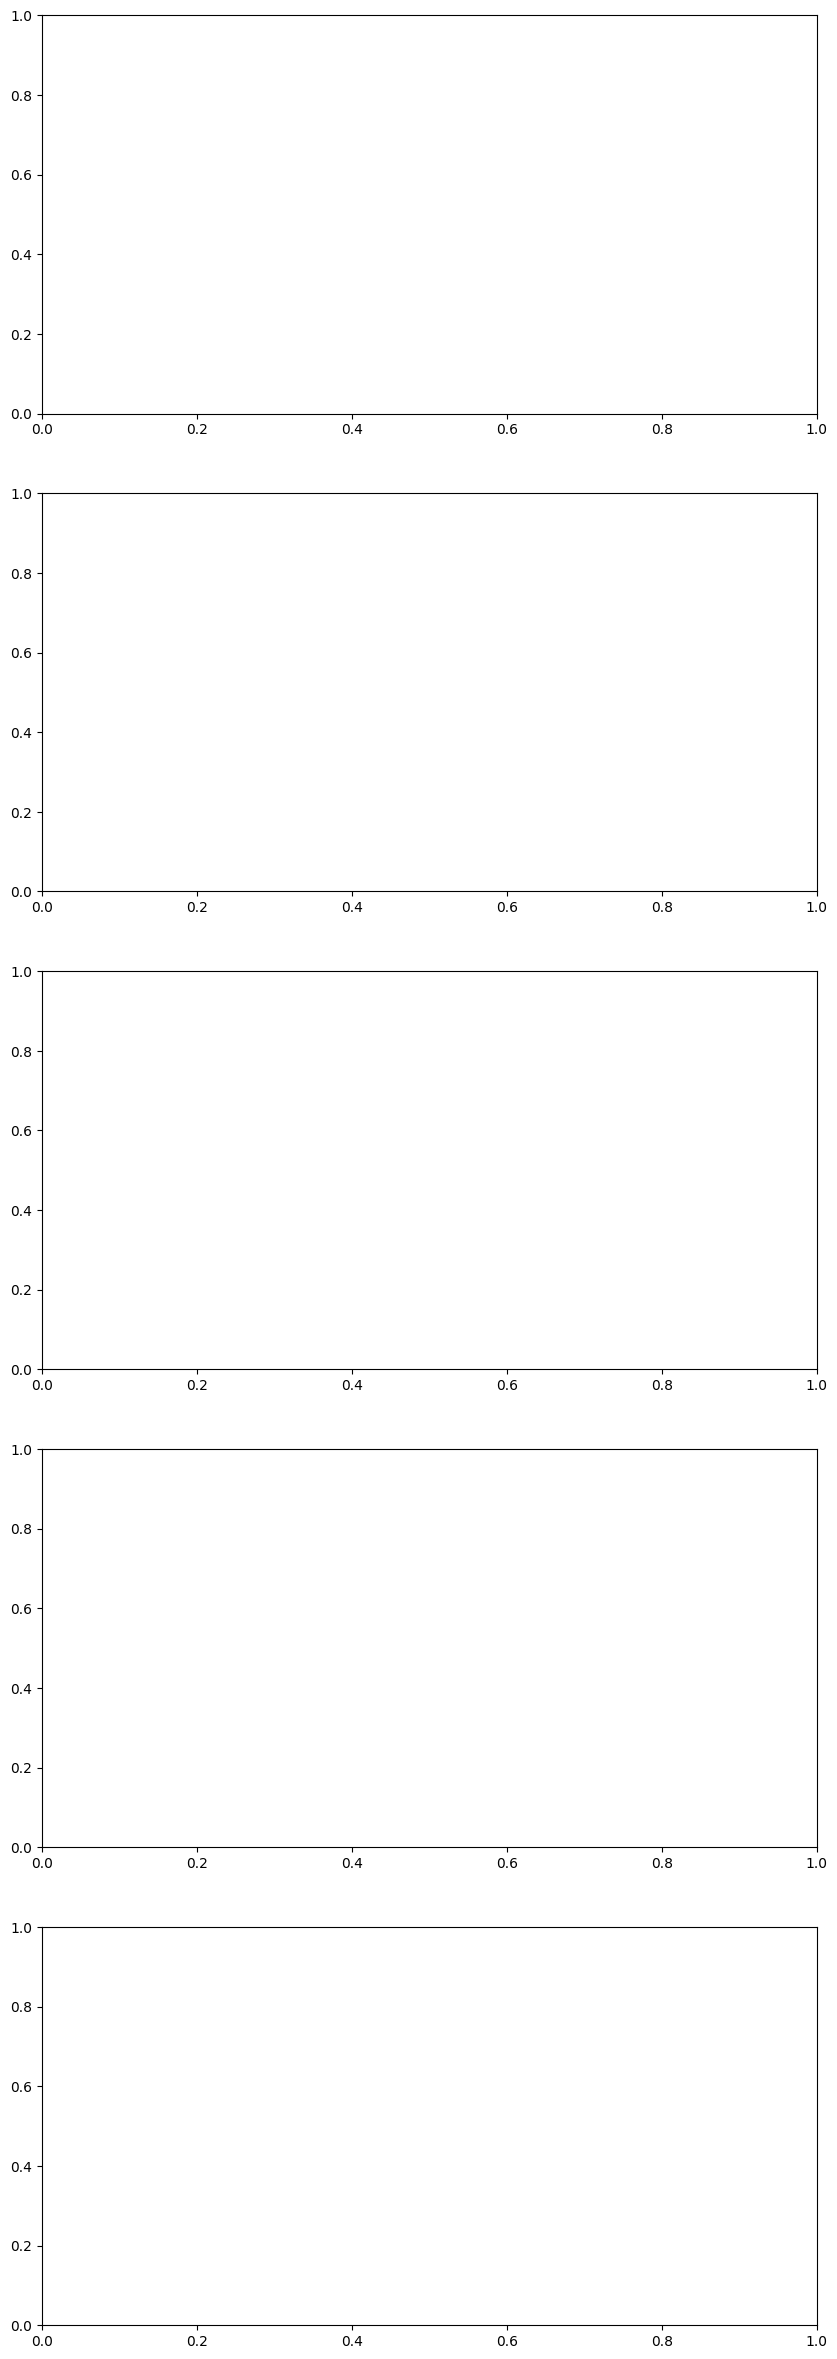

In [17]:
metrics = ['mse', 'nmad', 'outlier_fraction_cata', 'outlier_fraction', 'bias']
fig, ax = plt.subplots(len(metrics), figsize=(10, 30))
for i, metric in enumerate(metrics):
    flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
    mag_ranges = ['[<23.90]', '[23.90-24.45]', '[24.45-24.89]', '[24.89-25.65]', '[25.65-26.40]']
    gt_values = [gt_out_dict[f'redshifts/{metric}_bin_{i}'] for i in reversed(range(5))]
    bliss_values = [bliss_out_dict[f'redshifts/{metric}_bin_{i}'] for i in reversed(range(5))]
    lsst_values = [lsst_out_dict[f'redshifts/{metric}_bin_{i}'] for i in reversed(range(5))]

    ax[i].plot(mag_ranges, bliss_values, label="bliss", marker='o')
    ax[i].plot(mag_ranges, gt_values, label="gt_reg", marker='o')
    ax[i].plot(mag_ranges, lsst_values, label="lsst", marker='o')
    if metric != 'bias':
        ax[i].set_yscale("log")
    ax[i].set_xlabel('mag range')
    ax[i].set_ylabel(metric)
    ax[i].set_title(f'{metric} per mag range')
    ax[i].legend(loc='upper left')
plt.show()

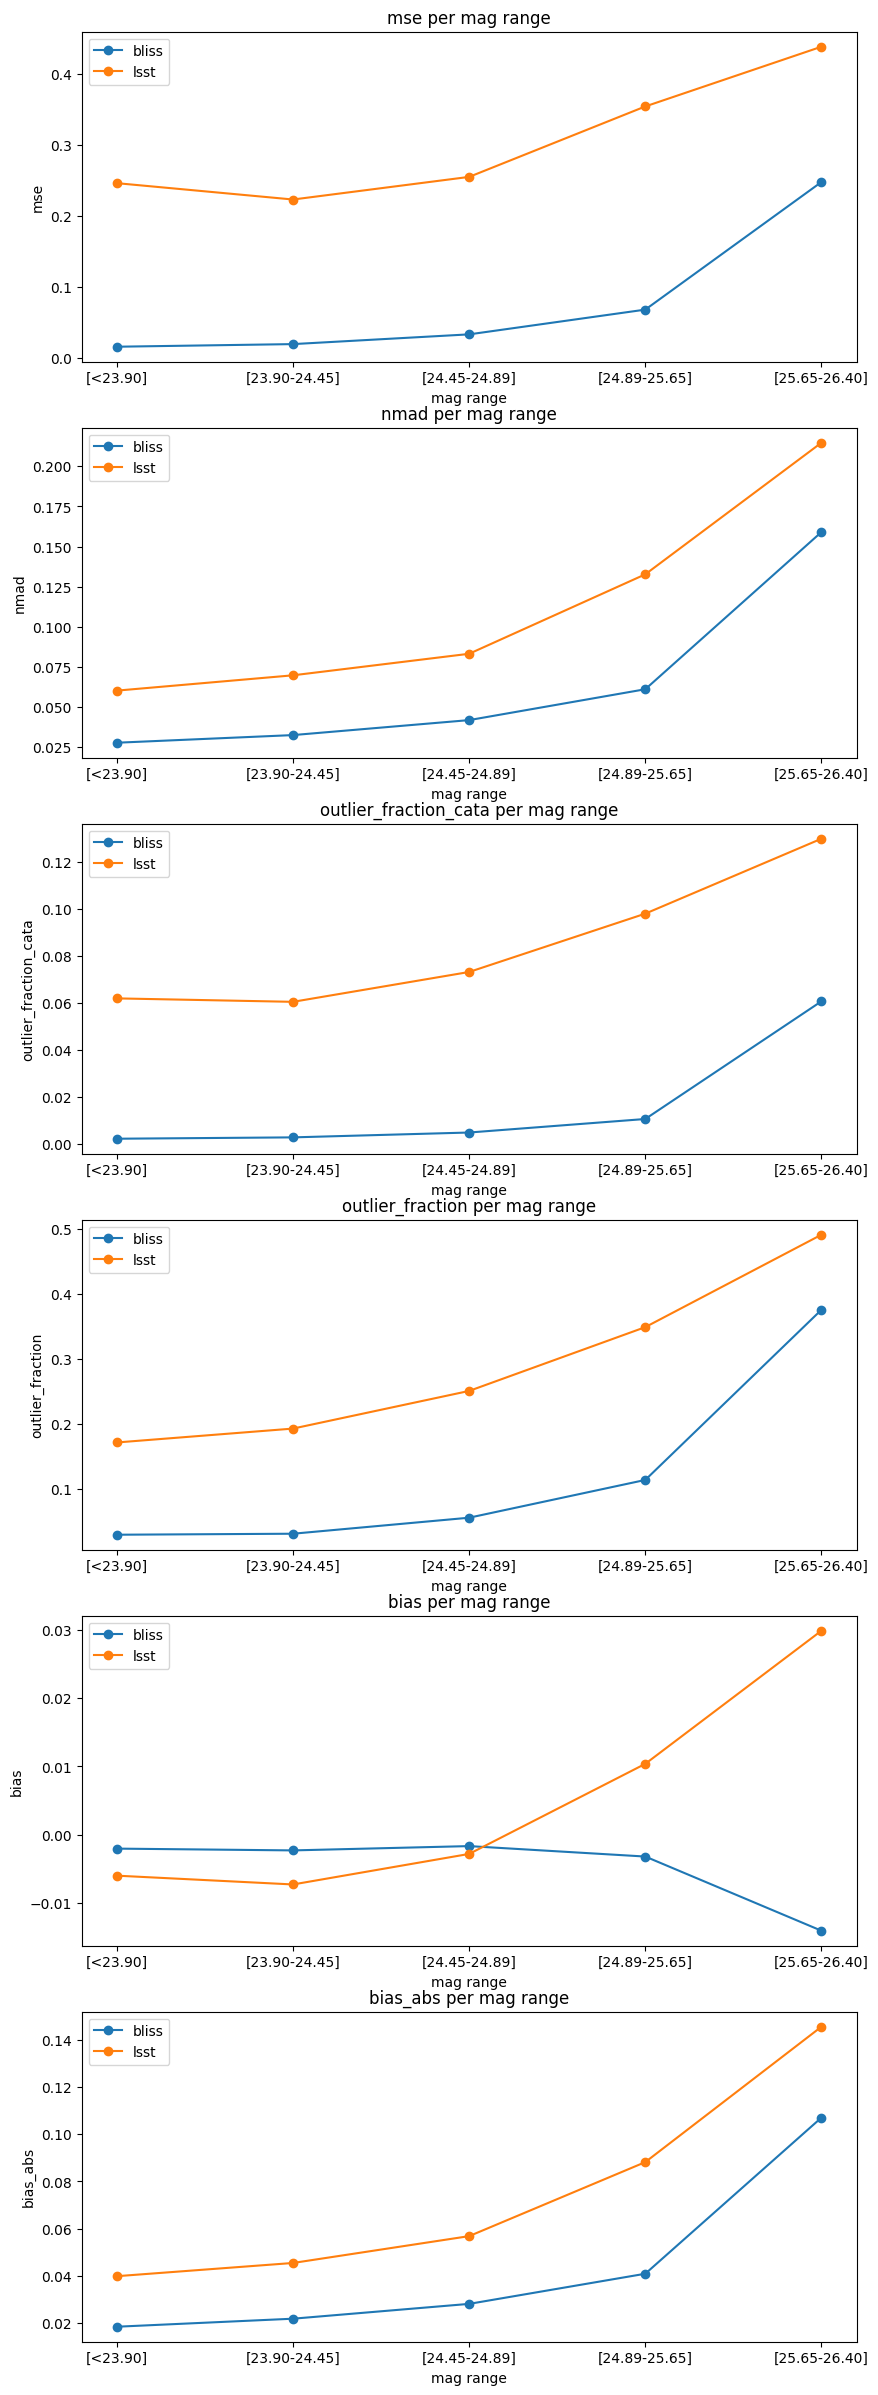

In [19]:
metrics = ['mse', 'nmad', 'outlier_fraction_cata', 'outlier_fraction', 'bias', 'bias_abs']
fig, ax = plt.subplots(len(metrics), figsize=(10, 30))
for i, metric in enumerate(metrics):
    flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
    mag_ranges = ['[<23.90]', '[23.90-24.45]', '[24.45-24.89]', '[24.89-25.65]', '[25.65-26.40]']
    bliss_values = [bliss_out_dict[f'redshifts/{metric}_bin_{i}'] for i in reversed(range(5))]
    lsst_values = [lsst_out_dict[f'redshifts/{metric}_bin_{i}'] for i in reversed(range(5))]

    ax[i].plot(mag_ranges, bliss_values, label="bliss", marker='o')
    ax[i].plot(mag_ranges, lsst_values, label="lsst", marker='o')
    ax[i].set_xlabel('mag range')
    ax[i].set_ylabel(metric)
    ax[i].set_title(f'{metric} per mag range')
    ax[i].legend(loc='upper left')
plt.show()

In [24]:
bliss_out_dict

{'redshifts/bias': -0.006504147779196501,
 'redshifts/bias_bin_0': -0.014045719988644123,
 'redshifts/bias_bin_1': -0.003189431270584464,
 'redshifts/bias_bin_2': -0.001660200534388423,
 'redshifts/bias_bin_3': -0.0022904197685420513,
 'redshifts/bias_bin_4': -0.0020288412924855947,
 'redshifts/bias_bin_5': -0.001150956959463656,
 'redshifts/mse': 0.1870339810848236,
 'redshifts/mse_bin_0': 0.24770021438598633,
 'redshifts/mse_bin_1': 0.06841427832841873,
 'redshifts/mse_bin_2': 0.03366375342011452,
 'redshifts/mse_bin_3': 0.01996874250471592,
 'redshifts/mse_bin_4': 0.016289599239826202,
 'redshifts/mse_bin_5': 0.007452603429555893,
 'redshifts/nmad': 0.1080448254942894,
 'redshifts/nmad_bin_0': 0.15906529128551483,
 'redshifts/nmad_bin_1': 0.06110619008541107,
 'redshifts/nmad_bin_2': 0.041873544454574585,
 'redshifts/nmad_bin_3': 0.032535992562770844,
 'redshifts/nmad_bin_4': 0.027776511386036873,
 'redshifts/nmad_bin_5': 0.019936883822083473,
 'redshifts/outlier_fraction': 0.285354

## debug

In [16]:
# batch = None
# for batch_idx, x in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
#     batch = x
#     break


  0%|          | 0/391 [00:01<?, ?it/s]


In [35]:
# true_cat = TileCatalog(tile_slen=4, d=batch["tile_catalog"])
# lsst_cat = lsst_predictor.predict(batch["wcs_header_str"], image_lim, batch["image_height_index"], batch["image_width_index"])
# est_cat = est_redshifts_with_reg_change_to_cat(lsst_cat, reg, tile_slen=4)
# est_cat = est_cat.to_full_catalog()
# true_cat = true_cat.to_full_catalog()
# matching = matcher.match_catalogs(true_cat, est_cat)
# metrics.update(true_cat, est_cat, matching)
# print(metrics.compute())


total num of pts: tensor([281.])
total num of pts: tensor([95., 73., 36., 18., 10., 49.])
{'redshifts/mse': 0.37961864471435547, 'redshifts/mse_bin_0': 0.48930624127388, 'redshifts/mse_bin_1': 0.46039801836013794, 'redshifts/mse_bin_2': 0.1344691962003708, 'redshifts/mse_bin_3': 0.4776960015296936, 'redshifts/mse_bin_4': 0.18611150979995728, 'redshifts/mse_bin_5': 0.23018695414066315}


In [ ]:
lsst_out_dict

# LSST flux using table and Reg

In [ ]:
# load lsst
GCRCatalogs.set_root_dir(lsst_root_dir)
lsst_catalog_gcr = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
lsst_catalog_sub = lsst_catalog_gcr.get_quantities(
    [
        "id_truth",
        "objectId",
        "ra",
        "dec",
        "truth_type",
        "cModelFlux_u",
        "cModelFluxErr_u",
        "cModelFlux_g",
        "cModelFluxErr_g",
        "cModelFlux_r",
        "cModelFluxErr_r",
        "cModelFlux_i",
        "cModelFluxErr_i",
        "cModelFlux_z",
        "cModelFluxErr_z",
        "cModelFlux_y",
        "cModelFluxErr_y",
    ]
)
lsst_catalog_df = pd.DataFrame(lsst_catalog_sub)

In [ ]:
lsst_catalog_df

In [ ]:
gt_path = "/home/qiaozhih/bliss/case_studies/redshift/redshift_from_img/DC2_generate_catalog_output/merged_catalog_with_flux_over_50.pkl"
gt_catalog_df = pd.read_pickle(gt_path)

In [ ]:
gt_catalog_df.head()

In [ ]:
gt_test_df = gt_catalog_df[gt_catalog_df.flux_r < 200].sample(10000)

In [ ]:
gt_test_df.columns

In [ ]:
lsst_test_df = lsst_catalog_df.merge(gt_test_df, left_on="id_truth", right_on="id")

In [ ]:
column = ["id", "cModelFlux_u", "cModelFlux_g", "cModelFlux_r", "cModelFlux_i", "cModelFlux_z", "cModelFlux_y", "redshifts"]
lsst_test_df = lsst_test_df[column].dropna()
lsst_test_df = lsst_test_df[lsst_test_df.cModelFlux_r < 200]

In [ ]:
lsst_test_df = lsst_test_df[(lsst_test_df > 0).all(axis=1)]

In [ ]:
survey_band = ["u", "g", "r", "i", "z", "y"]
flux_names = [f"cModelFlux_{band}" for band in survey_band]
lsst_flux_lists = [torch.tensor(lsst_test_df[flux_name].values, device=device) for flux_name in flux_names]
lsst_mag_lists = [22.5 - 2.5 * torch.log10(lsst_flux_list / 3631) for lsst_flux_list in lsst_flux_lists]
redshifts_gt = lsst_test_df.redshifts.values


In [ ]:
lsst_mags = torch.stack(lsst_mag_lists, dim=-1)

In [ ]:
reg.eval()
preds = reg.net(lsst_mags.float()).cpu().detach().numpy()
trues = redshifts_gt

In [ ]:
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.axline((0, 0), slope=1)
plt.scatter(preds, trues, alpha=0.1, s=3)